In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from algorithms.langevin import *
from algorithms.sampler import *
from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import numpy as np

import scipy
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import pickle
import plotnine as gg

import warnings
warnings.filterwarnings('ignore')

In [2]:
#pgts not quite right (dealing with constant term), fix this later

def plot_results(results):
    df = pd.DataFrame(results[0])
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    
def plot_results_list(results_list):
    for results in results_list:
        plot_results(results)

def simple_compare(agents, num_articles, dim, sparsity, n_steps, seed=0, verbosity=0, graph=False):
    #env = FixedLogisticBandit(num_articles, dim, DistributionWithConstant(NormalDist(0,1,dim=dim-1),-2.5), DistributionWithConstant(BernoulliDist(5.0/(dim-1),dim-1)), seed=seed)
    env = LogisticBandit(num_articles, dim+1, NormalDist(0,1,dim=dim+1), DistributionWithConstant(BernoulliDist(sparsity/dim,dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    cum_regrets = experiment.cum_regret
    if graph:
        plot_results(results)
    return results, cum_regrets

def simple_compares(make_agents, num_articles, dim, var, n_steps, seeds, verbosity=0, graph=False):
    results_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(make_agents))
    for seed in seeds:
        agents = [make_agent() for make_agent in make_agents]
        results, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity, graph=graph)
        results_list += [results]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / len(seeds)
    return results_list, cum_regrets_list, avg_regrets

def hyperparameter_sweep(make_agent_from_hyperparameters, hyperparam_list, dim, sparsity, n_steps, seed=0, verbosity=0, graph=False):
    agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
    results, cum_regrets = simple_compare(agents, num_articles, dim, sparsity, n_steps, seed=seed, verbosity=verbosity, graph=graph)
    
"""def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(hyperparam_list))
    for seed in range(seeds):
        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / seeds
    return results_list, df_list, cum_regrets_list, avg_regrets"""


'def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):\n    results_list = []\n    df_list = []\n    cum_regrets_list = []\n    avg_regrets = np.zeros(len(hyperparam_list))\n    for seed in range(seeds):\n        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]\n        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)\n        results_list += [results]\n        df_list += [df]\n        cum_regrets_list += [cum_regrets]\n        avg_regrets += cum_regrets\n    avg_regrets = avg_regrets / seeds\n    return results_list, df_list, cum_regrets_list, avg_regrets'

In [3]:
seed=1

num_articles = 100
dim = 20
dim1= dim+1
sparsity = 5.0
theta_mean = 0
theta_std = 1

time_limit= 0.01

verbosity=0

make_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=1)

make_full_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='full',
                                          init_pt=None, verbosity=1)
make_cum_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='cum',
                                          init_pt=None, verbosity=1)
make_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(sparsity/dim)),
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=1)
make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=True, context_has_constant=True, 
                                      n_steps=9999, time = time_limit, verbosity=verbosity)

In [10]:
results, cum_regrets = simple_compare([make_prec_sagald_agent()], num_articles, dim, sparsity, 16, seed=seed, verbosity=1)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918]
Experiment: Step 0
 Sample: array([ 1.82990624, -1.42515617,  0.71533345,  0.43912737, -1.10296955,
        0.75949359, -1.10321635, -1.0895511 , -1.38955024,  0.83428321,
       -0.44934585,  1.08525132, -0.81014003,  0.61466259,  1.40741059,
       -0.08601351, -1.12545275, -0.34257094,  1.25673747,  0.73909384,
       -0.38598809])
 Steps taken: 0
+ (1, 1)
Experiment: Step 1
 Sample: array([ 2.38005895, -1.39425256,  0.19370295,  0.06567807, -1.17915735,
        1.01353689, -0.7967169 , -1.45689663, -1.18110855,  0.80648667,
       -1.31949586,  0.99070077, -0.15658112,  1.01757101,  0.8393592 ,
       -0.24020291, -0.92648743, -0.46700384,  1.2271063 ,  0.43682354,
       -0.86895223])
 Steps taken: 10
+ (2, 2)
Experiment: S

In [11]:
results, cum_regrets = simple_compare([make_sagald_agent(), make_prec_sagald_agent(),make_full_prec_sagald_agent(),make_cum_prec_sagald_agent()], num_articles, dim, sparsity, 1000, seed=seed, verbosity=1)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918]
Experiment: Step 0
 Sample: array([ 1.82990624, -1.42515617,  0.71533345,  0.43912737, -1.10296955,
        0.75949359, -1.10321635, -1.0895511 , -1.38955024,  0.83428321,
       -0.44934585,  1.08525132, -0.81014003,  0.61466259,  1.40741059,
       -0.08601351, -1.12545275, -0.34257094,  1.25673747,  0.73909384,
       -0.38598809])
 Steps taken: 0
 Sample: array([-1.74437237e+00,  7.15536785e-01,  1.63090625e+00,  1.64859408e+00,
        4.32790200e-01, -1.91029171e-01, -7.86121270e-01, -5.72601817e-01,
       -1.64975030e+00,  2.13455156e+00, -2.69643893e-02,  2.38440514e+00,
       -7.44974154e-02, -1.61831793e+00,  1.86156510e+00, -8.59827024e-01,
       -4.37908211e-01,  1.64855109e+00,  1.45877321e+00, -2.02620642e+00,
 

 Sample: array([-1.27898423,  0.16476793,  0.19857345, -1.00226803, -0.75098436,
        1.91769806, -0.13062954, -0.45977716, -0.43535796, -1.28667121,
        1.08952338, -1.29008651,  0.46741748,  0.1300358 , -1.11238184,
       -0.00781523,  1.06195432, -0.36932342,  0.79045206, -0.892515  ,
        0.60092917])
 Steps taken: 87
 Sample: array([-1.1433832 , -0.77497879,  1.72129388,  0.64024625,  0.60066877,
        0.54818742, -0.84388815, -1.57888996, -0.67432846,  1.38712101,
        0.25276846,  1.11286855,  1.16180868, -0.51985721,  1.27844779,
       -0.90834968, -0.77529951,  2.01498343,  0.59020413, -0.90089818,
       -0.64963596])
 Steps taken: 19
+ (4, 7) (4, 3)
- (2, 3)
 Sample: array([-0.7259709 ,  2.18656504, -0.76498733, -0.24562037,  1.1333194 ,
        0.53578868,  1.31325456, -0.2141681 , -0.27199264, -0.32473981,
        2.31365256,  2.55159886,  1.44612081,  0.67531868, -2.63091924,
       -0.91456378,  0.19762211,  1.84395343,  0.54407589, -0.95013979,
       -

       -0.03806513])
 Steps taken: 12
+ (8, 13) (8, 5)
- (4, 5)
 Sample: array([-0.23096272, -1.60280525,  0.04645844, -1.40065988,  0.10485361,
       -0.48618704, -0.34768786,  0.87976375, -0.52379219,  0.31072947,
        1.58925841,  0.35003694, -1.23041083,  0.83137054, -0.94547006,
        0.36923137,  2.95883491, -0.22645259,  0.7676451 , -0.16382675,
       -2.10174958])
 Steps taken: 15
 Sample: array([-0.29573498, -1.05438318,  0.91871327, -0.82913197,  0.04941917,
       -0.54427492,  0.03167902, -0.88674239, -2.03837882,  0.76031406,
       -0.89933782, -0.29058984,  0.5178717 ,  0.34344074,  0.27520508,
       -1.45469287, -0.86957554,  0.13712654,  0.92170699, -0.52251036,
        0.58604115])
 Steps taken: 12
Experiment: Step 13
 Sample: array([-1.26846816, -0.29916094, -1.72624752, -0.24955548,  0.35333507,
       -1.13151492, -1.35697473,  0.63128568,  0.35284598,  0.90756465,
        1.97844486, -1.6716707 ,  0.51759583,  0.0221912 ,  0.0807827 ,
        0.27765694,  

 Sample: array([ 0.85733367,  0.48534823, -1.25702988, -0.1144354 ,  2.27456561,
        0.43019465,  0.28584655, -0.80928551, -1.84689072, -1.41158934,
       -0.60285953,  0.64569975, -0.64832513,  2.54873047, -0.46873495,
       -1.54219137,  0.19833708,  1.01009678,  0.88545858, -0.62586008,
        0.37735419])
 Steps taken: 11
 Sample: array([-0.70750123, -1.05986083,  1.33603743, -0.67755257, -0.27018092,
       -0.59778595, -0.35022098, -0.47676159, -1.29823312,  0.34877963,
       -0.07565806, -0.15307002,  0.01570339,  0.00592067,  0.59269075,
       -1.37815652, -0.15211607,  0.31316613,  0.801565  , -0.44851621,
        0.41108876])
 Steps taken: 12
Experiment: Step 22
 Sample: array([ 0.2670774 , -1.29061471, -0.66765761, -0.15539311, -0.2010765 ,
        0.26916203,  0.053316  ,  0.4927259 ,  1.15450518, -1.05066534,
        0.69270218, -0.68984623,  0.54041671, -0.13738815, -0.11411912,
       -0.75349401,  0.0093339 ,  0.05096164,  0.14973453,  0.30184925,
       -0.772

 Sample: array([ 0.99583623,  0.20465004, -0.58012896,  0.59936094, -0.59989162,
       -0.53812828,  1.12431775, -0.28140056, -0.27158705, -1.17249168,
        1.70616202,  0.11763717, -0.09359934,  1.25514368, -1.20212489,
       -0.27452692,  0.14092928, -0.33964335,  1.13524491, -1.11965483,
       -1.38235285])
 Steps taken: 12
 Sample: array([-0.75019437, -1.18073292,  1.08357851, -0.75678356,  0.03670463,
       -0.5945399 , -0.33318007, -0.81135264, -1.06239509,  0.57790549,
        0.12012488, -0.22084357, -0.02916681,  0.11456663,  0.17605844,
       -1.22220522, -0.26412306,  0.51504306,  0.46432401, -0.25301928,
        0.57305256])
 Steps taken: 18
Experiment: Step 28
 Sample: array([-0.88755356, -0.59154374, -0.40786105,  0.0119567 ,  1.80335736,
       -1.82388272,  1.3773384 , -1.92860036,  1.42068606,  0.44127636,
        0.75725016, -0.12196485,  0.69839575, -0.27419863,  2.22065602,
       -0.64430846,  0.58199529,  0.52250955, -1.88939607, -0.4840739 ,
       -1.478

 Sample: array([-0.73130118, -1.38557409,  1.05712669, -1.16687855,  0.40942726,
       -0.47718542, -0.07743031, -1.00123636, -1.33198105,  0.78138538,
        0.18279346, -0.17822322,  0.08860833,  0.20790322, -0.1994381 ,
       -1.2475025 , -0.23161832,  0.78563365,  0.30367633, -0.4065167 ,
        0.52531081])
 Steps taken: 12
Experiment: Step 34
 Sample: array([ 0.20945337, -1.18829442, -0.411047  ,  0.18885537,  0.77121507,
       -1.00283795,  0.20878774, -1.7761952 ,  1.42051347, -0.11682265,
        1.83042913, -0.19994851, -0.20737435,  1.27061102,  0.58953206,
       -0.35874676,  0.28356164,  0.62806116,  0.84310623, -0.4334465 ,
       -0.55433749])
 Steps taken: 85
 Sample: array([ 0.01213296, -0.00304136,  0.7784885 ,  0.3361627 ,  0.53693296,
        0.0012144 ,  0.40618773, -0.98837949, -0.62038629,  0.23544131,
        0.35734269, -0.03645571,  0.48444252,  0.38399474,  0.38053944,
       -0.7218697 , -0.49514162,  0.26130762, -0.50331042,  0.05913037,
       -0.607

 Sample: array([-9.89729053e-01, -1.00084921e+00,  1.19458506e+00, -1.29055619e+00,
        3.44404920e-01, -2.58942303e-01, -8.64161204e-02, -8.82624008e-01,
       -1.04002338e+00,  5.78501703e-01, -1.29831289e-01,  1.25814746e-05,
        3.21994306e-01,  2.60972061e-01, -1.30332620e-01, -5.23671846e-01,
       -8.10238700e-02,  5.36832441e-01,  2.05303803e-01, -6.64397255e-01,
        1.23049165e-01])
 Steps taken: 11
Experiment: Step 40
 Sample: array([ 0.25917718,  1.07637432,  1.74956697,  0.34981529,  0.75989029,
       -1.12898661,  0.45204329, -1.49367591,  0.02293816,  0.02043465,
        1.48479657, -1.20495249, -0.21027039,  0.88172731,  0.66668776,
       -0.487765  ,  0.04787054, -0.64132403, -0.60734208, -1.33734748,
        0.42288113])
 Steps taken: 52
 Sample: array([ 0.03078163, -0.11803569,  0.60661224,  0.10575887,  0.5419214 ,
        0.09945044,  0.73187195, -0.86062453, -0.62194475,  0.31179283,
        0.02998889, -0.36117906,  0.61669594,  0.50241399,  0.1767

 Sample: array([-0.01207969,  1.04601655, -0.38902762, -1.97950763,  0.83517661,
       -1.34417424, -0.38540991, -1.08418566, -0.6076724 ,  0.44306975,
        1.43428582, -0.78401855,  0.86508119,  0.70610797,  1.4525001 ,
       -1.35802111, -0.04704942,  0.7994599 ,  0.67679981, -1.43948634,
        0.7805883 ])
 Steps taken: 78
 Sample: array([ 0.0480886 , -0.08657726,  0.53321586,  0.04475607,  0.66218096,
        0.24197069,  0.66401621, -0.6339665 , -0.65742215,  0.07751011,
        0.08863573, -0.31487957,  0.46706819,  0.76354774, -0.08505718,
       -0.87578603, -0.38210765,  0.31298328, -0.720277  , -0.02883659,
       -0.41167014])
 Steps taken: 18
+ (32, 47) (32, 15)
- (16, 15)
 Sample: array([ 0.36096064, -0.82586889, -1.50599587, -0.08958059,  0.12643092,
       -0.92523249,  0.34917933, -0.31060223, -0.31368569, -0.64484382,
        1.59864201, -0.68251284,  1.09412455,  1.0980033 ,  0.4041953 ,
       -0.86849558,  1.2511285 ,  0.76961222,  0.28130951, -0.08124089,
  

 Sample: array([-0.20902805, -0.07267741,  0.43167086, -0.07872428,  0.57008798,
        0.40844683,  0.75671346, -0.5415295 , -0.63433178,  0.17690133,
        0.09324634, -0.3383275 ,  0.30023333,  0.89093892,  0.04094957,
       -0.83236555, -0.21156606,  0.3529499 , -0.49626804, -0.12372536,
       -0.37599033])
 Steps taken: 10
+ (32, 53) (32, 21)
- (16, 21)
 Sample: array([ 0.13793371,  0.50047492, -0.27682963, -0.75357963, -0.7126636 ,
       -0.59894524,  1.53970009, -0.48496764,  0.12658888, -0.65330222,
        0.79329173,  0.12238963,  0.77971365,  0.64249188,  0.60097241,
        0.13122022, -0.68975279,  0.10243337,  0.61794234,  0.19071543,
       -0.61714259])
 Steps taken: 12
 Sample: array([-0.64178835, -0.90634988,  0.9188245 , -1.37102594,  0.47918169,
       -0.05183064, -0.54138268, -0.8817496 , -1.22302115,  0.71139492,
       -0.0197886 ,  0.52477307,  0.45615264, -0.01131091, -0.22871922,
       -0.51422794, -0.50328331,  0.32770358,  0.275604  , -0.54072114,
  

 Sample: array([ 0.84619608, -1.03387796, -0.42593993, -0.58419758, -0.94923922,
       -0.64440928,  0.91869119, -1.25208044,  0.58463291, -0.03556572,
        0.91117105, -0.72534712,  0.39202603,  0.15463834, -0.73205577,
       -1.39429181, -0.03712441,  0.58514486,  0.46575909, -0.38389391,
        0.10102117])
 Steps taken: 16
 Sample: array([-0.53373666, -1.05556527,  0.77220725, -1.54267894,  0.68755068,
       -0.18924508, -0.40185707, -0.60023905, -1.31045338,  0.761861  ,
       -0.36740214,  0.04258964,  0.53778293,  0.08984693, -0.0229575 ,
       -0.61762987, -0.64676592,  0.39446142,  0.41803711, -0.78558498,
       -0.18515297])
 Steps taken: 16
Experiment: Step 59
 Sample: array([-0.38629573, -0.22440381,  1.01650538,  1.14070906,  1.66396702,
       -0.52611364,  0.74988845, -3.08463241, -0.07080357, -1.0213024 ,
        1.31951549, -0.84372134,  0.33966332, -0.48819167,  0.6256943 ,
       -0.83477564,  0.32278566,  0.67068132,  0.37368298, -0.0215597 ,
        0.136

 Sample: array([-0.02128467,  0.20385775,  0.1051303 ,  0.0975428 ,  0.36057519,
        0.32613011,  0.73172145, -0.6235367 , -0.66706131, -0.02167488,
       -0.00503475, -0.52493985,  0.36059311,  0.56881182, -0.07152737,
       -0.56207219, -0.24072221,  0.52273325, -0.24104762, -0.39919114,
       -0.18631414])
 Steps taken: 7
+ (64, 68) (64, 4)
- (32, 4)
 Sample: array([-0.38519797, -0.59429385, -0.195929  ,  1.19594965, -1.15891543,
       -0.73808696,  1.86317662, -0.84430266,  0.77405384, -0.98733998,
        0.35014619,  0.35399576, -0.52783884,  0.23648569,  0.26016337,
       -0.13222714,  0.00326655,  1.16886491,  0.45887554,  0.36919275,
       -1.10117245])
 Steps taken: 11
 Sample: array([-0.67653599, -1.07374093,  0.67063467, -1.53009569,  0.62290125,
       -0.22105702, -0.13813366, -0.37092663, -0.95606835,  0.6825686 ,
       -0.32409781, -0.02271194,  0.48496661,  0.01427021, -0.01495117,
       -0.44240938, -0.5259957 ,  0.32066078,  0.42100318, -0.84902491,
     

 Sample: array([-8.94602013e-02,  1.11745875e-02,  2.75935572e-01, -2.49467978e-01,
        4.05501767e-01,  1.04953166e-01,  7.40525135e-01, -6.58628945e-01,
       -3.31602511e-01,  9.97691612e-02,  7.27690233e-02, -5.57938102e-01,
        4.53100023e-01,  5.53384442e-01, -7.49097909e-05, -4.51744840e-01,
       -2.10692071e-01,  5.69115813e-01, -4.27656883e-01, -4.75562930e-01,
       -1.17334404e-01])
 Steps taken: 14
+ (64, 77) (64, 13)
- (32, 13)
 Sample: array([ 1.15011747, -1.29069596, -0.47326093, -0.21637391, -0.39933686,
       -0.38015055,  0.48368903, -0.31737434,  0.38257999, -1.57465138,
        0.35835972,  0.89649463,  0.11574008,  1.06754659,  0.55371512,
       -1.3747086 , -0.42491062,  0.33933414,  0.36729852,  0.05690465,
        0.10955057])
 Steps taken: 16
 Sample: array([-1.04819592, -1.18535509,  0.52324331, -1.37189757,  0.74243774,
       -0.06656147, -0.32725137, -0.07083575, -1.10767269,  0.69730081,
        0.04273973, -0.12909244,  0.60529507,  0.100099

 Sample: array([-0.28317932,  0.26790061,  0.25472718, -0.24010695,  0.45247125,
        0.14641188,  0.64341958, -0.57051852, -0.18127095,  0.11883419,
        0.09952412, -0.27701914,  0.47342456,  0.42315122, -0.06047584,
       -0.64829872, -0.01889433,  0.4120052 , -0.22782034, -0.11899196,
       -0.17109804])
 Steps taken: 15
+ (64, 84) (64, 20)
- (32, 20)
 Sample: array([ 1.26283835,  0.022459  , -1.25420526, -0.2592006 ,  0.65958862,
       -1.27149698,  0.56868249, -0.51548959, -0.1292792 , -0.37440848,
        1.36036413,  0.19853635,  0.01921911,  1.04302344, -1.61722139,
       -0.80614226, -0.78741635, -0.33773731, -0.29832808, -0.17770025,
       -1.20262763])
 Steps taken: 15
 Sample: array([-0.98347879, -1.16193819,  0.32156533, -1.63500464,  0.55382498,
       -0.00186703, -0.41214799, -0.29719016, -1.14112416,  0.75053879,
        0.06678627, -0.07597479,  0.7928818 ,  0.09215866,  0.06998408,
       -0.20842207, -0.25685602,  0.58650442,  0.59393478, -0.89085448,
  

 Sample: array([-0.72441831, -0.95599635, -0.24416636,  0.04133079,  1.58072809,
       -0.37005829,  1.87722177, -1.39841678,  1.22313043, -0.26477955,
       -0.23626817, -0.51762026,  0.66136248,  0.57799111,  0.51541896,
       -0.89779992,  0.83924585,  0.06810485, -0.73051823,  0.7239197 ,
       -0.07202792])
 Steps taken: 49
 Sample: array([-0.23372112,  0.39028726,  0.17014021, -0.13962224,  0.47103642,
        0.1981405 ,  0.5963103 , -0.83718162, -0.27936101,  0.20158154,
        0.0264381 , -0.36236593,  0.53446782,  0.40828221, -0.15036735,
       -0.765871  ,  0.10762674,  0.4993725 , -0.21198247, -0.09513847,
       -0.33766477])
 Steps taken: 15
+ (64, 91) (64, 27)
- (32, 27)
 Sample: array([-0.1159309 , -0.07091763, -0.19341704,  0.54443331,  1.57881361,
        0.29207456,  0.94277757, -0.51527974,  0.71685202, -0.28412509,
        1.7355189 , -0.60294216, -0.10051042, -0.04732274, -0.05759488,
       -1.60135459, -0.08736185, -0.13095396, -0.80929219, -0.00683534,
  

 Sample: array([-0.23087382,  0.45717928, -0.17699642, -0.26112273,  0.34745085,
        0.24863308,  0.6170999 , -0.82918494, -0.35532543,  0.4542572 ,
       -0.00918094, -0.24501714,  0.38200825,  0.35325844, -0.07367546,
       -0.70793235,  0.29731799,  0.38493778, -0.1295403 , -0.12030998,
       -0.42265803])
 Steps taken: 15
+ (64, 98) (64, 34)
- (32, 34)
 Sample: array([ 0.04069368, -0.11496157,  0.02390548,  1.20375074,  0.2603265 ,
       -0.00570346,  0.72421361, -0.58368991, -0.1514963 ,  0.03116877,
        1.14131208, -0.54513729, -0.19962728,  0.19684053,  0.02314095,
       -1.52116959, -0.09325318, -0.00958701, -0.06712877,  0.34214812,
       -0.10566036])
 Steps taken: 16
 Sample: array([-1.0062479 , -0.75789723,  0.42563755, -1.63578082,  0.44398996,
        0.1115232 , -0.30778764, -0.46086075, -0.98786495,  0.43772961,
        0.30862114, -0.73335087,  0.50008736, -0.14264461,  0.20305873,
       -0.40391744, -0.45469098,  0.94951752,  0.73567706, -0.63012657,
  

 Sample: array([-0.01743707,  0.4185741 , -0.31816277, -0.37482801,  0.48759355,
        0.12602675,  0.55588236, -0.74397439, -0.39103904,  0.47167332,
        0.04776295, -0.55394744,  0.45850534,  0.35829479,  0.01848133,
       -0.66517856, -0.01804307,  0.28051191, -0.15144965, -0.29713249,
       -0.6550045 ])
 Steps taken: 15
+ (64, 105) (64, 41)
- (32, 41)
 Sample: array([ 0.60016503, -0.70953418,  0.0861239 ,  0.47350635,  0.79406431,
       -0.77208686,  0.3573125 , -0.26308082, -0.65037127,  1.05850384,
        1.07830275, -1.45051827, -0.8053468 ,  0.45006454, -0.4014078 ,
       -1.59969653,  0.29515192,  0.55405291, -0.21928796, -0.14070306,
       -0.17182334])
 Steps taken: 16
 Sample: array([-0.84375614, -0.60793274,  0.26725581, -1.74056583,  0.64223268,
        0.35338848, -0.35944069, -0.56668483, -0.79280107,  0.15262572,
        0.11297558, -0.92442013,  0.34188276, -0.01821527,  0.4234344 ,
       -0.24827585, -0.52742325,  0.62218711,  0.82893412, -0.62078411,
 

 Sample: array([-0.01909221,  0.31949158, -0.16330951, -0.54697212,  0.430745  ,
        0.08059836,  0.55381449, -0.52665221, -0.25438765,  0.35577381,
        0.15138156, -0.51389535,  0.4700334 ,  0.25100486, -0.05017428,
       -0.6063433 ,  0.03070474,  0.2474342 , -0.14825298, -0.36342993,
       -0.47740866])
 Steps taken: 15
+ (64, 112) (64, 48)
- (32, 48)
 Sample: array([ 1.27507261,  0.06304307, -0.42731651, -0.25928021,  0.55067716,
       -0.61462562,  1.59832678, -1.5770218 ,  0.18089793,  0.00742542,
        0.85459222, -1.22172373, -0.42054611, -0.66140766, -0.73127974,
       -1.48902159,  0.11938061, -0.47303371,  0.19319872,  0.07289748,
       -0.76844872])
 Steps taken: 16
 Sample: array([-1.11728346, -0.60879657,  0.35947418, -1.56049311,  0.65206383,
        0.51136775, -0.21630057, -0.3718782 , -0.77210423,  0.11256142,
        0.17376881, -0.75639631,  0.30729509,  0.00475378,  0.56263734,
       -0.2862725 , -0.5460725 ,  0.85533187,  0.7043799 , -0.59654201,
 

 Steps taken: 49
 Sample: array([-0.23993843,  0.22246018,  0.02555893, -0.41095718,  0.5924475 ,
        0.10799322,  0.72891371, -0.27522404, -0.23036763,  0.36822559,
        0.21045223, -0.59964379,  0.36616975,  0.16706021, -0.18012368,
       -0.61063751, -0.06886391,  0.4078267 , -0.16691851, -0.26329966,
       -0.3555271 ])
 Steps taken: 15
+ (64, 119) (64, 55)
- (32, 55)
 Sample: array([ 1.20459051,  0.42644098, -0.02582278,  0.3713356 , -1.21154274,
       -2.07673659,  0.86762937, -0.99855663, -0.11206926, -1.24771797,
        1.51740023, -0.83387457, -0.33878483,  0.24291714, -0.18744521,
       -0.85261074, -0.2106947 , -0.16716397, -0.42253913, -0.08913344,
       -0.25855042])
 Steps taken: 16
 Sample: array([-9.63801802e-01, -8.22983769e-01,  3.21263863e-01, -1.61589545e+00,
        5.40404281e-01,  3.19310365e-01, -1.83243109e-01, -4.12650521e-01,
       -9.01112394e-01,  7.36485435e-02,  2.25423812e-01, -8.39324794e-01,
        2.92726033e-01, -2.44710830e-04,  6.359

 Sample: array([-0.77257289, -0.74359932,  0.4006677 , -1.41516266,  0.59667311,
        0.26021263, -0.0290863 , -0.51730732, -1.02891685, -0.11118581,
        0.14934144, -0.78061107,  0.15968313, -0.08842386,  0.59541892,
       -0.38359242, -0.70351898,  0.66374788,  0.5339526 , -0.53381363,
       -0.72759244])
 Steps taken: 13
Experiment: Step 125
 Sample: array([ 0.64649879, -1.12734211, -0.30381632, -1.13915006,  1.06747118,
       -1.19157667,  1.41777311, -1.60667458,  0.77664687, -0.02880814,
        0.16786389, -1.78711541, -0.30812627,  1.10928125,  1.0597393 ,
        0.45214377, -0.66306023, -0.79003148,  1.2045475 ,  0.322996  ,
        0.01121579])
 Steps taken: 49
 Sample: array([-0.36719076,  0.20761482,  0.01019934, -0.2486823 ,  0.65298515,
        0.14041829,  0.62525548, -0.13426184, -0.28305607,  0.3724598 ,
        0.16584501, -0.66503753,  0.27810537,  0.2685709 , -0.2707959 ,
       -0.49893087,  0.01887313,  0.27725952,  0.05187899, -0.22942797,
       -0.43

+ (128, 132) (128, 4)
- (64, 4)
 Sample: array([ 0.46004126, -1.29199021, -0.51020697,  0.07348099,  0.47128357,
       -0.9632603 ,  1.02892696,  0.60652391, -0.00633455,  0.18727989,
        1.69771766, -1.04129659, -0.18675352,  0.90649717, -0.43040886,
       -1.76354787,  0.27477833, -0.48349156,  0.49084956, -0.18342212,
        0.1435615 ])
 Steps taken: 15
 Sample: array([-0.82713985, -0.53370021,  0.52304493, -1.57712734,  0.38937871,
        0.15925023,  0.03085856, -0.35156021, -1.03017791, -0.1441707 ,
        0.13526069, -0.85590479,  0.27215792, -0.11893288,  0.50758673,
       -0.34125409, -0.60309335,  0.74116737,  0.22245796, -0.43004556,
       -0.75907462])
 Steps taken: 16
Experiment: Step 132
 Sample: array([ 0.48348072, -1.42502421, -0.61596768, -0.57595658,  1.3875038 ,
       -1.18970636,  1.1198329 , -0.91269127,  1.44242466, -0.9988899 ,
        1.03357379, -0.86470818, -0.10112516,  0.32626198,  0.77084208,
        0.02918924, -0.45069287, -0.64916074,  0.333

 Sample: array([-0.29659881,  0.27827782,  0.03397425, -0.28928881,  0.64365367,
       -0.07372692,  0.64605885, -0.26954567, -0.25555369,  0.07177208,
       -0.0482196 , -0.57362772,  0.40363914,  0.49417559, -0.19291186,
       -0.3856037 , -0.02412718,  0.44917834, -0.0397992 , -0.03629687,
       -0.55581905])
 Steps taken: 16
+ (128, 139) (128, 11)
- (64, 11)
 Sample: array([ 1.46968286,  0.05808133, -1.31962802,  0.28845075,  0.27824943,
       -0.21376388,  1.09547915, -1.27922127, -0.46104482, -0.22821307,
        1.73940346, -1.58646756,  0.52143598, -0.22947242,  0.02188565,
       -2.55488235, -0.44730044, -0.66553068,  0.46397429, -0.13020824,
       -0.3980051 ])
 Steps taken: 15
 Sample: array([-0.67011088, -0.68533583,  0.56886818, -1.60954043,  0.40267628,
       -0.07022238,  0.05454675, -0.49266924, -1.02417858, -0.23972486,
        0.28223287, -0.96075308,  0.1702996 , -0.22475677,  0.59609064,
       -0.37903354, -0.54086869,  0.70051547,  0.085035  , -0.61054742,

 Sample: array([-0.58756448, -0.63994708,  0.5600424 , -1.60383605,  0.54507559,
       -0.06152428,  0.20781247, -0.55815744, -1.02872872, -0.14341611,
        0.26649953, -1.12781863,  0.10641348, -0.30127737,  0.4966513 ,
       -0.36855998, -0.42197146,  0.61219507,  0.17536751, -0.5804326 ,
       -0.77561472])
 Steps taken: 14
Experiment: Step 145
 Sample: array([-0.57037579, -1.26571117, -1.69398861, -0.75765859,  1.83177823,
       -0.69577079,  1.87260271, -1.71738733,  1.21475161, -0.55618018,
        1.8303948 , -2.18462726,  0.21965337,  0.12636731,  1.04379408,
        0.3583832 , -0.14172338,  0.16072227,  1.00344083,  1.10690703,
       -0.05350244])
 Steps taken: 39
 Sample: array([-0.50008531,  0.4922577 ,  0.17791897, -0.40671888,  0.68857089,
       -0.19213214,  0.74273097, -0.23436595, -0.29706067,  0.04293276,
        0.09612644, -0.56910938,  0.38658031,  0.6319835 , -0.06552437,
       -0.35296352, -0.0977564 ,  0.395757  ,  0.1067445 ,  0.01986903,
       -0.55

 Sample: array([-0.45829821,  0.52821075,  0.1559457 , -0.46771045,  0.82241875,
       -0.19720307,  0.70049343, -0.11194192, -0.29935968,  0.00689541,
        0.03283622, -0.67776411,  0.29269677,  0.48417441,  0.03924143,
       -0.4141314 , -0.14427299,  0.46185119,  0.02574778, -0.02613495,
       -0.545633  ])
 Steps taken: 14
+ (128, 152) (128, 24)
- (64, 24)
 Sample: array([-0.0120207 ,  0.10061439, -0.40757323,  0.30089834,  0.75368253,
       -0.25311787,  1.51511273, -0.85515052, -0.39537094,  0.18954599,
        1.15320467, -0.89455993, -0.02703884,  0.87565924,  0.07679613,
       -1.81445239,  0.24604144, -0.04689127,  0.03713634,  0.05747009,
       -0.13011681])
 Steps taken: 16
 Sample: array([-0.77114802, -0.63944   ,  0.66544503, -1.55694967,  0.73919424,
       -0.05677379,  0.39374197, -0.44811488, -1.01209463, -0.08473064,
        0.30364741, -1.16020012,  0.04821087, -0.30866365,  0.37026948,
       -0.3941703 , -0.43735389,  0.56565348,  0.30032021, -0.53781564,

 Sample: array([-0.84686238, -0.68546992,  0.79582355, -1.38139282,  0.6133277 ,
       -0.08172287,  0.38849154, -0.38587019, -1.24512673,  0.05450367,
        0.36162749, -0.98876796, -0.04025945, -0.25668127,  0.45487118,
       -0.43253253, -0.51140147,  0.43252218,  0.40100118, -0.52609235,
       -0.86741647])
 Steps taken: 10
Experiment: Step 158
 Sample: array([ 0.0933859 , -1.49580413, -1.92478517, -1.18072269,  2.25031332,
       -0.79185863,  1.65622722, -1.35869763,  0.37394697, -0.72082628,
        1.89963264, -1.08739953,  0.76455363,  0.6447909 ,  0.41072282,
       -0.40048607, -0.07757617, -0.0099142 ,  0.7001961 ,  1.55063097,
       -0.87997218])
 Steps taken: 31
 Sample: array([-0.5243204 ,  0.52225016,  0.11950694, -0.45758069,  0.96983613,
       -0.18509787,  0.71060392, -0.18050956, -0.39794393, -0.03823527,
       -0.00158628, -0.6162612 ,  0.41228317,  0.45048496,  0.07685264,
       -0.38261269, -0.19208223,  0.49252997,  0.01508441, -0.02069565,
       -0.53

 Sample: array([ 0.44287764, -2.07648461, -1.75231944, -1.17254534,  1.60162407,
       -0.73100419,  1.38682884, -1.4209291 ,  0.55884251, -0.28930582,
        2.19275669, -1.31859426,  0.87398425, -0.136656  ,  0.43697864,
       -0.18338358,  0.15198378, -0.4059729 ,  0.87235373,  0.21359619,
       -0.15555511])
 Steps taken: 43
 Sample: array([-0.49433255,  0.51724463,  0.17438615, -0.60858671,  1.01925504,
       -0.16775874,  0.81706996, -0.10552677, -0.43077591,  0.02847611,
        0.23186704, -0.57422561,  0.22966685,  0.40763589,  0.18635392,
       -0.40448172, -0.27472405,  0.44348996, -0.06558743, -0.0344202 ,
       -0.47349014])
 Steps taken: 16
+ (128, 165) (128, 37)
- (64, 37)
 Sample: array([ 0.41374825,  0.13133418, -0.43651127,  0.61536833,  0.48458649,
       -0.95125547,  1.17887471, -0.28678641, -0.1009237 ,  0.25460331,
        1.73778769, -0.89404187,  0.68230759,  0.21930432, -0.51266863,
       -2.36877599,  0.41713775, -0.81424171, -0.38137103,  0.13373533,

 Sample: array([ 1.55515987, -0.38467886, -0.020771  , -0.70687421, -0.02512471,
       -1.22934697,  0.83897001, -1.0411616 ,  0.50728622,  0.65034385,
        0.65138179, -1.49675963,  1.28776669,  0.99639565, -0.93752694,
       -1.45483343, -0.14747622, -0.51301682, -1.04393062, -0.12269022,
       -0.7516961 ])
 Steps taken: 14
 Sample: array([-0.95313611, -0.84709909,  0.81904993, -1.61856365,  0.80361493,
       -0.12546886,  0.39569131, -0.31491011, -1.0847591 ,  0.12451347,
        0.42872301, -1.15286168, -0.05875299, -0.34756218,  0.43216647,
       -0.36480975, -0.58433072,  0.52022855,  0.35834302, -0.3351884 ,
       -0.75312239])
 Steps taken: 10
Experiment: Step 171
 Sample: array([ 0.08996912, -1.43244804, -1.65339507, -0.62196596,  2.08447895,
       -0.73642049,  1.66749838, -0.9416055 ,  0.25510179, -1.41802819,
        2.20877126, -0.59318553,  0.12599851, -0.13285848,  0.93680126,
       -1.15233199, -0.71081769, -0.86839585,  0.90852269,  0.7709116 ,
       -0.83

 Sample: array([-0.9969463 , -0.91543467,  0.8613245 , -1.71578345,  0.93771319,
       -0.11680509,  0.39690367, -0.45991986, -1.09927384,  0.17063145,
        0.43347558, -1.05728103, -0.23728082, -0.27307438,  0.46593909,
       -0.284246  , -0.35812174,  0.52442513,  0.41136259, -0.49002258,
       -0.83178701])
 Steps taken: 13
Experiment: Step 177
 Sample: array([ 0.83735188, -0.66928599, -1.21798244, -0.39865939,  1.67420443,
       -1.13170939,  1.28064735, -2.46610184,  0.26165644, -1.66901378,
        1.97011819, -0.53792269, -0.0533088 , -0.541356  ,  1.01185861,
       -1.46915758, -0.40103137, -1.28045081,  0.79634869,  0.50874421,
       -1.48679292])
 Steps taken: 45
 Sample: array([-0.50056615,  0.52050738, -0.08899629, -0.58282305,  0.98894931,
       -0.07763145,  0.8505951 , -0.0286567 , -0.666209  ,  0.24714463,
        0.35408188, -0.57376733,  0.23119063,  0.3368318 ,  0.31824477,
       -0.25070925, -0.21527585,  0.37204269, -0.09938348, -0.1773391 ,
       -0.58

 Sample: array([ 1.19257151, -0.38654808, -1.3534214 , -0.07651649,  1.08226157,
       -0.87561958,  1.78762547, -2.81646896,  0.95743857, -0.91855606,
        1.49235434, -0.6614321 , -0.00580654, -0.54562981,  0.57674673,
       -1.01736174, -0.39313134, -1.16921483,  0.58347086,  0.0962683 ,
       -1.09675974])
 Steps taken: 41
 Sample: array([-0.47716227,  0.51127603, -0.05008259, -0.52013313,  0.95790178,
       -0.06775721,  0.86032746, -0.00434976, -0.56707476,  0.34353323,
        0.35774579, -0.71860399,  0.26246105,  0.32640447,  0.37741637,
       -0.19386219, -0.20156188,  0.38424616, -0.1541112 , -0.12509453,
       -0.72586605])
 Steps taken: 16
+ (128, 184) (128, 56)
- (64, 56)
 Sample: array([ 0.70531564, -1.04654761, -0.2754184 , -0.12033171,  0.81728889,
       -1.59326687,  0.5440095 ,  0.33407698, -0.01650182, -0.23483594,
        0.98841117, -1.20790976,  0.89549371,  0.59584166,  0.04531627,
       -1.44932822,  0.34958535, -0.1304061 , -0.14595254,  0.30469042,

 Sample: array([-0.53217805,  0.38397294, -0.10879111, -0.44896013,  0.9302449 ,
       -0.06263924,  0.80838874,  0.07332714, -0.45649339,  0.28072948,
        0.37088631, -0.80255133,  0.31693196,  0.27954492,  0.32542178,
       -0.09720943, -0.02651341,  0.41036256, -0.20507253, -0.1123175 ,
       -0.67663983])
 Steps taken: 13
+ (128, 190) (128, 62)
- (64, 62)
 Sample: array([ 0.59603358,  0.1818092 , -0.68416848,  0.0633107 ,  0.47027061,
       -0.47449697,  0.95670765, -0.37447788, -1.00116961,  0.68935596,
        1.61585127, -0.95201698, -0.7190215 , -0.18585564, -0.5825254 ,
       -1.73035851, -0.09234978,  0.0237435 ,  0.75347907,  1.40722579,
       -0.96209743])
 Steps taken: 16
 Sample: array([-1.14331466, -0.80706016,  0.82214564, -1.58919476,  0.95080659,
       -0.21172557,  0.45145702, -0.54949069, -0.96678835,  0.14285715,
        0.66030527, -1.2216996 , -0.02002896, -0.30686631,  0.37250439,
       -0.13629495, -0.39624485,  0.57002253,  0.47904106, -0.33123566,

 Sample: array([ 1.53707133, -0.01172872, -0.86133915, -0.46695029,  1.21410934,
       -2.59712082,  1.61968697, -2.00107579, -0.11979255,  0.1532272 ,
        1.34854736, -1.44820155, -0.4198783 , -0.11734972,  0.42739817,
       -0.61716372, -0.3638466 ,  0.05727818,  0.10241392, -0.54488071,
       -0.18365067])
 Steps taken: 12
 Sample: array([-1.31674378, -0.83739172,  0.87225142, -1.4838747 ,  1.02327212,
       -0.21811775,  0.41749822, -0.515583  , -0.887781  ,  0.170907  ,
        0.72247295, -1.29069244,  0.16862643, -0.35357037,  0.50684687,
       -0.29855656, -0.33722234,  0.5550241 ,  0.51897182, -0.14633755,
       -0.77494204])
 Steps taken: 10
Experiment: Step 196
 Sample: array([ 0.41137267, -1.53345324, -0.94478406, -0.72489228,  2.18090935,
       -2.26757888,  2.32904761, -1.50691383,  0.84716924, -0.30567298,
        1.35003115, -0.17987343,  0.36840157, -0.57914907,  0.24478488,
       -1.05709346,  0.62611899, -1.25711273,  0.75748269,  0.59291821,
       -1.64

 Sample: array([ 0.60281869, -1.91894749, -0.94902149, -0.50994251,  1.45424465,
       -1.53852338,  2.01723648, -1.37919961,  1.22238911,  0.45550417,
        1.49175885, -0.84786799,  0.62571945, -0.89976641, -0.22828608,
       -1.70366148,  0.95849573, -1.53597429, -0.84425913,  0.28762269,
       -0.90754233])
 Steps taken: 42
 Sample: array([-0.55065205,  0.21929278, -0.10405943, -0.53517196,  0.98807499,
       -0.03846507,  0.83260632, -0.05082365, -0.47719266,  0.25184117,
        0.36293943, -0.81557746,  0.3965663 ,  0.18317537,  0.27557775,
       -0.00663574,  0.02494185,  0.3943329 , -0.14131669, -0.03040438,
       -0.77563141])
 Steps taken: 15
+ (128, 203) (128, 75)
- (64, 75)
 Sample: array([ 0.08762085, -1.30036567, -0.50024407,  0.81956273,  0.94604804,
       -2.09378166,  1.428317  , -1.34491456, -0.00985956,  0.22885464,
        1.99425888, -1.52482771,  0.53904134, -0.1118149 , -0.20565572,
       -0.90148165,  0.75901226, -0.05062915,  0.35103527,  1.07735687,

 Sample: array([ 1.06612856, -0.96363424, -0.35373981,  0.05190384,  1.29765527,
       -1.88193396,  1.54183974, -1.60842872, -0.94238873,  0.46543105,
        1.08104267, -1.22500619,  0.89668572,  0.76183128, -0.51484589,
       -1.99068595, -0.08401493,  0.98379594,  0.13072464, -0.6036701 ,
       -0.53307776])
 Steps taken: 10
 Sample: array([-1.37146648, -0.78242678,  0.83770048, -1.28647753,  0.95839846,
       -0.47241052,  0.64169657, -0.42248382, -0.78196825,  0.33656342,
        0.83383332, -1.30453724,  0.01418375, -0.58625387,  0.85196393,
       -0.27159155, -0.23436904,  0.70499906,  0.48643832, -0.29765202,
       -1.01311885])
 Steps taken: 9
Experiment: Step 209
 Sample: array([ 0.95362259, -1.94558393, -1.0095447 , -1.05588217,  0.97772181,
       -1.42596726,  2.12649381, -1.59102857,  1.12880729, -0.01051075,
        2.15747203, -0.48532243,  0.46279249, -0.22697863,  0.23112838,
       -1.80661613,  0.76746035, -1.38435371, -1.14357037, -0.10674289,
       -1.482

 Sample: array([ 0.31950949, -0.86564495,  0.38216693,  0.21376965,  0.34290391,
       -1.22464553,  1.13167167, -0.41402202, -1.10141945,  0.50126859,
        1.58389295, -0.30731229,  0.12212237,  0.38386706, -0.5803843 ,
       -0.33459161,  0.11565733,  0.20402593,  0.47140277,  0.46664721,
       -1.09963631])
 Steps taken: 10
 Sample: array([-1.32596757, -0.57330888,  0.7873032 , -1.39933456,  0.97843923,
       -0.56487478,  0.73575605, -0.41797367, -0.77892879,  0.35203727,
        0.90385338, -1.34294901, -0.02918963, -0.48548576,  0.75883618,
       -0.27447883, -0.19172404,  0.61235393,  0.44000551, -0.28664852,
       -1.01696177])
 Steps taken: 11
Experiment: Step 215
 Sample: array([ 0.75849507, -1.85625886, -0.44010275, -1.03047504,  1.14501458,
       -0.569002  ,  1.74181168, -1.3210834 ,  1.18509565,  0.38787522,
        1.61212694, -0.88599013, -0.16783354,  0.6468171 ,  1.04863188,
       -1.03407333,  0.76816153, -1.06842021, -0.72030369,  0.34253498,
       -1.50

 Sample: array([ 0.38131479, -1.50263557, -0.44402424, -0.59932826,  1.10414144,
       -1.06258124,  1.25946288, -1.03362109,  0.45166795,  0.29383999,
        0.81292623, -0.7746878 , -0.38505806,  1.03176757,  1.00422622,
       -1.39113089,  1.09562323, -0.67295454, -0.19847842,  0.21481113,
       -1.3507167 ])
 Steps taken: 29
 Sample: array([-0.42907897,  0.21188615,  0.04932914, -0.54961104,  0.75679408,
       -0.04779475,  0.96456871, -0.23963417, -0.66299929,  0.20775829,
        0.46202858, -0.82332411,  0.10426933,  0.17966934,  0.20770907,
        0.0292862 ,  0.00572563,  0.49435015, -0.09407382, -0.07564278,
       -0.89398306])
 Steps taken: 10
+ (128, 222) (128, 94)
- (64, 94)
 Sample: array([-0.09575865, -0.40099161, -0.12180734,  0.81096224,  1.36764142,
       -1.37043694,  0.54488261, -0.43284838,  0.00865013,  1.06492261,
        1.45019618, -1.00331406,  0.56843918,  0.49284698, -0.04508246,
       -0.96087612,  0.49148705,  0.24961926, -0.023657  , -0.68014724,

 Sample: array([ 0.1868945 , -0.26592889,  0.12583686,  0.18000463,  0.98487388,
       -1.2351959 ,  0.78900931, -0.80976455,  0.05519798,  0.73356395,
        1.40548177, -0.96160777,  0.21814857,  0.33914143, -0.26400517,
       -1.5569549 , -0.27930615,  0.4351382 , -0.30819298, -0.25792482,
       -0.32622148])
 Steps taken: 14
 Sample: array([-1.41910341, -0.42685785,  0.81322349, -1.23586265,  0.98477289,
       -0.76827793,  0.45836737, -0.64062174, -0.81620432,  0.34831159,
        0.9844558 , -1.24100881,  0.00538166, -0.42552936,  0.74459157,
        0.05745858, -0.28472459,  0.54279237,  0.54785061, -0.12844338,
       -0.84843786])
 Steps taken: 12
Experiment: Step 228
 Sample: array([ 1.10376889, -0.74568244, -0.10094947, -0.55733805,  0.98673252,
       -1.50874431,  0.92074462, -1.6225805 ,  0.85547705,  0.33952354,
        0.43274369, -1.31829281, -0.2994455 ,  0.72358776,  0.99006757,
       -0.77011045,  1.72742806, -0.61549722, -0.63192079, -0.17052615,
       -1.56

 Sample: array([ 0.08382189, -0.58662958, -0.12148806, -0.14755451,  1.11049238,
       -1.39379506,  1.26507485, -2.06270087,  1.12405671, -0.47891664,
        1.08390801, -0.75617442, -0.15594425,  0.173326  ,  0.86615507,
       -0.6704399 ,  0.92626268, -0.89747024,  0.01816985,  0.45848925,
       -1.71447933])
 Steps taken: 29
 Sample: array([-0.29209585,  0.30950317, -0.05695163, -0.39612407,  0.80763713,
       -0.04344103,  0.94346562, -0.25302051, -0.70963572,  0.19754442,
        0.41745925, -0.80755973,  0.11089061,  0.01183537,  0.10277627,
        0.13843262,  0.00241158,  0.30386928, -0.18454948, -0.13747482,
       -0.95089502])
 Steps taken: 10
+ (128, 235) (128, 107)
- (64, 107)
 Sample: array([-0.05849296, -0.99138786, -0.34367319,  0.23369446,  0.71625571,
       -1.08391125,  1.28042893, -1.0867588 , -0.08382164,  0.05630773,
        1.18640372, -1.02941802,  0.79434504,  1.27007169,  0.26797809,
       -2.05499335,  0.29220364,  0.59558014,  0.59208346, -0.3239536

 Sample: array([-0.17139633,  0.22688578, -0.08333949, -0.43728351,  0.73512813,
       -0.03698563,  1.02003122, -0.2963894 , -0.75162043,  0.26206839,
        0.31908785, -0.83971947,  0.18291281, -0.03142771,  0.04024742,
        0.32650039, -0.05401595,  0.3121336 , -0.16366597, -0.13291257,
       -1.00742348])
 Steps taken: 10
+ (128, 241) (128, 113)
- (64, 113)
 Sample: array([ 1.15823761, -0.8086204 , -0.48072792, -0.25257603,  0.85334945,
       -0.93956439,  1.03494715, -0.57283171, -0.15454101, -0.62776982,
        1.17129544, -1.03168493,  0.26854876,  0.31895916, -0.34528328,
       -0.51401933, -0.01924637, -0.39685918,  0.19841792,  0.68077835,
       -1.41144699])
 Steps taken: 11
 Sample: array([-1.08260739, -0.56184246,  1.00676457, -1.32196179,  0.83373423,
       -0.8565663 ,  0.30970048, -0.62985453, -1.14114428,  0.35892635,
        0.97158287, -1.29381921, -0.05191115, -0.52901445,  0.7005359 ,
        0.03913399, -0.40455625,  0.48372785,  0.45828127, -0.2340694

 Sample: array([ 0.45757357, -1.29075066,  0.60460146, -0.28614271,  1.2631493 ,
       -1.37224904,  1.07897521, -1.952795  ,  0.81883001, -0.40376078,
        1.20178645, -1.74637541,  0.40339009,  0.00216004,  1.51732826,
       -1.52989523,  0.87844806, -0.78608808,  0.96706569,  0.39657848,
       -2.03530657])
 Steps taken: 49
 Sample: array([ 3.04259990e-04,  1.77669244e-01, -1.19185704e-01, -4.42910326e-01,
        6.36490587e-01, -1.37655007e-01,  1.08246259e+00, -3.36352832e-01,
       -7.36676565e-01,  2.60944668e-01,  2.58197486e-01, -9.52154399e-01,
        9.02664757e-02, -8.90045166e-02,  2.06049417e-03,  2.98260593e-01,
       -1.29406506e-01,  3.31083110e-01, -1.74397095e-01, -2.04497714e-02,
       -1.09951176e+00])
 Steps taken: 16
+ (128, 248) (128, 120)
- (64, 120)
 Sample: array([ 1.26416954, -0.81900966, -0.69096678,  0.14024816,  0.59138082,
       -0.49232121,  1.01234656, -0.74860597, -0.02598167,  0.0699304 ,
        0.8290481 , -1.23984559,  0.64316194,  0.5

 Sample: array([-0.91965013, -0.76556487,  1.04294125, -1.29088151,  0.84687719,
       -0.98039814,  0.14887018, -0.69159801, -1.16063615,  0.43580951,
        0.96271209, -1.13935723, -0.10938057, -0.49599065,  0.62815003,
        0.09751344, -0.52263813,  0.21669419,  0.51038366, -0.2508238 ,
       -0.91026794])
 Steps taken: 16
Experiment: Step 254
 Sample: array([ 0.92288161, -1.26637198, -0.46906373, -0.30522442,  1.70937759,
       -1.30893773,  1.30888026, -2.41612368,  0.89868164, -0.1880675 ,
        1.29062952, -2.3183702 ,  0.05926032, -0.38740336,  0.89379505,
       -2.04799328,  0.41088355, -1.44997504,  0.47105379,  0.54506743,
       -1.50359114])
 Steps taken: 49
 Sample: array([ 0.0606228 ,  0.22644517, -0.14364544, -0.45294912,  0.5872656 ,
       -0.15750793,  1.09790576, -0.33087523, -0.78832708,  0.22236303,
        0.20760061, -0.89199653,  0.044799  , -0.05758612, -0.08655077,
        0.39013758, -0.07371435,  0.34291688, -0.27959344,  0.04736918,
       -1.20

 Sample: array([ 1.01859382, -1.39078598, -0.41564358, -0.75324713,  1.03003546,
       -0.78456711,  1.64444529, -2.23112832,  0.8949543 , -0.59405754,
        1.37527497, -1.98210504,  0.2165913 , -0.52138846,  0.304131  ,
       -2.45505383,  0.34494678, -1.42462654,  0.19220152,  1.03087886,
       -0.99924004])
 Steps taken: 29
 Sample: array([ 0.0546502 ,  0.17284897, -0.17084655, -0.52270542,  0.61325115,
       -0.15684437,  1.052509  , -0.30767639, -0.71120728,  0.21288198,
        0.19443557, -0.85985583,  0.0313456 , -0.1247685 , -0.12794025,
        0.45431827, -0.08103656,  0.33498657, -0.29274215,  0.13853201,
       -1.18899643])
 Steps taken: 10
+ (256, 261) (256, 5)
- (128, 5)
 Sample: array([ 0.59967394, -0.30258138, -0.91268618,  0.44414316,  0.79905525,
       -0.58406412,  1.53561683, -0.819111  ,  0.28258185,  0.44532221,
        1.45451131, -0.90375258, -0.17024811,  0.20762844, -0.16419282,
       -0.95713438, -0.18994469, -1.02308769,  0.61279868, -0.01654924,


+ (256, 267) (256, 11)
- (128, 11)
 Sample: array([ 0.91644717, -0.66162666, -0.26289768,  0.21126395,  0.83346236,
       -1.48534344,  1.20518221, -1.16904878,  0.33518465,  0.55655014,
        1.15933378, -1.23955344, -0.34373819,  0.51190567,  0.20185236,
       -1.63959519,  0.2185987 , -0.36948105, -0.90772746,  0.28542238,
       -1.12779929])
 Steps taken: 11
 Sample: array([-0.85069897, -0.82254733,  0.90748381, -1.20604477,  0.89790332,
       -1.04467619,  0.16001579, -0.69380833, -1.02817456,  0.29137056,
        0.78318245, -1.13445754, -0.20033309, -0.46063751,  0.85094696,
       -0.03157516, -0.52061824,  0.26935484,  0.49699657, -0.35933948,
       -1.02950815])
 Steps taken: 11
Experiment: Step 267
 Sample: array([ 0.965868  , -0.6449835 ,  0.48535944, -0.85288469,  1.13467181,
       -1.30560992,  2.17413882, -2.30758072,  1.255292  , -0.52193805,
        1.02338878, -1.80424318,  0.8097542 , -0.66406915,  0.67535299,
       -2.04852041,  0.36386696, -1.50237843,  0.

+ (256, 273) (256, 17)
- (128, 17)
 Sample: array([ 0.30372794, -0.12392509, -0.33258053,  1.2161108 ,  0.40391262,
       -1.09960268,  1.90253054, -0.73431909, -0.34748049, -0.0633396 ,
        0.69837284, -1.46441189,  0.60800436,  0.59405494,  0.4503923 ,
       -1.69429634, -0.6795406 ,  0.36421252,  0.06825314, -0.19721789,
       -0.99091834])
 Steps taken: 10
 Sample: array([-0.719984  , -0.89474351,  0.8430248 , -1.19855705,  0.83838002,
       -1.0088425 ,  0.09534442, -0.73328382, -1.07072581,  0.40422621,
        0.72885615, -1.24154329, -0.21900412, -0.40198692,  0.90351808,
       -0.20446507, -0.45072602,  0.25165449,  0.47036574, -0.49806785,
       -1.07678882])
 Steps taken: 10
Experiment: Step 273
 Sample: array([ 0.42362127, -0.15144654,  0.01889117, -0.82213166,  0.66247813,
       -1.11862727,  2.00596869, -1.96399946,  1.88770264, -0.20773113,
        0.94385433, -2.19579275,  0.09129603, -0.55407152,  0.37068603,
       -2.39012265,  0.00647619, -1.3076666 ,  0.

 Sample: array([ 0.09407761,  0.13625058, -0.13180511, -0.35481475,  0.63440999,
       -0.24375648,  1.15433419, -0.20296422, -0.91322316,  0.10096432,
        0.37433631, -0.9149002 ,  0.06293002, -0.28870109, -0.26902338,
        0.30083459, -0.18573804,  0.34041034, -0.0682065 ,  0.06581967,
       -1.18790127])
 Steps taken: 13
+ (256, 282) (256, 26)
- (128, 26)
 Sample: array([ 0.14841623, -0.55863403,  0.08563153,  0.26237333,  1.24838133,
       -1.07545965,  1.02001445,  0.42629883,  0.06569245,  0.43248692,
        1.33602595, -0.43250694, -0.09695046,  0.84284225,  0.21526302,
       -1.45610247, -0.07081411, -0.66412772, -0.09551512, -0.18527596,
        0.30700589])
 Steps taken: 15
 Sample: array([-0.50453507, -1.13210422,  0.68687354, -1.14128545,  0.78760347,
       -1.11187819,  0.09842502, -0.80864611, -1.0120017 ,  0.40421842,
        0.65542719, -1.41098766, -0.337279  , -0.36206997,  1.03609239,
       -0.25966089, -0.48163642,  0.30842157,  0.4565563 , -0.48010728

 Sample: array([ 0.51687645, -0.43755859, -0.26222233,  0.73409759,  0.87294168,
       -0.97611353,  1.18065275, -0.21721377, -0.44530882, -0.57525556,
        1.52226187, -0.38485686,  0.20207606,  0.52000697,  0.09687595,
       -2.05973242, -0.1195556 , -0.29136641,  0.16354038, -0.32942307,
       -0.64306747])
 Steps taken: 14
 Sample: array([-0.39748118, -1.32374743,  0.78710047, -1.19093673,  0.78454243,
       -1.18072616,  0.13381306, -0.72873167, -1.04654806,  0.22020972,
        0.71312572, -1.52256264, -0.18351227, -0.49232474,  1.15088891,
       -0.25634693, -0.536042  ,  0.25854529,  0.42570512, -0.48391276,
       -1.12022661])
 Steps taken: 13
Experiment: Step 288
 Sample: array([ 0.42325968, -0.23235886,  0.56157856, -0.98508382,  0.9726442 ,
       -1.27529277,  1.76873123, -2.55919993,  0.95254826,  0.10719108,
        1.13900878, -2.44999344, -0.192979  , -0.10275273,  1.17847641,
       -2.05698104,  0.64216159, -0.78505779,  0.91085049, -0.31751798,
       -0.99

 Sample: array([ 0.28465025, -0.25595787,  0.05210978, -1.18689156,  1.4272821 ,
       -0.73192118,  1.46613159, -2.40676697,  0.70998898,  0.47245016,
        1.34790394, -1.61828789, -0.01443215, -0.13014125,  0.24032035,
       -1.67357961,  0.78173719, -0.99577903,  0.73446709, -0.21794973,
       -1.06892691])
 Steps taken: 27
 Sample: array([ 0.07685737, -0.02106888, -0.12582757, -0.35279206,  0.68005436,
       -0.37131554,  1.18358139, -0.28050564, -0.9530315 ,  0.08070176,
        0.45141964, -0.79058716,  0.15338438, -0.30548005, -0.24124902,
        0.40391389, -0.13245979,  0.37993156, -0.05336829,  0.01137459,
       -1.26514892])
 Steps taken: 11
+ (256, 295) (256, 39)
- (128, 39)
 Sample: array([ 0.69088373, -1.15435951, -0.56391455, -0.4630665 ,  0.97258846,
       -0.59826953,  1.24605457, -0.6286759 , -0.63466099, -0.16344872,
        1.50001608, -0.83093473, -0.02147799,  0.40999251,  0.06669768,
       -1.51033816, -0.01323302, -0.32088481, -0.07204217,  0.42228086

 Sample: array([-0.38986615, -1.33783216,  0.70253298, -1.33554599,  0.91543839,
       -1.2214002 ,  0.30207429, -0.66216983, -1.02551286,  0.10354343,
        0.77523105, -1.58956704, -0.31293934, -0.31115045,  1.05872725,
       -0.17507571, -0.31658254,  0.16872037,  0.42794275, -0.57380298,
       -1.24919174])
 Steps taken: 10
Experiment: Step 301
 Sample: array([-0.19821377,  0.40103341, -0.00555687, -0.59292968,  2.02988588,
       -0.934391  ,  1.66119742, -2.31999046,  0.69077281,  0.86095386,
        1.71238634, -2.27631589, -0.02177167, -0.07400665,  0.63241097,
       -1.58815291,  1.0372878 , -0.75556348,  0.67143683, -0.33955854,
       -1.66526696])
 Steps taken: 46
 Sample: array([ 0.06387148, -0.02795667, -0.16902737, -0.36216952,  0.74893756,
       -0.40306013,  1.08500995, -0.26810769, -0.82638624,  0.09776386,
        0.52214785, -0.74306243,  0.131213  , -0.25928165, -0.22225899,
        0.38170369, -0.09282616,  0.23988847,  0.05650532,  0.03680964,
       -1.22

 Sample: array([-0.22498154,  0.94504127, -0.25983903, -0.66698609,  1.65586932,
       -0.54706155,  1.85902054, -1.91988279,  0.78467106,  0.61198432,
        1.28417089, -2.17536456,  0.17120169, -0.3847308 ,  0.79620156,
       -2.21472495,  0.82181223, -1.43670985,  0.68339663, -0.31699458,
       -1.77303987])
 Steps taken: 27
 Sample: array([ 0.05407172, -0.03375942, -0.15609967, -0.3638443 ,  0.77563152,
       -0.40671384,  1.12498471, -0.33579616, -0.91497926,  0.06744555,
        0.50245363, -0.76587205,  0.07945387, -0.22111827, -0.1690459 ,
        0.36888323, -0.01054357,  0.17014729,  0.17095853, -0.00152955,
       -1.22535258])
 Steps taken: 10
+ (256, 308) (256, 52)
- (128, 52)
 Sample: array([ 0.27273038, -0.49938183, -0.32173483, -0.10791659,  0.76887998,
       -1.25250192,  1.69954944, -1.41797183, -0.62285776, -0.1951492 ,
        1.46222093, -1.21640402, -0.04453025,  0.5581653 ,  0.7394503 ,
       -1.2075967 ,  0.113337  ,  0.20834765,  0.00203205,  0.07577825

 Sample: array([ 0.07573249, -0.05698058, -0.162684  , -0.37086649,  0.82025954,
       -0.38135716,  1.11459608, -0.36161117, -0.88173683,  0.13592685,
        0.44541187, -0.76588068,  0.12649109, -0.1988904 , -0.18623498,
        0.3534852 , -0.03184019,  0.15687956,  0.17418924,  0.00132359,
       -1.17798974])
 Steps taken: 10
+ (256, 314) (256, 58)
- (128, 58)
 Sample: array([ 0.89753857, -0.33772787, -0.77473666,  0.2886788 ,  0.8721576 ,
       -1.10633206,  1.11272481, -1.30343774, -0.67220197,  0.33084182,
        0.81276181, -0.36534102,  0.26951973,  0.38721326,  0.02708614,
       -1.2659585 , -0.11459332, -0.42864874,  0.21123163,  0.42707991,
       -0.60575853])
 Steps taken: 11
 Sample: array([-0.38804113, -1.41112823,  0.72630651, -1.26714391,  0.96572553,
       -1.04014081,  0.36478786, -0.72303815, -1.17448486,  0.12414292,
        0.68724998, -1.69045048, -0.36618767, -0.30774866,  0.89179286,
       -0.07916858, -0.37442832,  0.20880689,  0.54447404, -0.57228406

 Sample: array([ 0.05438649, -0.15085676, -0.16406526, -0.30890629,  0.79467935,
       -0.39535934,  1.06408728, -0.29654982, -0.90319285,  0.12674121,
        0.44641429, -0.72328643,  0.18697876, -0.15627424, -0.15767105,
        0.35117197, -0.01698859,  0.06514048,  0.1550502 ,  0.06733572,
       -1.1186693 ])
 Steps taken: 9
+ (256, 320) (256, 64)
- (128, 64)
 Sample: array([ 0.88031035, -0.24810625, -1.29837601,  0.47493849,  0.42999622,
       -1.25185596,  1.27248204, -0.10359685, -1.29150309,  0.11360958,
        1.24098951, -0.25702173,  0.8089611 ,  1.05089861,  0.35624288,
       -0.91968446, -0.34981066, -0.32564562,  0.20826879,  0.05594825,
       -0.87080697])
 Steps taken: 10
 Sample: array([-0.34657584, -1.40162084,  0.64781254, -1.2452614 ,  1.01685647,
       -0.97106288,  0.40700318, -0.74093222, -1.21783369,  0.13437741,
        0.81008596, -1.60636916, -0.46613083, -0.38449113,  0.87979372,
       -0.08604213, -0.44393261,  0.14352782,  0.45334511, -0.57072278,

 Sample: array([ 0.07714077, -0.19131152, -0.1126671 , -0.28962087,  0.83451764,
       -0.45808341,  1.03133198, -0.3273846 , -0.94760173,  0.16328093,
        0.47124244, -0.77903056,  0.11553541, -0.17089064, -0.12172921,
        0.37726973,  0.06239589,  0.02345506,  0.1225025 ,  0.06307258,
       -1.23212044])
 Steps taken: 10
+ (256, 326) (256, 70)
- (128, 70)
 Sample: array([ 1.13331209, -0.21240144, -0.72375344,  0.44207545,  0.48541854,
       -1.3327146 ,  1.18801296, -0.66572739, -0.96342848, -0.02448141,
        1.04935272, -1.41838194,  0.49965908,  0.82987224,  0.23396185,
       -0.52490174, -0.2749102 , -0.44608168, -0.28112374,  0.32370741,
       -1.0449412 ])
 Steps taken: 10
 Sample: array([-0.39157893, -1.44614534,  0.66804961, -1.24849255,  1.06787144,
       -1.04794878,  0.38401503, -0.83495799, -1.25789425,  0.14517264,
        0.88599326, -1.57907161, -0.38304011, -0.30343202,  0.82225739,
       -0.04143631, -0.48041615,  0.1640434 ,  0.48697592, -0.44428341

 Sample: array([ 0.15826915, -0.18880563, -0.13338052, -0.36949469,  0.76643779,
       -0.42088065,  1.009699  , -0.42073037, -0.93782816,  0.14349566,
        0.44472367, -0.75449594,  0.20397551, -0.19214978, -0.15999486,
        0.38076858,  0.0339314 , -0.05057461,  0.14374706,  0.09545126,
       -1.13441305])
 Steps taken: 14
+ (256, 332) (256, 76)
- (128, 76)
 Sample: array([ 1.22138598, -0.52402917, -0.88849916,  0.02330326,  0.71341822,
       -0.49549918,  1.09391444, -1.41721192, -0.86184322,  1.16991544,
        1.01505537, -1.85230141,  0.44347765,  0.45333403,  0.43965567,
       -1.87246686,  0.21124006, -0.68369906,  0.32569494, -0.16765251,
       -0.67567035])
 Steps taken: 15
 Sample: array([-0.4438542 , -1.40966887,  0.69355125, -1.30395439,  1.07982566,
       -1.16156376,  0.45741191, -0.87122312, -1.35902709,  0.16372811,
        0.98358695, -1.54277268, -0.37987769, -0.24400371,  0.77077908,
        0.03282397, -0.39660604,  0.11919729,  0.48235608, -0.3859257 

 Sample: array([ 1.0657916 , -0.4830423 , -1.5622202 ,  0.64556162,  0.88811219,
       -0.37004335,  1.8726715 , -1.87056503, -0.30376742,  0.3446556 ,
        1.02278164, -0.77891115,  0.55347362,  0.13601516,  0.30904437,
       -1.40747423, -0.03764224, -0.33962191,  0.10508857,  0.02966969,
       -1.64534519])
 Steps taken: 9
 Sample: array([-0.46796983, -1.47612319,  0.62862577, -1.34673809,  1.20831905,
       -1.12548176,  0.51024775, -0.91645403, -1.3554668 ,  0.20495903,
        0.89725515, -1.6422584 , -0.25409467, -0.16641689,  0.84111699,
       -0.05340443, -0.45733612,  0.02221616,  0.54660484, -0.31291962,
       -1.11856809])
 Steps taken: 11
Experiment: Step 338
 Sample: array([ 0.22163857, -1.10915262, -0.38881984, -1.29653165,  1.19611002,
       -0.2256498 ,  1.81277969, -1.63083011,  0.65594076, -0.44991175,
        1.18391065, -2.13016805,  0.56496904, -0.33843509,  1.11635825,
       -1.54923852,  0.59381477, -0.7848841 ,  1.66167427,  0.49914167,
       -1.126

 Sample: array([-0.40022193, -1.47304097,  0.66989134, -1.44853335,  1.22247859,
       -1.26134284,  0.46421431, -0.92374182, -1.42367667,  0.14408841,
        0.9517601 , -1.67692286, -0.26156562, -0.23970175,  0.84865054,
       -0.02638066, -0.47448953,  0.0021361 ,  0.55431823, -0.28168102,
       -1.02177673])
 Steps taken: 11
Experiment: Step 344
 Sample: array([ 0.11359518, -1.15616127, -0.38703559, -0.89588644,  0.86291871,
        0.14019975,  1.06688462, -2.07897366,  1.02896943, -0.2649165 ,
        1.06228601, -1.61194221,  0.46939531, -0.10297963,  1.2223026 ,
       -1.48513021,  0.35860569, -1.23281483,  1.30517392,  0.13570311,
       -1.86640648])
 Steps taken: 46
 Sample: array([ 0.05935273, -0.09497507, -0.1071296 , -0.4434492 ,  0.71682827,
       -0.37920817,  1.16618265, -0.40486239, -0.9199602 ,  0.16641122,
        0.42816503, -0.73602482,  0.07862446, -0.19416316, -0.14386838,
        0.3123185 , -0.05598611,  0.10455615,  0.13760332,  0.12897279,
       -0.98

 Sample: array([ 0.65739499, -1.95660911, -0.04331684, -0.21153117,  1.32163074,
       -0.09708003,  0.57617868, -1.99163901,  1.0688452 , -0.30057112,
        1.34231616, -1.24659428,  0.46458201,  0.03674052,  0.29482192,
       -1.58099717,  0.76304498, -1.02660716,  1.1732172 , -0.00715992,
       -1.78786598])
 Steps taken: 41
 Sample: array([ 0.04057926, -0.11685975, -0.1507166 , -0.43629053,  0.69188203,
       -0.32789164,  1.20078945, -0.37818645, -0.97771926,  0.13888345,
        0.387231  , -0.65047048,  0.07838826, -0.15104122, -0.11529218,
        0.30480938, -0.05712979,  0.15434756,  0.14857695,  0.06571006,
       -0.99114713])
 Steps taken: 12
+ (256, 351) (256, 95)
- (128, 95)
 Sample: array([ 0.68754194, -0.43377267, -1.17241253,  0.91539021,  0.41072582,
       -1.12392751,  1.16890321, -0.65316533, -1.05132658,  0.2232437 ,
        1.81097946, -1.32879934, -0.36047088,  0.4598954 ,  0.50271997,
       -1.6784525 ,  0.39675886, -0.42230112, -0.05440825,  0.18833749

 Sample: array([ 0.01903392, -0.17125521, -0.04932905, -0.48215033,  0.64606456,
       -0.33489933,  1.12302376, -0.37800625, -0.97903022,  0.12974459,
        0.3025433 , -0.65635546,  0.12498917, -0.10700482, -0.08989969,
        0.35162096, -0.04983229,  0.17939397,  0.16923816,  0.1121385 ,
       -0.98751728])
 Steps taken: 11
+ (256, 357) (256, 101)
- (128, 101)
 Sample: array([-0.05532629, -0.97144012, -0.80402048,  0.2594408 ,  0.98099124,
       -0.40563331,  1.37367333, -0.0637752 ,  0.11330437,  0.95765426,
        1.35355223, -1.21565996, -0.08612224,  0.54973685,  0.85464329,
       -2.10376079, -0.14277326,  0.53300965,  0.15007372,  0.18890525,
       -0.54510556])
 Steps taken: 16
 Sample: array([-0.44795456, -1.26498074,  0.56356432, -1.21429548,  1.04419342,
       -1.27610106,  0.57842677, -1.023229  , -1.32434517, -0.00741759,
        1.00826226, -1.72512795, -0.23219834, -0.34942986,  0.77092589,
        0.27880002, -0.3690898 , -0.05055912,  0.60832691, -0.182310

+ (256, 363) (256, 107)
- (128, 107)
 Sample: array([ 0.08271704, -0.02985507, -0.40230683,  0.43214291,  0.69498178,
       -0.4593986 ,  1.73189144, -0.59881987,  0.01226284,  0.52370091,
        1.98550864, -1.49975198,  0.38507314, -0.06203274, -0.13953031,
       -1.56987359, -0.72151883, -0.7498899 ,  0.25131897,  0.05698371,
       -0.97375701])
 Steps taken: 10
 Sample: array([-0.42006042, -1.26926432,  0.48113673, -1.28314975,  1.10054207,
       -1.24960269,  0.53617726, -1.04153428, -1.33948921,  0.06332662,
        1.08354148, -1.72178776, -0.23110429, -0.35936246,  0.79953684,
        0.20344442, -0.46450972, -0.09927674,  0.72293106, -0.08709569,
       -0.83421591])
 Steps taken: 11
Experiment: Step 363
 Sample: array([ 0.41181222, -1.191271  ,  0.17599049, -0.32520253,  1.46880853,
       -1.1107772 ,  0.59481477, -1.64546145,  1.09046381, -0.34761612,
        1.68522278, -2.11626841,  0.63002274,  0.04259663,  0.66207697,
       -1.55458431,  0.8073623 , -1.12725812,  

 Sample: array([-0.49142907, -1.18023982,  0.49949541, -1.1379225 ,  1.21341525,
       -1.2245272 ,  0.56133712, -1.00605638, -1.28222115,  0.01062142,
        1.01631053, -1.72763279, -0.20068975, -0.38080857,  0.81740469,
        0.20341217, -0.32212889, -0.180049  ,  0.76244069, -0.01542201,
       -0.86011372])
 Steps taken: 16
Experiment: Step 369
 Sample: array([ 0.20225813, -0.67260556, -0.08281511, -0.85032543,  1.48269996,
       -1.03827322,  1.14867452, -1.53109762,  1.35404987, -0.19411226,
        1.23422661, -1.73973252,  0.45613934,  0.19539254,  0.72446172,
       -1.92065767,  0.62957167, -1.44563398,  0.25257796,  0.18797581,
       -1.39357688])
 Steps taken: 46
 Sample: array([ 0.04094931, -0.09806181, -0.13038833, -0.58631421,  0.76052157,
       -0.29896396,  1.02911694, -0.46459549, -0.94631369,  0.1641049 ,
        0.1966128 , -0.73776375,  0.17346907, -0.00768355, -0.00160093,
        0.33265912,  0.08256485,  0.12287003,  0.08296155,  0.20875693,
       -1.04

 Sample: array([ 0.05646361, -0.16644993, -0.09248589, -0.5812955 ,  0.80615316,
       -0.27411853,  1.03336406, -0.45470243, -0.95268344,  0.09191517,
        0.30084652, -0.72759558,  0.13058372, -0.01249382, -0.02448063,
        0.28016719,  0.10678886,  0.1197192 ,  0.04702856,  0.1384733 ,
       -1.0408234 ])
 Steps taken: 10
+ (256, 376) (256, 120)
- (128, 120)
 Sample: array([ 0.9167139 , -0.42400075, -1.14561802,  0.62195386,  0.61917087,
       -1.30919901,  1.31896712, -1.1931945 , -0.66651396,  0.23624016,
        1.24415391, -0.98975619,  0.59844679, -0.09733718, -0.43884245,
       -0.44063219,  0.23621163,  0.30347268,  0.08457835,  0.37015936,
       -1.14722156])
 Steps taken: 10
 Sample: array([-0.40362562, -1.07226   ,  0.5084183 , -1.23575079,  1.16307129,
       -1.20533712,  0.59746998, -0.87226323, -1.18488578, -0.00721505,
        0.9178194 , -1.75789259, -0.25585514, -0.34074132,  0.73546188,
        0.13220267, -0.37300091, -0.2976481 ,  0.67200505, -0.116934

+ (256, 385) (256, 129)
- (128, 129)
 Sample: array([ 1.52952532,  0.02822949, -1.07865115,  0.83927888,  0.96354448,
       -1.37417243,  0.94590618, -1.22652617, -0.67709164,  0.0124573 ,
        1.47693121, -1.25223732,  0.36102636, -0.70971963,  0.37386292,
       -1.70257211,  0.10810345, -0.57678845, -0.37310708,  0.22754445,
       -1.05272311])
 Steps taken: 10
 Sample: array([-0.43835599, -1.02651217,  0.40694127, -1.17959118,  1.19140336,
       -1.12631227,  0.68707563, -0.81654134, -1.10799286, -0.09815312,
        0.97222033, -1.78187844, -0.34264817, -0.30427188,  0.82937383,
        0.04203938, -0.27671939, -0.40843991,  0.67971107, -0.10608864,
       -0.73412374])
 Steps taken: 10
Experiment: Step 385
 Sample: array([ 0.43638041, -1.76724322, -0.52827841, -0.74063029,  1.41904639,
       -0.70872997,  1.7243663 , -1.52083297,  0.62429291, -0.9806311 ,
        0.71768236, -1.01514711,  0.42044425, -0.11704769,  1.2261973 ,
       -1.9316617 ,  0.78811752, -1.89275479,  

+ (256, 394) (256, 138)
- (128, 138)
 Sample: array([ 1.34749737, -1.08143278, -0.70178215,  0.76275486,  0.70763091,
       -1.95955805,  1.00329443, -0.58831521, -0.62667544, -0.40478879,
        1.33311033, -1.16341884,  0.23778345,  0.06833151,  1.22585415,
       -1.15470623,  0.16767695,  0.25307685, -0.11580923,  0.30574329,
       -1.40983799])
 Steps taken: 15
 Sample: array([-0.50713323, -1.00192327,  0.4335921 , -1.27259856,  1.20816331,
       -1.16131306,  0.75757256, -0.87927962, -1.07419785,  0.05011045,
        1.01262278, -1.75783523, -0.40981005, -0.28826214,  0.85112153,
        0.11014959, -0.34046046, -0.36169251,  0.74180058, -0.0700076 ,
       -0.77117284])
 Steps taken: 16
Experiment: Step 394
 Sample: array([ 0.89009567, -1.11420455, -0.44221095, -0.23028343,  1.3649249 ,
       -0.68566954,  0.71307777, -1.22215706,  0.35957182, -1.07621749,
        0.77363118, -1.29729318,  0.30503979, -0.25309624,  1.29522384,
       -1.74936771,  0.25865072, -1.25044454,  

 Sample: array([-0.4549711 , -1.07140363,  0.44973928, -1.29504371,  1.21056079,
       -1.19424711,  0.82510654, -0.91481439, -1.17941282,  0.04762662,
        1.03027165, -1.76991004, -0.39506707, -0.39207285,  0.87519549,
        0.18827818, -0.39132923, -0.39821603,  0.78001747, -0.14459782,
       -0.77391516])
 Steps taken: 10
Experiment: Step 400
 Sample: array([ 1.29144848, -1.20513589, -0.39897332, -0.14598637,  0.92486733,
       -0.80464229,  0.65440174, -1.12570117,  0.83721387, -0.96957616,
        0.46273574, -1.76306317,  0.28977697, -0.61315177,  1.09575614,
       -2.12275869,  0.38025693, -1.15841352,  1.69439095,  0.38237544,
       -1.14900206])
 Steps taken: 30
 Sample: array([ 0.12112134, -0.16422   ,  0.03706849, -0.67185545,  0.8026893 ,
       -0.36678293,  1.1852214 , -0.56962684, -0.99197925, -0.01761459,
        0.41476022, -0.63929733,  0.02491946,  0.11601571,  0.01393472,
        0.10337536,  0.03559099,  0.08898954, -0.11544551,  0.22627451,
       -0.99

 Sample: array([ 0.12039723, -0.06784734,  0.01272402, -0.64239581,  0.86195577,
       -0.33880842,  1.21076139, -0.5177346 , -0.93924398, -0.07655878,
        0.36062659, -0.72128841,  0.03211833,  0.0527794 , -0.0431425 ,
        0.07581664,  0.04620621,  0.08953551, -0.07506116,  0.17619668,
       -1.0049259 ])
 Steps taken: 12
+ (256, 407) (256, 151)
- (128, 151)
 Sample: array([ 0.96154333, -1.04181277, -0.2945445 ,  0.67765848, -0.3411695 ,
       -1.43872153,  1.17149205, -0.90939783, -0.13626502,  0.30191894,
        1.33560754, -1.2541076 ,  0.24380094, -0.00465364,  0.9657633 ,
       -2.08109175,  0.46002803,  0.13007259,  0.39908023,  0.34601571,
       -1.08938032])
 Steps taken: 14
 Sample: array([-0.443104  , -1.04421318,  0.36076934, -1.376841  ,  1.26645813,
       -1.23511542,  0.78683232, -0.88783486, -1.2104111 ,  0.17039921,
        1.09559781, -1.86068332, -0.54701677, -0.40221144,  0.87774906,
        0.20650528, -0.38095503, -0.30404774,  0.69183479, -0.088471

 Sample: array([ 1.41275373, -1.11198565, -0.9878119 ,  0.28986693,  0.14941999,
       -1.6775042 ,  1.55570203, -1.16720152,  0.38081721,  0.02113309,
        1.31518107, -0.93340638,  0.70875301,  0.13509233, -0.0088497 ,
       -1.67037176, -0.37282211, -0.21591084, -0.2096208 ,  0.15813078,
       -1.39478226])
 Steps taken: 10
 Sample: array([-0.48908346, -0.94812406,  0.43252115, -1.36524218,  1.35407524,
       -1.19873824,  0.76053809, -1.03094457, -1.18097965,  0.22025652,
        1.13906482, -1.95728175, -0.64229352, -0.39989803,  0.87788451,
        0.21106935, -0.31717979, -0.27359209,  0.71081314, -0.05513738,
       -0.76080756])
 Steps taken: 13
Experiment: Step 413
 Sample: array([ 0.9917532 , -0.67830468, -0.73539849, -0.64749296,  0.53741139,
       -0.51006719,  0.80610271, -1.15222782,  0.74992336, -0.51651649,
        0.79561188, -1.91884471,  0.40871062, -0.4194803 ,  1.13916031,
       -1.44716051,  0.17327462, -0.60261096,  0.65923168, -0.19692397,
       -1.23

 Sample: array([-0.40721141, -1.04310122,  0.39216654, -1.36980434,  1.30947335,
       -1.26577037,  0.73646774, -1.07221856, -1.23749771,  0.18277338,
        1.25145511, -2.03956834, -0.71190702, -0.26926501,  0.93138774,
        0.29347734, -0.31099983, -0.20803248,  0.70594973, -0.08087533,
       -0.8643058 ])
 Steps taken: 9
Experiment: Step 419
 Sample: array([ 0.75628984, -0.61710969, -0.43484135, -0.24891995,  0.77213904,
       -0.69415389,  0.77921429, -1.34316166,  0.33563078, -0.38528605,
        1.03103261, -1.72154883,  0.15621494, -0.34156759,  0.91253244,
       -1.85552464,  0.28181205, -0.34052955,  0.61466374,  0.46963451,
       -0.98482787])
 Steps taken: 30
 Sample: array([ 0.14099099, -0.0584367 , -0.0517727 , -0.6179209 ,  0.91993484,
       -0.43751008,  1.21975638, -0.4491738 , -0.95705318, -0.14276633,
        0.36152747, -0.66249858,  0.01839841,  0.05804359, -0.10128336,
        0.181346  ,  0.03715647,  0.15227977, -0.04199194,  0.28276612,
       -1.116

 Sample: array([-0.4956888 , -1.06643642,  0.3448092 , -1.28152763,  1.2925357 ,
       -1.29251393,  0.81779917, -1.0499555 , -1.09641759,  0.07361944,
        1.19423411, -1.98347677, -0.75486011, -0.08764155,  1.05702325,
        0.26744848, -0.26947742, -0.24512467,  0.7663364 , -0.05945367,
       -0.83859185])
 Steps taken: 10
Experiment: Step 425
 Sample: array([ 1.12342341, -1.30540921, -0.40429416, -0.69843579,  1.33163002,
       -0.77026669,  1.00206196, -0.71480084,  0.47227403, -0.80483783,
        1.00302004, -1.90422952, -0.62278006, -0.15938507,  1.55863577,
       -1.56696446,  0.21088661, -0.43789751,  0.924405  ,  0.24384006,
       -1.67784493])
 Steps taken: 30
 Sample: array([ 0.14061569, -0.02242569, -0.00545623, -0.61418982,  0.93200089,
       -0.53230025,  1.25344311, -0.40338894, -1.01704863, -0.08211035,
        0.34476583, -0.67215391,  0.05513296,  0.06875349, -0.10728094,
        0.14409263, -0.0019067 ,  0.11257634, -0.08043036,  0.21183612,
       -1.01

 Sample: array([-0.47127599, -1.02023939,  0.23741663, -1.13324615,  1.37168827,
       -1.25257871,  0.84034708, -1.07851764, -1.09468107,  0.01128543,
        1.23635353, -1.97722942, -0.76793069, -0.05891119,  0.99633831,
        0.27825621, -0.26070657, -0.30781901,  0.70557013, -0.07220061,
       -0.93837001])
 Steps taken: 9
Experiment: Step 431
 Sample: array([ 1.19114959, -0.91614742, -0.50357838, -0.68625547,  1.16421228,
       -0.76731418,  1.20874507, -0.88247686,  0.55241388, -0.61994501,
        0.49542051, -2.62820427, -0.6273749 ,  0.18107863,  1.62866877,
       -1.98312969,  0.08612199, -0.11609007,  0.94166633,  0.09054387,
       -1.6191345 ])
 Steps taken: 29
 Sample: array([ 0.17871744, -0.08375909,  0.02315394, -0.58501261,  0.90472997,
       -0.48446509,  1.25887082, -0.42731756, -1.01606172, -0.1319412 ,
        0.39665475, -0.68965582,  0.09871852, -0.00438657, -0.09192999,
        0.10732483, -0.01247559,  0.06226814, -0.03022225,  0.18868865,
       -1.041

 Sample: array([-0.39834548, -1.00277226,  0.20714027, -1.16602242,  1.40854116,
       -1.22701199,  0.87434517, -1.07820334, -1.14594146,  0.02747421,
        1.15837794, -2.01198371, -0.82141931, -0.09316171,  1.03412134,
        0.31293176, -0.33360535, -0.31835603,  0.81956171, -0.20544548,
       -1.02601413])
 Steps taken: 14
Experiment: Step 437
 Sample: array([ 0.92672652, -0.90101218, -0.45607795, -0.71643697,  1.13199559,
       -1.16087902,  1.41627159, -0.67714801,  0.59364096, -0.31356277,
        1.05750656, -2.70116745, -0.80004201, -0.44437746,  1.4128982 ,
       -1.43595456,  0.31023447, -0.1044669 ,  0.6942357 ,  0.27294451,
       -1.50901941])
 Steps taken: 46
 Sample: array([ 0.29371303, -0.0101694 , -0.07449759, -0.57818222,  0.91059032,
       -0.48564941,  1.19557199, -0.31082781, -1.04675759, -0.17252037,
        0.34531957, -0.699738  ,  0.04609499, -0.02584436, -0.12414861,
        0.09934686, -0.04716735,  0.00816527, -0.09870458,  0.10687833,
       -1.12

 Sample: array([ 0.39320354, -1.16959577, -0.7233345 , -0.45636386,  1.2780972 ,
       -1.4020837 ,  1.84327376, -0.65418517,  0.70705805, -0.32938865,
        1.19500497, -2.50165563, -1.03771736, -0.30483112,  1.19578265,
       -1.72468548,  0.51477677, -0.30823786,  0.6670941 ,  0.37461087,
       -1.43597289])
 Steps taken: 16
 Sample: array([ 0.28553779, -0.02659399, -0.06917801, -0.54920759,  0.92688477,
       -0.46636988,  1.17682047, -0.33776191, -1.04599298, -0.15228215,
        0.32946762, -0.70720543,  0.04578762,  0.00701283, -0.15074149,
        0.13545186, -0.049425  , -0.0328071 , -0.09517872,  0.09795886,
       -1.12138237])
 Steps taken: 5
+ (256, 444) (256, 188)
- (128, 188)
 Sample: array([ 1.13039003, -0.81789745, -0.67651601, -0.30061607,  0.52263788,
       -1.28854075,  1.47385621, -1.32779818,  0.19490389,  0.79512859,
        0.75689039, -1.27253405,  0.78112031,  0.10778814,  0.30352227,
       -1.5282459 ,  0.07770546,  0.78204395, -0.39681224,  0.3893151

+ (256, 452) (256, 196)
- (128, 196)
 Sample: array([ 1.04880091, -0.109187  , -0.98460453, -0.1163399 ,  0.96800892,
       -1.0859638 ,  1.07526274, -1.12509966, -0.23003612,  0.59836754,
        0.71525375, -0.80359988,  0.23156792, -0.36339505,  0.6183201 ,
       -1.30427104, -0.11608705,  0.0466673 ,  0.08646089, -0.2793563 ,
       -0.00391502])
 Steps taken: 10
 Sample: array([-0.32706152, -1.14929857,  0.19811982, -1.19613615,  1.33395052,
       -1.21207806,  0.85550341, -1.04558341, -1.20450337,  0.0839859 ,
        1.24704909, -2.06972951, -0.84162421, -0.12932884,  1.08954892,
        0.38020916, -0.3156248 , -0.35048546,  0.70457181, -0.15491936,
       -0.91779885])
 Steps taken: 11
Experiment: Step 452
 Sample: array([ 0.58667184, -1.06460742, -0.49038956, -0.28086084,  1.29108389,
       -0.91523019,  1.82833961, -1.17629598,  0.63852371, -0.72169145,
        1.56976896, -2.41222647, -1.3239875 , -0.78998271,  1.42726425,
       -2.35651286,  0.28836723, -0.15976426,  

 Sample: array([ 0.08897656,  0.02761265, -0.07635139, -0.3322699 ,  0.93476395,
       -0.41718665,  1.12351381, -0.19092038, -1.1566683 , -0.00158392,
        0.29482996, -0.56271223,  0.12966944, -0.03471547, -0.21470797,
        0.10813927, -0.09370672,  0.0421428 , -0.17246389,  0.23907199,
       -1.07120957])
 Steps taken: 10
+ (256, 461) (256, 205)
- (128, 205)
 Sample: array([ 0.39121998, -0.3809141 , -1.17238315,  0.04501349,  1.04533916,
       -1.94490758,  1.48283033, -0.81379306,  0.81223561,  0.30310173,
        1.04543383, -0.6941422 ,  0.55301156, -0.12742408,  0.14433095,
       -1.44029904,  0.42196576,  0.05897447,  0.13037442,  0.44292812,
       -1.09438768])
 Steps taken: 10
 Sample: array([-0.36312428, -1.17380589,  0.30682795, -1.21366476,  1.27922781,
       -1.20678059,  0.82484657, -0.98490426, -1.25812039,  0.11660489,
        1.29961586, -2.14083792, -0.8843964 , -0.15449129,  1.18342926,
        0.31782399, -0.33141226, -0.30967277,  0.75614955, -0.136515

Experiment: Step 466
 Sample: array([ 0.61674883, -1.14822998, -0.39674561, -0.00492745,  1.4031023 ,
       -1.54156109,  1.40856423, -1.26726154,  0.52738483, -0.44629859,
        1.39527151, -2.21944683, -1.33054234, -0.25001647,  1.24150214,
       -2.24860646,  0.42279803, -0.20033291,  1.23767966,  0.40355334,
       -1.56589098])
 Steps taken: 15
 Sample: array([ 0.09742885,  0.03497022, -0.05992374, -0.35954999,  0.93523592,
       -0.3869637 ,  1.13187839, -0.22185113, -1.16650577,  0.02836404,
        0.3323542 , -0.56118294,  0.12482267, -0.06683212, -0.23865959,
        0.09173114, -0.11050632,  0.08307213, -0.17535599,  0.21703716,
       -1.10283309])
 Steps taken: 5
+ (256, 467) (256, 211)
- (128, 211)
 Sample: array([-0.18132069, -0.1481641 , -0.17854765,  0.34009965,  0.97261761,
       -0.9929857 ,  1.27492355, -0.80325356, -0.07642308,  0.1828396 ,
        1.52156959, -1.05687417,  0.3394964 ,  0.08353645,  0.3764497 ,
       -0.20250351, -0.49970819, -0.46305273,  0

 Steps taken: 9
 Sample: array([-0.44274598, -1.21377205,  0.35506749, -1.29861862,  1.31978792,
       -1.24073831,  0.88851385, -0.88729001, -1.32796299,  0.17546871,
        1.15625128, -2.06950251, -0.82140552, -0.19279725,  1.22163725,
        0.22009216, -0.36617388, -0.2692082 ,  0.82503181, -0.10908179,
       -0.88546416])
 Steps taken: 3
Experiment: Step 474
 Sample: array([ 0.6750307 , -0.99237354, -0.65308419, -0.16751643,  1.2332399 ,
       -1.41208344,  1.56078282, -1.01606487,  0.13873333, -0.83178155,
        1.30739779, -1.65491839, -0.93344693, -0.29385712,  0.89566723,
       -2.03913446,  0.48420253, -1.24202689,  1.04772721,  0.9680957 ,
       -1.38301008])
 Steps taken: 29
 Sample: array([ 0.10537441, -0.00816872, -0.09688088, -0.37865075,  0.93661679,
       -0.40895744,  1.16091219, -0.20776271, -1.16949266,  0.01753717,
        0.32711327, -0.56928497,  0.12147358, -0.04979748, -0.24046112,
        0.02805825, -0.06377091,  0.09329584, -0.1407307 ,  0.2694400

 Sample: array([-0.3461984 , -1.26788252,  0.33329315, -1.31468515,  1.32970649,
       -1.25844279,  0.86807626, -0.9439315 , -1.2425891 ,  0.11439295,
        1.17954142, -2.11059563, -0.79806406, -0.17876628,  1.29511138,
        0.19361289, -0.40374016, -0.37669937,  0.82321513, -0.1942117 ,
       -0.91518356])
 Steps taken: 10
Experiment: Step 482
 Sample: array([ 0.70707594, -1.22446939, -0.81059631, -0.01113369,  1.32011239,
       -1.78540298,  1.33129716, -1.41994493,  0.28736909, -0.47393593,
        1.54544817, -1.46828201, -0.72572479, -0.23064589,  1.06051671,
       -2.49973911,  0.58272337, -1.07096257,  0.91661521,  0.67264092,
       -1.38569641])
 Steps taken: 30
 Sample: array([ 0.11547855,  0.05416813, -0.04607859, -0.44911333,  0.94480509,
       -0.42499215,  1.12237159, -0.20709394, -1.2301782 ,  0.04693468,
        0.3737853 , -0.68867606,  0.16079722, -0.12391152, -0.19886738,
        0.03654486, -0.02991652,  0.01056722, -0.16478823,  0.28980233,
       -1.12

+ (256, 491) (256, 235)
- (128, 235)
 Sample: array([ 0.94034631, -0.55101632, -0.24937699,  0.08184782,  1.39388375,
       -0.749621  ,  0.75527894, -0.44792367, -0.1790637 , -0.28990861,
        0.89360221, -0.90800591,  0.75657621,  0.54592139,  0.64681084,
       -0.8792566 , -0.11724553, -0.06421125, -0.00159292, -0.20443246,
       -1.30677956])
 Steps taken: 10
 Sample: array([-0.30589942, -1.26056319,  0.24227024, -1.30896678,  1.34435068,
       -1.33498381,  0.83147033, -0.95166994, -1.23313095,  0.04938203,
        1.32079969, -2.03540293, -0.84636962, -0.15726513,  1.22577841,
        0.32740749, -0.44131424, -0.37427889,  0.74847415, -0.11414164,
       -1.00758493])
 Steps taken: 10
Experiment: Step 491
 Sample: array([ 0.68853836, -1.44023599,  0.092654  ,  0.25283266,  1.4469997 ,
       -1.99387929,  1.41514231, -1.41287617,  0.68144709, -0.64522679,
        1.47375939, -1.39251607, -0.83126428,  0.07857745,  0.84444174,
       -2.5548178 ,  0.60160658, -0.92337682,  

 Sample: array([ 0.15305102,  0.04038954,  0.08398565, -0.58836851,  0.87289821,
       -0.48476376,  1.18671515, -0.13499333, -1.19906524, -0.02709247,
        0.43706893, -0.74998574,  0.20562154, -0.08514043, -0.25600472,
        0.01187564, -0.04088252, -0.0855151 , -0.23658236,  0.36553213,
       -1.14335209])
 Steps taken: 10
+ (256, 500) (256, 244)
- (128, 244)
 Sample: array([ 0.88105515, -0.6854248 , -0.99128894,  0.47218005,  1.43026567,
       -0.97273712,  0.27791802, -1.17026708, -0.0178456 ,  0.23362468,
        1.23622161, -0.82692754,  0.93451582,  0.92862986,  0.47420373,
       -1.36110322,  0.2566737 ,  0.54910705, -0.5426966 , -0.11306443,
       -1.23101828])
 Steps taken: 10
 Sample: array([-0.28958183, -1.35464211,  0.21265154, -1.17996468,  1.36877197,
       -1.31595814,  0.79022318, -0.95410471, -1.36069987,  0.04058615,
        1.38697662, -2.01151042, -0.8611485 , -0.15594132,  1.17833306,
        0.27289822, -0.40134912, -0.35391961,  0.77605009, -0.119820

 Sample: array([ 0.10119147,  0.07843472,  0.11806828, -0.61652141,  0.8126615 ,
       -0.42893783,  1.22457677, -0.12561981, -1.15642867, -0.06262672,
        0.45332037, -0.69145707,  0.16492255, -0.03981329, -0.27503543,
       -0.00272371,  0.06343658, -0.09256807, -0.25934854,  0.36611371,
       -1.16079329])
 Steps taken: 10
+ (256, 506) (256, 250)
- (128, 250)
 Sample: array([ 5.67097443e-04, -8.15013898e-01, -5.64576142e-01, -2.67565914e-03,
        1.42855283e+00, -1.05349640e+00,  1.05231308e+00, -1.25910587e+00,
       -3.65168509e-01,  1.05998674e+00,  1.60391268e+00, -3.89929020e-01,
       -6.15095247e-02,  4.22827070e-01,  6.57038248e-01, -4.38477298e-01,
        1.71244101e-01, -1.23882185e-01, -1.14025083e-01,  7.46589664e-01,
       -7.44747520e-01])
 Steps taken: 10
 Sample: array([-0.29621667, -1.34954078,  0.17693069, -1.19532808,  1.35808509,
       -1.24059739,  0.85168571, -0.94215381, -1.38251026,  0.02067456,
        1.39298211, -2.0120065 , -0.80218041, -0.

 Sample: array([ 0.08112333,  0.10253664,  0.10712996, -0.60605246,  0.78490097,
       -0.40372316,  1.16205443, -0.14137135, -1.2043337 , -0.10016631,
        0.53041165, -0.73823356,  0.24054265,  0.04861189, -0.26407645,
       -0.04304744,  0.01950506, -0.09415077, -0.29442002,  0.39633361,
       -1.13485926])
 Steps taken: 10
+ (512, 512)
 Sample: array([ 0.28542576, -0.18965589, -0.67566645,  0.23374098,  0.75465128,
       -1.35100035,  0.95009807, -1.27677575, -0.50513547,  0.36655413,
        1.90092929, -0.76509853,  0.15833408,  0.30747872,  0.70113295,
       -1.3456915 , -0.27696282, -0.04572721,  0.10250871,  0.46159574,
       -0.49811546])
 Steps taken: 10
 Sample: array([-0.33307238, -1.30492639,  0.1613483 , -1.12787282,  1.28933907,
       -1.33538108,  0.84205274, -0.88579785, -1.27276602,  0.01157357,
        1.40195492, -1.96935166, -0.88009947, -0.08556006,  1.16130428,
        0.27875332, -0.30784181, -0.36904579,  0.75554834, -0.10434798,
       -1.11262767])

 Sample: array([ 0.0735643 ,  0.09873003,  0.10225038, -0.63851848,  0.7718319 ,
       -0.38505717,  1.18790541, -0.15075732, -1.14075365, -0.09743122,
        0.54686763, -0.78603244,  0.19327242,  0.02019061, -0.29143108,
       -0.04057511,  0.06749308, -0.10655297, -0.22973931,  0.38354967,
       -1.17865677])
 Steps taken: 10
+ (512, 518) (512, 6)
- (256, 6)
 Sample: array([ 0.68768188, -0.40790217, -0.75167038, -0.0693875 ,  0.9350064 ,
       -1.21747762,  1.42415279, -1.82790618, -0.36554168,  0.23066199,
        1.61633457, -0.40894164,  0.37872137,  0.22053904, -0.20606074,
       -0.87553348, -0.35930441, -0.54355755,  0.06377022, -0.09493085,
       -0.23458693])
 Steps taken: 10
 Sample: array([-0.32200655, -1.29665096,  0.10921966, -1.1495469 ,  1.26941848,
       -1.3514791 ,  0.88283797, -0.88170741, -1.36553698, -0.02709759,
        1.48914569, -2.02096283, -0.84745618, -0.12999154,  1.19699797,
        0.28769493, -0.28066277, -0.3508848 ,  0.79810417, -0.12299942,


Experiment: Step 526
 Sample: array([-0.16577452, -0.55693043, -0.15437279, -1.00788022,  1.82025273,
       -2.21548322,  1.59302483, -0.63047092,  0.7269229 , -0.73999762,
        1.13923568, -1.53935543, -0.71280123,  0.49267363,  1.66754927,
       -2.19841013,  0.98967695, -1.02951866,  0.63887439,  0.98268321,
       -0.83947544])
 Steps taken: 29
 Sample: array([ 0.15501853,  0.16758245,  0.08328085, -0.62842294,  0.78351303,
       -0.40495259,  1.11937078, -0.16586095, -1.15882052, -0.08616368,
        0.50707518, -0.86127637,  0.28223706,  0.01702124, -0.27964545,
       -0.05148349, -0.03713274, -0.17263392, -0.35801194,  0.44428459,
       -1.12994119])
 Steps taken: 11
+ (512, 527) (512, 15)
- (256, 15)
 Sample: array([ 2.93595804e-01, -4.36145004e-01, -6.88104845e-01, -2.07618431e-03,
        1.03399609e+00, -3.83388907e-01,  1.15079171e+00, -8.76568818e-01,
       -2.91752532e-01,  5.51410259e-01,  1.67297114e+00, -1.08795732e+00,
       -2.19787636e-02,  3.72312480e-02,

 Sample: array([-0.13482804, -1.29364179, -0.02202688, -1.13523629,  1.2537373 ,
       -1.32134631,  0.95115893, -0.90806136, -1.18833078, -0.0493018 ,
        1.35798257, -2.08909271, -0.78381157, -0.14369216,  1.06770484,
        0.21380236, -0.36236385, -0.32321499,  0.70521444, -0.17791161,
       -1.18374636])
 Steps taken: 10
Experiment: Step 532
 Sample: array([-0.02783806, -0.20970176, -0.00880402, -1.29004116,  1.91979725,
       -1.93265056,  1.49052435, -0.70503905,  0.97747553, -0.92796454,
        0.90082891, -1.66132166, -0.81564543,  0.27944153,  1.64401065,
       -2.01701076,  1.06579089, -0.91852869,  0.49949179,  1.00062504,
       -0.81032431])
 Steps taken: 30
 Sample: array([ 0.19769596,  0.17301018,  0.04183844, -0.65341075,  0.83163287,
       -0.43794337,  1.08896373, -0.16059113, -1.17688884, -0.10878045,
        0.48217237, -0.85419902,  0.29876362, -0.02160397, -0.32983255,
       -0.09440657, -0.02044726, -0.18246629, -0.32115113,  0.47325834,
       -1.10

 Sample: array([-0.15377355, -1.29199922,  0.0081341 , -1.14239929,  1.17285122,
       -1.29423179,  1.06132974, -0.92863003, -1.19015225, -0.02202871,
        1.34263575, -2.07864632, -0.73830785, -0.17472192,  1.09501028,
        0.2313943 , -0.31143615, -0.36753698,  0.71460156, -0.2196892 ,
       -1.17993827])
 Steps taken: 10
Experiment: Step 538
 Sample: array([-2.37635015e-01, -3.49928742e-01, -1.09732567e-03, -1.44506849e+00,
        1.80386667e+00, -1.83149393e+00,  1.73289785e+00, -7.08916855e-01,
        1.11524559e+00, -1.00186472e+00,  1.14239426e+00, -1.80317389e+00,
       -5.12524568e-01, -4.38154259e-02,  1.57234674e+00, -1.83950939e+00,
        9.25692960e-01, -1.20280183e+00,  5.99340722e-01,  1.36979468e+00,
       -7.53875081e-01])
 Steps taken: 29
 Sample: array([ 0.17589395,  0.18038586, -0.02001243, -0.60990971,  0.82941829,
       -0.40342891,  1.10674728, -0.16670488, -1.19842698, -0.18089896,
        0.47687704, -0.90088792,  0.32524102, -0.06197492, -0.339

 Sample: array([-0.16392865, -1.31256657, -0.00625627, -1.20180292,  1.19753004,
       -1.2516381 ,  1.01055789, -0.92236532, -1.27118847, -0.01360461,
        1.4036012 , -2.03693489, -0.78934975, -0.14136102,  1.11598473,
        0.24085685, -0.37823229, -0.37317089,  0.82419816, -0.18402914,
       -1.23677215])
 Steps taken: 10
Experiment: Step 544
 Sample: array([-0.24305597, -0.61803337, -0.01048731, -1.08757453,  1.90142003,
       -1.79427435,  1.76491077, -0.61562754,  1.05636428, -1.15783164,
        1.01158169, -1.0356206 , -0.25351775,  0.1336096 ,  1.65352064,
       -1.67157673,  0.92910835, -0.62959077,  0.38243759,  1.3154761 ,
       -1.31500101])
 Steps taken: 30
 Sample: array([ 0.19412353,  0.1676049 ,  0.01683901, -0.62204327,  0.80998049,
       -0.40724305,  1.2056541 , -0.19461578, -1.23086268, -0.18113257,
        0.4529755 , -0.88309919,  0.34765434, -0.0612949 , -0.31023635,
       -0.09522328, -0.09170167, -0.18153633, -0.3104877 ,  0.55861102,
       -1.09

 Sample: array([-0.06014036, -1.26122317,  0.01272858, -1.23936513,  1.21095417,
       -1.24448533,  1.03999882, -0.95881267, -1.28854516, -0.02477591,
        1.34278516, -2.03316239, -0.83676442, -0.11879117,  1.11846973,
        0.16241188, -0.35303766, -0.40934712,  0.79348751, -0.18821754,
       -1.29707785])
 Steps taken: 10
Experiment: Step 550
 Sample: array([-0.29803351, -0.70582924,  0.0758245 , -1.14016106,  1.5359626 ,
       -2.00796454,  1.52235059, -0.55963242,  0.9934635 , -1.26086421,
        0.97304974, -0.89797874,  0.10708238,  0.54924572,  1.8827394 ,
       -1.95932487,  0.98228077, -0.93900178,  0.28916802,  1.1070591 ,
       -0.84736086])
 Steps taken: 30
 Sample: array([ 0.16192489,  0.21334154,  0.08107986, -0.66833406,  0.83512116,
       -0.46926604,  1.25693936, -0.1994216 , -1.24323504, -0.14729999,
        0.46409677, -0.83557023,  0.33424907, -0.06005895, -0.29816667,
       -0.10265443, -0.09903499, -0.19380423, -0.31287175,  0.59828858,
       -1.08

 Sample: array([-0.02242562, -1.34106573,  0.04754859, -1.18605492,  1.27605198,
       -1.2286685 ,  1.01555433, -1.00263707, -1.37544835, -0.03745262,
        1.4075009 , -2.10304637, -0.78863809, -0.05141715,  1.14434403,
        0.1084704 , -0.35868334, -0.44036541,  0.8225789 , -0.23018749,
       -1.30014418])
 Steps taken: 10
Experiment: Step 556
 Sample: array([-0.01532439, -0.77371091,  0.26553199, -0.99652597,  1.32151332,
       -1.69780035,  1.13273625, -0.66758798,  1.06436233, -1.40744359,
        0.96357549, -0.97053901, -0.12327198,  0.39290558,  1.80709877,
       -1.55658009,  0.74828531, -0.79694343,  0.5523242 ,  0.6036405 ,
       -0.71170715])
 Steps taken: 29
 Sample: array([ 0.17387109,  0.16421458,  0.06946662, -0.65431325,  0.9044986 ,
       -0.5139776 ,  1.24662584, -0.1336373 , -1.21562377, -0.18483329,
        0.50635306, -0.8472149 ,  0.34633618, -0.04163413, -0.32731643,
       -0.12488025, -0.07648295, -0.23016053, -0.29275976,  0.61275155,
       -1.14

 Sample: array([ 0.01285088, -1.33882674,  0.08146565, -1.18421192,  1.3357061 ,
       -1.32815598,  1.05225444, -1.02699976, -1.30563269, -0.07631089,
        1.30771203, -2.09639927, -0.80181044, -0.05880615,  1.12314293,
        0.09112969, -0.32907387, -0.45581248,  0.80500193, -0.17342392,
       -1.30005537])
 Steps taken: 10
Experiment: Step 562
 Sample: array([-0.26903547, -0.8354645 , -0.24293507, -0.80269406,  1.04514323,
       -1.63194909,  1.28165705, -0.64378783,  0.96163617, -1.35014314,
        1.10474182, -0.7722465 , -0.20483994, -0.02950405,  1.79286369,
       -1.56517421,  0.74347243, -0.6095095 ,  0.76867416,  1.02982964,
       -0.48208968])
 Steps taken: 29
 Sample: array([ 0.13730545,  0.18983868,  0.10895086, -0.60482079,  0.91904675,
       -0.57549011,  1.25982656, -0.09606231, -1.1815714 , -0.17442841,
        0.56198468, -0.85652943,  0.36088836, -0.02433212, -0.33446312,
       -0.15099813, -0.04078132, -0.2176181 , -0.26926264,  0.55633842,
       -1.16

 Sample: array([ 0.0189646 , -1.2702258 ,  0.02505944, -1.14661262,  1.28434409,
       -1.26547206,  0.99617571, -1.03565896, -1.27756095, -0.05678603,
        1.32053126, -2.16444297, -0.86415231, -0.14951747,  1.15819038,
        0.0818726 , -0.22863445, -0.37996657,  0.78313671, -0.20746403,
       -1.25325748])
 Steps taken: 10
Experiment: Step 568
 Sample: array([-0.1191561 , -0.69643241, -0.16033881, -0.86811844,  1.25283405,
       -1.26803149,  1.05512902, -0.52449702,  0.96245501, -1.30432679,
        1.15455293, -0.83845501, -0.17728443, -0.16804134,  1.42967935,
       -1.54028402,  0.76005535, -0.36072139,  0.91633425,  0.83650693,
       -0.69552965])
 Steps taken: 29
 Sample: array([ 0.08452866,  0.17441668,  0.11918546, -0.62926006,  0.92944099,
       -0.55649358,  1.31076689, -0.07210378, -1.1701438 , -0.15109276,
        0.56884427, -0.879172  ,  0.30478436, -0.00443774, -0.2562539 ,
       -0.08660609, -0.04425691, -0.24352557, -0.21374643,  0.56812614,
       -1.17

 Sample: array([ 0.09069412, -1.2701679 , -0.00601257, -1.17009183,  1.29245164,
       -1.27055879,  0.94894867, -1.03814234, -1.30509878, -0.10923068,
        1.33066012, -2.17997703, -0.92222328, -0.14222791,  1.19713546,
        0.09137932, -0.20312971, -0.45841327,  0.80101208, -0.18454428,
       -1.32835772])
 Steps taken: 10
Experiment: Step 574
 Sample: array([ 0.24878406, -1.0792495 , -0.16112041, -0.69577092,  1.11056442,
       -1.22290142,  1.19745943, -0.31379898,  1.38789532, -1.07423515,
        1.24944222, -0.96852504, -0.41357137, -0.05908817,  1.40057526,
       -1.36164582,  0.80737518, -0.35823138,  0.86335307,  0.57802756,
       -0.24210233])
 Steps taken: 29
 Sample: array([ 0.09315503,  0.16524025,  0.16905189, -0.6097566 ,  0.93541739,
       -0.60822099,  1.3191329 , -0.10940478, -1.18952162, -0.12424154,
        0.56638739, -0.89645804,  0.32662645, -0.05102152, -0.21162826,
       -0.08253397, -0.05970497, -0.27803172, -0.2106768 ,  0.54085294,
       -1.14

 Sample: array([ 0.09744814, -1.23624316,  0.02284194, -1.23316558,  1.34016635,
       -1.28297608,  0.90369213, -1.09000762, -1.30733022, -0.164327  ,
        1.40081504, -2.20342748, -0.91958497, -0.10317805,  1.22899078,
        0.11049414, -0.20855654, -0.52932232,  0.77500147, -0.21614614,
       -1.38743675])
 Steps taken: 10
Experiment: Step 580
 Sample: array([ 0.5000286 , -1.15259457, -0.20664805, -0.92433925,  1.01537387,
       -1.46854548,  1.04536085,  0.00922971,  0.6973323 , -1.22174956,
        1.01752998, -0.6823877 , -0.74309089,  0.01275822,  1.45699298,
       -1.59510652,  0.84862225, -0.64719411,  0.62166826,  0.80436021,
       -0.49015458])
 Steps taken: 29
 Sample: array([ 0.07484698,  0.16277398,  0.13111205, -0.6135665 ,  0.96931781,
       -0.61393825,  1.30312002, -0.08645855, -1.2160315 , -0.13419794,
        0.53812851, -0.86729576,  0.29650141, -0.03715068, -0.20680107,
       -0.12587301, -0.06738657, -0.27534072, -0.22243775,  0.6124388 ,
       -1.19

 Sample: array([ 1.07792515, -0.50772535, -0.37023805, -0.40602494,  0.98255565,
       -0.84335393,  1.06248961, -1.08930016,  0.18088778,  0.77046648,
        1.28439205, -1.38993105,  0.42152129,  0.18751366, -0.58948315,
       -0.54764929, -0.46231126, -0.29583162,  0.18745917, -0.60865569,
       -0.05230649])
 Steps taken: 9
 Sample: array([ 0.1446581 , -1.19649712,  0.00744443, -1.19211027,  1.3971793 ,
       -1.35156795,  0.78535568, -1.09250556, -1.32080833, -0.14650805,
        1.44445807, -2.24862387, -0.93546679, -0.1875401 ,  1.24528285,
        0.20784268, -0.23474577, -0.59809181,  0.80102232, -0.18843424,
       -1.41305828])
 Steps taken: 9
Experiment: Step 586
 Sample: array([ 0.51518771, -1.41686976, -0.06456732, -0.66486971,  1.73297349,
       -1.68055836,  0.83530178, -0.30711012,  1.04389673, -1.18202961,
        1.06664058, -0.61931103, -0.84765893,  0.06423969,  1.69196077,
       -2.1374917 ,  0.7100698 , -1.262693  ,  0.57659941,  0.6155206 ,
       -0.4210

 Sample: array([ 0.08502431,  0.1918153 ,  0.05454137, -0.58364869,  0.96337014,
       -0.69094018,  1.26684617, -0.11641396, -1.14627722, -0.16998587,
        0.48662876, -0.80381353,  0.29801504, -0.01980073, -0.23822431,
       -0.10084865, -0.08266117, -0.26199987, -0.17580991,  0.63575828,
       -1.23027718])
 Steps taken: 10
+ (512, 595) (512, 83)
- (256, 83)
 Sample: array([ 0.15564317, -0.62227173, -0.82779834,  0.13976209,  0.32585843,
       -1.04987048,  1.3716434 , -1.25687896,  0.55876453,  0.37069234,
        1.63000863, -1.47574672,  0.62007659,  0.0562495 ,  0.62708534,
       -1.54865423,  0.13727098, -0.20771686,  0.17017534,  0.5818911 ,
       -0.71042243])
 Steps taken: 10
 Sample: array([ 0.08122302, -1.18783204, -0.0116455 , -1.09254733,  1.46149373,
       -1.29667558,  0.86019365, -1.04795316, -1.32623888, -0.21079026,
        1.43625126, -2.1970805 , -0.95639298, -0.21130623,  1.21491758,
        0.29161705, -0.21997519, -0.63264205,  0.75017298, -0.23084586

Experiment: Step 602
 Sample: array([ 0.78700826, -1.29488946, -0.62689116, -0.79447476,  1.3784512 ,
       -1.85027289,  1.262459  , -0.23912589,  1.21681905, -1.22862167,
        1.23994668, -0.77437412, -0.41218676, -0.05961058,  0.86147993,
       -2.03443776,  0.48142037, -0.78214977,  0.39577925,  0.32250602,
       -0.34158977])
 Steps taken: 29
 Sample: array([ 0.12319483,  0.04948555,  0.04670908, -0.65833799,  0.97184211,
       -0.67949493,  1.28219746, -0.08613043, -1.10253223, -0.08700504,
        0.46121687, -0.81776603,  0.2779547 , -0.01193332, -0.29855136,
       -0.10997135, -0.07508208, -0.27801118, -0.16502371,  0.63641496,
       -1.20366417])
 Steps taken: 10
+ (512, 603) (512, 91)
- (256, 91)
 Sample: array([ 0.80091742, -1.04400394, -0.76703879,  0.30961388,  0.83766268,
       -1.95329754,  1.12952744, -0.56729407,  0.31431253,  0.12067694,
        1.24211649, -0.94169703,  0.63135892,  0.15861029,  0.02301244,
       -0.7304025 ,  0.11176037, -0.45888591, -0.

 Sample: array([-0.03025504, -1.10507245,  0.04844557, -1.24992842,  1.45665952,
       -1.40854661,  1.02947266, -1.05895463, -1.25277174, -0.17545279,
        1.53825832, -2.16574283, -0.94622488, -0.18887937,  1.26552094,
        0.1811968 , -0.16060451, -0.62698465,  0.71654241, -0.1781859 ,
       -1.38941184])
 Steps taken: 10
Experiment: Step 608
 Sample: array([ 0.88618392, -1.20643379, -0.60548083, -0.72304691,  0.78267027,
       -2.40123199,  1.51507845, -0.10137257,  1.325881  , -1.45034149,
        1.58067866, -0.83115761, -0.52145266,  0.24346218,  0.73592515,
       -2.15188385,  0.30138712, -0.934837  ,  0.68561685,  0.55552588,
       -0.36018201])
 Steps taken: 29
 Sample: array([ 0.15419862,  0.05858336, -0.03753888, -0.63540656,  0.96135989,
       -0.68673003,  1.3318073 , -0.07949867, -1.10548331, -0.1176111 ,
        0.463992  , -0.86078498,  0.2412879 , -0.04503383, -0.20274079,
       -0.14651439, -0.06098615, -0.3188818 , -0.15514435,  0.66937088,
       -1.16

 Sample: array([ 0.00376803, -1.1373356 ,  0.00827371, -1.21161837,  1.50782689,
       -1.46887806,  1.11366242, -1.12539716, -1.23192019, -0.16627603,
        1.6261481 , -2.22278547, -1.01223859, -0.16974962,  1.3087696 ,
        0.20261731, -0.16124048, -0.67003597,  0.67715136, -0.20753298,
       -1.4382045 ])
 Steps taken: 10
Experiment: Step 614
 Sample: array([ 0.3549084 , -1.30778876, -0.38805735, -0.59601995,  1.08235595,
       -2.67033274,  1.56418081, -0.23747232,  1.28451494, -1.369921  ,
        1.73536728, -0.68771607, -0.13540071,  0.45500417,  0.8270206 ,
       -2.02662919,  0.50191049, -0.77090678,  0.38823243,  0.2283895 ,
       -0.44585581])
 Steps taken: 29
 Sample: array([ 0.1819057 ,  0.01203448, -0.03264889, -0.65922103,  0.97675038,
       -0.71729529,  1.3511588 , -0.07526798, -1.13266738, -0.09329677,
        0.4676471 , -0.89224449,  0.23640184, -0.05429902, -0.24110328,
       -0.15834691, -0.05852498, -0.31515418, -0.13776181,  0.66838422,
       -1.17

 Sample: array([-0.02586185, -1.14592096,  0.08258576, -1.259522  ,  1.53674237,
       -1.42274639,  1.06854469, -1.10769223, -1.23504807, -0.15121616,
        1.6386437 , -2.20451408, -0.96281472, -0.29380892,  1.36262497,
        0.27663201, -0.22873825, -0.73517689,  0.71626665, -0.17630638,
       -1.4251594 ])
 Steps taken: 10
Experiment: Step 620
 Sample: array([ 0.50549285, -1.30128454, -0.41344347, -0.74556775,  1.35503334,
       -2.76230915,  1.51837308, -0.03591985,  1.19419486, -1.00454443,
        1.76011206, -0.92334662, -0.72827475, -0.02158301,  0.79298942,
       -1.84967296,  0.70854559, -0.60796539,  0.30130864,  0.18172367,
       -0.3661842 ])
 Steps taken: 29
 Sample: array([ 0.20875523, -0.00826283,  0.00342547, -0.63551483,  0.9399559 ,
       -0.77324364,  1.32867278, -0.11457903, -1.08378539, -0.08351039,
        0.46012665, -0.9132638 ,  0.28045457, -0.06604228, -0.21436856,
       -0.11677446, -0.09824154, -0.35921822, -0.14261607,  0.73568113,
       -1.21

 Sample: array([ 0.0033447 , -1.07611465,  0.01409964, -1.25060339,  1.53436546,
       -1.46143404,  1.10181095, -1.12698536, -1.25659228, -0.17008305,
        1.60455983, -2.21843499, -0.97700268, -0.30631929,  1.40405163,
        0.28925875, -0.3009942 , -0.82567435,  0.75792964, -0.15964137,
       -1.42396332])
 Steps taken: 10
Experiment: Step 626
 Sample: array([ 0.53823723, -1.15518332, -0.42839676, -0.72568111,  1.52914393,
       -2.56800004,  1.29606695, -0.04392794,  1.00560405, -1.08529072,
        1.74460627, -0.96368271, -0.76745644, -0.04415133,  0.91645666,
       -1.61260404,  0.68262582, -0.75450651,  0.26257018,  0.2471335 ,
       -0.61322962])
 Steps taken: 29
 Sample: array([ 0.25519673, -0.01882456, -0.02852602, -0.69026893,  0.91833648,
       -0.83542233,  1.30238766, -0.08316461, -1.0975814 , -0.11431816,
        0.42997981, -0.86253873,  0.2419285 , -0.10681874, -0.21054593,
       -0.14889132, -0.10688831, -0.31209836, -0.13564288,  0.75037386,
       -1.20

 Sample: array([-0.03620471, -1.08902609,  0.00298271, -1.19559046,  1.55027788,
       -1.46138685,  1.07999804, -1.1016322 , -1.28978063, -0.23602542,
        1.66593318, -2.21413608, -0.99872983, -0.29766803,  1.44463428,
        0.27202176, -0.20627604, -0.80420162,  0.81532375, -0.14796155,
       -1.38238058])
 Steps taken: 10
Experiment: Step 632
 Sample: array([ 0.3207338 , -1.15257477, -0.200024  , -1.21523949,  2.12613572,
       -2.29680042,  1.37958296, -0.38705381,  0.91499601, -1.27494998,
        1.72822598, -1.16686849, -0.9345325 ,  0.69087626,  1.00011726,
       -1.42935359,  0.50389616, -1.01016108,  0.29938806, -0.14575503,
       -0.53678629])
 Steps taken: 29
 Sample: array([ 0.20698678,  0.0053832 , -0.03351843, -0.68364912,  0.9175548 ,
       -0.80637919,  1.32595996, -0.03821219, -1.07440318, -0.1031363 ,
        0.43683836, -0.84349998,  0.26160959, -0.05164789, -0.2330851 ,
       -0.18002966, -0.06340236, -0.35754609, -0.10787029,  0.75654127,
       -1.22

 Sample: array([-0.02356722, -1.04702512, -0.01847603, -1.18969674,  1.55223946,
       -1.40260745,  1.04732777, -1.07774345, -1.24989793, -0.15767062,
        1.64503291, -2.29629737, -1.03751577, -0.35137452,  1.45547974,
        0.28731278, -0.27087339, -0.83100117,  0.83795576, -0.20537909,
       -1.3489271 ])
 Steps taken: 10
Experiment: Step 638
 Sample: array([ 0.39348951, -0.58195089,  0.06359611, -1.63484749,  2.04360177,
       -2.31767288,  1.45865408, -0.43278267,  1.03287293, -1.37617233,
        1.70396374, -0.98357096, -1.01335095,  0.32949429,  1.1816473 ,
       -1.4292176 ,  0.52314996, -1.26698117,  0.6862407 , -0.01914727,
       -0.74155348])
 Steps taken: 29
 Sample: array([ 0.24495736, -0.02734032, -0.02681576, -0.65734598,  0.90708819,
       -0.79415296,  1.31085412, -0.0973858 , -1.07159866, -0.10985113,
        0.36954149, -0.79931169,  0.29637241, -0.05934871, -0.25640156,
       -0.19679806, -0.10078755, -0.31935793, -0.13515416,  0.76033602,
       -1.18

 Sample: array([ 0.04118817, -0.99247726,  0.02483276, -1.18746117,  1.55228217,
       -1.46093517,  1.05319269, -1.12197608, -1.24314289, -0.12770807,
        1.6159173 , -2.30436994, -1.04657853, -0.37300424,  1.43630087,
        0.23030917, -0.24826052, -0.90277345,  0.87227413, -0.19895937,
       -1.39960047])
 Steps taken: 4
Experiment: Step 644
 Sample: array([-0.15062664, -0.60080929,  0.39641004, -1.39954383,  2.19439238,
       -2.14788672,  1.50406936, -0.1887763 ,  1.11163847, -1.74197284,
        2.04408271, -1.03644378, -0.78663111,  0.38828341,  1.02807816,
       -1.43816709,  0.2305894 , -1.25163578,  0.43740842,  0.11271689,
       -0.64671202])
 Steps taken: 7
 Sample: array([ 0.28666737, -0.02813748, -0.03078568, -0.65634185,  0.87810574,
       -0.80195305,  1.30304251, -0.18777478, -1.11838691, -0.11097952,
        0.42208214, -0.81379652,  0.2935108 , -0.03699217, -0.2164133 ,
       -0.24157211, -0.08739223, -0.32223015, -0.19036497,  0.71321298,
       -1.1770

 Sample: array([ 0.11521312, -0.99414731, -0.01284932, -1.10917739,  1.48856503,
       -1.51478313,  1.05422537, -1.12005721, -1.2428265 , -0.13580167,
        1.57477841, -2.35367309, -1.03722502, -0.37478241,  1.4284803 ,
        0.24805563, -0.28258149, -0.90211199,  0.83980684, -0.23729362,
       -1.42141462])
 Steps taken: 3
Experiment: Step 651
 Sample: array([-0.0673151 , -0.49123454,  0.33803222, -1.40615216,  2.01294973,
       -2.16217843,  1.49438187, -0.02332317,  1.01157751, -1.90794755,
        2.04223746, -1.03611744, -0.72088575,  0.57359674,  1.2508598 ,
       -1.27819522,  0.36240658, -1.07372505,  0.74619055,  0.10750951,
       -0.75021852])
 Steps taken: 13
 Sample: array([ 0.286892  ,  0.00135061, -0.02394373, -0.62586271,  0.89671876,
       -0.85778122,  1.31881666, -0.19167153, -1.11056081, -0.08905769,
        0.40634433, -0.78602497,  0.25151138, -0.03492378, -0.15890437,
       -0.24354722, -0.10911611, -0.35044279, -0.11622696,  0.72564287,
       -1.137

 Sample: array([ 0.15114255, -0.98109368, -0.07227724, -1.18681121,  1.49869349,
       -1.46876159,  1.1103361 , -1.15378131, -1.19811418, -0.17042759,
        1.54386886, -2.32692288, -0.98196171, -0.37079252,  1.45092519,
        0.23806771, -0.32119906, -0.85828451,  0.8103301 , -0.23848923,
       -1.5407197 ])
 Steps taken: 10
Experiment: Step 659
 Sample: array([-0.19164137,  0.00872599,  0.30871385, -0.82999539,  2.23065545,
       -2.23729322,  1.34273281, -0.70729998,  0.87553077, -2.03916913,
        1.82402598, -1.05993727, -0.59521008,  0.51083739,  1.20317496,
       -1.25018909,  0.59644267, -1.07610319,  0.77419242,  0.33526472,
       -1.00745784])
 Steps taken: 29
 Sample: array([ 0.30618584,  0.00367179, -0.08332566, -0.59763687,  0.87007494,
       -0.8672998 ,  1.34465286, -0.2092473 , -1.15887939, -0.09664481,
        0.34989076, -0.74276957,  0.31041316,  0.01252679, -0.14557052,
       -0.2852646 , -0.06754738, -0.39882705, -0.12279085,  0.7049606 ,
       -1.11

 Sample: array([ 0.25581954,  0.05157698, -0.10242885, -0.57711845,  0.88952862,
       -0.85000034,  1.31973721, -0.18404568, -1.13046101, -0.02875702,
        0.36980173, -0.7521041 ,  0.34681624,  0.0274049 , -0.15355634,
       -0.2326151 , -0.05689135, -0.39378567, -0.14732824,  0.63655858,
       -1.17772852])
 Steps taken: 6
+ (512, 668) (512, 156)
- (256, 156)
 Sample: array([ 1.28226248, -0.97056519, -0.5094861 , -0.33496793,  0.9990992 ,
       -1.58427638,  1.30374568, -1.05527889, -0.19510239, -0.4536945 ,
        1.25041431, -0.86238778,  0.56156176, -0.22332918,  0.2104976 ,
       -0.484849  ,  0.21259066, -0.36460191, -0.11984672,  0.10313719,
       -0.97024634])
 Steps taken: 11
 Sample: array([ 0.10268553, -0.93425372, -0.08229363, -1.19507044,  1.47798467,
       -1.46437982,  1.10108979, -1.07864148, -1.2890846 , -0.10189798,
        1.55854427, -2.28458619, -0.99591475, -0.34122671,  1.445591  ,
        0.32048264, -0.31056487, -0.81004362,  0.78547084, -0.3023562

 Sample: array([ 0.3016951 , -0.04238759, -0.15496202, -0.55969104,  0.93234511,
       -0.86791376,  1.32109523, -0.18749332, -1.10362965, -0.0467634 ,
        0.36984746, -0.77429241,  0.35386678, -0.04265193, -0.16347504,
       -0.20567587, -0.01914785, -0.38298032, -0.17453535,  0.63066639,
       -1.15730237])
 Steps taken: 10
+ (512, 674) (512, 162)
- (256, 162)
 Sample: array([ 1.42069245, -1.277751  , -0.9326256 ,  0.23150718,  0.8792901 ,
       -1.33508362,  0.78169668, -0.65656594, -0.1500012 , -0.53270974,
        1.31790666, -1.63932895,  0.86703962, -0.18393373,  0.19326666,
       -0.79185745,  0.3756172 ,  0.19205978, -0.50013363, -0.35405266,
       -0.50825531])
 Steps taken: 10
 Sample: array([ 0.09796043, -0.99281394, -0.06886729, -1.15137766,  1.43254618,
       -1.48746411,  1.06510892, -1.10585065, -1.31364186, -0.070139  ,
        1.62718284, -2.28900376, -0.99783115, -0.34296838,  1.50381194,
        0.34135591, -0.36854301, -0.80721885,  0.82130321, -0.331505

 Sample: array([ 0.29805088,  0.0015469 , -0.11337376, -0.55117877,  0.9461495 ,
       -0.8947811 ,  1.31900743, -0.16553291, -1.11735209, -0.03575384,
        0.37316896, -0.7640381 ,  0.33009265, -0.06552131, -0.14706342,
       -0.16886764, -0.08858305, -0.41967338, -0.20255505,  0.55587088,
       -1.15758232])
 Steps taken: 10
+ (512, 680) (512, 168)
- (256, 168)
 Sample: array([ 1.01045529, -0.17215308, -0.87038377,  0.17852964,  0.92972953,
       -1.21083393,  1.42255894, -1.5822819 , -0.63288042, -0.19245382,
        1.75037045, -1.49033573,  0.37389945,  0.40462523,  0.23214305,
       -0.86606603, -0.30695981, -0.67157473, -0.27873644, -0.14379972,
       -0.65824299])
 Steps taken: 10
 Sample: array([ 0.09713783, -0.98709565, -0.07006133, -1.08812364,  1.32354132,
       -1.53369254,  1.06402981, -1.04494951, -1.23845889, -0.06309277,
        1.63050859, -2.29092161, -1.00323837, -0.357666  ,  1.49361212,
        0.30262145, -0.29356268, -0.76466075,  0.87864631, -0.358568

 Sample: array([ 2.97320057e-01, -1.80309855e-02, -1.26514594e-01, -4.90569717e-01,
        9.19017238e-01, -9.20448878e-01,  1.35216943e+00, -1.57464985e-01,
       -1.07082537e+00,  8.79546853e-04,  4.03033747e-01, -7.49082329e-01,
        3.11209385e-01, -8.20022531e-02, -1.41359639e-01, -1.72547124e-01,
       -8.19086125e-02, -4.30582804e-01, -1.60950209e-01,  5.19411026e-01,
       -1.16991073e+00])
 Steps taken: 10
+ (512, 686) (512, 174)
- (256, 174)
 Sample: array([ 1.29971342, -0.67380224, -0.71796046,  0.47053269,  1.13933897,
       -1.31338652,  0.96563901, -1.28939187, -0.52034482, -0.60547456,
        1.13889351, -0.68730556,  0.14721764, -0.08877839,  0.30334437,
       -2.01274423,  0.40576096, -0.6038617 ,  0.09819641,  0.4315655 ,
       -0.16634472])
 Steps taken: 10
 Sample: array([ 0.13603167, -0.97509328, -0.12564518, -1.15677458,  1.35109492,
       -1.49863497,  1.07171431, -1.10441318, -1.27156044, -0.13687972,
        1.64294473, -2.28916275, -0.98545737, -0.

 Sample: array([-0.29972344, -0.28216732,  0.43328006, -1.59511471,  2.2148847 ,
       -2.16904948,  1.76063059, -0.39003184,  0.58026368, -1.17952721,
        0.72118636, -1.10689746, -0.33136773,  0.29757326,  0.98332303,
       -0.86250697,  0.76421326, -1.22313269,  1.34808507,  0.78445745,
       -0.78150186])
 Steps taken: 29
 Sample: array([ 0.39606577, -0.05341231, -0.18466966, -0.554997  ,  0.81413613,
       -0.969747  ,  1.33829004, -0.14074956, -1.07660668, -0.05216128,
        0.55119312, -0.78449991,  0.32278596, -0.11985391, -0.1801999 ,
       -0.21043238, -0.09323332, -0.44547665, -0.20850207,  0.46118546,
       -1.19752888])
 Steps taken: 10
+ (512, 695) (512, 183)
- (256, 183)
 Sample: array([ 0.92284421, -0.49712911, -1.00234335,  0.43267668,  1.11305867,
       -1.97632799,  0.96829458, -1.13784727, -0.44001426,  0.06862277,
        0.90561871, -1.2691639 ,  0.68529292,  0.3737451 ,  0.43648931,
        0.1539827 ,  0.1880745 , -0.43973422,  0.29313998, -0.022490

 Sample: array([ 0.59897357, -0.09753197, -0.56837971,  0.16243791,  1.16551563,
       -2.11320642,  0.9949485 , -0.93809963, -0.03525108, -0.35988406,
        1.56330697, -1.27333295,  0.3145959 ,  0.27231613,  0.74345004,
       -1.48566159,  0.13773954, -0.6121832 ,  0.25029332, -0.3459429 ,
       -0.63104309])
 Steps taken: 4
 Sample: array([ 0.07337762, -0.91599377, -0.01496376, -1.07684021,  1.38994381,
       -1.45808245,  1.15879419, -1.27287106, -1.28780993, -0.11692875,
        1.62093787, -2.18891235, -0.95131064, -0.32986797,  1.37071079,
        0.33476788, -0.2132852 , -0.81531659,  0.85862295, -0.44862537,
       -1.50717719])
 Steps taken: 4
Experiment: Step 701
 Sample: array([-0.44454268, -0.79758024,  0.52220248, -1.35771753,  2.00951005,
       -1.86344889,  1.68490501, -0.65748771,  0.67517736, -1.13878636,
        0.72199436, -1.3104276 , -0.24581059,  0.2598257 ,  1.20036726,
       -0.78889038,  0.63590498, -0.9077314 ,  1.60828606,  0.80589394,
       -0.9192

 Sample: array([-0.33150567, -0.67984591,  0.64391189, -1.24927377,  2.0722677 ,
       -1.85229803,  1.74178948, -0.7843526 ,  0.71055074, -0.97464194,
        0.71149529, -1.17032169, -0.10229559,  0.52501146,  1.46512628,
       -0.85464368,  0.93838796, -0.8556418 ,  1.6340313 ,  0.57102605,
       -0.77186065])
 Steps taken: 21
 Sample: array([ 0.39329913, -0.03264284, -0.20857888, -0.53329398,  0.9275412 ,
       -0.988325  ,  1.30922367, -0.10312128, -1.00915251, -0.08998644,
        0.52489705, -0.81214497,  0.28946539, -0.1459855 , -0.17112526,
       -0.10604896, -0.18131769, -0.39817718, -0.2161901 ,  0.46683576,
       -1.25299725])
 Steps taken: 10
+ (512, 709) (512, 197)
- (256, 197)
 Sample: array([ 1.21703501, -0.38103229, -1.09683957,  0.33885296,  0.91153721,
       -1.84805103,  1.05110869, -1.35072954, -0.47735171, -0.23950301,
        1.90936955, -1.33551334, -0.07291115,  0.63278232,  0.56182205,
       -1.34750428, -0.55189135, -0.35170762, -0.55939114,  0.123001

 Sample: array([ 0.0451323 , -0.95019841,  0.01709016, -1.10178918,  1.41086278,
       -1.50058429,  1.19167192, -1.24682128, -1.3238452 , -0.14488582,
        1.6621704 , -2.30109762, -0.9065345 , -0.34107551,  1.44613494,
        0.40399989, -0.16709688, -0.77852607,  0.84909219, -0.4215812 ,
       -1.46268588])
 Steps taken: 10
Experiment: Step 717
 Sample: array([-0.34855963, -0.93875447,  0.23259586, -1.16329339,  1.8405903 ,
       -1.73648079,  1.86503108, -0.5650206 ,  1.12217167, -0.88236431,
        0.62198099, -1.60949646, -0.15826736,  0.57966955,  1.45252997,
       -0.70144882,  1.02941369, -1.07357895,  0.8664455 ,  0.64597774,
       -0.81717219])
 Steps taken: 29
 Sample: array([ 0.37281136, -0.04219713, -0.2119685 , -0.47459835,  0.98576097,
       -0.99651892,  1.34486754, -0.18226894, -1.02661096, -0.10030251,
        0.58298184, -0.83245249,  0.25148756, -0.11877581, -0.2288035 ,
       -0.1291575 , -0.08099107, -0.45447704, -0.26957412,  0.43919905,
       -1.17

 Sample: array([ 0.08228797, -0.94485829, -0.01131513, -1.12340953,  1.45935453,
       -1.47709592,  1.20719099, -1.21737161, -1.32318021, -0.15151562,
        1.56199015, -2.33657991, -0.95618862, -0.35757785,  1.42915473,
        0.39008278, -0.19129913, -0.87105842,  0.85112687, -0.40714807,
       -1.35580492])
 Steps taken: 10
Experiment: Step 723
 Sample: array([-0.35457105, -0.75946376,  0.34057306, -0.94614506,  2.12432826,
       -1.72115391,  1.51543629, -0.1264995 ,  1.17578429, -0.93394528,
        1.01261235, -1.47750019, -0.6421204 ,  0.45927919,  1.42504636,
       -0.51214456,  1.00888273, -1.29980179,  0.71559852,  0.39174872,
       -0.8304032 ])
 Steps taken: 29
 Sample: array([ 0.30754061, -0.02924845, -0.16327068, -0.43669895,  0.99075338,
       -0.98484247,  1.36760887, -0.15561897, -1.0290309 , -0.13899623,
        0.59380038, -0.81769119,  0.25341505, -0.07154794, -0.22603233,
       -0.12051777, -0.07567916, -0.41025762, -0.26558605,  0.46972693,
       -1.21

 Sample: array([ 0.10704937, -1.06162464,  0.004977  , -1.11409014,  1.42988609,
       -1.45902934,  1.2863093 , -1.1756546 , -1.25831701, -0.14234093,
        1.57565217, -2.39470876, -1.03609957, -0.35722686,  1.33224235,
        0.31285908, -0.20714252, -0.85080649,  0.86184354, -0.4017044 ,
       -1.38902162])
 Steps taken: 10
Experiment: Step 729
 Sample: array([-0.10327201, -0.79501441,  0.02485933, -1.1620576 ,  1.71622759,
       -1.71457228,  1.3321552 , -0.02545177,  1.18401002, -0.85692006,
        1.01411468, -1.45231862, -0.55347013,  0.3524451 ,  1.41480004,
       -0.68137077,  0.83674578, -0.89749707,  0.55561415,  0.39514521,
       -1.13989857])
 Steps taken: 29
 Sample: array([ 0.35283972,  0.00337177, -0.15821386, -0.43140769,  0.99970968,
       -0.98080647,  1.24826121, -0.14864233, -1.06620324, -0.10384333,
        0.55825508, -0.7959746 ,  0.27472843, -0.11403087, -0.24288836,
       -0.16802307, -0.09895065, -0.38140474, -0.29712404,  0.48670028,
       -1.19

 Sample: array([ 0.15302401, -1.13232484, -0.03811889, -1.15191642,  1.46606141,
       -1.50009776,  1.25803557, -1.24082955, -1.37016127, -0.1375766 ,
        1.57740328, -2.33573631, -1.06684328, -0.41976989,  1.31031502,
        0.32846602, -0.22808151, -0.80567274,  0.90672999, -0.38125733,
       -1.39148116])
 Steps taken: 10
Experiment: Step 735
 Sample: array([-0.25920526, -0.97062373,  0.04079687, -0.98337459,  1.76378923,
       -1.45091086,  1.40022917, -0.22959529,  1.30506221, -0.93946428,
        0.28790336, -1.4732309 , -0.48510919,  0.19534299,  1.69675109,
       -0.97038177,  1.0595537 , -1.03187739,  0.95253621,  0.40072672,
       -0.92135408])
 Steps taken: 29
 Sample: array([ 0.31928302,  0.02138222, -0.14758019, -0.45123355,  1.00528117,
       -0.92975433,  1.22969747, -0.07620592, -1.04898669, -0.09527376,
        0.50777153, -0.79874231,  0.27067266, -0.13075984, -0.25857317,
       -0.15601891, -0.09799252, -0.43675751, -0.27227681,  0.54197106,
       -1.13

 Sample: array([ 0.12214471, -1.16602342,  0.06183768, -1.23201522,  1.48758667,
       -1.44211374,  1.2689349 , -1.27472891, -1.40189629, -0.14122107,
        1.60670644, -2.38844223, -1.07912489, -0.45546541,  1.33938882,
        0.41829565, -0.23776918, -0.80447801,  0.91179728, -0.34314522,
       -1.35235424])
 Steps taken: 10
Experiment: Step 741
 Sample: array([ 0.14572183, -0.95738081,  0.06219845, -0.83051298,  1.79686119,
       -1.63167001,  1.29855136, -0.48276369,  1.03476133, -0.51313258,
        0.41590105, -1.36829549, -0.36073084,  0.5052652 ,  1.68228856,
       -1.09106492,  0.85372547, -1.15092575,  0.85567342,  0.09036278,
       -0.90010331])
 Steps taken: 29
 Sample: array([ 0.34114095,  0.04125324, -0.18132081, -0.43098561,  1.00775866,
       -0.92621078,  1.23296806, -0.11417405, -1.00445721, -0.08418819,
        0.48818367, -0.79970432,  0.25923825, -0.12296593, -0.22836043,
       -0.16097474, -0.1189077 , -0.37864799, -0.26903912,  0.46446849,
       -1.13

 Sample: array([ 0.12656726, -1.16856143,  0.07654895, -1.23420144,  1.45700866,
       -1.47738986,  1.20788669, -1.30031108, -1.34266461, -0.12003533,
        1.6859829 , -2.38666642, -1.0621741 , -0.44777993,  1.38795858,
        0.39554179, -0.21244633, -0.81278066,  0.88979848, -0.33238521,
       -1.38296865])
 Steps taken: 10
Experiment: Step 747
 Sample: array([ 0.43572731, -0.95567125, -0.08445694, -1.05645498,  1.87476843,
       -1.50005839,  1.41431532, -0.82033812,  0.81254691, -0.48149055,
        1.01040822, -1.32418216, -0.60477813,  0.59970169,  1.30829826,
       -1.03386498,  0.54994011, -1.34379244,  0.51205628,  0.20905925,
       -1.24536378])
 Steps taken: 29
 Sample: array([ 0.31615179, -0.04267379, -0.13941115, -0.42217477,  1.04322624,
       -0.94859575,  1.31823315, -0.12336093, -1.04525664, -0.09076536,
        0.49412758, -0.79946871,  0.27093165, -0.07848814, -0.21519217,
       -0.14154252, -0.10926385, -0.36709197, -0.25541196,  0.39449386,
       -1.11

 Sample: array([ 0.15634725, -1.1325629 ,  0.08588206, -1.30828611,  1.44329519,
       -1.49953743,  1.21382159, -1.34563897, -1.3162999 , -0.11161097,
        1.6691138 , -2.45356212, -1.05851167, -0.49988598,  1.33710066,
        0.41433043, -0.18984593, -0.80772686,  0.8733829 , -0.25518434,
       -1.38320021])
 Steps taken: 10
Experiment: Step 753
 Sample: array([ 0.44198089, -0.83633618, -0.21541698, -1.18078198,  1.65004309,
       -1.20253629,  1.79123313, -0.86074362,  0.55219132, -0.68637575,
        1.14288139, -1.34747513, -0.69721009,  0.73069572,  1.36495442,
       -0.63203292,  0.68884316, -1.54647977,  0.50913144, -0.03134175,
       -1.32562525])
 Steps taken: 29
 Sample: array([ 0.29247493, -0.03998946, -0.13705254, -0.46804004,  0.99536987,
       -0.98708986,  1.31901555, -0.05897808, -0.98272078, -0.08673183,
        0.48551967, -0.78366362,  0.27146846, -0.05580364, -0.17404842,
       -0.08612587, -0.12299218, -0.3843521 , -0.32485018,  0.42991902,
       -1.11

+ (512, 762) (512, 250)
- (256, 250)
 Sample: array([ 1.86479911, -1.12709437, -0.98821879,  0.55855538,  0.8137381 ,
       -0.98371096,  1.16757037, -2.11220081,  0.50532328,  0.24187202,
        1.04280271, -1.25128905,  0.17378733, -0.00645461, -0.1267985 ,
       -1.54661365,  0.20886643, -0.59987774, -0.3488905 , -0.65161402,
       -0.24910355])
 Steps taken: 6
 Sample: array([ 0.13819017, -1.18667559,  0.1148263 , -1.32764907,  1.46540339,
       -1.52181642,  1.21858793, -1.34977274, -1.39279695, -0.07058672,
        1.63260725, -2.43213723, -1.06552335, -0.50732175,  1.334969  ,
        0.48646363, -0.2134367 , -0.73908014,  0.8670603 , -0.22607426,
       -1.26907769])
 Steps taken: 10
Experiment: Step 762
 Sample: array([ 0.67525261, -1.10519094, -0.72456817, -0.96572968,  1.51701793,
       -1.19150915,  1.31507781, -0.81709707,  0.35309183, -0.52865216,
        1.32500689, -1.33895582, -0.62783338,  0.63164325,  1.2436022 ,
       -0.63758675,  0.69840755, -1.38531089,  0

 Sample: array([ 0.0369289 , -1.19698655,  0.16459402, -1.29594432,  1.46674352,
       -1.52177383,  1.24338661, -1.35221857, -1.37116573, -0.08748657,
        1.61423723, -2.35778627, -1.02011269, -0.492677  ,  1.3646074 ,
        0.50265143, -0.15945911, -0.66992224,  0.86393586, -0.21590952,
       -1.24610274])
 Steps taken: 1
Experiment: Step 768
 Sample: array([ 0.70418331, -1.02851596, -0.53211572, -0.93697196,  1.50888031,
       -1.19779351,  1.26657452, -0.88044608,  0.29135076, -0.82294645,
        1.37268956, -1.23644114, -0.65361761,  0.46958321,  1.28860574,
       -0.63201274,  0.71332286, -1.50426539,  0.22274145,  0.13143621,
       -1.3516419 ])
 Steps taken: 28
 Sample: array([ 0.32130362, -0.08691101, -0.18908789, -0.5121178 ,  0.99766016,
       -0.98558185,  1.33030223, -0.0509865 , -0.97803739, -0.11253031,
        0.55220291, -0.79095186,  0.26492408, -0.09424652, -0.12778114,
       -0.06950887, -0.06533312, -0.40928994, -0.38703838,  0.45317703,
       -1.071

 Sample: array([ 0.03065067, -1.11715366,  0.19821446, -1.30356662,  1.4786608 ,
       -1.56764313,  1.22140386, -1.4073454 , -1.34226223, -0.13937398,
        1.62144874, -2.38099868, -1.02336533, -0.43797824,  1.37522364,
        0.52280565, -0.20255717, -0.68028265,  0.85008805, -0.15306083,
       -1.28815295])
 Steps taken: 5
Experiment: Step 775
 Sample: array([ 0.66609519, -0.78545959, -0.44950204, -1.14255133,  1.51312281,
       -1.33044319,  1.41781941, -0.801577  ,  0.24967335, -1.13603657,
        1.14952911, -1.23216307, -0.62655145,  0.75599302,  1.12705653,
       -0.80168298,  0.70511371, -1.22199196,  0.65984492,  0.15698529,
       -1.40320873])
 Steps taken: 29
 Sample: array([ 0.31106708, -0.09380409, -0.11331695, -0.51713954,  0.9991835 ,
       -0.98611065,  1.34463538,  0.00181266, -1.03950383, -0.10990565,
        0.49805671, -0.7877476 ,  0.24844798, -0.1048056 , -0.16542014,
       -0.02983849, -0.06193734, -0.34844161, -0.34448935,  0.43415766,
       -1.086

 Sample: array([ 0.04602665, -1.06146547,  0.16866523, -1.38464819,  1.46143886,
       -1.52655686,  1.23309659, -1.44493604, -1.31731202, -0.17281045,
        1.6047578 , -2.35567043, -1.0546666 , -0.43631182,  1.36934811,
        0.47363193, -0.21047954, -0.64537477,  0.83742553, -0.11307466,
       -1.25418047])
 Steps taken: 10
Experiment: Step 781
 Sample: array([ 0.66572613, -0.64237636, -0.74041822, -0.96802276,  1.66400124,
       -1.33229571,  1.63117032, -0.95817617,  0.27673182, -1.1492228 ,
        0.96898831, -1.33302757, -0.48158262,  0.92183183,  1.11952554,
       -0.7148882 ,  0.78781562, -1.1085954 ,  0.30553764,  0.30801438,
       -0.87047014])
 Steps taken: 29
 Sample: array([ 0.28514329, -0.06853508, -0.10289957, -0.53996181,  1.0367364 ,
       -0.99232396,  1.32747542, -0.03357855, -1.04733073, -0.10734363,
        0.49305027, -0.80756946,  0.23193097, -0.12600233, -0.14855353,
       -0.07143486, -0.04793969, -0.29894421, -0.32680803,  0.49512628,
       -1.09

 Sample: array([-0.02325442, -1.04862225,  0.13511715, -1.41863721,  1.45149088,
       -1.49966018,  1.21383391, -1.40843939, -1.29784024, -0.1166445 ,
        1.612616  , -2.3725202 , -1.06161034, -0.36378858,  1.35385944,
        0.46529035, -0.14569244, -0.61718521,  0.87471896, -0.06675808,
       -1.23327998])
 Steps taken: 3
Experiment: Step 787
 Sample: array([ 0.40143249, -0.85504143, -0.52203113, -0.86275843,  1.5913479 ,
       -1.58210524,  1.48765667, -0.72799387,  0.45762329, -1.0877972 ,
        1.08645477, -1.48542561, -0.47946598,  0.83984061,  1.09507793,
       -0.79226387,  0.6810627 , -1.19599125,  0.06988749,  0.34165376,
       -0.66741353])
 Steps taken: 29
 Sample: array([ 0.26026273, -0.07618367, -0.10115288, -0.44355961,  1.05784193,
       -1.01143168,  1.3959636 , -0.01576833, -1.10815316, -0.10323387,
        0.54031242, -0.85265066,  0.25831914, -0.11979245, -0.12253176,
       -0.11453706, -0.05611468, -0.2910394 , -0.33281502,  0.49732521,
       -1.087

 Sample: array([-0.11986755, -1.08746065,  0.14245974, -1.3766691 ,  1.46106998,
       -1.50056462,  1.22798323, -1.33751401, -1.33229924, -0.0721971 ,
        1.66952867, -2.41192754, -1.02024169, -0.37170864,  1.33625019,
        0.51140687, -0.1270677 , -0.60648412,  0.91855337, -0.05274219,
       -1.26486805])
 Steps taken: 10
Experiment: Step 793
 Sample: array([ 0.46531051, -0.76172933, -0.63338414, -0.28512609,  1.36981495,
       -1.86347906,  1.69390299, -1.01199494,  0.38310152, -0.99906975,
        0.89816603, -1.27617112, -0.49571655,  0.67426588,  1.13467572,
       -0.89291135,  1.10031229, -1.22091575,  0.31410817,  0.07824526,
       -0.50230231])
 Steps taken: 29
 Sample: array([ 0.29269836, -0.19895672, -0.14652778, -0.50103638,  1.11404217,
       -1.00986069,  1.38239447,  0.04402036, -1.06012534, -0.11319978,
        0.55769455, -0.89049233,  0.26079712, -0.13728313, -0.14765157,
       -0.0585352 , -0.0398671 , -0.26964215, -0.30357658,  0.50324392,
       -1.15

 Sample: array([-0.16738457, -1.08309905,  0.1513899 , -1.41514259,  1.47111677,
       -1.49213731,  1.29153353, -1.36244625, -1.28725478, -0.05875077,
        1.62639796, -2.37253221, -1.00185388, -0.33386516,  1.38737372,
        0.52652146, -0.15951457, -0.64694527,  0.94650509, -0.04245203,
       -1.29610143])
 Steps taken: 10
Experiment: Step 799
 Sample: array([ 0.70978493, -0.74163034, -0.62924953, -0.19311719,  0.96381924,
       -1.84391037,  1.813609  , -1.21216398,  0.22436173, -0.6407994 ,
        0.79708755, -1.24243223, -0.40976045,  0.7825954 ,  0.95019238,
       -0.89755192,  1.04615543, -1.14844745,  0.7103707 ,  0.38501865,
       -0.46970622])
 Steps taken: 30
 Sample: array([ 0.28389868, -0.12541592, -0.12912481, -0.52163066,  1.11893441,
       -1.08668476,  1.38859358,  0.0578053 , -1.03508695, -0.04670535,
        0.57676116, -0.86629994,  0.2610992 , -0.18575232, -0.17598799,
       -0.10070273, -0.0694535 , -0.25735582, -0.27699381,  0.55985629,
       -1.17

 Sample: array([-0.17649838, -1.09905141,  0.14297273, -1.34133979,  1.48004503,
       -1.50555427,  1.25914636, -1.3493302 , -1.2553516 , -0.02479151,
        1.62701425, -2.36380114, -1.06335137, -0.32856472,  1.4407986 ,
        0.50254816, -0.26462099, -0.58396133,  0.94952567, -0.06206828,
       -1.34882805])
 Steps taken: 6
Experiment: Step 805
 Sample: array([ 0.91870293, -0.89474089, -0.34655148, -0.53372085,  1.12432464,
       -2.06149893,  1.97249003, -1.27553308,  0.25989736, -0.71697252,
        1.09155806, -1.51660706, -0.59514287,  0.78407642,  1.10193822,
       -1.0842437 ,  0.83987892, -1.04538969,  0.48213683,  0.1056352 ,
       -0.67790721])
 Steps taken: 29
 Sample: array([ 0.35773252, -0.16226863, -0.04655705, -0.45122659,  1.1137246 ,
       -1.08314623,  1.43226572,  0.08072691, -1.05268626, -0.0800996 ,
        0.58433968, -0.88421715,  0.2574864 , -0.24221064, -0.22311217,
       -0.11033664, -0.06762244, -0.2406538 , -0.32262125,  0.4974001 ,
       -1.212

 Sample: array([-0.22797607, -1.06264809,  0.13574099, -1.39106086,  1.45793451,
       -1.4983984 ,  1.37162445, -1.36423102, -1.17691653, -0.05929371,
        1.62790898, -2.31711133, -1.10928551, -0.29608185,  1.44302365,
        0.52742114, -0.26981723, -0.5970119 ,  0.93824226,  0.01613901,
       -1.34936063])
 Steps taken: 10
Experiment: Step 811
 Sample: array([ 1.03311878, -1.02796857, -0.07411644, -0.6443819 ,  1.36075415,
       -1.66561112,  2.0494312 , -1.22477996,  0.18438015, -0.95499106,
        1.26473061, -1.8432876 , -0.62983706,  0.74365814,  1.14548149,
       -0.94194057,  0.65952396, -0.7980921 ,  0.33652571,  0.11386555,
       -0.73400639])
 Steps taken: 29
 Sample: array([ 0.41988846, -0.15859514, -0.07005445, -0.44024958,  1.09947848,
       -1.10820398,  1.41324434,  0.07363376, -1.05708623, -0.06300268,
        0.54124748, -0.86281689,  0.25243219, -0.27711635, -0.24357356,
       -0.14649553, -0.05621221, -0.25741711, -0.33717454,  0.48020455,
       -1.22

 Sample: array([-0.29214095, -1.0065261 ,  0.10499278, -1.37198072,  1.34094909,
       -1.43592521,  1.3725097 , -1.38941827, -1.09983755, -0.05889608,
        1.6715673 , -2.30323798, -1.17073067, -0.24375825,  1.51364432,
        0.55082904, -0.20443528, -0.53140748,  0.91674383,  0.0824832 ,
       -1.35959739])
 Steps taken: 10
Experiment: Step 817
 Sample: array([ 0.91838775, -0.96399551,  0.174114  , -0.55212692,  1.49313148,
       -1.35374156,  1.8547479 , -1.46551656,  0.0723489 , -1.04716225,
        0.92771795, -1.83558609, -0.79954252,  0.63194152,  0.96687259,
       -0.5698953 ,  0.50509787, -0.82067342,  0.15607715,  0.57142044,
       -0.46544174])
 Steps taken: 30
 Sample: array([ 3.94563397e-01, -1.15717362e-01, -7.18361379e-02, -4.34219490e-01,
        1.08320524e+00, -1.13773231e+00,  1.44518430e+00,  6.68044564e-02,
       -1.08012819e+00, -1.07623559e-01,  5.62459128e-01, -8.94180162e-01,
        2.52219643e-01, -2.86118948e-01, -2.13748224e-01, -1.33228212e-01,


 Sample: array([-0.24267795, -1.10257773,  0.09407951, -1.30063455,  1.33572119,
       -1.42802728,  1.43655569, -1.38896482, -1.12261581, -0.07803945,
        1.68278868, -2.34640817, -1.19947556, -0.30193083,  1.4762947 ,
        0.53892019, -0.1982393 , -0.57495899,  0.89138015,  0.09261409,
       -1.39565481])
 Steps taken: 10
Experiment: Step 823
 Sample: array([ 1.11790742, -0.95723566,  0.236004  , -0.9393413 ,  1.37666879,
       -1.4139879 ,  2.00818067, -1.46469134,  0.00286865, -1.17797401,
        1.15671316, -1.74738217, -0.86535946,  0.53805421,  0.95549845,
       -0.74363104,  0.31668557, -0.92155819,  0.03617663,  0.51117535,
       -0.71945754])
 Steps taken: 29
 Sample: array([ 0.38523282, -0.13677149, -0.07998693, -0.43632815,  1.07757076,
       -1.12891313,  1.3978155 ,  0.08326234, -1.06777811, -0.12863592,
        0.58346895, -0.85589398,  0.24791173, -0.22871778, -0.18112586,
       -0.09131475, -0.01334157, -0.2639584 , -0.33963443,  0.45034013,
       -1.18

 Sample: array([-0.26347589, -1.10578527,  0.05868223, -1.26002495,  1.34571596,
       -1.43139018,  1.41130206, -1.36437436, -1.09515024, -0.05689783,
        1.67448357, -2.35467526, -1.18737663, -0.34559245,  1.53255965,
        0.59823243, -0.23970179, -0.61917954,  0.919836  ,  0.15680665,
       -1.4222497 ])
 Steps taken: 10
Experiment: Step 829
 Sample: array([ 1.1214354 , -1.31701132,  0.17168053, -1.19139793,  1.13699053,
       -1.43892472,  1.61398932, -1.49831876, -0.03985155, -0.98162529,
        1.36501495, -1.94783679, -0.65554384,  0.64624433,  0.88198179,
       -0.92035836,  0.2748905 , -0.65203158, -0.08193449,  0.61851141,
       -0.3136202 ])
 Steps taken: 29
 Sample: array([ 0.40163277, -0.16768972,  0.01086114, -0.48850275,  1.06890487,
       -1.1248483 ,  1.44214885,  0.04688153, -1.03277478, -0.15100612,
        0.587473  , -0.90108331,  0.22368844, -0.21548606, -0.2371073 ,
       -0.08228749, -0.01101875, -0.26830621, -0.36099379,  0.41880905,
       -1.15

 Sample: array([-0.28330896, -1.12105573,  0.11762462, -1.28953133,  1.32677897,
       -1.4545138 ,  1.37711215, -1.36785228, -1.10036743, -0.05023184,
        1.6111497 , -2.37711994, -1.16524581, -0.28795415,  1.56833215,
        0.60954776, -0.21459472, -0.62085359,  0.98772147,  0.14395086,
       -1.47050597])
 Steps taken: 10
Experiment: Step 835
 Sample: array([ 1.04734321, -1.09127133,  0.24825412, -1.06955505,  0.90154794,
       -1.4402566 ,  1.63987328, -1.32413592, -0.10603539, -0.852118  ,
        1.15286814, -1.85830067, -0.52415986,  0.5573535 ,  0.93729369,
       -1.23413147,  0.21156163, -0.6564469 ,  0.31200372,  1.00356862,
       -0.44161929])
 Steps taken: 29
 Sample: array([ 0.35679854, -0.15364822,  0.02702747, -0.49801434,  1.07695582,
       -1.11372755,  1.40377416,  0.06250599, -1.003679  , -0.13338602,
        0.65758014, -0.8313373 ,  0.23674567, -0.2173564 , -0.25564255,
       -0.07557996,  0.00537107, -0.28859935, -0.31570994,  0.39530408,
       -1.16

 Sample: array([-0.2507123 , -1.12343672,  0.11301433, -1.30666669,  1.29180604,
       -1.49850202,  1.3981004 , -1.34155461, -1.10040548, -0.04814787,
        1.59275356, -2.42002105, -1.19466761, -0.2710292 ,  1.54800101,
        0.61795825, -0.17256701, -0.63214261,  0.94682737,  0.07856647,
       -1.48701718])
 Steps taken: 6
Experiment: Step 841
 Sample: array([ 1.20315786, -1.19895144,  0.63512072, -0.76145688,  0.96651178,
       -1.41543094,  1.27462014, -1.02815893, -0.30347584, -0.8522576 ,
        1.25776916, -1.84769744, -0.51124552,  0.32075827,  0.75407201,
       -1.01503594,  0.14116463, -0.56905055,  0.4177221 ,  1.00387041,
       -0.58663483])
 Steps taken: 29
 Sample: array([ 0.31270004, -0.12993158,  0.01867552, -0.51646982,  1.03768878,
       -1.13089173,  1.38197412,  0.07493823, -0.97285021, -0.1123052 ,
        0.65449052, -0.77252339,  0.23591769, -0.1677154 , -0.27478728,
       -0.03928184, -0.00231619, -0.28706644, -0.29161007,  0.39485578,
       -1.111

 Sample: array([-0.2505605 , -1.1626616 ,  0.09697349, -1.29547835,  1.30877258,
       -1.50987009,  1.37366364, -1.3563073 , -1.18300803, -0.04134542,
        1.59288852, -2.45673929, -1.18617781, -0.30236624,  1.52730024,
        0.67550047, -0.1670205 , -0.60786077,  0.91412075,  0.05051856,
       -1.48131351])
 Steps taken: 10
Experiment: Step 847
 Sample: array([ 1.24562353, -0.9706844 ,  0.68881091, -0.8493134 ,  0.75491221,
       -1.49456058,  1.38142585, -1.11221518, -0.04901415, -0.73438503,
        1.26864182, -1.67876849, -0.55350737,  0.49304482,  0.79054201,
       -0.97877662,  0.10916169, -0.27895038,  0.15050089,  1.18810664,
       -0.57690545])
 Steps taken: 29
 Sample: array([ 2.61773668e-01, -1.47193959e-01,  6.02387797e-02, -5.22870892e-01,
        1.06275793e+00, -1.09929643e+00,  1.37105301e+00,  1.83281721e-02,
       -9.91087441e-01, -1.21044444e-01,  6.70962721e-01, -8.16221421e-01,
        2.81488960e-01, -2.26183846e-01, -2.54714335e-01, -1.84570916e-04,


 Sample: array([-0.27639604, -1.0833015 ,  0.08788546, -1.27234864,  1.31101088,
       -1.49532153,  1.34772674, -1.34575426, -1.10943708, -0.03807674,
        1.58765704, -2.3832841 , -1.27422119, -0.35179811,  1.49883905,
        0.71649973, -0.14512614, -0.58815613,  0.87708684,  0.01086019,
       -1.44544657])
 Steps taken: 10
Experiment: Step 853
 Sample: array([ 1.1523737 , -0.89714775,  0.55112483, -0.80101296,  0.9042952 ,
       -1.98850951,  1.38699048, -1.4082549 ,  0.15557297, -0.68592731,
        1.40723238, -1.62772431, -0.56160358,  0.14177673,  0.62398046,
       -1.04135466,  0.07800503, -0.40982658,  0.24406664,  1.20307724,
       -0.71853989])
 Steps taken: 30
 Sample: array([ 0.34775985, -0.17967654,  0.08184942, -0.49396582,  1.0985465 ,
       -1.10546927,  1.38047332,  0.02035079, -1.02166585, -0.13378287,
        0.6824334 , -0.81840741,  0.19680156, -0.25077793, -0.29138109,
       -0.06041546,  0.03183371, -0.27346375, -0.32796627,  0.36208447,
       -1.14

 Sample: array([-0.29529388, -1.06520541,  0.0794014 , -1.23548637,  1.37168638,
       -1.48048314,  1.32818124, -1.39748258, -1.08498479,  0.00685478,
        1.58101412, -2.41419025, -1.28041802, -0.34607328,  1.49086923,
        0.70313081, -0.19188421, -0.55059658,  0.83799824,  0.04368492,
       -1.47109321])
 Steps taken: 10
Experiment: Step 859
 Sample: array([ 1.15629152, -0.96625417,  0.3085896 , -0.81076871,  1.26188001,
       -2.13105278,  1.237516  , -1.59345154,  0.14057721, -1.03642605,
        1.16329378, -1.53598518, -0.67401478,  0.12289586,  0.76693024,
       -0.96034931,  0.09104323, -0.47814888,  0.49300099,  1.13840944,
       -0.87556197])
 Steps taken: 29
 Sample: array([ 0.34400552, -0.13460734,  0.09752018, -0.49805653,  1.1332274 ,
       -1.09223141,  1.36648106,  0.02005856, -1.02036644, -0.14268765,
        0.68925722, -0.85051747,  0.17216548, -0.23872043, -0.27271789,
       -0.03468118,  0.02376002, -0.28874277, -0.29514892,  0.34911644,
       -1.17

 Sample: array([-0.3297409 , -1.09527898,  0.10466969, -1.23759508,  1.33646081,
       -1.52320152,  1.31339999, -1.33684266, -1.08734132,  0.03340843,
        1.5562135 , -2.32557451, -1.26103892, -0.3497704 ,  1.55669767,
        0.70864345, -0.23690334, -0.54943415,  0.88327872,  0.07064887,
       -1.44988023])
 Steps taken: 10
Experiment: Step 865
 Sample: array([ 1.27566364, -0.81291481,  0.19216309, -0.8087214 ,  1.19805577,
       -2.12318252,  1.36475465, -1.47225992,  0.37683614, -0.94614888,
        1.30027192, -1.50476003, -0.62638373,  0.23589745,  0.49060033,
       -1.4944408 , -0.01467719, -0.51481967,  0.42855104,  1.04652243,
       -0.79808179])
 Steps taken: 29
 Sample: array([ 0.36648992, -0.10044386,  0.14057785, -0.49697536,  1.1371702 ,
       -1.12082184,  1.35171835, -0.03386137, -1.01384284, -0.13901706,
        0.66681084, -0.83751181,  0.15752527, -0.24451264, -0.26085169,
       -0.03913833,  0.04246303, -0.28184535, -0.30676415,  0.30970643,
       -1.15

 Sample: array([-0.35029213, -1.04786912,  0.12293581, -1.29862491,  1.3482085 ,
       -1.50946775,  1.3007114 , -1.28693405, -1.09481404,  0.07267168,
        1.56348606, -2.24709556, -1.24271081, -0.38511046,  1.53823767,
        0.74037687, -0.21000439, -0.53202697,  0.8532165 ,  0.06400463,
       -1.44506821])
 Steps taken: 6
Experiment: Step 871
 Sample: array([ 1.07065813, -0.88169209,  0.349401  , -0.74838735,  1.08636943,
       -2.08998525,  1.30449872, -1.39139814,  0.41309309, -0.83900541,
        1.20436018, -1.44901077, -0.75903092,  0.06984993,  0.59301897,
       -1.53293097, -0.00899088, -0.28517354,  0.86022651,  0.65395129,
       -0.80865394])
 Steps taken: 29
 Sample: array([ 0.35195252, -0.08515192,  0.14570593, -0.53236678,  1.20937969,
       -1.14234346,  1.35597465, -0.05742507, -1.05288046, -0.19003933,
        0.71829563, -0.81960855,  0.1617859 , -0.22394707, -0.22721067,
       -0.0041945 ,  0.00471011, -0.3085733 , -0.3023905 ,  0.31426838,
       -1.162

 Sample: array([-0.31546957, -1.03163891,  0.11987088, -1.26643565,  1.36149754,
       -1.57182721,  1.32363897, -1.27759539, -1.10404381,  0.03153485,
        1.54850062, -2.22196276, -1.24807862, -0.32993516,  1.58904258,
        0.72199205, -0.26274821, -0.57593963,  0.89811699,  0.07691804,
       -1.52443795])
 Steps taken: 10
Experiment: Step 877
 Sample: array([ 1.01453201, -0.95550257,  0.43920334, -0.68261658,  1.21744631,
       -1.94966854,  1.1702043 , -1.58205945,  0.70024811, -0.68324168,
        1.07403384, -1.50586339, -0.66662069,  0.30301127,  0.4940666 ,
       -1.74396987,  0.17345378, -0.61368938,  0.83239951,  0.59501139,
       -1.01725534])
 Steps taken: 29
 Sample: array([ 0.43007239, -0.10491567,  0.09452001, -0.5236764 ,  1.19935198,
       -1.17979978,  1.3004177 , -0.03089558, -1.08637638, -0.25574465,
        0.70076481, -0.79552855,  0.17168096, -0.20526619, -0.28289422,
       -0.05431123, -0.03412707, -0.31393299, -0.27737818,  0.31438268,
       -1.17

 Sample: array([-0.25372911, -1.09434589,  0.16799457, -1.2677876 ,  1.35854679,
       -1.59240316,  1.29763785, -1.29672952, -1.06900647, -0.02708669,
        1.51697541, -2.25411359, -1.24502781, -0.32177287,  1.60458222,
        0.6949249 , -0.32088322, -0.54600268,  0.87489859,  0.06161501,
       -1.54644574])
 Steps taken: 10
Experiment: Step 883
 Sample: array([ 0.95364722, -0.86707299,  0.33491904, -0.43811919,  1.22314777,
       -1.98922819,  1.33274418, -1.39021804,  0.73519992, -0.92766223,
        0.96032928, -1.52226358, -0.69809442,  0.52274366,  0.64709035,
       -1.78579324,  0.27908368, -0.48023568,  0.74146484,  0.52854322,
       -0.94352086])
 Steps taken: 29
 Sample: array([ 0.37771828, -0.0831637 ,  0.071569  , -0.51468785,  1.20893906,
       -1.13444736,  1.30168919,  0.03032777, -1.09050403, -0.21930796,
        0.66193032, -0.78114649,  0.24118619, -0.20724087, -0.3081554 ,
       -0.07187555, -0.0204639 , -0.34754319, -0.2401677 ,  0.28952996,
       -1.16

 Sample: array([-0.29358159, -1.0959193 ,  0.19244045, -1.20534458,  1.32722028,
       -1.57319163,  1.34677075, -1.28132892, -1.04400979, -0.01690123,
        1.51968947, -2.23875663, -1.26709493, -0.33874412,  1.60429262,
        0.73360337, -0.28522137, -0.56511304,  0.89257882,  0.03999477,
       -1.51524434])
 Steps taken: 10
Experiment: Step 889
 Sample: array([ 0.77038689, -0.98167349,  0.3676894 , -0.51802931,  1.40319973,
       -1.96105784,  1.15981261, -1.24946822,  0.50935714, -0.93319164,
        1.00776791, -1.68084355, -0.63364677,  0.68382118,  0.78592568,
       -2.02841683,  0.23603745, -0.57816419,  0.87778742,  0.52033874,
       -0.87943758])
 Steps taken: 29
 Sample: array([ 0.36451224, -0.06980697,  0.07293974, -0.54480126,  1.18203197,
       -1.14134669,  1.32064519,  0.00236021, -1.08653486, -0.25092816,
        0.68999829, -0.80632752,  0.24189369, -0.20611226, -0.2873906 ,
       -0.10852438, -0.01893884, -0.33350914, -0.24016275,  0.32921249,
       -1.12

 Sample: array([-0.24304007, -1.10990997,  0.16662345, -1.27299254,  1.33196668,
       -1.55051819,  1.36470353, -1.27148619, -1.02983306, -0.03932572,
        1.49939084, -2.19475699, -1.26544492, -0.37493213,  1.58085736,
        0.69202678, -0.26110362, -0.55335268,  0.87883117,  0.01870467,
       -1.50298405])
 Steps taken: 10
Experiment: Step 895
 Sample: array([ 1.15875116, -1.03280428,  0.06023757, -0.32116363,  1.38314922,
       -2.00229171,  1.13371471, -1.12448419,  0.41182657, -0.8817164 ,
        0.97698857, -1.6897548 , -1.02734078,  0.88216464,  0.80814548,
       -1.7274768 ,  0.49487656, -0.73458508,  0.79311848,  0.33295679,
       -0.76249105])
 Steps taken: 29
 Sample: array([ 0.33821488, -0.04290576,  0.0708446 , -0.50969809,  1.21466524,
       -1.13948521,  1.28369339, -0.01919413, -1.04695067, -0.22662135,
        0.66867274, -0.78097491,  0.24319207, -0.24298669, -0.29626289,
       -0.06568494, -0.03798661, -0.32780256, -0.24115577,  0.34377525,
       -1.13

 Sample: array([-0.20928634, -1.15247775,  0.15268009, -1.23175223,  1.35138954,
       -1.5442722 ,  1.32341475, -1.30537518, -1.03792773, -0.06820277,
        1.5289245 , -2.13692516, -1.30640925, -0.39605196,  1.52960668,
        0.67771541, -0.21326053, -0.54754503,  0.9030768 ,  0.04335765,
       -1.54144535])
 Steps taken: 10
Experiment: Step 901
 Sample: array([ 1.14589532, -1.11753782,  0.28279036, -0.35295598,  1.20297093,
       -1.96055465,  1.25748497, -0.95764217,  0.60338447, -0.8837174 ,
        0.79329991, -1.76208592, -0.8675372 ,  0.89374658,  0.65998063,
       -1.60071665,  0.47049553, -0.66708541,  0.71653525,  0.09033667,
       -0.62206886])
 Steps taken: 29
 Sample: array([ 0.32211524, -0.04947816,  0.03503828, -0.52789841,  1.28173693,
       -1.10088028,  1.36075076, -0.02713328, -1.05122488, -0.21771643,
        0.63173042, -0.7464993 ,  0.23810583, -0.21906774, -0.31911316,
       -0.02593285, -0.05202919, -0.32087671, -0.22333171,  0.34333185,
       -1.19

 Sample: array([-0.15430408, -1.17832104,  0.1673219 , -1.16384138,  1.31216438,
       -1.58784002,  1.33681944, -1.33098445, -1.09135404, -0.08907204,
        1.51087093, -2.156201  , -1.26145497, -0.36604249,  1.50764611,
        0.65053559, -0.25434282, -0.58701098,  0.89140832,  0.05509461,
       -1.44280926])
 Steps taken: 10
Experiment: Step 907
 Sample: array([ 1.06504622, -0.83655804, -0.07846596, -0.42248508,  1.30605239,
       -1.9746286 ,  1.41375349, -1.24695163,  0.52909381, -0.94945277,
        0.99286942, -1.88943468, -0.56742377,  0.75486125,  0.69415897,
       -1.27996055,  0.30846264, -0.76418662,  0.57869211,  0.14944499,
       -0.8656747 ])
 Steps taken: 29
 Sample: array([ 2.53042033e-01, -4.31218934e-02,  5.36221494e-02, -5.12554841e-01,
        1.30325460e+00, -1.09501491e+00,  1.36815412e+00,  1.47351024e-02,
       -1.04511796e+00, -1.78193547e-01,  6.62928169e-01, -7.39051919e-01,
        2.53367910e-01, -2.20253107e-01, -2.95130981e-01, -7.75841681e-02,


 Sample: array([-0.22099752, -1.14085928,  0.11332839, -1.13104965,  1.34580601,
       -1.60042477,  1.35694512, -1.35022451, -1.14720576, -0.02125783,
        1.52420038, -2.14339922, -1.22235843, -0.34767641,  1.54769685,
        0.64412369, -0.19103006, -0.58248957,  0.90319802,  0.07172451,
       -1.46723719])
 Steps taken: 10
Experiment: Step 913
 Sample: array([ 0.87743888, -0.8125436 , -0.11337433, -0.54869131,  1.28950735,
       -2.27635615,  1.53408535, -1.09224652,  0.87041838, -1.07491979,
        0.91969957, -1.70375206, -0.72687153,  0.66470344,  0.67625188,
       -1.29446531,  0.61327569, -0.83934865,  0.79225042,  0.31597036,
       -1.03388956])
 Steps taken: 28
 Sample: array([ 0.20231293, -0.03756481,  0.06352491, -0.50233213,  1.28686846,
       -1.06325781,  1.38584098,  0.01950146, -1.05600456, -0.17153719,
        0.69801735, -0.73879307,  0.2924444 , -0.22457223, -0.29237757,
       -0.04108687, -0.04648784, -0.35716219, -0.21427693,  0.38834726,
       -1.11

 Sample: array([-0.13314194, -1.13872393,  0.16770272, -1.19481725,  1.34837218,
       -1.6723921 ,  1.38726527, -1.32367467, -1.21988129, -0.02105965,
        1.4968488 , -2.19711303, -1.2235904 , -0.38116798,  1.5629339 ,
        0.60987959, -0.16534143, -0.60115142,  0.87429882,  0.02656278,
       -1.47135974])
 Steps taken: 6
Experiment: Step 919
 Sample: array([ 0.69580218, -0.6502305 ,  0.09115762, -0.90106297,  1.05673417,
       -2.3321618 ,  1.74866242, -1.19900802,  0.58913229, -1.0585053 ,
        0.92278514, -1.69829144, -0.62144917,  0.53131208,  0.93856158,
       -1.49222753,  0.59995225, -0.72091354,  0.86298898,  0.38037107,
       -1.32191845])
 Steps taken: 29
 Sample: array([ 0.17910387, -0.03217777,  0.06893281, -0.50446128,  1.30806362,
       -1.0346186 ,  1.36034312,  0.04006032, -1.03386238, -0.15515937,
        0.69430317, -0.74204466,  0.30553936, -0.19859017, -0.25864293,
       -0.02579106, -0.10123073, -0.36135626, -0.26870195,  0.39047876,
       -1.094

 Sample: array([-0.13531411, -1.13702584,  0.18000659, -1.17578576,  1.32976924,
       -1.69004492,  1.41295475, -1.33985837, -1.26838339, -0.0122669 ,
        1.47241811, -2.21111995, -1.17595408, -0.39163014,  1.57891564,
        0.59009815, -0.17008898, -0.60854155,  0.86922913,  0.03500123,
       -1.42611273])
 Steps taken: 6
Experiment: Step 925
 Sample: array([ 0.60124664, -0.93626566,  0.27321841, -0.6734906 ,  0.75873314,
       -2.34180594,  1.77058991, -1.41859492,  0.59675892, -1.22704883,
        1.12876963, -1.68835969, -0.54647726,  0.60292756,  1.22418648,
       -1.95746976,  0.7070979 , -0.37487167,  0.7076432 ,  0.27593616,
       -1.28471195])
 Steps taken: 29
 Sample: array([ 0.16386836, -0.04015605,  0.03758465, -0.49922425,  1.28313903,
       -1.04319532,  1.35966507,  0.11145312, -1.01823072, -0.11046046,
        0.70087995, -0.70887879,  0.24908668, -0.18824302, -0.26694004,
        0.00410673, -0.0971657 , -0.36475478, -0.28745704,  0.41605255,
       -1.047

 Sample: array([-0.04677154, -1.18475429,  0.10482306, -1.16309789,  1.35217969,
       -1.71981343,  1.41040791, -1.34282122, -1.26739455,  0.09021549,
        1.42751303, -2.27048076, -1.23165442, -0.4019011 ,  1.51202774,
        0.6144923 , -0.14340775, -0.69941603,  0.83663847,  0.07092599,
       -1.43260297])
 Steps taken: 10
Experiment: Step 931
 Sample: array([ 0.97315686, -0.97046601,  0.6544307 , -0.8132634 ,  0.74409008,
       -2.30796827,  1.82979804, -1.47869481,  0.37480239, -1.41158052,
        1.01830002, -1.82148589, -0.6230229 ,  0.49375842,  1.38797422,
       -1.85012584,  0.83763792, -0.3366564 ,  0.54603837,  0.42302614,
       -1.42662144])
 Steps taken: 29
 Sample: array([ 0.10754209, -0.04567681,  0.00647312, -0.48811895,  1.29061923,
       -1.0611302 ,  1.3795006 ,  0.16042533, -1.01712316, -0.06260427,
        0.69488888, -0.65618285,  0.25585343, -0.21216729, -0.25167983,
        0.06812139, -0.10513821, -0.39837492, -0.25646226,  0.48381865,
       -1.07

 Sample: array([-0.0561326 , -1.18744678,  0.13869921, -1.19546543,  1.38793822,
       -1.68417789,  1.4443858 , -1.26332156, -1.32302487,  0.0042701 ,
        1.41400642, -2.23621595, -1.1647979 , -0.40437727,  1.49982663,
        0.62274305, -0.14170649, -0.76430968,  0.84046041,  0.09667707,
       -1.43069375])
 Steps taken: 6
Experiment: Step 937
 Sample: array([ 0.84057586, -0.60971612,  0.78855904, -1.00591418,  0.91966782,
       -2.37275145,  1.71842971, -1.71642672,  0.63080108, -1.43336368,
        1.0088745 , -1.68581675, -0.41424531,  0.51180692,  1.26418591,
       -1.59698261,  0.66271242, -0.42940477,  0.5194453 ,  0.2149679 ,
       -1.70148112])
 Steps taken: 29
 Sample: array([ 0.12503578,  0.01655984,  0.04279041, -0.49766245,  1.27601391,
       -1.08012898,  1.36303352,  0.1994359 , -1.03096591, -0.046219  ,
        0.6895992 , -0.72425525,  0.2670395 , -0.26324606, -0.24076351,
        0.07563455, -0.10264076, -0.41559825, -0.24952579,  0.46098333,
       -1.085

 Sample: array([-0.03283854, -1.23162246,  0.1344133 , -1.20318822,  1.40495846,
       -1.70305883,  1.44824359, -1.25115817, -1.30754841, -0.04140462,
        1.40870646, -2.25003183, -1.18131294, -0.4034952 ,  1.49046307,
        0.59712875, -0.13022654, -0.80443952,  0.90795186,  0.10103036,
       -1.42566359])
 Steps taken: 5
Experiment: Step 943
 Sample: array([ 0.74578128, -0.5309551 ,  0.58473895, -0.92283936,  0.86694203,
       -2.59680127,  1.77496734, -1.67545455,  0.44904776, -1.4050938 ,
        1.33879697, -1.46788217, -0.44908003,  0.58453977,  1.22072088,
       -1.31053864,  0.58577693, -0.53349582,  0.40380124,  0.44755298,
       -1.69895051])
 Steps taken: 29
 Sample: array([ 0.14971067, -0.0123045 ,  0.053159  , -0.52027954,  1.23376788,
       -1.09897862,  1.3705324 ,  0.21242344, -1.02095886, -0.00725888,
        0.61717769, -0.76200494,  0.2566757 , -0.30238049, -0.25104981,
        0.11745817, -0.14651855, -0.35384936, -0.241084  ,  0.50072373,
       -1.100

 Sample: array([ 0.03181119, -1.28418429,  0.08124624, -1.26334951,  1.39321616,
       -1.67321868,  1.45460443, -1.26499683, -1.30649583, -0.07512702,
        1.43166364, -2.23582088, -1.21021929, -0.35619188,  1.45263135,
        0.56037217, -0.14897231, -0.82654716,  0.92854267,  0.07545876,
       -1.4281112 ])
 Steps taken: 10
Experiment: Step 949
 Sample: array([ 1.02097722, -0.33767379,  0.65415932, -1.02800498,  0.60971595,
       -2.64208617,  1.61248445, -1.51389048,  0.62446481, -1.21351886,
        1.22666444, -1.01242783, -0.35866361,  0.28169153,  1.06014895,
       -1.64948714,  0.44623173, -0.41787685,  0.18354241,  0.64665291,
       -1.57979241])
 Steps taken: 29
 Sample: array([ 1.61842930e-01, -2.22021902e-02,  6.83103632e-02, -5.02892488e-01,
        1.20837555e+00, -1.16224198e+00,  1.35732142e+00,  2.00823595e-01,
       -1.01600998e+00, -5.10175894e-04,  6.53705161e-01, -7.67762942e-01,
        2.72495216e-01, -2.70995509e-01, -2.62500165e-01,  9.75197369e-02,


 Sample: array([ 0.0548442 , -1.31180394,  0.06157855, -1.31620931,  1.37847115,
       -1.63762722,  1.44745009, -1.35496196, -1.3020071 , -0.06811133,
        1.44836798, -2.17387189, -1.24747893, -0.3668957 ,  1.4581235 ,
        0.55695133, -0.18383991, -0.80703221,  0.93051529,  0.14069895,
       -1.42512467])
 Steps taken: 10
Experiment: Step 955
 Sample: array([ 1.32016948, -0.34373509,  0.60850081, -1.4066733 ,  0.66089059,
       -2.48245721,  1.55379278, -1.12487117,  0.4362274 , -0.95478981,
        1.19634787, -0.85204963, -0.34670622,  0.19275276,  0.97190197,
       -1.50215862,  0.29274322, -0.36518929,  0.24509697,  0.53609796,
       -1.38958428])
 Steps taken: 29
 Sample: array([ 1.66623310e-01, -7.86667643e-02,  3.72994469e-02, -5.03563653e-01,
        1.23369415e+00, -1.21808851e+00,  1.37653568e+00,  1.68998872e-01,
       -9.86719932e-01,  5.84785960e-04,  7.01831555e-01, -7.58817672e-01,
        2.59142798e-01, -2.48481404e-01, -2.92040043e-01,  8.26421601e-02,


 Sample: array([ 0.08252406, -1.26363741,  0.04938489, -1.35402551,  1.37596048,
       -1.66144103,  1.43465003, -1.37326908, -1.27656203, -0.0517642 ,
        1.42366504, -2.14757929, -1.23950616, -0.38022255,  1.49596299,
        0.53131176, -0.21329173, -0.82594338,  0.8987313 ,  0.13876021,
       -1.43022562])
 Steps taken: 10
Experiment: Step 961
 Sample: array([ 1.27361719, -0.24073003,  0.75362137, -1.051749  ,  0.91836461,
       -2.46279779,  1.78815624, -1.26963974,  0.34011633, -0.91368567,
        0.81030962, -0.96399545, -0.62136638,  0.19521692,  0.87187068,
       -1.08381506,  0.46471455, -0.28084442,  0.37591084,  0.47126065,
       -1.32111973])
 Steps taken: 29
 Sample: array([ 0.19013304, -0.09072577,  0.02231807, -0.4871273 ,  1.2452312 ,
       -1.21418642,  1.40075648,  0.14951337, -1.00107714, -0.00622647,
        0.67808554, -0.73152449,  0.26284835, -0.24856067, -0.27519041,
        0.04757377, -0.15193199, -0.3426884 , -0.31839253,  0.47159348,
       -1.03

 Sample: array([ 0.06411455, -1.33351302,  0.11682998, -1.30495928,  1.40291835,
       -1.65263867,  1.43719436, -1.4105675 , -1.27222755, -0.0736606 ,
        1.42880073, -2.14134411, -1.27041396, -0.34484196,  1.47587374,
        0.51413806, -0.21274281, -0.79048051,  0.9135052 ,  0.13486602,
       -1.42663445])
 Steps taken: 10
Experiment: Step 967
 Sample: array([ 1.16319536, -0.14499236,  0.6725517 , -0.83227837,  1.17086945,
       -2.56012702,  1.70268448, -1.15789091,  0.31392735, -1.0068635 ,
        0.91087979, -1.06115482, -0.74538955,  0.07252068,  0.85600384,
       -0.96453659,  0.47276862,  0.11140833,  0.48579586,  0.2657596 ,
       -1.44610749])
 Steps taken: 29
 Sample: array([ 0.18408399, -0.06357785,  0.00710145, -0.50954542,  1.24702435,
       -1.18125086,  1.41125091,  0.11350086, -0.99253257, -0.01141907,
        0.69010175, -0.71926434,  0.22337942, -0.25721379, -0.26166214,
        0.02977734, -0.1487027 , -0.36476126, -0.28079598,  0.49856077,
       -1.00

 Sample: array([ 0.06775903, -1.36189655,  0.14080215, -1.38975483,  1.36929274,
       -1.61545315,  1.48435539, -1.38941178, -1.33992857, -0.02287827,
        1.42529296, -2.09789549, -1.23073519, -0.34263652,  1.45509234,
        0.46867049, -0.26941135, -0.76573385,  0.92222454,  0.1002135 ,
       -1.40108331])
 Steps taken: 10
Experiment: Step 973
 Sample: array([ 1.15987374, -0.09085235,  0.71323476, -0.66791149,  1.0216347 ,
       -2.71795795,  1.82576082, -1.07230183,  0.30596493, -0.89123654,
        1.04135631, -1.22437063, -0.6657609 ,  0.24393266,  0.61538008,
       -0.85998147,  0.62868921,  0.12814905,  0.50956275, -0.02380708,
       -1.2841289 ])
 Steps taken: 29
 Sample: array([ 0.22672872, -0.00812   ,  0.02463111, -0.59399018,  1.19390035,
       -1.15662153,  1.38273779,  0.07454431, -0.99215264,  0.00666085,
        0.70372051, -0.76438436,  0.22201547, -0.30236804, -0.25215028,
        0.07369722, -0.12776931, -0.37247773, -0.33867696,  0.48007056,
       -0.98

 Sample: array([ 0.10584427, -1.33339381,  0.14363227, -1.46775158,  1.42440905,
       -1.56387089,  1.47301761, -1.37440392, -1.35770205, -0.01910751,
        1.40566209, -2.08838141, -1.24458093, -0.37650707,  1.43707678,
        0.42731318, -0.27528369, -0.80740586,  0.90890436,  0.10656821,
       -1.4329224 ])
 Steps taken: 10
Experiment: Step 979
 Sample: array([ 0.92685169,  0.17416689,  0.60148499, -0.59788133,  1.01169824,
       -2.79815164,  1.7991718 , -0.93074917,  0.37953197, -0.90352642,
        1.11188544, -1.24366287, -0.46478869, -0.09631321,  0.60181742,
       -0.7633939 ,  0.65320925, -0.16944003,  0.12645877,  0.07645748,
       -1.34856323])
 Steps taken: 29
 Sample: array([ 0.24270197,  0.00331001,  0.03034133, -0.58450113,  1.18088913,
       -1.14641157,  1.39882498,  0.05212083, -0.98917287,  0.00728878,
        0.66625617, -0.79773223,  0.21070121, -0.2804367 , -0.27591211,
        0.07332877, -0.10779964, -0.41095577, -0.30540139,  0.43179112,
       -0.99

 Sample: array([ 0.12148377, -1.32173069,  0.12994035, -1.45062407,  1.36304576,
       -1.54935238,  1.46435107, -1.28117682, -1.40044767, -0.04552767,
        1.40787749, -2.0381267 , -1.23217367, -0.36919794,  1.42484936,
        0.40833115, -0.26566331, -0.84271526,  0.89615522,  0.13418404,
       -1.44543662])
 Steps taken: 10
Experiment: Step 985
 Sample: array([ 1.15344915, -0.23901078,  0.27346718, -0.59847364,  1.0658496 ,
       -2.62739505,  1.68212728, -0.86243229,  0.12185615, -1.30643175,
        1.26591226, -1.09569611, -0.25165402,  0.01939644,  0.61561289,
       -0.96928404,  0.8606662 , -0.36023334,  0.35285916,  0.08521277,
       -1.26199863])
 Steps taken: 29
 Sample: array([ 0.28394789, -0.01145264,  0.02982811, -0.57416613,  1.19341001,
       -1.20534511,  1.40948679,  0.02942996, -0.95058449, -0.0207348 ,
        0.62592384, -0.81369287,  0.24237862, -0.27103931, -0.28708873,
        0.07655727, -0.11047229, -0.42264207, -0.24937702,  0.3741979 ,
       -1.04

 Sample: array([ 0.11557782, -1.32812073,  0.12813642, -1.39292576,  1.40326087,
       -1.47719117,  1.40548873, -1.33499474, -1.41625447, -0.07260812,
        1.4262556 , -2.07557417, -1.187274  , -0.37589517,  1.45591133,
        0.37807128, -0.27761423, -0.79254937,  0.8623853 ,  0.10850459,
       -1.4376135 ])
 Steps taken: 10
Experiment: Step 991
 Sample: array([ 0.94017304, -0.51038866,  0.40948078, -0.70324322,  1.15074326,
       -2.43249998,  1.35316308, -0.99215016,  0.05280241, -0.86069793,
        1.29520067, -1.34033246, -0.46858206,  0.18362827,  0.78312345,
       -0.87288517,  0.70952754, -0.51359026,  0.45340097,  0.17455854,
       -0.97496069])
 Steps taken: 29
 Sample: array([ 2.90140295e-01, -3.11375742e-02,  8.82088187e-04, -6.04803940e-01,
        1.18199921e+00, -1.22485465e+00,  1.45438205e+00,  1.52334018e-03,
       -9.54146634e-01, -5.00352827e-03,  6.43052293e-01, -7.98115155e-01,
        2.50230974e-01, -2.68381680e-01, -2.53871603e-01,  4.69546778e-02,


 Sample: array([ 0.03458996, -1.2970682 ,  0.08786716, -1.37499601,  1.45809822,
       -1.4255973 ,  1.37523695, -1.29355069, -1.41365319, -0.09793492,
        1.44628256, -2.06281547, -1.16128344, -0.35010091,  1.44597055,
        0.41825052, -0.26674242, -0.7554768 ,  0.84032974,  0.16910949,
       -1.45035278])
 Steps taken: 10
Experiment: Step 997
 Sample: array([ 0.91422097, -0.43535913,  0.3735289 , -0.95416289,  1.15429784,
       -2.24319542,  1.30998775, -0.65718299,  0.34240022, -0.53113508,
        1.22401076, -1.59175228, -0.3328156 ,  0.27788529,  0.58451972,
       -0.89906124,  0.46477777, -0.59958909,  0.53447126,  0.10834223,
       -1.0009948 ])
 Steps taken: 29
 Sample: array([ 0.15430157,  0.01666568,  0.0478801 , -0.62576999,  1.23681769,
       -1.1899436 ,  1.49250991,  0.01978208, -0.93176534,  0.04522314,
        0.70060459, -0.82678308,  0.24710346, -0.21019168, -0.23655403,
        0.01965651, -0.0757234 , -0.37801919, -0.19238813,  0.40177721,
       -0.97

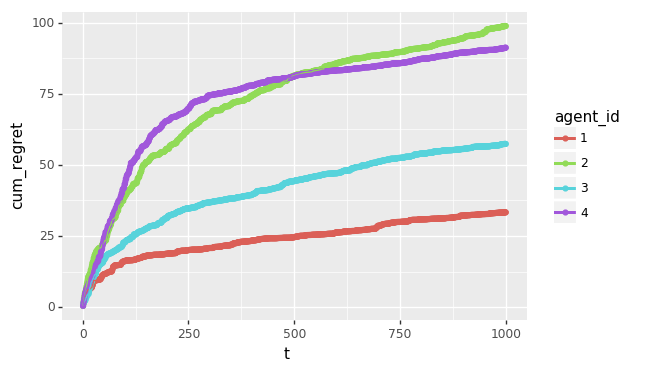

<ggplot: (8751105346413)>


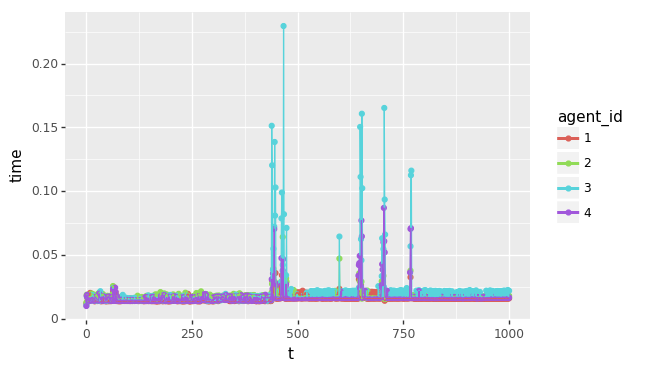

<ggplot: (8751105312797)>


In [12]:
plot_results(results)

In [13]:
time_limit=0.1
make_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=1)

make_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(sparsity/dim)),
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=1)

make_full_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='full',
                                          init_pt=None, verbosity=1)
make_cum_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='cum',
                                          init_pt=None, verbosity=1)

results, cum_regrets = simple_compare([make_sagald_agent(), make_prec_sagald_agent(),make_full_prec_sagald_agent(),make_cum_prec_sagald_agent()], num_articles, dim, sparsity, 1000, seed=2, verbosity=1)

theta [-0.41675785 -0.05626683 -2.1361961   1.64027081 -1.79343559 -0.84174737
  0.50288142 -1.24528809 -1.05795222 -0.90900761  0.55145404  2.29220801
  0.04153939 -1.11792545  0.53905832 -0.5961597  -0.0191305   1.17500122
 -0.74787095  0.00902525 -0.87810789]
Experiment: Step 0
 Sample: array([ 0.22436715,  0.4722598 , -0.42620014,  0.33934808, -0.36322452,
       -0.12083828,  0.78189073, -0.41884087,  0.4924855 ,  0.07127987,
       -0.00927148, -0.51662839, -0.72501376, -0.00617196,  1.18338662,
        0.37475657,  1.19990867,  0.01995096, -1.57614758,  1.18048814,
       -0.05354526])
 Steps taken: 0
 Sample: array([ 1.10427594,  0.75655809,  0.84901847,  0.45630587, -2.95375555,
        0.83750289,  0.29040717,  0.7614484 ,  0.90225639,  0.33184394,
        0.66295112, -1.44567507,  0.10853347,  0.71867728,  0.66000051,
       -0.8750528 , -1.83235847, -0.59974523,  0.04651067,  0.27486642,
        1.63545167])
 Steps taken: 0
+ (1, 1)
 Sample: array([ 1.23956381, -0.73954635,

 Sample: array([-0.83115441, -0.67977659,  1.78520972, -0.95207355,  0.65996638,
       -0.62477087,  0.0343114 ,  1.0348087 , -0.26810742, -0.62068753,
       -0.43492371,  0.89483148,  0.18337482, -0.46580936, -0.09110763,
       -0.6531533 ,  1.19641312, -2.10413065, -0.44294543, -1.95969119,
       -0.79641035])
 Steps taken: 141
Experiment: Step 6
 Sample: array([ 0.57558679, -0.46052964,  1.37867718,  0.49158302, -1.45262305,
        1.41766046, -1.90166878,  0.47013961, -0.84154484, -0.66506424,
        0.12268316, -1.04260039,  0.96817563,  1.21005598,  0.70938746,
       -0.20873893, -0.12451702, -2.38342426, -0.02614759,  1.64147656,
       -2.19959367])
 Steps taken: 869
 Sample: array([ 0.67898066,  0.50766042,  0.02511785, -1.59961152, -0.48529709,
        0.66859997, -0.12908057, -1.13919988, -0.06787688,  0.39907739,
       -0.22961379, -1.01166971, -1.91666835,  1.28440363, -1.81655906,
        0.61065609, -0.54374472,  0.48160371,  0.86255368,  0.99269647,
       -1.17

 Sample: array([-1.21376521, -0.14775974, -1.17658953, -0.18383622,  0.21936351,
       -0.07418055, -0.61214263, -0.02095786,  0.77117222, -0.36442997,
       -0.39565522, -0.55452484, -0.5688669 ,  0.66037181, -0.63993756,
       -1.27726536,  1.10481358, -2.01295873, -0.73257568, -1.84251609,
        0.52044141])
 Steps taken: 161
Experiment: Step 12
 Sample: array([ 0.16297332, -0.6785604 , -0.049342  , -0.45228627, -1.66065231,
        2.27980223,  0.21425831, -0.06452865,  0.90372247, -1.3757104 ,
       -0.2300307 , -0.78193369, -0.77779964,  0.15467132, -0.02476616,
        0.09370583, -0.72158746,  0.75053054, -0.36496746, -0.37085702,
       -0.97561409])
 Steps taken: 844
 Sample: array([-1.19812782, -0.35403301, -0.18334697, -0.7405313 , -0.15645467,
        0.01429927,  1.73802045, -0.03785187, -1.13975025,  0.02239473,
       -0.09632183, -1.919096  ,  0.38969588,  0.77725711, -1.93832958,
       -0.32380351,  0.13181106, -1.13108429,  0.59739537,  0.35890915,
        0.8

 Sample: array([-2.30073543, -1.41911958, -1.90847935, -0.32491579,  0.28046682,
       -0.32115118,  0.72198391, -0.83061951, -0.33917233,  0.19644896,
        0.10585898, -0.12592902,  0.10581089,  0.55341172, -0.13223952,
       -0.76753446,  0.05243229, -0.9285858 , -0.71609148,  0.55873249,
        0.4808003 ])
 Steps taken: 130
Experiment: Step 18
 Sample: array([-0.79489033,  0.37971124, -0.434983  , -0.84245158, -2.60197631,
        0.40738804, -0.75793916,  0.01183572,  0.25591886, -0.57637104,
       -1.54619984,  0.50712261,  1.14999478,  0.71256388, -0.40620059,
       -0.78061821, -1.21265035,  0.30222255, -0.15083127,  1.02634263,
        0.44187501])
 Steps taken: 548
 Sample: array([-1.28912521,  0.12923598,  0.1486182 , -0.57214101,  1.21950995,
        0.62466091,  0.97698888, -1.43188676, -0.96543567, -0.92648144,
       -0.1922313 , -0.54008677,  0.03245158,  0.62827054, -0.87820454,
        0.21236494, -0.55026428, -0.57669723, -1.43746555,  0.12064874,
        0.3

 Sample: array([-1.89489837, -1.83549617, -0.33280311,  0.74770107, -1.25810806,
        0.07971051,  0.39154287, -2.26323603,  0.12473955, -0.92730701,
       -0.85963396, -0.40821686,  0.69143699,  1.12593452, -0.05008257,
        0.50794759, -0.2258117 ,  0.49908851,  0.21992886,  0.46182351,
       -0.29388005])
 Steps taken: 175
Experiment: Step 24
 Sample: array([-0.3388475 , -2.07419571, -0.31851409, -0.0347718 , -0.99683727,
       -0.97025703, -1.47623132, -2.95337251, -0.37800918, -0.43554745,
        0.79390085,  0.64889316,  0.34603523,  0.12621766,  0.68179796,
        0.97367645,  0.47087629,  2.65390369,  2.48417112,  0.59673767,
       -0.63678875])
 Steps taken: 890
 Sample: array([-1.32945067,  0.24009746,  0.48432742, -0.34877491, -1.26004359,
       -0.81237554,  1.017306  , -0.60382714, -0.48576297, -0.81507761,
       -0.36332384, -1.8860935 , -0.11563854, -0.3655254 , -0.74594174,
       -1.06857499, -1.52166856,  0.67883699, -0.45405068,  1.3951019 ,
        0.9

 Sample: array([-1.60457846, -1.83176533,  0.25063813,  0.46884519, -2.52266253,
       -0.87836755,  0.22576239, -0.72769278,  0.15512066, -1.21897808,
       -0.27564367, -0.46580442,  0.74227965,  1.66797595, -0.27744724,
       -0.06691337, -1.08689473,  0.6256625 ,  0.1029753 ,  1.7735402 ,
       -0.80501257])
 Steps taken: 175
Experiment: Step 30
 Sample: array([-1.09241356, -0.08987583,  0.72848025,  1.52739804, -0.67307107,
       -0.4434302 , -0.78525668,  0.49815223,  0.61673671, -1.858461  ,
       -0.85989433,  0.88113367,  0.51875367, -1.1083522 ,  0.93759958,
       -0.94135567,  0.8432259 ,  1.09344208, -0.20934261,  1.48544134,
        0.02117544])
 Steps taken: 851
 Sample: array([-1.40413856,  0.33533092, -0.20791632,  0.41933393,  0.02540243,
        0.42901003,  0.26644136,  0.87062299, -1.45920723, -1.48335683,
        0.59308635, -1.31026596, -0.13427099, -1.19258733,  0.87211472,
       -1.04342574, -1.47303781,  0.05753929, -1.32916528,  1.04374268,
        0.7

 Sample: array([-1.22939028, -1.80931918, -0.87574543, -0.00790917, -0.62843772,
       -2.00906397,  1.19734267, -0.57170914, -0.20374762, -1.48096786,
       -1.63540464, -1.91881106,  0.48986188,  0.45902659,  0.09936627,
        0.38456365, -0.76873601,  0.98506606, -0.51048145,  1.34549733,
        0.54730562])
 Steps taken: 175
Experiment: Step 36
 Sample: array([-0.11745   , -0.18859553, -0.75758876,  0.04356862,  0.04658887,
       -0.42711414, -2.34544078, -0.30336693, -0.48740603, -0.05981925,
       -1.29202527,  0.66946014,  0.67733133, -1.88919954,  2.12928118,
        0.34644367, -0.28567759,  1.70578327, -0.29188494,  1.23260133,
        0.85489045])
 Steps taken: 821
 Sample: array([-0.94022228,  0.54337038, -0.94311829,  0.14828374, -0.49614487,
       -0.77825717, -0.21672642,  0.40746065, -2.37046619,  0.3831307 ,
        0.22439321, -0.72948113, -0.54066405, -1.16025933, -0.08766205,
        0.18355914, -0.73370157,  0.18342883, -1.13334358,  0.48164053,
        0.2

 Sample: array([-0.77895732, -0.6456134 , -0.690087  , -0.75753605, -1.48360428,
       -2.49788378,  0.77512938, -0.33314553,  0.21703353, -0.7000285 ,
       -2.00158578, -1.17461142,  0.86693159, -0.0860844 ,  0.45371693,
        0.0932115 , -0.13510164,  0.05112378,  0.43748038,  0.26261728,
        1.02188066])
 Steps taken: 169
Experiment: Step 42
 Sample: array([-0.30991004,  0.18673085, -0.51028351,  1.62925771, -0.51638247,
        0.03841622,  0.50137   , -0.72159713, -0.61703655,  1.36301907,
       -0.86420844,  1.8843498 , -0.04802627,  0.47274891, -1.24162912,
       -0.73557113,  0.9052715 ,  0.43967232,  0.65823594,  0.40413143,
       -0.29272775])
 Steps taken: 814
 Sample: array([-2.05873015,  1.89763528, -1.2315056 ,  0.04925481, -0.53261333,
       -0.51993488, -0.23560095,  0.05588433, -0.68184554,  0.37569133,
        0.5619344 , -1.25635837, -0.623424  , -1.15929896, -0.86473551,
       -0.05311451,  0.19776895, -0.22018706, -0.57700332,  0.65916603,
       -0.1

 Sample: array([ 0.47966203, -1.69674335, -1.14690363, -1.23228811, -1.49811067,
       -2.33786685, -0.1145117 , -1.17637415, -1.18324   , -0.73274339,
       -0.94183011,  0.50400227,  0.81755789, -0.24206516,  0.26641877,
       -0.6794145 , -0.70000734,  0.47765333, -0.38487773, -0.21080186,
        1.31243225])
 Steps taken: 163
Experiment: Step 48
 Sample: array([-1.6459575 ,  0.50488077,  0.88511808,  1.58108144, -0.05835526,
        0.3032369 ,  0.40672601, -0.62042117,  0.42586965, -1.48595736,
       -1.0338462 ,  1.33501123,  0.95100886,  0.82041797,  1.0974223 ,
       -1.14912174, -0.61362683, -0.19499001, -1.06546213,  1.1555319 ,
       -0.49521334])
 Steps taken: 683
 Sample: array([-2.05877411,  1.59009507, -1.09640037,  0.51329989, -0.08205358,
       -1.64562653, -0.18680226, -0.29074685, -0.53091949,  0.70645277,
        0.08982784, -0.81419684, -0.68676408, -1.02596861, -0.89262588,
       -0.74031227, -0.91229933, -0.12688502,  0.06476364,  1.40718736,
        0.5

 Sample: array([ 0.15817884, -2.08215011, -0.97662102, -0.87991409, -1.15797621,
       -1.74836418, -0.59907553, -0.52577019, -0.65127864, -0.36386931,
       -0.11208284,  0.60948485,  1.25407721, -0.96823694,  0.13940364,
       -0.45543321, -0.11818271,  0.3693167 , -0.14665937, -1.02538588,
        0.58925485])
 Steps taken: 172
Experiment: Step 54
 Sample: array([-0.75916436, -0.12375113, -0.74671309,  2.22414796,  0.25065694,
       -1.70146842,  0.50189001, -0.33324003,  0.31190802, -0.88319186,
        0.25908955,  0.84287278, -0.52141098, -0.98206763,  1.99979161,
        0.34925025, -0.5127924 ,  0.04872117,  0.89560552,  0.65789129,
        0.23510243])
 Steps taken: 746
 Sample: array([-1.35381894,  0.97724185, -1.73142619,  1.02320771,  0.47011504,
       -1.29157757, -0.06371399, -1.45984391, -0.34505879,  0.85948367,
       -0.32627509, -0.03195794, -1.03549737, -2.16720673, -1.16109795,
       -0.68474386, -0.11689271, -0.32199899, -0.57592409,  1.05890465,
       -0.2

 Sample: array([ 0.58691277, -1.00856112, -1.90535542,  0.30124023, -0.61735606,
       -0.85356123,  0.09533109, -0.15582242, -0.64694563, -0.53430869,
       -0.8557246 ,  0.34330685,  0.72625929, -1.10830704, -0.43394391,
        0.56570531, -1.24140197, -0.47617446, -0.32879659, -1.05428963,
       -0.10585018])
 Steps taken: 173
Experiment: Step 60
 Sample: array([-0.11416993,  0.20367089, -0.50385518,  2.95152564, -1.13613735,
       -0.01375437, -0.95598514, -2.88655718, -0.31921859, -0.80539861,
        0.38873873,  0.8689226 ,  0.52994388, -0.92667119,  1.24114742,
       -0.67382923,  0.71228608,  0.06088785, -0.29386025,  0.51314298,
        0.19263308])
 Steps taken: 737
 Sample: array([-1.95511739,  1.60732593, -0.98380838,  0.92164714,  0.37343526,
       -0.98210849, -0.11710771, -1.41760949, -0.41547785,  0.45917713,
       -0.82699249,  0.696607  , -1.05302241, -0.98842005, -2.1004591 ,
       -0.12203071,  0.04303127, -0.52379481, -0.71925397,  0.54655511,
       -0.7

 Sample: array([-0.28738971, -0.56988542, -0.72959264,  0.52957516, -1.76185734,
       -0.76419256,  1.14366599,  0.93486224, -0.56348014, -0.89677109,
       -0.49682815,  0.30331407,  0.81717733, -0.08295771, -0.2184611 ,
       -0.21818747, -1.32704392, -0.31138935, -0.19276867, -1.23417184,
        0.3328948 ])
 Steps taken: 154
Experiment: Step 66
 Sample: array([-0.23848957,  0.16213842, -0.46928869,  1.81377979,  0.22229542,
        0.36000836, -0.25303208, -1.34591791, -0.0834895 , -0.71468621,
       -0.51025783,  0.22645592, -0.12615674, -0.27833165,  1.13621597,
       -0.26071661, -0.57858107,  0.946313  ,  0.57141323, -0.21985682,
       -0.52310192])
 Steps taken: 517
 Sample: array([-2.3763062 ,  1.48282964, -0.45767365, -0.02621681,  0.44268562,
       -1.7228166 , -0.26455196, -1.62586711, -0.55348388,  0.60282624,
       -1.58141282,  0.64913848, -0.07526549,  0.40863555, -1.34397815,
        0.47724826, -0.29858833, -0.67808154, -0.50143307,  0.67181881,
       -0.1

 Sample: array([-0.94090039, -0.28610081, -0.45545096,  0.63738672, -1.11867396,
       -0.40961142,  0.77416117,  0.63017138, -1.10814582, -0.76132721,
       -0.74654977,  0.35029852,  0.59291124,  0.70349721, -0.29994277,
        0.2946487 , -0.39548347, -0.04162481,  0.01325309, -0.92011867,
        0.37566685])
 Steps taken: 154
Experiment: Step 72
 Sample: array([-2.28385727,  0.54576037, -0.58906338,  1.46115928, -1.59139432,
        0.26704741,  0.84961115, -1.90108499, -0.98267342,  0.46511088,
        0.54650259,  0.73491092,  0.15357058,  0.45280335,  1.12527871,
       -0.39013345,  0.29791984,  0.97644785,  0.62350935,  0.87169607,
       -0.11374787])
 Steps taken: 492
 Sample: array([-2.41249042,  1.00667498, -0.96575028,  0.72203814,  0.54213365,
       -1.49452779,  0.53568828, -1.96137975, -0.64461348,  1.26666304,
       -1.49515214,  1.11227411,  0.58583611,  0.20214585, -0.79038659,
       -0.33543538, -1.50214898, -0.83351568, -0.87906947,  0.98826888,
       -0.3

 Sample: array([-0.30676705, -0.38273239, -0.63469726,  0.38977033,  0.00606401,
       -0.41611721,  0.13475571,  0.24092836, -1.40014975, -0.31234407,
       -0.28749576,  0.1926276 , -0.33267392,  0.11483808, -0.6343651 ,
        0.66873369, -0.37698741, -0.70475567, -0.17327833, -0.40145747,
        0.21308081])
 Steps taken: 154
Experiment: Step 78
 Sample: array([-0.89406757,  0.81753151, -1.8793925 ,  2.06967339, -1.63506565,
       -0.74217081,  0.29112068, -1.71817456, -2.21936602,  0.01763193,
        0.21501111,  1.18542415,  0.26433147,  0.84708069,  1.05625754,
        0.08239053, -0.34945113,  0.01726703,  0.26742641, -0.40822419,
        0.92189487])
 Steps taken: 516
 Sample: array([-1.69768694,  0.67053318, -1.47904953,  0.79599106,  0.21786319,
       -1.50490681,  0.39883906, -1.42359643, -0.53166278,  0.95227232,
       -2.01791033,  0.75161235,  0.94149091, -0.17735364, -0.59979549,
       -1.066886  , -1.66119528, -0.10332169, -1.39361009,  0.65536153,
       -0.4

 Sample: array([-0.26439668, -0.60889512, -1.76051522,  1.07776784, -0.64186525,
       -0.01340403, -0.01956784, -0.44884669, -1.0372006 , -0.19635456,
       -1.26488306,  0.2231183 ,  0.38293523,  0.3021118 , -0.15161528,
        0.29824409, -0.28407697, -0.58611652, -0.21727471, -0.26971748,
       -0.60258305])
 Steps taken: 152
Experiment: Step 84
 Sample: array([ 0.49814418,  0.67934481, -1.25888575,  0.86509006, -1.14239439,
       -0.29415383, -0.08331564, -1.45889979, -2.28635168,  0.46888936,
        0.84609182,  1.23796304,  0.24858547,  0.81681032, -0.30622909,
       -0.21875535, -0.7456482 ,  0.47522709, -0.32239186, -0.20365484,
       -0.30904315])
 Steps taken: 517
 Sample: array([-0.86780517,  0.15748266, -1.68161048,  0.31076915, -0.04668546,
       -1.10839715,  0.49322946, -1.16219275, -0.91351807,  0.12263321,
       -1.23917069,  0.55180969,  1.17540847, -0.6001988 , -0.84143998,
       -0.78353494, -1.89261563,  0.1117376 , -1.42143798,  0.13853063,
       -0.7

 Sample: array([-0.110829  , -0.79067273, -0.96380721,  0.2870181 , -1.30936137,
       -0.32008412,  0.19814611, -0.49946775, -1.1511502 , -0.1824852 ,
       -1.75147114, -0.32477373,  0.13437081,  0.20518588,  0.29605905,
        0.31653427, -0.10735907, -0.14299578,  0.24179224, -0.31811676,
       -0.29204524])
 Steps taken: 150
Experiment: Step 90
 Sample: array([-0.00975607,  0.61396674, -0.62832201,  2.80717036, -0.75443447,
       -0.43789558, -0.73519012, -1.16010205, -0.27559049, -1.56658812,
       -0.96084798,  0.88124512,  0.12609666, -0.4287829 ,  0.67059465,
        0.43717718, -0.33598839, -0.11608143, -0.99075789,  0.57836676,
       -0.39290235])
 Steps taken: 523
 Sample: array([-1.35785951,  0.33999134, -1.38186226,  0.12966879, -0.73456195,
       -1.70968126,  0.94140461, -0.49925155, -1.39793514,  0.36258514,
       -1.24915448,  0.56656358,  1.43294235, -0.96319273, -1.56025617,
       -0.27003505, -1.50994824,  0.31722102, -0.62459962,  0.22867852,
        0.1

 Sample: array([-1.21736305,  0.65089824, -0.51895776,  0.73165451, -1.07505209,
       -0.91312485,  0.38190794, -1.01576777, -0.91529064,  0.06861469,
       -1.42057426,  0.6183621 ,  0.54026751,  0.53286309,  0.34810747,
        0.14409011, -0.52234809, -0.13788314,  0.11374236, -0.12713452,
       -0.99080211])
 Steps taken: 150
Experiment: Step 96
 Sample: array([-0.01401904,  0.17672876, -1.30945169,  0.79384155, -1.06009887,
       -0.7531187 ,  0.97837523, -2.26901239, -1.16213881, -0.81561543,
        0.39521195,  2.20442178,  0.02264225, -0.89056803,  0.78157682,
        0.65644293, -1.49577675,  2.33748022, -1.4416203 , -0.37253079,
        1.0793891 ])
 Steps taken: 524
 Sample: array([-1.02526804,  0.54315726, -1.68226375,  0.85389109, -0.96050157,
       -2.53937455,  1.35407978, -0.30416959, -1.91147739, -0.41124483,
       -1.19367011,  0.16520488,  1.1139986 , -0.53345404, -1.02137245,
       -0.20960345, -1.59118763,  0.23493052, -0.39285139,  0.24321031,
        0.1

 Sample: array([-1.09826422,  0.12583989, -1.02717439,  0.91317628, -0.55426649,
       -0.68170849,  0.61475851, -0.70185944,  0.13576117, -0.42582801,
       -1.26749085,  1.09692708,  0.71429213,  0.10554403,  0.06686806,
       -0.47333418, -0.92801976, -0.30685382,  0.40845609, -0.40879821,
       -0.68716425])
 Steps taken: 155
Experiment: Step 102
 Sample: array([-0.33249051, -0.34557833,  0.48576043,  1.90950917, -0.49394967,
       -0.38576626, -0.49088141, -0.54091607, -1.5799574 , -0.58975622,
        0.16473193,  1.08472968, -0.06036387, -0.69099255,  0.70023469,
        0.4551173 , -0.54442541,  1.01526883, -0.32020058, -0.18218401,
        1.07859574])
 Steps taken: 529
 Sample: array([-0.88327674,  0.45248015, -1.80496912,  1.0714045 , -1.17048737,
       -2.25466875,  1.27132976, -0.18691386, -2.0236466 , -0.52120447,
       -0.8194352 ,  0.38784456,  1.22160197, -0.14070837, -1.15437196,
       -0.5009588 , -1.03544875,  0.20746393, -0.70550988,  0.12793816,
       -0.

 Sample: array([-0.8196862 ,  0.04959146, -1.60116885,  0.90798101, -0.63717828,
       -0.56226074,  0.27433133, -0.07879603,  0.00323163, -0.52569901,
       -0.71484919,  1.44531052,  0.20836604,  0.50583185, -0.22592915,
       -1.20636775, -0.74537734,  0.04674872, -0.30102735, -0.68292396,
       -0.67210425])
 Steps taken: 132
Experiment: Step 108
 Sample: array([-0.36391877,  0.97478139, -0.59984283,  1.0865464 , -0.92172864,
       -1.17702457,  0.31325108,  0.20143141, -0.54822264, -1.18894788,
        0.38347727,  1.72836377, -1.35489359, -1.03654705,  1.9167181 ,
        0.51503812, -0.68299955,  0.568421  , -0.25809407,  0.33867916,
       -0.93274722])
 Steps taken: 397
 Sample: array([-0.66906743,  1.01426345, -2.00086931,  0.54419096, -0.59147541,
       -2.48630044,  1.08657028,  0.13734332, -1.69214919, -0.41179433,
       -1.09143331, -0.22779947,  0.89238276, -0.97169671, -0.75185952,
       -0.80751401, -0.57155788,  0.18024127, -1.06212252,  0.11438368,
       -0.

 Sample: array([-0.7074275 , -0.46405325, -1.72897976,  1.1452908 , -0.18731835,
       -0.33438278,  0.51327885, -0.28179635,  0.07879765, -0.30400494,
       -0.26437239,  1.45868   ,  0.47348091,  0.15487297, -0.31730671,
       -1.69141622, -1.39350724,  0.10066577, -0.6115367 , -0.86365898,
       -0.5672134 ])
 Steps taken: 150
Experiment: Step 114
 Sample: array([-1.17693027,  0.68623806, -0.76704955,  1.75327994, -2.07096787,
       -1.70871055,  0.42140759, -0.00363474,  0.2176072 ,  0.13676115,
       -0.14781609,  0.59207262, -0.03618114, -0.13797558,  1.0223906 ,
        0.76045788, -0.44741587,  0.73175078,  0.08500341, -0.01013256,
       -0.0224537 ])
 Steps taken: 506
 Sample: array([-0.69395914,  0.9681926 , -1.83720436,  0.51985819, -0.32560974,
       -2.31384722,  0.92802995,  0.05894077, -1.96999386, -0.18031248,
       -1.11164463,  0.00338483,  0.57641251, -0.36568229, -0.903175  ,
       -1.16454503, -0.97093535,  0.69123503, -1.33848464, -0.45414792,
       -0.

 Sample: array([-1.00720953, -0.14952832, -1.04457933,  1.25224217, -0.25805645,
       -0.47734644,  0.28873644, -0.757907  , -0.09490802, -0.28686567,
       -0.63488072,  1.02106253,  0.68296992, -0.2871492 , -0.30432398,
       -1.03337079, -0.90351989,  0.18350224, -0.1486803 , -0.25983234,
       -0.44759314])
 Steps taken: 148
Experiment: Step 120
 Sample: array([-0.09387922,  0.30491755, -0.91603596,  1.00702647, -1.11329759,
       -1.32326786,  0.55265877, -0.42139137, -0.86376434, -0.93602756,
        0.61933756,  1.19963482, -0.36113251, -0.90161211,  1.09594499,
        0.10102506, -0.69131153,  0.6177186 , -0.47829892, -0.17560622,
        1.2972351 ])
 Steps taken: 518
 Sample: array([-0.57838776,  0.589199  , -1.78985273,  0.53461073, -0.61497238,
       -2.41989898,  1.15324882, -0.04830436, -1.89902676, -0.34443434,
       -0.6852942 ,  0.89011517,  1.39859524,  0.05704828, -1.28426253,
       -1.27941152, -0.5265822 ,  0.1840406 , -2.45770857, -0.50831509,
       -0.

 Sample: array([-0.85526375,  0.11801085, -0.27683376,  0.7575686 , -0.71526422,
       -0.63717877,  0.81535076, -0.67054489, -0.01215456, -0.55347028,
       -1.12074779,  1.34000794,  0.7407731 , -0.27737552, -0.57192788,
       -0.95606325, -1.42657212,  0.44761082, -0.24576438, -0.41789156,
       -0.89990708])
 Steps taken: 132
Experiment: Step 126
 Sample: array([ 0.56160882, -0.22966417, -0.25195913,  0.77255351, -0.39931358,
       -1.37038608, -0.66309355,  0.65773927, -0.87539987, -0.63202825,
       -0.1765368 ,  1.81988531, -0.44755759, -1.03641411,  0.34115471,
       -0.07994112, -0.3906555 ,  1.31438604, -1.54871745,  1.07158087,
       -0.66566014])
 Steps taken: 471
 Sample: array([-1.28865161,  0.32618393, -1.37548877,  0.97290814, -0.4575177 ,
       -2.08434   ,  1.10367734,  0.22617724, -2.3989206 , -0.29875162,
       -0.30157836,  0.94481947,  0.47281376,  0.37387205, -0.94577748,
       -1.27243202, -0.03447076,  0.0111172 , -1.87147959, -0.17172592,
       -0.

 Sample: array([-0.73618538, -0.11418199, -0.10938363,  0.83268006, -0.32562859,
       -0.93999441,  1.12562597, -0.70837685, -0.47845683, -1.28798427,
       -1.12229445,  1.04837174,  1.09048639, -0.39939967, -0.30479763,
       -0.61405967, -1.13664344,  0.52771774, -0.42548231, -0.24683058,
       -1.50290083])
 Steps taken: 155
Experiment: Step 132
 Sample: array([-0.46205845,  0.26186896, -1.14838805,  1.87571801, -1.93263033,
       -0.69202221, -0.78821779, -2.00952185, -1.47744252, -0.61561141,
       -0.3081471 ,  1.66639043,  0.08665039, -0.74694912,  1.08964985,
        0.17866519, -0.91184731,  0.56915336, -0.56652919,  0.75446439,
        0.18736249])
 Steps taken: 503
 Sample: array([-1.21461384,  0.69264776, -2.1564409 ,  0.843913  , -0.77212914,
       -2.38739613,  0.61917278,  0.13940468, -2.46735688,  0.56340226,
       -1.02160329,  1.67535197,  0.49786513, -0.00441861, -1.5840241 ,
       -1.4563179 , -0.23815335,  0.53171126, -1.19923787, -0.22448023,
       -0.

 Sample: array([-0.97859984, -0.05974955, -0.16811774,  0.70250394, -0.46937006,
       -1.21315156,  1.18312733, -0.24919666, -0.16982761, -1.03287547,
       -1.46838504,  0.96311802,  0.68316294, -0.17431858, -0.18184926,
       -0.9584748 , -0.44718854,  0.12885548,  0.53143172,  0.09879284,
       -1.40927458])
 Steps taken: 152
Experiment: Step 138
 Sample: array([ 0.17291036, -0.22823746, -0.04601548,  1.27390582, -1.24793173,
       -1.20066808,  0.85487028, -0.03394081, -0.9264376 , -0.88194664,
        0.3002688 ,  1.26702686, -0.309643  , -1.27141108,  0.76843928,
       -0.62214714, -0.23150767,  1.45896839, -1.40236428,  0.79646178,
       -1.28148713])
 Steps taken: 508
 Sample: array([-1.71175719,  0.56992019, -1.59766902,  1.25650085, -0.53965486,
       -1.73145251,  0.94214376, -0.26564529, -2.59165606,  0.8429368 ,
       -0.79789079,  2.01246216,  0.39239425, -0.35659699, -2.48450011,
       -1.13534899, -0.1796893 ,  0.79049971, -1.51116847, -0.35349647,
       -0.

 Sample: array([-0.69329685, -0.03594861, -0.01476252,  0.77139578, -0.75585547,
       -1.62613141,  1.11741145, -0.37986051, -0.38765408, -1.15658299,
       -0.84702906,  1.44056827,  0.41653689, -0.77882321, -0.22863113,
       -0.65843411, -0.43550828,  0.24329518,  0.44044043, -0.30002237,
       -1.35352199])
 Steps taken: 149
Experiment: Step 144
 Sample: array([ 0.57922461, -0.49191141, -0.36691959,  1.60317359, -1.08364042,
       -0.69999006,  0.0511349 , -1.11078134, -2.32277948,  0.23055121,
        0.48636002,  1.26603333, -0.65946528, -0.93817483,  0.8435395 ,
        0.51858837,  0.01057699,  0.72800736, -1.12509286, -0.43035351,
        0.10552493])
 Steps taken: 544
 Sample: array([-1.61639685,  0.42551024, -1.97826305,  1.37900436, -1.39922823,
       -0.96664234,  0.92835133, -0.91969416, -2.21674556,  0.79189375,
       -0.99808118,  1.41422949,  0.6113321 , -0.56784491, -2.0292939 ,
       -1.09603411,  0.20467655,  1.03021763, -0.82115452, -0.28139233,
       -0.

 Sample: array([-0.67862457,  0.23257314, -0.05167595,  0.87818325, -1.1091539 ,
       -2.0297651 ,  0.91408757, -0.15673567, -0.58509272, -0.66705154,
       -0.85485899,  1.44383857,  0.10444022, -0.90241364, -0.26121188,
       -0.41885818, -0.24989899,  0.38395401,  0.26903353, -0.05812137,
       -1.3125429 ])
 Steps taken: 151
Experiment: Step 150
 Sample: array([-0.67943658,  0.11851673, -0.40803522,  2.59160422, -1.21668215,
       -0.62606316,  0.08196009, -0.28134207, -1.20335433, -2.22670533,
        0.47324655,  0.41387717, -0.4781745 , -0.77416405,  1.26990519,
        0.66531683,  0.46806512,  0.86918943, -0.67236622,  0.35547905,
       -0.85829093])
 Steps taken: 543
 Sample: array([-1.71388222,  0.47494203, -1.64280679,  2.36617569, -1.64622856,
       -1.37572685,  1.12011684, -0.90845582, -2.09379078,  0.05513217,
       -1.00112577,  1.40625303,  1.53595874, -0.39956859, -1.51444965,
       -1.23301624,  0.42598156,  0.93859409, -0.92246118, -0.45566333,
       -0.

 Sample: array([-0.86130546,  0.14630799,  0.2247346 ,  0.78073439, -1.2467896 ,
       -2.58367592,  0.89681347, -0.31646975, -0.16335892, -0.71183151,
       -0.94557587,  1.63319626,  0.35407235, -0.62050336, -0.5049798 ,
       -0.1849298 , -0.05108185,  0.3247535 ,  0.04540321,  0.05238166,
       -1.21314206])
 Steps taken: 117
Experiment: Step 156
 Sample: array([ 0.48419671, -0.96645235, -0.17165323,  1.19208794, -1.43984136,
       -1.06940768, -0.28021634, -1.2237375 , -1.72214369, -2.52293922,
        0.71944337,  2.10831511, -1.25556807, -1.02552662,  0.43129238,
        1.09322591, -0.42227701,  1.54992389, -0.73474389,  0.59536342,
       -0.63112424])
 Steps taken: 438
 Sample: array([-1.751637  ,  0.31017973, -1.42296533,  1.98540277, -1.20939417,
       -1.63878178,  0.99194185, -1.04988605, -1.85721723, -0.00840687,
       -0.91804044,  1.37979193,  1.348679  , -0.28290073, -1.22630716,
       -1.3147616 ,  0.01693694,  1.09274696, -0.12329185, -0.52024058,
       -0.

 Sample: array([-0.90578975,  0.51514236,  0.09097168,  1.08214554, -1.21473195,
       -2.01363083,  0.90480191, -1.50163698, -0.21868403, -1.06130931,
       -0.54614178,  1.75085786,  0.34524013, -0.74938347, -0.04797426,
       -0.52345218,  0.53550636,  0.2367003 , -0.01217131,  0.01277022,
       -1.29371499])
 Steps taken: 146
Experiment: Step 162
 Sample: array([-0.39342046,  0.2038607 ,  0.74916459,  1.29405624, -0.77185385,
       -0.60923414,  0.23247533, -0.53337081, -1.20718713, -0.3886776 ,
        0.85072778,  1.71357965, -0.62460994, -0.95706738,  0.68623397,
       -0.04575178,  0.1593407 ,  0.88649361, -1.01684521, -0.16398654,
       -0.4196234 ])
 Steps taken: 480
 Sample: array([-2.12703204, -0.05037352, -1.13511406,  1.55068635, -0.98548128,
       -1.86160089,  0.94138213, -1.48735611, -1.8162249 ,  0.2029648 ,
       -0.60509428,  1.93318364,  1.2866977 ,  0.09977967, -0.55234742,
       -0.400453  , -0.25262852,  0.53265217,  0.45361257, -0.62552806,
       -0.

 Sample: array([-2.95038119e-01, -1.92997274e-03, -6.11438813e-02,  7.96608828e-01,
       -1.11898494e+00, -1.98831331e+00,  8.03594523e-01, -1.81393748e+00,
       -7.71003299e-01, -1.03637566e+00, -5.33485690e-01,  1.31790092e+00,
        4.97932931e-01, -9.76602880e-01, -3.58300440e-01, -5.60255951e-01,
        2.62857210e-01,  3.25848278e-01, -2.09058173e-01,  1.27446017e-01,
       -8.71124732e-01])
 Steps taken: 153
Experiment: Step 168
 Sample: array([-0.96540378, -0.8090806 , -1.84822736,  1.47793744, -1.13131472,
       -0.41811799,  0.56546901, -1.30676795, -1.4368271 , -1.95194727,
        1.03798228,  1.55215633,  0.21451877, -0.39479321,  0.56668063,
        0.45992293, -0.55362272,  2.26996679, -0.70158538,  0.86543195,
       -0.18700451])
 Steps taken: 523
 Sample: array([-2.04508689, -0.34472271, -1.30709895,  1.31146416, -0.90041228,
       -1.49799936,  0.89323479, -1.50289166, -1.90543382,  0.37890025,
       -0.32289341,  2.41168558,  1.29833721,  0.30590045, -0.9

 Sample: array([-0.12624302, -0.09197333,  0.31503924,  0.96645956, -1.24152165,
       -1.46558674,  0.82428562, -1.28180042, -1.4206225 , -1.41715896,
       -0.66627607,  1.7118678 ,  0.40462304, -0.82576883, -0.98210925,
       -1.04891663, -0.26155375,  0.29483754, -0.70283704,  0.39908902,
       -0.23306824])
 Steps taken: 152
Experiment: Step 174
 Sample: array([ 0.40338614, -0.10793846, -1.06002013,  1.4340466 , -0.98419799,
       -1.1249103 , -0.75074416, -1.19459371, -0.9194634 , -0.59898868,
        0.44797032,  2.07741081,  0.57939243, -1.07910294, -0.33194967,
        0.85723343, -0.45867776,  0.45880657, -0.70321087,  0.46606121,
       -1.15594979])
 Steps taken: 527
 Sample: array([-1.54819059, -0.7308666 , -0.98696351,  0.95168956, -1.60714674,
       -1.46619027,  0.80610502, -1.27979818, -2.16823459,  0.0318784 ,
       -0.815067  ,  2.69028922,  1.51736612,  0.36934447, -1.25744641,
       -0.31651974,  0.09680036,  0.64042107,  0.0353996 , -0.10605901,
       -0.

 Sample: array([-0.37548698,  0.17968982, -0.05781969,  0.88249564, -0.82642433,
       -1.59711569,  1.24540006, -1.6338888 , -1.36682466, -1.44135712,
       -0.28919342,  1.94135626,  0.61856859, -1.02307242, -0.26774665,
       -1.07547389, -0.52659026,  0.69660987, -0.64115687, -0.26251856,
       -0.91418406])
 Steps taken: 151
Experiment: Step 180
 Sample: array([-0.07646005, -0.13138649, -0.21070122,  1.72487942, -2.17471604,
       -0.9089022 ,  1.06816589,  0.05648755, -1.05754581, -1.68080227,
       -0.33922666,  1.69334913, -0.42968607, -0.67845346,  0.21915016,
        0.40478541,  0.04675677,  1.74587499, -1.57266379,  0.41155303,
       -0.93756369])
 Steps taken: 531
 Sample: array([-1.14964952, -0.86134945, -1.77011695,  0.96822404, -1.60918064,
       -1.48461722,  1.10437858, -1.44557478, -2.27849746, -0.08223111,
       -0.76012419,  2.18688385,  0.85453814,  0.6583244 , -1.02965526,
       -0.44123549,  0.13518439,  0.40753694, -0.17927289, -0.2424881 ,
        0.

 Sample: array([-0.10090937,  0.48941586, -0.13216333,  0.92620922, -0.46774481,
       -1.37420135,  1.00542275, -2.11842538, -1.26026552, -1.35407944,
       -0.33448946,  1.774578  ,  0.37774571, -0.90111951,  0.05734294,
       -0.73639494, -0.39002404,  0.20634897, -1.26414557, -0.18401526,
       -1.54531993])
 Steps taken: 153
Experiment: Step 186
 Sample: array([ 0.29795872,  0.29776587, -0.23185871,  0.34367235, -0.40665758,
        0.16056436,  0.83288883, -1.0408644 , -1.12997058, -1.77194283,
        0.70665842,  0.85050466, -0.22124226, -0.55752214,  0.25919126,
       -0.18787503, -1.01449001,  1.09684387, -0.68943073,  0.68237849,
        0.39241022])
 Steps taken: 524
 Sample: array([-1.10642806, -0.55005462, -1.17840175,  0.91863327, -1.32922614,
       -1.73016629,  0.77453207, -1.69360463, -2.62546951, -0.06375741,
       -1.14181247,  2.15416999,  0.64353488,  0.18522181, -1.4464123 ,
       -0.52238518,  0.58485526,  0.59244257, -0.50508685,  0.39575191,
       -0.

 Sample: array([ 0.02560195,  0.33438856, -0.21813263,  0.89467557, -0.88865822,
       -1.29307469,  0.94496757, -1.64243348, -1.47754206, -1.75959012,
       -0.71519741,  1.63113096,  0.34768834, -0.4211532 , -0.04132515,
       -0.24006459, -0.58299567, -0.06865152, -1.08110586, -0.40083613,
       -1.72005338])
 Steps taken: 154
Experiment: Step 192
 Sample: array([-0.65171529, -0.22367728, -0.65222626,  1.6093789 , -0.92019626,
        0.01209531, -0.16625753, -1.16389564, -0.42711397, -0.4764753 ,
        0.73372562,  1.64054195,  0.21874122, -1.30567605,  0.33971854,
        0.34352503, -0.87423001,  1.52163106, -1.59715434,  0.80823989,
       -0.12580238])
 Steps taken: 528
 Sample: array([-1.49024405, -0.11294192, -0.80704123,  1.1561515 , -1.39854685,
       -1.3600868 ,  0.73967877, -1.57918698, -2.4239916 , -0.57561914,
       -0.79334128,  2.17707473,  0.83564434, -0.25644702, -0.937961  ,
       -0.59127966,  0.34883732,  0.87067749, -1.00898032,  0.52950912,
       -0.

 Sample: array([ 0.35550337,  0.48437081, -0.59938404,  0.48435334, -1.01149553,
       -1.432844  ,  0.99526061, -1.62293791, -1.30376021, -1.60450657,
       -1.21634583,  1.78896992, -0.14948694, -0.70149411, -0.24643641,
       -0.19962658, -0.45855884,  0.17685176, -1.12326065, -0.43045301,
       -1.11578573])
 Steps taken: 155
Experiment: Step 198
 Sample: array([-1.29349343, -0.13436327, -0.54945517,  1.36148226, -0.14835142,
       -0.82992813,  0.50447479, -1.5440805 , -0.54884369, -0.0222846 ,
        1.34106566,  1.16648033, -0.32202439, -0.84772999,  0.06247933,
        1.40580574, -0.41772431,  1.38599644, -1.18705612,  0.59916142,
        0.08725745])
 Steps taken: 533
 Sample: array([-1.44125935,  0.07672101, -1.41840148,  1.18560358, -1.05858687,
       -1.54648982,  0.68437355, -2.09480843, -1.80575664, -0.65791835,
       -1.00243859,  1.95067505,  0.44170971,  0.26652237, -1.37711364,
       -0.57997815,  0.24150943,  1.00343099, -1.17391566,  0.8415205 ,
       -1.

 Sample: array([-0.05384991,  0.07668556, -0.32273728,  1.02220438, -1.03823895,
       -1.55727961,  0.80112609, -1.43901234, -1.201755  , -1.89471077,
       -1.29205838,  1.74014193, -0.47945473, -0.78819426, -0.1560859 ,
       -0.64339512, -0.30677164,  0.76175966, -0.68988862, -0.3484486 ,
       -0.92330778])
 Steps taken: 153
Experiment: Step 204
 Sample: array([ 0.38080692,  0.38574458,  0.17252628,  1.18099258, -1.00344992,
       -0.36508831,  0.40563234, -1.1867525 , -2.51128255, -0.74423276,
        0.30001782,  1.59002542,  0.09269855, -1.06404851, -0.154267  ,
        0.30261031, -1.34615861,  1.33997743, -0.9832821 ,  0.18142976,
        0.36851729])
 Steps taken: 527
 Sample: array([-1.46854112, -0.0137567 , -1.67254934,  1.3097516 , -1.35859297,
       -2.05340702,  0.98373732, -1.90942164, -2.48570276, -0.03795143,
       -1.21782435,  1.8384905 ,  0.53264676,  0.05889289, -1.22008733,
       -0.08352167,  0.49370024,  1.11913634, -1.43816727,  0.37661906,
       -1.

 Sample: array([-0.10225802,  0.28489543, -0.85731103,  0.99077799, -1.13787242,
       -1.53090829,  1.20029905, -1.24509985, -0.93956501, -1.46822341,
       -1.31137016,  1.51116459, -0.35761986, -0.54238268, -0.15411752,
       -0.22580871, -0.53885201,  0.57936667, -0.97429022, -0.24650013,
       -0.7607549 ])
 Steps taken: 154
Experiment: Step 210
 Sample: array([ 0.58172107, -0.00993847,  0.1706965 ,  1.70243158, -1.59949784,
       -0.28212194, -0.03223319, -1.61106711, -1.390687  , -1.4741181 ,
        1.00723649,  0.83383448, -0.0295843 , -1.38404069, -0.01104329,
       -0.04056917, -0.15513858,  0.78902988, -0.86489054,  0.53939568,
       -0.98474426])
 Steps taken: 542
 Sample: array([-1.11750145, -0.36593219, -2.24043465,  1.1513382 , -0.88762915,
       -2.40430194,  0.85631031, -1.45591432, -2.31400775, -0.2452726 ,
       -1.1728586 ,  1.60427135,  0.84103397,  0.18330952, -0.88444489,
        0.3459203 ,  0.67401735,  0.71942016, -1.33989307, -0.02072631,
       -1.

 Sample: array([-0.58036263,  0.18893227, -0.81843526,  0.9301136 , -1.21645135,
       -1.38951715,  1.17614386, -1.10057259, -0.71552108, -1.17708653,
       -0.65362052,  1.61330268, -0.45724906, -0.54828085,  0.23762637,
        0.66210718, -0.91286552,  0.6501067 , -0.93989859,  0.10328026,
       -1.1851179 ])
 Steps taken: 149
Experiment: Step 216
 Sample: array([-0.19562414, -0.13016223, -1.39338644,  1.87042175, -2.02834885,
       -0.83070755,  0.4657846 , -0.65305589, -1.85778497, -1.36508067,
       -0.19071999,  1.5265768 , -0.17480563, -0.73956575,  0.63533872,
       -0.23663776,  1.00892754,  1.30829163, -0.38644092,  0.35547683,
       -0.24378467])
 Steps taken: 521
 Sample: array([-1.11124844, -0.11659695, -2.43594187,  1.18685175, -1.36839166,
       -1.84969386,  0.92252025, -0.93496412, -1.69047154, -0.43941508,
       -2.02237071,  1.76195449,  0.44354278,  0.11226371, -0.39887362,
       -0.02453806,  0.2724068 ,  0.66282932, -1.45484172,  0.28892152,
       -0.

 Sample: array([-0.75448588,  0.20767072, -0.86664127,  1.18979013, -1.40118436,
       -0.98333524,  1.16006071, -1.57888132, -0.81577414, -1.12059393,
       -0.55678451,  1.60089417, -0.07515108, -0.59595207,  0.17141388,
        0.83001692, -0.76967433,  0.99467777, -0.81576343,  0.10846907,
       -1.1230253 ])
 Steps taken: 150
Experiment: Step 222
 Sample: array([-0.54830159,  0.5673664 , -0.24923819,  1.60852587, -1.69369129,
       -0.75203986, -0.29553451, -0.206748  , -1.45684561, -0.78344068,
        1.15118579,  1.55704357, -0.35287565, -0.80310946, -0.05554715,
        0.03562227,  0.36473174,  1.29402719, -0.35627575, -0.28769095,
       -0.45701969])
 Steps taken: 523
 Sample: array([-1.7368565 , -0.14933929, -2.37352871,  2.3557983 , -1.54795697,
       -1.86494669,  1.01737798, -1.01508362, -1.25268847, -0.40848919,
       -1.38492906,  2.18003219,  0.50827815,  0.20938061, -1.09918611,
       -0.22237105,  0.26623593,  1.22329143, -1.11320388,  0.25763874,
       -0.

 Sample: array([-0.14550601, -0.12590051, -1.02107301,  0.75418915, -1.27803833,
       -1.3558583 ,  1.29107091, -1.55868787, -0.77694687, -0.93594152,
       -1.01313366,  1.67543655, -0.40773921, -0.89011496,  0.1336714 ,
        0.79215248, -0.82389121,  1.22052861, -0.70600784, -0.02020172,
       -1.37758788])
 Steps taken: 154
Experiment: Step 228
 Sample: array([-0.782251  ,  0.34102314, -1.49952147,  1.44308886, -1.32424951,
       -0.21570511, -0.46417182, -0.81847673, -1.51868814, -1.04622064,
        1.24640327,  1.83505168, -0.0938391 , -0.34104153,  0.36101564,
        0.46787078, -0.1891353 ,  1.67402676, -0.40048066, -0.02922586,
       -0.98398485])
 Steps taken: 538
 Sample: array([-1.62809888, -0.10144245, -2.65662969,  2.06439214, -2.05785143,
       -1.68324188,  0.29204742, -0.73894044, -1.7639336 , -0.5895548 ,
       -1.16174415,  2.20217191,  0.44615575,  0.3857367 , -0.6589839 ,
       -0.20564723,  0.39901538,  1.94168071, -1.16611346,  0.43738119,
       -0.

 Sample: array([ 0.12431415, -0.14128902, -1.13479269,  0.57867258, -1.47072178,
       -1.76039223,  1.1165617 , -1.66490811, -0.84842526, -1.05509152,
       -0.74072512,  1.92997335, -0.24995522, -0.73889768, -0.14227654,
       -0.0352527 , -0.75687194,  1.30382112, -0.77926786, -0.35031907,
       -1.4260817 ])
 Steps taken: 152
Experiment: Step 234
 Sample: array([-1.70257558e+00,  4.47095551e-01, -1.05266740e+00,  1.87546143e+00,
       -1.17022118e+00, -1.24708697e+00,  1.79272655e-01, -6.07163078e-01,
       -6.37935604e-01, -9.78319747e-01,  1.17752618e+00,  1.56104171e+00,
        2.62560193e-01, -1.81390612e+00,  9.59101148e-01,  2.91920631e-01,
       -2.41253442e-01,  1.83728852e+00, -1.57835082e-03,  8.20527770e-01,
       -7.73442530e-01])
 Steps taken: 535
 Sample: array([-1.37080069,  0.21395052, -2.19480278,  1.93270787, -1.59037371,
       -1.86516306,  0.32292162, -1.04132587, -2.2746308 , -0.15440141,
       -1.03068568,  2.22925527,  0.17836365,  0.48788621, -0.2

 Sample: array([-0.00731995,  0.05176482, -1.39250496,  0.56213886, -1.72964502,
       -1.73244587,  0.69495826, -1.3052325 , -0.48800436, -1.30836853,
       -0.56610907,  1.78650296, -0.20254308, -0.53420049,  0.11823739,
       -0.14052594, -0.71172942,  1.04722773, -0.88674382,  0.13346587,
       -1.32482347])
 Steps taken: 121
Experiment: Step 240
 Sample: array([-6.94696977e-01,  3.99707761e-01, -1.89966988e+00,  2.10920343e+00,
       -9.81746998e-01,  6.94066784e-02, -8.18533990e-01, -1.55803534e+00,
       -1.75834770e+00, -1.37771784e+00,  8.72786960e-02,  2.08202464e+00,
        1.88712361e-03, -1.60153168e+00, -2.58708093e-02, -3.00366231e-01,
       -4.20612602e-01,  2.11348478e+00, -1.25859263e+00,  7.18010360e-01,
        3.30976774e-01])
 Steps taken: 438
 Sample: array([-1.07772723,  0.30795563, -2.78251377,  1.73833634, -1.34541728,
       -1.3834763 , -0.05959272, -1.40530108, -2.68528951,  0.08816619,
       -1.0592986 ,  2.26031152, -0.2017768 , -0.16442946, -0.3

 Sample: array([-0.50726163,  0.14877029, -1.14265973,  0.76018375, -1.59846086,
       -1.74318196,  1.16043242, -1.00171951, -0.20276815, -1.37893069,
       -0.69424555,  1.99546447, -0.08769553, -0.14414768,  0.32401286,
       -0.20747662, -0.58403652,  0.58672648, -0.66093388, -0.01220784,
       -1.19537957])
 Steps taken: 83
Experiment: Step 246
 Sample: array([-1.63130832,  0.12196081, -0.58732839,  1.00539724, -1.9299157 ,
       -0.74924634,  0.19573929, -0.29419611, -1.46708257, -1.09790464,
        0.85486986,  2.21702776, -0.15825278, -0.31205531,  0.67820468,
        0.4667249 , -0.05579991,  2.01147299, -1.02730734,  0.46881434,
       -0.11873657])
 Steps taken: 363
 Sample: array([-1.17019321,  0.01232968, -2.56785616,  1.91851466, -1.54593137,
       -1.71208396, -0.03844435, -1.45158479, -2.66739745,  0.21983246,
       -0.78039801,  2.29288924,  0.19922602, -0.11675806, -0.83187793,
       -0.73319536,  0.84797547,  2.20761982, -1.61252447, -0.11566078,
       -0.3

 Sample: array([-0.4303356 ,  0.24569973, -1.13091321,  0.53117131, -1.32936845,
       -1.96156698,  0.81236543, -1.21758871,  0.03131925, -1.42987863,
       -0.18798742,  1.86781868,  0.21071997, -0.01524831,  0.6929415 ,
       -0.27890748, -0.71619321,  0.66045299, -0.70908288, -0.28995827,
       -1.05204984])
 Steps taken: 140
Experiment: Step 252
 Sample: array([-0.2642937 ,  0.0339008 , -1.74606073,  1.64624456, -1.87331861,
       -0.32266115, -0.27280828, -0.24866742, -0.36017041, -1.29860956,
        0.88420323,  1.6231329 , -0.72874859,  0.06325142,  0.38013197,
        0.33672478, -0.82154206,  1.35560163, -0.04915926, -0.6181351 ,
        0.36249526])
 Steps taken: 447
 Sample: array([-1.3563658 ,  0.07219459, -2.48930367,  1.94808785, -1.37431058,
       -1.78998472, -0.03148573, -1.23574079, -2.23375856, -0.09639289,
        0.12351856,  2.21540725,  0.47261647,  0.0610537 , -0.83192851,
       -0.80913504,  0.56581033,  1.90312985, -1.27381436,  0.03582496,
       -0.

 Sample: array([-0.79912098,  0.16992845, -0.67472522,  1.08095713, -1.04640716,
       -2.38783861,  1.14078132, -1.08430106, -0.37944039, -1.73637822,
       -0.26135535,  1.62323621,  0.11461464,  0.03884595,  0.52051592,
       -0.25090869, -0.57572093,  0.91265165, -0.17458768, -0.02823065,
       -1.16862336])
 Steps taken: 154
Experiment: Step 258
 Sample: array([-0.18236092, -0.28106621, -0.74618633,  1.79594529, -1.97748213,
       -0.89902822, -0.55102261, -1.39144911, -0.92982827, -1.50129639,
       -0.02452714,  1.86196978, -0.23528336, -0.96166808,  0.76022233,
        0.17603308, -0.47438148,  1.2314409 , -0.58270702,  0.41112893,
       -0.84763257])
 Steps taken: 532
 Sample: array([-0.89755323, -0.4325078 , -2.31998819,  1.23781241, -1.79568644,
       -1.75306883,  0.14247407, -1.12375564, -1.96389074, -0.21081899,
       -0.11496369,  2.21625708,  0.38960191,  0.25585801, -0.62920624,
       -0.33572095,  0.03288453,  1.4164182 , -0.3929144 , -0.04269556,
       -0.

 Sample: array([-1.10354564,  0.79484984, -0.33493511,  1.3184226 , -1.28143683,
       -2.83439488,  1.3599193 , -0.91376843, -0.63136347, -1.76245683,
       -0.09763368,  1.76564324,  0.07779128,  0.11155054,  0.39476637,
       -0.38176776, -0.35358086,  1.11590252, -0.36839342, -0.25374156,
       -0.83333374])
 Steps taken: 151
Experiment: Step 264
 Sample: array([-0.03250967,  0.96222605, -1.85791538,  1.48687501, -1.22829318,
       -0.684038  , -0.23577921, -2.03463112, -0.56366417, -0.73976411,
        0.92336797,  1.84762171, -0.57659318, -0.82688807,  0.88443835,
        0.34767623, -1.06222304,  0.45054574, -1.23379055,  1.61058907,
       -1.07565467])
 Steps taken: 539
 Sample: array([-0.51915139, -0.75281329, -1.62605038,  1.50946821, -2.08851624,
       -1.93045875,  0.00325203, -0.771282  , -1.92407111, -0.3569959 ,
       -0.37181871,  2.01441778,  0.2998935 ,  0.14060466, -0.99597325,
       -0.48678329, -0.12200287,  1.3317108 , -0.80022685,  0.06910696,
       -0.

 Sample: array([-1.47044403,  0.69535815, -0.37867022,  1.41489527, -0.62292997,
       -2.00305086,  1.17256644, -1.19793948, -0.66235732, -1.50685683,
        0.41253982,  1.75748212,  0.36541693, -0.39668377,  0.14458051,
       -0.61734726, -0.67882147,  0.95175619, -0.40961002,  0.95065421,
       -0.54861842])
 Steps taken: 155
Experiment: Step 270
 Sample: array([-0.64862569, -0.16321235, -0.26450365,  1.27637922, -0.03982194,
       -1.07962206,  0.01463524, -1.23412455, -0.94162608, -0.76176086,
        0.63456407,  1.43680457,  0.84345194, -0.99630132,  0.71804746,
        0.04916105, -0.30396303,  1.34998731, -0.93678891,  0.51435528,
       -0.95638071])
 Steps taken: 530
 Sample: array([-0.64255858, -0.8503596 , -1.5508166 ,  1.33822988, -2.2639299 ,
       -1.68905261,  0.11069088, -0.68232365, -1.71575514,  0.00775519,
       -0.32108752,  1.63911758,  0.43809159,  0.50715506, -0.90901038,
       -0.52553315, -0.258144  ,  1.49996686, -0.97169574, -0.12452226,
       -0.

 Sample: array([-1.36641156,  0.84964834, -0.1384643 ,  1.36686483, -0.64816638,
       -2.58511337,  1.16770899, -1.03971989, -1.02868174, -1.92970618,
        0.24557239,  2.00946212,  0.1743954 , -0.34273553,  0.57242664,
       -0.15052115, -0.54567206,  0.63735792, -0.56333693,  1.04438091,
       -0.73190816])
 Steps taken: 154
Experiment: Step 276
 Sample: array([ 0.77739063,  0.53602478, -1.38428831,  1.24140841, -1.04900842,
       -1.00902119, -0.83213185, -0.85546653, -1.70830586, -0.83689924,
        0.00610285,  1.35528307, -0.08208906, -1.38209037,  0.43957864,
        0.47478835, -0.1457908 ,  0.79229768, -0.92290891,  0.53446355,
       -0.3153803 ])
 Steps taken: 513
 Sample: array([-0.27679343, -0.24163819, -1.79870779,  1.27667303, -2.33413822,
       -2.44613315,  0.17819681, -0.5807849 , -1.8389657 , -0.26424366,
       -0.36009112,  2.20543872,  0.045603  ,  0.39400861, -1.20903272,
       -0.5360338 ,  0.1725444 ,  1.10923459, -1.10125113,  0.07376514,
       -0.

 Sample: array([-1.4166634 ,  0.93943035,  0.05651722,  1.25172724, -0.33181975,
       -2.73507251,  1.32089847, -1.02371645, -1.27004474, -1.71361133,
        0.05339083,  1.53696834, -0.07917757, -0.53786587,  0.57115804,
       -0.09226446, -0.0535445 ,  0.61931616, -0.6934499 ,  0.86918265,
       -0.7038229 ])
 Steps taken: 151
Experiment: Step 282
 Sample: array([ 0.09379195, -0.1217595 , -1.28794   ,  1.63578919, -0.83864208,
       -0.80907195, -0.66675923, -0.20865633, -0.74255132, -1.35384679,
        1.05790575,  1.38009541, -0.58343492, -0.9642913 ,  0.39330801,
       -0.41499476, -0.22031179,  2.09296612, -1.52693372,  0.54364697,
       -1.07806531])
 Steps taken: 512
 Sample: array([-0.56201552, -0.20831856, -1.96688231,  1.47624834, -2.45774346,
       -2.74337658,  0.94970644, -0.75352404, -1.48420538, -0.06059866,
        0.02293183,  2.00661507,  0.08638034,  0.38344062, -0.93539275,
       -0.96079544, -0.07985369,  0.79196619, -0.83433996,  0.07078706,
       -0.

 Sample: array([-1.19773297,  0.94365392, -0.51094007,  1.59813544, -0.53652646,
       -2.59110108,  1.43929273, -1.52459714, -1.33348733, -1.50190131,
       -0.1138023 ,  1.74435725, -0.1783483 , -1.06019719,  0.49008308,
        0.03505092,  0.01550396,  0.81778372, -1.1750942 ,  1.02271717,
       -0.53954087])
 Steps taken: 153
Experiment: Step 288
 Sample: array([-0.01350681,  0.06022683, -0.68683129,  1.68933899, -1.4916504 ,
       -0.57726132, -0.6040521 , -0.49177652, -1.25341964, -0.27638438,
        0.99554835,  1.45285407, -0.03570623,  0.3803624 ,  0.24142949,
       -0.65319292, -1.21037167,  1.17808405, -1.67482774,  0.79637299,
       -0.66895384])
 Steps taken: 509
 Sample: array([-0.37578557, -0.34779001, -2.02116376,  1.16118653, -2.32383345,
       -2.48276623,  1.05988851, -0.74879122, -1.52592855, -0.35738783,
       -0.09694477,  2.03580909, -0.24511776,  0.06117512, -0.83961301,
       -1.08390892, -0.15778689,  0.96708855, -0.76482985, -0.0719645 ,
       -0.

 Sample: array([-0.63713077,  0.77346371, -0.95786439,  1.52688557, -0.788938  ,
       -2.3763203 ,  1.18942604, -1.19695338, -1.83436852, -1.62906064,
       -0.14332141,  1.75486328, -0.0092253 , -1.70438652,  0.35949585,
       -0.05072825, -0.06288357,  0.91287185, -1.12424125,  1.12213557,
       -0.58783377])
 Steps taken: 151
Experiment: Step 294
 Sample: array([ 0.1241396 , -0.8233202 , -1.06633993,  1.37646052, -1.67056981,
       -0.50037644,  0.13649338, -1.45602748, -0.56895367, -0.40565099,
        0.41222392,  1.99834766,  0.3316366 , -0.69887366,  0.15431427,
        0.24369264, -0.43645703,  0.64818451, -0.91899305,  0.53496448,
       -1.20489029])
 Steps taken: 495
 Sample: array([-0.61082181, -0.33032994, -1.95231938,  1.45084627, -1.97062127,
       -2.87827307,  0.90942121, -0.96721023, -1.24221409, -0.5201062 ,
        0.16207894,  2.22138143, -0.50650553,  0.32364405, -0.77314527,
       -1.12952435, -0.18431453,  0.96614387, -0.56646613, -0.08994612,
       -0.

 Sample: array([-0.72941846,  0.51006432, -0.94873473,  1.48123134, -0.89137937,
       -2.27776644,  1.00120091, -1.63271456, -1.46968093, -1.4403492 ,
        0.02888264,  1.84634094,  0.05051017, -1.5130164 ,  0.44151052,
       -0.07878511,  0.23242412,  1.43686246, -0.69752031,  0.5281712 ,
       -0.54154055])
 Steps taken: 148
Experiment: Step 300
 Sample: array([ 0.15347958, -0.27723202, -0.59581085,  1.56811436, -1.11765987,
       -0.36890507,  0.61115768, -1.02500682, -0.46842025, -0.48946238,
        0.51293851,  0.88697283, -0.06055626, -0.42280804,  0.48911732,
       -0.46542312, -1.5119297 ,  1.26323914, -0.43156623,  0.2925731 ,
       -1.31249637])
 Steps taken: 494
 Sample: array([-0.48732387, -0.22505833, -1.95824303,  1.42203323, -1.93264837,
       -2.88921146,  0.57485092, -0.80669086, -0.23008428,  0.00291214,
       -0.32011576,  1.56324549, -0.29586832,  0.13152125, -0.98542463,
       -0.96371352, -0.10225503,  1.02886031, -0.80972986, -0.03948632,
       -0.

 Sample: array([-0.78860489,  0.4675701 , -0.78728409,  1.26691923, -0.55773153,
       -2.89937084,  0.91450778, -1.18261714, -1.13024131, -1.13613681,
       -0.38183152,  1.43041698,  0.29223585, -1.71321851,  0.63885736,
        0.09383401,  0.50647438,  1.04636778, -0.65052276,  0.55602517,
       -0.34448833])
 Steps taken: 133
Experiment: Step 306
 Sample: array([ 0.08054246,  0.09995072, -2.0575362 ,  0.95057642, -1.00272063,
       -0.16625049, -0.34646891, -0.78381328, -0.79023141, -1.01503668,
        0.7928656 ,  1.06943469, -0.25645318, -0.54830433,  0.50472543,
       -0.05682868, -0.73960632,  1.44812049, -0.61505662,  0.35008631,
       -0.37411523])
 Steps taken: 458
 Sample: array([-0.89362537, -0.28956212, -2.11432294,  1.347737  , -1.87514229,
       -2.56167716,  0.63513328, -0.93260793, -0.25255338, -0.07706157,
       -0.42647064,  1.66403257, -0.64114904,  0.38628627, -0.45235568,
       -0.47989494, -0.02576194,  1.18652246, -0.61584346,  0.31294238,
        0.

 Sample: array([-0.97913791,  0.8772662 , -0.62969564,  1.50200793, -0.83734487,
       -2.73269991,  0.91504379, -0.82411057, -0.74274668, -0.91002513,
       -0.51776585,  1.20973232,  0.24946912, -1.56576039,  0.43726347,
       -0.43297988,  0.45083198,  0.98264582, -0.0085643 ,  0.64972399,
       -0.47119183])
 Steps taken: 151
Experiment: Step 312
 Sample: array([-0.02871238, -0.05472689, -0.26486827,  1.66425455, -1.41958288,
       -1.22009923,  0.0701772 , -1.42913829, -0.13908201, -0.04623816,
        0.4775552 ,  0.89256985, -0.83319016, -0.96843575,  0.84372976,
        0.26406112, -0.57614268,  1.35840722, -1.05132306,  0.50138508,
       -0.69661242])
 Steps taken: 493
 Sample: array([-0.66169682, -0.19307131, -2.10205363,  1.61356342, -2.58606016,
       -3.28815469,  0.57010985, -1.19608651, -0.40439568, -0.13011413,
       -0.09032337,  1.86726312, -0.44161726, -0.23987971, -0.08743799,
       -0.71983889,  0.43990459,  1.1716691 , -0.79526742,  0.15371038,
       -0.

 Sample: array([-0.71770191,  0.50023906, -0.47194964,  1.63607241, -1.07052647,
       -2.90972427,  0.87265863, -0.39895836, -1.23437429, -1.09424851,
       -0.61273574,  1.16098269,  0.00821812, -1.14124911,  0.1926234 ,
       -0.48251143,  0.66087196,  0.91166152, -0.48205224,  0.5054288 ,
       -0.13406762])
 Steps taken: 145
Experiment: Step 318
 Sample: array([-1.13630995,  0.57582546, -1.5382922 ,  0.93798849, -0.16384593,
       -0.56282112,  0.18504626, -1.76805444, -1.14013473, -1.10864819,
        0.61171366,  1.80481182,  0.10666594, -0.37395876,  0.81015828,
        0.16755709, -0.52688507,  1.64981083, -0.4596869 ,  0.9679461 ,
       -0.95814415])
 Steps taken: 466
 Sample: array([-0.41301121, -0.53860844, -2.34654662,  1.40069195, -1.85925186,
       -2.96676135,  0.45087482, -0.88694917, -1.0178302 , -0.36036305,
       -0.52023512,  1.60409458, -0.13453502,  0.01143516, -0.16111657,
       -0.66645468,  0.17281331,  1.13731153, -0.67674685,  0.22007249,
       -0.

 Sample: array([-1.1449066 ,  0.13835603, -0.36554735,  1.67095212, -0.84082362,
       -2.74121305,  1.01502723, -0.69680968, -0.89898259, -0.71004371,
       -0.81514759,  1.52432915, -0.06380957, -1.07450942,  0.54400683,
       -0.38192969,  0.49671233,  1.0936383 , -0.26934585,  0.56699142,
       -0.31979004])
 Steps taken: 123
Experiment: Step 324
 Sample: array([-0.81625333,  0.39770746, -0.2858601 ,  0.8350005 , -1.01764693,
        0.15414575, -0.10314811, -0.86835649, -0.39731827, -1.08227781,
        0.94551202,  1.86754078,  0.00634679, -0.41705102,  0.1647296 ,
       -0.08428532, -0.18821811,  1.52125865, -0.42881268,  0.58648496,
       -0.78866456])
 Steps taken: 408
 Sample: array([-0.06220109, -0.6150953 , -2.56062376,  1.36945774, -1.52727419,
       -3.05909961,  0.62911662, -1.42579413, -1.15373116, -0.53658767,
       -0.56870543,  1.66237214,  0.28686299, -0.04987622, -0.51704873,
       -0.80965184, -0.2234666 ,  1.42434944, -0.85026822, -0.16973028,
       -0.

 Sample: array([-0.6714037 ,  0.23517393, -0.45709834,  1.26934642, -0.64262497,
       -2.42978098,  0.94852704, -1.04430424, -0.88402061, -0.81860869,
       -0.74390735,  1.52886891, -0.37589358, -1.43745306,  0.43798923,
       -0.730623  ,  0.30446217,  0.84875348, -0.22554489,  0.51788748,
       -0.50729375])
 Steps taken: 152
Experiment: Step 330
 Sample: array([ 0.31093223, -0.31018219, -1.43324501,  1.45619828, -0.80664573,
       -0.25140411, -0.59471994, -0.19030574, -0.41412808, -1.11573941,
        0.47905996,  1.02792477, -0.36801361, -1.38557389,  0.71359905,
       -0.22099383, -0.95635075,  1.17305213, -0.2419855 ,  1.77705916,
       -1.4039535 ])
 Steps taken: 515
 Sample: array([-0.21044068, -0.74846347, -2.24206431,  1.38474489, -1.50443559,
       -3.08549787,  0.35268533, -1.40563679, -1.15089619, -0.28629518,
       -0.71897047,  1.71814819,  0.42214377,  0.1112617 , -0.74512861,
       -0.5691666 , -0.09271057,  1.46763732, -0.81828209, -0.21713063,
        0.

 Sample: array([-0.74653622,  0.22876759, -0.69725584,  1.63679705, -0.96519326,
       -2.20601862,  0.83112201, -0.77302717, -1.07443906, -0.46070712,
       -1.04507346,  1.68467559, -0.28711007, -1.58173846,  0.3883848 ,
       -0.34589411, -0.14357156,  0.63529612,  0.06413059,  0.34511947,
       -0.82526463])
 Steps taken: 149
Experiment: Step 336
 Sample: array([-0.54384866, -0.24382024, -0.90058027,  1.38444829, -1.77887697,
       -0.25875344,  0.12495388, -1.3524312 , -0.79000251, -0.4219901 ,
        0.04343952,  1.70228605, -0.34986577, -0.88274176,  0.41278823,
       -0.67917979, -0.71772101,  1.56249377, -1.02147666,  0.90115121,
        0.55122608])
 Steps taken: 506
 Sample: array([-0.20056672, -0.49894634, -2.11459911,  1.47582959, -1.56354521,
       -2.65291373,  0.23877575, -1.10938477, -1.10721313, -0.8856331 ,
       -0.035384  ,  1.78937093,  0.30328301,  0.22193795, -0.80052178,
       -0.590686  , -0.11449981,  0.94942754, -0.65750852, -0.24905752,
       -0.

 Sample: array([-0.91644163,  0.28430287, -1.09454522,  1.44554589, -1.00219037,
       -1.93783865,  1.04680604, -1.07861513, -0.65095592, -0.37687543,
       -0.74712829,  1.87261347, -0.15714032, -1.634027  ,  0.18595935,
       -0.59961544, -0.1441359 ,  0.81757157,  0.1507616 ,  0.34380591,
       -0.96598947])
 Steps taken: 149
Experiment: Step 342
 Sample: array([-1.33917922, -0.27906952, -1.22842994,  1.74957905, -0.8836767 ,
       -1.20466312,  0.37113397, -0.48875276,  0.04096139, -0.89158225,
       -0.18409875,  2.02517066, -0.48200749, -0.92100388,  0.20470614,
        0.51690333, -0.29410233,  2.18915911, -0.39402824,  1.10270194,
       -0.19753683])
 Steps taken: 506
 Sample: array([-0.1877861 , -0.63189814, -2.4716386 ,  1.79331087, -1.62585115,
       -2.37486356,  0.52993909, -0.90035696, -1.09512895, -0.45507386,
       -0.01952182,  1.46702133,  0.0922978 ,  0.50165778, -0.75051858,
       -0.67753312, -0.48537079,  1.18467465, -0.77605986, -0.0978968 ,
       -0.

 Sample: array([-0.54794067,  0.26808468, -1.19567987,  1.10234792, -1.43694333,
       -1.96651458,  0.88767127, -1.3484473 , -0.61171069, -0.32198233,
       -0.99652061,  1.8218274 , -0.19746279, -1.63435751,  0.50780647,
       -0.52204537, -0.29859567,  0.88168592,  0.03777716,  0.0855455 ,
       -0.59642253])
 Steps taken: 151
Experiment: Step 348
 Sample: array([-1.48693081,  0.86919193, -1.93534656,  1.85171913, -1.95889275,
       -1.11914649, -0.03097317, -0.98266989,  0.02604011, -0.83203033,
        0.65629006,  1.86722089, -0.3030344 , -0.67863596,  0.95332827,
        0.39134972, -0.93058037,  1.49113557, -0.03164649,  0.34195368,
       -0.7423003 ])
 Steps taken: 493
 Sample: array([-0.38933331, -0.68465603, -2.41084009,  1.53968858, -1.30524145,
       -2.17742852,  0.35027879, -0.44963842, -0.78295617, -0.19035233,
        0.09981997,  1.60251821,  0.06823348,  0.4092559 , -0.35601726,
       -0.53526901, -0.72395977,  1.15298516, -0.72226238, -0.11875161,
       -0.

 Sample: array([-0.37237967,  0.41617825, -1.4321189 ,  1.4205641 , -1.46664887,
       -2.04142583,  0.74730994, -1.73603687, -0.52341405, -0.86936478,
       -0.91493121,  1.81292559, -0.33010475, -1.33841999,  0.64462625,
       -0.62560659, -0.60052139,  0.88467388,  0.31290004,  0.13810326,
       -0.81216982])
 Steps taken: 151
Experiment: Step 354
 Sample: array([-0.74960782, -0.40964744, -0.90988995,  1.78626337, -1.2380086 ,
       -0.87781236, -0.14855227, -2.0300244 , -1.31453062, -0.43749076,
        0.87369847,  1.56202201,  0.21786293, -0.5667178 ,  0.21190349,
       -0.01673352, -0.6430338 ,  1.30078471, -1.05967679,  1.09077333,
       -0.44316016])
 Steps taken: 503
 Sample: array([-0.52563271, -0.80223269, -2.92908569,  1.59083944, -1.13556671,
       -1.5765326 ,  0.07591524, -0.66069175, -0.15289856, -0.21506877,
        0.069703  ,  1.6861164 ,  0.14315057, -0.01388724,  0.32745252,
       -0.20417142, -0.69684267,  1.29362721, -1.03677166, -0.05623523,
       -0.

 Sample: array([-0.78875537,  0.17405539, -0.99149315,  1.3803237 , -1.48487852,
       -1.97964219,  0.72708018, -1.43577301, -0.50609908, -0.76092727,
       -0.65460215,  1.6235449 , -0.19147664, -1.07598037,  0.6400386 ,
       -0.23719846, -0.39100728,  0.88714449,  0.26191886, -0.00815281,
       -0.54356254])
 Steps taken: 148
Experiment: Step 360
 Sample: array([-0.65175067,  0.13237589, -1.25313173,  1.41990631, -0.14348594,
       -0.77148596,  0.20015721, -1.6267486 , -0.07630888, -0.21711043,
        0.54657791,  1.63229119, -0.83606534, -1.39035172,  1.1413498 ,
        0.07814295, -0.81958807,  1.43045829, -1.17434389,  0.72680694,
       -0.41445242])
 Steps taken: 500
 Sample: array([-0.62822243, -0.60273712, -2.35579376,  1.80303632, -0.98218124,
       -1.58749879,  0.07526464, -0.87076429, -0.22895575, -0.52225682,
       -0.26660572,  1.70380266,  0.23856151, -0.12086049,  0.29988089,
       -0.16525982, -0.44596223,  1.51656658, -0.8195532 , -0.30067492,
       -0.

 Sample: array([-0.73040894,  0.25570867, -1.13948087,  1.53583397, -1.40132959,
       -1.83040316,  0.69477849, -1.6561127 , -0.54681813, -0.81352316,
       -0.55595465,  1.95679887, -0.39646792, -1.01372557,  0.69697435,
       -0.26065282, -0.38823761,  0.93173762,  0.21911612, -0.11129152,
       -0.19921551])
 Steps taken: 126
Experiment: Step 366
 Sample: array([-0.83636511, -0.01249602, -1.62639402,  0.95090809, -0.83901647,
       -0.91195239, -0.25260709, -0.87168512, -1.17584525, -0.0796106 ,
        0.6292501 ,  1.71809934, -0.38554609, -0.3116038 ,  0.62573018,
        0.33177979, -0.04349339,  1.32059301, -0.76679269,  1.31593901,
       -0.81392009])
 Steps taken: 407
 Sample: array([-0.87991187, -0.79857446, -2.35206469,  1.61436116, -0.82485083,
       -1.32388225,  0.30818298, -1.06539975, -0.14206184, -0.64348924,
       -0.17871268,  2.06071343,  0.5230578 , -0.34096439,  0.23716689,
       -0.5010342 , -0.22443494,  1.69419691, -0.7047702 , -0.13355548,
       -0.

 Sample: array([-0.52571952, -0.11018108, -1.31091141,  1.84433821, -1.48276867,
       -1.83701692,  0.85950526, -1.76917301, -0.83303596, -0.96308938,
       -0.43382492,  2.08716391, -0.38440189, -1.04892593,  0.71055855,
       -0.56171883, -0.62406885,  1.10016926,  0.22591754, -0.0378712 ,
       -0.21638173])
 Steps taken: 146
Experiment: Step 372
 Sample: array([ 0.21379824, -0.24160292, -1.27477033,  0.70065961, -1.44811365,
       -0.1924668 , -0.21396851, -0.90277196, -0.95391877, -0.60671495,
        0.65400545,  1.36543324,  0.0785704 ,  0.28123529,  0.28427236,
        0.01328899, -0.63435795,  1.12078634, -1.46212774,  0.81246855,
        0.30259109])
 Steps taken: 524
 Sample: array([-0.46456291, -0.56199096, -2.16863939,  1.33786331, -1.27750479,
       -1.52136204, -0.0208385 , -1.3210624 , -0.1003141 , -0.6974963 ,
       -0.1497132 ,  2.04634879,  0.70624166, -0.86855724,  0.15899167,
       -0.816986  , -0.2065188 ,  1.59004761, -0.23840303, -0.23812429,
       -0.

 Sample: array([-0.36919083, -0.34223919, -1.05535298,  1.79477401, -1.41731793,
       -1.91553056,  1.06044465, -2.11141255, -0.84404785, -1.24554472,
       -0.56056218,  2.11086271, -0.47287177, -1.07489283,  0.59329139,
       -0.57218744, -0.56109315,  1.05728459,  0.16379827,  0.07790219,
       -0.48872545])
 Steps taken: 119
Experiment: Step 378
 Sample: array([-0.93835678,  0.07680691, -1.26437673,  1.97141053, -0.93957805,
       -0.74090738,  0.48035258, -2.31990826, -1.52177834, -1.18240707,
        0.0645957 ,  1.9497657 ,  0.31934015, -0.97166049,  0.57594733,
        0.44064958, -0.3383027 ,  0.99839205, -0.4750894 ,  0.85199614,
       -0.28735383])
 Steps taken: 398
 Sample: array([-0.58460018, -0.14767351, -2.43151165,  1.61901922, -1.48898968,
       -1.01256463,  0.21488409, -1.54332834, -0.13079365, -1.10468357,
        0.11331762,  2.10108772,  0.39525208, -0.91721969,  0.2283392 ,
       -0.58124379, -0.11682966,  1.47494415, -0.30346168, -0.27970689,
       -0.

 Sample: array([-0.66835379, -0.04816329, -0.91358703,  1.88985102, -1.43473503,
       -1.67307687,  0.85374792, -1.84782958, -0.90295672, -0.75251757,
       -0.51231058,  1.56270471, -0.38980142, -0.69468908,  0.29534296,
       -0.42690801, -0.32036147,  0.87256064,  0.32339878,  0.08344729,
       -0.51395439])
 Steps taken: 96
Experiment: Step 384
 Sample: array([ 2.31002587e-01,  5.06424112e-01, -1.34893376e+00,  1.14164894e+00,
       -1.22622610e+00, -1.05461426e+00, -2.97813077e-04, -1.46269902e+00,
       -4.42529925e-01, -9.26268295e-01,  4.76649648e-01,  9.99098453e-01,
       -8.08383640e-01, -1.19112802e+00,  7.19764782e-01, -1.29702831e-01,
       -7.18980438e-01,  1.83237364e+00, -5.13825724e-01,  7.24478212e-01,
       -9.22058513e-01])
 Steps taken: 478
 Sample: array([-0.35556537, -0.27786282, -2.54467781,  1.28450666, -1.51572504,
       -1.12544838,  0.38598832, -1.83955764, -0.19238552, -0.85322362,
       -0.17008601,  2.12419026,  0.22404633, -1.14174035, -0.07

 Sample: array([-0.3724994 , -0.22982784, -1.23814769,  1.74182937, -1.18885397,
       -1.44612968,  1.00259388, -1.87426624, -0.79812862, -0.77194536,
       -0.40249194,  1.59191678, -0.26002761, -0.67778567,  0.46349074,
       -0.68637013, -0.69178119,  0.92738366,  0.46636189,  0.11270381,
       -0.79615475])
 Steps taken: 146
Experiment: Step 390
 Sample: array([-0.11745299, -0.28563225, -1.475978  ,  1.42667813, -1.80054513,
       -0.75746984, -0.10911764, -1.52149398, -0.92534954, -0.3174859 ,
        0.53575704,  1.92298821, -0.44081161, -0.51421987,  0.56903572,
        0.13814867, -0.74753475,  0.71667626, -0.47741414,  1.18330755,
       -0.30408093])
 Steps taken: 501
 Sample: array([-0.06749467, -0.3935284 , -2.42760803,  1.53962319, -1.63754881,
       -1.3917289 ,  0.27611313, -1.87617939, -0.20888729, -0.61028303,
       -0.16117636,  2.01558456,  0.25316683, -1.32354705,  0.17828809,
       -0.74965738, -0.2495841 ,  1.46398294, -0.89783573, -0.36481214,
       -0.

 Sample: array([-0.60247351, -0.10105893, -0.99148453,  1.53305382, -1.14611232,
       -1.53174546,  0.82533128, -1.60135703, -0.80148197, -0.64309867,
        0.09250155,  1.49861098, -0.2923639 , -0.57689785,  0.45474338,
       -0.63804303, -0.75731077,  1.15132766,  0.28412415,  0.59610848,
       -0.89678563])
 Steps taken: 146
Experiment: Step 396
 Sample: array([ 0.07684153, -0.31962265, -1.7439173 ,  1.40943115, -2.01348762,
       -0.40422034, -0.49377844, -1.79343589, -0.65152181, -0.20735327,
       -0.00915773,  1.39827659, -0.20888299, -0.70424948,  0.56597454,
        0.73085811, -0.69466946,  0.91565276, -0.35854533,  0.70615474,
       -0.30812257])
 Steps taken: 521
 Sample: array([-0.13841719, -0.4092195 , -2.5184189 ,  1.77232431, -1.5504258 ,
       -1.61882836,  0.3097678 , -1.5392864 , -0.105625  , -0.55555437,
       -0.46991874,  1.89659635,  0.28816726, -1.1582818 ,  0.15859179,
       -0.74756818, -0.43332521,  1.44886645, -0.9924714 , -0.19108752,
       -0.

 Sample: array([-0.50586205,  0.29338179, -0.76704014,  1.51304077, -1.26578491,
       -1.7785778 ,  0.57374209, -1.79643645, -0.79865244, -0.94487612,
        0.27637766,  1.54154132, -0.1205213 , -0.40273015,  0.59569618,
       -0.5640751 , -1.1176867 ,  0.92042828,  0.31442803,  0.40056919,
       -0.92611447])
 Steps taken: 146
Experiment: Step 402
 Sample: array([-0.51021634, -0.41998677, -0.59605946,  0.92225105,  0.03364175,
       -0.37220629, -0.09343219, -1.80356377, -1.32161119, -0.45931837,
       -0.69450472,  1.92632553, -0.32923638, -0.07189405,  0.7920669 ,
        0.28713655, -0.36182582,  1.48295518, -0.39269208,  0.39640557,
        0.24177783])
 Steps taken: 521
 Sample: array([-0.12917903, -0.6144172 , -2.1493256 ,  1.7789193 , -1.6858667 ,
       -1.16211349,  0.26427561, -1.23785769, -0.16972248, -0.96231094,
       -0.6394001 ,  1.88695485,  0.16857222, -1.38425212,  0.56480839,
       -0.26394458, -0.31263031,  1.29482746, -1.21037184, -0.25880001,
       -0.

 Sample: array([-0.54633237,  0.30021831, -0.42195351,  1.19841834, -1.34277762,
       -1.57014821,  0.59331679, -1.53772424, -0.83072529, -0.88884272,
        0.22804006,  1.77296013, -0.19870325, -0.44474789,  0.3522699 ,
       -0.59823065, -0.92856801,  0.73646085,  0.29484412,  0.35410548,
       -1.10561507])
 Steps taken: 126
Experiment: Step 408
 Sample: array([-1.33401324, -0.05193825, -1.28181155,  1.08635846, -0.68761231,
        0.71250134, -0.04669583, -1.6548741 , -1.13382409, -0.99764529,
        0.28572629,  2.17602242, -0.25925987, -0.37534411,  0.87492083,
        0.43622184, -0.77383916,  1.56338672, -0.33102802,  0.34202317,
       -0.30251661])
 Steps taken: 407
 Sample: array([ 0.18665854, -0.56285796, -1.95739018,  1.68114596, -2.0718192 ,
       -0.9303765 ,  0.31146608, -1.28504315, -0.27745164, -1.10130736,
       -0.38006162,  2.34689326, -0.03690269, -1.53033073,  0.42565074,
       -0.55511175, -0.34438126,  1.25870348, -1.33664358, -0.31470504,
       -0.

 Sample: array([-0.2959486 ,  0.08479747, -0.12561786,  1.38883094, -1.00880828,
       -1.60217298,  0.89704835, -1.58092352, -0.90572774, -1.08211462,
        0.07476863,  1.72205822, -0.38197782, -0.60374717,  0.32168074,
       -0.81222874, -0.94553565,  0.49420675,  0.4706929 ,  0.14668521,
       -1.19890076])
 Steps taken: 147
Experiment: Step 414
 Sample: array([ 0.23962753, -0.7840165 , -1.41093026,  1.31392569, -1.82785759,
       -0.69230824, -0.30398069, -1.83925617, -1.23087006, -0.65420524,
       -0.06781255,  1.87609792, -0.39678826, -0.33405342,  0.4418196 ,
        0.10074873, -0.79155455,  1.2244591 , -0.40630538,  0.57649486,
        0.10281848])
 Steps taken: 499
 Sample: array([ 0.32594659, -0.556175  , -2.22340991,  1.71514362, -2.22327964,
       -1.08479901,  0.21421319, -1.72728859, -0.3162984 , -0.68126454,
       -0.42087727,  2.12167673, -0.05995833, -1.61779727,  0.6887447 ,
       -0.63850954, -0.53360302,  1.09496706, -1.08589859, -0.3428185 ,
       -0.

 Sample: array([ 0.08831805, -0.07123091, -0.00511207,  1.39112427, -1.03577229,
       -1.54052056,  0.97521318, -1.70002333, -1.08042559, -1.2550135 ,
        0.21609199,  1.48263894, -0.46490097, -0.27582077,  0.30386309,
       -1.06364189, -0.99905116,  0.22546437,  0.20458381,  0.11794556,
       -1.41340619])
 Steps taken: 122
Experiment: Step 420
 Sample: array([-0.73119027, -0.2521133 , -1.04685854,  1.92819124, -1.60089338,
       -1.11567442, -0.1955233 , -0.87008503, -0.42313418, -0.18445949,
        0.22445059,  1.73363818, -0.01620416, -0.53916905,  0.77403686,
        0.3529543 , -0.66228289,  1.28888645, -1.05743211,  0.330568  ,
       -0.68552543])
 Steps taken: 470
 Sample: array([ 0.30548381, -0.42536416, -2.02890402,  1.39348485, -1.90509575,
       -1.08331823,  0.29033   , -1.86839754, -0.22932101, -0.87548463,
       -0.3876697 ,  2.29377413, -0.29668364, -1.32057785,  0.91858656,
       -1.02199262, -0.48935803,  1.23230425, -1.06351252, -0.31830375,
       -0.

 Sample: array([ 0.07633461, -0.03085643,  0.05558899,  1.44794837, -0.82699564,
       -1.32448543,  0.64340694, -1.4363539 , -1.1282642 , -1.29667449,
        0.09958517,  1.33787204, -0.60171616, -0.01031991,  0.52943253,
       -0.96072437, -0.58503122,  0.43364305, -0.14722685,  0.19845046,
       -1.18484956])
 Steps taken: 137
Experiment: Step 426
 Sample: array([-0.70869609,  0.19893353, -1.01344708,  1.71664939, -1.53095053,
       -0.09914411, -0.20999323, -1.55603586, -0.92113938, -0.57859079,
        0.14784054,  1.50392406, -0.84556432, -1.29054424,  0.85195754,
        0.44785436, -0.49922432,  1.14534163, -0.25203453,  0.68072938,
        0.03538891])
 Steps taken: 473
 Sample: array([ 0.57644818, -0.63957286, -1.78021783,  1.45480736, -1.87214987,
       -1.30130391,  0.17463185, -1.88412438, -0.76607496, -1.37174191,
       -0.38998965,  1.85851753, -0.40831884, -1.17312111,  0.71763561,
       -0.69998109, -0.16839832,  1.0903517 , -0.83566583, -0.14753984,
       -0.

 Sample: array([ 0.13557885, -0.12225934, -0.04600928,  1.79351888, -0.86223531,
       -1.38585909,  0.38955699, -1.25329658, -1.2317239 , -1.46232549,
        0.21512969,  1.39274646, -0.64327593, -0.27068027,  0.19392753,
       -0.94368175, -0.64642996,  0.88605349, -0.30863583,  0.50884065,
       -1.19475776])
 Steps taken: 131
Experiment: Step 432
 Sample: array([-1.06875915, -0.21977829, -1.23004728,  1.59353754, -1.45232991,
       -1.26720056,  0.23673973, -0.75908556, -0.39313408, -0.50305203,
        0.75663682,  1.44483048, -0.76834016, -0.51294783,  0.8280129 ,
       -0.15467472, -0.54442053,  1.61919789, -0.02514727,  1.102379  ,
       -0.69306328])
 Steps taken: 468
 Sample: array([ 0.51136381, -0.75776998, -1.81821044,  1.40822985, -1.68443318,
       -1.38809747,  0.24038312, -1.79646923, -0.88845714, -1.06688603,
       -0.16840148,  1.9366924 , -0.07131951, -0.97075871,  0.43684582,
       -0.3519303 , -0.1050457 ,  0.76704482, -0.45850715, -0.50663793,
       -0.

 Sample: array([-0.1508314 , -0.01869132, -0.22166686,  1.69102333, -0.84043003,
       -1.21355721,  0.34832051, -0.95721495, -1.06054846, -1.14378647,
        0.42346879,  1.44331349, -0.42178183, -0.26448623, -0.02412677,
       -0.73629588, -0.84225139,  0.92192941, -0.42062605,  0.46052955,
       -1.17136195])
 Steps taken: 148
Experiment: Step 438
 Sample: array([-1.46946879,  0.33270716, -0.8360252 ,  1.17887591, -0.93573424,
       -1.26269862,  0.09567676, -0.42534486, -0.93680111, -0.83933838,
        0.81617085,  1.91159322, -0.50959479,  0.20045281,  0.59105181,
        0.36468996, -0.72252037,  1.39733615,  0.35136978,  0.85452525,
       -0.65349271])
 Steps taken: 529
 Sample: array([-0.10030604, -0.62199359, -1.53033776,  1.55183612, -1.7639183 ,
       -1.28827916,  0.13900332, -1.70023881, -0.6913172 , -0.97632192,
       -0.27312391,  2.00066639, -0.09608378, -0.92138841,  0.69651423,
       -0.02674347, -0.27803333,  0.78922734, -0.45214914, -0.00360316,
       -0.

 Sample: array([-0.31787633,  0.18443707, -0.06567134,  1.61329483, -0.80924595,
       -1.36585394,  0.31735368, -1.01131422, -1.22707055, -0.91390272,
        0.43600927,  1.56698713, -0.20263372, -0.08634282,  0.04419583,
       -0.90009439, -0.78340868,  1.05578473, -0.40155593,  0.37824136,
       -1.1078526 ])
 Steps taken: 93
Experiment: Step 444
 Sample: array([-0.21659074, -0.55528384, -0.82634307,  1.394947  , -1.33355026,
       -0.3461091 , -0.5745485 , -0.47651443, -0.90205325, -0.31335314,
        0.38773665,  1.47590919, -0.24965514, -0.45446054,  0.83425212,
       -0.23080778, -0.6204191 ,  1.202602  , -0.16441855,  0.63200408,
       -0.21792675])
 Steps taken: 508
 Sample: array([-0.12690086, -0.4570712 , -1.86703883,  1.64337341, -1.6324313 ,
       -0.74896508,  0.41878559, -1.30813111, -0.21871361, -0.87249233,
       -0.55697761,  2.08768241, -0.11672302, -1.00223001,  0.84202575,
       -0.27302565, -0.25407808,  0.85660908, -0.3755253 , -0.00712213,
       -1.1

 Sample: array([-0.34898979,  0.23718335, -0.23855486,  1.5742048 , -0.8350185 ,
       -1.29968654,  0.34369877, -0.98233032, -1.41813356, -0.96325868,
        0.4601312 ,  1.57500076, -0.26861048, -0.27722093,  0.02291277,
       -0.82591053, -0.58021495,  1.02198411, -0.30408595,  0.46522973,
       -1.18812726])
 Steps taken: 71
Experiment: Step 450
 Sample: array([-1.14263443, -0.3285103 , -1.56475419,  1.69446549, -1.50207822,
       -1.30601679, -0.39289191, -1.55757655, -1.01612875, -0.54268584,
        0.39694878,  2.5065859 ,  0.04637756, -0.59538678,  0.56844077,
        0.50017956, -0.50032122,  0.87891431, -0.98780031,  0.74183459,
       -0.39008028])
 Steps taken: 449
 Sample: array([-0.02764792, -0.6014801 , -2.41916641,  1.7554293 , -1.3019975 ,
       -0.88975668,  0.54829944, -1.16402568, -0.47345276, -0.84021152,
       -0.49671388,  1.97298871, -0.37229314, -0.94929674,  0.61584883,
       -0.16084071, -0.37533284,  0.84453959, -0.54634945,  0.02123595,
       -1.2

 Sample: array([-0.04205077,  0.24830238, -0.40719005,  1.45438037, -1.0897629 ,
       -1.35748567,  0.25819389, -1.22399029, -1.48182112, -0.88232083,
        0.40977733,  1.55243142, -0.38435362, -0.29920449,  0.00725384,
       -0.97445742, -0.5590008 ,  1.10034686, -0.42531614,  0.4232489 ,
       -1.10225434])
 Steps taken: 90
Experiment: Step 456
 Sample: array([-0.51119467, -0.10304774, -1.38087607,  1.48574526, -1.97655942,
        0.0885278 , -0.12543222, -1.62042078, -0.70488661, -1.08250296,
        0.24805024,  2.01386892, -0.40302854, -1.0727678 ,  0.19672369,
        0.81366357, -0.3277693 ,  1.02299373, -0.95829804,  0.58150427,
       -0.28124516])
 Steps taken: 490
 Sample: array([ 0.11962733, -0.70174951, -2.10146294,  1.77686649, -1.43951811,
       -1.03302545,  0.57226677, -1.46965812, -0.6959183 , -0.87952303,
       -0.6856791 ,  1.82116333, -0.2274853 , -1.14774713,  0.65977408,
       -0.03123173, -0.30138468,  1.26104339, -0.59936854, -0.23543858,
       -1.2

 Sample: array([-0.05097755,  0.25176083, -0.36291032,  1.49211095, -1.12551336,
       -1.25469433,  0.30566571, -1.26768836, -1.46320226, -0.87252222,
        0.42367536,  1.49957941, -0.33918552, -0.3139365 , -0.04092529,
       -1.02362575, -0.53206439,  1.11910756, -0.41413609,  0.42827662,
       -1.06590962])
 Steps taken: 6
Experiment: Step 462
 Sample: array([ 0.34582214, -0.18209164, -1.94554391,  1.1216288 , -1.81802976,
       -1.28576299, -0.48813918, -1.7032476 , -0.54251159, -1.42540792,
        0.16928462,  1.88345788, -0.03364117, -1.57306435,  0.65800489,
        0.33748328, -0.07458554,  1.4510393 , -0.18612731, -0.36291484,
       -0.04094805])
 Steps taken: 283
 Sample: array([-0.16152582, -0.60610236, -2.11195971,  1.81956237, -1.6606392 ,
       -0.75088063,  0.67292514, -1.43000152, -0.98066973, -0.72167339,
       -0.5578757 ,  1.79574548, -0.17380585, -1.05403075,  0.77486107,
       -0.12633369, -0.18377326,  1.35673488, -0.42372237, -0.09822162,
       -1.14

 Sample: array([ 0.17233408,  0.00889931, -0.41024041,  1.4282426 , -1.20346107,
       -1.26402521,  0.47075936, -1.37718218, -1.38657694, -1.02166947,
        0.39843615,  1.60002591, -0.40251157, -0.27402089, -0.17134861,
       -1.0673363 , -0.49255261,  0.98640676, -0.58700524,  0.53237637,
       -1.00041115])
 Steps taken: 99
Experiment: Step 468
 Sample: array([ 0.48574714, -0.4153656 , -1.31553512,  1.83410717, -1.47215194,
       -1.06027176, -0.58646747, -1.2761176 , -0.56359284, -0.55162464,
        0.08441018,  1.42014622, -0.30790947, -1.38920408,  0.27102559,
        0.04971225, -0.84275737,  1.13177521, -0.85868286,  0.26710295,
       -0.23894174])
 Steps taken: 455
 Sample: array([-0.15897632, -0.57694519, -2.39593404,  1.50078045, -1.50307922,
       -0.54823814,  0.52377874, -1.38338551, -1.47450251, -0.82454027,
       -0.46808049,  2.13870347,  0.17315241, -0.80708874,  0.87976254,
        0.11926995, -0.38143446,  1.26942602, -0.96543556, -0.01958125,
       -1.1

 Sample: array([ 0.14767211,  0.10543185, -0.33387648,  1.52208965, -1.08944939,
       -1.38451557,  0.45123477, -1.32551327, -1.37742388, -1.06915887,
        0.51886164,  1.70604111, -0.45377885, -0.34082073, -0.21354987,
       -1.2713501 , -0.40504804,  1.14787901, -0.59337632,  0.37015822,
       -0.93763334])
 Steps taken: 101
Experiment: Step 474
 Sample: array([-0.31928814,  0.13478358, -0.42739127,  1.42932403, -1.600684  ,
       -1.3987928 ,  0.13088805, -1.85835907, -0.76304841, -0.92895493,
        0.13731952,  2.09300566, -0.38745553, -0.71799267,  0.31828264,
        0.56125003, -0.34877167,  1.15340713, -0.85335261,  0.1066529 ,
       -0.32925695])
 Steps taken: 494
 Sample: array([-0.2678758 , -0.38544784, -2.66188762,  1.53265341, -1.81638717,
       -0.63325924,  0.61131174, -1.18960349, -1.41633722, -0.8129381 ,
       -0.51636273,  2.18268008,  0.0799943 , -0.79966634,  0.84184108,
        0.50367773, -0.27755781,  1.0012793 , -0.93545994,  0.20126885,
       -0.

 Sample: array([ 0.16578594,  0.15704746, -0.41648603,  1.57523662, -1.15489707,
       -1.3926849 ,  0.32882767, -1.48916472, -1.49614726, -1.01900547,
        0.49594004,  1.59398874, -0.4123899 , -0.27119466, -0.22921331,
       -1.35218191, -0.39922995,  1.17581041, -0.4477859 ,  0.35795411,
       -0.92753698])
 Steps taken: 106
Experiment: Step 480
 Sample: array([-1.06104747,  0.12422996, -0.76344654,  1.34232188, -1.55262556,
       -1.16186052, -0.25019166, -0.74252312, -0.30817456, -1.52908837,
       -0.24943862,  2.16896143, -0.37559335, -0.53016208,  1.02968784,
        0.18803552, -0.77042441,  1.47733288, -0.41203471,  0.78001599,
       -0.06730858])
 Steps taken: 455
 Sample: array([-0.09446482, -0.26972887, -2.40698039,  1.46304698, -1.77793919,
       -0.64256892,  0.63958089, -1.19808187, -1.69962277, -0.81061216,
       -0.61719121,  1.81734262, -0.20892328, -0.70358691,  0.85748242,
        0.47710214, -0.19416679,  1.07553377, -0.96632226,  0.38311461,
       -0.

 Sample: array([ 0.12383779,  0.11871212, -0.61551703,  1.67374156, -1.10659937,
       -1.44077837,  0.42394548, -1.53735176, -1.45789085, -1.10136262,
        0.65613132,  1.67956157, -0.4468286 , -0.1312763 , -0.23947122,
       -1.31906046, -0.50730548,  1.2188636 , -0.43028863,  0.40466942,
       -0.9237101 ])
 Steps taken: 16
Experiment: Step 486
 Sample: array([-0.47499536,  0.36953206, -1.31242141,  0.94281366, -1.99082283,
       -0.44859548,  0.31358971, -1.10694582, -1.55831269, -1.27382789,
       -0.21125248,  1.61922163, -0.09848553, -1.03866245,  1.0234634 ,
       -0.05845748, -0.78179927,  1.65834574, -0.15446313,  0.25706123,
        0.2869216 ])
 Steps taken: 402
 Sample: array([ 0.00704329, -0.26498339, -2.32386863,  1.37198843, -1.56843117,
       -0.56376117,  0.24581491, -1.11581614, -1.5539159 , -0.96224219,
       -0.70529646,  1.83685826, -0.11283633, -0.84491845,  1.08012863,
       -0.02493247,  0.11620386,  0.98857237, -0.70363418,  0.13703159,
       -0.8

 Sample: array([ 0.15876307,  0.1994002 , -0.78645637,  1.54080155, -1.08859682,
       -1.55698768,  0.31011617, -1.55959321, -1.63883317, -0.94346668,
        0.62835903,  1.80360227, -0.32149529,  0.05231234, -0.21801541,
       -1.24229619, -0.51531188,  1.03183697, -0.4838507 ,  0.29011771,
       -0.9030845 ])
 Steps taken: 15
Experiment: Step 492
 Sample: array([-0.63539889,  0.30998065, -1.87617462,  1.33562565, -1.44092282,
       -1.61475869, -0.24821242, -1.44224036, -1.353851  , -1.4926696 ,
       -0.02622438,  2.09912072, -0.23020247, -1.34446529,  0.8619527 ,
        0.70929601, -0.97630247,  1.64880454,  0.07332426,  0.60538957,
       -0.0532822 ])
 Steps taken: 468
 Sample: array([-0.01622786, -0.30718627, -2.24363547,  1.37730383, -1.60302217,
       -0.35052045,  0.21737026, -1.02914359, -1.41646691, -0.90565439,
       -0.52370974,  1.8520634 , -0.17550267, -0.9815217 ,  1.18280649,
       -0.11424551, -0.0502767 ,  1.07715774, -0.86879403,  0.20751533,
       -1.0

 Sample: array([ 0.20189026,  0.43440341, -0.84622339,  1.34735497, -1.16592039,
       -1.46483308,  0.36885999, -1.47574569, -1.72244808, -0.80769583,
        0.57041167,  1.74551158, -0.42109215, -0.0365477 , -0.09924053,
       -1.19098977, -0.63227693,  0.88689308, -0.46911993,  0.19879469,
       -0.67939665])
 Steps taken: 99
Experiment: Step 498
 Sample: array([-0.23032112,  0.049721  , -1.27003059,  1.15509918, -1.35943642,
       -0.90323299, -0.19929133, -1.89715185, -1.03800431, -0.66293773,
       -0.11136934,  1.75199352, -0.45762411, -1.43972204,  0.4160966 ,
        0.69432385, -0.22025903,  0.86864502, -0.05049321,  1.27268006,
        0.56830538])
 Steps taken: 389
 Sample: array([-0.19149522, -0.30669044, -2.31858952,  1.45123788, -1.46765365,
       -0.27546285,  0.12255939, -1.11706223, -1.29467644, -1.12471732,
       -0.35573456,  2.02163512, -0.16092806, -1.09115307,  1.15543291,
       -0.11913115, -0.02709296,  1.02961098, -0.39520942,  0.36778849,
       -0.6

 Sample: array([ 0.34174042,  0.32948482, -0.76302804,  1.51394621, -1.17867215,
       -1.5515384 ,  0.34557478, -1.6207412 , -1.66053036, -0.78653121,
        0.48668499,  1.58071158, -0.47069144, -0.06488698, -0.17519627,
       -1.24728851, -0.56747752,  0.887431  , -0.5625698 ,  0.0355615 ,
       -0.72769167])
 Steps taken: 99
Experiment: Step 504
 Sample: array([-0.36824019, -0.58309358, -1.43633198,  1.37322781, -1.55190325,
       -0.42511171,  0.28401725, -1.29371314, -1.17158606, -0.22691723,
       -0.13203979,  1.85770618, -0.02730608, -1.10654705,  0.29860435,
       -0.09770032, -0.80446962,  1.72938864, -0.44762038,  0.4309397 ,
       -0.25397472])
 Steps taken: 442
 Sample: array([-0.43079828, -0.10783844, -2.06525448,  1.4247109 , -1.5630008 ,
       -0.55318669,  0.52094612, -1.11175124, -1.31364969, -1.23360966,
       -0.39739364,  2.2475056 , -0.02034837, -0.9584768 ,  1.02163982,
       -0.10949915,  0.03652856,  1.06502627, -0.3327807 ,  0.41976137,
       -0.8

 Sample: array([ 0.35324   ,  0.32288078, -0.81207947,  1.51749478, -1.21578348,
       -1.60337097,  0.36581342, -1.70132302, -1.57850414, -0.79044624,
        0.45503948,  1.61533329, -0.52402755, -0.02876874, -0.13342069,
       -1.23345037, -0.60082567,  0.93116732, -0.47230776,  0.08982239,
       -0.76010759])
 Steps taken: 25
Experiment: Step 510
 Sample: array([-0.99815123, -0.79874288, -1.44910131,  1.57867485, -1.13832549,
       -0.05730646,  0.01031367, -1.32872483, -0.96007678, -1.33201417,
        0.32304809,  1.95167073,  0.24987832, -0.99021118,  0.56966316,
       -0.24267942, -0.09119937,  1.43565224, -0.74828176,  1.10067602,
       -0.61886038])
 Steps taken: 445
 Sample: array([-0.46174403, -0.41711476, -2.1892493 ,  1.45365688, -1.44882729,
       -0.79714657,  0.43220392, -0.9287834 , -0.78187593, -0.91617637,
       -0.16460194,  2.16296988,  0.06506612, -1.08720513,  0.65760589,
        0.05692195,  0.0050653 ,  0.91058551, -0.28194744,  0.2623193 ,
       -0.5

 Sample: array([ 0.39121444,  0.28437489, -0.88066897,  1.50390985, -1.08491257,
       -1.62893547,  0.3961801 , -1.64497363, -1.45252261, -0.72486344,
        0.48005731,  1.55580843, -0.63040797, -0.11647012, -0.10722463,
       -1.3688108 , -0.66772244,  0.89075595, -0.55754497,  0.17470161,
       -0.79078911])
 Steps taken: 5
Experiment: Step 516
 Sample: array([-1.34054869, -0.2383805 , -1.08722066,  1.94348699, -0.35369064,
       -0.54029174, -0.41657575, -1.81110096,  0.05457004, -1.32061965,
       -0.01566227,  2.03198896, -0.71653136, -1.05690396,  0.58709846,
        0.94559726, -0.32687446,  1.29210846, -0.51219509,  0.74482561,
        0.15191689])
 Steps taken: 496
 Sample: array([-0.6473223 , -0.38223803, -1.66643501,  1.31266349, -1.64348529,
       -1.06351858,  0.69234236, -0.58816082, -0.96842073, -1.07645724,
       -0.1179699 ,  2.38095739,  0.17245155, -1.10428482,  0.67498499,
       -0.20261376,  0.14723578,  0.81903642, -0.3032572 ,  0.26037413,
       -0.23

 Sample: array([ 0.50027206,  0.23496954, -1.05966831,  1.44401523, -1.02285323,
       -1.61553558,  0.29665242, -1.69387015, -1.31792564, -0.65231245,
        0.45263188,  1.45929942, -0.76847061, -0.34754053,  0.0707914 ,
       -1.3341344 , -0.56492979,  0.86187382, -0.62151204,  0.19452305,
       -0.68951123])
 Steps taken: 98
Experiment: Step 522
 Sample: array([-1.61912417, -0.34026538, -1.43435642,  2.07465491, -1.36683884,
       -1.48200792,  0.27014004, -1.46016247, -0.73023679, -1.0741855 ,
        0.24579601,  2.2387574 , -0.23939785, -1.09841392,  0.69377923,
        0.20303937, -0.40958966,  1.47750499, -0.43983198,  0.99732288,
       -0.04451327])
 Steps taken: 444
 Sample: array([-2.44619406e-01, -4.47671708e-01, -1.91284948e+00,  1.46135071e+00,
       -1.66932314e+00, -1.35425608e+00,  5.98204668e-01, -8.92418933e-01,
       -9.90976974e-01, -1.07681254e+00, -4.91978060e-04,  2.35990159e+00,
        1.44026475e-01, -1.17200805e+00,  7.43311163e-01, -2.77939407e-01,

 Sample: array([ 0.12061336,  0.20752512, -1.06486513,  1.65025633, -1.09555562,
       -1.67749617,  0.4673131 , -1.67654791, -1.25902443, -0.75969002,
        0.42949316,  1.52128494, -0.57936065, -0.29129666,  0.20357243,
       -1.26465822, -0.33684414,  0.8485419 , -0.54995023,  0.39931373,
       -0.71980861])
 Steps taken: 68
Experiment: Step 528
 Sample: array([-0.47274019, -0.02719395, -1.89535484,  1.42504674, -0.81534087,
       -0.92184628, -0.31836612, -1.55517284, -1.82039112, -1.44367101,
        0.22947958,  1.57952468, -0.65571094, -1.19302803,  1.71704821,
       -0.03192551, -0.49379334,  1.50541805, -0.86791594,  0.89657174,
        0.24955175])
 Steps taken: 503
 Sample: array([-0.08062207, -0.48005736, -1.75394115,  1.33403317, -1.52305794,
       -1.5691856 ,  0.32600395, -0.64840273, -1.25078909, -0.93340832,
        0.22050341,  2.06090659,  0.05609939, -1.19794817,  0.57091675,
       -0.57674225, -0.06763699,  0.87917474, -0.3257735 ,  0.06157297,
       -0.6

 Sample: array([ 0.15275638,  0.22518894, -1.04188316,  1.6525945 , -1.15645955,
       -1.74464092,  0.45633935, -1.76351846, -1.2875408 , -0.7895304 ,
        0.37059889,  1.4845461 , -0.5166559 , -0.30501353,  0.16410597,
       -1.35608316, -0.31486539,  0.83780418, -0.50672983,  0.44985536,
       -0.67950027])
 Steps taken: 14
Experiment: Step 534
 Sample: array([ 0.26056344, -0.45385637, -1.29085231,  1.38727728, -1.72331646,
       -0.47426601,  0.33781408, -1.52881967, -0.12594457, -0.52225045,
        0.17065797,  1.14261744, -0.22263245, -1.18778166,  0.17049369,
        0.07577393, -0.40503015,  0.92583119, -0.26931905,  0.98546468,
       -0.04476132])
 Steps taken: 452
 Sample: array([-0.35351984, -0.33661004, -1.81295928,  1.2957129 , -1.60994748,
       -1.58796198,  0.34809367, -1.08118927, -1.35207022, -0.76257716,
        0.17309318,  1.87333319,  0.04896041, -0.74169453,  0.7765649 ,
       -0.41680202, -0.07052601,  0.86900421, -0.02461101,  0.37727985,
       -0.5

 Sample: array([ 0.17120123,  0.18039534, -0.91465437,  1.64684911, -1.24473021,
       -1.79688599,  0.45104873, -1.75531528, -1.40538206, -0.75221277,
        0.45406262,  1.48398586, -0.55175519, -0.39198037,  0.21872294,
       -1.43113994, -0.30454043,  0.83596973, -0.5783396 ,  0.549927  ,
       -0.62665469])
 Steps taken: 23
Experiment: Step 540
 Sample: array([ 0.66033358, -1.03534043, -1.5392377 ,  1.77215314, -2.07185746,
       -1.06811813,  0.13068449, -1.67166009, -0.44298557, -1.07456019,
       -0.45614887,  1.21686558, -0.28606414, -0.68336056,  0.47889079,
       -0.06308288, -0.71587411,  1.37659149,  0.17932927, -0.08939396,
       -0.49812408])
 Steps taken: 518
 Sample: array([-0.35318189, -0.2549241 , -1.90840702,  1.10454476, -1.57370442,
       -1.48707512,  0.43892244, -1.01006228, -1.59945222, -0.71878217,
        0.01868512,  1.71384073,  0.12872265, -0.62704539,  0.85253576,
       -0.30116484,  0.09892344,  0.82982028, -0.21076499,  0.45660578,
       -0.7

 Sample: array([ 0.23299605,  0.18541526, -0.97043523,  1.65429896, -1.25495932,
       -1.72921724,  0.50480326, -1.72865158, -1.50141495, -0.68450631,
        0.39793879,  1.65833362, -0.55188836, -0.32969113,  0.26642753,
       -1.39971711, -0.24366794,  0.80541851, -0.71527184,  0.31757689,
       -0.7966225 ])
 Steps taken: 25
Experiment: Step 546
 Sample: array([ 0.86510304, -0.41820452, -0.42374844,  1.29525011, -1.35852292,
       -0.88822796, -0.19185855, -1.57247265, -0.99298042, -0.60114486,
       -0.37089258,  1.26494107, -0.49051224, -0.67343257,  0.19177454,
       -0.39846164, -0.19562699,  0.62800915,  0.06813954,  0.78223523,
        0.04496921])
 Steps taken: 521
 Sample: array([-0.32985733, -0.52943727, -1.84317612,  1.29739465, -1.56838588,
       -1.50065909,  0.51625026, -1.33027526, -1.73693927, -0.70332424,
        0.1383169 ,  1.69398598,  0.11688107, -0.54538729,  0.79784764,
       -0.21410076,  0.28543852,  1.10403912, -0.14457516,  0.41004737,
       -0.8

 Sample: array([ 0.27645428,  0.18522825, -0.9422933 ,  1.70536881, -1.19718816,
       -1.76627908,  0.50150574, -1.68542624, -1.48774017, -0.73212422,
        0.40626514,  1.71662122, -0.53797968, -0.33940178,  0.36472982,
       -1.48845815, -0.19785548,  0.64910644, -0.75531714,  0.25183687,
       -0.7120567 ])
 Steps taken: 25
Experiment: Step 552
 Sample: array([-0.43008292, -0.25131301, -0.81354638,  1.30905074, -1.23142385,
       -0.08663135,  0.3428295 , -1.24297747, -1.31194225, -0.6280309 ,
        0.65481248,  1.42653717, -0.87044703, -0.85564247,  0.54612921,
       -0.04943362, -0.42708329,  1.2838563 ,  0.19809616,  0.30209939,
        0.227132  ])
 Steps taken: 490
 Sample: array([ 0.02624366, -0.51628083, -1.81864058,  1.17508988, -1.98555963,
       -1.30152072,  0.51153719, -1.17734977, -1.73737896, -0.63031766,
       -0.21146054,  1.86049232,  0.23350132, -0.70809274,  1.01291398,
       -0.63690624,  0.05316106,  0.90074474, -0.30152994,  0.21259685,
       -0.6

 Sample: array([ 0.24534191,  0.24809532, -1.19039424,  1.70331451, -1.17876124,
       -1.83940399,  0.40429778, -1.62939124, -1.40715015, -1.00088972,
        0.34244544,  1.94018499, -0.39428855, -0.35192364,  0.36732638,
       -1.52005673, -0.09365511,  0.78310548, -0.72315897,  0.34213173,
       -0.48142236])
 Steps taken: 115
Experiment: Step 558
 Sample: array([-0.13306035, -0.09690285, -1.50215077,  1.30198308, -2.33354018,
       -1.03332835, -0.81444171, -0.72825208, -1.12135511, -0.87820477,
        0.25101958,  1.99382651, -0.7120758 , -1.05971033,  0.9745551 ,
        0.20507382, -0.25875555,  1.47878862, -0.16729183,  0.77126347,
       -0.64999774])
 Steps taken: 454
 Sample: array([-0.19585715, -0.24592406, -1.81667409,  1.36311794, -1.97490057,
       -0.85415504,  0.59337404, -1.07827132, -1.96804913, -0.68312449,
       -0.44313579,  2.00454975,  0.00415083, -0.7370894 ,  1.23703738,
       -0.4939645 , -0.01067191,  0.82447644, -0.32759118,  0.27565499,
       -0.

 Sample: array([ 0.17003786,  0.30280848, -1.23043322,  1.74741249, -1.0601382 ,
       -1.69314937,  0.32867045, -1.50471074, -1.25230035, -1.03349777,
        0.52517205,  1.80034717, -0.41249381, -0.30370578,  0.50943171,
       -1.36643602, -0.13959419,  0.66299273, -0.91508703,  0.27960122,
       -0.48932317])
 Steps taken: 87
Experiment: Step 564
 Sample: array([-1.18684888, -0.1508087 , -0.91076372,  1.6337585 , -1.9449834 ,
       -0.77054702,  0.05869003, -0.65582463, -0.63973645, -0.80011299,
        0.06910577,  2.10496805, -0.85335597, -0.65108177,  1.18196725,
       -0.00410644,  0.06404598,  1.00606678,  0.01243012,  1.58095287,
       -0.90304144])
 Steps taken: 448
 Sample: array([-0.20287996, -0.10332218, -1.96180001,  1.46713127, -1.86494948,
       -0.9296301 ,  0.46780545, -0.93915464, -1.77297751, -0.37149627,
       -0.15980558,  1.97157898, -0.08075888, -0.75364067,  1.54309207,
       -0.48059324,  0.06705972,  0.658679  , -0.23077956,  0.02809382,
       -0.8

 Sample: array([ 0.18506893,  0.32937079, -1.26445846,  1.78812192, -0.98926268,
       -1.63513103,  0.26844806, -1.48511089, -1.30886177, -0.98723352,
        0.30102132,  1.86662274, -0.36143684, -0.32752025,  0.46816119,
       -1.22530924, -0.27907336,  0.62358215, -0.81018439,  0.18359682,
       -0.50781689])
 Steps taken: 95
Experiment: Step 570
 Sample: array([-0.3029796 , -0.38438729, -2.01162928,  1.67747801, -2.15238505,
       -0.86722349, -0.28690259, -1.24350381, -1.07017193, -1.10749716,
       -0.13537464,  1.71828749,  0.06251855, -1.00003442,  1.24411877,
       -0.39485471,  0.26940872,  1.48797305,  0.10419349,  0.3573672 ,
       -0.5762181 ])
 Steps taken: 496
 Sample: array([-0.35779776, -0.11982293, -2.11101344,  1.39561092, -1.78698856,
       -0.78913008,  0.64166898, -0.70450976, -1.71145728, -0.39619261,
       -0.01056793,  1.88127803, -0.1396082 , -0.71677525,  1.45565181,
       -0.58483079,  0.30784198,  0.59846186, -0.46341722,  0.04444759,
       -0.9

 Sample: array([ 0.19059207,  0.34110305, -1.19597685,  1.62399192, -0.92983565,
       -1.52123301,  0.1278508 , -1.46258228, -1.26054496, -0.86543719,
        0.38870102,  1.9140629 , -0.49803735, -0.29944265,  0.49696127,
       -1.22362812, -0.09049743,  0.60372048, -0.94404295,  0.16854691,
       -0.57089683])
 Steps taken: 89
Experiment: Step 576
 Sample: array([-2.57442405e-01, -3.44298316e-01, -1.31311496e+00,  1.72052839e+00,
       -1.59270250e+00, -1.16645767e+00,  3.99261249e-01, -2.59068671e+00,
       -1.17708240e+00, -9.86030007e-01,  5.19841433e-01,  1.96789563e+00,
       -1.10823079e+00, -5.82694494e-01,  7.12750140e-01, -7.67388835e-02,
       -6.56647520e-01,  6.12511062e-01,  9.40040728e-01,  8.20067141e-01,
        1.46828574e-03])
 Steps taken: 498
 Sample: array([-0.47498002, -0.37994458, -2.30821388,  1.51742933, -1.66129397,
       -0.51978154,  0.63320638, -0.30134974, -1.65352635, -0.46697237,
       -0.02386116,  1.96303582, -0.181881  , -0.48802073,  1.05

 Sample: array([ 0.07252078,  0.46419966, -1.17475787,  1.57669021, -0.91477353,
       -1.55325702,  0.19199242, -1.43929128, -1.1814079 , -0.77253831,
        0.41917935,  1.95559931, -0.42601963, -0.35640607,  0.56608182,
       -1.17487621, -0.11503661,  0.56826727, -1.06051423,  0.09485234,
       -0.46990247])
 Steps taken: 9
Experiment: Step 582
 Sample: array([-0.27105586, -0.44903171, -2.0628522 ,  1.43662591, -1.88200559,
       -0.45010711,  0.10503985, -1.7379738 , -0.66673622, -0.74301585,
       -0.20686608,  1.7343952 , -0.72339743, -0.54152405,  0.58786314,
       -0.18961676, -0.18455022,  1.22562248, -0.96854377,  0.89435327,
        0.28236685])
 Steps taken: 398
 Sample: array([-0.62313843, -0.44317574, -2.11494145,  1.65106503, -1.87610047,
       -0.76183108,  0.4329515 , -0.57921854, -1.78399694, -0.30813835,
        0.10570115,  2.11677439, -0.13499863, -0.62292857,  1.13459677,
       -0.4558338 ,  0.29184557,  0.55721561, -0.42712453,  0.24418158,
       -0.39

 Sample: array([-0.01755451,  0.53187898, -1.13861131,  1.54980515, -0.89738343,
       -1.56049717,  0.17351267, -1.49213111, -1.17177078, -0.72104589,
        0.35104786,  1.92320802, -0.49165237, -0.40089394,  0.66727116,
       -1.05141181, -0.0791294 ,  0.60256742, -1.01172108,  0.12687798,
       -0.41810091])
 Steps taken: 36
Experiment: Step 588
 Sample: array([-0.66796727, -0.0736986 , -1.76669733,  1.10939977, -0.98439402,
       -1.37174386,  0.24724851, -1.78537753, -0.76786801, -0.76740123,
        0.10562098,  1.77426421, -0.23099728, -1.13817072,  0.82724006,
        0.55434441, -0.9164728 ,  1.15378566, -0.09289116,  1.07024544,
        0.44562387])
 Steps taken: 376
 Sample: array([-0.22864784, -0.58588103, -1.99231041,  1.37557521, -1.61243379,
       -0.65402771,  0.44796687, -0.94715296, -1.56178112, -0.34133572,
       -0.1240632 ,  2.02829561, -0.2387365 , -0.60526248,  0.81440231,
       -0.44164743,  0.19565765,  0.62060147, -0.5317776 ,  0.18684395,
       -0.2

 Sample: array([-0.07282385,  0.54798953, -1.07598567,  1.55590602, -0.84457263,
       -1.51068909,  0.154676  , -1.56984416, -1.16035755, -0.74838132,
        0.33228399,  1.93942876, -0.47840863, -0.4147349 ,  0.64706487,
       -0.98638516, -0.02779427,  0.68227809, -1.01076272,  0.07611333,
       -0.41680889])
 Steps taken: 14
Experiment: Step 594
 Sample: array([ 0.28010264, -0.57283762, -1.29622299,  1.36230136, -1.19979293,
       -0.39918252, -0.32300935, -1.65802965, -0.83696639, -1.29320595,
        0.28245354,  2.18352046, -0.47637225, -0.93261545,  0.87923111,
       -0.42382317, -0.50542264,  0.64880064, -0.51456727,  0.31216177,
       -0.15411169])
 Steps taken: 437
 Sample: array([ 0.05160024, -0.74805112, -2.32423721,  1.18021374, -1.27746385,
       -0.67522569,  0.25460141, -1.10159088, -1.43995883, -0.46329932,
       -0.12079389,  2.06190595, -0.64590691, -0.51007694,  0.75004864,
       -0.58346496,  0.30715929,  0.71465446, -0.71722953,  0.32923493,
       -0.5

 Sample: array([ 0.00881021,  0.55844028, -1.07382073,  1.49741783, -0.97171544,
       -1.55820806,  0.20482024, -1.57391306, -1.14872421, -0.79524541,
        0.37374796,  1.95095678, -0.48139061, -0.57095721,  0.69883725,
       -0.92741606,  0.02006997,  0.62347773, -0.98653152,  0.06505658,
       -0.44537012])
 Steps taken: 8
Experiment: Step 600
 Sample: array([-0.30265643, -0.30594545, -0.73672135,  1.60149995, -1.65929964,
       -0.68576149,  0.09110903, -2.01842309, -0.7539375 , -0.24382113,
        0.05698079,  1.58006516, -0.13804325, -1.10027068,  0.72144063,
        0.25116124, -0.63458848,  0.99101542, -0.7466312 ,  0.71815186,
       -0.69909326])
 Steps taken: 404
 Sample: array([-0.19549709, -0.6617664 , -2.28898799,  1.19140802, -1.09380698,
       -0.88745072,  0.5202788 , -0.70011984, -1.43737322, -0.21839938,
        0.12483651,  1.94723061, -0.71431617, -0.34109148,  0.75022051,
       -0.63375707,  0.6320756 ,  0.85462828, -0.84380779,  0.12257646,
       -0.72

 Sample: array([ 0.02198576,  0.4824453 , -1.05119116,  1.44552481, -0.89251228,
       -1.55319987,  0.15776581, -1.43317909, -1.14283845, -0.87683332,
        0.13425143,  1.88629685, -0.54989773, -0.47821087,  0.68278965,
       -0.87973599,  0.1788503 ,  0.55326703, -0.99305615,  0.20474515,
       -0.48033458])
 Steps taken: 25
Experiment: Step 606
 Sample: array([-0.71185532, -0.41183287, -1.41797895,  1.38155023, -2.04285866,
       -0.83761484, -0.2187311 , -0.87568033, -0.43618642, -1.0441912 ,
        0.32799108,  1.54768293, -0.19438357, -1.15729914,  0.878031  ,
        0.48713563, -1.20233439,  1.35205275, -0.32006372,  1.14690723,
       -0.14398496])
 Steps taken: 437
 Sample: array([-0.19176425, -0.66075244, -1.96213801,  1.29964253, -1.18210458,
       -1.13183756,  0.49910513, -0.94994293, -1.27403921, -0.61638135,
        0.2449458 ,  1.93360102, -0.4809285 , -0.36017548,  0.57358   ,
       -0.84205714,  0.65671616,  1.09586556, -0.7482987 ,  0.15115859,
       -0.7

 Sample: array([ 0.08324478,  0.42916644, -1.01955067,  1.44501475, -0.89117798,
       -1.58523382,  0.21139995, -1.50290673, -1.15665689, -0.79490072,
        0.20834434,  1.89439751, -0.61790847, -0.57161884,  0.63688162,
       -0.99827469,  0.1671563 ,  0.64377472, -1.03894485,  0.23321457,
       -0.49455767])
 Steps taken: 7
Experiment: Step 612
 Sample: array([-0.59701194, -0.42922609, -1.42382052,  1.56111619, -2.1900333 ,
       -0.3159609 ,  0.22673879, -2.55831078, -1.23913738, -0.91464024,
        0.19733879,  2.19026151, -0.32519678, -1.54908455,  0.89830939,
       -0.40023742, -0.76788422,  1.38860788,  0.08640721,  0.36823729,
       -0.24020464])
 Steps taken: 509
 Sample: array([-0.25271013, -0.80222145, -2.25960747,  1.24463116, -0.84097901,
       -1.14533984,  0.26819022, -1.29745761, -1.11734951, -0.52964797,
       -0.07801797,  1.89683362, -0.34528796, -0.28719817,  0.72061876,
       -0.56399323,  0.53345779,  1.33902111, -0.60453601,  0.23920518,
       -0.88

 Sample: array([ 0.04698955,  0.35412687, -0.99827   ,  1.57280495, -0.84644623,
       -1.74409899,  0.2981375 , -1.52794726, -1.10983584, -0.83294732,
        0.2038011 ,  1.79849312, -0.56960548, -0.59540439,  0.54762365,
       -0.97241846,  0.1862973 ,  0.71629238, -1.08461651,  0.32604535,
       -0.54142717])
 Steps taken: 8
Experiment: Step 618
 Sample: array([-0.15025612, -0.48115792, -1.17868086,  1.54723758, -1.49252449,
       -1.12905421,  0.27925752, -1.30289959,  0.37003937, -1.08348217,
        0.64288979,  1.72018147, -0.64715666, -1.06577496,  0.54126368,
       -0.25354023, -0.11435874,  1.29333822, -0.33519772,  0.51292892,
       -0.96474768])
 Steps taken: 398
 Sample: array([-0.1002558 , -0.74641853, -2.21298949,  1.23607206, -0.87027607,
       -1.120781  ,  0.25255042, -1.33641731, -0.95274667, -0.63643182,
       -0.2967682 ,  1.9834053 , -0.21583655, -0.14872973,  0.66500756,
       -0.65270411,  0.37909505,  1.28653207, -0.56755051,  0.0746131 ,
       -0.98

 Sample: array([-0.06363671,  0.29707469, -0.82938111,  1.55355782, -0.73923672,
       -1.64301472,  0.42834559, -1.28545049, -1.0018244 , -0.71655557,
        0.21185679,  1.72705967, -0.38110907, -0.63521065,  0.60002915,
       -0.94115578,  0.0926192 ,  0.62513759, -1.22114464,  0.13619107,
       -0.56166705])
 Steps taken: 76
Experiment: Step 624
 Sample: array([-0.53927327, -0.62756509, -1.1105773 ,  0.89323425, -1.1907712 ,
       -0.58247823,  0.11789374, -1.28358385, -0.50623789, -0.32794023,
        0.07382199,  1.99560172, -0.44958303, -0.68363204,  0.2746303 ,
        0.07559862, -0.02412117,  1.44993356, -0.25680345,  1.10678105,
        0.04018841])
 Steps taken: 431
 Sample: array([-0.11549125, -0.7843552 , -2.34369067,  1.35146225, -0.7167934 ,
       -1.24410056,  0.10548369, -1.01511919, -0.62828515, -0.85577924,
       -0.34047668,  2.31457834, -0.16846472, -0.06592886,  0.42030345,
       -0.86654353,  0.22411914,  1.27837031, -0.64692114,  0.03633663,
       -1.1

 Sample: array([-0.12634774,  0.25233897, -0.81426358,  1.5059713 , -0.7265899 ,
       -1.71444984,  0.4442474 , -1.26040108, -1.00095095, -0.71284566,
        0.21852484,  1.81708171, -0.39192869, -0.60507839,  0.67832462,
       -1.08517785,  0.16084143,  0.6749046 , -1.22182521,  0.24612807,
       -0.49700642])
 Steps taken: 9
Experiment: Step 630
 Sample: array([-0.69179763, -0.53178456, -1.2610471 ,  1.57875923, -1.67359197,
       -0.49950197,  0.44906749, -1.35255227, -1.79598916, -0.90761083,
        0.75686533,  1.81423764,  0.24151232, -0.12367439,  0.63479806,
       -0.52842877, -0.16143439,  1.30689517, -0.85084915,  0.35321354,
       -0.28125294])
 Steps taken: 478
 Sample: array([-0.29687415, -0.54942145, -1.97802089,  1.27696181, -0.86339188,
       -1.23619949,  0.2526043 , -1.10382058, -0.74066423, -0.62099586,
       -0.192051  ,  2.28781811, -0.088438  , -0.38587508,  0.37072505,
       -0.98193358,  0.33871483,  1.44487856, -0.57128471,  0.32134576,
       -1.38

 Sample: array([-0.01265718,  0.17293311, -0.80616023,  1.53862438, -0.78408387,
       -1.69118186,  0.33370918, -1.21705156, -1.01077918, -0.8389117 ,
        0.23734381,  1.88581682, -0.34378985, -0.63822916,  0.57470909,
       -1.10252544,  0.10165955,  0.63981172, -1.21341568,  0.22010252,
       -0.50865037])
 Steps taken: 24
Experiment: Step 636
 Sample: array([-0.1130635 ,  0.02097305, -1.82482527,  1.67463358, -1.44567088,
       -0.58596015,  0.00221267, -0.8086093 , -1.17247734, -1.19582457,
       -0.05665712,  1.71392749, -0.01907571, -1.26684116,  1.00931749,
        0.04962491, -0.55360443,  1.18622829, -0.30708258,  0.1311605 ,
       -1.25681683])
 Steps taken: 498
 Sample: array([-0.27845026, -0.68448642, -1.79525004,  1.13378355, -0.92229586,
       -1.51775628,  0.46254386, -0.89907222, -0.81140384, -0.55011877,
        0.12273767,  2.28034609, -0.22108218, -0.3764473 ,  0.38997451,
       -0.93160507,  0.45177894,  1.28976912, -0.79209264,  0.27192294,
       -1.1

 Sample: array([-0.31223284,  0.42602701, -1.01889355,  1.57111942, -0.77380123,
       -1.73681513,  0.36925779, -1.28824298, -0.96640924, -0.71370518,
        0.29763133,  1.79909784, -0.12779932, -0.59483628,  0.63666127,
       -0.85796518,  0.21773499,  0.7734667 , -1.26907977,  0.2246397 ,
       -0.41954361])
 Steps taken: 99
Experiment: Step 642
 Sample: array([ 0.05549969, -0.27995301, -1.74436016,  1.14674177, -1.88985773,
       -0.80457272, -0.07448558, -1.10937962, -0.21635447, -1.61449576,
        0.53874871,  1.67370738, -0.18768817, -1.75263233,  0.43132426,
        0.10888401,  0.1244092 ,  1.38278931, -0.3779054 ,  0.70458065,
       -0.27658815])
 Steps taken: 445
 Sample: array([-0.38170691, -0.64932999, -1.73099654,  1.13691216, -0.80729339,
       -1.18079355,  0.23408367, -1.17233579, -0.69876216, -0.50678401,
        0.13811029,  2.21661669, -0.0850373 , -0.51129372,  0.35378489,
       -0.68562403,  0.62443074,  1.26020548, -0.83185109,  0.25230862,
       -1.1

 Sample: array([-0.24917447,  0.37393071, -0.91830446,  1.43575201, -0.88313232,
       -1.72433288,  0.44092709, -1.34531424, -0.9480346 , -0.52415554,
        0.36797406,  1.89268276, -0.16753965, -0.63321907,  0.42923215,
       -0.7130064 ,  0.24841124,  0.63066061, -1.25140736,  0.32586962,
       -0.56910368])
 Steps taken: 35
Experiment: Step 648
 Sample: array([-0.16585071, -0.09692933, -1.02294756,  1.15463935, -1.3131772 ,
        0.06164463,  0.10005986, -0.97399295, -1.17228585, -0.46292499,
        0.48131966,  1.25298561, -0.00989466, -1.41807443,  0.56356553,
       -0.03933753, -0.52248038,  1.46426718, -0.63551842,  0.30218158,
        0.17528005])
 Steps taken: 276
 Sample: array([-0.24881239, -0.53189235, -2.05959693,  1.41420451, -0.94659511,
       -1.20331784,  0.16362642, -1.1912574 , -0.81241334, -0.63381437,
        0.1406762 ,  2.18738659, -0.1208859 , -0.35275226,  0.2903932 ,
       -0.60494415,  0.40552574,  1.34106766, -0.97449291,  0.23637827,
       -1.1

 Sample: array([-0.34493145,  0.46993177, -1.03487296,  1.39092986, -0.87510829,
       -1.73166641,  0.51731203, -1.27815787, -0.95153551, -0.45236012,
        0.42412243,  1.92169436, -0.08119958, -0.72496137,  0.51795016,
       -0.74460976,  0.25303169,  0.644315  , -1.19017062,  0.43351071,
       -0.523648  ])
 Steps taken: 41
Experiment: Step 654
 Sample: array([-0.45451162,  0.01330142, -0.95875592,  1.11243625, -1.09927414,
       -0.98698891,  0.22588268, -1.19275184, -0.97701314, -0.58037997,
       -0.02895899,  1.54125241, -0.11219692, -1.47044045,  1.12409186,
       -0.14494689, -0.33967081,  1.59318484,  0.00193972,  0.66979694,
       -0.56454522])
 Steps taken: 476
 Sample: array([-0.25168376, -0.41828945, -2.03542858,  1.3020343 , -0.89386161,
       -0.83299406,  0.18031302, -1.04442963, -1.02250184, -0.71879728,
       -0.07798627,  1.97757365, -0.05626266, -0.34036772,  0.34913699,
       -0.53364   ,  0.33296449,  1.04397177, -1.11158688,  0.45883505,
       -1.0

 Sample: array([-0.26186073,  0.46842979, -1.11647991,  1.29994324, -0.76272007,
       -1.75588478,  0.38578324, -1.31123667, -0.93441915, -0.44015106,
        0.45165898,  1.85208445, -0.05232349, -0.7281864 ,  0.49032751,
       -0.74086518,  0.14319074,  0.73431537, -1.11929309,  0.43668223,
       -0.49279359])
 Steps taken: 8
Experiment: Step 660
 Sample: array([ 0.40767065, -0.49926916, -0.9203851 ,  0.99390148, -1.35525332,
       -0.71384844,  0.30040871, -1.77299399, -1.51577424, -0.47383741,
        0.1201325 ,  1.46993622, -0.84539827, -1.44771321,  0.82420344,
       -0.11983109, -0.33837303,  1.12706191, -0.57034809,  0.91726602,
       -0.4819831 ])
 Steps taken: 385
 Sample: array([-0.38311313, -0.3783445 , -2.03564232,  1.05451219, -0.90071922,
       -1.08036831,  0.17203819, -1.06117619, -0.85161466, -0.67739646,
        0.04252779,  2.30836629, -0.01878873, -0.43933158,  0.40987393,
       -0.32489864,  0.54149114,  1.21522521, -1.05366469,  0.51755698,
       -1.27

 Sample: array([-0.22839273,  0.46675059, -1.26045087,  1.33719192, -0.78432003,
       -1.63906681,  0.45011973, -1.33169065, -1.03262967, -0.54685534,
        0.37801305,  1.99030779, -0.05635839, -0.76603239,  0.59339189,
       -0.71845569,  0.12074459,  0.69149333, -1.16283521,  0.37584444,
       -0.54630302])
 Steps taken: 23
Experiment: Step 666
 Sample: array([-0.88989   ,  0.44051702, -1.16206451,  1.43913067, -1.26499412,
       -0.3045305 ,  0.44239331, -2.15981625, -0.70620137, -0.31598876,
        0.17210291,  1.81150949, -0.27306102, -0.6920999 ,  1.0041503 ,
       -0.22335525, -0.51268609,  0.94366032, -0.29660387,  0.86707042,
       -0.07952515])
 Steps taken: 478
 Sample: array([-0.33793207, -0.32104831, -1.83502101,  1.30565859, -1.14872645,
       -1.16870249,  0.29934815, -1.29141982, -0.6839818 , -0.75061065,
        0.18484923,  2.27399798, -0.16293485, -0.28942949,  0.34952247,
       -0.22474027,  0.548568  ,  1.3740038 , -1.03475279,  0.27368254,
       -1.5

 Sample: array([-0.35609958,  0.43069546, -1.308464  ,  1.31626627, -0.81900616,
       -1.57066131,  0.70545346, -1.2514    , -1.00374381, -0.44709296,
        0.4111251 ,  2.07546527, -0.19035703, -0.71320349,  0.66323961,
       -0.5991583 ,  0.1651654 ,  0.544784  , -1.09301083,  0.27603021,
       -0.56730354])
 Steps taken: 15
Experiment: Step 672
 Sample: array([-0.1856819 , -0.04316744, -1.92516291,  1.56796372, -1.07797725,
       -0.55066666, -0.00275839, -0.34880914, -1.52009415, -1.10799564,
        0.32773512,  1.46506457, -0.0732254 , -0.70651887,  0.6776289 ,
       -0.25710838, -0.52084983,  1.59189281, -0.51192953,  0.36535727,
       -0.50923646])
 Steps taken: 478
 Sample: array([-0.16370282, -0.29183472, -1.82288891,  1.13982817, -1.26177087,
       -0.8279514 ,  0.5148768 , -1.26873867, -0.46451801, -0.8922869 ,
       -0.12660243,  2.11738284, -0.40001688, -0.27143128,  0.39666429,
       -0.18379391,  0.67377368,  1.53759346, -0.80008256,  0.24209154,
       -1.6

 Sample: array([-0.19193253,  0.31107615, -1.37639422,  1.36991408, -0.91836927,
       -1.45000963,  0.72968316, -1.32658789, -0.98520396, -0.4050426 ,
        0.25662757,  2.03369142, -0.26554639, -0.62767687,  0.68344892,
       -0.65301957,  0.13708055,  0.46837822, -1.07254361,  0.19902275,
       -0.62935753])
 Steps taken: 9
Experiment: Step 678
 Sample: array([ 0.0247682 , -0.17038417, -1.83825445,  1.44049168, -1.08931596,
       -1.11011358,  0.14310743, -1.13673058, -1.13379493, -0.96891318,
        0.20349173,  1.61879199, -0.38000379, -1.10894447,  0.67771909,
       -0.44014729, -0.53298256,  1.32711738, -0.00346878,  0.42843376,
       -0.20167805])
 Steps taken: 477
 Sample: array([ 0.08794651, -0.08362186, -1.62128225,  1.22840199, -1.08612843,
       -0.95695127,  0.46068913, -1.45336898, -0.59176928, -1.0506376 ,
       -0.51853222,  2.06947467, -0.53258618, -0.61711197,  0.26714062,
       -0.49492338,  0.56661665,  1.73511699, -0.59080285,  0.08084828,
       -1.69

 Sample: array([-0.19576715,  0.23514001, -1.3968093 ,  1.30691164, -0.87958006,
       -1.36522875,  0.73495684, -1.34438848, -1.00289562, -0.38111412,
        0.40846718,  2.14232659, -0.30705722, -0.63180994,  0.74227096,
       -0.65147881,  0.12607315,  0.43933814, -1.00728355,  0.13582031,
       -0.66215559])
 Steps taken: 15
Experiment: Step 684
 Sample: array([ 0.36848765, -0.09021424, -1.50986565,  1.23889021, -1.40914839,
       -1.23422368,  0.27615324, -0.37818739, -1.2289887 , -0.75343956,
        0.52634095,  1.23212876, -0.36554008, -0.55121148,  0.70268299,
        0.13852988, -0.42847432,  0.66594938, -0.1402438 ,  0.11156515,
        0.18248395])
 Steps taken: 470
 Sample: array([ 0.01600985, -0.00577175, -1.76635886,  1.30211109, -0.80038177,
       -0.89341877,  0.21980877, -1.4435897 , -0.4156192 , -0.97791014,
       -0.48580863,  1.9827728 , -0.56434796, -0.42691915,  0.43695861,
       -0.49874437,  0.51796447,  1.53802808, -0.64852046,  0.22384549,
       -1.6

 Sample: array([-0.20546761,  0.21150562, -1.5570152 ,  1.44261988, -0.80174384,
       -1.47639659,  0.6409065 , -1.46605115, -1.05432287, -0.45877909,
        0.48226957,  2.078195  , -0.36674006, -0.65177827,  0.75579893,
       -0.69809849,  0.31014343,  0.42710176, -1.0647816 ,  0.04112728,
       -0.47683471])
 Steps taken: 60
Experiment: Step 690
 Sample: array([ 0.07680112, -0.18884813, -1.35873436,  1.64314741, -1.66438713,
       -1.13600477,  0.29236667, -1.07936124, -1.2074756 , -0.97121772,
        0.42854718,  1.31107311, -0.51546219, -1.52298296,  0.64569519,
       -0.45064398, -0.56292933,  1.11493204,  0.22016627,  0.16499939,
        0.03195789])
 Steps taken: 422
 Sample: array([ 0.09461178, -0.34215796, -1.94293996,  1.2974766 , -1.06306428,
       -1.1133104 ,  0.1603395 , -1.40493922, -0.54284361, -0.89061913,
       -0.45319226,  2.0193517 , -0.43864194, -0.58248918,  0.52476309,
       -0.49148438,  0.59149008,  1.52039516, -0.50552209,  0.17635797,
       -1.4

 Sample: array([-0.2554932 ,  0.1361448 , -1.66674406,  1.59908649, -0.77669299,
       -1.40670272,  0.77910486, -1.47024411, -1.1637988 , -0.46956512,
        0.52191818,  2.06259942, -0.36111436, -0.71309662,  0.75764022,
       -0.78616625,  0.27288914,  0.54876605, -1.00679924,  0.04642469,
       -0.48135186])
 Steps taken: 25
Experiment: Step 696
 Sample: array([-0.64922143, -0.01623305, -0.93672354,  1.98688623, -1.38478854,
       -0.6308002 ,  0.51007734, -1.51329588, -1.94590643, -0.47368801,
        0.66147378,  1.32746248, -0.15928317, -0.95388742,  0.998025  ,
       -0.48313087, -0.75937335,  1.45380094, -0.09124749,  0.67559727,
       -0.57541551])
 Steps taken: 400
 Sample: array([-0.15332316, -0.15828675, -1.6814481 ,  1.50832656, -1.07011971,
       -0.81082987,  0.10790671, -1.03825844, -0.4483995 , -0.95990541,
       -0.50068106,  2.07681695, -0.32736258, -0.92285996,  0.37800782,
       -0.57908637,  0.55321844,  1.40781946, -0.44115589,  0.24464952,
       -1.3

 Sample: array([-0.25848962,  0.01806915, -1.55739738,  1.72359769, -0.71356658,
       -1.29521714,  0.94128545, -1.31958799, -1.23426411, -0.68226145,
        0.66462119,  2.05708066, -0.38225597, -0.77678917,  0.79199153,
       -0.81031762,  0.06409766,  0.49532638, -0.88530598, -0.08425209,
       -0.65128135])
 Steps taken: 12
Experiment: Step 702
 Sample: array([-0.30466075, -0.55557913, -1.76516473,  1.84709743, -1.60573632,
       -0.85873425, -0.41268851, -2.06666287, -1.15826269, -0.67834839,
        1.00269942,  1.84037251,  0.04729016, -1.57278384,  0.83174308,
       -0.49275929, -0.6326493 ,  1.47038315, -0.31169719,  0.47203775,
       -0.79246816])
 Steps taken: 454
 Sample: array([-0.31029486, -0.15775579, -2.05428421,  1.59378657, -1.00466129,
       -0.83529318,  0.16146672, -1.0160771 , -0.59185615, -1.20477066,
       -0.4531171 ,  2.13669914, -0.21808347, -0.87985666,  0.43095988,
       -0.55696726,  0.8631546 ,  1.57302729, -0.32482929,  0.18275667,
       -1.1

 Sample: array([-0.35130388,  0.11859941, -1.46726156,  1.71398059, -0.63327426,
       -1.26044128,  0.84321173, -1.32772983, -1.2170732 , -0.70732851,
        0.69963189,  2.03495755, -0.38069624, -0.72356334,  0.80669542,
       -0.9146439 ,  0.0020582 ,  0.5340909 , -0.88590227, -0.06421372,
       -0.55288786])
 Steps taken: 10
Experiment: Step 708
 Sample: array([-0.24340458,  0.23164928, -1.70263551,  1.87721118, -2.63724314,
       -0.9999531 ,  0.06091978, -1.82728981, -1.4529003 , -0.96163891,
        0.66806805,  1.75959288, -0.12864948, -0.90149395,  0.79863364,
       -0.46786   , -0.32379826,  1.15037024, -1.21387941,  0.32137406,
       -0.64322426])
 Steps taken: 430
 Sample: array([-0.39888065,  0.01244375, -2.17534056,  1.65209466, -1.12858362,
       -0.74151732,  0.2503767 , -0.89950925, -0.65088239, -1.06604359,
       -0.28975146,  2.10351464, -0.25015276, -0.92294587,  0.42363344,
       -0.39229854,  0.81541924,  1.30667193, -0.53662516, -0.01102291,
       -0.9

 Sample: array([-0.49861021,  0.18842449, -1.3517323 ,  1.57791069, -0.72631876,
       -1.21255929,  0.85968436, -1.23647468, -1.18226436, -0.5198038 ,
        0.66019628,  1.96345505, -0.288265  , -0.77115903,  0.79162497,
       -0.82386766, -0.05000661,  0.57412169, -0.8312776 ,  0.04973376,
       -0.48675931])
 Steps taken: 86
Experiment: Step 714
 Sample: array([-0.15849424,  0.04940122, -1.23452094,  1.02285224, -1.98391659,
       -0.22257925,  0.13205764, -0.73309744, -0.58372525, -0.78887094,
        0.06531882,  1.65169504, -0.35428794, -0.51477524,  0.3900127 ,
       -0.26111857, -0.16642517,  1.41593742, -0.18288157, -0.00714555,
       -0.38140932])
 Steps taken: 425
 Sample: array([-0.56814451,  0.14835963, -2.00483224,  1.341676  , -1.09027375,
       -0.66154662,  0.01516349, -0.9549484 , -0.70586113, -1.11325847,
       -0.15384454,  2.04020476, -0.22465412, -0.87948209,  0.4844768 ,
        0.00262964,  0.92023389,  1.4625802 , -0.32357675,  0.1995551 ,
       -1.0

 Sample: array([-0.51666995,  0.2814274 , -1.28693581,  1.50753709, -0.8202108 ,
       -1.11819502,  0.96905795, -1.24953671, -1.23960414, -0.47855234,
        0.68886978,  1.9533708 , -0.29745811, -0.8107352 ,  0.78310985,
       -0.76435855, -0.08049624,  0.6531758 , -0.86142499, -0.06527694,
       -0.45853213])
 Steps taken: 28
Experiment: Step 720
 Sample: array([-0.145288  , -0.23563156, -1.72930956,  1.36397643, -2.02230848,
       -0.91345023,  0.027919  , -1.58782661, -0.86622624, -1.49713221,
       -0.01652639,  1.64916165, -0.52354543, -1.15078939,  0.96926127,
       -0.54820134, -0.38504214,  1.60749631, -0.85320668,  0.67294944,
       -0.48205677])
 Steps taken: 444
 Sample: array([-0.28853053, -0.02031156, -2.2234868 ,  1.41356795, -1.1604309 ,
       -0.43512089,  0.23640784, -1.14505181, -0.80791998, -0.97888442,
       -0.278714  ,  2.02550634, -0.30981212, -0.65234905,  0.58967733,
       -0.19743624,  0.80870436,  1.30843196, -0.31940463,  0.04279323,
       -1.1

 Sample: array([-0.56985822,  0.16487348, -1.37910571,  1.53750517, -0.83735688,
       -1.09900348,  1.02242349, -1.14503388, -1.18648398, -0.46419523,
        0.80463296,  1.90122908, -0.18350081, -0.78227769,  0.87939595,
       -0.6757326 , -0.06078731,  0.55518202, -0.81883498,  0.01519524,
       -0.49142839])
 Steps taken: 28
Experiment: Step 726
 Sample: array([-0.39125494,  0.13895957, -1.6518403 ,  1.39131416, -1.47593135,
       -0.91094309,  0.21201804, -1.66201708, -0.59611861, -0.36796108,
        0.13948584,  1.61324871, -0.32752228, -1.34280574,  0.37974013,
        0.14714842, -0.53543112,  1.32455365, -0.53194581,  0.54778609,
        0.31472681])
 Steps taken: 451
 Sample: array([-0.34770607,  0.11954534, -2.18831912,  1.42417829, -1.10861605,
       -0.24312466,  0.25494271, -0.9695115 , -0.53658429, -0.92669484,
       -0.38750087,  1.96883322, -0.24513422, -0.57562222,  0.48026674,
       -0.35404891,  0.88432338,  1.3630785 , -0.32944374, -0.1207416 ,
       -0.9

 Sample: array([-0.65777262,  0.30155468, -1.34673955,  1.66475287, -0.9082894 ,
       -1.01652398,  0.9165393 , -1.19855697, -1.19242503, -0.41070897,
        0.86992638,  1.9434459 , -0.14660349, -0.84958464,  0.87897415,
       -0.70806244, -0.04222093,  0.48830314, -0.67104937, -0.03052506,
       -0.47146356])
 Steps taken: 9
Experiment: Step 732
 Sample: array([-0.6132358 , -0.62942696, -2.06144042,  1.72936071, -0.90754743,
       -1.22337218, -0.29433477, -1.23279224, -1.03472529, -1.43852151,
        0.30177764,  1.87344401,  0.10737258, -1.65834062,  0.9512261 ,
       -0.24457449, -0.39195438,  1.31480836, -0.60977577,  0.8485115 ,
       -0.31961919])
 Steps taken: 438
 Sample: array([-0.40102973,  0.09597922, -2.29458571,  1.25686225, -1.01042056,
       -0.23359965,  0.23360423, -1.17415413, -0.5676525 , -0.90120848,
       -0.36791219,  2.00018266, -0.1807791 , -0.43858536,  0.70950743,
       -0.37952759,  0.87825118,  1.36806907, -0.16548142,  0.07719943,
       -0.99

 Sample: array([-0.64280544,  0.31572634, -1.2846247 ,  1.49675832, -0.91950344,
       -0.87641873,  0.95097629, -1.20628996, -1.17416367, -0.50210607,
        0.81177643,  1.87874893, -0.17054764, -0.84675904,  0.92895479,
       -0.79017086, -0.03439173,  0.61980657, -0.80471105,  0.0232298 ,
       -0.36217939])
 Steps taken: 95
Experiment: Step 738
 Sample: array([-0.63764995, -0.41122901, -1.87063886,  1.78641117, -1.51440409,
       -1.16393678,  0.02769373, -1.55291746, -0.40285976, -1.40016955,
        0.18573829,  2.29067022, -0.76166736, -0.87393859,  0.87223164,
       -0.16399231, -0.20009545,  1.16648716, -0.44807862,  0.4153556 ,
       -0.02392869])
 Steps taken: 260
 Sample: array([ 0.0050449 , -0.03510698, -2.32517224,  1.15140815, -1.08342343,
       -0.31494149,  0.39120032, -1.14148301, -0.3397696 , -0.96511565,
       -0.43495804,  1.96802745, -0.47448519, -0.51076503,  0.52311262,
       -0.41372902,  0.60063386,  1.24915628,  0.00674284, -0.20393527,
       -0.9

 Sample: array([-0.59491025,  0.37710951, -1.13668761,  1.32489027, -0.9573419 ,
       -0.84346781,  0.98501172, -1.15997451, -1.28904864, -0.58688715,
        0.89963802,  2.00256334, -0.22344305, -0.85012116,  0.81742757,
       -0.76505371, -0.07722473,  0.67599563, -0.89450499,  0.11635797,
       -0.48254771])
 Steps taken: 23
Experiment: Step 744
 Sample: array([-1.05659037, -0.03009744, -1.7875766 ,  1.61399016, -1.98839526,
       -0.87954934,  0.05829552, -1.02591124, -0.35784015, -1.14851599,
        0.38411389,  1.70275629,  0.07017841, -0.50307327,  0.8877338 ,
       -0.10842291, -0.6443295 ,  1.90402938, -0.8140766 ,  0.95505703,
       -0.45146372])
 Steps taken: 422
 Sample: array([ 0.04624493, -0.353827  , -2.20553628,  1.03718158, -1.02852517,
       -0.46097308,  0.29123535, -1.16321964, -0.30857913, -1.09011318,
       -0.41779199,  2.01923182, -0.26654908, -0.60551637,  0.49158808,
       -0.50416312,  0.59754384,  1.44315497,  0.11153356, -0.22596325,
       -0.8

 Sample: array([-0.49016152,  0.28657787, -1.19011687,  1.28820655, -1.08166667,
       -0.9736665 ,  1.19304291, -1.16666041, -1.44498368, -0.59165452,
        0.91141831,  1.87035233, -0.25574735, -0.93926914,  0.76240411,
       -0.71620572, -0.11575627,  0.68589671, -0.7886017 ,  0.11762761,
       -0.5252174 ])
 Steps taken: 14
Experiment: Step 750
 Sample: array([-0.67378594, -0.41545123, -1.11188679,  1.89432328, -1.86664565,
       -1.3331082 ,  0.45747164, -0.73891969, -1.39501274, -0.49652813,
        0.12946059,  1.84878584, -0.14768464, -0.52518265,  0.3126758 ,
       -0.60900962, -0.29090749,  1.78113455,  0.04647821, -0.03434121,
       -0.56562174])
 Steps taken: 431
 Sample: array([ 0.01993406, -0.31463629, -1.82965145,  0.97416233, -1.10176075,
       -0.43754786,  0.45603869, -1.18977298, -0.4408711 , -1.14120296,
       -0.41520062,  2.06856782, -0.31778456, -0.60265403,  0.18644725,
       -0.47233688,  0.48324686,  1.47435535, -0.03187485,  0.04037738,
       -0.8

 Sample: array([-0.54553499,  0.33432637, -1.16974934,  1.20000529, -1.09465678,
       -0.87118953,  1.26712061, -1.14090427, -1.53744343, -0.53563378,
        0.89853232,  1.92962487, -0.21176275, -0.9481774 ,  0.77421848,
       -0.69118604, -0.11615953,  0.70454106, -0.69660719,  0.06554645,
       -0.51707517])
 Steps taken: 13
Experiment: Step 756
 Sample: array([-0.43387705, -0.3211252 , -1.56180665,  1.69764761, -1.82833092,
       -1.67769979,  0.62915641, -0.67738945, -0.61846737, -0.71831809,
        0.14701957,  2.06760723, -0.34831428, -0.85713836,  0.52178649,
       -0.15565999, -0.77213573,  1.0548233 , -0.61671337,  0.22154749,
       -0.09915335])
 Steps taken: 277
 Sample: array([ 0.20599452, -0.32705534, -1.74632242,  0.79687415, -1.22626864,
       -0.17931609,  0.52104438, -1.45119438, -0.69667709, -1.2664385 ,
       -0.22219533,  1.90109212, -0.37572523, -0.53902968,  0.26580424,
       -0.49896977,  0.18670258,  1.32184822,  0.16827397,  0.03637544,
       -0.8

 Sample: array([-0.50499422,  0.25002804, -1.17712596,  1.15543765, -1.02576176,
       -0.87998244,  1.12385724, -1.04426303, -1.54649612, -0.7459312 ,
        1.01744399,  1.78499502, -0.09970496, -0.86947676,  0.71071975,
       -0.69304653, -0.13309369,  0.64520691, -0.6916308 ,  0.14712016,
       -0.52610676])
 Steps taken: 20
Experiment: Step 762
 Sample: array([-0.35444753, -0.5914166 , -1.02194873,  1.74100674, -1.85288996,
       -0.97466574,  0.6459616 , -1.24324206, -0.61585575, -0.90886028,
        0.47311788,  1.67165067, -0.18231766, -1.64646053,  0.59640743,
       -0.10493221, -0.87823158,  1.27983565, -0.38930413,  0.40292323,
       -0.70295296])
 Steps taken: 424
 Sample: array([ 0.06283809, -0.05378008, -1.77420929,  0.82934453, -1.14700784,
       -0.32163745,  0.36331623, -1.36181075, -0.47407929, -1.20853164,
       -0.10680627,  2.08046732, -0.35181689, -0.62957771,  0.1933193 ,
       -0.39985611,  0.23865393,  1.19937869, -0.03423282,  0.22469896,
       -0.9

 Sample: array([-0.667706  ,  0.12872657, -1.19489619,  1.24126558, -0.99209595,
       -0.78519617,  1.05762799, -1.14292095, -1.43859926, -0.65939684,
        0.92531967,  1.79314809, -0.02679119, -0.76335419,  0.79705563,
       -0.57861224, -0.05335908,  0.61581845, -0.67192216,  0.33281461,
       -0.66117289])
 Steps taken: 15
Experiment: Step 768
 Sample: array([-1.26622007, -0.12510114, -0.86387837,  1.74410049, -1.39251898,
       -1.12534082, -0.1020923 , -1.24436661, -0.77784728, -0.65276356,
        0.43909217,  1.86503819,  0.25187912, -0.71959293,  0.6492881 ,
        0.11570694, -0.52367783,  1.36969731, -0.06506873,  0.57316773,
       -0.49507644])
 Steps taken: 453
 Sample: array([-0.02162943, -0.10830285, -1.93724617,  0.77139807, -1.10675474,
       -0.31444536,  0.47575277, -1.39915027, -0.44812675, -1.35132562,
        0.06204645,  2.3614777 , -0.46833321, -0.73156096,  0.04924066,
       -0.32776777,  0.27779239,  1.25151779, -0.13833636,  0.423452  ,
       -0.9

 Sample: array([-0.68018001,  0.27807261, -1.18476682,  1.16612295, -0.95017773,
       -0.58263167,  0.92591046, -1.10335375, -1.27799823, -0.64809136,
        0.80866182,  1.80740984,  0.05168123, -0.80600026,  0.65799718,
       -0.52191593, -0.12902923,  0.61912028, -0.59012815,  0.40566485,
       -0.62019161])
 Steps taken: 83
Experiment: Step 774
 Sample: array([-0.01904141, -0.04845418, -1.38551411,  1.49005042, -0.98010258,
       -1.12018197, -0.13436338, -1.40587665, -0.77384339, -0.59756724,
        0.25654942,  0.98759687,  0.70035409, -1.21443006,  0.46499352,
        0.39188807, -0.76753576,  0.82646293,  0.30332843,  0.50838307,
       -0.19189557])
 Steps taken: 454
 Sample: array([-0.00833075, -0.14661881, -1.96787618,  0.70688949, -1.13953427,
       -0.38775704,  0.48534871, -1.31568663, -0.59716988, -1.27715633,
        0.28788622,  2.06780622, -0.29395801, -0.71238344,  0.05326656,
       -0.19984873,  0.33818133,  1.28889855,  0.06669052,  0.18423464,
       -0.9

 Sample: array([-0.66235862,  0.21049694, -1.11816779,  1.20437272, -0.86578277,
       -0.61789821,  1.00525183, -1.11372134, -1.16225359, -0.74246434,
        0.85359857,  1.81211219, -0.01167085, -0.74881538,  0.55097545,
       -0.46005055, -0.25770931,  0.71210778, -0.6245838 ,  0.29019635,
       -0.46563462])
 Steps taken: 26
Experiment: Step 780
 Sample: array([-0.52803883, -0.46259368, -2.13771735,  1.41797362, -1.21839854,
       -0.64468002,  0.24737143, -1.48921896, -1.39343326, -1.32815065,
        0.44562503,  1.47647535,  0.17593263, -0.97101743,  0.44109482,
        0.27783058, -0.20709514,  1.1000916 , -0.05448662,  0.8944727 ,
       -0.08742653])
 Steps taken: 448
 Sample: array([-0.02542765, -0.17335856, -1.87022744,  0.67155344, -1.20569223,
       -0.62301324,  0.44753769, -1.38603319, -0.75395665, -1.22060147,
        0.22803148,  2.1182529 , -0.18520865, -0.83190429,  0.25667838,
       -0.03829706,  0.46890416,  1.29654759, -0.16879189,  0.14629435,
       -0.9

 Sample: array([-0.61257731,  0.1964212 , -1.1815746 ,  1.25217426, -1.02507819,
       -0.68799868,  1.05151864, -1.11579733, -1.16880732, -0.68860538,
        0.82653556,  1.73767296, -0.01669957, -0.965975  ,  0.59226055,
       -0.45398388, -0.17305386,  0.60344223, -0.59464736,  0.18742468,
       -0.3927383 ])
 Steps taken: 26
Experiment: Step 786
 Sample: array([-0.09115212, -0.25854194, -1.07254266,  1.42050245, -1.84750679,
       -0.78507281,  0.36649619, -1.18607841, -1.31804399, -1.32011773,
        0.26710532,  1.77101118,  0.14882442, -0.7291493 ,  0.28655706,
       -0.11613099, -0.76446251,  1.08573361, -0.12905521,  0.08930769,
       -0.05268939])
 Steps taken: 437
 Sample: array([-0.12006442, -0.24380661, -1.76477056,  0.85498645, -1.01851337,
       -0.80815715,  0.41659927, -1.38313922, -0.78368244, -1.35430927,
        0.1984933 ,  2.21016233, -0.13922994, -0.79197317,  0.23826372,
       -0.19776143,  0.58272728,  1.40332179, -0.31245063,  0.13920021,
       -0.9

 Sample: array([-0.60582501,  0.02611682, -1.08839126,  1.32539332, -0.97556782,
       -0.72019473,  1.17807409, -1.23699395, -1.22507351, -0.65992407,
        0.84422024,  1.86661195, -0.01370061, -1.08548818,  0.56123914,
       -0.41626828, -0.21351168,  0.5791828 , -0.67837721,  0.28224656,
       -0.41623853])
 Steps taken: 95
Experiment: Step 792
 Sample: array([-0.47754973, -0.2995905 , -2.14208144,  1.34275695, -1.96734494,
       -1.29557643, -0.4203725 , -1.8439228 , -0.87603418, -0.42651537,
        0.2146045 ,  2.29827877, -0.24321479, -1.13809166,  0.8721668 ,
       -0.40519947, -0.59969297,  1.41517177,  0.0044752 ,  0.5216389 ,
       -0.76278543])
 Steps taken: 438
 Sample: array([-0.35161828, -0.16820749, -1.9210148 ,  1.05084066, -1.17189722,
       -1.02590482,  0.59007237, -1.26563917, -0.8050567 , -1.27276254,
        0.05164757,  2.39970893, -0.14154346, -0.75333653,  0.42728059,
        0.05841777,  0.4972755 ,  1.22545163, -0.43078575,  0.11418102,
       -0.8

 Sample: array([-0.73996863,  0.01815195, -1.19465312,  1.34101601, -0.86109362,
       -0.64356941,  1.29379101, -1.17022612, -1.15139965, -0.64852626,
        0.78172295,  2.04929774,  0.03571614, -0.90969527,  0.60971799,
       -0.62856615, -0.34625776,  0.69389484, -0.581814  ,  0.22425291,
       -0.5498333 ])
 Steps taken: 97
Experiment: Step 798
 Sample: array([ 0.35238274, -0.30282364, -1.30782056,  1.56851176, -1.51910415,
       -1.31981063,  0.10634202, -1.62088391, -0.84059861, -1.19561321,
        0.12897522,  1.54077217,  0.04208791, -0.87191163,  0.25881526,
        0.19556035, -1.00981227,  0.48700758,  0.08377873,  0.05978394,
       -0.70418443])
 Steps taken: 438
 Sample: array([-3.38344473e-01, -3.61306728e-01, -1.84364499e+00,  1.18850785e+00,
       -1.20527336e+00, -7.51289035e-01,  5.51502683e-01, -1.17836686e+00,
       -5.74350053e-01, -1.14840996e+00,  3.22494581e-02,  2.29364511e+00,
       -2.49385077e-01, -7.49675526e-01,  3.52587809e-01, -9.20622353e-02,

 Sample: array([-0.77165692, -0.08628247, -1.03910556,  1.30842542, -0.85245119,
       -0.52201732,  1.20477133, -1.12114167, -1.15374991, -0.39448452,
        0.69996179,  2.01674589, -0.0780446 , -0.94494458,  0.62362022,
       -0.57174249, -0.24493964,  0.64810054, -0.53181496,  0.36035168,
       -0.53946375])
 Steps taken: 78
Experiment: Step 804
 Sample: array([-0.72389738,  0.16541853, -1.51979072,  1.51669593, -0.93890277,
       -1.64731602,  0.15307331, -0.87931938, -0.71856952, -0.89998168,
        0.11525002,  1.70263908, -0.33495245, -1.26371427,  1.01077851,
       -0.07106962,  0.18646508,  1.35435772, -0.04525819,  0.08788766,
        0.17198743])
 Steps taken: 441
 Sample: array([-0.45240836, -0.43547914, -1.66645864,  1.2587893 , -1.03162576,
       -0.8300683 ,  0.49820142, -1.18535787, -0.67317517, -0.9791744 ,
        0.19453901,  2.18096829, -0.34748766, -0.57238733,  0.53245024,
       -0.1083392 ,  0.47066107,  1.27723751, -0.37744975, -0.16008125,
       -0.6

 Sample: array([-0.6061538 , -0.09463146, -0.9895688 ,  1.29516754, -0.90734394,
       -0.62990724,  1.04718347, -1.07375723, -1.19313895, -0.40033106,
        0.58584883,  1.91532947, -0.14162983, -0.83696612,  0.59283857,
       -0.48710961, -0.30166372,  0.496155  , -0.46461177,  0.35476307,
       -0.63524199])
 Steps taken: 10
Experiment: Step 810
 Sample: array([-0.15689293, -0.1207093 , -0.85392337,  1.44108954, -0.92563834,
       -1.39152888,  0.30637192, -1.48133642, -1.54015464, -0.08081756,
        0.24669645,  1.65815217,  0.02344659, -1.10067376,  0.67107345,
        0.0356788 , -0.327578  ,  0.4001414 , -0.03436757,  0.72325666,
       -0.59518326])
 Steps taken: 470
 Sample: array([-0.26487541, -0.62813267, -1.58090177,  1.09408117, -1.09903096,
       -0.77062529,  0.70981232, -1.27449817, -0.97190974, -0.95143345,
        0.1249604 ,  2.21987253, -0.47079892, -0.53323548,  0.367102  ,
       -0.1326565 ,  0.78972412,  1.19123397, -0.49330079, -0.23845786,
       -0.7

 Sample: array([-0.60184224, -0.08469352, -1.02041731,  1.29326103, -0.93939628,
       -0.57403451,  0.97202019, -1.2497248 , -1.03962038, -0.39171554,
        0.48947203,  2.01171405, -0.2340739 , -0.81262585,  0.61024468,
       -0.47373511, -0.4432053 ,  0.61911272, -0.58088405,  0.563042  ,
       -0.66017854])
 Steps taken: 8
Experiment: Step 816
 Sample: array([-0.59635331, -0.93271658, -1.29874995,  1.31538604, -1.31850806,
       -1.27285465,  0.43529313, -1.5004225 , -1.06784957, -0.46944883,
        0.6822921 ,  1.72616813, -0.37849715, -1.56993052,  0.77294189,
        0.16851738, -0.42412723,  1.21552634, -0.1020402 ,  0.89992421,
       -0.56622069])
 Steps taken: 451
 Sample: array([-0.30788908, -0.66701334, -1.51068902,  1.26458168, -0.96239004,
       -0.95459393,  0.78162791, -1.320695  , -0.94027937, -0.80529102,
        0.03439079,  2.28489145, -0.39522839, -0.61758878,  0.33037707,
       -0.50788083,  0.79968857,  1.21634541, -0.33411992, -0.23155168,
       -0.53

 Sample: array([-0.58827416, -0.06740894, -1.06450879,  1.35222105, -1.07108566,
       -0.53652572,  1.06644477, -1.258918  , -1.37857921, -0.2813991 ,
        0.5530132 ,  2.0290768 , -0.27221509, -0.82260774,  0.59684496,
       -0.48820068, -0.52276408,  0.53676357, -0.50494395,  0.52280677,
       -0.75906693])
 Steps taken: 109
Experiment: Step 822
 Sample: array([ 0.27330699, -0.43304021, -1.2826496 ,  1.08406111, -1.80748397,
       -1.27985533,  0.04414988, -0.89573639, -0.62299478, -1.63322769,
        0.18391272,  1.47827715, -0.74265398, -1.43214698,  0.89000566,
       -0.52533568, -0.06444098,  1.48329012, -0.17221881,  0.51997518,
       -0.11804473])
 Steps taken: 441
 Sample: array([-0.53776574, -0.61204507, -1.59613094,  1.19498587, -0.65977373,
       -0.88529848,  0.91121048, -1.34388431, -1.07822131, -0.79792987,
        0.1957827 ,  2.22560078, -0.36690348, -0.88123695,  0.53085505,
       -0.31993759,  0.88195167,  1.29426294, -0.61129878, -0.01076325,
       -0.

 Sample: array([-0.57322867,  0.08326939, -1.16346217,  1.35871825, -1.07276958,
       -0.57521042,  1.02967681, -1.19924544, -1.4633714 , -0.33995187,
        0.50568074,  2.08202243, -0.34283797, -0.80069247,  0.54712403,
       -0.43719418, -0.5150456 ,  0.5937425 , -0.44473579,  0.43080058,
       -0.75561967])
 Steps taken: 12
Experiment: Step 828
 Sample: array([-0.22791535, -0.23346252, -1.5367222 ,  1.5755644 , -2.10646373,
       -1.22117313,  0.37474758, -1.6626169 , -0.35847308, -0.1714369 ,
        0.02394055,  1.36457589, -0.11767774, -1.11156732,  0.42591911,
        0.1015525 , -0.08675362,  0.92324861,  0.2610832 ,  0.43465925,
       -0.2018062 ])
 Steps taken: 447
 Sample: array([-0.61012959, -0.29224734, -1.37358957,  1.19773044, -0.71384012,
       -0.92974097,  0.75132365, -1.40077722, -0.9301268 , -0.58364269,
        0.26517408,  2.0427566 , -0.29300889, -0.88473409,  0.54460306,
       -0.24787288,  0.87571819,  1.16364745, -0.85416801,  0.23740107,
       -0.2

 Sample: array([-0.43895272,  0.1132174 , -1.28024735,  1.34184548, -1.10703666,
       -0.46718749,  0.94900983, -1.09621139, -1.36551226, -0.36743426,
        0.47101402,  2.05351896, -0.37914748, -0.98350862,  0.40127828,
       -0.32735581, -0.48177044,  0.59520156, -0.47208054,  0.28187876,
       -0.65027849])
 Steps taken: 103
Experiment: Step 834
 Sample: array([-3.88458635e-01, -1.78718778e-01, -2.01665165e+00,  1.78582134e+00,
       -1.30743059e+00, -1.11542999e+00, -1.88069206e-03, -1.91689045e+00,
       -1.05826949e+00, -9.31700217e-02,  1.97687322e-01,  1.85707883e+00,
       -3.08563132e-01, -9.52596715e-01,  4.38561194e-01, -1.37204858e-01,
       -3.21283942e-01,  1.19659090e+00, -3.78427491e-01,  3.76543630e-01,
       -2.63144657e-01])
 Steps taken: 438
 Sample: array([-0.40662559, -0.16953744, -1.42525474,  1.1732436 , -1.09094293,
       -0.96575811,  0.77535602, -1.45024179, -0.97307615, -0.63512685,
        0.31764429,  1.91193628, -0.38673667, -0.95193401,  0.4

 Sample: array([-0.4470528 ,  0.02659539, -1.25880338,  1.19328149, -1.08471632,
       -0.42411202,  0.98438465, -1.04385574, -1.35170251, -0.41048261,
        0.45148541,  2.05588484, -0.27306099, -1.02853995,  0.48146913,
       -0.27606869, -0.45257213,  0.64610059, -0.53053448,  0.32996103,
       -0.58795829])
 Steps taken: 27
Experiment: Step 840
 Sample: array([ 0.01413486, -0.45279457, -2.01396451,  1.57690061, -1.08173778,
       -0.52537822,  0.36697071, -1.4934591 , -1.12251392, -1.12559959,
        0.29919549,  1.68057637, -0.95731866, -1.18771524,  0.60382825,
       -0.06681052, -0.13432091,  0.84707068,  0.42977695,  0.27536999,
       -0.31965683])
 Steps taken: 404
 Sample: array([-0.39110493, -0.16862778, -1.64434043,  1.25478896, -1.11667313,
       -0.54712568,  0.54136999, -1.48032593, -0.75025029, -0.84975427,
        0.16253866,  1.85810802, -0.25844944, -0.72929864,  0.40366706,
       -0.22017061,  0.72702528,  1.11076573, -0.5012806 ,  0.1347487 ,
       -0.5

 Sample: array([-0.47641465, -0.00797376, -1.25606409,  1.21005654, -1.10271815,
       -0.47519475,  0.96865214, -1.09727469, -1.31617017, -0.36059071,
        0.43727071,  2.14841946, -0.18065871, -1.10845059,  0.67366545,
       -0.28264479, -0.46721895,  0.63164351, -0.55845476,  0.3176875 ,
       -0.62924208])
 Steps taken: 19
Experiment: Step 846
 Sample: array([ 3.50115697e-01,  3.41175322e-01, -1.62458952e+00,  1.63579350e+00,
       -1.08993487e+00, -1.52854105e+00,  4.22181560e-04, -9.75157691e-01,
       -9.81225666e-01, -1.35132056e+00,  3.46105551e-01,  1.21700283e+00,
       -5.39028829e-01, -1.14052884e+00,  6.05767070e-01, -9.43793101e-02,
        3.66391969e-01,  9.08569854e-01,  8.73276805e-02,  9.43327462e-02,
       -6.40920247e-01])
 Steps taken: 423
 Sample: array([-0.47031743, -0.21509652, -1.63622942,  1.38014968, -1.16355581,
       -0.44054787,  0.45323255, -1.24257399, -0.91309256, -0.69263359,
        0.11519952,  1.90445382, -0.18561519, -0.61656443,  0.61

 Sample: array([-0.45043908,  0.0909082 , -1.25118961,  1.16334372, -1.10192719,
       -0.52758819,  0.98291201, -1.04552777, -1.39749996, -0.42322517,
        0.41540259,  2.18313449, -0.31904548, -1.0792475 ,  0.61467308,
       -0.33567107, -0.32871104,  0.61146501, -0.52729703,  0.24898808,
       -0.64109308])
 Steps taken: 37
Experiment: Step 852
 Sample: array([-0.72162755,  0.0647403 , -0.9411354 ,  1.49174658, -1.06381691,
       -0.99301255,  0.33146192, -1.28358507, -0.77269312, -0.33210856,
        0.29923648,  1.34604889, -0.55022006, -1.04530939,  0.90736111,
        0.35718174, -0.57602666,  1.23430346,  0.51356016,  0.62347689,
       -0.26253688])
 Steps taken: 430
 Sample: array([-0.39645088, -0.37796759, -1.85125602,  1.35128614, -1.1704576 ,
       -0.63872062,  0.57911898, -1.21442821, -0.8521229 , -0.79489037,
        0.10816067,  1.90604045,  0.05808713, -0.75771672,  0.73995775,
       -0.28744954,  0.51365201,  0.94046965, -0.39417754,  0.04070645,
       -0.2

 Sample: array([-0.49217785,  0.0977626 , -1.15390402,  1.23273833, -1.05260303,
       -0.46775623,  0.98480513, -1.02691099, -1.41579268, -0.38645253,
        0.40732196,  2.01419672, -0.54136606, -1.09298903,  0.58743354,
       -0.26252243, -0.28852558,  0.76556951, -0.42226517,  0.36034804,
       -0.65189816])
 Steps taken: 95
Experiment: Step 858
 Sample: array([ 0.13699181,  0.00813824, -0.66670415,  1.67517318, -1.9353417 ,
       -1.43406659,  0.24520018, -1.66173428, -0.89564983, -1.30758363,
        0.27474651,  1.38400879, -0.25780727, -0.66105154,  0.46795118,
       -0.36666643, -0.43051396,  1.04169065, -0.8158151 ,  0.804163  ,
       -0.80377343])
 Steps taken: 264
 Sample: array([-0.20109004, -0.56010325, -1.82872867,  1.40060812, -1.17781596,
       -0.48467521,  0.58508658, -1.12962383, -0.89696779, -0.73074322,
        0.01427251,  1.83864631,  0.06159462, -0.77368216,  0.71315241,
       -0.36169048,  0.55827091,  0.91806227, -0.46104675, -0.23298444,
       -0.2

 Sample: array([-0.58562835,  0.12071353, -1.03111514,  1.10495784, -0.92879096,
       -0.64080477,  0.89985071, -1.11774063, -1.49057651, -0.27872692,
        0.53619761,  2.08510554, -0.40727641, -0.98994085,  0.68101709,
       -0.2675868 , -0.27524534,  0.87579966, -0.51733203,  0.23666549,
       -0.70372459])
 Steps taken: 35
Experiment: Step 864
 Sample: array([-0.33129946, -0.06655701, -1.69132891,  1.80851263, -1.53879586,
       -1.18198996,  0.6288737 , -1.29028961, -1.02843875, -0.71800697,
        0.24695048,  1.66047412,  0.0414738 , -1.51028032,  0.60712165,
       -0.21193191, -0.2262718 ,  1.07960143, -0.43357685, -0.0084599 ,
       -0.26037728])
 Steps taken: 439
 Sample: array([-2.47626700e-01, -6.56654960e-01, -1.89782802e+00,  1.37617073e+00,
       -1.08850706e+00, -5.20669913e-01,  6.15296318e-01, -1.14422983e+00,
       -6.63669122e-01, -8.31107719e-01,  1.59443169e-01,  1.80505965e+00,
       -5.26515480e-04, -5.93885994e-01,  7.93079160e-01, -5.24898612e-01,

 Sample: array([-0.60525369,  0.15402521, -1.16611801,  1.08062855, -1.00961611,
       -0.59165496,  0.83232749, -1.23355008, -1.54877386, -0.33064817,
        0.58407839,  2.29714684, -0.44209811, -0.8891204 ,  0.81028403,
       -0.18157982, -0.23573412,  0.85312291, -0.422344  ,  0.18576985,
       -0.73333837])
 Steps taken: 100
Experiment: Step 870
 Sample: array([-0.13832887, -0.03579179, -1.73107749,  1.71942638, -1.91758847,
       -1.19920195,  0.10214346, -1.19388695, -1.24652326, -0.79580916,
        0.13484549,  1.56806068, -0.46904934, -1.72393686,  0.75079641,
       -0.14243214, -0.25522589,  1.19394156, -0.67603997,  0.92571705,
       -0.75924176])
 Steps taken: 442
 Sample: array([-0.27288988, -0.53852292, -1.89369475,  1.49080348, -1.11791098,
       -0.46669956,  0.6606425 , -1.04475364, -0.7754669 , -0.86892568,
        0.06384312,  1.74733951, -0.09615541, -0.59610106,  0.73818952,
       -0.65602101,  0.58330643,  1.13226499, -0.53754636, -0.14323589,
       -0.

 Sample: array([-0.54847259,  0.26134551, -1.0439917 ,  0.99183502, -1.08657557,
       -0.38142555,  0.60896644, -1.09091383, -1.63137292, -0.33877991,
        0.56793385,  2.19462663, -0.60194274, -0.89639507,  0.61916847,
       -0.16460986, -0.14389778,  0.89575581, -0.33675589,  0.15057204,
       -0.71617073])
 Steps taken: 101
Experiment: Step 876
 Sample: array([-0.3201867 ,  0.2403813 , -1.75742451,  2.02348641, -2.72729856,
       -1.11140632,  0.1118366 , -1.4774447 , -1.12406165, -0.36793444,
        0.39103511,  1.15960007, -0.37961771, -0.64379403,  1.23377727,
        0.06885061, -0.52575979,  1.10792092,  0.19792089, -0.09273628,
       -0.6859236 ])
 Steps taken: 430
 Sample: array([-0.23581151, -0.68503914, -1.71330956,  1.380412  , -1.16079305,
       -0.49298029,  0.60688618, -0.85658004, -0.69538401, -0.8991368 ,
       -0.01163114,  1.69493622, -0.05616473, -0.83585047,  0.64237408,
       -0.54957958,  0.81576655,  1.19253733, -0.62689547, -0.20704434,
       -0.

 Sample: array([-0.44745235,  0.23654795, -0.98950636,  0.90588531, -1.131766  ,
       -0.52124564,  0.57895471, -1.06701144, -1.79618425, -0.38346766,
        0.6096233 ,  2.10170057, -0.57788605, -0.87249404,  0.67343536,
       -0.22256538, -0.12623898,  0.89074976, -0.3822379 ,  0.22535822,
       -0.70860476])
 Steps taken: 18
Experiment: Step 882
 Sample: array([-1.23015088, -0.02865838, -2.65489703,  2.09112299, -2.28198181,
       -1.05162852,  0.2389347 , -0.40039204, -0.96377237, -0.61139146,
        0.11630551,  2.0161133 ,  0.05566841, -0.97218118,  1.08391457,
        0.2273091 , -0.17099506,  1.07675885, -0.48134838,  0.20873512,
       -0.23887408])
 Steps taken: 410
 Sample: array([-0.22109944, -0.76213864, -1.70445818,  1.50586418, -1.15891083,
       -0.70648684,  0.6058902 , -0.91195572, -0.71431163, -0.79895987,
        0.08943554,  1.78527228,  0.01063256, -0.94025992,  0.6093557 ,
       -0.66999987,  0.69238925,  1.16289334, -0.71861616, -0.13367885,
       -0.3

 Sample: array([-0.48784324,  0.24295332, -1.09175557,  0.95398958, -1.01648616,
       -0.51422592,  0.59118068, -0.98766073, -1.81210997, -0.44455334,
        0.65485514,  2.09302323, -0.57692231, -0.93120491,  0.6507362 ,
       -0.25165084, -0.12049275,  0.90331641, -0.38417966,  0.31621118,
       -0.62896386])
 Steps taken: 10
Experiment: Step 888
 Sample: array([-0.66310053, -0.11823777, -1.67395282,  1.89444473, -1.84089762,
       -1.53763666,  0.4045515 , -1.52567684,  0.18096851, -0.68139547,
        0.1240982 ,  1.55232624, -0.40161473, -1.34131669,  0.84417064,
        0.01745533, -0.51916247,  1.33660264,  0.04689133,  0.17044948,
       -0.15729688])
 Steps taken: 446
 Sample: array([-0.23583554, -0.75640988, -1.70375033,  1.55197822, -1.0327973 ,
       -0.73672645,  0.77558012, -1.16925868, -0.62743698, -0.71352369,
       -0.03068728,  1.84579556, -0.02074082, -0.8576786 ,  0.54463663,
       -0.76900303,  0.70407794,  1.1911455 , -0.65340459, -0.0557024 ,
       -0.2

 Sample: array([-0.45282824,  0.17058363, -1.05151371,  0.95352599, -1.08268317,
       -0.57774872,  0.58489553, -1.03546937, -1.72136306, -0.55305271,
        0.58599943,  2.08245081, -0.50524014, -0.9287321 ,  0.74497269,
       -0.31077619, -0.0556687 ,  0.80136692, -0.44776618,  0.33715135,
       -0.753569  ])
 Steps taken: 78
Experiment: Step 894
 Sample: array([ 0.29275518, -0.13762321, -1.8055617 ,  1.68267844, -1.42213001,
       -1.3394985 ,  0.20754241, -1.33929373, -0.77052617, -0.96592617,
        0.51264516,  1.61355463, -0.24396622, -1.42748201,  0.46810438,
       -0.23866526, -0.54598678,  0.97164947, -0.38734914,  0.47363894,
       -0.57239325])
 Steps taken: 452
 Sample: array([-0.43267775, -0.57026854, -1.66089941,  1.59391869, -0.9366227 ,
       -0.74130175,  0.67302625, -1.24091863, -0.66162284, -0.54740464,
        0.12964396,  1.89948928, -0.11908453, -0.82092148,  0.6194594 ,
       -0.52031296,  0.81721966,  1.04811582, -0.71904938, -0.04598741,
       -0.2

 Sample: array([-0.57535616,  0.25856966, -1.00623565,  1.02224998, -1.00383412,
       -0.543824  ,  0.61260223, -1.07717082, -1.58881341, -0.59508113,
        0.61552857,  2.0842956 , -0.53619012, -0.90441497,  0.81388466,
       -0.28311858, -0.14126982,  0.84354021, -0.41203354,  0.44782546,
       -0.79401533])
 Steps taken: 98
Experiment: Step 900
 Sample: array([-0.02072665, -0.15031257, -1.78420545,  1.47590716, -0.53316806,
       -0.55472175,  0.12801849, -1.44699475, -0.92819063, -1.10376795,
        0.17301298,  0.96185682,  0.2972365 , -1.10420262,  0.69012099,
        0.16922184, -0.10908766,  1.06702526,  0.05605559,  0.29156413,
       -0.26619299])
 Steps taken: 456
 Sample: array([-0.30222977, -0.40706785, -1.86604725,  1.5315861 , -1.12368328,
       -0.60224228,  0.60385602, -1.27062336, -0.75134467, -0.52931204,
        0.19130353,  1.77528394, -0.12368285, -0.77066189,  0.42614686,
       -0.63805654,  0.97999841,  1.09299919, -0.69065241, -0.05316057,
       -0.4

 Sample: array([-0.89153424,  0.34180581, -1.0313815 ,  1.18909445, -0.86596817,
       -0.5237662 ,  0.69406884, -1.13669116, -1.51238373, -0.49037338,
        0.69842154,  2.10954127, -0.5235216 , -0.68482232,  0.86971669,
       -0.09862446, -0.11923018,  0.76247151, -0.41673633,  0.41830155,
       -0.70725991])
 Steps taken: 119
Experiment: Step 906
 Sample: array([-0.34150461, -0.18572357, -1.33096112,  1.35499063, -1.28466231,
       -1.81611162,  0.10821539, -0.93851807, -0.70236379, -0.26190983,
        0.63397848,  2.07867764, -0.52646747, -0.24498983,  0.84729534,
        0.01431219, -0.39508852,  0.96150497, -0.96872515,  0.2898233 ,
       -0.64275141])
 Steps taken: 427
 Sample: array([-0.47324615, -0.4291836 , -1.86744018,  1.33011932, -1.14948382,
       -0.45501479,  0.61812975, -0.97165628, -0.60548692, -0.27880891,
        0.24550636,  1.68951696, -0.16278499, -0.83605164,  0.42034967,
       -0.73864491,  1.0135975 ,  1.06977107, -0.65404791,  0.11678374,
       -0.

 Sample: array([-0.96254585,  0.38297011, -1.05485184,  1.29896049, -0.91946726,
       -0.32959773,  0.62619309, -1.21651167, -1.60238099, -0.2870988 ,
        0.53075478,  2.1727445 , -0.38380341, -0.57809486,  0.87576155,
       -0.29465557,  0.09636882,  0.81313176, -0.50618436,  0.33786817,
       -0.75958055])
 Steps taken: 86
Experiment: Step 912
 Sample: array([-0.83615705, -0.49349793, -1.56303514,  1.47839949, -1.38196027,
       -0.83009164,  0.48943779, -1.49921437, -0.48536986, -0.65016041,
        0.69197277,  1.85978444, -0.66834339, -0.94770963,  0.66862618,
        0.03643672, -0.31719072,  1.57636679, -0.22489959,  0.6182704 ,
       -1.10639208])
 Steps taken: 337
 Sample: array([-0.63105944, -0.54439585, -1.84930809,  1.24989123, -0.75124315,
       -0.31214881,  0.46057476, -0.85600573, -0.55855914, -0.28743789,
        0.28861647,  1.8033792 ,  0.02972046, -0.72466734,  0.34389497,
       -0.7435466 ,  1.01275105,  1.28430902, -0.68032819, -0.04530808,
       -0.5

 Sample: array([-0.84690357,  0.2842506 , -1.00469717,  1.2343895 , -1.10000626,
       -0.45207828,  0.53346473, -1.21144948, -1.66960506, -0.40830306,
        0.49798586,  2.2575338 , -0.37518916, -0.41113006,  0.96280947,
       -0.27161842, -0.05095074,  0.81661903, -0.5198619 ,  0.31071039,
       -0.7062819 ])
 Steps taken: 96
Experiment: Step 918
 Sample: array([-0.22203215, -0.13944375, -2.21638057,  1.55116215, -1.30460376,
       -1.25987964,  0.10458033, -2.29766455, -0.69708423, -1.40768029,
        1.13293447,  2.08725353, -0.28097839, -1.11294697,  0.61519934,
       -0.31977255, -0.43966537,  0.71709194, -0.70540421,  0.65378891,
       -0.76710279])
 Steps taken: 247
 Sample: array([-0.55206362, -0.63768583, -1.96303151,  1.23744403, -0.59891696,
       -0.43563925,  0.2985773 , -0.96746746, -0.60097231, -0.49769153,
        0.26925198,  1.99936064,  0.05479223, -0.686176  ,  0.3712063 ,
       -0.82583612,  1.08084698,  1.23626233, -0.66806895,  0.24780025,
       -0.5

 Sample: array([-0.80029124,  0.31737709, -1.0554077 ,  1.0140285 , -1.07578231,
       -0.45670791,  0.58324692, -1.26177538, -1.72318869, -0.36662646,
        0.54553062,  2.21516362, -0.35430768, -0.37731097,  1.01415504,
       -0.2193581 , -0.13629247,  0.81333731, -0.50383363,  0.28043385,
       -0.68799224])
 Steps taken: 6
Experiment: Step 924
 Sample: array([-0.28384804,  0.08804427, -2.23838734,  1.47357445, -1.53506264,
       -1.02866409,  0.011333  , -1.08553105, -1.11246991, -0.62479391,
        0.80171413,  2.00849516, -0.31754312, -0.93260803,  0.57337517,
       -0.49827679, -0.54613735,  1.26532781, -0.6737713 ,  0.14690563,
       -0.35772046])
 Steps taken: 367
 Sample: array([-0.56205262, -0.51573256, -1.86024913,  1.4361636 , -0.79864934,
       -0.32396627,  0.26666564, -0.98815991, -0.5742018 , -0.72980501,
        0.38029656,  2.02574896, -0.11818957, -0.71417646,  0.36635047,
       -0.76901975,  0.99400577,  1.13272261, -0.60146541,  0.35033638,
       -0.48

 Sample: array([-0.83688952,  0.21781685, -0.87507453,  1.10369851, -1.13369915,
       -0.30583607,  0.69773519, -1.27784476, -1.73529309, -0.21952785,
        0.44139286,  2.26698544, -0.25840626, -0.49688944,  0.95292424,
       -0.33376312, -0.17037595,  0.7478706 , -0.48386141,  0.31148881,
       -0.73226353])
 Steps taken: 24
Experiment: Step 930
 Sample: array([-0.52170337,  0.06624287, -2.20018532,  1.41559012, -1.46210928,
       -0.92879243,  0.32497082, -1.34080436, -1.05293877, -0.70269391,
        0.71432017,  1.65259914, -0.208745  , -0.50969112,  0.25511502,
       -0.09602086,  0.16537268,  1.08435458,  0.03876052,  0.22625283,
       -0.38545833])
 Steps taken: 449
 Sample: array([-0.54406654, -0.40195773, -1.6250766 ,  1.37436203, -0.80673706,
       -0.45582164,  0.35166469, -1.1213663 , -0.46495962, -0.73770632,
        0.10976272,  2.1796662 , -0.02492707, -0.63029789,  0.26150984,
       -0.78145746,  0.81932731,  1.16811539, -0.75270782,  0.29255196,
       -0.3

 Sample: array([-0.80434645,  0.27929874, -0.89095413,  1.09768924, -1.03516363,
       -0.21389992,  0.62085739, -1.3453725 , -1.76513692, -0.18841263,
        0.52486335,  2.219014  , -0.30813515, -0.48127259,  0.90828482,
       -0.31816636, -0.13769106,  0.7179531 , -0.53083656,  0.27855813,
       -0.85459218])
 Steps taken: 21
Experiment: Step 936
 Sample: array([-0.45623215, -0.35411834, -1.86639724,  1.98060048, -1.87295393,
       -0.9581638 , -0.02048359, -0.95583724, -0.70766592, -1.05708083,
        0.43600419,  2.07740175, -0.536783  , -1.46497338,  0.67602894,
        0.22255791, -0.35017013,  1.06655619, -0.42332368,  0.68674738,
       -1.15648341])
 Steps taken: 423
 Sample: array([-0.62947849, -0.25853669, -1.87388368,  1.30801491, -0.90446618,
       -0.36539215,  0.24474481, -0.98912705, -0.39055616, -0.70071199,
        0.02852   ,  2.43423077,  0.03079628, -0.485606  ,  0.34820642,
       -0.92143425,  0.52006962,  1.17890389, -0.75978089,  0.43635213,
       -0.3

 Sample: array([-0.85654797,  0.22459063, -0.89472279,  1.06261444, -0.95324383,
       -0.21633401,  0.59628139, -1.31901681, -1.61912687, -0.27324815,
        0.49693124,  2.14704888, -0.2502734 , -0.51308319,  0.91022732,
       -0.20141177, -0.10543987,  0.70354964, -0.44714369,  0.31695427,
       -0.84434482])
 Steps taken: 34
Experiment: Step 942
 Sample: array([-0.91345123,  0.16609212, -1.71009813,  1.56953826, -1.97864692,
       -0.88718607,  0.30367379, -1.2272106 , -0.79468627, -1.30014903,
        0.32860247,  2.14850492, -0.32592522, -1.21083669,  0.72860425,
        0.17553577, -0.60742985,  1.1642097 ,  0.04000735,  0.4407398 ,
       -0.6540319 ])
 Steps taken: 456
 Sample: array([-0.36391122, -0.33049306, -2.02951629,  1.46219106, -0.84686926,
       -0.28392966,  0.00429844, -0.96613148, -0.50011233, -0.7426181 ,
       -0.14412628,  2.36920607, -0.04735574, -0.47310875,  0.3980412 ,
       -0.76522642,  0.33258693,  1.05477499, -0.69716716,  0.10791874,
       -0.2

 Sample: array([-0.93418234,  0.24194655, -0.91890227,  1.13849402, -0.98504037,
       -0.17016661,  0.61076305, -1.33251482, -1.51399233, -0.20896752,
        0.35968353,  2.24148664, -0.23839861, -0.56699835,  0.80773184,
       -0.18735801, -0.08789556,  0.75279822, -0.36834244,  0.47907364,
       -0.91982253])
 Steps taken: 6
Experiment: Step 948
 Sample: array([-0.9212652 , -0.38609056, -2.39880177,  1.64483968, -1.89916786,
       -1.0410279 ,  0.21696993, -1.09376957, -1.27485524, -1.69596204,
        0.41938487,  2.33848973, -0.09896888, -0.94902637,  0.84323604,
       -0.06859954, -0.69787656,  1.74027118, -0.45561243,  0.46728039,
       -0.67817673])
 Steps taken: 420
 Sample: array([-0.41584322, -0.19433052, -2.2376254 ,  1.37255599, -0.70614906,
       -0.31497695, -0.0462961 , -0.72205285, -0.7585487 , -0.57159595,
       -0.2429637 ,  2.3359761 ,  0.01675814, -0.41643444,  0.37217653,
       -0.66842323,  0.30854842,  0.99236668, -0.6673685 ,  0.06018243,
       -0.20

 Sample: array([-0.89968758,  0.209077  , -0.85935349,  1.09143594, -0.93119859,
       -0.13692809,  0.51432632, -1.34273949, -1.57327743, -0.08878371,
        0.23606838,  2.27354467, -0.3647925 , -0.44468793,  0.78405207,
       -0.14456873, -0.06159378,  0.83845923, -0.56222159,  0.46738485,
       -0.84473777])
 Steps taken: 8
Experiment: Step 954
 Sample: array([-0.3891029 , -0.32412031, -1.58003753,  1.59325467, -1.24441539,
       -1.42743355, -0.02452321, -1.21802953, -0.32744441, -1.20504426,
        0.30193327,  1.73560008, -0.32861745, -1.07631071,  0.53914269,
        0.00243061,  0.23529431,  1.255167  , -0.00191961,  0.48337364,
       -0.76803721])
 Steps taken: 437
 Sample: array([-0.43909672, -0.311368  , -2.27775977,  1.36455778, -0.62908015,
       -0.33125739,  0.02865972, -0.72819604, -0.71102119, -0.66403207,
       -0.11859225,  2.27531118, -0.04230667, -0.37483353,  0.40751132,
       -0.49986729,  0.33079214,  1.09939749, -0.67655956,  0.05124146,
       -0.33

 Sample: array([-9.88721464e-01,  2.02967622e-01, -9.29005133e-01,  1.07452103e+00,
       -9.01989433e-01, -2.96221922e-02,  6.07459822e-01, -1.50609637e+00,
       -1.50029193e+00, -1.48154817e-02,  2.33692558e-01,  2.25770755e+00,
       -3.52726072e-01, -3.20904430e-01,  7.15497389e-01, -2.58508419e-01,
       -4.79032059e-04,  9.49908112e-01, -7.00385933e-01,  5.61723953e-01,
       -8.65435342e-01])
 Steps taken: 97
Experiment: Step 960
 Sample: array([-0.13750991, -0.03216045, -1.11173616,  1.40389971, -1.99047801,
       -0.97500486,  0.80798255, -1.60867252, -0.59793331, -1.27407897,
       -0.14119446,  1.65127541, -0.66537755, -0.80598444,  0.81559041,
       -0.05615426, -0.11811386,  1.11075589, -0.199849  ,  0.4390553 ,
       -1.02879847])
 Steps taken: 448
 Sample: array([-0.80307162, -0.22328996, -2.40376137,  1.38649671, -0.54642275,
       -0.3067548 ,  0.07971086, -0.71225061, -0.55566318, -0.59379986,
       -0.15372099,  2.43124658, -0.02121295, -0.28881805,  0.52

 Sample: array([-0.85909911,  0.31746865, -0.99147483,  1.0480996 , -0.88651146,
       -0.12450019,  0.59406228, -1.56325574, -1.46640199, -0.00598392,
        0.22277154,  2.26543442, -0.33595227, -0.33942769,  0.6183037 ,
       -0.25896321, -0.11850589,  0.97772595, -0.80924155,  0.52543062,
       -0.8817569 ])
 Steps taken: 25
Experiment: Step 966
 Sample: array([-0.48716116, -0.49687645, -1.63788867,  1.30618327, -1.14217516,
       -1.04783088,  0.06361831, -1.62523838, -0.35747122, -0.45886679,
        0.25695055,  1.83664971, -0.3445657 , -1.8605725 ,  0.70116659,
        0.41320736, -0.2360891 ,  1.26999472, -0.12498478,  0.55447236,
       -0.24457104])
 Steps taken: 407
 Sample: array([-0.66586819, -0.22398699, -2.16101747,  1.31636825, -0.7063092 ,
       -0.41844825, -0.035453  , -0.76569152, -0.60653945, -0.57916733,
       -0.15498144,  2.31238544,  0.16262484, -0.27778916,  0.67225602,
       -0.15912616,  0.53932688,  0.97166888, -0.73406895,  0.02872718,
       -0.4

 Sample: array([-0.81462457,  0.27725138, -1.03367752,  1.06419712, -1.0199786 ,
       -0.16663439,  0.6554966 , -1.62297613, -1.38816368,  0.01954089,
        0.29173641,  2.25474512, -0.30963581, -0.36268694,  0.56400341,
       -0.2473576 , -0.11297978,  0.91097068, -0.70912042,  0.4462257 ,
       -0.7675415 ])
 Steps taken: 11
Experiment: Step 972
 Sample: array([-0.02204254,  0.20157068, -1.59091245,  1.14230372, -0.96432692,
       -0.94349436, -0.24193277, -1.03684025, -1.02676402, -1.12784821,
        0.03910788,  1.90893103, -0.20081039, -0.28038042,  0.16532859,
        0.15970317, -0.02634996,  0.96916561, -0.19010166,  0.13540478,
       -0.35307607])
 Steps taken: 437
 Sample: array([-0.67596158, -0.31989934, -2.59337008,  1.41241031, -0.73970822,
       -0.32503851,  0.01755827, -0.83515684, -0.53261532, -0.76078844,
        0.00273167,  2.48008551,  0.19015428, -0.41339391,  0.79877879,
        0.06644733,  0.58445018,  0.97324437, -0.87587786, -0.03208266,
       -0.6

 Sample: array([-0.71830845,  0.14575454, -1.16610405,  1.04468086, -1.05163279,
       -0.19690632,  0.65318975, -1.54119015, -1.30050486,  0.08540406,
        0.23085913,  2.24789608, -0.4207754 , -0.48229924,  0.51839511,
       -0.28333165, -0.06171629,  0.87563356, -0.68418437,  0.52551383,
       -0.68402927])
 Steps taken: 62
Experiment: Step 978
 Sample: array([ 0.12563965, -0.15743987, -1.28824997,  1.3390307 , -1.48112062,
       -1.37550852,  0.21802954, -0.83977045, -1.00084221, -0.68875273,
        0.30284628,  1.36281083, -0.35715332, -0.97140384,  0.432595  ,
       -0.28005557, -0.38874853,  0.89042071, -0.18208202,  0.51326315,
       -0.20809371])
 Steps taken: 412
 Sample: array([-0.63579545, -0.38671923, -2.63359702,  1.50254999, -0.67802498,
       -0.60689542,  0.21058923, -0.91740194, -0.85355611, -0.74422116,
       -0.07261772,  2.48779664,  0.4206905 , -0.41073768,  0.68072789,
        0.09091938,  0.73682547,  0.85629168, -0.80107377, -0.14901738,
       -0.5

 Sample: array([-0.72538726,  0.03427875, -1.26937598,  1.08602502, -1.10058036,
       -0.23298133,  0.71233588, -1.57546294, -1.26964037,  0.11279243,
        0.27860713,  2.36624887, -0.37837454, -0.51260394,  0.50293372,
       -0.23928013, -0.07326099,  0.89349964, -0.80912487,  0.62125553,
       -0.7059736 ])
 Steps taken: 96
Experiment: Step 984
 Sample: array([-0.04897789, -0.2145764 , -1.26723688,  1.52072744, -1.39434601,
       -0.76144356, -0.05939828, -1.20964023, -0.98194214, -0.83981619,
        0.14363804,  1.61714566, -0.09908243, -1.17356058,  0.09378888,
       -0.14479246, -0.17695152,  1.05089193,  0.20993848,  0.12978048,
       -0.65262011])
 Steps taken: 370
 Sample: array([-0.62582334, -0.26721311, -2.68632058,  1.39426477, -0.5157366 ,
       -0.78749071,  0.38862521, -0.73611547, -0.90667342, -0.5063101 ,
       -0.06436448,  2.44855813,  0.19743728, -0.47016959,  0.58034076,
       -0.14733898,  0.81622533,  0.85821351, -0.59519251, -0.14947991,
       -0.6

 Sample: array([-0.86639659,  0.07993623, -1.22702911,  1.23206705, -1.00359383,
       -0.61844433,  0.88143003, -1.61602749, -1.24183215,  0.05785822,
        0.39977647,  2.38497484, -0.35558873, -0.66685278,  0.62186399,
       -0.23936614, -0.15097488,  0.96257733, -0.86031067,  0.70415815,
       -0.73583828])
 Steps taken: 97
Experiment: Step 990
 Sample: array([-0.37871639,  0.48997336, -1.53752239,  1.94443382, -1.20750607,
       -1.1274397 , -0.09538263, -1.23854637, -0.9400006 , -0.79767337,
        0.28946694,  1.92276121,  0.17491097, -1.53534923,  0.76593868,
        0.06328374, -0.38766928,  1.00473938, -0.11289483, -0.23487558,
       -0.41609787])
 Steps taken: 334
 Sample: array([-0.80042118, -0.36768541, -2.51089728,  1.29263173, -0.49244161,
       -0.77492759,  0.50593915, -0.63474787, -0.80935405, -0.46793086,
       -0.04689791,  2.19051896,  0.22732488, -0.36609085,  0.63503767,
       -0.08675984,  0.97396697,  0.84211636, -0.67232751, -0.16254162,
       -0.5

 Sample: array([-0.898264  ,  0.16958828, -1.155569  ,  1.19564776, -1.02743166,
       -0.53600165,  0.8166876 , -1.66976607, -1.22960539,  0.03128795,
        0.38270265,  2.42521152, -0.2299665 , -0.60152914,  0.62024187,
       -0.43045952, -0.13169722,  1.01002613, -0.9661954 ,  0.75097295,
       -0.76237009])
 Steps taken: 36
Experiment: Step 996
 Sample: array([ 0.50174705,  0.01484944, -1.69819875,  1.33429048, -1.37489919,
       -1.48414934, -0.14484144, -1.20150174, -0.33019656, -1.17638331,
        0.7024319 ,  1.44000357, -0.40729726, -0.89179683,  0.47174242,
       -0.17111355, -0.02708833,  1.00772435, -0.32461217,  0.23664378,
       -0.31897373])
 Steps taken: 445
 Sample: array([-0.50044708, -0.43261847, -2.42950486,  1.31193282, -0.53897608,
       -0.84506049,  0.64772234, -0.65961266, -1.09527792, -0.78389515,
       -0.20082909,  2.28370269,  0.22907794, -0.29809559,  0.41299735,
       -0.09983671,  0.79186088,  0.78523518, -0.67299434, -0.29233585,
       -0.5

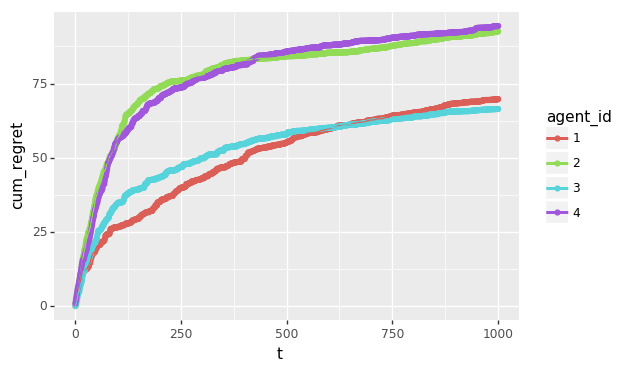

<ggplot: (8751105336277)>


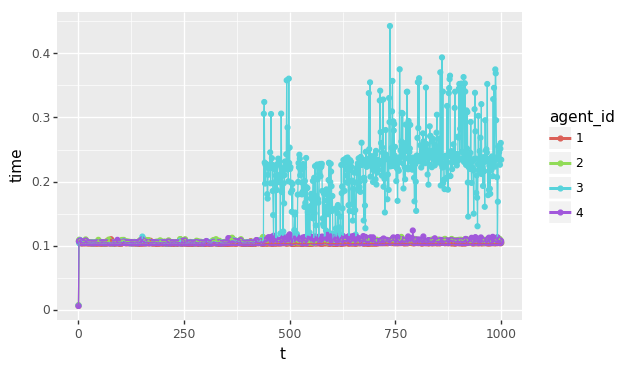

<ggplot: (8750920762221)>


In [14]:
plot_results(results)

In [2]:
test_random_weights()

[0.5]
[0.5, 1]
[1.5]
[0.5, 1, 2]
[1.5, 2]
[3.5]
[0.5, 1, 2, 1]
[1.5, 3]
[4.5]
[0.5, 1.5, 2, 1]
[2.0, 3]
[5.0]
[0.5, 1.5, 2, 1, 1.2]
[2.0, 3, 1.2]
[5.0, 1.2]
[6.2]
[0.5, 1.5, 2, 3, 1.2]
[2.0, 5, 1.2]
[7.0, 1.2]
[8.2]
[2, 3, 3, 3, 1, 3, 3, 4, 1, 2, 1, 3, 4, 3, 2, 2, 4, 1, 2, 4, 3, 4, 1, 1, 3, 1, 0, 3, 1, 2, 3, 4, 3, 4, 2, 0, 2, 2, 2, 1, 3, 3, 3, 1, 1, 0, 1, 3, 2, 3, 3, 3, 3, 1, 3, 2, 2, 3, 4, 1, 3, 1, 0, 4, 3, 1, 3, 2, 4, 3, 4, 1, 3, 3, 3, 3, 1, 3, 2, 3, 3, 2, 1, 3, 1, 3, 4, 1, 4, 1, 4, 3, 3, 2, 4, 4, 1, 2, 3, 4]
[[1, 3, 4], [1, 0, 2], [1, 3, 0], [3, 1, 4], [4, 2, 3], [3, 4, 1], [0, 1, 3], [1, 3, 2], [3, 4, 0], [3, 4, 2], [4, 3, 0], [3, 2, 1], [4, 2, 0], [2, 3, 1], [4, 3, 1], [3, 2, 1], [3, 0, 1], [2, 4, 1], [3, 1, 2], [3, 2, 4], [2, 3, 4], [1, 2, 0], [4, 2, 3], [3, 2, 1], [3, 4, 2], [3, 1, 4], [1, 0, 3], [3, 1, 2], [3, 2, 1], [3, 4, 2], [3, 1, 2], [3, 1, 4], [1, 0, 4], [2, 4, 1], [4, 0, 1], [3, 2, 1], [1, 0, 3], [2, 1, 4], [1, 2, 4], [3, 2, 4], [4, 1, 0], [4, 1, 3], [3, 4, 2], [1, 0, 3]

In [4]:
time_limit=0.01
make_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=1, weights=True)
make_prec_sagald_agent_nowt = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=1, weights=False)
make_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(sparsity/dim)),
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=1)
make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=True, context_has_constant=True, 
                                      n_steps=9999, time = time_limit, verbosity=1)

In [5]:
results, cum_regrets = simple_compare([make_pgts_agent(), make_sagald_agent(), make_prec_sagald_agent_nowt(), make_prec_sagald_agent()], num_articles, dim, sparsity, 1000, seed=seed, verbosity=1)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918]
Experiment: Step 0
 Sample: array([-1.74437237e+00,  7.15536785e-01,  1.63090625e+00,  1.64859408e+00,
        4.32790200e-01, -1.91029171e-01, -7.86121270e-01, -5.72601817e-01,
       -1.64975030e+00,  2.13455156e+00, -2.69643893e-02,  2.38440514e+00,
       -7.44974154e-02, -1.61831793e+00,  1.86156510e+00, -8.59827024e-01,
       -4.37908211e-01,  1.64855109e+00,  1.45877321e+00, -2.02620642e+00,
        1.05476994e-03])
 Steps taken: 0
 Sample: array([-1.08953501,  0.53913822,  1.81217709, -0.51748982,  1.4932228 ,
       -0.92864428,  2.17227052, -0.82565389, -0.46333797,  0.29695737,
       -1.40059445,  1.54960885, -1.0700169 ,  0.61395156, -1.28913004,
        0.10978295, -0.01052618, -0.38824091,  0.48921919, -1.1168322

Experiment: Step 10
 Sample: array([-0.26638868, -0.39383533, -1.68994945, -0.49515509, -0.57750547,
       -0.44592545,  0.63183301,  0.56334296,  1.42561086, -1.32687098,
        1.49732958, -0.77601985,  1.01484729, -0.56338529, -0.58963633,
       -0.72775662, -0.09880408,  1.27634652,  1.45031153, -0.45957419,
        0.59601567])
 Steps taken: 84
 Sample: array([ 0.15233168, -0.46351557,  1.14800319, -0.19873778,  0.5430684 ,
       -0.99277338,  1.47982649, -0.75364414, -0.70534855, -0.18062404,
       -1.06567217,  1.27159766, -1.45239291,  0.43361832, -0.7623393 ,
       -1.79730332,  0.49054076,  0.02947817,  1.37842972, -0.80593554,
        0.29593321])
 Steps taken: 16
 Sample: array([-0.93549729, -0.52362718,  0.61423714,  0.70175249,  1.12329488,
        0.32356853, -1.62181156, -1.48307494, -0.38216183,  0.24292872,
       -0.81701447,  0.87230823, -1.18534607,  0.1759316 ,  0.63212868,
        1.27155249, -1.45978164,  0.58272492,  0.97586856, -0.51040539,
        0.142

 Sample: array([-0.27472837,  0.06211824,  0.46775701, -0.68183909,  0.31707974,
       -1.96678217,  0.40542154,  0.02883643,  1.40483522, -1.0535539 ,
        0.40864496,  0.704138  ,  0.55616501,  0.14508127,  0.76908242,
       -0.08824014, -0.31857856, -1.19288282,  1.37760813, -0.54630536,
        0.26347844])
 Steps taken: 76
 Sample: array([-0.31844231, -0.71772169,  1.31979195, -0.33313266,  0.06171798,
       -1.09300727,  1.84465858, -0.0090858 , -0.56234726, -0.38992459,
       -0.33266627,  1.0811751 , -0.57991987,  0.13660602, -0.31932973,
       -1.70178715, -0.02608415, -0.28583586,  0.95784399, -0.24443783,
        0.78116242])
 Steps taken: 18
 Sample: array([-7.59277373e-01,  8.23256712e-04,  7.21315179e-02,  1.76827878e-01,
        7.24577967e-01,  3.33160539e-01, -6.49875396e-01, -8.72715116e-01,
       -2.73563264e-01,  1.80963788e-01, -3.77969084e-01,  5.63169506e-01,
       -6.69011594e-01, -3.40726694e-02,  2.79335900e-01,  1.09048330e+00,
       -7.12212924e-0

 Sample: array([-0.8670321 ,  0.35153289, -0.19568119, -0.70480396,  0.61473348,
        0.67894808, -0.46527326, -0.51754113, -0.18197241, -0.10594876,
       -0.1199727 , -0.00441953, -0.1731101 ,  0.02792543,  0.76093704,
        0.47356104, -0.34518533,  0.4874961 , -0.10537663, -0.06374305,
       -0.31479425])
 Steps taken: 15
Experiment: Step 31
 Sample: array([-0.74823145, -0.43161806, -1.36436267,  0.71195769,  1.78135708,
       -2.01338453,  0.21191801,  1.00426813,  1.51674821, -0.99364593,
        0.01703391,  0.58304681,  0.14081804, -1.74942163,  0.13819667,
        2.3642456 ,  0.17857363, -0.63437133,  1.17069059,  1.24860088,
       -2.00512692])
 Steps taken: 81
 Sample: array([-0.41554085, -0.83392358,  0.4064119 , -0.35283358,  0.81037342,
       -1.79968539,  0.93161888,  0.33431586, -0.41738931, -0.59746698,
       -0.14926445,  0.76240421, -0.17749576, -0.02347432,  0.23111853,
       -1.30617126,  0.03731218,  0.0056534 ,  1.03726991, -0.12632683,
        0.460

 Sample: array([-1.20745568,  0.89607823,  0.20367623, -1.81435092,  3.66600115,
       -2.29713505, -1.12620669,  1.09599307,  0.26667546,  0.14706977,
        1.20072189,  0.76423322,  0.55926074, -0.09977796,  0.67305834,
        0.01120353, -0.87572045, -1.11822622, -0.0587244 , -0.2903578 ,
       -0.15534837])
 Steps taken: 80
 Sample: array([-0.30551767, -0.72709701, -0.01206479,  0.0215298 ,  0.64779821,
       -1.6664728 ,  1.05804498,  0.48399078, -0.64017115, -0.24950758,
        0.0715456 ,  0.30966741, -0.14931391, -0.50989243,  0.38040409,
       -1.1448793 ,  0.1195522 ,  0.02470757,  0.741123  , -0.2193596 ,
        0.34463282])
 Steps taken: 17
 Sample: array([-0.53609034,  0.30330276, -0.31514375, -0.99936693,  0.3518284 ,
        0.60176764, -0.66687141, -0.4696678 ,  0.24439756, -0.26956503,
        0.50002379, -0.38502239, -0.43498743, -0.47124772,  0.17992591,
        0.76691748,  0.04563422,  0.37756827,  0.04465093, -0.04548087,
       -0.38202364])
 Steps taken

 Sample: array([-0.35623905, -0.04634644, -0.38495666, -0.71170915,  0.67911055,
        0.34850141, -0.55573089, -0.47872888,  0.26598227, -0.39884183,
        0.83723425, -0.4550682 , -0.39791452, -0.61113298,  0.41517081,
        0.55696003,  0.25881272,  0.21076019,  0.17897882, -0.20096351,
       -0.48652467])
 Steps taken: 15
Experiment: Step 52
 Sample: array([ 0.38620057, -1.50229304, -0.13180632, -0.64567552,  0.05263542,
       -1.28768276,  0.35535333,  0.93166332,  0.68406473, -1.58702376,
        1.63754743,  0.05418909,  0.07383077,  1.0464722 ,  0.70993328,
       -0.39206115, -0.43892809, -1.63408333,  0.20994491, -0.95088323,
       -0.94959076])
 Steps taken: 51
 Sample: array([-0.3517835 , -0.61889744, -0.36774259, -0.08007194,  0.61352125,
       -1.62149605,  0.96229854,  0.1006623 , -0.1031287 , -0.31046639,
        0.36536331,  0.01744327, -0.37449865, -0.45734217,  0.75378217,
       -1.13968381,  0.19825789, -0.33633049,  0.84152744, -0.05102287,
        0.707

 Sample: array([ 0.2488151 , -1.07871044,  0.47433298, -1.80279343,  0.25554918,
        0.18394455,  0.44084431, -0.16974491,  0.64876107, -0.26383027,
        1.26718038, -0.56465614,  0.33557135,  0.55676901,  2.30804725,
       -1.1855124 , -0.03276431, -2.64080008,  0.8150253 , -0.99880919,
       -0.34775587])
 Steps taken: 61
 Sample: array([-0.60252862, -0.47891038, -0.42559335, -0.09335721,  0.76093917,
       -1.54629817,  1.03677541,  0.35466971, -0.15899126, -0.23096783,
        0.50719881, -0.08699716, -0.04623596, -0.42359411,  0.64800018,
       -0.8420734 ,  0.11872281, -0.24960622,  0.6043476 ,  0.09854888,
        0.30254896])
 Steps taken: 17
 Sample: array([-0.02973255, -0.13995916, -0.27133692, -0.76175139,  0.31117148,
        0.06376151, -0.88706432, -0.23425121,  0.21100656, -0.43942953,
        0.86692353, -0.66030119, -0.02776466, -0.71948243,  0.25996235,
        0.58599843,  0.2611374 ,  0.47045855,  0.01966399, -0.34132229,
       -0.49288934])
 Steps taken

 Sample: array([-0.32835848, -0.16918604,  0.02631008, -0.60550558,  0.08725597,
        0.12995063, -1.13223631, -0.07423503,  0.31806924, -0.35699516,
        0.95018162, -0.53899871, -0.13359207, -0.68911236,  0.36187791,
        0.57660949,  0.35268142,  0.40166287,  0.00853751, -0.07485199,
       -0.42712998])
 Steps taken: 14
Experiment: Step 73
 Sample: array([ 0.14471096, -1.08881702,  0.47045277, -0.95132837,  1.08151245,
       -1.01484394,  0.29280116, -0.58317968,  1.0154955 , -0.99901214,
        0.159956  , -1.01512765, -0.14485694,  0.49429624,  0.89651611,
        1.29556175, -0.61803209, -0.67056432,  0.65971204, -0.49494103,
        0.2867313 ])
 Steps taken: 50
 Sample: array([-0.7098963 , -0.29469067, -0.31051172,  0.20364004,  0.59290669,
       -1.37010693,  0.80508927,  0.34936508,  0.22087327, -0.00231353,
        0.2688942 , -0.47623168,  0.26898655, -0.25684902,  0.68572905,
       -1.25367628,  0.07369631, -0.52678288,  0.65258931, -0.03742969,
        0.220

 Sample: array([ 0.04252197, -1.64718141, -0.12322245, -0.88881604,  1.23016305,
       -0.36472042,  0.39177694, -0.04231466,  0.86072242,  0.11043106,
       -0.13599749, -2.27690527,  1.05030298, -0.13480884,  1.05182216,
        0.1006253 , -0.44688905, -2.01676581,  0.94546381, -0.48602274,
        0.46733021])
 Steps taken: 48
 Sample: array([-0.90308293, -0.30697545, -0.06144988,  0.12006046,  0.73381197,
       -1.43156594,  0.83544156,  0.11433834,  0.21441267, -0.07415668,
        0.49676346, -0.34800391,  0.20550725, -0.22546807,  0.8819154 ,
       -1.07581297, -0.13051374, -0.43261354,  0.80934743, -0.01537636,
        0.42043644])
 Steps taken: 16
 Sample: array([-0.45748967, -0.29937132,  0.0608739 , -0.47678182,  0.11310486,
        0.03151719, -0.85387666, -0.24308721,  0.38085129, -0.31360359,
        1.04655413, -0.65643582, -0.16036343, -0.34447395,  0.25372529,
        0.45587741,  0.5028102 ,  0.29831239,  0.11147847,  0.00706305,
       -0.40698845])
 Steps taken

 Sample: array([-0.57774606, -0.08620669,  0.10365835, -0.29003453,  0.08785994,
       -0.18491811, -0.63809738, -0.18145764,  0.37556655, -0.2009393 ,
        0.97091805, -0.72481524, -0.42756488, -0.53183778,  0.33724897,
        0.45487731,  0.36005846,  0.38439323,  0.03381065,  0.08461348,
       -0.21717976])
 Steps taken: 15
Experiment: Step 94
 Sample: array([ 0.65226413, -1.03223523, -0.68984522, -1.47885751,  0.91288218,
       -0.96385981,  0.63550878, -0.18158747,  0.99817109,  0.05200377,
        1.46401347, -0.56990255,  0.22782201,  0.64441969,  0.07678514,
       -0.21872088, -1.32671821, -0.99944229,  0.68855011,  0.03766671,
       -1.08162353])
 Steps taken: 50
 Sample: array([-0.87469603, -0.31604693,  0.00628916,  0.126166  ,  0.83908694,
       -1.34980227,  0.92434693, -0.14074984,  0.20189728,  0.08502989,
        0.63154997, -0.31717856, -0.09934204, -0.21617866,  0.96973735,
       -1.01043905, -0.23773685, -0.23329718,  0.73980117, -0.07070768,
        0.304

 Sample: array([-0.39784525, -1.41038151,  0.2483527 , -1.07552986,  0.99546074,
       -0.75903094,  0.47299001,  0.78600347,  1.69399155, -0.56942927,
        1.06495334, -1.76101798,  0.22876059,  0.76288715,  1.55086089,
       -0.56580424, -0.67885062, -1.60178558,  0.86153204, -0.52883037,
       -0.47223581])
 Steps taken: 44
 Sample: array([-0.7969331 , -0.40253625,  0.06360124,  0.40853894,  0.81733737,
       -1.39120237,  0.72824538, -0.21991866,  0.34568665,  0.09139035,
        0.59135686, -0.26281618, -0.17180221, -0.22561956,  0.84199992,
       -0.96764879, -0.35175894, -0.218831  ,  0.75368175, -0.17971968,
        0.18067313])
 Steps taken: 16
 Sample: array([-0.40591583, -0.06868149,  0.0455788 , -0.22070977, -0.08395973,
       -0.37385684, -0.50189986, -0.3851517 ,  0.26293282, -0.14607658,
        0.97428423, -0.61540958, -0.53545125, -0.36739591,  0.46290617,
        0.14129613,  0.13104179,  0.1738452 ,  0.31882345, -0.02348398,
       -0.27936231])
 Steps taken

 Sample: array([-0.17481366, -0.06689889, -0.05407204, -0.38281232,  0.0127823 ,
       -0.23643108, -0.48980503, -0.36834345,  0.15526501, -0.27173307,
        1.042607  , -0.86685634, -0.54474762, -0.61254153,  0.60361228,
        0.36021089,  0.12053785,  0.04645055,  0.09685799,  0.13870123,
       -0.44100221])
 Steps taken: 14
Experiment: Step 115
 Sample: array([-0.84822161, -2.12508829,  1.14453254, -0.81935144,  1.32669262,
       -1.21859405,  0.41776024,  0.39022877,  1.43036057,  0.30031705,
        0.98080534, -0.99038888,  0.27684134,  1.29394629,  0.89324666,
       -0.72857155, -0.11141917, -2.16948467,  0.98992292, -0.32944051,
       -0.69349485])
 Steps taken: 50
 Sample: array([-0.81673838, -0.18322126, -0.07481357,  0.46566501,  0.76484423,
       -1.31690504,  0.62854042, -0.08180962,  0.31107934,  0.20406037,
        0.62117353, -0.07900786, -0.19041575, -0.18793909,  0.893262  ,
       -1.12570291, -0.23961002, -0.20325208,  0.69070933, -0.15276465,
       -0.06

 Sample: array([-0.45768606, -1.36267198,  0.12945137, -0.86742633,  1.08955094,
       -1.43257496,  0.44197495, -0.22806334,  1.38584226, -0.49951517,
        0.58410662, -1.30240671,  0.46238038,  0.9171007 ,  1.17756669,
       -0.66616882, -0.18112312, -1.57413616,  0.58987036,  0.09036537,
        0.23894511])
 Steps taken: 43
 Sample: array([-0.78232633, -0.54413571, -0.03132649,  0.5464214 ,  1.11796076,
       -1.49636878,  0.67719277, -0.36628759,  0.32674497,  0.11195374,
        0.62358007,  0.00446068, -0.16583758, -0.18482793,  0.92211265,
       -1.17643231, -0.3582942 , -0.32210018,  1.02555298, -0.11895491,
       -0.00836093])
 Steps taken: 15
 Sample: array([-0.2938861 , -0.20022772,  0.26521252, -0.80850485,  0.17730896,
       -0.11062416, -0.30139102, -0.53174422,  0.25242664, -0.30526662,
        1.16835979, -0.99638372, -0.63606605, -0.55753251,  0.74970867,
        0.12291697,  0.19736426,  0.10320726,  0.2425391 , -0.02942138,
       -0.33584765])
 Steps taken

 Sample: array([-0.39966107, -0.21204219,  0.12557716, -0.94537251,  0.31667198,
       -0.19381382, -0.16958433, -0.62414888,  0.34454337, -0.37576527,
        1.37381323, -1.15273628, -0.63290802, -0.61110669,  0.73739366,
        0.22767206,  0.11149489,  0.09843863,  0.16309638,  0.10563514,
       -0.18415815])
 Steps taken: 14
Experiment: Step 136
 Sample: array([-0.03121351, -0.3084755 ,  0.25466901, -0.77245533,  0.4994375 ,
       -1.3911647 ,  1.33901607, -0.87513633,  0.49382232, -0.13652275,
        0.84207894, -1.37296435,  0.40835077,  0.33166979,  1.1438809 ,
        0.29093933, -1.5128277 , -0.76719778,  1.83404635, -0.74101443,
       -0.721355  ])
 Steps taken: 47
 Sample: array([-0.71795415, -0.45249147,  0.10821597,  0.4340992 ,  1.08687878,
       -1.56368681,  0.97600147, -0.57836932,  0.30042434,  0.28258311,
        0.6690117 , -0.12450376, -0.18598057, -0.22412122,  0.57383981,
       -1.17530236, -0.32058331, -0.398644  ,  1.0289206 ,  0.02323236,
       -0.10

 Sample: array([-0.20809548, -0.4788932 ,  0.06565175, -0.85586845,  0.98431207,
       -2.49435921,  1.70749812, -0.36684933,  1.40041127,  0.13929017,
        0.14244304, -1.5344741 ,  0.39898452,  0.56587643,  1.46843549,
        0.12609769, -0.95502087, -1.44899141,  0.75640981,  0.35076438,
        0.18935265])
 Steps taken: 43
 Sample: array([-0.64272556, -0.42049999,  0.14228269,  0.35913313,  1.09440204,
       -1.48849984,  0.63735175, -0.44047879,  0.31432456,  0.18953918,
        0.56090296, -0.12533094, -0.35101866, -0.30903523,  0.6447306 ,
       -1.03961956, -0.15274437, -0.42613339,  0.9330152 ,  0.11135114,
       -0.04086   ])
 Steps taken: 16
 Sample: array([-0.43030008, -0.17602813, -0.02455052, -1.17460268,  0.41022843,
       -0.20503152, -0.19926689, -0.80972262,  0.40765844, -0.34543585,
        1.54544835, -1.16889911, -0.60708342, -0.33495449,  0.74657051,
        0.2800124 ,  0.02025314,  0.08147337,  0.05551583,  0.13775744,
       -0.21619602])
 Steps taken

 Sample: array([-0.54763719,  0.1621974 ,  0.1774088 , -0.98867198,  0.51686533,
       -0.34124318, -0.12346759, -0.78882332,  0.32705019, -0.30491665,
        1.62385464, -1.04205475, -0.72444813, -0.20147933,  0.6457063 ,
        0.32317357, -0.05341482,  0.05794669, -0.18433252,  0.09983742,
       -0.30875692])
 Steps taken: 14
Experiment: Step 157
 Sample: array([-0.11404927, -1.24798222, -0.1076978 ,  0.02293843,  1.09998868,
       -1.13437568,  0.53199183, -0.11302046,  1.76570238, -0.33040259,
        0.69705549, -1.22853405, -0.45347809, -0.03690361,  0.70845882,
       -0.32679123, -0.98608966, -1.6374931 ,  1.15648663,  0.18997114,
       -0.14595254])
 Steps taken: 49
 Sample: array([-0.7774893 , -0.5362923 ,  0.17119866,  0.28399362,  1.22377351,
       -1.15886102,  0.86323247, -0.56504308,  0.294512  ,  0.32730946,
        0.56118637, -0.18995615, -0.27860479, -0.21451874,  0.58444579,
       -1.05482371,  0.05702612, -0.42114   ,  0.86663345,  0.39721243,
       -0.11

 Sample: array([-0.31044097, -0.90624421,  0.22595004, -0.84083173,  0.7917483 ,
       -1.65556836,  1.25055505, -0.20296968,  1.07123928,  1.02387924,
        0.83305938, -1.08111757, -0.06745795,  0.52156883,  0.78741077,
       -0.20408863, -0.84547494, -1.81699136,  0.83457397,  0.0585947 ,
        0.12128543])
 Steps taken: 43
 Sample: array([-0.72998917, -0.64401324,  0.21461997,  0.18167263,  1.18173876,
       -1.24635322,  0.75049164, -0.48659294,  0.4397188 ,  0.35042039,
        0.71058259, -0.0542105 , -0.36561328, -0.32892786,  0.61259914,
       -0.91852259,  0.19796815, -0.4537524 ,  0.7487001 ,  0.46632515,
       -0.29499917])
 Steps taken: 16
 Sample: array([-0.61615643,  0.1676366 ,  0.17315915, -0.70400824,  0.67056688,
       -0.11463356, -0.3212484 , -0.78874279,  0.45230148, -0.24408861,
        1.42172495, -1.05792494, -0.58927476, -0.26499571,  0.57120974,
        0.37852751, -0.11458777, -0.04020461, -0.28663695,  0.25996631,
       -0.30568275])
 Steps taken

 Sample: array([-0.63521653,  0.03719278,  0.50991138, -0.7580979 ,  0.72014183,
       -0.10653905, -0.46577145, -0.66069042,  0.38606786, -0.28581382,
        1.49525536, -1.08407916, -0.50107286, -0.05892031,  0.55296259,
        0.28878334,  0.01371196, -0.11446651, -0.2929562 ,  0.14307685,
       -0.27821485])
 Steps taken: 14
Experiment: Step 178
 Sample: array([-0.36834299, -0.70177712, -0.05439741, -0.90937395,  1.02699964,
       -1.26091223,  1.19164735, -0.41317663,  1.26407688,  0.64246425,
        1.11561674, -1.90370277,  0.84009881,  0.80827411,  0.73025191,
       -0.51983891,  0.30271875, -1.28303679,  0.99516913, -0.49368629,
       -1.20894215])
 Steps taken: 49
 Sample: array([-0.65680139, -0.44060183,  0.02493353,  0.05522233,  0.98374268,
       -1.22695044,  0.73925763, -0.44311169,  0.37226392,  0.51354337,
        0.7492645 , -0.37554181, -0.27481824, -0.2575403 ,  0.74512472,
       -0.66374491,  0.10832173, -0.58905102,  0.65881697,  0.32319129,
       -0.26

 Sample: array([-0.01663107, -0.62617557, -0.13290572, -0.5281719 ,  0.83983576,
       -1.2295882 ,  1.09397153, -0.17364428,  0.99429811,  0.00527868,
        0.87578756, -1.37619056, -0.16107933,  0.63050716,  0.99422276,
        0.1913164 , -0.41432685, -1.2184164 ,  1.32793266, -0.46566064,
       -0.59875824])
 Steps taken: 49
 Sample: array([-0.62774735, -0.25411139,  0.01019381,  0.082172  ,  1.03397488,
       -1.0683075 ,  0.6106031 , -0.44977259,  0.34673443,  0.60699089,
        0.72797614, -0.49061893, -0.42381176, -0.32381005,  0.82454304,
       -0.72491421,  0.14025397, -0.70434597,  0.75077182,  0.23826595,
       -0.3083581 ])
 Steps taken: 15
 Sample: array([-0.76317898, -0.00304508,  0.4206249 , -0.80519834,  0.85205593,
       -0.20027868, -0.27188113, -0.59730821,  0.28210482, -0.05001631,
        1.53963834, -0.89621954, -0.63706605, -0.19438172,  0.64982518,
        0.29985609,  0.12788419, -0.10832177, -0.10264489,  0.14671418,
       -0.40660122])
 Steps taken

 Sample: array([-0.48522804, -0.3847001 ,  0.33206031, -0.91210386,  0.58662125,
       -1.82299707,  1.32566804, -0.1657745 ,  1.95608564, -0.05894725,
        0.7833367 , -1.7318422 ,  0.70571672,  0.77501078,  1.13786463,
       -0.43997296, -0.66670978, -1.51150489,  1.25762583, -0.92756813,
       -0.84157102])
 Steps taken: 50
 Sample: array([-0.57155821, -0.13614491, -0.15195694,  0.08461368,  1.0858028 ,
       -1.1998318 ,  0.83431146, -0.51600997,  0.33959973,  0.61539442,
        0.61500594, -0.37270559, -0.38465424, -0.36007343,  0.82635725,
       -0.95745299,  0.03340206, -0.68576667,  0.6180818 ,  0.25024673,
       -0.33156283])
 Steps taken: 16
 Sample: array([-0.78679614, -0.12523936,  0.61153962, -0.6861064 ,  0.73969984,
       -0.32914785, -0.35671946, -0.62238444,  0.25581819, -0.18467925,
        1.57647061, -0.87681066, -0.62673752, -0.01710358,  0.75163821,
        0.3391457 ,  0.13517252, -0.2805125 ,  0.09110887,  0.0183397 ,
       -0.38485693])
 Steps taken

 Sample: array([-0.62328105, -0.13589118,  0.51605013, -0.69044432,  0.81720777,
       -0.46592752, -0.37426296, -0.61999939,  0.24677729, -0.18292177,
        1.44044543, -0.89809207, -0.80195897, -0.12853305,  0.74789194,
        0.30481245, -0.0278413 , -0.14147253,  0.08449782,  0.06696912,
       -0.31165951])
 Steps taken: 14
Experiment: Step 209
 Sample: array([-0.14684787, -1.29155439, -0.02679903, -0.79201933,  1.05437096,
       -2.3156455 ,  0.42599401,  0.55001036,  0.94174566, -0.01828275,
        1.18537875, -1.07403802, -0.3440784 ,  1.12793583,  1.160773  ,
        0.43338675,  0.10307729, -2.28757795,  0.63669016,  0.1685645 ,
       -0.62314983])
 Steps taken: 50
 Sample: array([-0.68026359, -0.03989308, -0.26116031, -0.01218085,  1.21859848,
       -1.24037562,  0.66838726, -0.41619402,  0.44109532,  0.67643607,
        0.63837731, -0.2496081 , -0.40809044, -0.32335785,  0.9375707 ,
       -0.93382495,  0.04833821, -0.69372676,  0.62676005,  0.3663772 ,
       -0.18

 Sample: array([ 0.11179886, -1.07597988,  0.13669399, -1.05950788,  1.02810818,
       -1.93749554,  1.06204584, -0.18948903,  0.97495667,  0.18389155,
        1.29752593, -0.91098646, -0.75673984,  0.85161722,  1.00266109,
       -0.2329075 ,  0.07122674, -1.72317409,  0.86242753,  0.13124283,
       -0.33229465])
 Steps taken: 45
 Sample: array([-0.72382132, -0.11248528, -0.14231844,  0.0110271 ,  1.16193061,
       -1.38932901,  0.79367514, -0.45334221,  0.60022839,  0.60556594,
        0.57980103, -0.42504009, -0.34512039, -0.36472985,  1.12379535,
       -0.87790393, -0.22907552, -0.73158589,  0.85831193,  0.48665717,
       -0.18643262])
 Steps taken: 15
 Sample: array([-0.67882885, -0.25021935,  0.59763493, -0.77365067,  0.66555911,
       -0.53752838, -0.35837462, -0.41243083,  0.27552908, -0.22626278,
        1.30918826, -0.71071846, -0.75181434, -0.10785277,  0.89081016,
        0.40384789, -0.03395341, -0.1906538 ,  0.14845212,  0.39105897,
       -0.39698672])
 Steps taken

 Sample: array([-0.58800033, -0.0999101 ,  0.41511997, -0.74706662,  0.73692442,
       -0.69964159, -0.50796652, -0.27108112,  0.31802264, -0.44889849,
        1.47375318, -0.77179803, -0.77807026, -0.15365848,  0.84326025,
        0.33010913,  0.0772886 , -0.26395661,  0.30763874,  0.33228944,
       -0.31332481])
 Steps taken: 14
Experiment: Step 230
 Sample: array([ 0.02349888, -1.06140492, -0.57116398, -0.17642462,  0.65567764,
       -1.58247828,  0.7628895 , -0.13257637,  1.18043494,  0.00659293,
        0.99443283, -0.47970369, -0.09740478,  0.52281571,  1.04521508,
       -0.29031002, -0.3182042 , -1.83778132,  0.68071687,  1.15399718,
       -0.91443096])
 Steps taken: 48
 Sample: array([-0.74473804,  0.08372446, -0.13520626,  0.12511225,  1.1537399 ,
       -1.40357338,  0.71735667, -0.59506808,  0.50428554,  0.61860855,
        0.50862542, -0.58327702, -0.36521428, -0.38623664,  1.04126888,
       -0.7721091 , -0.17113579, -0.58514946,  0.94530656,  0.53412736,
       -0.22

 Sample: array([-0.20560445, -1.24902465,  0.37352532, -0.72452443,  0.71908241,
       -1.09302493,  0.86106484, -0.41073691,  1.16712298,  0.03687143,
        1.38383388, -0.65844763,  0.54986328, -0.01083846,  0.84467437,
       -0.23129524, -0.34504127, -0.85895637,  0.96920248,  0.4345059 ,
       -0.51903727])
 Steps taken: 44
 Sample: array([-0.71443523,  0.14679366, -0.0363261 ,  0.27036274,  1.2431455 ,
       -1.38748842,  0.90048456, -0.50933837,  0.62056696,  0.60313544,
        0.59394016, -0.66187465, -0.39406703, -0.60447035,  0.77865176,
       -0.83278971, -0.09179522, -0.75836503,  0.79508472,  0.36170651,
       -0.08705696])
 Steps taken: 16
 Sample: array([-0.32776889, -0.28416889,  0.48980399, -0.91043176,  0.73211171,
       -0.79419677, -0.5004325 , -0.36263513,  0.23364824, -0.51821191,
        1.51191648, -0.81637637, -0.90478959, -0.27828236,  0.66227808,
        0.19168794,  0.01058062, -0.21839897,  0.48960311,  0.35402332,
       -0.46244099])
 Steps taken

 Sample: array([-0.06754773, -1.60907528,  0.46957624, -0.40365877,  0.84856057,
       -1.92631746,  0.54804469, -0.30386005,  1.22760002, -0.18800131,
        1.37317135, -0.83853105,  0.18433886, -0.19682058,  0.75275445,
       -0.11920811, -0.52531243, -1.44498254,  1.68237859,  0.56426289,
       -0.86620635])
 Steps taken: 28
 Sample: array([-0.71875411,  0.21418205, -0.02301958,  0.22365514,  1.25512417,
       -1.59481871,  0.88553032, -0.4189142 ,  0.80711923,  0.62904533,
        0.4496625 , -0.53962875, -0.39675157, -0.47610651,  0.73915108,
       -0.8029626 , -0.05173314, -0.73705677,  0.71478995,  0.19543965,
       -0.15532126])
 Steps taken: 10
 Sample: array([-0.31542657, -0.25718115,  0.47429949, -0.86085121,  0.73841486,
       -0.91014162, -0.5697182 , -0.42405816,  0.31990125, -0.51384121,
        1.48047466, -0.79702965, -0.91875107, -0.19879557,  0.58571998,
        0.26105512,  0.07961591, -0.17378187,  0.57095323,  0.30594411,
       -0.55037206])
 Steps taken

 Sample: array([-0.3809915 , -0.33302327,  0.39129582, -0.95691285,  0.75009372,
       -0.85295693, -0.45529992, -0.46757742,  0.26463766, -0.62181134,
        1.50092787, -0.82634568, -0.80199249, -0.19786796,  0.70840222,
        0.42674901, -0.04796253, -0.14328772,  0.77880152,  0.21049398,
       -0.59470764])
 Steps taken: 12
Experiment: Step 261
 Sample: array([-0.16448204, -0.90533968, -0.073823  , -0.27059943,  0.50147417,
       -1.38201935,  0.89346332,  0.42618447,  0.93807121, -0.18377828,
        0.7487373 , -1.54026713,  1.00778318, -0.17302429,  1.62124635,
        0.14420283, -0.05548057, -1.28887041,  1.06929011,  1.12548212,
       -1.01492921])
 Steps taken: 49
 Sample: array([-0.75283131,  0.3176365 ,  0.02433628,  0.17852158,  1.16395304,
       -1.6514856 ,  0.94890015, -0.45706691,  0.67495301,  0.64390429,
        0.55991052, -0.49582647, -0.30095993, -0.6462874 ,  0.65747245,
       -0.82914933, -0.01798144, -0.57617827,  0.76268166,  0.23022902,
       -0.04

 Sample: array([-0.1746368 , -0.85777669,  0.16408602, -0.51031236,  0.74394036,
       -0.64775433,  0.32912944,  0.13723   ,  0.56351063,  0.03116028,
        1.42728995, -1.50074647,  1.12242291,  0.54114449,  1.37693798,
       -0.44231466, -0.24736744, -1.68738898,  1.47710931,  0.24769814,
       -0.72106227])
 Steps taken: 44
 Sample: array([-0.63729575,  0.17850459,  0.1037822 ,  0.1613746 ,  1.20448241,
       -1.71257179,  0.8843498 , -0.46103388,  0.64156856,  0.61905389,
        0.48998696, -0.4438978 , -0.45788031, -0.62766585,  0.6534162 ,
       -0.83163535, -0.088139  , -0.54838984,  0.82103901,  0.15502477,
       -0.12788527])
 Steps taken: 16
 Sample: array([-0.45648901, -0.28599449,  0.30177519, -0.9541886 ,  0.75719836,
       -0.70983815, -0.52064153, -0.43396873,  0.22121522, -0.6267849 ,
        1.43269263, -0.91804181, -0.61842162, -0.37632697,  0.7795028 ,
        0.51835106,  0.00461518, -0.03647244,  0.62558649,  0.20719043,
       -0.58604009])
 Steps taken

 Sample: array([-0.47678097, -0.18931962,  0.3127201 , -0.82487642,  0.70330432,
       -0.70911484, -0.4786001 , -0.48437286,  0.24929702, -0.60939403,
        1.29658869, -0.79220906, -0.52638803, -0.34325753,  0.8543048 ,
        0.42888286,  0.03994525, -0.18432184,  0.47229613,  0.18370518,
       -0.56162556])
 Steps taken: 14
Experiment: Step 282
 Sample: array([-0.40768894, -0.37878149, -0.27422415, -0.81131238,  0.90252381,
       -1.36628669,  1.18162232, -0.15717805,  0.42285511, -0.01946455,
        1.31673829, -0.74189088,  0.61096068, -0.09548174,  1.44683237,
       -0.07539111, -0.16565044, -1.46102265,  1.31536455,  0.17503064,
       -0.9338197 ])
 Steps taken: 47
 Sample: array([-0.37952564,  0.11733978, -0.01697641, -0.11107541,  1.07234841,
       -1.57447281,  0.84998083, -0.46608702,  0.72453794,  0.57784982,
        0.46675739, -0.56344517, -0.44012324, -0.62404358,  0.78572982,
       -0.95414977, -0.06201729, -0.55295853,  0.80385347,  0.02534712,
       -0.16

 Sample: array([ 0.20223698, -0.21279329,  0.2452062 , -0.68795784,  1.02610262,
       -1.31341705,  0.56259933, -0.47177621,  1.01783937,  0.33801153,
        0.85023628, -1.05344794,  0.14592976, -0.34591209,  1.48825221,
       -0.62723793, -0.21871506, -1.70832801,  0.83093264,  0.18882505,
       -0.71459309])
 Steps taken: 40
 Sample: array([-0.40233541,  0.01024026,  0.04350788, -0.02824964,  0.98410711,
       -1.70219927,  0.97013204, -0.55213465,  0.72425806,  0.63421243,
        0.46266586, -0.62455782, -0.38686998, -0.54524314,  0.80386579,
       -0.90521509, -0.02127964, -0.5379621 ,  0.66689497,  0.11462826,
       -0.16379287])
 Steps taken: 16
 Sample: array([-3.84188612e-01, -1.06057379e-01,  4.27790154e-01, -8.49979858e-01,
        5.75411517e-01, -8.11331447e-01, -4.50028603e-01, -5.73745111e-01,
        3.57605771e-01, -8.26990718e-01,  1.35576430e+00, -8.20199253e-01,
       -6.57678220e-01, -3.75157257e-01,  8.26053788e-01,  4.56776859e-01,
        1.04075379e-0

 Sample: array([-0.34487391, -0.13254553,  0.38343954, -0.94298513,  0.65733087,
       -0.75132215, -0.49454836, -0.59322034,  0.30884104, -0.7082505 ,
        1.49468741, -0.89995847, -0.61300556, -0.45005661,  0.78243351,
        0.41070763, -0.00244682, -0.27707595,  0.4475497 ,  0.37386586,
       -0.66768684])
 Steps taken: 14
Experiment: Step 303
 Sample: array([-0.06034756, -0.37953373,  0.52982628, -0.66701472,  0.64114037,
       -1.57561991,  0.89477555, -0.20491413,  1.04867662,  0.22051357,
        1.1757148 , -1.15610783,  0.36078046,  0.56782235,  1.36645737,
       -0.55105617, -0.73768508, -1.7348133 ,  0.66945747, -0.0228758 ,
       -0.5903779 ])
 Steps taken: 35
 Sample: array([-0.31219771, -0.05514546,  0.02867036, -0.0843124 ,  1.1917637 ,
       -1.71544295,  1.14444397, -0.7103928 ,  0.54508424,  0.56275569,
        0.53584954, -0.72971057, -0.53092583, -0.72598616,  0.81927319,
       -0.81344979,  0.08348047, -0.63247643,  0.71285323,  0.09243712,
       -0.18

 Sample: array([-0.34247341, -0.05213339,  0.42526926, -0.90392477,  0.60837296,
       -0.82596819, -0.57112739, -0.53117088,  0.39262286, -0.68115522,
        1.5540624 , -0.87986869, -0.66085601, -0.43014114,  0.7605867 ,
        0.25948533, -0.02440434, -0.18823664,  0.39975653,  0.44784501,
       -0.6676938 ])
 Steps taken: 14
Experiment: Step 313
 Sample: array([ 0.06651698, -1.08611796,  0.50892487, -1.11258476,  0.77982277,
       -1.47752364,  0.44427943, -0.15960446,  0.74281421,  0.32743449,
        1.10950012, -1.12107903,  0.63225087,  0.42825712,  1.05411213,
       -0.46427234, -0.40418284, -1.32421357,  0.73600958,  0.06457714,
       -0.13534478])
 Steps taken: 46
 Sample: array([-3.17762107e-01,  6.61276061e-05, -1.44541623e-02, -1.06805763e-01,
        1.16622082e+00, -1.79107323e+00,  1.17328039e+00, -6.39804956e-01,
        5.61056670e-01,  5.87196448e-01,  5.13583302e-01, -9.13462011e-01,
       -3.73637082e-01, -7.42521443e-01,  8.34815629e-01, -7.07587204e-01,


 Sample: array([ 0.24722557, -0.53471685,  0.44318842, -1.24835539,  0.70313447,
       -1.86965141,  1.20467923, -0.40892325,  1.04981872, -0.16293294,
        0.62090658, -1.57386572,  0.12201834,  0.90444115,  1.22060132,
       -0.66533544, -0.54060162, -0.9260397 ,  0.73539749,  0.39697588,
       -0.538373  ])
 Steps taken: 40
 Sample: array([-0.35219688,  0.11732375, -0.01350317, -0.07373745,  1.08995752,
       -1.82043978,  1.10306348, -0.66503673,  0.6124929 ,  0.64645926,
        0.50175264, -0.9091102 , -0.34478598, -0.89003878,  0.83442362,
       -0.72359162, -0.00613082, -0.66879811,  0.78693096,  0.02263862,
       -0.08798325])
 Steps taken: 16
 Sample: array([-0.33134586, -0.09925362,  0.3188227 , -0.87715319,  0.7486816 ,
       -0.83090553, -0.63241875, -0.50927382,  0.4186343 , -0.52107486,
        1.43333571, -1.14141796, -0.69104476, -0.41942783,  0.69495686,
        0.14288032,  0.00202519, -0.08646947,  0.4790965 ,  0.48579306,
       -0.6560208 ])
 Steps taken

 Sample: array([-0.10499375, -0.10448381,  0.20947254, -0.86754366,  0.69363488,
       -0.80130186, -0.77071499, -0.58195143,  0.27749399, -0.5711328 ,
        1.38991768, -1.08209851, -0.6230642 , -0.50803269,  0.61524771,
        0.18637571, -0.01550213, -0.2716078 ,  0.38887344,  0.42311825,
       -0.63781543])
 Steps taken: 14
Experiment: Step 334
 Sample: array([ 0.4547728 , -0.55366236,  0.12555344, -0.19619446,  1.44983834,
       -1.82002044,  0.97347513, -0.47946539,  0.97944163,  0.1191652 ,
        0.80558867, -1.770747  , -0.50255545,  0.55864596,  1.53723772,
       -1.11200427, -0.52553232, -1.2262273 ,  0.74407601,  0.19944087,
       -1.08805941])
 Steps taken: 46
 Sample: array([-0.34614184,  0.1407984 , -0.08521053, -0.11080442,  1.04073535,
       -1.84028402,  1.11956692, -0.65578395,  0.55795946,  0.65663854,
        0.43913037, -0.86752871, -0.27174422, -0.8306692 ,  0.95855394,
       -0.73828211,  0.10878555, -0.59304849,  0.73578197,  0.11390582,
       -0.12

 Sample: array([ 0.73835933, -0.5035162 , -0.26984423, -0.44562757,  1.03184273,
       -1.61966646,  0.517009  , -0.81023883,  0.93657876,  0.06039771,
        0.87789354, -1.11197829,  0.17966151,  0.63357175,  1.69428794,
       -0.89220383, -1.02205026, -1.4671293 ,  0.02713265,  0.24902576,
       -0.06547583])
 Steps taken: 40
 Sample: array([-0.35413416,  0.01047063, -0.16313406, -0.17100119,  0.96086954,
       -1.93028537,  1.09518901, -0.56532509,  0.51382462,  0.64449117,
        0.57863302, -0.93219776, -0.14841867, -0.84516424,  1.1123645 ,
       -0.71121646,  0.18365754, -0.39786543,  0.63204993,  0.1172298 ,
       -0.12749139])
 Steps taken: 15
 Sample: array([-0.00722893, -0.19338009,  0.29105517, -0.93748379,  0.71874714,
       -0.93019682, -0.74162432, -0.62745299,  0.09149798, -0.44993212,
        1.36607051, -1.07719695, -0.59003725, -0.53771692,  0.48526909,
        0.14982316, -0.06584877, -0.13611004,  0.32270992,  0.44485376,
       -0.67174642])
 Steps taken

 Sample: array([ 0.10252201, -0.1069564 ,  0.10133188, -0.95512561,  0.8155407 ,
       -1.0747687 , -0.71233664, -0.57699131,  0.18529034, -0.42611959,
        1.23603456, -1.04735007, -0.72999525, -0.56093242,  0.59248403,
        0.17767734, -0.17800098, -0.22040984,  0.23903429,  0.39022238,
       -0.66832283])
 Steps taken: 14
Experiment: Step 355
 Sample: array([ 0.81558806,  0.15362504, -0.32244055, -0.10635213,  0.84664338,
       -2.13693668,  0.91475517,  0.05513627,  0.90511672,  0.3461732 ,
        0.30924794, -1.36536443,  0.23379253,  0.44421347,  1.00743252,
       -0.70441043, -0.61627639, -1.52409626,  0.7607866 ,  0.30253603,
       -1.10799043])
 Steps taken: 46
 Sample: array([-0.37101148,  0.06576079, -0.22478206, -0.07234848,  1.03164309,
       -1.90635754,  1.0501134 , -0.52906343,  0.4401013 ,  0.56713995,
        0.5150109 , -0.93093834,  0.00580733, -0.67167069,  1.07624088,
       -0.8241657 ,  0.12271699, -0.54578643,  0.7366059 ,  0.13216803,
       -0.11

 Sample: array([ 1.0440868 , -1.18218934, -0.34177626, -0.71118424,  0.98926639,
       -2.2925227 ,  0.30148658,  0.42393984,  1.13283503,  0.01449997,
        0.3055293 , -1.08198615,  0.4956206 ,  0.31165893,  1.35130548,
       -0.28721148, -0.52051737, -1.42621606,  0.2834435 ,  0.39364323,
       -1.18444236])
 Steps taken: 42
 Sample: array([-0.31275315, -0.02519001, -0.22058719, -0.06124125,  1.06215886,
       -1.97115957,  1.03913781, -0.50236841,  0.37992763,  0.5630338 ,
        0.46058468, -0.91462995,  0.08506224, -0.5104912 ,  0.97044729,
       -0.86151109, -0.00761806, -0.65567763,  0.68572306,  0.23274575,
       -0.09102691])
 Steps taken: 16
 Sample: array([ 0.15099736, -0.09361445,  0.187124  , -1.04769191,  0.8564587 ,
       -1.16522418, -0.71624201, -0.54176433,  0.123272  , -0.45566151,
        1.29847143, -1.160187  , -0.73694697, -0.59242354,  0.65798362,
        0.29616702, -0.2524521 , -0.18439902,  0.2829177 ,  0.24186994,
       -0.63209758])
 Steps taken

 Sample: array([ 0.15985008, -0.0877521 ,  0.21359614, -1.03714114,  0.95663226,
       -1.22290427, -0.67764154, -0.4673408 ,  0.16160911, -0.5376738 ,
        1.31065322, -1.3034281 , -0.77199798, -0.67766098,  0.64559487,
        0.26982858, -0.21710106, -0.15503595,  0.35657875,  0.20723485,
       -0.63640182])
 Steps taken: 14
Experiment: Step 376
 Sample: array([ 1.61211235, -1.06798947, -0.29259657, -1.06756229,  0.63391589,
       -2.30010069,  0.50970425, -0.01585789,  0.93755009, -0.1830411 ,
        0.19161192, -1.1813947 ,  0.59463454,  0.22114733,  1.1673238 ,
       -0.1168426 , -0.54828683, -1.46334535,  0.42959882,  0.14148808,
       -1.2435531 ])
 Steps taken: 46
 Sample: array([-0.41743306,  0.06162308, -0.17989927, -0.05070556,  0.97259595,
       -1.92297485,  1.07743646, -0.40739991,  0.40384903,  0.47879297,
        0.49660395, -0.84820395,  0.13986842, -0.48741602,  0.97473627,
       -0.68017475,  0.15086433, -0.68334218,  0.61926666,  0.16597588,
       -0.16

 Sample: array([ 1.47069151, -0.63665849, -0.25525356, -1.31711848,  0.44903651,
       -2.05456147,  0.38080581, -0.11402538,  0.80501169, -0.12206795,
        0.75606331, -1.65150164,  0.45911015,  0.24837174,  0.95845232,
       -0.4299384 , -0.59659994, -0.79704257,  0.59254456,  0.81746639,
       -0.81116469])
 Steps taken: 40
 Sample: array([-0.41502115,  0.00612145, -0.24164922,  0.00268328,  0.88000827,
       -1.81832716,  1.11180811, -0.41920212,  0.48817499,  0.472049  ,
        0.50665502, -0.97284494,  0.19029139, -0.52149217,  0.99888036,
       -0.60675724,  0.26457561, -0.67670965,  0.68320071,  0.21777689,
       -0.17765095])
 Steps taken: 15
 Sample: array([ 0.31456278, -0.24857439,  0.15140627, -0.96296607,  0.9933054 ,
       -1.17944853, -0.74907052, -0.46192814,  0.00326059, -0.43966126,
        1.18357256, -1.16226513, -0.86892119, -0.56340234,  0.56506423,
        0.15843994, -0.21493405, -0.0379818 ,  0.16409895,  0.16896561,
       -0.6632114 ])
 Steps taken

 Sample: array([ 0.26926267, -0.23792938,  0.04007427, -0.96765049,  0.81930951,
       -1.21130741, -0.66296853, -0.40651428,  0.08029203, -0.41820181,
        1.18417471, -1.15808849, -0.88772775, -0.50466324,  0.62905638,
        0.14945044, -0.12502641,  0.06782022,  0.18380259,  0.11646505,
       -0.7150701 ])
 Steps taken: 13
Experiment: Step 397
 Sample: array([ 1.88437044, -0.8477863 , -0.47312129, -1.63163938,  0.60959289,
       -2.40982133,  0.63162977, -0.32312582,  1.02502887,  0.23947879,
        0.36759962, -1.55978431, -0.22752386,  0.20531165,  0.89974735,
       -1.18925195, -0.0307743 , -1.32678365,  0.5890586 ,  0.48082865,
       -1.03302714])
 Steps taken: 46
 Sample: array([-3.60763112e-01, -2.99752006e-02, -3.11220402e-01,  9.21813166e-04,
        9.07862761e-01, -1.82693598e+00,  1.13465227e+00, -3.84143035e-01,
        4.06147780e-01,  4.38345187e-01,  5.25336733e-01, -1.08416467e+00,
        1.52272982e-01, -3.91751877e-01,  9.82216936e-01, -4.68881280e-01,


 Sample: array([ 2.00505131, -0.72110507, -0.79440197, -1.91317095,  0.33264354,
       -2.27183926,  0.95802116, -0.05645188,  1.12476579,  0.37553158,
        0.40004699, -2.0204262 , -0.07528755,  0.37606391,  1.18826438,
       -0.63708373, -0.05509063, -1.15186229,  0.22917126,  0.37756188,
       -1.12652857])
 Steps taken: 39
 Sample: array([-0.41842166, -0.0821978 , -0.32344149,  0.05087743,  0.92407731,
       -1.70644025,  1.12666332, -0.39209618,  0.38817484,  0.53110375,
        0.54710754, -0.98041625,  0.20241771, -0.33646279,  0.96140506,
       -0.40725973,  0.19769227, -0.69397417,  0.75789051,  0.33850176,
       -0.17374767])
 Steps taken: 15
 Sample: array([ 0.339747  , -0.31393649,  0.10444136, -1.11739047,  0.7409946 ,
       -1.19950097, -0.75833732, -0.44650863,  0.09753206, -0.44610181,
        1.30139589, -1.21296762, -0.91883975, -0.50430923,  0.65012135,
        0.21574493, -0.23013573,  0.07113942,  0.05581254,  0.18125354,
       -0.68682211])
 Steps taken

 Sample: array([ 0.34874378, -0.31325887,  0.10791867, -0.95803052,  0.77615997,
       -1.27477524, -0.7613664 , -0.5073917 ,  0.02408991, -0.4806827 ,
        1.37643916, -1.22222156, -0.82951848, -0.5119976 ,  0.56911774,
        0.10970206, -0.02013234,  0.04098943,  0.13878696,  0.08059841,
       -0.67274287])
 Steps taken: 14
Experiment: Step 418
 Sample: array([ 1.69328036, -0.57902667, -0.38630882, -1.22324219,  0.8491055 ,
       -2.03615631,  1.09172822, -0.96898779,  1.10201733, -0.12262385,
        0.50024632, -1.72232208, -0.04394323,  0.07814867,  0.76907601,
       -0.61852342, -0.41441354, -1.10706859, -0.0133055 ,  0.45492891,
       -0.90230154])
 Steps taken: 45
 Sample: array([-0.43154372, -0.1442312 , -0.29346892,  0.01490409,  0.78738315,
       -1.64769759,  1.20656791, -0.32412936,  0.54234194,  0.557541  ,
        0.54041551, -0.99123029,  0.14297327, -0.34565942,  1.07288675,
       -0.41663045,  0.17620818, -0.74224573,  0.61824325,  0.35942997,
       -0.18

 Sample: array([ 2.01575828, -0.87150634, -0.20423088, -1.06736553,  0.50803194,
       -1.53129072,  0.78361638, -0.27585925,  0.97901911, -0.15542253,
        0.73548961, -1.63482808,  0.28789386, -0.01956074,  0.81346305,
       -0.9618192 ,  0.08686224, -0.95105734,  0.06764147,  0.07389715,
       -1.19309059])
 Steps taken: 40
 Sample: array([-0.450307  , -0.16973806, -0.14049984, -0.02551872,  0.82764134,
       -1.61230326,  1.24933166, -0.32253868,  0.50620874,  0.60301022,
        0.55700039, -1.02450808,  0.20427816, -0.37742436,  1.11558845,
       -0.42243195,  0.08652377, -0.72154974,  0.49047211,  0.27523673,
       -0.17219319])
 Steps taken: 15
 Sample: array([ 0.25855445, -0.35058763,  0.19093731, -0.97564875,  0.77690951,
       -1.31899111, -0.73629149, -0.47299547,  0.06809427, -0.41345505,
        1.43381721, -1.2737214 , -0.85429984, -0.51171068,  0.642741  ,
        0.12876475, -0.06910612,  0.01464662,  0.15287351,  0.14650851,
       -0.69187541])
 Steps taken

 Sample: array([ 1.88807775e-01, -2.93510788e-01,  1.87743656e-01, -9.31642647e-01,
        8.39426420e-01, -1.30847522e+00, -7.29964685e-01, -5.02910781e-01,
        6.43572671e-02, -3.62377866e-01,  1.43079262e+00, -1.32710103e+00,
       -8.02975381e-01, -5.14856594e-01,  7.50607465e-01,  1.13789267e-01,
       -2.44133658e-03, -1.11771335e-03,  8.90325782e-02,  4.93974451e-02,
       -6.16743192e-01])
 Steps taken: 13
Experiment: Step 439
 Sample: array([ 1.00393478, -0.46387239, -0.24805241, -1.10632484,  0.50293741,
       -1.78023327,  0.53820099,  0.17177839,  1.32078311,  0.20906472,
        0.58126186, -1.5751401 ,  0.23758623, -0.01164878,  1.01167654,
       -0.68290897,  0.64953904, -1.75133619,  0.33704433, -0.10907118,
       -0.33229731])
 Steps taken: 45
 Sample: array([-0.45608386, -0.21022262, -0.224681  , -0.09009067,  0.89379803,
       -1.65173206,  1.26860369, -0.36829451,  0.45942687,  0.59503978,
        0.6374842 , -0.97087215,  0.25035224, -0.40279802,  1.154

 Sample: array([ 0.90728874, -0.68524105, -0.0998797 , -0.97992176,  0.62165359,
       -1.3693195 ,  0.97593656, -0.54772357,  1.33246787,  0.20768103,
        0.43319903, -1.48763179,  0.33453476, -0.03406229,  0.77502183,
       -0.27234669, -0.15618023, -1.66831939,  0.61718144, -0.04633448,
       -0.26093515])
 Steps taken: 44
 Sample: array([-0.44184876, -0.24435143, -0.28663977, -0.09148046,  0.99298402,
       -1.60711224,  1.29189003, -0.4678054 ,  0.43806618,  0.49494252,
        0.72341673, -1.05792321,  0.31193987, -0.43233521,  1.00780172,
       -0.3381697 ,  0.12834237, -0.6733542 ,  0.4820109 ,  0.26304283,
       -0.05478975])
 Steps taken: 16
 Sample: array([ 0.31596127, -0.31505801,  0.25240817, -0.87148703,  0.68894437,
       -1.13919437, -0.77359837, -0.53843605,  0.11144522, -0.28588996,
        1.39992636, -1.31810377, -0.95845986, -0.61376931,  0.64955796,
        0.20693394,  0.01688694, -0.02144984,  0.0360436 ,  0.06145477,
       -0.79852934])
 Steps taken

 Sample: array([ 1.80269656e-01, -2.20182710e-01,  2.86942648e-01, -8.92323630e-01,
        5.71393563e-01, -1.16943473e+00, -7.04857405e-01, -4.87856887e-01,
        9.30911602e-02, -1.63723433e-01,  1.41367495e+00, -1.24438547e+00,
       -8.53434449e-01, -6.19471727e-01,  6.38258427e-01,  2.34033552e-01,
        4.43697655e-02, -9.09207212e-04,  1.80616127e-01,  1.66080436e-02,
       -8.68269123e-01])
 Steps taken: 14
Experiment: Step 460
 Sample: array([ 0.5876844 , -1.02063527, -0.31121377, -0.99766458,  0.74464033,
       -1.41300706,  0.88228421, -0.44244932,  0.92993938, -0.07497799,
        1.05441892, -1.24898503,  1.05262175, -0.52346917,  1.47605233,
       -0.95139735, -0.07761621, -1.42661235,  0.04358518,  0.72920084,
       -0.70545939])
 Steps taken: 45
 Sample: array([-0.42544752, -0.2536512 , -0.23689678, -0.09463911,  1.00988433,
       -1.66915868,  1.28923438, -0.54245925,  0.43100407,  0.46050031,
        0.76510571, -1.07257165,  0.26719322, -0.36267715,  1.035

 Sample: array([ 0.55626667, -1.30189577,  0.05950497, -0.86559042,  0.72745215,
       -1.80057697,  1.01982314, -0.14455521,  0.96992171,  0.17917977,
        0.94902728, -2.04504076,  0.4708854 , -0.33913166,  1.69364038,
       -0.64593206,  0.16534381, -1.47104441,  0.41925949,  0.56787309,
       -0.70265582])
 Steps taken: 9
 Sample: array([-0.45367503, -0.30839151, -0.21894285, -0.07166063,  1.00797288,
       -1.65979982,  1.26085861, -0.58954775,  0.41065364,  0.52618209,
        0.72694683, -1.09128849,  0.26387865, -0.3943918 ,  1.12840214,
       -0.51292298,  0.07609195, -0.5331114 ,  0.53832835,  0.35826703,
       -0.10484123])
 Steps taken: 5
 Sample: array([ 0.18289846, -0.25103153,  0.31402384, -0.89624238,  0.536346  ,
       -1.21917926, -0.75353748, -0.43716245,  0.22028708, -0.14666046,
        1.41206927, -1.18371396, -0.84615819, -0.61779457,  0.68279769,
        0.24174312,  0.00281757, -0.079142  ,  0.16121323,  0.07878455,
       -0.81541086])
 Steps taken: 

 Sample: array([ 0.4757898 , -0.96746709,  0.07314778, -0.95177089,  0.5514973 ,
       -1.97260203,  0.89172079, -0.0533655 ,  1.07272525,  0.20149203,
        0.78215721, -1.91167158,  0.31897528, -0.13547094,  1.76397476,
       -0.54052476,  0.25226796, -1.38102127,  0.68400171,  0.47094084,
       -0.81262645])
 Steps taken: 26
 Sample: array([-0.36063659, -0.33732632, -0.13747723, -0.10350925,  1.03730376,
       -1.72100738,  1.21489196, -0.66004811,  0.46211863,  0.53180873,
        0.7109597 , -1.0744743 ,  0.15781752, -0.40162471,  1.16756813,
       -0.47699695, -0.00303064, -0.57385764,  0.53441172,  0.329204  ,
       -0.07090554])
 Steps taken: 10
 Sample: array([ 0.15825943, -0.28096712,  0.30155948, -0.89559105,  0.52087854,
       -1.25915323, -0.78387287, -0.39709951,  0.29611998, -0.04957077,
        1.43428848, -1.20136326, -0.69068581, -0.64422333,  0.61367898,
        0.19316717, -0.07231527, -0.0860395 ,  0.19423524,  0.11488922,
       -0.78058238])
 Steps taken

 Sample: array([ 0.17926094, -0.23067849,  0.29179328, -0.91864622,  0.42924206,
       -1.25575382, -0.7842906 , -0.40690484,  0.34368554, -0.04424473,
        1.45416032, -1.21663194, -0.71804549, -0.66110216,  0.61799098,
        0.1569915 ,  0.00686543, -0.06303656,  0.20342175,  0.08987255,
       -0.73985545])
 Steps taken: 10
Experiment: Step 487
 Sample: array([ 0.58990892, -1.01423315, -0.22129264, -1.24233535,  0.43177654,
       -1.76395069,  0.73791239, -0.44642659,  0.8458858 ,  0.10290457,
        0.75876368, -1.77878023,  0.39265873, -0.18058569,  1.46649777,
       -0.32713998,  0.10618373, -1.66849339,  1.05435758,  0.66440432,
       -0.23830479])
 Steps taken: 27
 Sample: array([-0.32987167, -0.43738312, -0.10312912, -0.05499643,  1.08332235,
       -1.69220927,  1.13612923, -0.65028902,  0.41191276,  0.52571913,
        0.75734677, -1.0484701 ,  0.16573453, -0.33108814,  1.15991116,
       -0.46695552, -0.0482943 , -0.60321125,  0.52747379,  0.32291087,
       -0.10

 Sample: array([ 0.10946834, -0.27391693,  0.28650514, -0.9060702 ,  0.433851  ,
       -1.23674908, -0.80814745, -0.36634997,  0.3633909 , -0.01617763,
        1.47518884, -1.19601588, -0.69209483, -0.57549765,  0.60983803,
        0.21384408, -0.03396912, -0.09182645,  0.20148264,  0.19655631,
       -0.71165177])
 Steps taken: 11
Experiment: Step 495
 Sample: array([ 0.73437103, -0.69894924, -0.12459204, -1.08797486,  0.54320068,
       -1.45210199,  0.29987201, -0.52909124,  1.32675495,  0.18864344,
        0.71976134, -1.85379557,  0.27530367, -0.37399398,  1.35632081,
       -0.27733173,  0.44470194, -1.66513255,  1.04491219,  0.84156193,
       -0.47401833])
 Steps taken: 29
 Sample: array([-0.40717715, -0.36710151, -0.08042381, -0.04902995,  1.15372445,
       -1.63925171,  1.10168712, -0.62714299,  0.43380105,  0.5369859 ,
        0.82654743, -0.99808719,  0.22332845, -0.32272699,  1.18850616,
       -0.56499954, -0.03241988, -0.66421111,  0.53548555,  0.32010946,
       -0.09

 Sample: array([ 0.61499276, -1.00677687, -0.84145917, -1.47136083,  0.48160371,
       -1.71895904,  0.52291964, -0.42662996,  1.00472897,  0.0987946 ,
        0.80582676, -1.67327163,  0.60172717, -0.15279666,  1.57173744,
       -0.31581005, -0.17953657, -2.03178435,  1.40610106,  0.71715433,
       -0.5900635 ])
 Steps taken: 18
 Sample: array([-0.36960598, -0.36367017, -0.10008726, -0.04307047,  1.23109141,
       -1.61409768,  1.08219954, -0.60033189,  0.42211696,  0.42229193,
        0.89445337, -1.10281895,  0.22084341, -0.38187806,  1.23109146,
       -0.60164801, -0.07161449, -0.63314744,  0.53370657,  0.3366985 ,
       -0.08564816])
 Steps taken: 10
 Sample: array([ 0.16597499, -0.22560559,  0.19018188, -0.84068392,  0.37590167,
       -1.22014807, -0.85313017, -0.23169925,  0.29301077, -0.0026532 ,
        1.44240742, -1.15417367, -0.66491073, -0.61654216,  0.60653777,
        0.20943683, -0.11419372, -0.15443822,  0.14553996,  0.16561962,
       -0.62211006])
 Steps taken

 Sample: array([ 0.67683436, -1.12854134, -0.85399091, -1.49665996,  0.54449976,
       -2.03513595,  0.80663492, -0.4295229 ,  1.08923945,  0.24648891,
        1.16193673, -1.7206463 ,  0.71298408,  0.22567611,  1.31513295,
       -0.42295532, -0.14280315, -1.93959579,  1.09679941,  0.45635399,
       -0.59449834])
 Steps taken: 9
 Sample: array([-0.29631381, -0.3860933 , -0.11722538, -0.07895079,  1.27469528,
       -1.64322646,  1.15857585, -0.62361534,  0.4437259 ,  0.43973172,
        0.86773421, -1.19416531,  0.24339404, -0.35549411,  1.20641088,
       -0.69187696, -0.10779316, -0.62317136,  0.57648326,  0.23635608,
       -0.10194196])
 Steps taken: 8
 Sample: array([ 0.14681884, -0.1910282 ,  0.19132388, -0.88164171,  0.38329093,
       -1.19863086, -0.84381315, -0.17639064,  0.27738878, -0.01378197,
        1.44853432, -1.22417395, -0.74936101, -0.58670367,  0.61886512,
        0.29754241, -0.09829956, -0.09646949,  0.16655895,  0.13085696,
       -0.66630015])
 Steps taken: 

 Sample: array([ 0.72265453, -0.64897541, -0.72064126, -1.40675707,  0.84850301,
       -1.97662716,  0.66091995, -0.52572783,  1.0343872 , -0.20797511,
        0.98851637, -1.9512802 ,  0.59791875,  0.1530817 ,  1.48711098,
       -0.55448804, -0.50934839, -2.32469066,  1.18828358,  0.79952887,
       -0.88484393])
 Steps taken: 26
 Sample: array([-0.25858913, -0.35058428, -0.16929574, -0.04942975,  1.2361999 ,
       -1.6437451 ,  1.12876088, -0.68783828,  0.41666444,  0.43506486,
        0.82484185, -1.1834908 ,  0.16800492, -0.31766396,  1.1619061 ,
       -0.57630179, -0.08016804, -0.64342767,  0.52338741,  0.22633873,
       -0.06749318])
 Steps taken: 11
 Sample: array([ 0.19650389, -0.23734947,  0.14677888, -0.89093626,  0.38865831,
       -1.22129534, -0.83493139, -0.25265511,  0.32598374,  0.07777808,
        1.46058051, -1.2548069 , -0.71282534, -0.67783835,  0.62404607,
        0.3666348 , -0.11699443, -0.07598143,  0.10580441,  0.1520294 ,
       -0.60863124])
 Steps taken

 Sample: array([-0.23904421, -0.36389525, -0.16061768, -0.0298434 ,  1.24058132,
       -1.61489436,  1.09427034, -0.63456348,  0.39800416,  0.41875994,
        0.79579283, -1.18559483,  0.18129936, -0.23967001,  1.20076499,
       -0.60851091, -0.13433776, -0.65505557,  0.46289346,  0.2137085 ,
       -0.15650195])
 Steps taken: 6
 Sample: array([ 0.14469022, -0.3258334 ,  0.12064962, -0.86104382,  0.41701269,
       -1.29124037, -0.81042307, -0.30773713,  0.47656887,  0.19303776,
        1.50402078, -1.17750009, -0.70017888, -0.70705605,  0.63417831,
        0.2887135 , -0.18006041, -0.05410337,  0.18154678,  0.21249723,
       -0.60452279])
 Steps taken: 10
Experiment: Step 530
 Sample: array([ 1.31069144, -0.8839216 , -0.68871889, -0.75566079,  1.02324133,
       -2.17087204,  0.47861828, -0.33195598,  0.78559051, -0.1386326 ,
        1.14876929, -1.87578569,  0.3434132 , -0.63634987,  1.38734096,
       -0.52448725, -0.84936728, -2.01748782,  0.86720101,  0.75437312,
       -1.028

 Sample: array([-0.28252225, -0.32886128, -0.02099107,  0.04108455,  1.21692315,
       -1.66895634,  1.11771128, -0.68735379,  0.44130948,  0.38874385,
        0.87625203, -1.23046213,  0.23374675, -0.24585558,  1.08473196,
       -0.6821439 , -0.15118246, -0.67798743,  0.44148579,  0.24931178,
       -0.13432558])
 Steps taken: 7
 Sample: array([ 0.10849243, -0.25978905,  0.11633513, -0.93444547,  0.41128428,
       -1.33432002, -0.82125839, -0.25753033,  0.50507927,  0.21255522,
        1.53702346, -1.16868984, -0.69238171, -0.69596505,  0.60827965,
        0.30534485, -0.1014195 , -0.0454387 ,  0.13522765,  0.30355201,
       -0.56334015])
 Steps taken: 10
Experiment: Step 539
 Sample: array([ 1.29371662, -0.80199581, -0.53885498, -1.10248822,  0.78876925,
       -2.15995215,  0.65715218, -0.52860325,  1.36650064,  0.02580076,
        1.00913459, -1.09507499, -0.01140001, -0.43196663,  1.84575981,
       -0.91575189, -1.28103079, -2.13238817,  0.65236428,  0.60313768,
       -1.128

 Steps taken: 8
 Sample: array([-0.33318915, -0.33968023, -0.05151642,  0.04034652,  1.30619121,
       -1.72127637,  1.09246779, -0.62719927,  0.46294757,  0.36419801,
        0.82850484, -1.1957405 ,  0.32892084, -0.33073796,  1.10522619,
       -0.66818306, -0.13661306, -0.58746186,  0.47324982,  0.23231612,
       -0.120572  ])
 Steps taken: 5
 Sample: array([ 0.16064482, -0.27337142,  0.066135  , -0.89219034,  0.52126562,
       -1.29711378, -0.91223801, -0.21270306,  0.46303731,  0.26906685,
        1.46923928, -1.07926445, -0.75534159, -0.73497449,  0.58007999,
        0.27270048, -0.087976  , -0.06836123,  0.07048432,  0.27764864,
       -0.53200899])
 Steps taken: 5
Experiment: Step 548
 Sample: array([ 1.3869123 , -1.24954547, -0.66211418, -1.16054908,  0.84347342,
       -2.41329877,  0.43642154, -0.37620174,  1.09025791,  0.38685352,
        1.07152938, -1.69532002,  0.1664099 , -0.40039485,  2.04818112,
       -0.86091102, -1.31143564, -2.38076884,  0.93643538,  0.28345568

 Sample: array([-0.35615972, -0.29541687, -0.08949683,  0.05580268,  1.34590082,
       -1.69509421,  1.13985085, -0.6226455 ,  0.55641678,  0.3531209 ,
        0.8019083 , -1.18758732,  0.31093365, -0.34961379,  1.09969791,
       -0.72431725, -0.09531219, -0.6108877 ,  0.52658004,  0.15606601,
       -0.1020153 ])
 Steps taken: 7
 Sample: array([ 0.11405988, -0.25861393,  0.03661585, -0.92026229,  0.55720295,
       -1.27780617, -0.84164122, -0.21496618,  0.43707854,  0.27151639,
        1.45636807, -1.12771243, -0.78180708, -0.75920505,  0.63425952,
        0.3339731 , -0.03426148, -0.05020358,  0.07792606,  0.39008764,
       -0.55824034])
 Steps taken: 10
Experiment: Step 556
 Sample: array([ 1.07943593, -1.429884  , -0.42189289, -0.76085364,  0.91700857,
       -2.25116419,  0.45213133, -0.01210951,  1.32103268,  0.38928427,
        1.04977564, -2.02194084,  0.2692993 , -0.23839007,  1.41576654,
       -0.67093831, -1.34188271, -2.09588995,  0.6252735 ,  0.65272113,
       -1.028

 Sample: array([ 0.86480351, -1.319987  ,  0.11282779, -0.76631153,  1.24046154,
       -2.16545356,  0.57498347,  0.07060355,  1.20099572,  0.4246086 ,
        0.96484147, -1.70827232,  0.59122123, -0.39094704,  1.07301792,
       -0.83077352, -1.26243631, -1.74898211,  0.53187178,  0.64922801,
       -1.24875754])
 Steps taken: 24
 Sample: array([-0.37304635, -0.27794017, -0.08861652,  0.05244703,  1.38299353,
       -1.64517601,  1.12135542, -0.71803266,  0.55283402,  0.3843448 ,
        0.779765  , -1.26049341,  0.34645615, -0.38511103,  1.06376101,
       -0.65786874, -0.07097815, -0.6261758 ,  0.52007522,  0.28098598,
       -0.0118363 ])
 Steps taken: 10
 Sample: array([ 0.04830936, -0.27725921,  0.07485048, -0.90530624,  0.54782907,
       -1.27901227, -0.8842257 , -0.21650834,  0.40659065,  0.33867011,
        1.47642391, -1.11206688, -0.74799875, -0.68695159,  0.67443636,
        0.34966718, -0.01872375,  0.01298562, -0.00521602,  0.40597475,
       -0.62342871])
 Steps taken

 Sample: array([ 1.02058982, -1.0719091 ,  0.1245866 , -0.84386315,  1.22968913,
       -2.01202274,  0.93234064, -0.58181341,  1.38876979,  0.25773269,
        0.76185666, -2.04427373,  0.23843051, -0.39716464,  1.2702747 ,
       -0.87628562, -1.33891482, -1.77238457,  0.40682976,  0.59816111,
       -1.19018857])
 Steps taken: 27
 Sample: array([-0.26940749, -0.3240956 , -0.1474634 ,  0.03540512,  1.27156852,
       -1.70669639,  1.13138722, -0.80931369,  0.60111494,  0.36750282,
        0.79725542, -1.27502102,  0.3007577 , -0.42635933,  1.06549631,
       -0.71322005, -0.00763099, -0.61735871,  0.58318646,  0.29210123,
        0.00345048])
 Steps taken: 8
 Sample: array([ 0.10183622, -0.39951223,  0.13041112, -0.87694671,  0.50967344,
       -1.32662486, -0.95893961, -0.18115359,  0.4132741 ,  0.30798041,
        1.43691831, -1.0808956 , -0.77565771, -0.63644754,  0.69975011,
        0.41192034, -0.0136369 , -0.01879513, -0.0060987 ,  0.3590337 ,
       -0.65194309])
 Steps taken:

 Sample: array([ 1.39439389, -0.88417384,  0.27304728, -1.3081148 ,  0.9703188 ,
       -2.02864998,  0.76424517, -0.69217145,  0.92487683, -0.2904644 ,
        0.97483213, -1.39457532,  0.1995197 , -0.01795837,  1.32093971,
       -0.74572368, -1.14379078, -1.59719398,  0.42734323,  0.67766621,
       -0.79227267])
 Steps taken: 16
 Sample: array([-0.29275319, -0.35092557, -0.12065165,  0.02287642,  1.27933246,
       -1.68875098,  1.1243969 , -0.8804491 ,  0.6640835 ,  0.35872075,
        0.84153374, -1.18631285,  0.27852175, -0.40712911,  1.08661586,
       -0.65530334, -0.02284952, -0.6364023 ,  0.60230127,  0.32337498,
       -0.07368864])
 Steps taken: 11
 Sample: array([ 0.11284437, -0.3362462 ,  0.14303314, -0.86971168,  0.53010334,
       -1.34191706, -0.9631579 , -0.1951648 ,  0.44445901,  0.23682925,
        1.44951564, -1.01592895, -0.89694776, -0.73641344,  0.78642601,
        0.35560906, -0.01675171, -0.06204334,  0.02545239,  0.36274274,
       -0.71391881])
 Steps taken

 Sample: array([ 0.93065699, -0.89780591, -0.33355638, -1.5288519 ,  1.12762981,
       -1.72733923,  1.12480941, -0.71639963,  1.02038941, -0.63379763,
        1.06337227, -1.44909038,  0.12045463, -0.18819495,  1.43037314,
       -1.14146005, -1.26076591, -1.61358812,  0.94720011,  0.69620372,
       -1.06557762])
 Steps taken: 18
 Sample: array([-1.67780967e-01, -3.34633457e-01, -1.90363851e-01,  2.46929794e-04,
        1.29395878e+00, -1.69803886e+00,  1.04773314e+00, -8.88124973e-01,
        6.39864730e-01,  3.13949874e-01,  8.63537736e-01, -1.25102413e+00,
        2.97954264e-01, -5.00921201e-01,  1.10030021e+00, -6.44250023e-01,
       -1.10672327e-01, -5.63445999e-01,  5.79370921e-01,  2.72750230e-01,
       -9.42665494e-02])
 Steps taken: 11
 Sample: array([ 0.0555764 , -0.39943024,  0.21772575, -0.86290166,  0.62123672,
       -1.33776009, -0.90515866, -0.19181568,  0.35717867,  0.27430002,
        1.43629007, -0.99418186, -0.90991374, -0.67617482,  0.7578138 ,
        0.3762

 Sample: array([ 0.05971332, -0.42427172,  0.25318171, -0.84912632,  0.66982922,
       -1.38745972, -0.95626823, -0.27482176,  0.37666868,  0.2256354 ,
        1.42552963, -1.05160186, -0.88313449, -0.63120919,  0.74667425,
        0.38086515, -0.04089971, -0.099026  ,  0.07074725,  0.44926328,
       -0.62260816])
 Steps taken: 8
Experiment: Step 600
 Sample: array([ 1.04793486, -0.92103884, -0.38547429, -1.42923699,  0.95508257,
       -1.91682829,  0.74406005, -0.35093226,  1.03079772, -0.44226535,
        0.87300702, -1.52846158,  0.16789488, -0.10559868,  1.39637812,
       -0.77487082, -1.24185121, -1.21871278,  1.27770454,  0.62591034,
       -0.79519434])
 Steps taken: 8
 Sample: array([-0.08393451, -0.32638574, -0.23970808,  0.0349586 ,  1.26922463,
       -1.78638364,  1.10644447, -0.88333346,  0.60505987,  0.2360622 ,
        0.84528723, -1.24133998,  0.25939023, -0.56892659,  1.09903987,
       -0.63720456, -0.17418091, -0.53350128,  0.61469317,  0.29412945,
       -0.1316

 Sample: array([ 0.91750273, -0.9675799 , -0.52333697, -1.43197788,  0.86348464,
       -2.13817653,  0.88623909, -0.45384715,  1.04664241, -0.24318806,
        0.63765085, -1.51244236,  0.08294646, -0.14235661,  1.23755419,
       -0.62867691, -1.09925763, -1.61809548,  1.19403886,  0.53905773,
       -0.71948018])
 Steps taken: 8
 Sample: array([-0.05237406, -0.35212234, -0.22129093,  0.11328701,  1.23605397,
       -1.8011105 ,  1.09019165, -0.84587895,  0.53517654,  0.23179879,
        0.85185255, -1.24688199,  0.25050443, -0.5309272 ,  1.11524796,
       -0.58550814, -0.18197707, -0.53715711,  0.57242014,  0.29262975,
       -0.18599202])
 Steps taken: 5
 Sample: array([ 0.06963319, -0.42806758,  0.27178028, -0.85405151,  0.66004012,
       -1.36930212, -0.96813997, -0.3091009 ,  0.37552979,  0.23488703,
        1.43075418, -1.07363159, -0.89675972, -0.66771363,  0.79806016,
        0.36749472, -0.06089589, -0.11929932,  0.11514149,  0.48940992,
       -0.66487848])
 Steps taken: 

 Sample: array([-0.00969281, -0.34795129, -0.26506195,  0.13625863,  1.24177768,
       -1.81684166,  1.0639089 , -0.85882457,  0.55639327,  0.21323892,
        0.88635375, -1.29139107,  0.24391871, -0.55487771,  1.13130444,
       -0.61444819, -0.23912406, -0.5405367 ,  0.59935568,  0.25377592,
       -0.20562616])
 Steps taken: 1
 Sample: array([ 0.10578595, -0.4250517 ,  0.27790234, -0.85602852,  0.6174376 ,
       -1.34557439, -0.98512341, -0.295451  ,  0.40201681,  0.22100185,
        1.43323072, -1.12890336, -0.92702223, -0.67150968,  0.80184005,
        0.36559854, -0.04047685, -0.12745095,  0.05178362,  0.4819842 ,
       -0.68787205])
 Steps taken: 1
Experiment: Step 619
 Sample: array([ 1.09745127, -1.26672803, -0.68332945, -1.43515962,  0.78281073,
       -1.82337475,  0.81545429, -0.52605184,  0.97447943, -0.11907452,
        0.89718236, -1.43922892, -0.07791997,  0.08801129,  1.54605252,
       -0.7825334 , -0.97120974, -1.71083544,  0.91949304,  0.42707105,
       -0.8631

 Sample: array([-0.02149651, -0.43134414,  0.34291662, -0.86129633,  0.6449433 ,
       -1.37973614, -0.97154294, -0.3421894 ,  0.47879621,  0.21660953,
        1.40883407, -1.08339473, -0.83762002, -0.59210297,  0.76689151,
        0.4443764 ,  0.00656036, -0.11343196,  0.04947447,  0.48324797,
       -0.68194591])
 Steps taken: 10
Experiment: Step 627
 Sample: array([ 0.79150404, -0.93309188, -0.60462201, -1.82924863,  0.91740392,
       -1.95561607,  0.77989728, -0.22492703,  1.10544665,  0.09350108,
        0.84845784, -1.20332919,  0.07083003,  0.11443189,  1.44971078,
       -1.16619274, -1.09068354, -1.83949577,  0.72259017,  0.8637696 ,
       -0.78719064])
 Steps taken: 29
 Sample: array([ 0.04389399, -0.3735048 , -0.23144661,  0.08178538,  1.18142661,
       -1.86817621,  1.0847489 , -0.89607686,  0.57158569,  0.23456329,
        0.89104611, -1.26317543,  0.19986425, -0.61050181,  1.07562469,
       -0.62821028, -0.20852574, -0.52244501,  0.56456278,  0.24531923,
       -0.17

 Sample: array([ 1.01841495, -1.00525954, -0.50635634, -1.61892283,  0.61980735,
       -1.99128275,  0.64689837, -0.54368068,  1.04206808,  0.56863846,
        0.79059321, -1.22934503,  0.57227969,  0.01827389,  0.7557722 ,
       -0.389575  , -0.37861875, -1.99125137,  0.74452374,  0.52897049,
       -0.49807862])
 Steps taken: 39
 Sample: array([ 0.01696415, -0.28929608, -0.26372112,  0.09797152,  1.15934336,
       -1.89597219,  1.07255332, -0.93609865,  0.61296783,  0.2119042 ,
        0.81817564, -1.21040167,  0.18880611, -0.63613934,  1.09816539,
       -0.52410842, -0.16702157, -0.4872929 ,  0.57204797,  0.32371777,
       -0.23852857])
 Steps taken: 11
 Sample: array([-0.07486825, -0.40463822,  0.31918097, -0.80340064,  0.65562433,
       -1.3280297 , -0.90401735, -0.35115226,  0.48015132,  0.19185309,
        1.41120113, -1.05534433, -0.75575292, -0.65404388,  0.78025125,
        0.40091878, -0.02467887, -0.05175658,  0.11142724,  0.43432129,
       -0.64107246])
 Steps taken

 Sample: array([ 1.25492025, -0.89313193, -0.48913319, -1.62270985,  0.37977673,
       -2.06419508,  0.79184842, -0.68893216,  0.86364081,  0.22575909,
        0.91626596, -1.30125282,  0.54214978,  0.30899966,  1.18385721,
       -0.87834256, -0.61759473, -1.3309315 ,  0.44821372,  0.22776696,
       -0.57367577])
 Steps taken: 6
 Sample: array([ 0.01113976, -0.34475202, -0.25567518,  0.10573074,  1.07791449,
       -1.79953519,  1.109823  , -0.93113475,  0.71858174,  0.13167914,
        0.79640992, -1.20178952,  0.20540691, -0.60566906,  1.14703298,
       -0.53768061, -0.16391111, -0.50660252,  0.51243323,  0.34929509,
       -0.2600398 ])
 Steps taken: 1
 Sample: array([-0.03920178, -0.42374795,  0.34140293, -0.7877417 ,  0.63235082,
       -1.31763912, -0.83891198, -0.40488436,  0.4385492 ,  0.2020843 ,
        1.51035479, -1.0309796 , -0.72604356, -0.64447181,  0.7690393 ,
        0.30634568, -0.08290933, -0.1013551 ,  0.06806065,  0.47557819,
       -0.63243384])
 Steps taken: 

 Sample: array([ 1.17584123, -0.96289894, -0.58283814, -1.87753759,  0.81248459,
       -2.22716737,  1.1566203 , -0.62280406,  0.91269967, -0.09494312,
        0.99192093, -1.02789627,  0.48754469,  0.47985198,  1.37853096,
       -1.0436393 , -0.71171525, -1.76691963,  0.46377525,  0.6271706 ,
       -0.56073715])
 Steps taken: 16
 Sample: array([ 0.03357848, -0.35607902, -0.3131514 ,  0.0989979 ,  1.11919726,
       -1.85426805,  1.13095869, -0.88481615,  0.71197573,  0.13918866,
        0.76325089, -1.14774547,  0.1495172 , -0.5894687 ,  1.20089403,
       -0.6431768 , -0.15825379, -0.52906279,  0.47611494,  0.28899276,
       -0.19152813])
 Steps taken: 14
 Sample: array([-0.04368301, -0.43185321,  0.25909258, -0.79018047,  0.62332319,
       -1.27339936, -0.86130292, -0.35191041,  0.50452438,  0.1133855 ,
        1.55362874, -1.05390011, -0.66242023, -0.59206803,  0.79094407,
        0.31387657, -0.0369746 , -0.18223372,  0.13059654,  0.492159  ,
       -0.62429925])
 Steps taken

 Sample: array([ 1.13962323, -1.0981618 , -0.56912814, -2.40849382,  1.06088031,
       -2.11815367,  1.24875661, -0.65688315,  1.05642976, -0.22641577,
        0.76233224, -1.10310567, -0.02265162,  0.68751106,  1.2750894 ,
       -1.07570024, -0.70334153, -1.43762645,  0.34300717,  0.73391338,
       -0.53142794])
 Steps taken: 9
 Sample: array([ 0.07447796, -0.36493423, -0.32744254,  0.13816901,  1.03779472,
       -1.76292146,  1.03663802, -0.84854472,  0.68182012,  0.09715466,
        0.76684086, -1.10583323,  0.08662092, -0.55928757,  1.13399622,
       -0.5886813 , -0.20282444, -0.46009111,  0.39927901,  0.27169091,
       -0.19982774])
 Steps taken: 11
 Sample: array([-0.0625859 , -0.45202125,  0.30456042, -0.74575543,  0.61030338,
       -1.31922187, -0.83102039, -0.25371907,  0.49441756,  0.09804799,
        1.70577509, -1.03994123, -0.75770641, -0.6805025 ,  0.86723193,
        0.33917442, -0.03804675, -0.1955305 ,  0.11251158,  0.40112602,
       -0.61366416])
 Steps taken:

 Sample: array([ 0.90529486, -0.88072318, -0.56569975, -1.97886231,  0.92011593,
       -1.83350601,  1.38528501, -0.51726875,  1.03375303,  0.05600975,
        0.62811122, -1.34490096,  0.18877112,  0.64152932,  1.45010555,
       -1.14668821, -0.71858869, -1.38785043,  0.57136889,  0.66071111,
       -0.72168655])
 Steps taken: 28
 Sample: array([ 0.09085449, -0.42067049, -0.32264052,  0.0652751 ,  0.99920281,
       -1.76430959,  1.10035812, -0.86930109,  0.70348872,  0.13513894,
        0.77569486, -1.07772366,  0.17612813, -0.56046936,  1.12619326,
       -0.58034049, -0.21944846, -0.46771965,  0.33590759,  0.31902066,
       -0.21565278])
 Steps taken: 12
 Sample: array([ 0.03250721, -0.42303397,  0.22089784, -0.741556  ,  0.59368633,
       -1.29545018, -0.78747348, -0.30054387,  0.4829002 ,  0.03496701,
        1.73445948, -1.06923804, -0.73452766, -0.64803931,  0.8740196 ,
        0.28501475, -0.10285254, -0.19840646,  0.08306788,  0.38056165,
       -0.74110743])
 Steps taken

 Sample: array([ 0.10445896, -0.45508575,  0.22524553, -0.7154893 ,  0.55649205,
       -1.29481381, -0.7589562 , -0.32820644,  0.47508968, -0.07688269,
        1.66950484, -1.05520999, -0.6673283 , -0.57644935,  0.84079204,
        0.23078517, -0.09176522, -0.2743107 ,  0.10933106,  0.30900881,
       -0.75303593])
 Steps taken: 10
Experiment: Step 676
 Sample: array([ 1.02167133, -0.75489224, -0.43543237, -1.93304   ,  1.07980426,
       -1.57012104,  0.87725546, -0.88294581,  0.80827631,  0.3484425 ,
        0.66836816, -1.48304237,  0.01520967,  0.91576966,  1.23400455,
       -0.85042699, -0.73052772, -1.86986279,  0.72014556,  1.01425749,
       -0.61319359])
 Steps taken: 8
 Sample: array([ 0.08340034, -0.36732123, -0.41200005,  0.12049229,  0.93720352,
       -1.68766718,  1.1645578 , -0.80512479,  0.69117022,  0.13112594,
        0.71359151, -1.10359239,  0.20256354, -0.60859002,  1.17553741,
       -0.61290618, -0.21407993, -0.39649061,  0.23973005,  0.38429336,
       -0.220

 Sample: array([ 0.16650018, -0.51263196,  0.17979288, -0.75959002,  0.55098856,
       -1.28370638, -0.67922344, -0.2871194 ,  0.44756875, -0.07171604,
        1.64745224, -1.02015774, -0.71744049, -0.55062042,  0.85084253,
        0.16035008, -0.14209646, -0.29952484,  0.04102124,  0.34317526,
       -0.68369678])
 Steps taken: 14
Experiment: Step 685
 Sample: array([ 1.12884825, -0.72841831, -0.21649248, -1.93044885,  1.21285676,
       -1.64997709,  0.84501976, -0.70208957,  0.85223613,  0.30509692,
        0.07381828, -0.93546951,  0.07453312,  0.74576737,  1.12094999,
       -0.94350778, -0.57528466, -1.71493242,  0.28159038,  1.03905295,
       -0.79001476])
 Steps taken: 29
 Sample: array([ 0.08802314, -0.344387  , -0.35197224,  0.127485  ,  0.94292103,
       -1.71212961,  1.06832914, -0.79010868,  0.61025585,  0.15717358,
        0.68768887, -1.13353356,  0.19540519, -0.57857357,  1.14202902,
       -0.58945851, -0.12216673, -0.40750949,  0.23429345,  0.41195446,
       -0.23

 Sample: array([ 1.61560222, -0.65283378, -0.39011356, -1.66766863,  1.28333377,
       -1.83472965,  0.70766437, -0.26861271,  0.58601896,  0.02892834,
        0.25870379, -1.14567312, -0.23651795,  0.38789207,  1.25187255,
       -0.78749345, -0.51361138, -1.88402465,  0.16561288,  1.0749808 ,
       -0.58832261])
 Steps taken: 6
 Sample: array([ 0.04556976, -0.34896563, -0.38737857,  0.15738624,  0.94936615,
       -1.71317468,  1.06788821, -0.68141236,  0.59064281,  0.15639116,
        0.6283029 , -1.07285712,  0.20114995, -0.50573485,  1.07207197,
       -0.52747953, -0.11803271, -0.33384721,  0.2088571 ,  0.42654777,
       -0.24426218])
 Steps taken: 14
 Sample: array([ 0.15314643, -0.49069139,  0.21109726, -0.70386282,  0.58682151,
       -1.26124242, -0.60150039, -0.28066564,  0.32238931, -0.05412779,
        1.65750938, -0.9885944 , -0.69414107, -0.60167746,  0.84813605,
        0.10225175, -0.14370256, -0.2723876 , -0.03295026,  0.33114161,
       -0.67253893])
 Steps taken:

 Sample: array([ 1.45972259, -0.63626126, -0.17156801, -1.78922337,  0.82223865,
       -1.77092309,  0.61233505, -0.33916604,  0.74951819, -0.0664307 ,
        0.50116882, -1.10398569,  0.04523416,  0.30546121,  1.16715751,
       -0.76594633, -0.70738643, -2.09300218,  0.46641724,  0.93113619,
       -0.40438287])
 Steps taken: 2
 Sample: array([ 0.00179942, -0.42675746, -0.39339789,  0.18153475,  0.98172998,
       -1.67382013,  1.11627093, -0.67698917,  0.59756113,  0.12858769,
        0.60258358, -1.06501794,  0.28595621, -0.40140591,  1.10805504,
       -0.48560328, -0.07301734, -0.34304128,  0.21986681,  0.36808213,
       -0.18775463])
 Steps taken: 11
 Sample: array([ 0.19008287, -0.54262922,  0.17647138, -0.7180158 ,  0.50624936,
       -1.21869125, -0.58148881, -0.28489714,  0.36891126, -0.0832775 ,
        1.6392    , -1.02426652, -0.76646149, -0.55070571,  0.82674129,
        0.12502625, -0.15285771, -0.30418215, -0.03089361,  0.40048111,
       -0.69290265])
 Steps taken:

 Sample: array([-0.02928008, -0.50244649, -0.38465589,  0.17063911,  1.03293493,
       -1.69277356,  1.12319436, -0.67225542,  0.53127612,  0.18545337,
        0.68619058, -1.05205237,  0.2641756 , -0.45337409,  1.14848574,
       -0.40744168, -0.07686425, -0.33655985,  0.26595077,  0.39391766,
       -0.21206179])
 Steps taken: 7
 Sample: array([ 0.16994936, -0.52520883,  0.27628424, -0.73182267,  0.51974969,
       -1.22875155, -0.62519916, -0.30876551,  0.46530185, -0.09153364,
        1.64450992, -0.95822327, -0.83474914, -0.61794926,  0.87127938,
        0.1939585 , -0.12887407, -0.3236255 , -0.08637885,  0.3838089 ,
       -0.741418  ])
 Steps taken: 10
Experiment: Step 710
 Sample: array([ 1.2980548 , -0.60062025,  0.36122154, -1.57561316,  0.45126716,
       -1.75309697,  0.88708297, -0.47293502,  0.93424917, -0.09134339,
        0.59768925, -1.11389505,  0.20101658,  0.15918703,  0.98539526,
       -0.79569188, -0.69006504, -2.18875069,  0.7467106 ,  0.760441  ,
       -0.644

 Sample: array([ 0.01844935, -0.50350421, -0.38436095,  0.244831  ,  1.04086511,
       -1.71778484,  1.11608263, -0.68193391,  0.50021078,  0.18153277,
        0.70569827, -1.09982338,  0.29226158, -0.50751227,  1.10399342,
       -0.4080216 , -0.12589294, -0.37726427,  0.26189451,  0.33495344,
       -0.1873482 ])
 Steps taken: 7
 Sample: array([ 0.18256889, -0.5486884 ,  0.30766587, -0.73005852,  0.50578979,
       -1.26066538, -0.63828249, -0.28478344,  0.42938372, -0.08705468,
        1.61203257, -0.94765032, -0.78173144, -0.56308374,  0.92315984,
        0.17251712, -0.16747906, -0.31225288, -0.10540082,  0.45201955,
       -0.86009363])
 Steps taken: 11
Experiment: Step 719
 Sample: array([ 7.10634844e-01, -9.03790422e-01, -9.99905318e-02, -1.62606537e+00,
        4.74828216e-01, -1.42539540e+00,  9.32509987e-01, -5.04393956e-02,
        1.01220383e+00, -7.27266400e-02,  6.02360874e-01, -9.75715335e-01,
        4.58326359e-01, -9.66296996e-04,  1.40057425e+00, -4.65669433e-01,
 

 Sample: array([ 0.64984227, -0.78036891, -0.04868826, -1.12491682,  0.61106393,
       -1.59045315,  0.74624438, -0.10761638,  0.74061714,  0.13761372,
        0.45087666, -0.77952568,  0.46895614, -0.07528468,  1.36594185,
        0.07985353, -1.01623255, -1.65973182,  0.84136484,  0.78059141,
       -0.61394529])
 Steps taken: 18
 Sample: array([ 0.04592936, -0.5264758 , -0.43858472,  0.26203202,  1.1210865 ,
       -1.71128166,  1.11856266, -0.70343476,  0.52593732,  0.20811076,
        0.75348693, -1.09206319,  0.19238043, -0.52582112,  1.10134432,
       -0.46069906, -0.09860519, -0.43219137,  0.24705227,  0.33647211,
       -0.15707495])
 Steps taken: 11
 Sample: array([ 0.18381343, -0.6599732 ,  0.26812433, -0.69529512,  0.52589692,
       -1.32050356, -0.63033653, -0.25858309,  0.43910696, -0.11437931,
        1.63473392, -0.97967235, -0.72853691, -0.494701  ,  0.92737058,
        0.19873092, -0.1937817 , -0.27720651, -0.10574104,  0.44979656,
       -0.86246366])
 Steps taken

 Sample: array([ 0.18781754, -0.59720916,  0.23615878, -0.67720113,  0.51375093,
       -1.31525172, -0.59457166, -0.23300948,  0.49097823, -0.14236011,
        1.61438327, -0.9878235 , -0.7528435 , -0.49426194,  0.89241478,
        0.18092919, -0.23321302, -0.29124001, -0.09851249,  0.36327432,
       -0.87061203])
 Steps taken: 7
Experiment: Step 736
 Sample: array([ 0.62709933, -0.47241776,  0.29746152, -1.16315877,  0.65020813,
       -1.70716395,  0.93089319, -0.26934283,  0.86939052,  0.18013044,
        0.59956271, -0.93599725,  0.36140821, -0.26854633,  1.30970877,
        0.00727753, -0.85493012, -1.56409449,  0.69122874,  0.83826496,
       -0.76993989])
 Steps taken: 25
 Sample: array([ 0.06443521, -0.55852131, -0.47876235,  0.1770078 ,  1.1116521 ,
       -1.7428387 ,  1.14059726, -0.65597888,  0.5272231 ,  0.17452085,
        0.68601716, -1.02904429,  0.20883166, -0.50454931,  1.1713821 ,
       -0.450929  , -0.0996325 , -0.41983828,  0.25310253,  0.31198898,
       -0.179

 Sample: array([ 0.88857253, -0.30416577,  0.20222123, -1.1443297 ,  0.45895245,
       -1.5688546 ,  0.92015202, -0.54559255,  0.64215014,  0.12197591,
        0.54968685, -1.39729567,  0.59902665, -0.35105089,  1.06089029,
       -0.13337886, -0.59765868, -1.89000959,  0.80968952,  0.85448229,
       -0.5691212 ])
 Steps taken: 14
 Sample: array([ 0.10199211, -0.52132228, -0.52648421,  0.15574121,  1.1091782 ,
       -1.76734002,  1.11387543, -0.67606497,  0.52893629,  0.17439566,
        0.65704484, -1.05405135,  0.18691183, -0.52842963,  1.11938297,
       -0.479907  , -0.07522399, -0.39245163,  0.22691056,  0.31008161,
       -0.1179119 ])
 Steps taken: 4
 Sample: array([ 0.18466622, -0.59831824,  0.27955086, -0.74096811,  0.48958923,
       -1.27467933, -0.64501808, -0.19292572,  0.50639513, -0.1746863 ,
        1.65262678, -1.00171527, -0.76294409, -0.44840987,  0.8320771 ,
        0.21897695, -0.25606206, -0.2599791 , -0.13110705,  0.37667012,
       -0.87042956])
 Steps taken:

 Steps taken: 5
 Sample: array([ 0.15376684, -0.58636593,  0.2351228 , -0.73768237,  0.51165415,
       -1.28454309, -0.62101352, -0.19434055,  0.5128838 , -0.21399379,
        1.67823625, -0.9646543 , -0.75911793, -0.45855186,  0.79905506,
        0.23772691, -0.25573846, -0.26866385, -0.10571578,  0.38048485,
       -0.86720648])
 Steps taken: 5
Experiment: Step 754
 Sample: array([ 0.77687846, -0.42953439,  0.25350315, -1.04300489,  0.38177859,
       -1.86074868,  0.72922958, -0.49454369,  0.8559558 ,  0.08735861,
        0.6800656 , -1.19401146,  0.59404413, -0.31125876,  0.98345323,
       -0.10916406, -0.5439148 , -1.87713236,  1.10974103,  0.66180169,
       -0.81467897])
 Steps taken: 7
 Sample: array([ 0.06242128, -0.47758578, -0.50046157,  0.1402899 ,  1.09297477,
       -1.74575251,  1.10344141, -0.63933615,  0.480065  ,  0.22447472,
        0.66462283, -1.07313966,  0.22348746, -0.49445301,  1.13123526,
       -0.48236924, -0.04862809, -0.43090491,  0.22501065,  0.31466515

 Steps taken: 5
Experiment: Step 763
 Sample: array([ 0.6885304 , -0.10345762,  0.28009861, -1.1500997 ,  0.50384827,
       -1.97149743,  0.70039657, -0.42073065,  1.02454811,  0.24378118,
        0.60211871, -1.14011136,  0.55064657, -0.35153623,  1.06480915,
        0.09353931, -0.48908077, -1.7911587 ,  1.05439275,  0.62160812,
       -0.88992879])
 Steps taken: 6
 Sample: array([ 0.08496912, -0.49118288, -0.5175941 ,  0.1449256 ,  1.15481059,
       -1.71557645,  1.10936238, -0.66497119,  0.43896483,  0.21533192,
        0.63676809, -1.02267596,  0.17124243, -0.50876189,  1.09266694,
       -0.4304607 , -0.01942593, -0.46803064,  0.24091061,  0.26394912,
       -0.10034412])
 Steps taken: 4
 Sample: array([ 0.11393374, -0.6315735 ,  0.25858521, -0.69662437,  0.53141391,
       -1.30824055, -0.59975787, -0.14161297,  0.53652673, -0.22200774,
        1.67557818, -0.92532145, -0.78710195, -0.41659132,  0.79442532,
        0.22637035, -0.26476131, -0.23960052, -0.14829253,  0.40932632

Experiment: Step 771
 Sample: array([ 0.79799671,  0.16361314,  0.37956395, -1.11258179,  0.66900859,
       -1.55974195,  0.76704715, -0.41631857,  0.97308049,  0.34589848,
        1.15952418, -0.9350291 ,  0.55432179, -0.25083972,  1.18967766,
       -0.16826839, -0.18754978, -1.83546325,  0.72407893,  0.55151045,
       -1.1334083 ])
 Steps taken: 9
 Sample: array([ 0.12424573, -0.42993846, -0.50359825,  0.08368856,  1.13572472,
       -1.68531287,  1.11186993, -0.67153827,  0.43212158,  0.17881293,
        0.56528161, -1.03379077,  0.14612699, -0.52790768,  1.10210968,
       -0.38145016, -0.01641107, -0.47898289,  0.25340835,  0.25423507,
       -0.11428252])
 Steps taken: 3
 Sample: array([ 0.18789418, -0.63700488,  0.2081859 , -0.6705762 ,  0.51449853,
       -1.34098988, -0.61873011, -0.1544265 ,  0.49126263, -0.19941486,
        1.6200849 , -0.88046355, -0.83481407, -0.40610625,  0.78439239,
        0.17347207, -0.25469336, -0.24146633, -0.10515043,  0.3652899 ,
       -0.9292

Experiment: Step 780
 Sample: array([ 0.57908419,  0.16024304,  0.43114722, -1.34859972,  0.71053462,
       -1.75938974,  0.83831873, -0.73617746,  1.1382374 ,  0.08919138,
        1.11315307, -1.16304022,  0.30700366, -0.14421833,  1.40616998,
       -0.36348753, -0.38057638, -1.78747479,  0.64695088,  0.47128864,
       -0.78226592])
 Steps taken: 20
 Sample: array([ 0.15243552, -0.46397908, -0.36042979,  0.05819189,  1.0950257 ,
       -1.67514216,  1.14126229, -0.71526659,  0.4409656 ,  0.19902085,
        0.62531618, -1.08042064,  0.13953822, -0.50977998,  1.0843198 ,
       -0.3674132 , -0.0164837 , -0.52435726,  0.24625577,  0.25997779,
       -0.17857839])
 Steps taken: 10
 Sample: array([ 0.12186169, -0.62429405,  0.20168028, -0.72735208,  0.42847504,
       -1.32781713, -0.60094148, -0.15769739,  0.47429175, -0.25440168,
        1.70690544, -0.80677106, -0.77506599, -0.30433761,  0.85023986,
        0.20827077, -0.21828463, -0.2456074 , -0.10578814,  0.27933256,
       -0.86

 Sample: array([ 0.53810663, -0.11807904,  0.33871965, -1.45788316,  0.50033207,
       -1.53974216,  1.03890078, -0.62032319,  1.26974093,  0.51454048,
        0.84184214, -1.27393105, -0.05046303, -0.23941935,  1.19643005,
       -0.55826823, -0.57971831, -1.93860824,  0.87619867,  0.53346195,
       -0.67836661])
 Steps taken: 8
 Sample: array([ 0.13024065, -0.49264741, -0.3235774 ,  0.04949607,  1.08802404,
       -1.75011884,  1.24611764, -0.76459733,  0.41469991,  0.23369082,
        0.64519725, -1.07697374,  0.13594278, -0.4038314 ,  1.06662506,
       -0.3294788 ,  0.01243712, -0.45829251,  0.25015937,  0.2826005 ,
       -0.24794762])
 Steps taken: 10
 Sample: array([ 0.04044679, -0.60561169,  0.20710416, -0.76243337,  0.53322424,
       -1.3277465 , -0.59439704, -0.10904416,  0.49938415, -0.23648498,
        1.72597624, -0.85475199, -0.79565965, -0.29153165,  0.88353261,
        0.21791258, -0.26015211, -0.28911401, -0.12195539,  0.29767909,
       -0.8498831 ])
 Steps taken:

 Sample: array([ 0.55479516, -0.25619126, -0.01446585, -1.21185392,  0.7927271 ,
       -1.41844468,  0.99855563, -0.56601065,  1.20575791,  0.43593819,
        0.70337746, -1.11016551, -0.1820953 , -0.06589079,  1.10630833,
       -0.65612751, -0.32797954, -1.66130906,  1.15341626,  0.43906889,
       -0.52885452])
 Steps taken: 28
 Sample: array([ 0.14913908, -0.48667041, -0.32051775,  0.03789996,  1.08483973,
       -1.80975937,  1.20919366, -0.85954687,  0.44367083,  0.27053036,
        0.67486003, -1.00677281,  0.09931747, -0.43412761,  1.07253747,
       -0.32129828,  0.03945061, -0.43646647,  0.26360116,  0.23082944,
       -0.18645753])
 Steps taken: 10
 Sample: array([ 0.07088466, -0.61366448,  0.1229519 , -0.85081468,  0.5375156 ,
       -1.24308044, -0.6128795 , -0.18605847,  0.51407623, -0.21644768,
        1.68717009, -0.85689363, -0.78865217, -0.26120606,  0.9124747 ,
        0.20509761, -0.27514131, -0.2832759 , -0.10140573,  0.32734479,
       -0.81200378])
 Steps taken

 Sample: array([ 0.53959175, -0.11025496, -0.37324212, -1.03680981,  0.74371719,
       -1.36008084,  1.03630838, -0.66604285,  1.15370206,  0.42870518,
        0.45464477, -1.42136667,  0.06490819,  0.08303689,  1.18286917,
       -0.75692803, -0.81012717, -1.83192148,  1.1595516 ,  0.21136584,
       -0.98637946])
 Steps taken: 26
 Sample: array([ 0.08930387, -0.45329285, -0.31927973,  0.07744936,  1.07675791,
       -1.80393577,  1.19178798, -0.83199026,  0.44060845,  0.31082305,
        0.6780421 , -1.0339347 ,  0.14685167, -0.42578699,  1.02562799,
       -0.26003891,  0.03818397, -0.41653397,  0.29233398,  0.24067171,
       -0.23284196])
 Steps taken: 10
 Sample: array([ 0.09240818, -0.60216557,  0.13384998, -0.77904839,  0.5155015 ,
       -1.22795257, -0.62116016, -0.1832347 ,  0.58655148, -0.22801242,
        1.69018466, -0.88006876, -0.76703595, -0.27279398,  0.87950565,
        0.22403122, -0.31404808, -0.31111362, -0.12118692,  0.30962396,
       -0.83594382])
 Steps taken

 Sample: array([ 0.4364297 , -0.05384718, -0.23405076, -0.97303073,  0.8399413 ,
       -1.62190304,  1.13450546, -0.51037305,  1.30287427,  0.37249223,
        0.90725581, -1.49558223,  0.0127334 ,  0.04243241,  1.38786361,
       -0.58559382, -0.72498812, -1.83159793,  0.90756456,  0.61045273,
       -0.93602283])
 Steps taken: 24
 Sample: array([ 0.14491904, -0.494359  , -0.34133959,  0.07594837,  1.06497977,
       -1.80781834,  1.18165554, -0.87224089,  0.5410944 ,  0.32146839,
        0.71899298, -1.05762544,  0.13139574, -0.46991465,  1.02621979,
       -0.23040193, -0.01282251, -0.42588801,  0.23265355,  0.2363487 ,
       -0.25339535])
 Steps taken: 5
 Sample: array([ 0.0692151 , -0.66915845,  0.14550364, -0.76589232,  0.50021533,
       -1.22429237, -0.57271216, -0.18641379,  0.66630654, -0.2286876 ,
        1.71739018, -0.81432181, -0.75532645, -0.33167675,  0.87597808,
        0.23122622, -0.39482795, -0.32782771, -0.07032531,  0.25041586,
       -0.80742102])
 Steps taken:

 Sample: array([ 0.25975238,  0.17359448, -0.41016841, -0.84869224,  0.78658741,
       -1.68369046,  1.21657054, -0.24939658,  1.334568  ,  0.64347975,
        0.59704847, -1.33234265, -0.07697395, -0.204711  ,  1.31172128,
       -0.4318957 , -0.60702621, -1.86225731,  0.82914129,  0.62048207,
       -0.91757186])
 Steps taken: 29
 Sample: array([ 0.16424948, -0.5623146 , -0.32017608,  0.07963105,  1.06634173,
       -1.75018716,  1.13891024, -0.83357963,  0.56364869,  0.35710379,
        0.73933598, -1.10749537,  0.10564937, -0.49007934,  0.95774458,
       -0.18195247, -0.03645016, -0.4392353 ,  0.25981632,  0.22897729,
       -0.26068469])
 Steps taken: 10
 Sample: array([ 0.08000652, -0.58703082,  0.1940202 , -0.74380286,  0.40868434,
       -1.18347266, -0.51982248, -0.25966422,  0.6449034 , -0.27633093,
        1.73173492, -0.80521289, -0.75346915, -0.3923946 ,  0.9202641 ,
        0.28245376, -0.38302417, -0.39429534, -0.07009342,  0.23923794,
       -0.79943092])
 Steps taken

Experiment: Step 831
 Sample: array([ 0.32539895,  0.07466089, -0.4327042 , -0.6561596 ,  1.23869326,
       -1.28646842,  1.037654  , -0.22258287,  1.27335283,  0.36734719,
        0.66020849, -1.28178101, -0.15080394,  0.00935811,  1.18366323,
        0.21591465, -0.54729972, -1.83135541,  0.53335653,  0.3421766 ,
       -1.05802293])
 Steps taken: 25
 Sample: array([ 0.14108276, -0.54383102, -0.32017478,  0.0027898 ,  1.00046569,
       -1.77115016,  1.16533493, -0.7696471 ,  0.603137  ,  0.30698032,
        0.69775909, -1.07318769,  0.19663165, -0.46273631,  0.93899613,
       -0.1231812 , -0.08076823, -0.40074036,  0.26880846,  0.25906037,
       -0.25419834])
 Steps taken: 15
 Sample: array([ 0.15111618, -0.6186384 ,  0.13242312, -0.76872317,  0.44278809,
       -1.20988178, -0.46909189, -0.26335435,  0.58861587, -0.29547192,
        1.74538241, -0.81742339, -0.77398019, -0.40921601,  0.92590227,
        0.29807365, -0.42482701, -0.36564502, -0.13771919,  0.19934633,
       -0.73

 Sample: array([ 0.10036459, -0.55966885,  0.10887056, -0.75091617,  0.41280263,
       -1.12133407, -0.45455112, -0.23976267,  0.55524527, -0.34427817,
        1.75651875, -0.83348074, -0.77512906, -0.44530644,  0.96460117,
        0.33335515, -0.42015294, -0.3915926 , -0.11465736,  0.16064205,
       -0.73768888])
 Steps taken: 1
Experiment: Step 840
 Sample: array([ 0.05772503,  0.47848029, -0.41351076, -0.44171783,  1.2197513 ,
       -1.66773107,  1.04747114, -0.18842744,  1.26488415,  0.46092881,
        0.73686373, -1.31086548,  0.0473676 , -0.10767399,  1.34612984,
        0.36897257, -0.39366618, -1.72307219,  0.52699867,  0.65836933,
       -0.81429325])
 Steps taken: 7
 Sample: array([ 0.16022286, -0.52619231, -0.31672   ,  0.03921107,  1.00491359,
       -1.72918221,  1.10885707, -0.70486531,  0.62102916,  0.29244206,
        0.70405879, -1.09926001,  0.1759855 , -0.48975166,  0.89252829,
       -0.06958192, -0.12964698, -0.37400679,  0.21927186,  0.22986313,
       -0.2885

 Sample: array([-0.0279364 ,  0.28186751, -0.54373901, -0.51690434,  1.25657617,
       -1.67336594,  1.04207518, -0.39215086,  1.44771629,  0.30065508,
        0.83130363, -1.45756185,  0.23257005,  0.05792764,  1.351725  ,
        0.14973638, -0.31496201, -1.74948915,  0.50270747,  0.73036936,
       -0.60160534])
 Steps taken: 15
 Sample: array([ 0.15708609, -0.53583916, -0.32615564, -0.0122107 ,  0.9957713 ,
       -1.73999692,  1.03825418, -0.65314717,  0.63975247,  0.32657799,
        0.72396081, -1.06542129,  0.19200731, -0.4578546 ,  0.89921133,
       -0.01116838, -0.18982818, -0.41417292,  0.17679   ,  0.26704225,
       -0.30216165])
 Steps taken: 10
 Sample: array([ 0.1055667 , -0.59864194,  0.11884187, -0.8446487 ,  0.45796826,
       -1.14550454, -0.44001834, -0.20949441,  0.59262612, -0.36811354,
        1.79802336, -0.90108922, -0.76489491, -0.3811738 ,  0.94213711,
        0.2836004 , -0.40366616, -0.36637297, -0.13823194,  0.16278228,
       -0.69761388])
 Steps taken

 Sample: array([-2.85686854e-03,  2.39046464e-01, -3.01328670e-01, -8.59883136e-01,
        1.05520842e+00, -1.28940422e+00,  8.87064022e-01, -2.05797200e-01,
        1.29903787e+00, -3.37709739e-04,  1.08345738e+00, -1.33151835e+00,
        5.74688653e-01,  5.33898155e-01,  1.12034439e+00, -2.49506123e-01,
       -3.90572197e-01, -1.79460589e+00,  5.82005296e-01,  6.36319627e-01,
       -6.90762918e-01])
 Steps taken: 29
 Sample: array([ 0.1776193 , -0.57954898, -0.30917268, -0.04174237,  1.01915053,
       -1.77065949,  1.00859128, -0.6197176 ,  0.63744281,  0.36399574,
        0.68672805, -1.07472488,  0.12824907, -0.50528139,  0.99090348,
       -0.00582182, -0.18265434, -0.39717109,  0.18689313,  0.21317397,
       -0.27112031])
 Steps taken: 10
 Sample: array([ 0.21734505, -0.61787753,  0.08182566, -0.85968848,  0.43116456,
       -1.14986136, -0.48298547, -0.25038156,  0.53849088, -0.3859526 ,
        1.78359417, -0.8903802 , -0.72527169, -0.45911508,  0.87549736,
        0.2335

 Sample: array([ 0.19313233,  0.20006992, -0.51180394, -0.69362514,  1.18624694,
       -1.34344104,  0.84116164, -0.28437281,  1.31679713,  0.39186471,
        1.17536479, -1.13814162,  0.80252399,  0.0099469 ,  0.96497802,
       -0.55145303, -0.35347431, -2.15327107,  0.55171624,  0.53934614,
       -0.83369845])
 Steps taken: 13
 Sample: array([ 0.14963752, -0.61063432, -0.26979652, -0.08688056,  0.97397167,
       -1.86388056,  1.02710006, -0.58991787,  0.67707468,  0.32569067,
        0.70747591, -1.09499208,  0.0948037 , -0.39115775,  1.02740416,
       -0.01282937, -0.15637482, -0.32289376,  0.21545928,  0.23620305,
       -0.35368748])
 Steps taken: 10
 Sample: array([ 0.20638379, -0.61461428,  0.13555995, -0.82114454,  0.4921525 ,
       -1.18662328, -0.48158228, -0.30844564,  0.52177161, -0.37552148,
        1.81013867, -0.89596907, -0.80248116, -0.48634036,  0.89938441,
        0.20903757, -0.41208729, -0.42393415, -0.12417416,  0.24826431,
       -0.69192521])
 Steps taken

 Sample: array([ 0.1940343 ,  0.0400516 , -0.17726959, -0.87623695,  1.02404742,
       -1.55214248,  0.84643801, -0.45627876,  1.39517708,  0.51803268,
        1.12820912, -0.8206802 ,  0.29630315, -0.13083299,  1.01316645,
       -0.60115293, -0.53998464, -2.05509532,  0.71218935,  0.62083562,
       -1.12637759])
 Steps taken: 16
 Sample: array([ 0.16782441, -0.60860857, -0.22912047, -0.12237934,  0.96634386,
       -1.82479345,  1.02919993, -0.57909935,  0.72797509,  0.33183494,
        0.67638907, -1.07873199,  0.0913725 , -0.43128003,  1.04380374,
       -0.01241697, -0.14828053, -0.30296859,  0.16719532,  0.1602886 ,
       -0.36607041])
 Steps taken: 10
 Sample: array([ 0.21026279, -0.6058338 ,  0.18423062, -0.85560458,  0.52472363,
       -1.29002519, -0.55494508, -0.3128645 ,  0.48537481, -0.40782077,
        1.82305518, -0.89235975, -0.76254116, -0.56481652,  0.9301512 ,
        0.19994819, -0.37772539, -0.43599941, -0.07070929,  0.32804253,
       -0.63037296])
 Steps taken

 Sample: array([-0.06150262, -0.41491929, -0.39319151, -1.01848863,  1.09022382,
       -1.51687312,  1.17782783, -0.21274607,  1.23690629,  0.42934012,
        1.11640505, -0.85854403,  0.11163053,  0.04654135,  1.47175739,
       -0.1468693 , -0.5272234 , -2.06761466,  0.53839958,  0.44981077,
       -0.69220147])
 Steps taken: 29
 Sample: array([ 0.1984691 , -0.62166158, -0.2343519 , -0.12246079,  0.97723967,
       -1.83344941,  1.05024565, -0.61011054,  0.74407251,  0.33405634,
        0.62978069, -1.12579491,  0.04131731, -0.45204404,  1.05158806,
       -0.00218345, -0.1749544 , -0.31937974,  0.25488212,  0.14218932,
       -0.33477237])
 Steps taken: 10
 Sample: array([ 0.25078093, -0.67531043,  0.09249364, -0.91059041,  0.5792318 ,
       -1.35706692, -0.4783899 , -0.28605706,  0.49847761, -0.42865028,
        1.82610848, -0.86318629, -0.75004859, -0.6147069 ,  0.89560368,
        0.17399677, -0.33806124, -0.43876135, -0.12337545,  0.41492657,
       -0.65863329])
 Steps taken

 Sample: array([-0.07333242, -0.26873922, -0.39641075, -1.34457828,  1.03201413,
       -1.22729701,  1.29729287, -0.27821587,  1.10675275,  0.47608843,
        1.43881579, -1.0933152 ,  0.07780486,  0.19034707,  1.47828216,
       -0.49783337, -0.70013192, -1.88955558,  0.42678344,  0.49532785,
       -0.74585611])
 Steps taken: 17
 Sample: array([ 0.20904495, -0.61831553, -0.23815659, -0.12293508,  0.9444084 ,
       -1.86919801,  1.03465241, -0.63265092,  0.73613985,  0.32297899,
        0.68606281, -1.09496654,  0.01729451, -0.42646575,  1.03845075,
       -0.02787742, -0.1417547 , -0.29084041,  0.25802817,  0.13741465,
       -0.33056731])
 Steps taken: 10
 Sample: array([ 0.34991502, -0.75805357,  0.04114709, -0.89073346,  0.58145888,
       -1.37393255, -0.5716624 , -0.28707185,  0.46660597, -0.4384832 ,
        1.8207063 , -0.84984282, -0.74126926, -0.63401399,  0.92121922,
        0.10380046, -0.34262976, -0.54373873, -0.14279517,  0.40958567,
       -0.66794422])
 Steps taken

 Sample: array([ 0.15360046, -0.13732344, -0.36442102, -1.29392976,  0.89864005,
       -1.24960996,  1.40783681, -0.53081652,  0.92105961,  0.61427566,
        1.52747195, -1.44126361, -0.14558008,  0.2473215 ,  1.59489489,
       -0.48405108, -0.85542685, -2.12849943,  0.82538875,  0.59506488,
       -1.00189118])
 Steps taken: 16
 Sample: array([ 0.30217223, -0.58310134, -0.25372426, -0.14206819,  0.94137973,
       -1.90344451,  1.01575149, -0.63753938,  0.75600905,  0.28395673,
        0.69846486, -1.06614018,  0.00756032, -0.44678414,  1.00004845,
       -0.04842836, -0.17056183, -0.32745184,  0.24303409,  0.10719253,
       -0.38150234])
 Steps taken: 10
 Sample: array([ 0.43585929, -0.81380569, -0.04062626, -0.9307117 ,  0.55171256,
       -1.33635682, -0.55796979, -0.29568947,  0.51486593, -0.4825428 ,
        1.84579403, -0.84010605, -0.73674422, -0.67561017,  0.94146117,
        0.03216067, -0.36788773, -0.61269089, -0.23631639,  0.36422522,
       -0.63188979])
 Steps taken

       -0.36580545])
 Steps taken: 5
 Sample: array([ 0.46636606, -0.75820563, -0.02127487, -0.90116298,  0.57354217,
       -1.32580521, -0.60212662, -0.31810916,  0.45958906, -0.51340896,
        1.85232097, -0.86443411, -0.76227382, -0.76355068,  0.95470657,
        0.00361633, -0.35630401, -0.62251272, -0.26011853,  0.37744685,
       -0.63949122])
 Steps taken: 5
Experiment: Step 911
 Sample: array([ 0.05178705,  0.04463227, -0.17953802, -0.98029289,  1.04346818,
       -1.24086923,  1.17111032, -0.73366923,  0.98201527,  0.41366454,
        1.43520195, -1.61321242, -0.25148491,  0.04854969,  1.63179739,
       -0.31647563, -0.52242073, -2.01318607,  0.82616204,  0.82296794,
       -0.9519623 ])
 Steps taken: 7
 Sample: array([ 0.29006708, -0.56618643, -0.26729918, -0.14756904,  0.95038152,
       -1.86256739,  1.05270722, -0.65584875,  0.71277806,  0.24898756,
        0.68852559, -0.9822936 ,  0.01023744, -0.43226328,  1.0209102 ,
       -0.05846514, -0.15243587, -0.40339107,  0.

       -3.58384769e-01])
 Steps taken: 5
 Sample: array([ 0.53675438, -0.7447676 , -0.02343034, -0.93138464,  0.52982908,
       -1.35691162, -0.60912041, -0.31571443,  0.457655  , -0.52200041,
        1.86082051, -0.91343523, -0.76376518, -0.81267109,  0.98188035,
       -0.021429  , -0.3679108 , -0.64929895, -0.28194487,  0.37483989,
       -0.66815471])
 Steps taken: 4
Experiment: Step 920
 Sample: array([-0.0091711 , -0.0983049 , -0.0831894 , -1.10077218,  0.85504771,
       -1.36127356,  1.0023964 , -0.62688124,  0.96594424,  0.53715775,
        1.57961466, -1.65466397, -0.35343676, -0.01912358,  1.49573137,
       -0.08071076, -0.55312866, -1.99692303,  0.9997676 ,  0.49263099,
       -0.94860603])
 Steps taken: 28
 Sample: array([ 3.12898813e-01, -5.69826801e-01, -2.68212941e-01, -8.32179976e-02,
        9.57420459e-01, -1.89295346e+00,  1.01439316e+00, -6.31706525e-01,
        7.16381347e-01,  2.74543159e-01,  6.70755024e-01, -1.01141681e+00,
       -8.30059372e-04, -4.42857615

 Sample: array([ 0.30546181, -0.23478089,  0.01179891, -1.06321761,  0.90883541,
       -1.3549209 ,  0.81758976, -0.65643695,  1.09777477,  0.55493022,
        1.4436486 , -1.73518452, -0.1514456 ,  0.10352298,  1.30928559,
        0.01475571, -0.39700653, -2.1979499 ,  0.88225286,  0.30008126,
       -0.80642875])
 Steps taken: 16
 Sample: array([ 0.26946892, -0.55418344, -0.24640964, -0.07165493,  1.00875387,
       -1.9183772 ,  1.03075662, -0.60164765,  0.70194472,  0.29882978,
        0.6732726 , -0.98729296,  0.02747002, -0.4499533 ,  0.98803338,
       -0.05638851, -0.20718655, -0.39075526,  0.19326685,  0.171534  ,
       -0.32124905])
 Steps taken: 10
 Sample: array([ 0.4151679 , -0.71679267,  0.04421321, -0.92612429,  0.55801126,
       -1.37267129, -0.538954  , -0.21650328,  0.46186388, -0.45852622,
        1.88150635, -0.93353931, -0.71078634, -0.77894611,  1.0075992 ,
        0.00550265, -0.34048998, -0.68780796, -0.30509393,  0.40255518,
       -0.64367579])
 Steps taken

 Sample: array([ 0.26637748, -0.3030577 , -0.05095656, -1.02208655,  1.16213566,
       -1.20093791,  0.78816062, -0.63770335,  1.14679686,  0.44873912,
        1.23164836, -1.80049877, -0.19112956,  0.45060679,  1.35622605,
       -0.04822473, -0.41803992, -1.99441267,  0.88263692,  0.30077899,
       -0.59007776])
 Steps taken: 17
 Sample: array([ 0.25276584, -0.52388771, -0.2462791 , -0.02772392,  1.03351478,
       -1.88128746,  1.07159998, -0.56141504,  0.68730951,  0.30558634,
        0.63631362, -1.00824026,  0.05256439, -0.46387329,  1.00322384,
       -0.06973456, -0.20345956, -0.40217241,  0.18306249,  0.12376783,
       -0.33135022])
 Steps taken: 10
 Sample: array([ 0.4061411 , -0.65733629,  0.0915074 , -0.88763285,  0.60550922,
       -1.42533328, -0.5516373 , -0.21761483,  0.43707248, -0.41767427,
        1.85512008, -0.91443367, -0.79097619, -0.74842958,  0.9779038 ,
        0.01041869, -0.36251266, -0.71154865, -0.32123075,  0.40366921,
       -0.67706732])
 Steps taken

 Sample: array([ 0.23981349,  0.02038072, -0.10408226, -1.16080524,  1.29734347,
       -1.60819259,  0.83920815, -0.60727428,  1.23675647,  0.26378046,
        1.48406023, -1.63922833, -0.30790315,  0.50828325,  1.16995363,
       -0.28268987, -0.18654026, -2.19374012,  0.65465871,  0.6210833 ,
       -1.1028961 ])
 Steps taken: 16
 Sample: array([ 0.22683956, -0.50269778, -0.30440412,  0.00268751,  0.9964931 ,
       -1.80363375,  1.112681  , -0.55388333,  0.67207304,  0.31192901,
        0.66750025, -0.966314  ,  0.03491141, -0.476849  ,  1.00256182,
       -0.083386  , -0.20798943, -0.39244379,  0.21215343,  0.11932294,
       -0.31288571])
 Steps taken: 10
 Sample: array([ 0.41923643, -0.63535856,  0.06195807, -0.83579401,  0.60331797,
       -1.44250496, -0.52754181, -0.28745054,  0.42150221, -0.35827439,
        1.81100938, -0.92791574, -0.76207277, -0.74409255,  0.9513605 ,
        0.01954859, -0.47512861, -0.72197289, -0.37482674,  0.44762561,
       -0.68186112])
 Steps taken

 Sample: array([ 0.19919076,  0.05005075,  0.17763702, -0.79746098,  1.28742832,
       -1.74069872,  0.90869794, -0.88131869,  0.8529063 ,  0.25848176,
        1.2085219 , -1.33780913,  0.05883297,  0.48243641,  1.33239603,
       -0.30883548, -0.16354303, -2.23835512,  0.65264809,  0.66799589,
       -1.02952136])
 Steps taken: 15
 Sample: array([ 0.27965985, -0.52269836, -0.32288353, -0.00735665,  0.94779341,
       -1.79628826,  1.07579081, -0.64277968,  0.69530067,  0.27211016,
        0.66027436, -0.93691604,  0.00512334, -0.44273671,  0.95698261,
       -0.11340673, -0.20498868, -0.3712803 ,  0.2255784 ,  0.18011277,
       -0.32687526])
 Steps taken: 10
 Sample: array([ 3.73214054e-01, -6.33304483e-01,  7.49501656e-02, -8.10023561e-01,
        6.00103782e-01, -1.44720185e+00, -5.57715888e-01, -2.67260855e-01,
        3.72372646e-01, -4.05157653e-01,  1.81681107e+00, -9.06958312e-01,
       -6.96606842e-01, -6.66733120e-01,  8.94713756e-01,  5.28979388e-04,
       -4.64911639e-0

 Sample: array([ 0.40845334, -0.19672889,  0.26282363, -0.69260615,  1.15046358,
       -1.81166938,  1.11903306, -0.93392037,  0.63421107,  0.51728534,
        1.04526272, -1.32259222, -0.14841384,  0.42983512,  1.38079605,
       -0.60854392, -0.50658373, -2.482548  ,  0.82042494,  0.77536236,
       -1.18946103])
 Steps taken: 11
 Sample: array([ 0.22510948, -0.49398552, -0.33080289,  0.06043385,  0.90493651,
       -1.75611249,  1.04125928, -0.6389154 ,  0.67394618,  0.28581047,
        0.67517986, -0.94070991,  0.0234533 , -0.50786873,  0.90786038,
       -0.03137608, -0.21094644, -0.3998008 ,  0.30136603,  0.22060014,
       -0.283661  ])
 Steps taken: 5
 Sample: array([ 0.37463881, -0.64968989,  0.0080228 , -0.80166927,  0.5885475 ,
       -1.40350742, -0.58267111, -0.30394817,  0.39961131, -0.34712409,
        1.75649847, -0.92046049, -0.64439577, -0.6553553 ,  0.87730474,
       -0.01381761, -0.46597858, -0.76595129, -0.34321462,  0.49187103,
       -0.64011728])
 Steps taken:

 Sample: array([ 0.42582763, -0.16885964,  0.14340668, -0.72457704,  1.12178069,
       -1.81809202,  1.08422423, -0.66007627,  0.5082216 ,  0.589064  ,
        1.1280525 , -1.01459547, -0.12724475,  0.45331472,  1.44469477,
       -0.63203095, -0.26610696, -2.25000853,  0.69987681,  0.76312141,
       -0.99257565])
 Steps taken: 20
 Sample: array([ 0.27110576, -0.49884721, -0.37271441,  0.05923255,  0.96790133,
       -1.72134678,  1.03859754, -0.68231102,  0.6664962 ,  0.27657652,
        0.66588931, -0.95253029,  0.01361408, -0.55537302,  0.91527637,
       -0.01038225, -0.23530522, -0.41521323,  0.27676534,  0.2046604 ,
       -0.28806231])
 Steps taken: 5
 Sample: array([ 3.99970491e-01, -6.41047165e-01, -1.38157234e-03, -8.06725247e-01,
        6.03455061e-01, -1.43512323e+00, -6.14589074e-01, -2.98471713e-01,
        3.78890744e-01, -3.21844558e-01,  1.74963279e+00, -9.39077810e-01,
       -6.86570583e-01, -6.56722795e-01,  8.88492916e-01, -2.96426180e-02,
       -4.59287016e-01

 Sample: array([ 0.44089719, -0.13209245, -0.02291451, -0.84168742,  1.22446736,
       -1.88208664,  1.03796299, -0.74270209,  0.47711932,  0.54451924,
        0.99314001, -1.03765061, -0.06294671,  0.33867542,  1.32418525,
       -0.35910117,  0.10522937, -2.25143025,  0.62735896,  0.70676851,
       -0.95888049])
 Steps taken: 20
 Sample: array([ 0.27378603, -0.5275337 , -0.33423525,  0.07618812,  0.98612643,
       -1.68482261,  1.06097198, -0.71407685,  0.68116859,  0.26785808,
        0.68049601, -0.94771875, -0.01422525, -0.51966314,  0.88276206,
       -0.02875424, -0.24305658, -0.38934289,  0.25740127,  0.1648725 ,
       -0.29541358])
 Steps taken: 10
 Sample: array([ 4.06375517e-01, -6.63576281e-01, -3.91827263e-03, -8.31935572e-01,
        6.25514272e-01, -1.43837364e+00, -6.20257582e-01, -2.76787987e-01,
        3.65663066e-01, -3.54265273e-01,  1.78698614e+00, -1.03873971e+00,
       -6.87532451e-01, -7.09655963e-01,  9.14368521e-01,  7.58707770e-04,
       -4.12518305e-0

 Sample: array([ 0.4276216 , -0.67798176, -0.06248386, -0.83178159,  0.62597162,
       -1.49997821, -0.63062385, -0.23347586,  0.37800589, -0.36314685,
        1.78093207, -1.0490484 , -0.67045765, -0.69291019,  0.9299454 ,
       -0.0246149 , -0.38453473, -0.83484113, -0.33982167,  0.50314166,
       -0.59641904])
 Steps taken: 9
Experiment: Step 991
 Sample: array([ 0.49817569,  0.05564519, -0.31163765, -0.87749216,  1.44005948,
       -2.15945122,  0.93430943, -0.40810183,  0.52549924,  0.35222486,
        1.12244809, -0.80954851,  0.17335801,  0.1254438 ,  1.15114756,
       -0.5248211 , -0.06421303, -2.31503705,  0.72258528,  0.46254624,
       -0.78739889])
 Steps taken: 12
 Sample: array([ 0.2760557 , -0.50073487, -0.34309558,  0.05256431,  1.03821896,
       -1.6586762 ,  1.07911162, -0.72724676,  0.6832087 ,  0.28208963,
        0.69125343, -0.96134719, -0.03813846, -0.55557148,  0.85653401,
       -0.07700897, -0.22936467, -0.36803737,  0.25016931,  0.20051247,
       -0.340

 Sample: array([ 0.38607867, -0.27455503, -0.19600021, -1.0302098 ,  1.21943642,
       -2.1142228 ,  0.9346046 , -0.14601895,  0.70529553,  0.50060585,
        1.03843678, -0.90106675,  0.70641675,  0.29944236,  0.97088681,
       -0.45018807,  0.146117  , -2.18866067,  0.50243585,  0.3986106 ,
       -0.74651536])
 Steps taken: 16
 Sample: array([ 0.2843731 , -0.44329316, -0.38251512,  0.03183377,  1.02864879,
       -1.64532326,  1.06589291, -0.73828162,  0.68754623,  0.28202383,
        0.68117522, -0.9331771 , -0.039595  , -0.47360568,  0.86035804,
       -0.12634848, -0.26843709, -0.37403601,  0.20206409,  0.24404206,
       -0.34515259])
 Steps taken: 4
 Sample: array([ 0.36116746, -0.69301727, -0.06678778, -0.85717878,  0.55951593,
       -1.50595859, -0.66739425, -0.22448201,  0.3941337 , -0.347775  ,
        1.847053  , -0.99885688, -0.60646659, -0.65081365,  0.93860339,
        0.01857704, -0.39333715, -0.7845399 , -0.33963316,  0.47172614,
       -0.57182536])
 Steps taken:

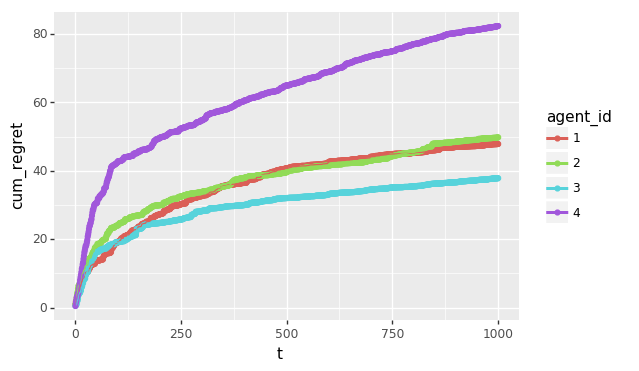

<ggplot: (8787255103013)>


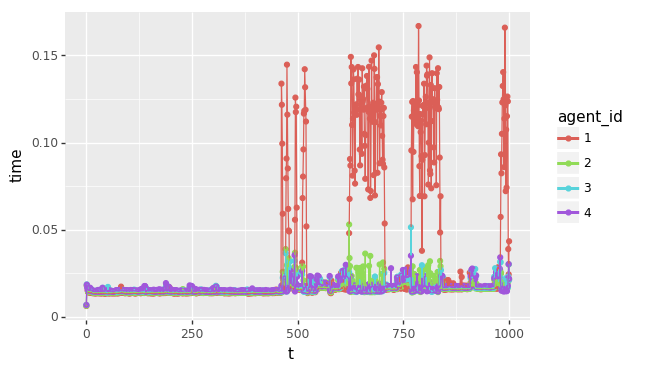

<ggplot: (8787255103025)>


In [6]:
plot_results(results)

In [7]:
time_limit=0.1
make_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=1, weights=True)
make_prec_sagald_agent_nowt = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=1, weights=False)
make_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(sparsity/dim)),
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=1)
make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=True, context_has_constant=True, 
                                      n_steps=9999, time = time_limit, verbosity=1)

In [8]:

results, cum_regrets = simple_compare([make_pgts_agent(),make_sagald_agent(), make_prec_sagald_agent_nowt(), make_prec_sagald_agent()], num_articles, dim, sparsity, 1000, seed=seed, verbosity=1)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918]
Experiment: Step 0
 Sample: array([-0.38598809,  1.82990624, -1.42515617,  0.71533345,  0.43912737,
       -1.10296955,  0.75949359, -1.10321635, -1.0895511 , -1.38955024,
        0.83428321, -0.44934585,  1.08525132, -0.81014003,  0.61466259,
        1.40741059, -0.08601351, -1.12545275, -0.34257094,  1.25673747,
        0.73909384])
 Sample: array([-1.74437237e+00,  7.15536785e-01,  1.63090625e+00,  1.64859408e+00,
        4.32790200e-01, -1.91029171e-01, -7.86121270e-01, -5.72601817e-01,
       -1.64975030e+00,  2.13455156e+00, -2.69643893e-02,  2.38440514e+00,
       -7.44974154e-02, -1.61831793e+00,  1.86156510e+00, -8.59827024e-01,
       -4.37908211e-01,  1.64855109e+00,  1.45877321e+00, -2.02620642e+00,
        1.0547699

 Sample: array([ 1.97572307, -1.10163039,  0.14174566, -0.29194186,  0.58390672,
       -0.5210175 ,  0.54832471, -0.63003439, -0.41067505, -2.09048879,
        0.38928573, -0.00729935, -1.65629937, -0.03191889,  1.06000669,
        0.15221026,  0.6142841 , -0.09061412,  0.40410124, -0.12681701,
        1.4531483 ])
 Steps taken: 931
 Sample: array([-1.41368318,  0.19815528, -0.62602108,  1.85323099, -0.69360401,
        0.27625348, -1.33423164, -0.00781622,  0.31115124,  1.02353295,
        0.41752846,  0.69700522,  0.35751382, -0.25912518,  1.17934951,
        0.52269428, -0.098028  ,  0.1581375 , -1.21700561, -2.11243802,
        0.79118044])
 Steps taken: 189
 Sample: array([ 0.47774161, -0.77153831,  0.40344052,  0.7331647 ,  0.83235106,
        0.91582788, -1.52458003,  0.04111023, -1.25920851,  1.69216427,
        0.0664415 , -0.85367343, -0.76326926, -0.11914026,  1.126055  ,
       -0.36933967, -0.60892877,  0.49219428, -1.39750982, -0.7534655 ,
       -0.86252253])
 Steps tak

 Sample: array([ 0.12191761, -1.04871791,  0.24626528,  0.25726663, -0.53838468,
        0.45555368, -1.03493521, -0.63537074,  1.34047999,  1.16985425,
        0.30064203,  1.4490511 , -1.00817132,  0.57779257,  0.24182887,
       -1.00530319,  0.52007738, -0.35946958,  0.72682098, -0.40030451,
       -1.28847119])
 Steps taken: 895
 Sample: array([-1.16174649, -0.17090906, -0.53214319,  1.53610688, -1.99507521,
        0.57766779, -0.4275728 ,  0.77915064,  0.18051498,  0.93502871,
        0.60820176, -0.79177113,  0.44286111,  0.28827902,  0.66402116,
       -0.90546537, -0.89810052, -0.53477043, -1.00060239,  0.84621798,
        0.96579715])
 Steps taken: 170
 Sample: array([ 0.11432426, -1.46835987, -0.60024116,  0.50428906, -0.54116163,
       -1.4175404 ,  0.27319988, -0.82520035, -0.04152815,  0.34597865,
       -0.73726484, -1.04669069, -0.44530882,  0.56212564,  0.72985606,
        1.54923189,  0.8559709 ,  0.23343412, -2.2926751 ,  0.80607949,
        0.55578136])
 Steps tak

 Sample: array([ 1.10988964, -0.87024482, -0.82965911, -1.23389161,  0.81237655,
       -1.6838972 ,  0.23085631, -1.7934734 ,  0.2289117 , -0.21001287,
       -1.73610413, -0.76014462, -0.10521197, -0.00944452,  1.05391695,
        0.89021122,  1.22353953,  0.57147675, -1.63993134,  0.8460048 ,
       -0.64635297])
 Steps taken: 173
Experiment: Step 19
 Steps taken: 334
 Sample: array([-1.29340238,  0.58449355,  0.49580334, -1.4407442 , -0.64653686,
        1.40041226,  1.04382484, -0.45985154,  0.51563531,  1.323282  ,
       -0.65246461,  0.82954687,  0.61963353, -1.61158484, -0.33224476,
        0.11122351, -0.52830064, -1.63821696,  1.62349328, -0.0531774 ,
       -1.66188888])
 Sample: array([ 0.08094553, -0.36219467,  1.39604934, -1.03959917, -0.43132518,
        0.2694963 ,  0.10448701, -0.78632985, -0.82965113,  0.75654705,
        0.20589638,  0.73076044,  0.42682676, -0.29167312,  1.55293823,
       -1.22176647, -0.33347086, -1.43536869, -0.96055809,  0.95753802,
       -0.7

 Sample: array([ 1.15623791, -0.03848367, -0.65404923, -1.01932569, -0.19711025,
       -2.67033988, -0.49148283, -1.27001384,  0.75950057, -0.35931535,
       -1.51021441,  0.05953836, -0.03291308,  0.54738559,  0.0977107 ,
        0.26171007,  0.47291372,  1.0165885 , -0.77028061,  0.73305894,
       -1.0966068 ])
 Steps taken: 179
Experiment: Step 25
 Steps taken: 330
 Sample: array([-0.89074379,  1.26698291,  0.07179836, -0.77649095, -0.3173714 ,
       -0.87533424,  0.41883149, -0.54055448, -0.76808834,  0.17082049,
        1.42744985, -1.63251361, -0.90626309,  1.57631395, -0.40043799,
       -0.37545014, -1.04718668, -0.64619796,  1.24865003,  1.15242768,
        0.5436261 ])
 Sample: array([ 1.59340749, -0.84711956,  0.51370083, -0.32882794, -0.52648831,
        0.36650582, -0.66397441, -0.27071551, -0.32641373,  0.34461128,
       -1.08161119, -0.15788066, -0.88235335, -0.12779328,  0.73000469,
       -0.44224405, -0.56374951, -1.92523969,  0.31346345,  0.04243077,
       -0.8

 Sample: array([ 0.11263305,  0.29773183, -0.47034189, -0.40631131, -0.4728238 ,
       -1.30072156, -0.55912423, -0.82422905,  0.87859046,  0.10100171,
       -0.55736817, -1.00582504, -0.14317483,  0.20377377,  0.68442577,
        0.4430106 ,  0.7441038 ,  0.25006401, -0.52597879,  0.29829851,
       -0.50938414])
 Steps taken: 177
Experiment: Step 31
 Steps taken: 324
 Sample: array([-1.42216061,  1.59718629,  0.52706533, -0.79730081,  0.88760034,
       -0.56030355,  0.34640698, -0.556469  ,  1.03859499, -0.6128835 ,
        0.11920385,  0.6943935 ,  0.45914642, -0.46887828, -0.43419083,
       -1.37371963, -0.54590544,  0.21737337,  1.54240293,  0.33096662,
       -0.38731142])
 Sample: array([ 0.66816917,  1.04612147, -0.64750627,  0.01289977, -0.2896542 ,
       -0.06955294, -0.20205842, -1.25740726,  1.75229297, -0.59251794,
        1.86907485, -0.43496682, -0.1366198 ,  0.14058837, -0.16591414,
       -2.61800477, -0.02400224, -0.09825061,  0.13562308,  1.49957636,
        0.5

 Sample: array([ 0.47178277,  0.79573929, -0.41515563, -0.50379834, -0.84713735,
       -1.15910484, -0.76422083, -0.43836843,  0.09859621, -0.4869865 ,
       -0.37964417, -1.45187501, -1.17262467,  0.28070687,  0.95246066,
        0.74985864,  0.17372707,  0.06857865, -0.90976202,  1.333413  ,
       -0.6880451 ])
 Steps taken: 178
Experiment: Step 37
 Steps taken: 321
 Sample: array([ 0.5806816 ,  1.03486543,  0.02671589, -0.9029133 ,  1.49337272,
       -0.29848773, -0.93258052, -0.87198862,  0.01926125, -1.22463843,
        2.2488386 ,  0.10821027, -1.71951702, -0.70525549,  0.68324364,
       -0.13687446, -0.54519894,  0.47215645,  0.00691896, -0.76486623,
       -0.19549523])
 Sample: array([ 0.06609013,  0.44590761,  0.30085948, -0.43649673,  0.45578829,
       -0.89598784, -0.56042189,  0.61795733, -0.34134495, -0.32534382,
        1.03405639, -1.53129628,  0.00432996, -0.28225015,  0.92294581,
        0.6672624 ,  1.43234633, -1.04871434,  0.06014564,  0.82412978,
       -0.0

 Sample: array([ 1.83560375,  0.22977863, -1.4358738 , -0.50905255,  1.3163399 ,
       -0.39508836, -0.30791672, -0.03730892, -0.14577228, -0.91844205,
       -0.30057785, -0.96600571, -0.37624092, -0.03430016,  0.80551997,
       -0.77956374,  0.22440054,  0.19679925, -0.44799032, -0.50790647,
       -1.81493504])
 Steps taken: 752
 Sample: array([-0.72416158, -0.04090949,  0.96038522, -0.53081791, -0.786876  ,
       -0.28882361,  0.28873956,  0.08023039,  0.57679922,  1.66400639,
        0.33799697, -1.18802197, -0.89004205, -0.51079442,  0.97958119,
        0.22196047, -0.63767329, -0.23611973,  0.06069342, -0.66282676,
        0.34465438])
 Steps taken: 171
 Sample: array([ 0.98190403, -0.10799676, -1.36234713, -0.2184287 , -0.73216306,
       -1.98916121, -0.71797714, -0.72869684, -0.54110861, -0.09963583,
       -0.50372498, -1.14513109, -0.74777124,  0.8942472 ,  0.97600061,
        0.9359363 ,  0.79059696, -0.81880662, -1.49809801,  0.31091257,
       -0.90486465])
 Steps tak

 Sample: array([-0.07123697, -0.75576561, -0.90044531, -0.06470772, -0.47069855,
       -1.76507494, -0.19709147,  0.29040347, -0.26772523,  0.01792564,
        0.87984266, -1.17144305, -0.81504795,  0.14407264,  1.18584949,
        0.6236687 ,  0.96191527, -0.1795002 , -0.83592269,  0.1999049 ,
       -0.46749733])
 Steps taken: 172
Experiment: Step 50
 Steps taken: 310
 Sample: array([-0.09933418,  0.70558429, -0.31708349,  0.02244321,  0.07400621,
       -0.68809928,  1.09765664,  1.19217022,  1.25095266, -1.5266829 ,
        0.88822124, -1.00333978, -0.23160798, -0.83811552,  0.7351104 ,
       -0.30455102, -1.13806393, -0.49484762,  1.04950375, -0.17964933,
       -2.00336609])
 Sample: array([ 0.45003789, -0.70090877, -1.98364287,  0.01008779,  0.87772522,
       -0.17405298, -0.07818875,  0.053436  ,  1.92167677,  0.46279912,
        0.91281825, -2.20010704, -1.22295929,  0.47230248,  1.65112046,
       -1.66163962,  0.15346307, -0.9066689 , -0.90942152,  0.15826061,
       -1.2

 Sample: array([-0.03656223, -0.60565969, -0.32654728, -0.20172045,  0.45422699,
       -1.37613252,  0.27972713,  0.10222455, -0.72504898,  0.007836  ,
        0.66026231,  0.12126014, -0.72246499,  0.76810729, -0.01289748,
        0.09837498, -0.21822486, -0.24382931, -1.23120456,  0.90031566,
       -0.28857837])
 Steps taken: 168
Experiment: Step 56
 Steps taken: 306
 Sample: array([ 0.85220117, -0.54219061,  0.3717512 , -2.53573121,  1.04835535,
       -1.23554829,  0.99488346, -2.13674682, -0.3965769 , -0.80991176,
        0.69229948, -0.36526027, -0.33325172, -0.06671753,  1.45621591,
       -1.85472595, -1.65290553, -0.64997252,  1.10389446, -0.03872041,
       -0.49297028])
 Sample: array([ 0.335353  , -0.25253687, -1.43691613, -1.97355793,  0.18285034,
       -0.70983027,  0.87726466, -1.33808759,  0.90466251,  1.06638507,
       -0.17668121, -0.52095425, -0.16349001,  1.32302656,  1.22485719,
       -0.64103546,  0.32385351, -0.94587697, -0.77545354,  0.10421089,
       -1.4

 Sample: array([ 1.00835882, -0.39218289, -0.68430036, -1.01953329,  0.50719689,
       -0.83407315,  0.74925433,  0.6700018 ,  0.43947378,  0.17560128,
        1.76579722, -0.83586328, -0.94338023, -0.11357535,  0.92474441,
       -1.36554591, -1.12964692, -1.42678421, -0.76979943, -0.3669308 ,
       -0.5842853 ])
 Steps taken: 671
 Sample: array([ 0.02922249, -0.05430753,  1.2577078 , -0.12771034, -0.31433646,
       -0.35479627, -0.05834443, -0.18730624,  0.11642282,  1.71159049,
        0.22582948, -2.28988124, -0.59642159, -0.97286576,  0.99420682,
       -1.28184479, -1.12679595, -0.45339506,  0.52574967,  0.95934028,
       -0.77163505])
 Steps taken: 173
 Sample: array([-0.34500631, -1.07205252, -0.09769792, -0.61259468,  0.59629147,
       -1.27948078,  0.72081372, -0.84770921, -0.40890583, -0.17597305,
        0.84689045, -0.52128222, -0.68034579,  0.89516463,  0.23784708,
        0.76039818,  0.0092529 , -0.28130638, -1.3432644 ,  0.94886838,
       -0.34690919])
 Steps tak

 Sample: array([ 1.11181042e-02, -1.33725369e-01, -6.32005185e-01, -1.62698366e+00,
        9.03402762e-02, -8.61036830e-01, -2.07824584e-01, -2.07298360e-03,
        4.13474069e-01,  3.23140850e-01,  1.54424413e+00,  4.27003949e-02,
       -6.72004450e-02,  1.11050272e+00,  1.25745418e+00, -6.77048307e-01,
       -4.52464546e-01, -2.26226565e+00, -1.71791140e-01,  3.37071046e-01,
       -1.33086674e+00])
 Steps taken: 488
 Sample: array([ 0.32287389,  0.1361161 ,  0.20589065, -0.56096776,  0.18557743,
       -1.01401308,  0.10072768,  0.17630267, -0.21820682,  1.17659315,
        0.47483245, -2.5014777 , -0.48220697, -1.71883556,  0.84050629,
       -0.86960421, -0.85130491, -0.01472395,  0.77495462,  0.82678345,
       -0.52079421])
 Steps taken: 157
 Sample: array([ 0.561093  , -1.03072279, -0.43956326, -0.52218431,  0.03874215,
       -1.40793329, -0.34700588, -1.08109379, -0.29589091,  0.08026977,
        0.23006399, -0.69778489, -0.90217598,  0.45298491,  0.5604272 ,
        0.56

 Sample: array([ 0.69267576, -0.42492399, -1.12889402, -2.24323973,  0.05798079,
       -1.03452684,  0.34542361, -1.20075448,  0.54178719,  0.01165186,
        1.4389543 , -0.6417847 , -0.57706041, -0.01062542,  1.41424184,
       -0.8288778 , -0.41771607, -1.60780827, -0.08081752,  0.72909417,
       -0.86057609])
 Steps taken: 493
 Sample: array([ 9.89926574e-01, -5.60103305e-01,  3.07779591e-01, -7.42308644e-01,
        6.30228004e-01, -8.02775541e-01,  4.44866039e-01,  2.52730552e-03,
       -1.22971339e-01,  7.85274828e-01,  6.90769045e-01, -2.59139680e+00,
       -3.07072250e-01, -1.87785503e+00,  5.94282061e-01, -1.00928561e+00,
       -7.06964676e-01, -5.00578728e-01,  6.19621855e-01,  6.46675691e-01,
       -1.13088896e-01])
 Steps taken: 153
 Sample: array([ 0.37703714, -1.10042412, -0.46412598, -0.73530687,  0.04976075,
       -0.95402939, -0.41013357, -1.31283147, -0.35653497,  0.30804454,
       -0.17194298, -0.82890738, -0.32981071,  0.25664797,  0.70267848,
        0.62

 Sample: array([-0.38391438,  0.31086559, -0.76851364, -0.62435411,  0.38634318,
       -0.97817333,  0.30779872, -0.17757474,  0.83388389, -0.71277664,
        0.61699067, -1.07035954,  0.21311002,  0.38715659,  2.48814006,
       -0.34266304, -0.8174868 , -0.74735143,  0.21047547,  0.14831127,
       -0.24213972])
 Steps taken: 491
 Sample: array([ 0.85691148, -0.22223489,  1.04772825, -1.14802257, -0.255491  ,
       -1.13979153,  0.4563032 ,  0.40481148, -0.42900349,  0.50599012,
        0.5500549 , -2.33848496, -0.3925499 , -1.15297514,  0.33858144,
       -0.82321493, -1.41182219, -0.63227668,  1.13016778,  0.87052063,
       -0.13498426])
 Steps taken: 151
 Sample: array([ 0.49519521, -1.03679204, -0.04016576, -0.69002588, -0.51378333,
       -1.02632614, -0.13221106, -0.82100598, -0.71354515, -0.31785647,
       -0.39932348, -1.3599323 ,  0.01274564,  0.51893506,  1.07389942,
        0.42099086,  0.24813128, -0.0690313 , -1.38564449,  1.12264412,
        0.1823906 ])
 Steps tak

 Sample: array([ 0.54560928, -0.36082914, -0.15626533, -0.89937698, -0.12253362,
       -1.582805  , -0.01293076, -0.8860171 , -0.43121723, -0.67943354,
       -0.41189971, -1.01629654, -0.14934192,  0.65310535,  0.84442341,
        0.82471696, -0.00685044, -0.49421239, -1.22438956,  0.54042794,
       -0.12835786])
 Steps taken: 155
Experiment: Step 87
 Steps taken: 284
 Sample: array([ 2.00737092, -0.59313537, -1.05700861, -0.34164618,  1.43119039,
       -2.38492561,  0.23407373, -2.21001198,  0.06558499, -1.19230907,
        0.4208751 , -0.62668412, -0.20852968,  0.29450127,  0.16100883,
       -1.7347703 , -2.3447789 , -0.76945671,  1.25595665, -0.119032  ,
        0.38642165])
 Sample: array([-0.03454345,  0.01446648, -1.92142896, -1.03598723, -0.25254415,
       -1.42026448,  0.73537231, -0.02838398,  0.66379615, -0.46142863,
        2.5184381 , -0.95051477,  0.36448385,  0.28875949,  2.26495446,
       -1.22424694, -0.10600182, -1.65561903, -0.31473596,  1.03974004,
        0.2

 Sample: array([-0.59133364, -0.65200146, -1.23770853,  0.05394749,  0.63454947,
        0.13661143,  0.76999455, -0.88772716,  0.37893408, -0.28767367,
        1.58554524, -0.59631847,  0.44900521,  0.74408192,  1.33102757,
       -0.75273198,  0.31754635, -0.83056953,  0.01883725,  0.81657831,
       -0.62026882])
 Steps taken: 490
 Sample: array([ 0.70138393,  0.30137014,  0.51718893, -1.02895406,  0.28123807,
       -1.42533031,  1.49548833,  0.13982758, -0.80320378,  0.33001515,
        0.33707589, -1.56600702,  0.06301446, -1.6704748 ,  0.67177655,
       -1.0343177 , -0.43138538, -0.61248174,  1.42707771,  0.11818445,
        0.03839938])
 Steps taken: 159
 Sample: array([-0.48017233, -0.20318493,  0.07046253, -1.3202199 , -0.04006356,
       -1.56486236,  0.343952  , -0.2917232 , -0.11889994, -0.00625285,
        0.15525944, -1.19250588,  0.62653211,  0.81682379,  0.622109  ,
        0.76837524,  0.53827576, -0.36934975, -1.63117924,  0.77736793,
        0.60979834])
 Steps tak

 Sample: array([-0.18859078,  0.14840825,  0.32321339, -1.47311448, -0.13961221,
       -1.12933606,  0.22842384, -0.61979874, -0.86031621, -0.03770351,
        0.06758436, -0.99710175,  0.84180203,  0.73487481,  0.43729161,
        0.83038999,  0.43885422, -0.37084831, -1.5259255 ,  0.60740026,
        0.5065207 ])
 Steps taken: 156
Experiment: Step 100
 Steps taken: 280
 Sample: array([ 0.71299564, -0.12688894,  0.53209108, -0.08423299,  0.72141325,
       -1.19633303,  1.35499111, -1.63240355,  0.81158876, -1.21940072,
        0.37138699, -0.2437746 , -0.34036183, -0.23404081,  0.7829387 ,
       -0.28089419, -0.92374046, -2.05004004,  0.41443107,  1.14826805,
       -0.8327871 ])
 Sample: array([-2.71602367e-01,  1.39790033e-01, -8.05098793e-01, -3.73626477e-01,
        4.46111170e-01, -1.48505466e+00,  7.13919011e-01, -1.59090382e+00,
        2.48915481e-01, -1.31065989e-01,  2.47102560e+00, -1.46026059e+00,
        1.59479623e-03,  8.83376420e-01,  1.25545570e+00, -9.56739837e-01

 Sample: array([ 0.04817281, -0.27101302, -0.03241793, -0.95457554,  0.29157621,
       -1.05389546, -0.03032672, -0.31762788, -0.6026442 ,  0.42244869,
       -0.30999914, -1.08304529,  0.96662843,  0.66957806,  0.72886339,
        0.34953662,  0.31743158, -0.4825629 , -2.01137449,  0.61257623,
        0.12409525])
 Steps taken: 153
Experiment: Step 106
 Steps taken: 275
 Sample: array([ 0.93649442,  0.55088004, -0.02564347, -1.79728093,  0.37574118,
       -2.64068043,  0.41133695, -1.38279787, -0.58914084, -0.81439472,
        1.88593055, -2.04259761, -0.1870422 ,  0.58573041,  0.13076764,
        0.83823505, -0.91473356, -1.37586388,  0.99478946,  0.44101084,
       -1.49316366])
 Sample: array([-0.0520996 , -0.67716083, -1.42043009, -0.99120116, -0.66247533,
       -0.6315231 ,  0.95480794, -0.4051768 ,  1.33417044,  0.7564465 ,
        1.41112733, -0.59134579, -0.2341101 , -0.00170435,  1.54212538,
       -1.54595903,  0.64743622, -1.49899678,  0.08467608,  0.49090745,
       -0.

 Sample: array([-0.22947492,  0.11962063, -1.52091927, -1.24339519,  0.0941098 ,
       -0.39588356,  0.28632153, -0.85964619,  1.0001066 ,  0.22599035,
        2.21446789, -1.28237158, -0.24713995,  0.59387536,  1.35204075,
       -0.78822629,  0.71999849, -0.46787323, -0.14201005,  0.81350267,
        0.1661807 ])
 Steps taken: 487
 Sample: array([ 0.48881291,  0.29648028,  0.69061391, -0.60751078,  0.83981557,
       -1.93474066,  1.51567514,  0.28154099, -0.43022006,  0.54574467,
        0.61782734, -1.69445737, -0.32243746, -1.07212919,  0.35516271,
       -1.7369625 , -0.76683292, -0.29294768,  1.89736263,  1.31659558,
        0.0931963 ])
 Steps taken: 158
 Sample: array([ 0.776674  , -0.8262509 , -0.14646544, -1.35772665,  0.21558781,
       -0.53723743, -0.00230752,  0.14032311, -0.60211139,  0.66872972,
       -0.33440151, -1.35290934, -0.1076663 ,  0.58262483,  0.54385354,
        0.16462729,  0.20039022, -0.37606695, -2.29363828,  0.40004111,
       -0.30459486])
 Steps tak

 Sample: array([ 0.44589736, -0.61864217, -1.04297375, -1.05534963, -0.39559887,
       -0.70885595,  0.49114719, -0.09104166,  1.14823921,  0.94400107,
        1.48024525, -1.05431352, -0.8406242 , -0.06682343,  1.54660673,
       -1.38450201, -0.13864882, -1.20220562,  0.0851873 ,  0.81614023,
       -0.85406486])
 Steps taken: 490
 Sample: array([ 0.31289623,  0.13745898,  0.74850843, -0.23239906,  0.6688607 ,
       -1.36564316,  1.39784273,  0.48556424, -0.39099181,  0.49073597,
        0.34100521, -1.52140603, -0.31534697, -1.23822755,  0.64665277,
       -1.53618107, -0.53932815, -0.38391666,  2.08059303,  1.48079426,
       -0.28342725])
 Steps taken: 157
 Sample: array([ 0.60868641, -0.79375804,  0.29436879, -1.30556942, -0.18072218,
       -0.51937218,  0.11162398,  0.28477977, -0.05674685,  0.33026948,
       -0.27118686, -1.48964974, -0.23332708,  0.65056677,  0.85381811,
        0.01859535,  0.5938134 , -0.18395521, -2.12508216,  0.28609471,
       -0.26508389])
 Steps tak

 Sample: array([ 0.65542189, -0.87334701,  0.35742853, -1.81425334, -0.54936483,
       -0.80904097,  0.1816679 , -0.25467646, -0.2448568 ,  0.23620808,
       -0.60637157, -1.34231767,  0.21278288,  0.4192587 ,  0.82982992,
       -0.17640272,  0.16581667, -0.02927594, -1.67460991,  0.92386294,
        0.43521215])
 Steps taken: 155
Experiment: Step 125
 Steps taken: 261
 Sample: array([ 1.62926839, -0.10099277, -0.07821816, -1.78599194,  1.16550408,
       -1.69320795,  0.6566089 , -1.81154467,  0.36892445, -0.56545887,
        0.1323727 , -0.42751241, -1.11102222, -0.49701832,  1.61745204,
       -2.14434273,  0.40362377, -1.54994516,  0.45041365,  0.94452636,
       -2.21244821])
 Sample: array([-1.2487689 ,  0.92382282, -0.52701357,  0.0584523 ,  0.36855769,
       -0.56731044,  0.95576311, -1.23205848,  0.96373386,  0.50472971,
        2.28997838, -1.13405381, -0.1625342 ,  0.11130113,  1.34719127,
       -1.72551281, -0.44844712, -1.94592557, -0.02014931,  1.53911724,
       -0.

 Sample: array([ 0.53371068, -0.10993212, -0.78936519, -0.35385575, -0.24054264,
       -0.93725382,  0.97427221, -1.25498155,  0.86665498, -0.08764726,
        1.53203897, -0.64276532, -0.81241947,  0.34190178,  1.32970092,
       -1.1957051 , -0.47236516, -1.45854599,  0.37540475,  0.82058636,
       -1.03240777])
 Steps taken: 486
 Sample: array([-0.1244434 ,  0.07236273,  1.02910613, -0.67514595,  0.52506351,
       -0.83358491,  0.85760727,  0.91491632, -0.33964923,  0.58069039,
        0.37527745, -0.76684775, -0.48473616, -1.20108548,  0.26831155,
       -1.25682234, -0.34865292,  0.04526125,  1.29729674,  1.86472137,
       -0.37948189])
 Steps taken: 157
 Sample: array([ 0.66887335, -1.009531  ,  0.02190495, -1.79261666, -0.30543722,
       -0.80106411,  0.32564444, -0.25904736, -0.21936211,  0.18031069,
       -0.18567778, -1.21665761,  0.49850644,  0.5566444 ,  1.06691276,
       -0.11565299,  0.20326445, -0.04625452, -1.46694983,  0.50451719,
        0.57367563])
 Steps tak

 Sample: array([ 0.34682599, -0.81923464,  0.56196531, -1.67491561, -0.10186965,
       -1.00613988,  0.42786964, -0.31498364,  0.25135638,  0.12914482,
       -0.43664577, -1.22714557,  0.28720986,  0.82085687,  1.40579738,
       -0.32527368, -0.06152789, -0.08163686, -0.83370094,  0.71849431,
       -0.05588629])
 Steps taken: 149
Experiment: Step 138
 Steps taken: 251
 Sample: array([ 1.45742556,  0.80373219,  0.62860974, -2.33688421,  0.54940137,
       -2.09680704, -0.15998045, -1.04234375, -0.53067734, -0.7152311 ,
        1.0706964 , -0.92361999, -0.59162532, -0.91945054,  0.61979681,
       -1.20611158, -0.98042244, -1.64107786,  0.97109763,  1.0626762 ,
       -1.71933315])
 Sample: array([ 1.41207523,  0.00675573, -1.01199937,  0.81999825, -0.10040356,
       -1.56825633,  0.45824803, -1.12372146,  0.69056617, -0.88754115,
        1.31521682, -1.24452187, -0.35504025,  0.4659821 ,  0.99836735,
       -1.23858437, -0.08733339, -1.41995919,  0.24386598,  0.59998411,
       -0.

 Sample: array([-0.73869371,  0.01753311, -2.18790549,  0.27527186, -0.88177629,
       -1.10423965,  1.14405417, -0.28314797,  0.3605127 ,  0.72054192,
        2.83424985, -0.33644837, -0.51947737,  0.65539503,  1.51690727,
       -1.73601596, -0.16413369, -1.28617822,  0.46727073,  1.00412016,
       -0.58597549])
 Steps taken: 484
 Sample: array([ 0.88177978, -0.3624957 ,  0.67865751, -0.795587  ,  0.40418766,
       -0.97878399,  0.65119508,  0.04745208, -0.62692866,  0.6595041 ,
        0.09444277, -0.68495977, -0.41940862, -1.5844742 ,  0.73103288,
       -2.02035307, -0.63984788, -0.07190324,  1.17302367,  1.50040843,
        0.04476706])
 Steps taken: 155
 Sample: array([ 0.34203185, -0.95381107,  0.51111584, -1.72775224, -0.29575258,
       -0.88199967,  0.01006447, -0.42998877, -0.05945042,  0.07925924,
        0.40670826, -0.9923037 ,  0.24965497,  0.73180166,  1.34051969,
       -0.41965204,  0.21014111,  0.21387842, -0.43312113,  0.64555787,
        0.09188486])
 Steps tak

 Sample: array([ 0.93875399, -0.88030972,  0.31717457, -1.67627699, -0.36261368,
       -0.68957991,  0.45601336, -0.65115618, -0.23030984, -0.16496983,
        0.68406836, -1.59310759, -0.12488982,  0.56914827,  1.15475671,
       -0.56741132,  0.12439989,  0.24429157, -0.71257885,  0.0738649 ,
       -0.05269687])
 Steps taken: 152
Experiment: Step 151
 Steps taken: 248
 Sample: array([ 1.55821545, -0.35162167, -0.16271504, -2.27632812,  0.93727768,
       -1.74101687,  0.34219617,  0.32174184, -0.43194841, -0.57260689,
        1.37499751, -0.38100482, -1.19091032, -1.58258369,  1.87759523,
       -0.67218752, -0.15098092, -1.99909444,  1.38783037,  0.42970695,
       -1.32648403])
 Sample: array([-0.2550484 , -1.33073293, -0.54026609, -0.50618357,  0.82811677,
       -0.88721293,  1.17134285, -0.5830676 ,  0.4021837 ,  0.1299715 ,
        2.1861197 , -0.60728396, -0.20270678,  0.48322612,  1.67910602,
       -1.48163478,  0.32033792, -2.0164693 ,  0.29398566,  1.61338308,
       -1.

 Sample: array([-4.36671700e-01, -4.87647202e-01, -1.60580049e+00, -7.23578373e-01,
        8.32632184e-01, -1.18320125e+00,  1.06154329e+00, -1.03281088e-03,
        1.28362200e+00, -7.23117084e-01,  2.46353494e+00, -2.61331529e-01,
       -5.63307467e-01,  1.38960286e+00,  1.88091194e+00, -8.02252095e-01,
       -3.44639894e-01, -4.11975792e-01, -4.36937771e-01,  2.88976903e-01,
       -2.13853374e+00])
 Steps taken: 485
 Sample: array([ 0.29147751, -0.30836616,  0.55370885, -0.84173606,  0.89344629,
       -0.89818314,  0.89242759,  0.18215027, -0.18760618,  0.92467927,
        0.73236533, -0.40262952,  0.14090104, -1.38942456,  0.60155674,
       -1.45824824, -0.83299619, -0.85843355,  1.13257653,  1.36294284,
       -0.0755004 ])
 Steps taken: 159
 Sample: array([ 0.96270124, -0.95914175,  0.89614814, -1.18036253, -0.29011377,
        0.0259541 ,  0.73138523, -0.53013795, -0.9135372 , -0.39848594,
        0.55216123, -2.02296817, -0.08963711,  0.32997857,  1.43087876,
       -0.89

 Sample: array([ 1.10946547e-01, -3.49602146e-04, -6.97005079e-01, -1.13190717e+00,
        6.42230132e-02, -5.48476365e-01,  9.78652103e-01, -9.87397153e-01,
        6.16076887e-01,  1.07506077e-01,  1.72679918e+00, -4.86154397e-01,
       -6.68343189e-01, -2.43182463e-01,  1.90947930e+00, -1.83711791e+00,
        5.20908806e-01, -2.08797250e+00, -9.47533173e-01,  9.06146515e-01,
       -1.02745907e+00])
 Steps taken: 487
 Sample: array([ 0.5420786 , -0.44529504,  0.04339985, -1.11708358,  1.02265711,
       -1.11879831,  0.94750183,  0.10021466, -0.03848804,  0.92005925,
        0.7552732 , -0.68335225,  0.42603572, -1.17613893,  0.87990364,
       -1.12770123, -0.93750483, -0.75234254,  0.93760226,  1.38006963,
       -0.5049662 ])
 Steps taken: 154
 Sample: array([ 9.69688327e-01, -8.48171484e-01,  1.00769491e+00, -6.65798870e-01,
       -4.97820158e-01,  3.07075177e-02,  5.50350153e-01, -4.75564428e-01,
       -7.04839109e-01, -7.28718594e-01, -2.13911483e-04, -1.41761620e+00,
   

 Sample: array([ 1.4103986 , -0.70905762, -1.06833293, -0.03944638, -0.72130981,
       -1.34272438,  0.80931668, -1.76318974,  1.05454304,  0.37073525,
        1.09028699, -0.78858035, -0.78981725,  0.9562611 ,  1.19797087,
       -1.5971683 , -0.6766688 , -2.72499664,  0.4782766 ,  0.80195427,
       -1.29652132])
 Steps taken: 487
 Sample: array([ 0.81445685, -0.2820987 ,  0.02074071, -1.05657069,  1.21978659,
       -1.19973839,  0.53973726,  0.09010625, -0.03846052,  0.79300565,
        0.94735753, -0.80698993,  0.32943061, -1.36410963,  0.52316178,
       -1.56397092, -0.68180879, -1.24090373,  1.13086579,  1.07392295,
       -0.1682317 ])
 Steps taken: 154
 Sample: array([ 0.65815162, -0.86623911,  1.11268773, -0.67852787, -0.44921285,
       -0.45060888,  0.21223795, -0.13414063, -0.22472959, -0.49774952,
        0.11166525, -1.59337296, -0.43009475,  0.76656045,  1.06576514,
       -0.24676854, -0.07150016,  0.13800797, -0.12477996,  0.41708809,
       -0.18905109])
 Steps tak

 Sample: array([ 0.58295748, -0.2646858 ,  0.87250483, -0.54792933, -0.82422968,
       -1.13057042,  0.47656971, -0.52799712, -0.09458632, -0.21724809,
        0.32469199, -1.46586601, -0.38640199,  0.4353672 ,  1.0998567 ,
       -0.24904645, -0.16937814,  0.52857938, -0.16735621,  0.68451843,
        0.0155727 ])
 Steps taken: 155
Experiment: Step 176
 Steps taken: 238
 Sample: array([ 0.05662949,  0.28873569,  0.7912473 , -0.911198  ,  0.38468191,
       -0.52710635,  1.26308698, -1.66876572, -0.5650449 , -0.4627735 ,
        1.30820844, -1.3189447 , -0.04167451, -0.40016982,  1.25922968,
       -0.62237907, -1.10885198, -0.74618352,  0.47896796,  0.31449024,
       -0.44754042])
 Sample: array([ 0.78144693, -0.26157772, -1.15965247, -1.58081622,  0.51691391,
       -1.6579149 ,  0.72866777, -1.19959414,  0.06845539,  0.33399076,
        2.25199947, -1.14297012, -1.07743231,  0.70189927,  1.26934329,
       -2.02955858,  0.05494963, -0.94238686,  1.01863825,  0.2945566 ,
       -0.

 Sample: array([ 0.74985487, -0.00325175,  1.20101606, -0.57349664, -1.268799  ,
       -0.92082883,  0.89234175, -0.89292795, -0.59164817, -0.30667123,
        0.55847608, -1.45091781, -0.40821881,  0.76384019,  0.40748291,
        0.16602706, -0.08377878,  0.17868572, -0.31463086,  0.49620723,
       -0.01273644])
 Steps taken: 155
Experiment: Step 182
 Steps taken: 232
 Sample: array([ 1.79533322,  0.12823519,  0.86884267, -2.83843519,  0.67362497,
       -2.46685415,  0.49605885, -1.46042795, -0.28335524, -0.56611604,
        0.64081836, -1.27814599, -0.14451584, -0.29764324,  0.40590948,
        0.06331709, -1.14804113, -2.70543213,  1.18986421, -0.06505435,
       -0.55917575])
 Sample: array([ 0.41841821, -1.00035001, -1.15583013, -0.12889491,  0.41444057,
       -0.90123752,  1.08321518, -1.22712937,  0.82998539, -0.94629072,
        2.19637772, -1.33655128,  0.12977555,  0.02588198,  1.32470195,
       -1.33174817, -0.02875464, -2.13256011,  1.27399676,  1.03600924,
       -1.

 Sample: array([ 0.27242395, -0.11051717, -1.11361864,  0.15322582,  0.44044109,
       -1.00701154,  0.86467434, -0.00397256,  0.16940847, -0.06041444,
        2.43804336,  0.3711116 , -0.62675721,  0.13832181,  0.55931314,
       -1.89647182,  0.12587364, -1.84042524,  0.35204451,  1.30267296,
       -0.23921449])
 Steps taken: 484
 Sample: array([ 0.77236789, -0.16783357,  0.78710404, -1.99108581,  0.54008765,
       -1.42297445,  0.4968118 , -0.37631849,  0.38337174,  0.266154  ,
        0.98485009, -1.01648385,  0.69272517, -1.29949904,  0.81205596,
       -0.91382588, -1.17790782, -1.03952564,  0.86102764,  1.01553332,
        0.42392543])
 Steps taken: 154
 Sample: array([ 0.69899838,  0.47590633,  0.66714432, -0.71764946, -0.52435042,
       -0.85856952,  0.84727561, -1.10633263, -0.26852845, -0.23107473,
        0.57066532, -1.07756787, -0.40305696,  0.7154881 ,  0.53861506,
        0.17818785, -0.48190683, -0.03421675, -0.21324226,  1.03440031,
       -0.46808115])
 Steps tak

 Sample: array([ 0.64527871, -0.30718322, -0.92385733, -0.98232825, -0.21441365,
       -1.04151885,  0.43258543, -0.63843924,  1.13924892,  0.19235887,
        1.58038477, -0.294352  , -0.4475751 , -0.08922484,  0.97116691,
       -0.28785921, -0.51206827, -1.38284982,  0.21240081,  1.13205459,
       -0.96145921])
 Steps taken: 452
 Sample: array([ 0.46025774,  0.10070656,  0.79488909, -1.85895111,  0.37776968,
       -1.23920992,  0.55195573, -0.17038936,  0.12461824,  0.36674303,
        0.79878667, -0.89868445,  0.47458265, -1.17727114,  0.67191522,
       -1.13168248, -1.22109956, -0.63600334,  1.02825206,  1.05090762,
        0.48868676])
 Steps taken: 148
 Sample: array([ 0.17891769, -0.06034303,  0.68504916, -0.51710964, -0.29900166,
       -0.5138745 ,  1.13208229, -1.03469091, -0.17840816,  0.1142798 ,
        0.54645704, -0.93855624,  0.2321062 ,  0.57823774,  0.78829832,
       -0.1266213 , -0.52581183,  0.32874076, -0.10023537,  0.92715668,
       -0.57202719])
 Steps tak

 Sample: array([ 0.68670741, -0.0720293 ,  0.26588755, -0.60808614, -0.17248516,
       -0.48350652,  1.4132935 , -0.91343415, -0.4808085 , -0.19554266,
        0.29133524, -0.71336239, -0.22200215,  0.35361486,  0.54089526,
        0.34201153, -0.32869422,  0.37892395, -0.93210405,  0.64225661,
       -0.73315753])
 Steps taken: 138
Experiment: Step 201
 Steps taken: 170
 Sample: array([-0.25108341,  0.59496961,  0.96530766, -2.09925362,  1.16713112,
       -1.32307238,  1.34493333, -0.38614108,  0.27055974,  0.04523033,
        2.04498242, -0.74292293, -0.64026511, -1.21338784,  1.20097011,
       -2.35404055, -0.97831339, -1.5265548 ,  1.03321146,  0.88216917,
       -1.05130047])
 Sample: array([ 0.58675451, -0.20635814, -0.9025909 , -0.63360189,  0.46856849,
       -1.41920493, -0.32612022, -0.92651643,  1.19708378,  0.22959828,
        2.30812999, -0.66578432, -1.14939291,  0.07100804,  1.58632627,
       -1.13445367, -0.24603794, -1.92330477, -0.46614035,  1.05239952,
       -1.

 Sample: array([ 0.05831161,  0.08350245, -1.4036712 , -1.09016803,  0.61183085,
       -0.75426911,  0.97980491, -0.8077474 ,  0.69584859, -0.20401063,
        2.44771838, -0.4192378 , -0.48466795,  0.38498095,  1.31030516,
       -1.68198275, -0.23381769, -1.27734675, -0.08404109,  1.00564697,
       -1.07386305])
 Steps taken: 480
 Sample: array([ 0.62724011,  0.08785139,  0.5922919 , -1.91252804,  0.47690644,
       -1.9621517 ,  0.42002019,  0.10778052, -0.05746623,  0.49771159,
        0.53335276, -0.63522226, -0.17082656, -1.48002338,  0.91839906,
       -1.66708331, -0.65837992, -0.7461575 ,  1.15221283,  1.55850978,
        0.52597149])
 Steps taken: 155
 Sample: array([ 0.96060728, -0.43912505,  0.33914002, -0.80664776, -0.58531909,
       -0.73132363,  1.24524673, -1.12609745, -0.01814738, -0.23165924,
        0.4338124 , -0.9590004 , -0.64659673,  0.38663879,  0.52531317,
        0.45905657, -0.13476379, -0.15155346, -0.89065477,  0.73645414,
       -0.64092713])
 Steps tak

 Sample: array([ 0.4743386 , -0.1726165 , -1.38936741, -1.13088254,  0.75375202,
       -0.97301517,  1.49577714, -1.80588838,  1.11596397, -0.54649774,
        2.12499137, -0.80172487, -0.95397901, -0.04922178,  1.64771161,
       -1.00886683, -0.79777348, -1.77217652, -0.7070677 ,  1.00924914,
       -1.37757466])
 Steps taken: 481
 Sample: array([ 0.53018775, -0.06544185,  0.84968534, -1.75983629,  0.69127238,
       -2.05775167,  0.16065537, -0.45119298,  0.23490964,  0.55784754,
        0.79404469, -0.86809532, -0.22686695, -1.47511501,  0.96015695,
       -1.37434167, -0.47390915, -0.63293641,  0.63954328,  2.05053129,
        0.65530424])
 Steps taken: 157
 Sample: array([ 0.80365709, -0.38919373,  0.38142639, -0.72819666, -0.30590503,
       -0.75053483,  1.15389773, -1.07917679, -0.2728543 , -0.05481827,
        0.65822738, -1.19528472, -0.40842695,  0.36533916,  0.77902545,
        0.10179556, -0.20050763, -0.02197648, -0.50602602,  0.66432255,
       -0.6823634 ])
 Steps tak

 Sample: array([ 1.03071079,  0.0055541 ,  0.51970698, -0.94251025, -0.28774051,
       -0.81799111,  0.72807999, -0.99591   , -0.39300522, -0.17379163,
        0.76470155, -0.99619016, -0.23006041,  0.13770259,  0.51364634,
       -0.0487252 ,  0.03432411, -0.43257063, -0.53305528,  0.84282529,
       -1.08303729])
 Steps taken: 155
Experiment: Step 220
 Steps taken: 217
 Sample: array([ 2.9176033 ,  0.60555453, -0.90927209, -1.47511211,  0.79434097,
       -2.90605514,  0.66763614, -1.80239052, -0.65657942, -1.09926033,
        1.07675037, -1.4230736 , -0.11307964, -0.9099296 ,  0.83858741,
       -1.36936864, -0.80937225, -1.25252327,  0.21134687,  1.14065098,
       -2.04656617])
 Sample: array([ 1.02186106, -0.46004321, -1.30607598,  0.22789019, -0.23082537,
       -1.51011845,  0.80167664, -0.70798481,  0.76913009, -0.53074915,
        2.03325475, -1.24788853, -0.39845579,  0.6416032 ,  1.62843033,
       -1.69503438,  0.28589193, -2.04178211, -0.05298073,  0.22494469,
       -1.

 Sample: array([ 0.86863822,  0.05656932,  0.70097394, -0.72980124, -0.68925684,
       -0.65796521,  0.79535124, -0.76833016,  0.09711466, -0.31253077,
        0.78753337, -0.90523523, -0.11548483,  0.46179391,  0.89868876,
       -0.62352391,  0.42465837, -0.92275998, -0.37570428,  0.68429476,
       -1.10661779])
 Steps taken: 158
Experiment: Step 226
 Steps taken: 214
 Sample: array([ 1.68770095, -0.45973183,  0.17451589, -1.8779472 ,  0.17542792,
       -2.44517855, -0.1716569 , -0.56596575, -0.37410007,  0.19320924,
        0.58252157, -0.10163887, -0.01386802, -0.61421663,  1.04124148,
       -0.72394313, -1.08405496, -1.42869081,  1.46766075,  1.28103749,
       -0.80749749])
 Sample: array([ 1.19950024, -0.51365199, -1.42106177, -0.07183993,  0.19576055,
       -2.01098752,  0.2592568 , -0.14304484,  1.17812624,  0.49190948,
        2.0146634 , -1.5129552 ,  0.10318159,  0.05110903,  1.1763828 ,
       -0.71173971, -0.4200705 , -2.38005842, -0.64724893,  0.27382868,
       -1.

 Sample: array([ 1.20980413, -0.21461693, -0.96747487, -1.31213491, -0.01752374,
       -1.05576374,  0.9338917 , -0.99525035,  0.87458942, -0.49419341,
        1.79098759, -1.12139426, -1.17820631,  0.330531  ,  0.83471084,
       -0.88272857, -0.66900093, -1.5913881 ,  0.03670425,  1.192711  ,
       -1.0763718 ])
 Steps taken: 481
 Sample: array([ 0.62616069, -0.7628571 ,  0.15439157, -1.61028346,  0.63742131,
       -1.97429267,  0.92410474, -0.44252015, -0.01591759,  0.73721035,
        0.97671831, -0.66339932, -0.13953433, -1.90137719,  0.48976968,
       -1.78978602,  0.10521337, -0.9613288 ,  1.03139368,  2.09183378,
        0.47987192])
 Steps taken: 157
 Sample: array([ 1.09699512, -0.20904138,  0.69368662, -1.32493555, -0.47258214,
       -0.56026272,  1.2100832 , -0.96359722, -0.29288889, -0.12943962,
        0.69590847, -1.37587323, -0.34017908,  0.55136709,  0.76242175,
       -0.88892917,  0.32379946, -0.86291881, -0.60703851,  1.13122378,
       -1.12861411])
 Steps tak

 Sample: array([ 1.44736447, -0.41820446,  0.17339382, -0.89603951, -0.46306585,
       -0.57356555,  1.35349605, -1.29106016, -0.58916395, -0.06253256,
        0.69524157, -1.79499048, -0.79760862,  0.53139303,  0.81607588,
       -0.47282902, -0.24274437, -0.87368606, -0.56895798,  1.06271984,
       -1.05308085])
 Steps taken: 157
Experiment: Step 239
 Steps taken: 209
 Sample: array([ 1.20355387, -0.01810322, -0.0352568 , -1.318632  ,  0.72914564,
       -1.98967094,  1.40586279, -1.27300221, -0.81039066, -0.40873378,
        1.6177397 , -0.79813589, -1.00269343,  0.0210511 ,  1.36480378,
       -0.90808617,  0.32668055, -2.10518691,  1.04678342, -0.07551797,
       -0.95277641])
 Sample: array([-0.08115711, -0.40540315, -1.51852141, -0.33497099,  0.25102934,
       -1.39356217,  0.76466169, -0.6369674 ,  0.06700758,  0.59870118,
        2.72702726, -0.54353163, -0.09785513,  0.08841753,  1.34006264,
       -1.06238917,  0.477145  , -1.32025427,  0.03081308,  1.32991209,
       -1.

 Sample: array([ 1.24405411, -0.33666707,  0.28363965, -0.7657584 , -0.18073525,
       -0.56653413,  1.36654168, -1.32292533, -0.60026386,  0.16352919,
        0.67587163, -1.96782541, -0.39881937,  0.5233463 ,  0.81158261,
       -0.50707271, -0.41513681, -0.79694296, -0.52045518,  1.12038379,
       -0.79547233])
 Steps taken: 159
Experiment: Step 245
 Steps taken: 207
 Sample: array([ 1.64950319, -0.8119503 , -0.15045477, -3.10114081,  1.55285435,
       -1.61447068,  0.98985943, -0.80923466, -0.08273642, -0.34049493,
        2.23551537,  0.06337663, -0.88777849, -1.66694677,  1.40382499,
       -1.93075071, -0.68765197, -2.66441408,  0.26932095, -0.12073938,
       -2.26295592])
 Sample: array([ 0.11481293, -0.09982974, -1.23385275, -1.27432245,  1.03657748,
       -1.64819953,  1.24898613, -0.2720926 ,  1.00128372,  0.32059502,
        2.35520035, -0.82561291, -0.62902397,  0.34516557,  1.37403205,
       -0.44814559, -0.63489491, -0.90164675, -0.61830652,  1.07503545,
       -1.

 Sample: array([ 1.34138883, -0.09775614,  0.29172702, -0.85307046,  0.01142264,
       -0.5420756 ,  0.99592974, -1.4154524 , -0.24374025,  0.1217414 ,
        0.72561073, -1.87185195, -0.62297535,  0.5283847 ,  0.89161693,
       -0.67514181, -0.20360503, -0.80376609, -0.35064945,  0.50889232,
       -1.00948361])
 Steps taken: 152
Experiment: Step 251
 Steps taken: 206
 Sample: array([ 1.99872137, -0.3408012 , -0.15989647, -2.93347654,  0.59647261,
       -2.78294279,  1.31443628, -1.32567906, -0.26001552, -0.37724359,
        1.6649753 , -1.11380044, -0.55651824, -0.63040883,  0.29533139,
       -2.50785544, -1.10786039, -2.06786839,  0.64566254,  0.14400145,
        0.16378884])
 Sample: array([-0.01330598,  0.10625731, -0.54757155, -0.49325441,  0.17253502,
       -1.32857898,  0.06247931, -0.14961729,  1.92941086,  0.134759  ,
        2.05840803, -1.0149405 , -0.60499993,  0.0415281 ,  1.68263315,
       -0.62337563, -0.18311941, -1.70993131, -0.30052456,  0.78924438,
       -0.

 Sample: array([ 1.0788543 , -0.4496947 ,  0.20580686, -0.69186512,  0.10942319,
       -0.19005824,  1.02479201, -1.37713652, -0.06291622, -0.03074415,
        0.9359815 , -2.00595393, -0.19686683,  0.45595907,  0.94053551,
       -0.49507078, -0.38052143, -0.98328757, -0.01858153,  0.67845161,
       -1.17185281])
 Steps taken: 153
Experiment: Step 257
 Steps taken: 201
 Sample: array([ 2.25210117,  0.64672486, -0.40304209, -1.55920591, -0.14811599,
       -1.96811243,  0.25034549, -1.39034196,  0.05672992, -0.70670765,
        1.75436409, -1.31612724, -0.39526007, -0.72269009,  0.08616614,
       -1.65256711,  0.00907335, -1.95918919,  1.1241441 , -0.03519442,
       -1.5802959 ])
 Sample: array([ 8.17817139e-01,  7.60688139e-04, -1.06192396e+00, -5.84113882e-01,
       -1.64847611e-01, -1.48053014e+00,  7.64881136e-01, -1.93064063e+00,
        4.85644101e-01, -1.41204733e-01,  2.40156224e+00, -8.34886648e-01,
       -1.01898437e+00, -9.83349853e-01,  1.64685656e+00, -1.60581006e+00

 Sample: array([ 1.15654115, -0.37247394,  0.23886637, -0.78719547,  0.2319555 ,
       -0.41097995,  1.18961751, -1.67409239,  0.05886604, -0.00324414,
        1.03867884, -2.00993082, -0.2547066 ,  0.85679247,  0.58988757,
       -0.45983359, -0.33892707, -1.06736417, -0.24184774,  0.53500394,
       -0.92471566])
 Steps taken: 158
Experiment: Step 263
 Steps taken: 203
 Sample: array([ 1.8841043 ,  0.73353608, -1.00147916, -1.62751634,  0.97083794,
       -2.90542475, -0.11682969, -0.4645908 , -0.17705798, -0.63757943,
        1.33935924,  0.02531751, -0.55736523, -0.88041855,  0.84307706,
       -0.61121102, -1.38521245, -1.57795311,  0.96594605,  0.32406406,
       -1.78119232])
 Sample: array([ 0.99340903, -0.57451947, -0.80745036, -0.14229233, -0.23332012,
       -1.71849203,  0.60790135, -0.44245327,  0.10132603, -0.09651862,
        2.76162376,  0.097072  , -0.75243736,  0.29904267,  1.27246025,
       -1.9113454 ,  0.46482455, -1.14923005, -0.66198933,  0.36930703,
       -0.

 Sample: array([ 0.14181353, -0.61365946, -0.48274384, -0.93278977,  1.04381868,
       -1.31483345,  1.18305283, -1.14722673,  0.75778767,  0.15118819,
        2.00552996, -0.95357568, -0.2325597 ,  0.04410794,  2.15841109,
       -1.66623279, -0.46988893, -2.00659818,  0.38878094,  0.82091164,
       -1.63653681])
 Steps taken: 474
 Sample: array([-0.12563367,  0.92862715, -0.04164013, -0.9369482 ,  0.69726318,
       -2.27410226,  1.35129865,  0.01028042,  0.23594242,  0.82229745,
        0.9083837 , -0.73854451,  0.67857625, -1.67511092,  0.77527956,
       -1.24786118, -0.43108169, -0.75024365,  0.54288236,  1.10425247,
       -0.61262201])
 Steps taken: 152
 Sample: array([ 1.05181257, -0.52785604,  0.26849874, -0.93541402, -0.18447722,
       -0.58764692,  1.25457004, -1.49977509, -0.06399009, -0.59456423,
        1.03095944, -2.22616367,  0.05728022,  0.88469773,  0.58447894,
       -0.55500657,  0.07398773, -0.68323146,  0.00549022,  0.48575876,
       -0.96617264])
 Steps tak

 Sample: array([ 1.42520137, -0.57556697,  0.4530482 , -1.08778819, -0.1192085 ,
       -0.68882695,  1.24263478, -1.55289113, -0.18581924, -0.51753015,
        0.70592828, -1.98050243, -0.33070608,  0.82794942,  0.75941241,
       -0.65477433, -0.19610029, -0.52758968, -0.63350129,  0.51067307,
       -0.6588706 ])
 Steps taken: 157
Experiment: Step 276
 Steps taken: 197
 Sample: array([ 2.34926576, -0.83871312, -0.00536752, -0.61343144,  0.84109639,
       -0.31631691,  0.44762484, -1.68080879,  0.71446442, -0.67406587,
        1.5392426 , -0.72083299, -0.00404866, -1.32734618,  0.52851397,
       -2.19063601, -0.81233264, -1.73892876, -0.03279962,  0.52346582,
       -1.78781836])
 Sample: array([ 1.2876595 , -0.51997239, -1.92382809, -0.604803  ,  0.66302221,
       -2.07324562,  0.14807891, -0.10687218,  0.9067986 , -0.68066534,
        1.87607672, -0.91998453, -0.94596801,  0.35782815,  2.64658222,
       -1.63849278, -0.13355785, -2.19728129, -0.74094908,  0.90035686,
       -1.

 Sample: array([ 0.48052725, -0.13938763, -0.26312414, -1.02170239,  0.35342655,
       -1.97021882,  0.78223166, -0.51055601,  0.68636847, -0.3034    ,
        1.89887735, -0.80532849, -0.37856126,  0.23147975,  1.6698625 ,
       -1.48005387, -0.41663657, -1.14133154, -0.45497934,  0.45556006,
       -1.29968421])
 Steps taken: 456
 Sample: array([ 0.39280566,  0.8234671 ,  0.00693333, -1.23671611,  0.53262755,
       -2.06184554,  0.88343955,  0.12907944,  0.0326071 ,  0.1755781 ,
        0.68856544, -0.56147662,  0.50355633, -1.49019046,  0.94813852,
       -0.81890668, -0.16730889, -0.62056875,  0.83253789,  0.84234283,
       -0.49646676])
 Steps taken: 153
 Sample: array([ 1.24950001, -0.28417912,  0.54705601, -0.83139242,  0.11404203,
       -1.29664318,  0.9374585 , -1.37595006, -0.18334303, -0.21498379,
        0.56189876, -1.71859334, -0.29690398,  0.96246952,  0.87741233,
       -0.76249925, -0.11959223, -0.48994006, -0.96856592,  0.66800035,
       -0.7612499 ])
 Steps tak

 Sample: array([ 0.94544034, -0.47856292,  0.38376331, -0.76411448, -0.16613022,
       -0.73544015,  1.05140736, -1.27568197, -0.10814122, -0.29170943,
        0.83014257, -1.66620932, -0.44742075,  0.40142109,  0.97231071,
       -0.54266884,  0.16284304, -0.22562664, -0.76812625,  0.61524251,
       -0.61455637])
 Steps taken: 153
Experiment: Step 289
 Steps taken: 195
 Sample: array([ 3.26412133, -0.68569323, -0.02182591, -1.53055422,  1.00113892,
       -1.38795564,  0.57843415, -1.50997781, -0.312122  , -1.26991382,
        1.12461447, -1.35397792, -0.23063066,  0.27796343,  0.66122254,
       -1.70145501, -0.25680256, -1.97469327, -0.46362268,  0.5033845 ,
       -2.29419148])
 Sample: array([-0.19367287,  0.3929313 , -0.26161786,  0.00317214,  0.18749037,
       -0.13843674,  0.67122215, -1.48369401,  1.19432205, -0.2221043 ,
        2.12075593, -0.45776214, -0.85572833,  0.39856844,  1.25888821,
       -1.75301258, -0.25908735, -2.26518493,  0.13177777,  0.79405861,
       -0.

 Sample: array([ 1.029838  , -0.44466718,  0.6569322 , -0.77595758, -0.39682627,
       -0.7706318 ,  0.8302757 , -0.99472529, -0.09146659, -0.39471467,
        0.75613702, -1.68625009, -0.42625911,  0.33836551,  1.00927596,
       -0.52657047,  0.23968206, -0.23368236, -0.56924334,  0.83819077,
       -0.67853232])
 Steps taken: 151
Experiment: Step 295
 Steps taken: 191
 Sample: array([ 3.01842052, -0.51522834,  0.01460106, -2.50828879,  0.17750001,
       -2.56753303,  0.87665938, -0.278954  , -0.03018561, -0.63799586,
        1.0234427 , -0.61490301, -0.75723206,  0.14519752,  0.92242862,
       -1.40033824, -1.67571949, -1.11688008, -0.24363408,  0.36086799,
       -1.71921521])
 Sample: array([ 0.24470041,  0.0544774 , -0.83443913, -0.20540403,  1.26357868,
       -2.04249138,  1.17052546, -1.97508447,  0.91581805, -0.53910991,
        2.61617016, -1.48534704, -0.74837107,  0.27107665,  1.58900664,
       -2.13876248, -0.41601283, -0.50861633,  0.59558413,  1.52304574,
       -0.

 Sample: array([ 0.88866825, -0.21364579,  0.58273301, -1.39897735, -0.65919718,
       -0.77076894,  1.19444764, -0.93985146, -0.08230397, -0.37253527,
        0.80350304, -1.94848931, -0.41300239,  0.32180772,  0.94903254,
       -0.46443805,  0.18187111,  0.1560707 , -0.32762469,  0.72522817,
       -0.52090467])
 Steps taken: 155
Experiment: Step 301
 Steps taken: 190
 Sample: array([ 1.85031613,  0.51379914, -0.61381865, -2.02614963,  0.19063515,
       -1.54230501,  1.07565561, -2.3107134 , -0.74183737, -0.69801227,
        1.17283079, -1.43138645,  0.14154827, -0.31161566,  0.19386805,
       -0.25117024,  0.75599896, -1.10121595,  0.77931076,  0.02312878,
       -1.24119012])
 Sample: array([ 0.54350042, -0.04704592, -0.66869431, -0.99010954,  0.18959333,
       -1.62354562,  1.12780508, -1.11787675,  1.33215011, -0.2637982 ,
        2.08442645, -1.80300102, -0.20597043,  0.5317097 ,  1.14562467,
       -1.28012194,  0.31485352, -1.50385654,  0.12772217,  0.99199956,
       -1.

 Sample: array([ 0.25074086, -0.2527636 , -0.91126806, -0.57644991, -0.19286115,
       -1.72836179,  0.92016282, -0.4359332 ,  0.93991057, -0.39172057,
        2.27998569, -0.90948912, -0.87569166,  0.45236096,  1.74066969,
       -0.94797815, -0.10650258, -0.89488104,  0.05703634,  0.91616383,
       -0.15773256])
 Steps taken: 450
 Sample: array([ 0.19008581,  0.49570204,  0.2361181 , -1.6479072 ,  1.10750677,
       -1.51814024,  1.84826806, -0.5782143 ,  0.07185861, -0.27100461,
        1.03899982, -0.72101075,  0.39710373, -0.88907244,  1.01266032,
       -0.80180509, -0.5457848 , -1.10073917,  0.71436965,  1.29177605,
       -0.32264616])
 Steps taken: 155
 Sample: array([ 1.06273883, -0.40694142,  0.58150226, -1.3459158 , -0.56996149,
       -0.9097075 ,  1.01672479, -1.06473541,  0.12132163, -0.41542819,
        0.88453549, -2.03435499, -0.2915842 ,  0.18331004,  0.63295481,
       -0.31893098, -0.02879112,  0.29660575, -0.10110241,  0.83894162,
       -0.52809166])
 Steps tak

 Sample: array([ 0.28589315, -0.11481967, -1.04910033, -0.61423895,  0.79916581,
       -1.49653273,  0.96249205, -0.80980187,  1.03977736, -0.33840947,
        2.39996877, -0.64384195, -0.99596439,  0.31598714,  1.43678354,
       -0.99716723,  0.10245091, -0.17702264, -0.21530783,  0.69378593,
       -0.74858957])
 Steps taken: 452
 Sample: array([ 0.59382613,  0.77898844,  0.00991789, -1.49155606,  0.71575135,
       -1.34911879,  1.8776174 , -0.54523735, -0.14707758, -0.47101835,
        0.93706225, -0.94674177,  0.40586252, -0.58294562,  1.05123294,
       -1.00868358, -0.55098375, -0.76331329,  0.39543299,  1.11605219,
       -0.49458957])
 Steps taken: 153
 Sample: array([ 0.89153886, -0.40122792,  1.00033505, -1.49208909, -0.71461218,
       -0.89193953,  1.30605647, -0.80409221,  0.05422335, -0.34356381,
        0.81533332, -1.74425231, -0.36840401,  0.0939965 ,  0.54761326,
       -0.39999926,  0.17078715,  0.1085962 ,  0.00783245,  0.88914604,
       -0.40464525])
 Steps tak

 Sample: array([ 0.5859485 , -0.83995089, -1.32151122,  0.52675894,  0.19542319,
       -1.26754718,  0.3562281 , -0.98315854,  0.5846131 ,  0.43905652,
        2.2260848 , -0.71051817, -0.76304298, -0.07583176,  1.42200561,
       -1.73002922,  0.26775583, -0.83500902,  0.08094453,  0.61548733,
        0.06258093])
 Steps taken: 450
 Sample: array([ 4.46940859e-02,  4.96400078e-01,  1.84272870e-01, -1.28738120e+00,
        7.90986386e-01, -1.17132929e+00,  1.77436950e+00, -3.25498533e-01,
       -4.14233636e-02,  1.21775980e-03,  1.24859740e+00, -6.00861090e-01,
        2.16349118e-01, -2.81021370e-01,  1.08270596e+00, -9.72575993e-01,
       -4.71178891e-01, -6.37087988e-01,  4.88031813e-01,  1.03926069e+00,
       -5.28932527e-01])
 Steps taken: 153
 Sample: array([ 0.89116329, -0.11922168,  0.68360535, -1.83533365, -0.49777534,
       -1.08903666,  1.37662107, -0.92932458,  0.10479185, -0.47738914,
        0.6757545 , -1.23384166, -0.50733518,  0.150304  ,  0.78201422,
       -0.38

 Sample: array([-0.19741236, -0.52098714, -1.54025159, -0.55702434,  0.30995275,
       -1.23662731,  0.58013573,  0.0597261 ,  1.20308999, -0.20007505,
        1.98577034, -0.61014757, -0.53554215,  0.01655407,  2.60259884,
       -1.19835245, -0.18032704, -0.78997624, -0.26323749,  0.78190291,
       -1.20188234])
 Steps taken: 442
 Sample: array([ 0.05636806,  0.68633275,  0.06012138, -1.13496442,  1.10327148,
       -1.44526597,  1.6966997 , -0.28474209, -0.20926498,  0.00739759,
        1.42274075, -0.53599759, -0.02595379, -0.40062361,  0.5765916 ,
       -0.72738672, -0.42684395, -0.74357326,  0.60393157,  1.15418531,
       -0.20420871])
 Steps taken: 153
 Sample: array([ 1.04990449, -0.35627757,  0.49539626, -1.81718025, -0.28374154,
       -1.16036778,  1.32878148, -0.97026427,  0.11137741, -0.77121518,
        0.65208957, -1.41169624, -0.33980877,  0.43880419,  0.56442941,
       -0.11081996, -0.25500992,  0.02396746, -0.16438723,  0.768128  ,
       -0.68088213])
 Steps tak

 Sample: array([ 0.97447405, -0.54440348,  0.62746917, -1.62015534, -0.18477865,
       -1.06041133,  1.1326849 , -0.69287429,  0.07665001, -0.35047282,
        0.83477649, -1.461794  , -0.59609745,  0.29894103,  0.40756745,
        0.00978059, -0.20970877, -0.06792669, -0.5485468 ,  0.8845119 ,
       -0.90562336])
 Steps taken: 152
Experiment: Step 332
 Steps taken: 182
 Sample: array([ 2.00545575, -0.51831306,  0.15552023, -1.94222504,  0.24743227,
       -2.66401341,  1.48558053, -1.57448926, -0.65593103, -0.75117069,
        0.77574139, -1.12241049, -0.19944205, -0.66649548,  1.03963469,
       -1.04399774, -0.50610932, -3.09751783,  0.95730895,  0.84562378,
       -0.24108466])
 Sample: array([-0.23620689, -0.29633886, -0.97762649, -1.13512991,  0.18535065,
       -0.80904423,  0.24498572, -1.53975576,  0.48519938, -1.16098315,
        3.37999825, -0.73260759,  0.70323186,  0.19195441,  2.3584644 ,
       -1.47283471, -0.41089162, -0.91578846, -0.406726  ,  1.51431572,
       -1.

 Sample: array([-0.24864293, -0.86808923, -1.34090126, -0.84849657,  0.45547077,
       -1.25687404,  1.10620874, -0.15013792,  1.29661858, -0.14442378,
        2.18613698, -0.82587283, -0.80867024, -0.01266421,  1.55263082,
       -0.83722275, -0.92579464, -1.00106664,  0.2466298 ,  1.3109227 ,
       -0.46242165])
 Steps taken: 449
 Sample: array([ 0.49797272, -0.01287704,  0.3793962 , -1.10328064,  1.17780895,
       -1.50452003,  1.1564453 , -0.57736764, -0.15298654, -0.0146816 ,
        1.28707455, -0.7325593 ,  0.05914565, -0.43583424,  0.85113073,
       -0.6975554 , -0.08646924, -1.03821061,  0.38716089,  1.11126099,
       -0.08521307])
 Steps taken: 151
 Sample: array([ 0.8698101 , -0.55434698,  0.80918028, -1.44993253, -0.20830068,
       -1.06470262,  1.22769183, -0.78976613,  0.06142524, -0.47170866,
        0.9749777 , -1.33732589, -0.51937374,  0.07623496,  0.61386625,
       -0.03662922, -0.12860324, -0.14486345, -0.56106032,  1.10445644,
       -1.33215032])
 Steps tak

 Sample: array([-0.03175488,  0.1630514 , -1.30386679, -0.41324597,  0.21543926,
       -1.51652528,  1.35064537, -0.84715425,  2.00945437,  0.26028406,
        1.69013096, -1.5837572 , -0.97950514,  0.52090929,  1.43488719,
       -1.63807632, -0.37570961, -1.44401606,  0.30204918,  1.62157187,
       -1.54606543])
 Steps taken: 449
 Sample: array([ 0.18902796, -0.04005796,  0.49809993, -1.30832225,  1.12991915,
       -1.80168983,  1.07914082, -0.54696809,  0.10692319,  0.31774272,
        1.44995667, -0.79340542, -0.00626229, -0.39265893,  0.81384398,
       -0.86498636, -0.11545723, -0.70028087,  0.45450558,  1.31596361,
        0.27399804])
 Steps taken: 156
 Sample: array([ 0.90037937, -0.38464967,  0.57391323, -1.50456331, -0.01302069,
       -1.22550528,  1.02840925, -1.20024731,  0.31787786, -0.27787642,
        0.81118627, -1.548751  , -0.43569356,  0.41586709,  0.696853  ,
       -0.19793238, -0.11073546, -0.00169309, -0.26564834,  1.09147165,
       -1.11752462])
 Steps tak

 Sample: array([ 1.28505199,  0.15053059, -0.51401647, -0.60849873,  0.16992367,
       -1.47900854,  1.05185111,  0.21401279,  0.96093826, -0.427583  ,
        1.5096407 , -0.54870591, -0.77901744, -0.19397765,  0.47325664,
       -2.24370291, -0.46366216, -0.71861947,  0.40988765,  1.45311209,
       -0.33559638])
 Steps taken: 451
 Sample: array([ 5.07012852e-01, -4.73071279e-03,  3.16084130e-01, -1.45433461e+00,
        6.32813700e-01, -1.74624141e+00,  9.25785303e-01, -7.17639609e-01,
       -2.67977479e-01,  5.57222431e-01,  1.29709501e+00, -8.46972552e-01,
       -2.71467393e-01,  1.35108653e-03,  1.07930594e+00, -7.76305553e-01,
       -1.31600492e-01, -5.62823434e-01,  6.95310527e-01,  1.07865472e+00,
        3.64250713e-01])
 Steps taken: 156
 Sample: array([ 0.76450782, -0.24967458,  0.46544463, -1.45093681,  0.23650347,
       -1.09445615,  1.21522155, -1.00145141,  0.2124638 , -0.36371027,
        0.87634277, -1.69704341, -0.38892562,  0.43810936,  0.41613409,
       -0.23

 Sample: array([-0.62972173, -0.19428262, -1.07085783, -0.52256988,  0.45775304,
       -0.49644512,  1.3794813 , -0.32266024,  1.35396964, -0.98946329,
        2.62189423, -0.78360689, -0.51567993,  0.00489689,  2.00861308,
       -1.53937554,  0.2541014 , -0.71919505, -0.0578546 ,  1.28652344,
       -0.58524156])
 Steps taken: 442
 Sample: array([ 0.92393085, -0.21379557,  0.06628781, -1.46195245,  0.41211328,
       -1.81183092,  0.82588965, -0.62136597, -0.27614261,  0.76354184,
        1.33511651, -0.93081646, -0.14095807, -0.27655811,  0.94191492,
       -1.05567366,  0.30174858, -0.61475766,  0.59465297,  1.04211499,
        0.10842224])
 Steps taken: 155
 Sample: array([ 0.69305299, -0.2549264 ,  0.57114612, -1.50204824, -0.2037394 ,
       -0.93514118,  1.37018749, -1.05702747,  0.8338084 , -0.21198413,
        0.52724403, -1.56313863, -0.24564497,  0.68005097,  0.39981993,
       -0.26077413,  0.20333733, -0.13901182, -0.19680672,  0.9417974 ,
       -1.13658204])
 Steps tak

 Sample: array([ 0.64314601, -0.33515958,  0.27425065, -1.47324745, -0.24589784,
       -0.92448197,  1.05935321, -0.90457061,  0.73493766, -0.23522875,
        0.98818089, -1.58756841,  0.05692503,  0.67504844,  0.36830064,
       -0.14129671,  0.23625091, -0.28102994, -0.12327336,  1.02372001,
       -1.12677761])
 Steps taken: 152
Experiment: Step 363
 Steps taken: 177
 Sample: array([ 1.53369324,  0.04267196,  0.10113883, -3.1210013 ,  0.49469512,
       -2.21746778,  1.02736224, -1.1405868 ,  0.15356938,  0.27064964,
        1.8074686 , -0.60534613, -0.66316941, -1.09709338,  0.96338093,
       -0.13379826, -1.0901921 , -2.30963026,  0.65604289,  0.00606789,
       -1.57841815])
 Sample: array([ 0.47919311, -0.24853056, -1.15842991, -0.80214141,  0.94623265,
       -1.61944018,  1.07909854, -0.49337759,  1.21525531, -0.43337331,
        1.58904949, -0.67739808, -0.65667157,  0.0264613 ,  1.47402809,
       -1.94204249, -0.10503999, -1.02132986, -0.22646811,  1.43001477,
       -1.

 Sample: array([ 0.24216912, -0.71966754, -1.39974129, -0.50852701,  0.4235765 ,
       -1.93525186,  0.80958456, -0.07700102,  1.79188029, -0.57419873,
        2.28301683, -1.41986083, -0.38118686,  0.35269828,  2.07043686,
       -1.21758123, -0.2414895 , -1.11496351, -0.56847357,  0.85214768,
       -1.65033016])
 Steps taken: 458
 Sample: array([ 0.43122615,  0.23072753,  0.73901641, -1.26555133,  0.55859479,
       -1.60083705,  0.91957904, -0.70435455,  0.04256482,  0.39727691,
        1.02663771, -1.12510026, -0.25954403, -0.25649075,  1.22910195,
       -0.84402848,  0.29272286, -0.02569389,  0.59868915,  0.82353455,
       -0.08532913])
 Steps taken: 158
 Sample: array([ 1.02844579, -0.12552139,  0.10832565, -1.53753495, -0.31068274,
       -0.89707289,  1.10632262, -0.6393495 ,  0.36279088, -0.47971873,
        0.87585727, -1.92285112, -0.08993717,  0.79586607,  0.5211428 ,
       -0.20239132,  0.13353706, -0.41180254, -0.35572962,  0.82282031,
       -0.9625691 ])
 Steps tak

 Sample: array([ 0.70663445, -0.12401073,  0.39315354, -1.43747203, -0.19322499,
       -0.78616165,  1.64300462, -0.82331954,  0.53396037, -0.49247331,
        0.6029092 , -2.00668156,  0.04122499,  1.05002378,  0.62335905,
       -0.37608786,  0.09859853, -0.32537745, -0.38488293,  0.87815953,
       -0.59636284])
 Steps taken: 150
Experiment: Step 376
 Steps taken: 175
 Sample: array([ 3.70527766,  0.33749659, -1.36480915, -1.07578528,  0.24324106,
       -1.73157164,  0.90279943, -1.05806363,  0.16894235, -0.8365494 ,
        0.87301139, -1.10602707, -1.00387922, -1.48133989,  0.59938268,
       -0.97758505, -1.25287045, -1.17402128, -0.47375961,  0.07397409,
       -0.83623774])
 Sample: array([ 1.65590668, -0.74804646, -0.51753387, -0.99690437,  0.54707261,
       -2.31079563,  0.5955754 , -0.93203641,  0.38813412, -0.49076666,
        1.77694206, -0.96311543, -0.87523801,  0.26124602,  0.8523403 ,
       -1.54091061, -0.2379143 , -1.64346439,  0.40042412,  1.58878761,
       -1.

 Sample: array([ 1.00990408,  0.0472657 , -0.48299356, -1.44151278, -0.14621363,
       -1.86412047,  1.03274735, -0.94046825,  0.9828838 , -0.52169269,
        1.63376211, -0.75711199, -0.75148012,  0.02648477,  1.49628543,
       -0.80355485, -0.3167471 , -0.98224498, -0.17019537,  0.74253214,
       -0.47262655])
 Steps taken: 454
 Sample: array([ 9.08761952e-01,  3.17779290e-01,  3.15088995e-01, -1.04845102e+00,
        6.57621190e-01, -1.67687663e+00,  8.73061721e-01, -8.28425249e-01,
       -2.80288904e-01,  1.31534401e-01,  1.32831435e+00, -1.46470188e+00,
       -2.31551753e-01,  6.39937026e-02,  7.27988396e-01, -1.37705912e+00,
        4.34303425e-01,  1.51421703e-04,  5.21581704e-01,  5.39016641e-01,
       -1.67507008e-01])
 Steps taken: 155
 Sample: array([ 0.68338354,  0.14056087,  0.69231057, -1.33459519, -0.43235986,
       -0.97241398,  1.69035095, -1.12277375,  0.50226895, -0.66213978,
        0.51236926, -1.76178316,  0.06028489,  0.94357083,  0.69941768,
       -0.78

 Sample: array([-0.35474545,  0.10596694, -0.27179119, -1.32067593,  0.4431425 ,
       -1.53075988,  1.21328294, -0.88136909,  0.82380699, -0.35048133,
        2.35699523, -0.47411518, -0.18143889,  0.14372976,  1.66309634,
       -1.03970979, -0.15864607, -0.17062269, -0.27453243,  1.3377567 ,
       -1.19046011])
 Steps taken: 456
 Sample: array([ 0.96564245,  0.17843652,  0.4579534 , -1.00764881,  0.50758935,
       -1.9611873 ,  1.05724954, -0.78805482, -0.05002372,  0.12968624,
        1.38889298, -1.3216737 , -0.03805624,  0.28762475,  0.69098503,
       -1.57376176, -0.13456535, -0.00852408,  0.81723862,  0.77865032,
       -0.2925837 ])
 Steps taken: 158
 Sample: array([ 0.45459618,  0.02754653,  0.7229067 , -1.37686073, -0.59448415,
       -0.90262594,  1.83558823, -0.91892025,  0.45689982, -0.43155279,
        0.694908  , -1.94852459, -0.13836813,  0.99804855,  0.63144877,
       -0.47670821, -0.09062496, -0.25106005,  0.12023303,  1.07002037,
       -0.89496072])
 Steps tak

 Sample: array([-0.23696801, -0.36585987, -0.56502813, -0.93609121,  0.07936129,
       -1.81537006,  1.24625553, -0.52222441,  0.68057202, -0.09960553,
        2.5871271 , -0.51550712, -0.43606498,  0.51437697,  1.36663458,
       -1.01873936,  0.14063767, -1.03140235,  0.08159625,  0.78866128,
        0.40426279])
 Steps taken: 453
 Sample: array([ 0.97135858,  0.37639706,  0.20619099, -1.08695066,  0.34847026,
       -1.62386069,  1.08958416, -0.90567975, -0.02385328,  0.08845355,
        1.54731387, -1.41024422, -0.27192125,  0.21061088,  0.6365542 ,
       -1.30782248, -0.65205502,  0.07267838,  0.78411775,  0.80150237,
       -0.27132011])
 Steps taken: 152
 Sample: array([ 0.79358643, -0.24356815,  0.60083671, -1.7446258 , -0.61899625,
       -1.0654122 ,  1.57520686, -0.69462126,  0.18818294, -0.48085857,
        0.69993859, -1.8692741 , -0.08123197,  0.88660747,  0.39935251,
       -0.49980082,  0.10578717, -0.3324882 ,  0.06901568,  0.99672616,
       -1.07615116])
 Steps tak

 Sample: array([ 0.95817515, -0.54675714,  0.42108918, -1.78687228, -0.74971882,
       -1.0511185 ,  1.44044389, -0.42081584,  0.08809069, -0.46410988,
        0.69757946, -1.7475708 , -0.14894811,  0.96776166,  0.66501241,
       -0.6479634 ,  0.03681641, -0.3177606 , -0.07422634,  1.09010619,
       -1.23394185])
 Steps taken: 152
Experiment: Step 401
 Steps taken: 168
 Sample: array([ 0.1420773 ,  0.57145624,  0.07997777,  0.09896866,  1.77831156,
       -2.3076191 ,  1.25792612, -0.4189846 , -0.13825612, -1.09179489,
        2.38792308, -0.93148774, -0.17800434, -1.02385828,  0.47082887,
       -1.20470292, -0.56143801, -2.22611003,  1.30674242,  0.87087547,
       -1.15688381])
 Sample: array([ 1.34794548, -0.1002473 , -1.05372268, -0.81377421,  0.01621743,
       -1.07166085,  1.67588956, -0.4311432 ,  0.91394009, -0.20915151,
        1.69872802, -0.18969431, -0.1050097 , -0.48057012,  0.87412952,
       -1.70867272, -0.72117837, -1.99485202, -0.79513904,  0.64208862,
       -0.

 Sample: array([ 0.67340706, -0.61654004,  0.42712284, -1.67732887, -0.52502879,
       -0.6747848 ,  1.57108179, -0.49908014,  0.19727043, -0.34003611,
        0.40370797, -1.64658991, -0.23936069,  0.8848949 ,  0.71316873,
       -0.43183064, -0.13155754, -0.27970473,  0.31159384,  0.95380584,
       -0.85773192])
 Steps taken: 155
Experiment: Step 407
 Steps taken: 168
 Sample: array([ 1.56914562,  0.46172671, -0.75372094, -0.25912266,  0.87586333,
       -1.46777737,  1.42682692, -0.97470205, -0.19136676, -0.19971504,
        1.7685686 , -1.00903356, -0.57721114, -0.56106206,  0.82598327,
       -1.42652732, -0.619108  , -1.6992123 , -0.18555837,  0.53262413,
       -1.4264964 ])
 Sample: array([-0.40156507, -0.0192328 , -0.79893826,  0.11012349,  0.22311608,
       -1.66032653,  1.63296979, -0.76680647,  0.46801591,  0.39008262,
        2.65477154, -1.64518281, -0.14140915, -0.3619327 ,  1.24120636,
       -1.07520478, -0.48113903, -1.33214864,  0.43395882,  1.4179542 ,
       -0.

 Sample: array([-0.28323688, -0.86055818, -0.67299966, -0.31446874, -0.30273039,
       -2.27983771,  0.85968092, -0.68400328,  1.37877812,  0.23545603,
        2.55607814, -0.76363491, -1.01651605,  0.26871927,  1.12235206,
       -0.810596  , -0.22495575, -1.62757608,  0.78316089,  1.28943995,
       -0.99708812])
 Steps taken: 413
 Sample: array([ 1.34799783,  0.15109673,  0.38130336, -1.26401555,  0.05775133,
       -1.65948479,  0.98013733, -0.6138756 , -0.0317788 , -0.43727662,
        1.69856575, -1.2963347 , -0.4339767 , -0.01657184,  0.48790895,
       -1.2394831 , -0.8158863 , -0.23026417,  0.93151992,  0.90531639,
       -0.27332509])
 Steps taken: 143
 Sample: array([ 0.92363927, -0.55817521,  0.23433978, -1.97027806, -0.85366608,
       -0.79907106,  1.69260427, -0.76440463,  0.41085806, -0.39857119,
        0.52371064, -1.83806987, -0.02830845,  0.48023953,  0.63362674,
       -0.27816018, -0.17988563,  0.19654333,  0.25697796,  0.71684085,
       -0.42059135])
 Steps tak

 Sample: array([ 0.77173653, -0.39465073, -0.85920095, -0.94312499,  0.58717949,
       -1.32429846,  0.89719238, -0.61315626,  1.24944026, -0.42883008,
        1.76680001, -1.0210893 , -0.36390727, -0.37148775,  1.51039861,
       -0.82463348, -0.63148512, -1.69509581, -0.09157342,  0.59548658,
       -0.55472586])
 Steps taken: 410
 Sample: array([ 1.17554944,  0.16874537,  0.51574012, -1.2982106 ,  0.28153245,
       -1.89981923,  1.08887387, -0.47019324, -0.33702418, -0.51277156,
        1.67960116, -1.24749955, -0.10007496,  0.15247691,  0.92895287,
       -1.31600447, -0.93229511, -0.55419064,  1.06717412,  1.03859071,
       -0.2914387 ])
 Steps taken: 141
 Sample: array([ 0.64342654, -0.50778233,  0.29127115, -1.67031108, -0.67065179,
       -1.05013717,  1.88679139, -1.00277401,  0.35422563, -0.37411942,
        0.47018647, -1.92337511, -0.08584853,  0.54974743,  0.73039187,
       -0.28980284, -0.02744193,  0.15176604,  0.50462003,  0.95066086,
       -0.47757037])
 Steps tak

 Sample: array([ 1.09267223, -1.02687095, -0.73372897, -1.31839274, -0.22560171,
       -1.37686337,  0.92085985, -0.43902243,  0.5588372 ,  0.28548264,
        2.6054707 , -1.31383371, -1.02044155, -0.14007722,  1.28130279,
       -1.54360068,  0.12364873, -2.10304282,  0.00441573,  1.30162833,
        0.08484576])
 Steps taken: 412
 Sample: array([ 1.22782596,  0.19893409,  0.56200544, -1.6850781 ,  0.73567424,
       -1.71212406,  0.93466975, -0.66595111, -0.53188918, -0.41227835,
        1.64167203, -1.23391066,  0.13158514,  0.21020985,  0.67630869,
       -1.32462872, -0.85026962, -0.61378574,  1.05260906,  1.0503038 ,
       -0.2498889 ])
 Steps taken: 151
 Sample: array([ 0.49427051, -0.48660191,  0.44683675, -1.72945379, -0.67403793,
       -1.36328924,  1.84063491, -0.79854494,  0.55832829, -0.29504778,
        0.56134288, -1.59891336, -0.22080696,  0.66703906,  0.78520397,
       -0.25188167, -0.10517979,  0.22206185,  0.57897809,  0.89485756,
       -0.49249877])
 Steps tak

 Sample: array([ 0.3871072 , -0.75971559,  0.76329555, -1.70307613, -0.63773942,
       -0.95181079,  1.87693095, -0.79905156,  0.20124617, -0.29239023,
        0.80400897, -1.61538911, -0.25840994,  0.72498493,  0.60398018,
        0.04566782, -0.12078217,  0.13185802,  0.6569882 ,  0.92255767,
       -0.09153033])
 Steps taken: 154
Experiment: Step 432
 Steps taken: 162
 Sample: array([ 2.68743335,  0.95134046, -0.13269494, -1.65682461, -0.60929774,
       -2.72444245,  1.58536708, -0.02270173,  0.41174928, -0.74946096,
        1.0581117 , -1.39461823, -0.12122831, -0.97746444,  0.60314312,
       -1.94052282, -0.84692174, -2.30311542,  0.03890933,  0.44530694,
       -1.56131364])
 Sample: array([ 0.35545381, -0.26274532, -1.30814316, -1.52508268,  0.67574445,
       -2.10309723,  0.68966378, -1.87794685,  1.2443945 , -0.33550335,
        2.6732491 , -0.5569461 , -1.37642935,  1.13499095,  1.85267182,
       -1.42475265, -0.50861222, -1.91904451,  0.01773123,  1.07376775,
       -1.

 Sample: array([ 0.69334086, -0.71209088,  0.79835523, -1.83567348, -0.55506364,
       -0.77839902,  1.84472292, -1.13549568, -0.07559306, -0.30793391,
        0.79285998, -1.78593844, -0.42891826,  0.83815058,  0.7179737 ,
       -0.11045673, -0.10482065, -0.02884432,  0.69909745,  0.69635425,
       -0.19493033])
 Steps taken: 149
Experiment: Step 438
 Steps taken: 160
 Sample: array([ 2.40410415,  0.15210881, -0.30824942, -1.04464651,  0.2799351 ,
       -2.44665026,  1.36722356, -1.58944489, -0.34342753, -0.67085227,
        0.7346972 , -0.87271023, -0.35910271, -0.29926126,  0.72704475,
       -1.94947293,  0.24198312, -1.23787836,  0.22574748,  0.52855672,
       -1.55432342])
 Sample: array([-0.8267544 , -0.12624881, -0.88043561, -0.30186532,  0.69533648,
       -1.14900777,  1.53530854, -1.22430645,  1.70508835,  0.19015387,
        1.84147835, -1.56671021, -0.58726888,  0.112697  ,  1.8898537 ,
       -1.36497504, -0.66262384, -1.05878668,  0.32767172,  1.94643807,
       -0.

 Sample: array([ 0.68502059, -0.6620419 ,  0.8501575 , -1.84244409, -0.34536926,
       -1.07217967,  1.60917653, -1.3323769 ,  0.06066735, -0.47275774,
        0.86447458, -1.706476  , -0.54301489,  0.88946495,  0.56510696,
       -0.15627101,  0.27072728, -0.12392162,  0.38393375,  0.67983739,
       -0.37781663])
 Steps taken: 150
Experiment: Step 444
 Steps taken: 152
 Sample: array([ 2.2867791 ,  0.07571148, -0.86137913, -1.94189937, -0.18634314,
       -2.52951617,  0.80204811, -1.00253229, -0.56005893, -0.88863587,
        1.77183678, -0.69394826,  0.01512851, -0.53587092,  0.71701988,
       -1.5989656 , -0.52665112, -1.79484926,  0.84899937,  0.3792518 ,
       -1.62062636])
 Sample: array([ 0.40502852, -0.32840356, -1.12722048, -0.93007141,  0.73649617,
       -1.7101332 ,  1.17773299, -0.34187601,  0.93284188, -0.20409583,
        1.79565397, -0.82203332, -1.10638905, -0.05823013,  1.72505165,
       -1.36654557, -0.3330475 , -1.40103004,  0.06315995,  1.27411054,
       -0.

 Sample: array([ 0.78317148, -0.44049149,  0.60213164, -1.76625702, -0.40683524,
       -0.68390061,  1.48219492, -1.15770383, -0.20278856, -0.69698671,
        0.76195775, -1.81103037, -0.68745996,  0.81659504,  0.39913641,
       -0.19018399,  0.1911052 ,  0.14999734,  0.42923239,  0.76642044,
       -0.27072892])
 Steps taken: 150
Experiment: Step 450
 Steps taken: 149
 Sample: array([ 1.84803728,  0.18123153, -0.68070651, -2.03050747,  0.58002933,
       -3.91568584,  1.05051898, -1.320075  ,  0.06341665, -1.10622554,
        1.39256246, -1.89235443, -0.27215334, -0.23732033,  1.11510574,
       -1.74411337, -0.9582378 , -1.10650664,  0.64587854,  0.49133916,
       -1.3723978 ])
 Sample: array([ 0.45691633,  0.07146968, -0.45369065, -0.83893165,  0.7740915 ,
       -2.18256774,  1.01123284, -0.5826831 ,  0.76584532,  0.34919925,
        2.22076286, -0.95718782, -1.0813093 ,  0.33728923,  1.25893852,
       -2.00848603, -0.35477807, -2.10921515, -0.14729333,  0.55935573,
        0.

 Sample: array([ 0.79736213, -0.27153056,  0.61376716, -1.89593817, -0.26436557,
       -0.5774577 ,  1.0869803 , -1.13695208, -0.24681914, -0.76473918,
        0.78855069, -1.77427234, -0.58323303,  0.69251792,  0.65263735,
       -0.34159023, -0.05255917,  0.08046877,  0.53857916,  0.58799201,
       -0.37639164])
 Steps taken: 153
Experiment: Step 456
 Steps taken: 148
 Sample: array([ 1.0773101 ,  0.03983006,  0.00933805, -3.33298198,  1.27312888,
       -3.05348545,  2.08907949, -1.60168631,  0.12327248, -0.88447335,
        1.95114438, -1.258007  , -0.14414572, -0.98169148,  0.67884804,
       -1.68802236,  0.20492672, -1.13943865,  0.72384439,  1.06480591,
       -2.46092126])
 Sample: array([-0.25710084, -0.10564375, -0.30170294, -0.8609668 ,  0.96445061,
       -1.61349211,  1.1799198 , -0.68629973,  0.11648536, -0.13043773,
        1.91896775, -0.94711493, -0.48164965,  0.11766101,  1.76611605,
       -0.88967472, -0.30296452, -0.87105402,  0.12894866,  1.1860286 ,
       -1.

 Sample: array([ 0.51166284, -0.14033127,  0.69826353, -2.06393031, -0.19717599,
       -0.59437949,  1.19084319, -1.32327537, -0.19934187, -0.71843155,
        0.73552159, -1.61138442, -0.51115626,  0.4432786 ,  1.07295843,
       -0.2827745 ,  0.12591878,  0.14491389,  0.60693389,  0.82342432,
       -0.50143334])
 Steps taken: 154
Experiment: Step 462
 Steps taken: 1
 Sample: array([ 0.7129062 ,  1.24477431, -0.75610608, -1.12988043,  1.26856134,
       -2.70223899,  1.32767467,  0.1567514 ,  0.45766371, -0.50052333,
        0.71695012, -0.68529071,  0.05019   , -0.36645772,  0.65380727,
       -1.32956706, -0.8619112 , -1.53511734,  0.56548785,  0.97351341,
       -0.84376204])
 Sample: array([ 0.91756963, -0.74893319, -0.9480768 , -0.45346591,  0.40969205,
       -2.04329533,  0.93266699, -1.35175889,  1.16563159, -0.76113286,
        2.35989411, -2.24699425, -1.22592581, -0.09356853,  1.70547697,
       -1.31990448, -0.16960992, -1.5021448 ,  0.25523024,  1.11664298,
       -0.81

 Sample: array([ 6.81655170e-01, -7.09208189e-01, -9.02980180e-01, -1.40592846e+00,
        6.54285806e-01, -6.24209317e-01,  1.06959293e+00, -6.45319655e-01,
        1.30833252e+00,  2.21770434e-02,  2.42307738e+00, -8.45620126e-01,
       -1.44493857e-03, -5.65898994e-01,  9.98732839e-01, -1.02122770e+00,
       -9.23022862e-01, -1.33707770e+00, -6.71841842e-01,  1.03766857e+00,
       -7.19582465e-01])
 Steps taken: 326
 Sample: array([ 1.31585374, -0.36263209,  0.14320878, -1.7063698 ,  0.78100885,
       -1.66628339,  1.28014943, -0.78694421, -0.53581297, -0.57623188,
        1.75133637, -1.60106424, -0.65086299,  0.09427489,  0.80742259,
       -0.74871674, -0.6738285 , -0.47930267,  0.86726256,  1.36929568,
       -0.2675681 ])
 Steps taken: 154
 Sample: array([ 0.58141505,  0.00374843,  0.83508477, -1.8176646 , -0.18793253,
       -0.89571161,  1.08839944, -1.43403678, -0.27384697, -0.60329421,
        1.00597912, -1.39434917, -0.43910844,  0.21872038,  1.06769683,
       -0.43

 Sample: array([ 0.50052116, -0.81311792, -1.42986687, -1.23615205,  0.73166295,
       -1.29316527,  0.34838694, -0.39908362,  1.1475812 , -0.34309617,
        2.63352086, -0.73367106, -0.13173775,  0.19038475,  1.91704783,
       -2.31353917, -0.86250672, -1.37618569, -0.11536645,  0.88877433,
       -0.1060473 ])
 Steps taken: 415
 Sample: array([ 1.38097022, -0.63585284,  0.2467662 , -1.62191674,  0.47255729,
       -1.50345349,  1.19952533, -0.94338925, -0.18919491, -0.36327335,
        1.95289412, -1.24936562, -0.74440822,  0.00643418,  0.73053282,
       -0.71996028, -0.66539563, -0.80064256,  0.79143744,  1.27277045,
       -0.08066939])
 Steps taken: 149
 Sample: array([ 0.90172098,  0.03337558,  0.55295987, -1.77939801, -0.25831665,
       -1.21957415,  1.15512176, -1.4471298 , -0.31727827, -0.60870405,
        0.95853259, -1.66307967, -0.5052779 ,  0.01793194,  1.09351984,
       -0.50820132,  0.31629814,  0.01051251,  0.16225012,  1.26164063,
       -0.49351237])
 Steps tak

 Sample: array([ 1.2894324 , -0.46624483, -1.71729567, -1.14831137,  0.11866236,
       -1.58771715,  0.89103975, -1.45194807,  1.42437554,  0.04483788,
        2.17248172, -1.30914622, -0.54230908,  0.21178737,  0.67520241,
       -1.24222905,  0.30629372, -1.36577618,  0.04375527,  0.82595615,
       -0.90493049])
 Steps taken: 299
 Sample: array([ 1.64478541, -0.63020248,  0.22311151, -1.53411799,  0.60297161,
       -1.57084386,  1.38966995, -0.76329964, -0.52166527, -0.40505828,
        2.0055142 , -1.31736431, -0.3726871 , -0.16313679,  0.59391673,
       -0.79617207, -0.85736575, -0.87147579,  0.50089416,  1.22435589,
       -0.37467171])
 Steps taken: 155
 Sample: array([ 0.75397301,  0.03107893,  0.39649841, -1.79040424, -0.22069481,
       -1.17506993,  1.48389533, -1.36959361, -0.36624994, -0.64329357,
        1.01605345, -1.80256187, -0.45382565, -0.01429796,  1.12017568,
       -0.2590508 ,  0.09158294, -0.07000887,  0.28469284,  1.11029692,
       -0.49100003])
 Steps tak

 Sample: array([ 0.7137542 ,  0.14607334,  0.2760752 , -1.73784571, -0.27150065,
       -1.07048659,  1.60534516, -1.28176125, -0.44381227, -0.67045776,
        1.05600162, -1.78935719, -0.42757772,  0.04974352,  1.18219402,
       -0.32044271, -0.02084629, -0.13578239,  0.42770348,  1.21050339,
       -0.59563529])
 Steps taken: 150
Experiment: Step 487
 Steps taken: 1
 Sample: array([ 1.58953988,  0.04857358, -0.14238435, -1.34413944,  0.68737381,
       -2.62484572,  1.27651594, -0.86607672, -0.08717843, -1.04298354,
        1.33052956, -0.2728444 , -0.97997172, -0.31707876,  1.0398481 ,
       -1.64935943, -1.13770059, -1.50781331,  0.52763069, -0.04598888,
       -1.48297177])
 Sample: array([ 0.41138524, -1.12039039, -0.93620077, -0.55040633,  0.76294346,
       -1.54850595,  1.33721907, -0.55990323,  0.82059842, -0.57398157,
        2.14603039, -0.784417  , -0.61055416, -0.32491736,  1.48168248,
       -1.3770118 ,  0.13775659, -0.81443558,  0.24155256,  0.8349145 ,
       -0.62

 Sample: array([ 0.4928997 , -0.47959758, -0.59518122, -1.10392882,  0.08982656,
       -1.88018509,  1.7291947 , -1.53187482,  0.38462175,  0.36365953,
        2.51650769, -1.31862662, -1.02446954,  0.10225316,  2.02402009,
       -1.74877395,  0.05247239, -1.54609172, -0.13498884,  0.62996232,
       -0.84555375])
 Steps taken: 297
 Sample: array([ 1.29176349, -0.74263148, -0.09710744, -1.31961359,  0.1760414 ,
       -1.40630212,  1.4777959 , -0.54179623,  0.0938426 , -0.26474146,
        1.87582677, -1.39655576, -0.06649226,  0.23572373,  0.47469821,
       -0.94491685, -0.78488341, -0.57141107,  0.60691337,  1.01438591,
       -0.32744732])
 Steps taken: 151
 Sample: array([ 0.66754159, -0.04581341,  0.30840215, -1.59700528, -0.34633114,
       -0.96991164,  1.32553338, -1.31771589, -0.46012911, -0.6395066 ,
        1.10307653, -1.65521345, -0.50613918, -0.04711992,  1.10799791,
       -0.25863114,  0.02535104,  0.17486882,  0.52643538,  0.89923492,
       -0.58860884])
 Steps tak

 Sample: array([ 1.01839807, -0.76837602, -1.24459332, -0.44119181,  0.07560758,
       -0.97859021,  1.27057762, -0.6376502 ,  1.61009097, -0.12374566,
        1.83601196, -1.41782421, -0.50150529,  0.11837707,  1.27064405,
       -1.73111512, -0.4738293 , -1.38817033, -0.39058171,  0.7704153 ,
       -0.67804857])
 Steps taken: 270
 Sample: array([ 1.31044397, -0.74194435,  0.06664112, -1.24699066,  0.46266142,
       -1.6542558 ,  1.40614238, -0.45907014, -0.08749377, -0.38604449,
        1.95953264, -1.27934422, -0.05316365,  0.06693657,  0.43667609,
       -0.94865433, -0.86971513, -0.42893376,  0.73937839,  1.27292086,
       -0.44404096])
 Steps taken: 104
 Sample: array([ 0.47902942, -0.09140826,  0.31818585, -1.44973702, -0.5319394 ,
       -0.68150417,  1.30899699, -1.25887447, -0.604262  , -0.26611866,
        0.97010239, -1.73585229, -0.45935896,  0.35102088,  1.18147532,
       -0.22042982, -0.02870047,  0.23237788,  0.48937128,  1.23187942,
       -0.8222906 ])
 Steps tak

 Sample: array([ 0.45058485, -0.28979307,  0.29125169, -1.34974603, -0.46910348,
       -0.51990346,  1.20709871, -0.96096323, -0.55086771, -0.23295375,
        0.89673006, -1.44002753, -0.50464877,  0.32428996,  1.18433339,
       -0.28426288,  0.06408817,  0.25031616,  0.30918646,  1.09611649,
       -0.79488942])
 Steps taken: 155
Experiment: Step 506
 Steps taken: 1
 Sample: array([ 1.64485098,  0.3317865 , -0.17086077, -1.95327282,  0.67329126,
       -1.71450988,  1.27059132, -0.84009025,  0.38658814, -1.47591267,
        1.28234319, -1.53990298, -1.14291186, -0.45148692,  0.28402529,
       -0.78213504, -1.16847444, -1.19491176,  0.37399309,  0.89998791,
       -1.54544036])
 Sample: array([ 0.57079156, -0.55588253, -1.23385032, -0.69558479,  0.56587247,
       -1.11576234,  0.91762461, -0.09125831,  0.66687241, -0.09322686,
        2.28660971, -0.83600315, -0.43636664, -0.20659035,  1.28175547,
       -1.79737083, -0.33156697, -0.56634116, -0.03535745,  0.89207695,
       -0.99

 Sample: array([ 0.21477691, -0.4971599 , -0.93757233, -1.04073322, -0.15390271,
       -1.68216902,  2.10705313, -0.38557974,  0.9553981 , -0.41521511,
        2.12360311, -1.0983661 , -0.70957603, -0.53280526,  2.14617696,
       -1.68079744,  0.00957931, -0.19980167, -0.50676188,  0.94116872,
       -0.84391737])
 Steps taken: 259
 Sample: array([ 1.2739505 , -0.51101423, -0.14419232, -1.18678854,  0.37698088,
       -1.56297991,  1.50891698, -0.19169767, -0.17452602, -0.23145093,
        1.6358614 , -1.45267267, -0.05630331,  0.41502993,  0.40786691,
       -0.96259479, -0.89202322, -0.32454993,  0.816537  ,  1.28730103,
        0.15316222])
 Steps taken: 157
 Sample: array([ 0.5593636 , -0.2374067 ,  0.25736418, -1.19704403, -0.69833373,
       -0.46582149,  1.16493619, -1.15342466, -0.18064808, -0.11637301,
        1.27727083, -1.52196774, -0.61758013,  0.44776341,  1.04508511,
       -0.4163241 , -0.01782304,  0.36076879,  0.01126535,  0.96440132,
       -1.18322425])
 Steps tak

 Sample: array([ 0.62668599, -0.18421254,  0.39768154, -0.97648884, -0.77378105,
       -0.62194236,  1.4748283 , -1.06662191, -0.35244786, -0.1201606 ,
        0.91047762, -1.58016082, -0.71953862,  0.48239678,  0.8945445 ,
       -0.29837655, -0.03644341,  0.0232477 , -0.1717084 ,  1.10750216,
       -0.86555389])
 Steps taken: 151
Experiment: Step 519
 Steps taken: 1
 Sample: array([ 2.79232793, -0.15222106, -1.06169835, -1.93627217,  1.372851  ,
       -2.657252  ,  1.10744645, -1.74162098, -0.79723384, -0.68737346,
        0.63018035, -1.25596433, -0.8413678 , -1.17959531,  1.02161617,
       -1.70935279, -0.67238404, -1.27950776,  0.91237504,  0.83944867,
       -1.80791237])
 Sample: array([-0.17266623, -0.33172861, -0.36530836, -0.90906728,  0.39602093,
       -1.60226681,  1.40359015, -0.95773049,  0.69525682, -0.30658756,
        2.2438591 , -1.1941816 , -1.49132661,  0.20327162,  2.51383581,
       -1.74905084, -0.11797397, -0.96092275, -0.24675217,  1.51932395,
       -0.27

 Sample: array([ 0.02409172, -0.77493755, -0.4201664 , -1.10427837, -0.30701629,
       -2.14804988,  0.96247249, -0.4491847 ,  0.82058761, -0.17663662,
        2.43758698, -1.09205391, -0.53900588, -0.04001588,  2.3449103 ,
       -1.9548112 , -0.41596777, -1.0681556 ,  0.14678704,  1.54076811,
        0.34734255])
 Steps taken: 191
 Sample: array([ 0.83297032, -0.25548204,  0.25582533, -1.24528513,  0.28052582,
       -1.31967029,  1.40030378, -0.12912062, -0.09230494,  0.00815348,
        1.6335464 , -1.41813896, -0.00689792,  0.53941508,  0.67413285,
       -0.81158328, -1.03262026, -0.6307644 ,  0.73768671,  1.49233207,
        0.09386345])
 Steps taken: 154
 Sample: array([ 0.41528347,  0.075331  ,  0.472562  , -0.96583604, -0.59383183,
       -0.67009833,  1.53877829, -0.88371281, -0.44487104, -0.25383468,
        1.03334451, -1.60307952, -0.70019356,  0.67241809,  0.84437036,
       -0.37243806, -0.17517848,  0.20827089, -0.03128638,  1.2663546 ,
       -0.88011144])
 Steps tak

 Sample: array([ 0.70560089, -0.08962022, -0.98506545, -1.3510498 ,  0.09754235,
       -1.46962248,  1.68848975, -0.15550348,  0.33304446,  0.03924543,
        1.82601715, -1.09910035, -0.90208925,  0.31066937,  1.27141945,
       -1.84400149, -0.39116164, -0.51528387,  0.03011249,  0.86141569,
       -0.17543476])
 Steps taken: 350
 Sample: array([ 1.03289078, -0.30761826,  0.22029356, -1.25518667,  0.24466363,
       -1.31853609,  1.38554093, -0.26868324, -0.21182037,  0.06343471,
        1.47966067, -1.4312644 , -0.13545387,  0.31374778,  0.8251594 ,
       -1.09172264, -1.30299194, -0.63176233,  0.95590543,  1.36849924,
        0.2833606 ])
 Steps taken: 122
 Sample: array([ 0.15810797,  0.11430206,  0.53038038, -0.99883605, -0.50759972,
       -0.41461449,  1.54902354, -1.03154828, -0.46666883, -0.22596364,
        1.05654745, -1.30657558, -0.69458459,  0.67076945,  0.87461165,
       -0.47144374,  0.11929988,  0.17410897, -0.11291095,  1.39127504,
       -0.86525237])
 Steps tak

 Sample: array([ 0.21626307, -0.03655347,  0.4665223 , -1.12573475, -0.7482682 ,
       -0.36223999,  1.56575651, -1.16518824, -0.46848049, -0.27388059,
        0.8958881 , -1.06249204, -0.448516  ,  0.48807375,  0.69776756,
       -0.38188641,  0.2484334 ,  0.2317342 ,  0.15856037,  1.52809479,
       -0.82394007])
 Steps taken: 146
Experiment: Step 538
 Steps taken: 1
 Sample: array([ 0.96373001,  0.16336969,  0.3741053 , -1.97685386,  1.04587146,
       -2.98498845,  1.28784564, -1.22737424, -0.08372014, -0.53107527,
        1.6756247 , -1.514171  , -0.27996982, -1.23666987,  0.89189287,
       -0.89891998, -1.11318055, -1.29337346,  0.74779716,  0.53094669,
       -1.80662625])
 Sample: array([ 0.55789596, -0.55707174, -1.65762625, -0.83422406,  0.79804426,
       -1.86402512,  1.25383229, -1.21455045,  0.24570305, -0.21236681,
        2.55088418, -1.85265295, -0.30688732,  0.67865772,  1.48637456,
       -1.24741722, -0.2369779 , -0.5153755 , -0.14760451,  0.78833088,
       -0.17

 Sample: array([ 0.31820893, -0.02807353,  0.19012928, -1.12501822, -0.88728225,
       -0.4645278 ,  1.57076685, -1.10944402, -0.3376482 , -0.17489283,
        0.84903803, -1.30376542, -0.49740874,  0.34512365,  0.85679716,
       -0.1751744 ,  0.25965768,  0.35361872,  0.10154809,  1.45338716,
       -0.83681302])
 Steps taken: 127
Experiment: Step 544
 Steps taken: 1
 Sample: array([ 2.63744007, -0.02912461, -0.10116126, -2.14919637,  1.03887953,
       -1.9409606 ,  0.95034077, -1.9807951 , -0.14953226, -0.45680004,
        0.89345195, -1.95321809, -1.15135772, -0.11057471,  0.77024528,
       -0.97509839, -0.50382478, -1.60423044,  0.04361332,  0.30207507,
       -1.26262989])
 Sample: array([ 0.10988111, -0.3302029 , -1.18235201, -0.96261106,  0.58675762,
       -1.52790384,  1.93287336, -1.49964606,  0.81101417, -0.81323774,
        2.38032393, -1.23524672, -0.94234286, -0.45729602,  1.84307185,
       -0.63540973, -0.5973027 , -0.93738925, -0.62729004,  1.56931739,
       -0.45

 Sample: array([ 0.35308018,  0.03921918,  0.20147806, -1.25540929, -0.57478706,
       -0.72055007,  1.60648553, -1.12779274, -0.21837921, -0.22953413,
        1.14232318, -1.19972853, -0.2857477 ,  0.36965551,  0.81100666,
       -0.40739131,  0.07896877,  0.29488656,  0.2171218 ,  1.26540494,
       -0.70204233])
 Steps taken: 151
Experiment: Step 550
 Steps taken: 1
 Sample: array([ 1.28646844,  0.17011822,  0.18911013, -3.21981935,  1.25386868,
       -2.4578108 ,  1.59883893, -2.22120223, -0.69706741, -1.39174378,
        1.30060319, -1.43783208, -0.34886407, -0.77849148,  0.92172686,
       -0.81650066, -0.30768156, -2.43653093,  0.86462096,  1.23676027,
       -0.45679578])
 Sample: array([ 0.6467277 , -0.21663795, -0.817083  , -0.71407374,  0.3761235 ,
       -1.46362857,  0.66196647, -0.66509479,  0.21325965, -0.62546115,
        2.32154242, -1.1656319 , -0.44601447,  0.41542406,  1.37131438,
       -1.1768223 ,  0.07754209, -0.84209638,  0.40817382,  0.96927154,
       -0.45

 Sample: array([ 0.58362166, -0.05769983, -1.21530489, -0.47604175,  0.35936848,
       -2.29236301,  1.05246525, -1.15423455,  0.8805101 , -0.75229088,
        2.31702174, -0.87425842, -0.27383285,  0.0892611 ,  1.78990087,
       -0.75479433, -0.33588541, -1.06057449,  0.67972311,  0.72439092,
       -0.53455157])
 Steps taken: 288
 Sample: array([ 0.63135178, -0.26763061,  0.19534627, -1.54654724,  0.82221747,
       -1.40643758,  1.27909803,  0.0084357 , -0.44777031,  0.31434917,
        1.35737874, -1.35991414, -0.63100582,  0.86936392,  0.82560696,
       -0.60079595, -1.10257399, -0.36247512,  1.14841366,  1.30250961,
        0.30151467])
 Steps taken: 103
 Sample: array([ 0.6308741 , -0.06660565,  0.07946888, -1.24472064, -0.50663308,
       -0.65799141,  1.53777122, -1.06401564, -0.23512296, -0.6190577 ,
        0.97486487, -1.03278561, -0.15756158,  0.3943511 ,  0.39831095,
       -0.35971158, -0.04934452,  0.17688128,  0.33802743,  1.2859631 ,
       -0.89927827])
 Steps tak

 Sample: array([ 0.76035   , -0.28437378,  0.17965298, -1.40432514, -0.33899584,
       -0.63231883,  1.49046063, -1.37675102, -0.02130105, -0.59457411,
        0.8362612 , -1.10908429, -0.05026308,  0.46948214,  0.61926121,
       -0.4023282 ,  0.03857208,  0.10879579,  0.14218665,  1.18456541,
       -0.75552298])
 Steps taken: 128
Experiment: Step 563
 Steps taken: 19
 Sample: array([ 1.86931828,  0.00600895, -0.26422892, -1.48335398,  1.05182712,
       -2.04070395,  0.43354451, -1.62748499, -0.49241647, -0.32038506,
        1.67529082, -1.25075189, -0.32332265, -0.83123385,  0.80943768,
       -1.92290395,  0.33151113, -2.72041207,  0.8541895 ,  0.74355151,
       -1.3221912 ])
 Sample: array([ 0.44926167, -0.82653155, -1.50918927, -0.84633491,  0.55406146,
       -2.14442731,  0.91577926, -1.18037064,  2.02859618, -0.48277754,
        2.57063347, -1.95205717, -1.11875687,  0.11741431,  1.57910092,
       -0.98136641,  0.48331191, -1.45985249,  0.04499624,  1.23449954,
       -0.8

 Sample: array([ 0.95163172, -0.36463458,  0.29270427, -1.60183368, -0.16648144,
       -0.68712152,  1.38383342, -1.43983546, -0.03039105, -0.48682467,
        0.8971733 , -1.29836021, -0.15834588,  0.39502937,  0.60203324,
       -0.40472702,  0.3106121 , -0.16469448,  0.26256657,  1.21672462,
       -0.84572126])
 Steps taken: 129
Experiment: Step 569
 Steps taken: 1
 Sample: array([ 1.78853356,  0.63447224, -0.90429184, -2.0015345 ,  0.43468798,
       -2.64635318,  0.93928822, -2.00986991,  0.56055933, -0.60789287,
        1.37872059, -0.94031201, -0.21285631, -0.967372  ,  1.14444336,
       -0.85375243, -0.82464093, -1.80597447,  0.7185446 ,  0.61785725,
       -1.89146173])
 Sample: array([ 0.17613108, -0.50472692, -1.31238042, -1.28562554,  0.23395479,
       -1.60752698,  0.87219765, -0.82286382,  1.01732106, -0.13149909,
        2.36759602, -1.99144314,  0.14801827,  0.19092853,  1.72649802,
       -1.40892023,  0.02590696, -2.02556379,  0.31048448,  1.08398742,
       -0.12

 Sample: array([ 1.076134  , -1.28152043, -1.27814362, -1.26897618,  0.15479551,
       -2.44672594,  1.03884172, -0.73674505,  0.87913944, -0.59801997,
        2.68230201, -1.56335016, -1.36336843,  0.19331403,  1.71923527,
       -0.86285013, -0.68152531, -1.91983671, -0.31953294,  0.94599726,
       -0.03634532])
 Steps taken: 306
 Sample: array([ 0.97460488, -0.06414314,  0.36795344, -1.68843083,  1.03393927,
       -1.26697487,  1.53224739, -0.06378505, -0.53392366,  0.02317251,
        0.97164418, -1.75017684, -0.43736378,  0.88828353,  0.73237709,
       -0.5897277 , -0.99272717, -0.49720359,  1.2014524 ,  0.69790972,
        0.03216165])
 Steps taken: 151
 Sample: array([ 1.13441873, -0.53922403,  0.14819423, -1.55843123, -0.65098506,
       -0.65547811,  1.37672359, -1.35150756,  0.10631719, -0.37434164,
        0.96844741, -1.29904072, -0.16142727,  0.41792664,  0.36748473,
       -0.44565108,  0.50550799, -0.16461585,  0.23288322,  1.0393734 ,
       -0.68367598])
 Steps tak

 Sample: array([ 1.13979698, -0.84006075, -0.91098535, -0.92452961,  0.05661332,
       -1.794468  ,  1.06583974, -0.34136127,  1.07210429, -0.11983637,
        1.61986089, -0.28329883, -0.75452882, -0.14748055,  1.82102612,
       -0.84614322, -0.51723147, -0.92982932, -0.48246102,  0.43883057,
       -0.65134013])
 Steps taken: 305
 Sample: array([ 0.83033366,  0.32238202,  0.52970323, -1.84419864,  0.90759587,
       -1.09756835,  1.44810546, -0.24905565, -0.53506337,  0.25517972,
        1.0059076 , -1.91921699, -0.43901374,  1.11596829,  0.64086174,
       -0.38764975, -0.97388996, -0.45865423,  1.19267162,  0.55907866,
       -0.17076375])
 Steps taken: 147
 Sample: array([ 1.36163762, -0.47729173,  0.11299833, -1.49520623, -0.50799249,
       -0.77359785,  0.98663004, -1.37134216,  0.05980479, -0.40138847,
        0.82706136, -1.44690066, -0.3401759 ,  0.25927818,  0.2841472 ,
       -0.44988319,  0.45429742, -0.02530189,  0.20300813,  1.08644129,
       -0.63910935])
 Steps tak

 Sample: array([ 1.08981015, -0.68162496, -1.04394309, -1.18279244,  0.37621384,
       -1.59606302,  1.64263458, -0.78252591,  0.77821249, -0.23004068,
        1.68831856, -1.56161821, -0.98036836, -0.39936875,  1.6886538 ,
       -0.81442113, -0.3142035 , -0.89230851,  0.51305663,  0.40572802,
       -0.82235436])
 Steps taken: 120
 Sample: array([ 0.9677281 ,  0.26205028,  0.51911213, -1.91880702,  0.63397948,
       -1.19592983,  1.67244673, -0.15611107, -0.63322628,  0.3410198 ,
        1.14155799, -1.62437352, -0.74997954,  0.93913609,  0.67822862,
       -0.20588836, -0.84085246, -0.80033254,  1.16699293,  0.56729899,
       -0.09955892])
 Steps taken: 96
 Sample: array([ 1.62000127, -0.31911223,  0.07069972, -1.52845666, -0.48980444,
       -0.72636812,  1.02344132, -1.34170273, -0.15847893, -0.56607569,
        0.79476842, -1.5215415 , -0.50384707,  0.14283576,  0.439172  ,
       -0.30627976,  0.36448692, -0.10417993,  0.14760187,  0.86794627,
       -0.57582528])
 Steps take

 Sample: array([ 1.40062888, -0.21692464, -0.02098337, -1.35888627, -0.60058902,
       -0.8277179 ,  1.06524064, -1.10985304, -0.13130554, -0.43154757,
        0.69401623, -1.48422751, -0.51012613,  0.23770615,  0.60899848,
       -0.51136714,  0.42950744,  0.10150948,  0.32462007,  0.76893708,
       -0.438103  ])
 Steps taken: 150
Experiment: Step 594
 Steps taken: 1
 Sample: array([ 1.11511695, -0.15700069, -0.44232586, -0.86912559,  1.20726195,
       -2.99118218,  1.40775028, -1.93028893,  0.12376072, -0.44001766,
        1.11085977, -1.83559133, -0.22922979, -0.24606613,  1.41920706,
       -0.50790016, -0.872415  , -1.68917081,  0.55868468,  0.95766324,
        0.31886347])
 Sample: array([ 0.81474798, -0.9564535 , -0.50398182, -1.30598391,  0.03014808,
       -1.91861839,  1.1018094 , -0.56823304,  0.70479027, -0.77465958,
        2.09728701, -0.95873982, -0.07991329, -0.21207788,  1.46624841,
       -1.22367589,  0.46799193, -0.75110419, -0.22605239,  1.18006121,
       -0.86

 Sample: array([-0.16725445, -0.70164796, -0.67128663, -0.17832674,  0.34829962,
       -1.8284858 ,  1.10453287, -0.73427276,  1.29657392, -0.69153344,
        2.46240454, -1.4601593 , -0.97481927,  0.11885829,  1.91124645,
       -1.00723171, -0.37569997, -0.5670707 , -0.02632564,  1.21050461,
       -0.8013284 ])
 Steps taken: 172
 Sample: array([ 1.23733566,  0.266016  ,  0.40414181, -2.28103386,  0.77191336,
       -1.43333467,  1.86381122, -0.01234664, -0.62437711,  0.20466789,
        1.31004816, -1.52749497, -1.11123423,  0.94769299,  0.89893162,
       -0.60814785, -0.82051592, -1.31656921,  0.64236185,  0.86037276,
       -0.1256072 ])
 Steps taken: 105
 Sample: array([ 1.24860413, -0.28285317,  0.15804161, -1.27712566, -0.5375859 ,
       -0.29889784,  1.13545184, -1.00692104, -0.17908332, -0.42994159,
        0.42415876, -1.39688003, -0.33660039,  0.08713577,  0.6187483 ,
       -0.7690982 ,  0.33464912,  0.1167737 ,  0.43962374,  0.88488819,
       -0.4176711 ])
 Steps tak

 Sample: array([ 0.91268819, -0.21247356,  0.10162149, -1.39660264, -0.58813575,
       -0.40140948,  1.11468166, -0.92377786, -0.10702047, -0.50522213,
        0.79711362, -1.29865081, -0.13080735,  0.45799713,  0.50611053,
       -0.48454364,  0.35269956,  0.32665768,  0.53924644,  0.88005239,
       -0.54460825])
 Steps taken: 148
Experiment: Step 607
 Steps taken: 2
 Sample: array([ 1.78101002,  0.03153303, -0.23206309, -1.657303  ,  0.60147624,
       -1.81025628,  0.63512754, -1.35335487, -0.92502793,  0.16438667,
        0.90146607, -0.96566794, -0.11421616, -0.0534942 ,  0.97682793,
       -1.20589892, -0.52061496, -2.46173401,  1.46978456,  0.24354023,
       -1.1810961 ])
 Sample: array([-0.05159233, -0.39718632, -1.21500868, -0.57546516,  0.32445404,
       -1.97966233,  0.49717418, -1.19691429,  0.94099115, -0.44582602,
        2.80028787, -1.54216277, -0.88933644,  0.0664459 ,  2.27066597,
       -1.28297474, -0.68177692, -0.77264703,  0.20917911,  1.20810978,
        0.41

 Sample: array([ 0.995972  , -0.24690277,  0.34118237, -1.3380141 , -0.66881828,
       -0.60843801,  1.0091805 , -0.83210109, -0.24485734, -0.35885612,
        0.92427474, -1.5023803 , -0.15167275,  0.30242176,  0.29591796,
       -0.50085981,  0.35439769,  0.27597317,  0.66189234,  0.9135261 ,
       -0.57666882])
 Steps taken: 151
Experiment: Step 613
 Steps taken: 1
 Sample: array([ 2.53433911, -0.28088368, -0.98744877, -1.6961862 ,  0.48320687,
       -3.01040187,  1.09449227, -1.15489502, -0.24258242, -0.41511037,
        0.39404948, -0.84672387,  0.01844797, -0.4968109 ,  1.67427333,
       -1.05809596,  0.12255552, -2.0555399 ,  0.72441266,  0.65161993,
        0.18728983])
 Sample: array([ 0.41452465,  0.12068791, -1.12960602, -0.58353007, -0.14574294,
       -1.6527261 ,  1.18588884, -0.91549366,  1.3687055 , -0.74112284,
        2.43252661, -0.46481579, -0.91385298, -0.03494178,  1.6064289 ,
       -1.33342256, -0.21022991, -0.73327333, -0.18859963,  0.7456495 ,
       -0.81

 Sample: array([ 0.86705356, -0.21363906,  0.49022446, -1.34337678, -0.57331211,
       -0.43081863,  1.12481599, -0.64938106, -0.25189375, -0.34148953,
        0.99521281, -1.51273708, -0.13204742,  0.07552077,  0.42679926,
       -0.34072954,  0.12246927,  0.15749856,  0.71339195,  0.94994994,
       -0.75328195])
 Steps taken: 142
Experiment: Step 619
 Steps taken: 1
 Sample: array([ 1.00949986, -0.33757365, -0.42346802, -0.35514334,  0.36164261,
       -1.19909915,  1.13505191, -1.994013  , -0.09915595, -0.46169344,
        1.0116134 , -0.41044483, -0.12293397, -0.69592282,  1.49405981,
       -1.12274955, -0.2448259 , -1.5412215 ,  0.68258861,  1.01455633,
       -0.80610596])
 Sample: array([ 1.61999535, -0.15573803, -0.27920193, -0.60083257,  0.13481953,
       -1.7102592 ,  0.54945829, -1.69521302,  0.44670166, -0.23977614,
        2.26204559, -0.49183882, -0.66849984,  0.41486306,  1.28625497,
       -1.44056067, -0.42463627, -0.7635675 , -0.60863795,  0.60895299,
       -0.54

 Sample: array([ 0.29015758, -0.1663941 , -1.43690371, -1.50481944,  0.48669456,
       -1.6240243 ,  1.02206295, -0.68456964,  1.12333116, -0.28987556,
        2.38901364, -1.47776531,  0.0623593 ,  0.05930416,  2.04248764,
       -0.75303457, -0.57266144, -0.72072545, -0.31494472,  1.1239734 ,
       -1.11139903])
 Steps taken: 280
 Sample: array([ 1.23075755,  0.32629447, -0.39447876, -2.34890786,  0.99992426,
       -1.42576946,  1.47549262, -0.23089519, -0.77848239, -0.35187809,
        1.60319417, -1.21247063, -0.3600315 ,  0.39096109,  0.76611545,
       -0.70337674, -0.46259975, -0.78021802,  0.83133339,  0.80515136,
       -0.27996789])
 Steps taken: 153
 Sample: array([ 0.84092829, -0.42098871,  0.48593157, -1.3054137 , -0.82073306,
       -0.668009  ,  1.12112747, -0.98435554,  0.03835412, -0.40277711,
        1.0743792 , -1.2041414 , -0.01899667,  0.23556428,  0.54440704,
       -0.46036942,  0.20273736,  0.18797807,  0.71308297,  0.91982503,
       -1.01802163])
 Steps tak

 Sample: array([-0.07080816, -0.29165993, -0.61772633, -0.95974256,  0.46028247,
       -1.21972386,  0.87514805, -0.60112263,  0.92654269, -0.79825635,
        2.40402576, -0.94212028, -0.64753895, -0.50238069,  2.24080781,
       -0.6154106 , -0.90789449,  0.13776464,  0.17355647,  1.58575187,
       -0.07203232])
 Steps taken: 314
 Sample: array([ 1.05671488,  0.46812465, -0.18373729, -2.17368127,  1.0323145 ,
       -1.32244311,  1.552754  , -0.11388223, -0.62424075, -0.31371927,
        1.53984336, -1.11220244, -0.24970631,  0.20965106,  0.79237872,
       -0.83267448, -0.80177292, -0.66085498,  0.73201472,  0.92556497,
       -0.28530453])
 Steps taken: 114
 Sample: array([ 0.65165675, -0.54760383,  0.62881483, -1.26543391, -0.74337256,
       -0.54594282,  1.04931356, -0.8815911 , -0.02697676, -0.48671428,
        1.09911555, -1.14040544,  0.09418484,  0.43510319,  0.81309606,
       -0.57053336,  0.16138481,  0.10118644,  0.6872465 ,  0.98724121,
       -1.06481141])
 Steps tak

 Sample: array([ 0.45736965, -0.46247666,  0.53128742, -1.2542045 , -0.642764  ,
       -0.38661355,  1.11650467, -0.82425583,  0.20744189, -0.44396728,
        1.01417286, -1.11845791,  0.03775737,  0.40391794,  0.76137812,
       -0.47359382,  0.46086427,  0.00389825,  0.57019217,  0.91711063,
       -0.81727591])
 Steps taken: 150
Experiment: Step 638
 Steps taken: 1
 Sample: array([ 2.46282045, -0.22667737, -0.67255582, -1.79019739,  0.15890769,
       -2.89054312,  0.57407114, -0.7852881 , -0.61325885, -0.76210203,
        0.87939131, -1.07734556, -0.65175416, -0.68160623,  1.16774497,
       -1.47024848, -0.17697448, -2.45380221,  0.78831613,  0.76936369,
       -1.26404709])
 Sample: array([ 0.44592975, -1.0434074 , -1.05610999,  0.33329627,  1.12902628,
       -1.70066962,  1.32782193, -1.39239479,  0.80922097, -0.91736365,
        2.67720056, -1.41170609, -0.69772797,  0.03927161,  1.90031438,
       -0.88416259, -0.38633506, -0.35530742, -0.4733619 ,  1.2777043 ,
       -1.46

 Sample: array([ 0.47308826, -0.29451285,  0.53573574, -1.22035043, -0.67391169,
       -0.32449774,  1.28477052, -0.83427062,  0.22747353, -0.08260343,
        1.10534635, -1.38617928, -0.07791518,  0.42104705,  0.89824804,
       -0.51425353,  0.38270175,  0.13011386,  0.45593797,  0.85408936,
       -1.02422572])
 Steps taken: 144
Experiment: Step 644
 Steps taken: 1
 Sample: array([ 2.35356546, -0.75998684, -0.20693601, -1.34141003,  0.56511825,
       -2.52837414,  1.31920911, -1.14509309, -0.16767991, -0.29794225,
        1.04365171, -1.75493608, -0.1079921 ,  0.55587111, -0.3757608 ,
       -0.59391739, -0.57339907, -2.54658275,  0.85994594,  0.40759531,
       -1.10043707])
 Sample: array([ 0.1486994 , -0.65146102, -0.44660107, -0.4624077 ,  0.47124812,
       -1.96493905,  1.5976354 , -0.77273404,  1.21755528, -0.76715292,
        2.13162913, -1.14775533, -1.90065381,  0.0276131 ,  1.83248358,
       -0.93880218, -0.61239675, -0.57106607,  0.2764089 ,  1.48895433,
       -0.55

 Sample: array([ 0.7054668 , -0.25728425,  0.35079977, -1.21285618, -0.71888266,
       -0.36959798,  1.25253732, -0.63517892,  0.1558429 , -0.21913711,
        0.8822025 , -1.35132598, -0.07346426,  0.37183896,  1.05445092,
       -0.58921756,  0.21785037,  0.01082727,  0.39270803,  0.87643194,
       -1.05926498])
 Steps taken: 128
Experiment: Step 650
 Steps taken: 1
 Sample: array([ 2.24287246, -0.5284374 ,  0.05589649, -2.30931313,  0.52894369,
       -2.06217383,  1.16796828, -1.49589693,  0.43958867, -0.70303225,
        1.4902685 , -1.34144292, -0.18261574, -0.36902514,  0.41722036,
       -0.54000509, -0.77492996, -2.57295657,  0.63590732, -0.03039372,
       -0.97270433])
 Sample: array([ 0.43833372, -0.26445443, -0.51679826, -0.69570307,  0.33371687,
       -1.60679722,  0.78378242, -0.77093777,  1.06668513, -0.59598623,
        2.31463322, -1.57585215, -0.70549645,  0.08147459,  1.50597287,
       -1.28322519, -0.3491866 , -0.4030732 ,  0.16204734,  1.06533844,
       -1.15

 Sample: array([ 0.78451939, -0.59274057, -0.92913147, -0.54502361,  0.94964142,
       -1.99752838,  1.2731393 , -0.05281533,  0.55837059, -0.29975604,
        2.07931782, -0.6496263 , -0.891975  ,  0.21061231,  1.24308447,
       -1.37633742, -0.87480927, -0.76507229, -0.46895444,  1.09597707,
       -0.86217232])
 Steps taken: 425
 Sample: array([ 0.51516272,  0.35781162,  0.6252845 , -2.05938405,  0.82761975,
       -1.26649489,  1.63940308,  0.31783784, -0.55707133, -0.15745785,
        1.33477952, -1.10380568, -0.72648292,  0.45736293,  0.67976399,
       -0.86369105, -0.52769975, -0.587461  ,  0.83776973,  0.90717638,
       -0.2109206 ])
 Steps taken: 156
 Sample: array([ 0.56551732, -0.26597546,  0.30341913, -1.00145307, -0.68139354,
       -0.33284497,  1.11462892, -0.68568957, -0.0344275 , -0.27117405,
        1.01117953, -1.66266047, -0.16161796,  0.43431704,  1.1533459 ,
       -0.47466024,  0.25535078,  0.09467052,  0.5715879 ,  1.06314318,
       -1.10045704])
 Steps tak

 Sample: array([ 0.63470151, -0.35652594,  0.51625747, -1.28453656, -0.4673393 ,
       -0.21269622,  0.79786135, -0.67278425, -0.0867454 , -0.3041125 ,
        0.95717588, -1.53816318, -0.18329839,  0.52282777,  0.91774249,
       -0.49221145,  0.31267472,  0.05154167,  0.48624277,  0.97293349,
       -1.00141496])
 Steps taken: 153
Experiment: Step 663
 Steps taken: 1
 Sample: array([ 3.17239624, -0.3217539 , -0.40499834, -1.74530658, -0.02181204,
       -3.31595381,  1.37922273, -1.31486287, -0.52644383, -0.59918517,
        1.13153683, -2.12476037, -0.26376499, -0.93949907,  0.09526557,
       -1.98527846, -0.86224409, -1.9945267 ,  0.72621613,  0.51149941,
       -0.68204148])
 Sample: array([ 0.54866202, -0.47415604, -0.63100092, -0.62692599,  0.09831433,
       -1.74671565,  1.0393666 , -0.89865679,  1.16568377, -0.1163351 ,
        1.89753486, -1.7228015 , -0.95963604,  0.34963462,  1.50211351,
       -1.00977103, -0.29573538, -0.97583864, -0.23027127,  1.6250688 ,
       -0.77

 Sample: array([-0.14792296, -0.26783968, -0.49788912,  0.03706187,  0.914958  ,
       -2.05338083,  1.04927089,  0.2016522 ,  0.91094401, -0.82718162,
        2.36307875, -1.88262689, -0.46851021,  0.88882791,  2.27158969,
       -1.71400994, -0.40650083,  0.09722871,  0.16344633,  1.56512631,
       -1.76104447])
 Steps taken: 274
 Sample: array([-0.01907509,  0.48095825,  0.38559745, -1.83702062,  0.89225422,
       -1.53696307,  1.66322178,  0.27178496, -0.4188251 , -0.12833925,
        1.57037957, -0.75089816, -0.30493938,  0.09134856,  0.98066323,
       -1.05702873, -0.40594009, -0.36386242,  0.70445722,  1.04451625,
        0.185961  ])
 Steps taken: 119
 Sample: array([ 0.73850055, -0.30662299,  0.31564116, -1.36355457, -0.71222728,
       -0.12526715,  0.91589856, -0.71288045, -0.11884247, -0.08919722,
        0.9681675 , -1.72044493, -0.17722617,  0.49267344,  0.94347599,
       -0.50442779,  0.52511481, -0.09464319,  0.39944386,  1.15457376,
       -1.15044924])
 Steps tak

 Sample: array([ 1.17062571, -0.38470875,  0.24665248, -1.50118466, -0.87515956,
       -0.56377696,  0.82076612, -0.75223943, -0.02740299, -0.1960992 ,
        1.19265373, -1.81709232, -0.49240312,  0.57354051,  0.85614566,
       -0.38401349,  0.48844733, -0.17298385,  0.30400232,  0.9974688 ,
       -1.1880343 ])
 Steps taken: 147
Experiment: Step 676
 Steps taken: 1
 Sample: array([ 1.94570948, -0.1971133 , -0.41618167, -1.53556054,  0.65299619,
       -2.74757968,  1.39019133, -1.42805332, -0.72491574, -0.88317444,
        1.64163703, -0.83103031, -1.21433898, -0.3199952 ,  0.72262786,
       -1.58074937, -0.25101234, -1.44062159,  0.68759151,  0.34247988,
       -0.1740039 ])
 Sample: array([-0.03325955, -1.10823684, -0.39341432, -0.12534304,  1.04617995,
       -2.12943868,  0.97561864, -0.06434812,  0.98602271, -0.354685  ,
        2.43083929, -1.20335116, -0.41375864,  0.01079984,  1.86664555,
       -1.66609531, -0.6559036 , -0.50628899,  0.02938474,  2.01183856,
       -1.66

 Sample: array([ 0.19615187, -0.6795122 , -1.30734567, -0.52463724,  0.79643557,
       -1.2276713 ,  1.30722569, -0.92587439,  0.87182987, -0.35212507,
        2.81800485, -1.05873674, -0.73347537, -0.30231969,  2.11277213,
       -1.59221645, -0.45255489, -1.19451752, -0.46618417,  1.1097753 ,
       -1.14896184])
 Steps taken: 83
 Sample: array([ 0.19849529,  0.34237752,  0.34004154, -1.99064606,  1.2217569 ,
       -1.64332268,  1.78353476,  0.11731563, -0.34068923, -0.04560012,
        1.58353013, -1.00812274, -0.19684383,  0.36765213,  0.94223508,
       -1.17653957, -0.89153314, -0.39406075,  0.45627788,  1.08176306,
        0.15503921])
 Steps taken: 95
 Sample: array([ 1.20618852, -0.32097879,  0.23333748, -1.58941556, -0.70547442,
       -0.47653728,  0.71194125, -0.80513785, -0.1257896 , -0.29893429,
        1.18137152, -1.76709062, -0.62817398,  0.28016254,  0.61686408,
       -0.50058135,  0.66657052, -0.12343926,  0.3689352 ,  1.04919634,
       -0.91684196])
 Steps taken

 Sample: array([ 0.27756501, -0.60403026, -1.03084007, -0.73528685,  0.86389792,
       -1.97033057,  1.71136484, -0.50394429,  1.49238991, -0.56688206,
        2.4900821 , -1.14294767, -1.12723682,  0.57830135,  1.77146128,
       -1.54115937, -0.8784685 , -2.38876349,  0.2318818 ,  1.11862446,
       -0.97317614])
 Steps taken: 406
 Sample: array([ 0.17854492,  0.47233885,  0.44465474, -1.94912931,  1.09959025,
       -1.34525839,  1.80380661,  0.0546549 , -0.45743875,  0.00972919,
        1.57939384, -0.91478408, -0.21525362,  0.26122131,  0.61499169,
       -1.26709188, -0.84349877, -0.27856386,  0.45836452,  1.1932083 ,
        0.40672541])
 Steps taken: 156
 Sample: array([ 1.08656786, -0.31603169,  0.22916272, -1.34296118, -0.59767854,
       -0.5056643 ,  0.98417272, -0.70195208, -0.19942761, -0.30786296,
        1.0104623 , -1.7022595 , -0.58492678,  0.13963625,  0.54261108,
       -0.56899353,  0.70263469, -0.30728456,  0.68467132,  1.07456241,
       -0.83713992])
 Steps tak

 Sample: array([ 1.06990205, -0.34878479,  0.08529954, -1.24762631, -0.7142631 ,
       -0.56492304,  1.09400686, -0.60714282, -0.29626129, -0.27738044,
        1.03556646, -1.67152683, -0.40581849,  0.22875619,  0.6164156 ,
       -0.60410344,  0.67499983, -0.27986521,  0.7007616 ,  1.16521155,
       -0.99756838])
 Steps taken: 143
Experiment: Step 695
 Steps taken: 57
 Sample: array([ 2.32249779, -0.02322685, -0.11599931, -1.72569098,  0.37442691,
       -3.44295431,  1.70607951, -0.96639387,  0.25928384, -1.17075989,
        1.31128714, -1.27327111, -0.3526782 , -0.60867911,  1.49694342,
       -2.1021439 , -0.55118204, -2.61742161, -0.09386536,  0.3446256 ,
       -0.62468039])
 Sample: array([ 0.3242977 , -0.3297888 , -0.66360914, -1.59360501,  0.53842241,
       -1.78508289,  0.9887834 , -0.92108607,  1.38902959, -0.29939816,
        2.65329356, -1.02326546, -0.64862421,  0.34279133,  1.91437853,
       -0.89663869, -0.60146041, -1.051472  , -0.12533163,  0.63443485,
       -0.7

 Sample: array([ 0.09543799, -0.79286301, -0.86841521, -1.03070336,  0.35894699,
       -1.46095622,  1.07526529, -1.14375538,  0.76307501, -0.51003914,
        2.99975598, -1.43902849, -0.3745244 ,  0.69190316,  1.98397787,
       -1.15235278,  0.12048259, -1.08933805, -0.48283075,  1.34549986,
       -0.85229266])
 Steps taken: 309
 Sample: array([ 0.49206162,  0.17076923,  0.06111786, -1.93435936,  0.63678846,
       -1.35363574,  1.77439767, -0.01750168, -0.37690763,  0.06343079,
        1.67434978, -1.01102964, -0.20105956,  0.41722525,  0.44951686,
       -1.13392056, -0.83906987, -0.20041542,  0.46054975,  1.05581244,
        0.14274726])
 Steps taken: 115
 Sample: array([ 0.85113222, -0.26947539,  0.01504585, -1.39978216, -0.46704287,
       -0.67899781,  0.98529081, -0.72748794, -0.20533095, -0.24838841,
        1.01033781, -1.80696919, -0.26989821,  0.23848649,  0.71827663,
       -0.46983812,  0.86556352, -0.27707227,  0.8389059 ,  1.15547344,
       -0.80285529])
 Steps tak

 Sample: array([-0.14463309, -0.6715298 , -0.86585581, -0.52348877,  0.82241362,
       -1.08886057,  1.48196032, -0.80010207,  0.82807201, -0.54379954,
        2.02001221, -1.4636982 , -0.48701208,  0.30484224,  1.74373245,
       -1.16056164,  0.04539885, -0.05768336,  0.20788577,  1.13880539,
       -0.49647173])
 Steps taken: 295
 Sample: array([ 0.56218058,  0.1681298 ,  0.15358308, -2.11900272,  0.59442267,
       -1.42248247,  1.75202388, -0.01280303, -0.49821937,  0.36013464,
        1.67621074, -0.93624828, -0.12575396,  0.30380627,  0.54895272,
       -1.55145807, -0.92343331, -0.26041746,  0.50174104,  1.07074209,
        0.05186011])
 Steps taken: 100
 Sample: array([ 0.79624666, -0.25028826, -0.00800833, -1.4954436 , -0.43458096,
       -0.60391877,  1.10560875, -0.78543502, -0.01242444, -0.22222589,
        1.16026362, -1.64398688, -0.36434797,  0.38460648,  0.58333713,
       -0.53157952,  0.8815829 , -0.09498323,  0.77840611,  1.23315873,
       -1.00928576])
 Steps tak

 Sample: array([ 1.07644581, -0.29048889,  0.05819898, -1.72612963, -0.40013126,
       -0.64385321,  0.9254446 , -0.91391369, -0.14912084, -0.36543331,
        1.14195446, -1.77791136, -0.47932075,  0.43510715,  0.60702308,
       -0.36663222,  0.92435396, -0.19184297,  0.63021248,  0.91209892,
       -0.93115464])
 Steps taken: 118
Experiment: Step 714
 Steps taken: 1
 Sample: array([ 2.47396923, -0.73940883,  0.05717379, -1.85400599,  0.37342891,
       -2.95560192,  1.23565957, -1.5214046 , -0.36004704, -0.88462525,
        1.0537216 , -1.44307512, -0.23988713, -0.12795563,  0.77485098,
       -1.34073108, -1.11853986, -1.51972746,  0.61542265,  0.0164142 ,
       -1.0401109 ])
 Sample: array([ 0.09037031,  0.04456247, -0.94628423, -0.98916495,  0.37610284,
       -1.08816448,  1.40743532, -0.626101  ,  1.11499497, -0.75293952,
        2.52860149, -0.99208968, -0.52395849,  0.0379818 ,  1.45043335,
       -1.96730704, -0.14159622, -1.37034752, -0.4684439 ,  1.59578353,
       -0.83

 Sample: array([-0.6551978 ,  0.03514192, -0.66356351,  0.02661208,  0.73607176,
       -1.5737771 ,  1.2456193 , -0.34816147,  0.95632128, -0.64482621,
        2.68565733, -0.58369983, -1.30133862,  0.39344428,  1.6742058 ,
       -1.21990996, -0.00674937, -0.5207043 ,  0.43146097,  1.10301261,
       -0.61147937])
 Steps taken: 277
 Sample: array([ 5.47733872e-01,  3.27672687e-01,  1.12483812e-01, -1.89827004e+00,
        9.49921019e-01, -1.42458812e+00,  1.74223621e+00,  2.80950902e-01,
       -7.84272829e-01, -1.41846217e-03,  1.53268728e+00, -8.89802689e-01,
       -2.29329199e-01,  9.29125559e-02,  6.29005992e-01, -1.47532544e+00,
       -7.02209267e-01, -4.38614788e-01,  6.21716426e-01,  9.50903289e-01,
       -2.12960633e-02])
 Steps taken: 97
 Sample: array([ 0.98517113, -0.31402272,  0.04063317, -1.76178387, -0.4073776 ,
       -0.69593273,  1.01703654, -0.85799505, -0.21790538,  0.02750503,
        0.99242966, -1.90804405, -0.23684706,  0.39075159,  0.63155079,
       -0.396

 Sample: array([ 0.03694802, -0.61108026, -0.68255454, -0.54805671,  0.75285895,
       -2.03719365,  0.64976443, -0.17168895,  0.86026627,  0.29576686,
        2.85159526, -1.50674405, -0.34170992,  0.32716926,  1.36126624,
       -1.89912818, -0.14480254, -0.66293637,  0.20645152,  0.57658969,
       -0.48643136])
 Steps taken: 282
 Sample: array([ 0.44254383,  0.15794625, -0.00986441, -1.74177326,  0.85327458,
       -1.32431322,  1.83413284,  0.337455  , -0.8957473 ,  0.22193722,
        1.50043111, -0.78340572, -0.07072769, -0.02707939,  0.72324704,
       -1.53382895, -0.65556001, -0.09215993,  0.5482945 ,  1.15317245,
       -0.20540513])
 Steps taken: 133
 Sample: array([ 1.15829341, -0.24375078,  0.06005017, -1.67552969, -0.3205703 ,
       -0.81011761,  1.01102563, -0.97157004, -0.32135943, -0.09926865,
        1.01245687, -2.04709579, -0.49475063,  0.37748951,  0.66721661,
       -0.46416722,  0.81977429, -0.23031583,  0.50313819,  0.81786545,
       -0.86861326])
 Steps tak

 Sample: array([ 0.94752342, -0.22114928,  0.25627898, -1.81171458, -0.38091591,
       -0.86029528,  1.22250288, -1.04207727, -0.26160238,  0.03757706,
        1.11034011, -1.97405766, -0.50798906,  0.34319997,  0.78681449,
       -0.61918122,  0.82493256, -0.07027084,  0.39289083,  0.84343378,
       -0.84080753])
 Steps taken: 145
Experiment: Step 733
 Steps taken: 1
 Sample: array([ 1.88329318, -0.73082842, -0.18231893, -0.87585731,  1.33528646,
       -2.43814382,  1.33682744, -1.41664691,  0.64076405, -0.56812064,
        0.50873913, -0.89763684, -0.47704971, -0.28174267,  0.97580653,
       -1.37091736,  0.07696541, -2.61058521,  0.96188383,  0.27174634,
       -0.01614669])
 Sample: array([-0.31127844, -0.09803944, -1.08511013, -1.05781353,  0.2003221 ,
       -1.5950602 ,  1.3832445 , -0.71904951,  0.48582491,  0.21107603,
        2.92639192, -1.06414744, -1.09282592,  0.0104753 ,  1.88444883,
       -1.0530079 ,  0.0639608 , -0.7380565 ,  0.34854321,  0.9738325 ,
       -0.48

 Sample: array([ 0.92347461, -0.16825757,  0.48875592, -1.94505008, -0.12652066,
       -0.78867658,  1.2766102 , -0.96012261, -0.17242568,  0.06438589,
        1.16431739, -2.17066643, -0.39648303,  0.47566508,  0.51872773,
       -0.7003449 ,  0.74291731, -0.04361193,  0.29599495,  0.8406251 ,
       -0.98976406])
 Steps taken: 142
Experiment: Step 739
 Steps taken: 1
 Sample: array([ 2.00478251,  0.37145889, -0.11407414, -2.15900754,  0.04563708,
       -2.63799799,  1.44543798, -1.21464258,  0.15353491, -0.3262229 ,
        1.02352055, -0.91112425, -0.3437797 , -0.7452746 ,  1.24296984,
       -1.28188829, -1.15363198, -2.02189512,  0.59491498,  0.68351536,
       -1.20529905])
 Sample: array([-0.55208235, -1.08297404, -1.04540179, -0.14343467,  0.73285404,
       -1.41383914,  1.86829581, -0.73864998,  1.06677287, -0.33949864,
        3.0504338 , -1.66722682, -0.38431972,  0.24306024,  2.10067959,
       -2.20711639, -0.21478376, -1.06304681, -0.06773803,  1.00128551,
       -0.50

 Sample: array([-0.21752506, -0.62254606, -0.13320848, -0.17040576,  0.40665374,
       -1.30865047,  1.71804215, -0.62964297,  0.87485888, -0.18831756,
        2.67461099, -1.99037915, -0.71951687,  0.10032608,  2.14093592,
       -2.206063  ,  0.67765212, -1.47017291,  0.29210416,  1.27522161,
       -0.39424857])
 Steps taken: 306
 Sample: array([ 0.78939052,  0.44991467,  0.35375962, -1.77568145,  0.2611825 ,
       -1.40251066,  1.59179325,  0.20221552, -0.8126557 ,  0.49731723,
        1.55940198, -1.23390898, -0.50103868, -0.00451191,  0.69064065,
       -1.4483024 , -0.84600484, -0.19585951,  0.429334  ,  0.73750256,
       -0.31599206])
 Steps taken: 151
 Sample: array([ 1.06146950e+00, -1.74406208e-01,  4.52844029e-01, -1.91384731e+00,
       -3.03352805e-01, -5.26438442e-01,  1.35576608e+00, -8.82645391e-01,
       -1.23026500e-01, -1.72130691e-01,  1.08353227e+00, -2.15968371e+00,
       -5.15492804e-01,  5.51927754e-01,  5.46803503e-01, -7.15069488e-01,
        6.65090828e

 Sample: array([-0.61635904, -0.25845068, -0.51568329, -0.65212403,  0.23123865,
       -1.33209354,  1.35744812, -0.61480903,  0.61399051,  0.07087054,
        2.85597246, -1.60806011, -0.14937572,  0.74756975,  1.64337648,
       -1.90373675,  0.06142703, -0.62465717,  0.93024031,  0.97036337,
        0.01508395])
 Steps taken: 278
 Sample: array([ 0.8170554 ,  0.39439693,  0.09562351, -1.78431009,  0.31351916,
       -1.33596651,  1.57340278,  0.28143655, -0.67503258,  0.61611494,
        1.56893079, -1.23667727, -0.50678903, -0.15887294,  0.66607022,
       -1.3379395 , -0.6853287 , -0.51775244,  0.51851003,  0.84237411,
       -0.38008979])
 Steps taken: 114
 Sample: array([ 9.93714818e-01, -4.26135656e-04,  6.92349157e-01, -1.66370982e+00,
       -4.87579768e-01, -6.06932234e-01,  1.28548482e+00, -8.54647043e-01,
        4.27514609e-02, -1.75280323e-01,  9.99453242e-01, -1.98512098e+00,
       -6.42915349e-01,  4.43207439e-01,  4.23673719e-01, -5.18431157e-01,
        6.01099363e

 Sample: array([ 0.97940048,  0.23885043,  0.15812796, -1.68452954,  0.26294709,
       -1.3632106 ,  1.42066154,  0.11595502, -0.75918659,  0.49863199,
        1.46186746, -1.1630152 , -0.57279469, -0.05348178,  0.36603668,
       -1.16585331, -0.7071555 , -0.52463094,  0.70529876,  0.72712226,
       -0.32293106])
 Steps taken: 150
 Sample: array([ 1.02424879, -0.1281796 ,  0.76817438, -1.74080717, -0.64037894,
       -0.49279096,  1.35554099, -1.03490449, -0.16850409, -0.27246209,
        0.85905167, -2.0211848 , -0.58734978,  0.46790939,  0.38487133,
       -0.62351882,  0.59878424,  0.20367322,  0.26307568,  1.10028901,
       -1.09634182])
 Steps taken: 120
Experiment: Step 758
 Steps taken: 1
 Sample: array([ 1.99156715, -0.45908862, -0.42543684, -1.82028819,  0.31989956,
       -2.57326137,  1.77118863, -0.88360108,  0.054757  ,  0.45540136,
        1.02803121, -1.13158538,  0.12723384, -0.03630896,  0.26535232,
       -1.99681315, -1.44328505, -2.75454111,  0.74530847,  0.7133

 Steps taken: 1
 Sample: array([ 1.71308601, -0.19521565, -0.11321771, -1.79115479, -0.07094354,
       -2.37604168,  1.15061184, -1.03053804,  0.12296883, -0.49227204,
        1.4363622 , -2.03495383, -0.19547911, -0.03713751,  1.25361208,
       -0.58179765,  0.26805114, -2.15999692,  1.02305055,  0.40664789,
       -0.92650425])
 Sample: array([ 0.4535681 , -0.63522359, -1.40029277, -0.30074093,  0.53042019,
       -2.11625288,  1.43917909, -0.83726602,  1.12955672, -0.33017278,
        2.22765817, -1.37900783, -1.47825666, -0.21806751,  1.83213355,
       -1.37182874, -0.14781634, -0.92830488, -0.16724653,  1.11033754,
        0.10636078])
 Steps taken: 371
 Sample: array([ 1.0468087 ,  0.21923096,  0.16292313, -1.80162892,  0.24021776,
       -1.42485014,  1.53511502, -0.0236174 , -0.57446392,  0.46254501,
        1.3841932 , -1.22333927, -0.38951869, -0.17907273,  0.63771924,
       -1.13336692, -0.68556171, -0.89052188,  0.72875657,  0.73038872,
       -0.27076518])
 Steps taken

 Sample: array([ 1.21071157,  0.04928863,  0.11820972, -1.92505207,  0.26154806,
       -1.39663256,  1.53829219, -0.23968133, -0.44655155,  0.47009157,
        1.39119541, -1.36286423, -0.36455188, -0.36399438,  0.82755092,
       -1.30831532, -0.79324167, -1.05479301,  0.79663833,  0.61454147,
       -0.30526847])
 Steps taken: 149
 Sample: array([ 1.07350352e+00,  1.06320460e-03,  4.56445614e-01, -1.26737286e+00,
       -5.25726619e-01, -8.41594292e-01,  1.40067960e+00, -1.00190802e+00,
       -1.71985992e-01, -5.23455404e-01,  7.22921589e-01, -1.98177514e+00,
       -6.32814547e-01,  5.27857723e-01,  5.07201600e-01, -4.02191973e-01,
        3.13378418e-01,  4.00015301e-01,  2.41052081e-01,  8.66246127e-01,
       -1.19712311e+00])
 Steps taken: 149
Experiment: Step 771
 Steps taken: 1
 Sample: array([ 1.6531461 , -0.59716753, -0.31385774, -2.29169478,  0.79260561,
       -2.49579457,  1.77671016, -0.55892326,  0.16048822, -1.18251222,
        1.24247761, -1.73973019, -0.48845239, -

 Sample: array([ 1.3822003 ,  0.05510413,  0.07204489, -1.91832396,  0.26541101,
       -1.53329031,  1.31913234, -0.26375964, -0.55215776,  0.49952519,
        1.28655539, -1.38067706, -0.45116021, -0.17322008,  0.66249843,
       -1.0751728 , -0.80655427, -0.80173634,  0.72673878,  0.54409108,
       -0.38706319])
 Steps taken: 118
 Sample: array([ 9.63108293e-01, -1.87020557e-06,  4.60310909e-01, -1.11862093e+00,
       -3.34334874e-01, -7.57438142e-01,  1.59475406e+00, -1.00720892e+00,
       -9.52983123e-02, -6.18846474e-01,  8.03639326e-01, -1.94074772e+00,
       -5.88831170e-01,  3.64204595e-01,  5.87325526e-01, -4.38244301e-01,
        3.77934352e-01,  3.33134829e-01,  2.31076105e-01,  7.91602898e-01,
       -1.05133321e+00])
 Steps taken: 147
Experiment: Step 777
 Steps taken: 1
 Sample: array([ 2.19153965,  0.17463998, -0.07339315, -1.04302777,  0.07737086,
       -1.6761318 ,  1.08637951, -2.10382581, -0.22215624, -0.98080913,
        0.97070837, -2.50155293, -0.36562316, -

 Sample: array([ 1.46582573,  0.10832019,  0.19260425, -1.73012507,  0.06896368,
       -1.48232038,  1.11217419, -0.22143774, -0.33455885,  0.54987715,
        1.34397529, -1.51465544, -0.32916512, -0.26130655,  0.65792316,
       -0.93750367, -0.9731713 , -0.66747029,  0.51551548,  0.60831542,
       -0.51596327])
 Steps taken: 133
 Sample: array([ 8.25558255e-01,  2.68746515e-05,  3.63714755e-01, -1.10582876e+00,
       -2.98635783e-01, -7.28265581e-01,  1.58200615e+00, -8.31099272e-01,
       -3.57756806e-02, -4.53264236e-01,  1.00651277e+00, -1.99670315e+00,
       -4.82151858e-01,  3.51313531e-01,  6.53795069e-01, -4.71642351e-01,
        3.55493812e-01,  4.44541646e-01,  8.69890170e-02,  8.23856770e-01,
       -1.17625293e+00])
 Steps taken: 146
Experiment: Step 783
 Steps taken: 20
 Sample: array([ 1.03202983, -0.04376823, -0.06123797, -2.79265067,  0.02431721,
       -1.90905229,  1.86400997, -1.68873256, -0.10068217, -0.19825747,
        1.73926943, -1.13336279, -0.15711837, 

 Sample: array([ 1.57860849,  0.21136389,  0.13264871, -2.12170919,  0.34208805,
       -1.51790484,  1.33864304, -0.28427595, -0.3229427 ,  0.56289929,
        1.45387034, -1.67949252, -0.35632255, -0.35643038,  0.58641672,
       -1.01536032, -0.86424905, -0.66381488,  0.61478878,  0.5450036 ,
       -0.45355622])
 Steps taken: 129
 Sample: array([ 1.06969957, -0.1311068 ,  0.38116737, -1.33047691, -0.2466699 ,
       -0.91364979,  1.58017016, -0.869449  ,  0.07730343, -0.53560955,
        1.10522819, -2.01052567, -0.45413985,  0.256558  ,  0.7867405 ,
       -0.68114345,  0.1034952 ,  0.40885813,  0.06370183,  0.60856063,
       -1.2001476 ])
 Steps taken: 131
Experiment: Step 789
 Steps taken: 1
 Sample: array([ 1.69925398, -0.20213916,  0.43367793, -1.17184022,  0.38603953,
       -1.94043952,  1.18754128, -0.87903638,  0.46262126, -0.43522879,
        1.11786674, -1.18616674, -0.08241964, -0.28891484,  0.45357541,
       -0.85420419, -1.58900439, -1.74310021,  0.32577935,  0.9456

 Steps taken: 1
 Sample: array([ 2.6632128 ,  0.06959312, -0.91253221, -2.29935746,  0.44296949,
       -2.37479374,  1.09870829, -0.87965926,  0.0124451 , -1.36821719,
        1.41878657, -1.40420881, -0.32786923, -0.29862712,  0.18355665,
       -0.98396141, -0.72729538, -1.69708656,  0.39535419,  0.71781038,
       -0.88246883])
 Sample: array([-0.07827254, -0.20436286, -0.94725711, -0.36488089,  0.46416153,
       -2.15932763,  0.73751699, -0.31173618,  0.85850963, -0.49765017,
        2.84417326, -0.82344345, -0.34091373, -0.00606074,  1.46089086,
       -1.1770283 , -0.7942116 , -0.45424281,  0.44271512,  1.30808368,
       -0.5768758 ])
 Steps taken: 310
 Sample: array([ 1.41429483,  0.15201467,  0.03549011, -2.04861622,  0.43040241,
       -1.38537672,  1.69417675, -0.05018533, -0.40576857,  0.32413381,
        1.63309561, -1.4937189 , -0.48267148, -0.37761565,  0.48889305,
       -1.05890078, -0.84686105, -0.82787115,  0.79283792,  0.75293202,
       -0.50591368])
 Steps taken

 Sample: array([ 1.41835583,  0.11190197,  0.1674654 , -2.04411642,  0.54910293,
       -1.63645328,  1.68590454,  0.15470374, -0.25120566,  0.26383269,
        1.55859998, -1.59092365, -0.4757605 , -0.45900694,  0.34046826,
       -0.93930284, -0.96650903, -0.88590941,  0.79356961,  0.92395345,
       -0.4371984 ])
 Steps taken: 100
 Sample: array([ 1.36215644, -0.33925903,  0.17149396, -1.33672187, -0.4198379 ,
       -0.84668488,  1.63798394, -0.8714465 ,  0.21167923, -0.42871575,
        0.88166518, -1.97418596, -0.42690203,  0.14902769,  0.49942955,
       -0.5100698 , -0.01558307, -0.0536755 , -0.16323393,  0.70954425,
       -0.91170316])
 Steps taken: 98
Experiment: Step 802
 Steps taken: 1
 Sample: array([ 2.57503172, -0.36186677, -0.4335885 , -1.60682893,  0.97832739,
       -2.02348025,  1.33437195, -1.2738028 , -0.34351993, -1.59191898,
        0.67634327, -1.76391361, -0.28444112, -0.63709298,  0.43878116,
       -1.1516165 , -0.68006653, -2.46210777,  1.03180987,  0.58322

 Steps taken: 1
 Sample: array([ 2.84582076, -0.48646765, -0.38608646, -3.19724984,  0.14924127,
       -3.37383225,  0.86509513, -1.15735372, -0.4022008 , -0.50345326,
        0.7218421 , -0.68728144,  0.19981347, -0.70865454,  1.16613464,
       -0.85354431, -1.53328713, -2.55636659,  0.17706636,  0.79177598,
       -0.54796159])
 Sample: array([ 0.88463794,  0.01858993, -0.78768077, -1.2185575 ,  0.62490757,
       -1.63804692,  1.1255568 , -0.91714499,  0.68001547, -0.49930142,
        1.74831156, -1.38320908, -1.11212916, -0.1289699 ,  1.64500329,
       -0.62225421, -0.17684545, -0.47021949,  0.18294781,  1.06035141,
       -0.3419482 ])
 Steps taken: 261
 Sample: array([ 1.45459624, -0.09884032,  0.17611962, -2.09693749,  0.40248339,
       -1.63310785,  1.58120855,  0.27320697, -0.29596944,  0.32138902,
        1.40975427, -1.71263337, -0.49117204, -0.36750907,  0.36306487,
       -1.06338808, -0.94560172, -0.81193614,  0.82609051,  0.87787024,
       -0.27281806])
 Steps taken

 Sample: array([ 1.50794099,  0.07331816,  0.23069528, -2.12508295,  0.46435272,
       -1.71171632,  1.44992342,  0.13435625, -0.30003877,  0.18142534,
        1.3244702 , -1.63141031, -0.52712245, -0.35432333,  0.47452339,
       -1.10188047, -0.80570984, -0.73737104,  0.85059418,  0.88531738,
       -0.41082175])
 Steps taken: 113
 Sample: array([ 1.10229174, -0.38513602,  0.16643516, -1.04439459, -0.35635435,
       -0.34650643,  1.34330342, -0.87282552,  0.3585115 , -0.35312896,
        1.03866442, -1.83271585, -0.4902247 ,  0.23330716,  0.70609644,
       -0.61791537,  0.1155427 , -0.08628309, -0.08142502,  0.65176825,
       -0.81559147])
 Steps taken: 138
Experiment: Step 815
 Steps taken: 1
 Sample: array([ 1.44016814, -0.50519877,  0.03892387, -1.79030115,  0.26683619,
       -2.08876265,  1.64189602, -2.26822846, -0.6897977 , -0.56231321,
        1.74283404, -1.40613805, -0.03440318, -0.07469421,  1.48648133,
       -1.63869912, -0.09142109, -1.82240326,  0.76722282,  1.0395

 Steps taken: 1
 Sample: array([ 2.181617  , -0.62303979, -0.36766395, -2.29537046,  0.09529799,
       -2.25992432,  1.15744507, -2.09381964, -0.44079561, -0.86686741,
        1.00559057, -1.15929406, -0.05864448, -0.15762337,  1.22911406,
       -1.85931199, -0.15291177, -1.34930508,  1.28324572,  0.75939457,
       -1.37454707])
 Sample: array([ 1.47164788, -0.5232962 , -0.90525539, -0.98385682,  0.22709955,
       -1.90468229,  0.78820976, -0.29830766,  0.88057692, -0.51263358,
        2.06015558, -1.03655266, -0.48306116, -0.44481494,  1.17310619,
       -0.34595448, -0.21901489, -1.2067969 ,  0.09023015,  0.99117191,
       -0.60525612])
 Steps taken: 420
 Sample: array([ 1.27447743,  0.11452596,  0.01588012, -2.16671079,  0.43490709,
       -1.53832977,  1.54807059,  0.09941484, -0.03381069,  0.28808371,
        1.40242224, -1.45751981, -0.39225712, -0.36601214,  0.38496407,
       -1.08119285, -0.75265445, -0.82868926,  0.87300344,  0.87669607,
       -0.29300583])
 Steps taken

 Sample: array([ 1.19423164,  0.15890513,  0.13782527, -2.14584267,  0.32931061,
       -1.43473349,  1.46575144,  0.18188904, -0.13147192,  0.13695733,
        1.39400058, -1.38931292, -0.3155351 , -0.27902326,  0.52898282,
       -1.0195174 , -0.61951598, -0.72927732,  0.75161781,  0.83698809,
       -0.37053611])
 Steps taken: 148
 Sample: array([ 0.99064154, -0.45863376, -0.01971492, -1.04528438, -0.26098182,
       -0.24568352,  1.24127286, -0.78066699,  0.56404058, -0.60817607,
        0.99947794, -1.88784584, -0.33258946,  0.27019208,  0.83593189,
       -0.56465142,  0.29621972, -0.38118956,  0.13925724,  0.64878567,
       -0.86092542])
 Steps taken: 152
Experiment: Step 828
 Steps taken: 3
 Sample: array([ 1.08668789, -0.3364214 , -0.41856114, -1.05972963,  0.55453605,
       -2.59838474,  1.53229143, -1.60678487,  0.34314659,  0.14323628,
        1.31494647, -0.90793722,  0.41039916, -0.83966215,  1.4749158 ,
       -0.71768828, -0.45839891, -2.32918987,  1.13905163,  0.6219

 Steps taken: 1
 Sample: array([ 2.40803756, -0.02230961, -0.90852497, -1.66437059, -0.13283729,
       -2.45651458,  1.45126385, -1.64683899,  0.22050617, -0.38069564,
        0.95461178, -1.21260594, -0.15036591, -1.07059073,  1.32912478,
       -1.93800895, -0.73174644, -2.0695378 ,  1.24226982,  0.3978637 ,
       -1.41081337])
 Sample: array([ 0.72921713, -1.01972404, -1.03309184, -0.74242664,  0.49626733,
       -2.49489961,  0.88366464, -0.97275895,  0.84431022,  0.2383486 ,
        2.36289317, -1.507647  , -1.06380681,  0.22451279,  2.27397869,
       -1.45588239, -0.67543512, -1.46604906, -0.35360234,  1.47226906,
       -1.2785571 ])
 Steps taken: 314
 Sample: array([ 1.17883403,  0.15607009,  0.04393482, -2.27462293,  0.49527158,
       -1.76280643,  1.56433333,  0.09547269, -0.08923141,  0.1526424 ,
        1.61407172, -1.43036825, -0.15336583, -0.394313  ,  0.54358832,
       -0.97044072, -0.49253411, -0.52880139,  0.53465149,  1.1275206 ,
       -0.49920188])
 Steps taken

 Steps taken: 1
 Sample: array([ 2.50784038, -0.15839598,  0.28014312, -2.06651618,  0.0210631 ,
       -2.64192674,  1.72198805, -2.00079255, -0.20404688,  0.20015743,
        0.9145391 , -1.32915545,  0.35905587, -0.91982657,  0.98121719,
       -1.55095674, -0.87844275, -2.04584242,  0.89441705, -0.01957899,
       -1.10032618])
 Sample: array([ 0.23665881, -0.33343083, -0.45004944, -1.0355799 ,  0.87023574,
       -2.15299345,  0.94767755, -0.96112518,  0.4424671 ,  0.06823707,
        2.18041026, -1.4403609 , -0.00420157,  0.72185475,  1.98547653,
       -1.7285087 , -0.23706723, -1.06407891, -0.04328696,  0.95647942,
       -0.69415312])
 Steps taken: 408
 Sample: array([ 1.23562666,  0.03529616,  0.00735464, -2.08788865,  0.60002601,
       -1.64989265,  1.39679706,  0.01052648, -0.22307372,  0.26110168,
        1.57579768, -1.25536288, -0.25679735, -0.52163533,  0.48981544,
       -0.85362797, -0.4755929 , -0.66130349,  0.45577964,  0.96560279,
       -0.52322918])
 Steps taken

 Steps taken: 1
 Sample: array([ 2.65360357, -0.87065135, -0.31646485, -0.64439553,  0.43998427,
       -2.97000631,  1.39906242, -1.0241641 , -0.38221669, -0.9003133 ,
        0.65799776, -2.07394882,  0.10766585, -0.74352348,  0.77229459,
       -1.85441185, -0.38649955, -1.98650533,  1.06358051,  0.67217624,
       -1.42884509])
 Sample: array([ 0.49304163, -0.07350756, -1.12729079, -1.58826739,  0.64241978,
       -2.44778492,  0.84988145, -0.77883509,  0.82539106, -0.27097794,
        2.39875867, -1.6106796 , -0.80061852, -0.31747065,  2.14953037,
       -1.05535122,  0.1680042 , -1.14912191,  0.04585666,  1.32912202,
       -0.62370118])
 Steps taken: 211
 Sample: array([ 1.3992799 , -0.01132105, -0.00674926, -1.8692773 ,  0.55376032,
       -1.63419295,  1.34808618, -0.00817742, -0.42445674,  0.25512412,
        1.48394175, -1.36875293, -0.20908956, -0.57359812,  0.54750582,
       -1.02016393, -0.64418468, -0.72301614,  0.54168021,  0.78001098,
       -0.52115271])
 Steps taken

 Steps taken: 17
 Sample: array([ 2.50878683, -0.40506046, -0.57755401, -2.16971295,  0.68640134,
       -2.35315891,  1.04098968, -1.59940334, -0.47621668, -1.42911359,
        1.42861274, -0.44847668,  0.54355876, -0.77179247,  0.73232422,
       -1.32865623, -1.07430715, -2.13728858,  1.01230697,  0.23667453,
       -1.61298528])
 Sample: array([ 0.43309528, -0.30963486, -0.46436064, -1.13415112,  0.88065663,
       -2.84842154,  1.35649467, -0.92750363,  1.0837714 , -0.45746952,
        2.30448733, -1.74054704, -0.38783378,  0.07305482,  1.71421501,
       -1.02689388, -0.5041992 , -1.56926094,  0.91176102,  1.05924841,
       -0.86004706])
 Steps taken: 360
 Sample: array([ 1.47645539, -0.01075831, -0.18675866, -1.96414631,  0.714177  ,
       -1.71619355,  1.22145583, -0.04386278, -0.39324073,  0.16238107,
        1.45574163, -1.31219188, -0.19504091, -0.61983649,  0.7102994 ,
       -1.06499767, -0.65248904, -0.78274534,  0.60729714,  0.97791038,
       -0.42931925])
 Steps take

 Sample: array([ 1.33613163,  0.11418112, -0.28848773, -1.8568938 ,  0.63947032,
       -1.71079819,  1.25379023,  0.0539955 , -0.26255661,  0.10550257,
        1.54244912, -1.38381537, -0.25096745, -0.50412769,  0.7265666 ,
       -1.01918399, -0.55536245, -0.77459909,  0.51184665,  1.00897046,
       -0.39902832])
 Steps taken: 115
 Sample: array([ 1.06520482e+00, -5.61294989e-02,  2.02171405e-01, -1.25503447e+00,
       -4.19845307e-01, -4.69386016e-01,  1.04968854e+00, -6.60581727e-01,
        3.05809661e-01, -5.59780598e-01,  1.34809796e+00, -2.06512976e+00,
       -3.47800304e-01,  5.05144285e-01,  6.45319984e-01, -6.62178183e-01,
        1.14063360e-03, -4.69536111e-01, -2.03014755e-02,  7.81225236e-01,
       -8.86975550e-01])
 Steps taken: 155
Experiment: Step 859
 Steps taken: 1
 Sample: array([ 2.550358  , -0.15092884, -0.55240401, -1.65928729,  0.21956243,
       -2.54066402,  0.99472873, -1.3653264 , -0.6255096 , -1.07833354,
        1.1399751 , -1.89279682, -1.2301374 ,  

 Sample: array([ 1.10147816,  0.1976224 , -0.28024091, -1.68643101,  0.75835731,
       -1.70915809,  1.32277943, -0.05979826, -0.19470214, -0.06794025,
        1.4305245 , -1.41392569, -0.06546007, -0.39405323,  0.76270137,
       -1.04055266, -0.43409667, -0.56223176,  0.47611874,  1.05214452,
       -0.42409533])
 Steps taken: 152
 Sample: array([ 0.87595474, -0.19464977,  0.12858204, -1.23191507, -0.36883046,
       -0.39956119,  1.02396299, -0.66820475,  0.56529866, -0.68477098,
        1.35850943, -1.94995963, -0.301142  ,  0.67227936,  0.75702125,
       -0.44207446,  0.14521548, -0.42871859,  0.03133017,  0.69595436,
       -0.87266603])
 Steps taken: 150
Experiment: Step 865
 Steps taken: 2
 Sample: array([ 1.57135921,  0.56151361, -0.25422884, -1.40826213,  0.30901659,
       -1.89381241,  1.33829877, -2.24388461, -0.39008956, -0.0551952 ,
        1.18389195, -1.70726236,  0.59619222, -0.43008437,  1.21386429,
       -1.13983873,  0.25941365, -2.42998693,  1.05860195,  0.6410

 Steps taken: 1
 Sample: array([ 1.57640927,  0.08156545, -0.30763335, -1.02449423, -0.07108833,
       -2.97978568,  1.38552018, -0.74263201,  0.36737845, -0.89937788,
        0.84095769, -1.08617988,  0.28353018,  0.20671245,  0.99997677,
       -0.41646844,  0.29679307, -2.33349129,  0.97859847,  0.07712212,
       -0.76354627])
 Sample: array([ 0.45267313, -0.3106612 , -0.91738633, -1.02434959,  0.15273165,
       -3.1768846 ,  1.11088514, -1.3749605 ,  1.09500762, -0.42700121,
        2.28587113, -1.3247003 , -0.57114708,  0.15128638,  2.28470183,
       -1.45371467,  0.03114253, -0.90355366,  0.16078579,  1.01229261,
       -0.16172168])
 Steps taken: 283
 Sample: array([ 1.27010329e+00,  3.98837745e-04, -2.52692974e-01, -1.62637333e+00,
        8.57337929e-01, -2.07560646e+00,  1.43183512e+00, -1.64804032e-01,
       -3.24957748e-01,  2.80666560e-02,  1.43187178e+00, -1.38112275e+00,
       -4.99565301e-02, -5.39639163e-01,  8.34793335e-01, -1.12179593e+00,
       -4.67646180e-0

 Steps taken: 1
 Sample: array([ 3.60026373, -1.06957934, -0.57238237, -1.98778162,  0.15165741,
       -2.60709733,  1.22142714, -2.37333267, -0.13032027, -0.36805442,
        0.81775296, -1.26834429, -0.02342129, -1.16166124,  0.1515298 ,
       -1.79561786, -0.21495696, -1.64109282,  0.31490649,  0.31093975,
       -0.66968781])
 Sample: array([ 0.22206737, -0.065981  , -0.84273705, -0.61757076,  0.67770185,
       -2.41520872,  1.03498846, -0.89623796,  0.57782486, -0.37765926,
        2.33134534, -1.19791237,  0.02171523,  0.0785602 ,  1.78619591,
       -1.54464733,  0.07624833, -0.34540118,  0.26454185,  0.96214619,
       -0.26550572])
 Steps taken: 342
 Sample: array([ 1.32584591,  0.00721072, -0.30858915, -1.61559355,  0.7742395 ,
       -2.17129067,  1.60334806, -0.32416793, -0.11481685, -0.02963946,
        1.349349  , -1.39290939, -0.07934624, -0.556857  ,  0.95357592,
       -1.09054751, -0.47661606, -0.57361684,  0.50506455,  0.76885042,
       -0.43221899])
 Steps taken

 Sample: array([ 1.44640159,  0.08329114, -0.16711594, -1.73779992,  0.86661703,
       -2.1484196 ,  1.2637051 , -0.26708698, -0.01751006, -0.20822532,
        1.43284054, -1.38508386, -0.27164048, -0.71304294,  0.85104565,
       -1.23556842, -0.37729997, -0.74677433,  0.50934642,  0.76434777,
       -0.38394622])
 Steps taken: 152
 Sample: array([ 1.19342573, -0.14821725,  0.29306133, -1.42022397, -0.29083177,
       -0.62078544,  1.02038559, -0.44436737,  0.49583654, -0.8426205 ,
        1.23134984, -1.47148838, -0.36131103,  0.70487704,  0.58164412,
       -0.68229017,  0.14347069, -0.68315449, -0.3565409 ,  0.72206159,
       -1.22855583])
 Steps taken: 152
Experiment: Step 884
 Steps taken: 1
 Sample: array([ 1.2549452 , -0.03518264, -0.21897025, -2.39017056,  0.9905687 ,
       -2.30023723,  1.5995927 , -1.1321737 , -0.27351636, -0.75013729,
        1.30911213, -1.02124236,  0.32088232, -0.95816706,  0.63005065,
       -1.62038312, -0.37533868, -2.17999111,  0.59640078,  1.1694

 Sample: array([ 1.46930294,  0.12542586, -0.09257657, -1.74788797,  0.99389417,
       -2.2336795 ,  1.33332731, -0.55415131, -0.01850084, -0.26449637,
        1.39074906, -1.25105599, -0.43497558, -0.64416429,  0.72852477,
       -1.27468538, -0.68682589, -0.59132493,  0.5726673 ,  0.63081747,
       -0.17664913])
 Steps taken: 150
 Sample: array([ 1.19254552, -0.0288505 ,  0.36454291, -1.16029541, -0.33573474,
       -0.64097047,  1.07905144, -0.56689195,  0.50971616, -0.81967886,
        1.29529743, -1.38369646, -0.44033022,  0.57169877,  0.55118791,
       -0.4851803 ,  0.11872188, -0.65721404, -0.45928623,  0.73517676,
       -1.22732526])
 Steps taken: 137
Experiment: Step 890
 Steps taken: 1
 Sample: array([ 1.37423572, -0.07681826, -0.84697645, -1.56590172,  0.93039536,
       -2.26543045,  2.22346894, -1.67374927,  0.25891796, -0.06713612,
        1.34421004, -2.0501792 ,  0.04631721,  0.51644868,  0.66519045,
       -2.06357388, -0.82288641, -1.94956803,  0.74353511,  0.6316

 Sample: array([ 1.53448381, -0.0043378 , -0.18774106, -1.54683916,  0.80344354,
       -2.00198499,  1.20959867, -0.62300719,  0.02880804, -0.12467816,
        1.3650058 , -1.2333289 , -0.28105168, -0.69165117,  0.78127573,
       -1.29667626, -0.81649385, -0.80979702,  0.62540098,  0.51319216,
        0.08195404])
 Steps taken: 152
 Sample: array([ 1.19021113, -0.17055134,  0.35131881, -1.15241823, -0.2465383 ,
       -0.56398833,  1.23795292, -0.77469084,  0.35012253, -0.82353696,
        1.22043025, -1.23996433, -0.37430737,  0.66448569,  0.67651749,
       -0.41754429,  0.13978396, -0.66833863, -0.30608629,  0.79437665,
       -1.37726437])
 Steps taken: 107
Experiment: Step 896
 Steps taken: 1
 Sample: array([ 2.19710807,  0.2299362 , -1.19817402, -2.42148822,  0.82176762,
       -2.03013492,  0.9222333 , -1.10542051, -0.56207507, -1.17084133,
        1.85591929, -1.46488708,  0.51970507, -1.16594611,  0.6324176 ,
       -0.4776935 , -0.56511942, -1.41399524,  0.87806406,  0.6922

 Steps taken: 1
 Sample: array([ 2.45001398, -0.30064906,  0.0124156 , -2.35860564,  0.0399592 ,
       -2.54859985,  1.16380177, -1.39443952, -0.71831156, -0.02087563,
        0.59168442, -0.60112788, -0.49887243, -0.86031578,  1.13787195,
       -0.92202695, -0.33061604, -2.23917381,  0.84046532,  0.06765028,
       -0.63174365])
 Sample: array([-0.1875801 , -0.520579  , -1.23092305, -0.09454591,  0.96458912,
       -1.5493071 ,  1.16275955, -0.33871781,  0.90455708, -0.9528765 ,
        2.127357  , -0.69165679, -0.35281042, -0.0126598 ,  2.24267217,
       -1.68724177, -0.19365757, -0.72506333,  0.20570099,  1.45043783,
       -0.70034594])
 Steps taken: 254
 Sample: array([ 1.64227472, -0.09333281, -0.19501459, -1.58233195,  0.73724127,
       -2.12010141,  1.30554511, -0.58350661, -0.11342243, -0.09178737,
        1.25184063, -1.2806185 , -0.40863078, -0.51939305,  0.62030561,
       -1.29619952, -0.70614882, -0.71290422,  0.43346999,  0.51436547,
        0.01931129])
 Steps taken

 Steps taken: 1
 Sample: array([ 2.27179578,  0.04526438, -0.37380046, -2.30625078, -0.45892672,
       -2.65614059,  1.27750735, -0.88191006, -0.12841387, -0.17834339,
        0.86974333, -0.76297562, -0.11981852, -0.39559879,  0.94181891,
       -0.95927587, -0.23656186, -2.59690488,  0.47244458,  0.68025584,
       -0.7807143 ])
 Sample: array([ 0.40414734, -0.70318474, -0.13646794, -0.3529974 ,  1.46078712,
       -1.51797482,  1.06020111, -0.69030995,  0.6644076 , -0.59304544,
        1.86712909, -1.11014767, -0.79090542,  0.13110479,  1.67253677,
       -1.3682005 , -0.35612413, -1.19304196,  0.36443174,  0.93698287,
       -0.64038682])
 Steps taken: 289
 Sample: array([ 1.70146584,  0.04705478, -0.21726599, -1.49866742,  0.93115498,
       -2.16588659,  1.36749966, -0.72400645, -0.18547656,  0.0571378 ,
        1.32990296, -1.15105639, -0.54002783, -0.5213534 ,  0.63869136,
       -1.29186918, -0.85322655, -0.67295568,  0.43408273,  0.61911393,
        0.05272894])
 Steps taken

 Sample: array([ 1.51570972, -0.02534339, -0.08943513, -1.38211905,  1.08444169,
       -2.13961172,  1.37100416, -0.63362909, -0.25601241,  0.0172563 ,
        1.35388573, -1.31406643, -0.43067226, -0.54400467,  0.54244082,
       -1.25510701, -0.9236693 , -0.61568146,  0.37131112,  0.81643931,
        0.09880495])
 Steps taken: 149
 Sample: array([ 0.88996324, -0.20634281,  0.47973556, -1.34031271, -0.06478008,
       -0.65581772,  1.36535367, -1.011225  ,  0.5311315 , -0.74302482,
        1.27758097, -1.38946744, -0.19077254,  0.88184471,  0.5834325 ,
       -0.55487359,  0.0213041 , -0.7567152 , -0.34824174,  0.66837747,
       -1.01112249])
 Steps taken: 106
Experiment: Step 915
 Steps taken: 1
 Sample: array([ 2.37597204, -0.48682749, -0.11278507, -1.4622009 ,  0.17798949,
       -2.5485098 ,  1.37533462, -2.25439027, -0.15502107, -1.00028119,
        0.39996269, -0.83401191, -0.15001114, -0.68937257,  0.86428638,
       -0.94873608, -0.08381027, -2.08282418,  1.19604004,  0.8696

 Sample: array([ 1.33161287, -0.02934529, -0.14766487, -1.27648259,  1.07653074,
       -1.9724041 ,  1.27505104, -0.59163765, -0.28823685,  0.08536844,
        1.24337603, -1.25866299, -0.33564295, -0.53670534,  0.51346683,
       -1.32082265, -0.71173042, -0.69485865,  0.35554323,  1.06521858,
        0.1758465 ])
 Steps taken: 148
 Sample: array([ 1.01014707, -0.17662042,  0.4341305 , -0.99105094, -0.02059144,
       -0.78012593,  1.30723057, -1.03121007,  0.2574804 , -0.60037029,
        1.32316894, -1.30470501, -0.35355585,  0.83542307,  0.51082479,
       -0.59438568,  0.05764228, -0.66777418, -0.38571264,  0.60405141,
       -1.07425153])
 Steps taken: 130
Experiment: Step 921
 Steps taken: 1
 Sample: array([ 1.74459818, -0.15221295, -1.15096936, -2.61640316,  0.25121039,
       -2.95648997,  1.88166173, -1.28170095,  0.08422769, -1.1223299 ,
        0.86229363, -1.34495117,  0.08187486, -0.37269232,  1.49533113,
       -0.96626306, -0.87019317, -1.86480264,  0.88519431,  1.1684

 Steps taken: 1
 Sample: array([ 1.52186744, -0.31789898, -0.20252615, -2.07494367,  0.35687912,
       -2.54019458,  1.51174259, -1.25584249,  0.03583621, -0.27567664,
        1.01735159, -1.07365449, -0.17339927, -0.30716065,  1.14648057,
       -1.6287287 , -0.13107112, -1.38169934,  0.72016348,  0.70163341,
       -1.32861821])
 Sample: array([ 0.55331716, -1.06114208, -0.60015217, -0.15804146,  0.74746777,
       -1.68098357,  0.81308065, -1.06663092,  0.27137845, -0.80872525,
        2.10157398, -0.93768004, -0.12582286,  0.19932106,  1.68020674,
       -1.34808876, -0.29236225, -0.36916064,  0.5220189 ,  1.15292291,
       -0.81670008])
 Steps taken: 287
 Sample: array([ 1.25800985, -0.01585986, -0.24133839, -1.3636832 ,  1.20610577,
       -2.25156397,  1.18988009, -0.75367876, -0.15493963,  0.28260145,
        1.45351221, -1.22786819, -0.21814317, -0.39381217,  0.6040201 ,
       -1.08253157, -0.74832937, -0.7483055 ,  0.38158426,  1.01620464,
        0.25340154])
 Steps taken

 Steps taken: 10
 Sample: array([ 1.76323157, -0.40398903, -0.54476378, -1.96527098,  0.36878448,
       -1.68760551,  1.97352942, -1.11969544, -0.39585277, -0.73577624,
        1.52771894, -1.71302267, -0.41457618, -0.78708756,  0.87494596,
       -0.92250047, -0.69804749, -1.86875397,  0.69970199,  0.88920153,
       -1.94338461])
 Sample: array([ 0.08354292, -0.4009374 , -1.13030351, -0.35449731,  0.62343083,
       -1.7691069 ,  0.91893838, -0.90112735,  0.59840092, -0.37688331,
        2.45051977, -1.23646952, -0.02564282,  0.0207396 ,  1.68653925,
       -1.19775283,  0.03865776, -0.07541016,  0.98765922,  0.98530934,
       -1.16371898])
 Steps taken: 124
 Sample: array([ 1.21898322, -0.08220818, -0.19016038, -1.35222232,  1.14530125,
       -2.4093658 ,  1.19848231, -0.45861153, -0.06393688,  0.17362505,
        1.38855106, -1.14376604, -0.3844077 , -0.31981206,  0.68951781,
       -1.01655444, -0.61635306, -0.80729998,  0.32143708,  0.96880467,
        0.19073394])
 Steps take

 Sample: array([ 1.18972495,  0.06430219, -0.23998677, -1.40095742,  1.30053977,
       -2.37043902,  1.2396648 , -0.64238282,  0.10248728,  0.17074238,
        1.38077666, -1.11004903, -0.37291185, -0.18402824,  0.61041119,
       -1.12855366, -0.59755217, -0.75203622,  0.39683239,  1.07129779,
        0.05212088])
 Steps taken: 145
 Sample: array([ 1.19066807, -0.46391619,  0.12672555, -0.99194809,  0.21053598,
       -0.74280204,  1.47776019, -1.291098  ,  0.15920249, -0.45221218,
        1.39277716, -1.29908992, -0.35295932,  0.70876571,  0.89546691,
       -0.5554498 , -0.08682323, -0.87107162,  0.0651742 ,  0.22451754,
       -1.17888411])
 Steps taken: 148
Experiment: Step 940
 Steps taken: 12
 Sample: array([ 3.14992356, -0.48805215, -0.28283329, -1.03742542,  0.51649099,
       -3.0124476 ,  1.13522035, -2.25118977,  0.11477037, -0.47242011,
        0.52922414, -0.13320969, -0.41483016, -0.42732662,  0.56850166,
       -1.83031479, -1.05099658, -2.06626487,  0.36889912,  0.556

 Steps taken: 2
 Sample: array([ 1.18362197, -0.37430046, -0.47346097, -2.41882776,  1.1286065 ,
       -2.18391151,  1.45123023, -1.84224713,  0.45967841, -1.25333862,
        1.45292052, -1.65629597,  0.47205889, -0.33724414,  1.19200943,
       -1.52109728,  0.48338432, -0.91731867,  0.58720628,  0.98024449,
       -0.61126736])
 Sample: array([ 0.80758896, -0.39902568, -1.1623144 , -0.28191468,  0.65749303,
       -1.60107288,  0.50603094, -0.58696682,  0.8580763 , -0.29459293,
        2.10257186, -1.52744116, -0.92771409,  0.27115378,  1.89876363,
       -1.52046691,  0.0811004 , -1.24992576,  0.40667444,  0.74486989,
       -0.25972075])
 Steps taken: 112
 Sample: array([ 1.28289925, -0.03928226, -0.29591055, -1.52428995,  1.30631909,
       -2.31812068,  1.23113211, -0.68286721,  0.14019314,  0.2016788 ,
        1.39748775, -1.21397176, -0.26295636, -0.25223895,  0.62995877,
       -1.30822411, -0.42625953, -0.50320398,  0.41304733,  1.03205985,
       -0.02163104])
 Steps taken

 Sample: array([ 1.30306665,  0.00631314, -0.25062938, -1.77512033,  1.23986999,
       -2.28674493,  1.15934311, -0.5410721 ,  0.25126015,  0.33997543,
        1.62380315, -1.49327211, -0.21128501, -0.238748  ,  0.57191815,
       -1.33756851, -0.61776232, -0.37292072,  0.49618168,  0.88397126,
        0.10735113])
 Steps taken: 138
 Sample: array([ 1.28673122, -0.34978523,  0.23119961, -0.98882372,  0.01443498,
       -0.775171  ,  1.34754257, -1.4458975 ,  0.07124511, -0.78620137,
        1.35084626, -1.15391876, -0.44238054,  0.60396453,  0.76819503,
       -0.64804979, -0.02019625, -0.61539114,  0.0905865 ,  0.37587252,
       -0.89790563])
 Steps taken: 142
Experiment: Step 953
 Steps taken: 2
 Sample: array([ 1.01594016, -0.04159192, -0.87062077, -0.91641785,  0.83616527,
       -2.60828326,  1.20270418, -1.09152149,  0.85341005, -0.22738666,
        1.68429692, -1.4814145 ,  0.6864437 ,  0.02707393,  1.28160887,
       -1.34111363, -0.16338598, -1.56707806,  0.67856306,  0.4306

 Steps taken: 3
 Sample: array([ 2.20944322, -0.32679118, -0.39997775, -2.58613752,  0.69816055,
       -2.90290351,  1.13831455, -2.05348736,  0.70947605, -0.79443105,
        1.65806763, -2.09632022, -0.10696351, -0.55356953,  0.47276119,
       -1.84766429, -0.9619964 , -1.30542411,  0.85558532,  0.41180039,
       -1.12636998])
 Sample: array([ 0.16497793, -0.2879184 , -0.44865956, -0.76284685,  0.64068838,
       -1.81538752,  1.79332636, -0.47752749,  0.94132799,  0.07943334,
        2.13663236, -1.70589687, -0.23469798,  0.28544735,  1.34540314,
       -1.14726351, -0.15609169, -1.17263416,  0.15445516,  1.27395311,
       -0.36862004])
 Steps taken: 114
 Sample: array([ 1.36462791, -0.3416695 , -0.18148272, -1.73836379,  1.26639271,
       -2.30912173,  1.03798365, -0.56768959,  0.26381769,  0.38049801,
        1.5260583 , -1.41079829, -0.1682583 , -0.31666842,  0.56304216,
       -1.25086944, -0.46051377, -0.38149074,  0.46725741,  0.84086342,
        0.01371088])
 Steps taken

 Sample: array([-0.31350733, -0.38955363, -0.76169605, -1.37449706,  0.2478064 ,
       -1.96691559,  1.15442434, -0.41364439,  1.20951573, -0.01601928,
        2.69828329, -1.65604723, -1.13209602,  0.09503513,  2.25434332,
       -1.06989093,  0.02591704, -1.65249573, -0.42447465,  1.43013197,
       -1.03870181])
 Steps taken: 115
 Sample: array([ 1.61833885, -0.36526857, -0.25189717, -1.64428939,  1.17026472,
       -2.35148415,  0.86449   , -0.35203606,  0.13325159,  0.39678409,
        1.37421376, -1.35023188, -0.20679435, -0.30660741,  0.51096236,
       -1.11383746, -0.54623844, -0.5418098 ,  0.41274503,  0.64341935,
       -0.1640133 ])
 Steps taken: 119
 Sample: array([ 1.51866523, -0.46646152,  0.16598028, -0.93153449, -0.33840207,
       -0.81615996,  1.3044722 , -1.02240545,  0.01250235, -0.74840131,
        0.92992626, -1.20439532, -0.63842843,  0.53541259,  0.69695529,
       -0.46974438, -0.01042761, -0.7201977 ,  0.09976012,  0.60933082,
       -0.85312682])
 Steps tak

 Sample: array([ 1.41622025, -0.330811  ,  0.1458001 , -0.84022895, -0.17612676,
       -0.8684587 ,  1.29753096, -1.01338311,  0.13106414, -0.69812827,
        0.89635659, -1.18624045, -0.48882493,  0.55503392,  0.5157158 ,
       -0.52571028, -0.07345008, -0.61886837, -0.03743525,  0.60435173,
       -0.76657695])
 Steps taken: 148
Experiment: Step 972
 Steps taken: 1
 Sample: array([ 2.15707851, -0.38618962, -0.0070679 , -0.93939483,  0.34334792,
       -1.6951484 ,  1.25295173, -1.86780906,  0.52606296, -0.27547707,
        0.75946665, -1.6595189 ,  0.67400442, -0.29983077,  0.83441351,
       -2.31490926, -0.554842  , -1.46601613,  0.27083235,  0.49716486,
       -0.62163223])
 Sample: array([ 0.07305807,  0.02304688, -0.90742322, -1.29075536,  0.22500257,
       -2.19357863,  1.17208137,  0.08996218,  0.43153774, -0.29023269,
        2.39559603, -1.37644203, -0.87608737,  0.59180619,  1.96682336,
       -0.53590388, -0.23459863, -1.39108267, -0.0054082 ,  1.46657346,
       -0.80

 Sample: array([ 0.31015766, -0.44590338, -0.01614017, -0.73787004,  0.55228247,
       -2.0574077 ,  0.89642829, -0.5133375 ,  0.36253023, -0.60294079,
        2.58589468, -1.02457331, -0.64290352,  0.47668662,  1.40030501,
       -0.845456  , -0.69305487, -0.92559084,  0.27450274,  0.98121113,
       -0.55055848])
 Steps taken: 281
 Sample: array([ 1.61453752, -0.57820751, -0.26147544, -1.66365466,  1.15524675,
       -2.55610797,  0.99936318, -0.41895238, -0.04905855,  0.36113384,
        1.43442046, -1.27904334, -0.09137082, -0.33586191,  0.54140991,
       -1.14294348, -0.38966576, -0.55008575,  0.54036305,  0.82809174,
       -0.3405168 ])
 Steps taken: 140
 Sample: array([ 1.23030188, -0.26038673, -0.05603199, -0.69107559, -0.17548621,
       -0.80170626,  1.23738347, -0.9424045 ,  0.27408589, -0.65156689,
        1.16627437, -1.09201053, -0.56114611,  0.61016596,  0.6265033 ,
       -0.61373802,  0.04463578, -0.63077177,  0.09808098,  0.67350229,
       -0.70504242])
 Steps tak

 Sample: array([ 0.62125421, -1.39070275, -0.78091327, -0.74644469,  0.60584532,
       -1.66121768,  1.15395724, -0.73116856,  0.89788015, -0.39331424,
        2.48245703, -1.01518799, -0.8709982 , -0.04733914,  1.59370573,
        0.04539837, -0.49322457, -0.0761624 , -0.49731417,  1.25000918,
       -1.37854647])
 Steps taken: 323
 Sample: array([ 1.50099127, -0.54440031, -0.36307225, -1.52394011,  1.12338244,
       -2.5674519 ,  0.96101898, -0.36160743, -0.18311629,  0.50745124,
        1.36282199, -1.1366971 , -0.07644661, -0.38823801,  0.60720316,
       -1.1853858 , -0.43755943, -0.61787665,  0.65325884,  0.99817471,
       -0.3169144 ])
 Steps taken: 149
 Sample: array([ 1.26971813, -0.26302447, -0.05814401, -0.72499222, -0.22628331,
       -0.77764852,  1.18201969, -0.9052475 ,  0.32430567, -0.52739397,
        1.22946158, -1.11025643, -0.67018218,  0.68482798,  0.42962989,
       -0.50070745,  0.2065852 , -0.71007325,  0.11787545,  0.61530071,
       -0.74564521])
 Steps tak

 Sample: array([ 1.30247569, -0.15588727,  0.13908225, -0.75053392, -0.17092105,
       -0.82112736,  1.05105999, -0.91633105,  0.30466559, -0.55244871,
        1.11472725, -1.03055363, -0.79521829,  0.63880245,  0.30849915,
       -0.63108786,  0.24499671, -0.67145021,  0.25931838,  0.95442289,
       -0.78360719])
 Steps taken: 131
Experiment: Step 991
 Steps taken: 1
 Sample: array([ 1.58010801,  0.14213179, -1.13614706, -0.9231661 ,  0.43269196,
       -1.98527319,  0.97511705, -1.5384874 ,  0.08395388, -0.11338751,
        1.44774355, -1.94357506, -0.47698951, -0.47876603,  1.36203572,
       -0.87018953, -0.48054178, -1.32446438,  0.73880256,  1.63438789,
       -0.97038978])
 Sample: array([-0.08258932, -0.54206432, -1.16931963, -1.15331759,  0.29936257,
       -2.36511586,  1.72149762, -0.46916378,  1.25287037, -0.49445519,
        2.51739838, -1.36001432, -0.82515093, -0.20114206,  2.33926601,
       -0.31185708, -0.26386925, -0.80052436,  0.57936965,  1.21605064,
       -0.79

 Sample: array([ 0.59274541, -0.53553968, -1.11478329, -1.23225426,  0.83100344,
       -2.22798579,  1.54097813, -1.22711086,  0.62086803, -0.76684664,
        2.76925819, -1.63482779, -0.71567527,  0.16792605,  1.98313759,
       -0.89104184, -0.26292465, -0.94609651, -0.13321299,  0.9048194 ,
       -1.11775375])
 Steps taken: 358
 Sample: array([ 1.73960532, -0.69759375, -0.13162707, -1.38164176,  0.98744128,
       -2.54462548,  0.97933156, -0.38625855, -0.34378221,  0.31652225,
        1.20180282, -1.1068996 , -0.31295907, -0.28990251,  0.50319667,
       -1.62634999, -0.47915774, -0.45416522,  0.89738882,  0.87072709,
       -0.08223096])
 Steps taken: 113
 Sample: array([ 1.13263574, -0.14225113,  0.37835189, -0.72010743, -0.11921272,
       -0.87341829,  0.92208018, -1.08739496,  0.13845433, -0.43226368,
        1.35284862, -1.18028596, -0.7370353 ,  0.60203503,  0.35176236,
       -0.64639109,  0.34586592, -0.66201413,  0.22875814,  1.00755657,
       -0.81488082])
 Steps tak

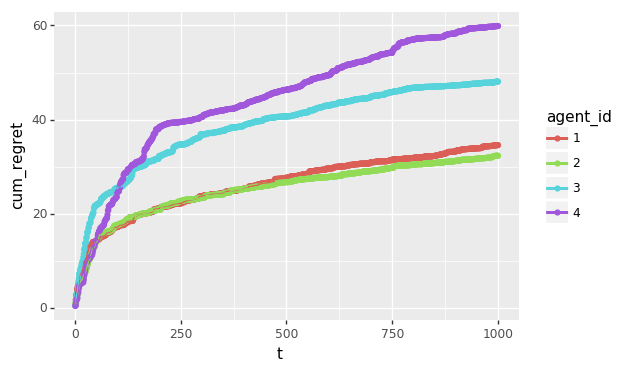

<ggplot: (8787424182353)>


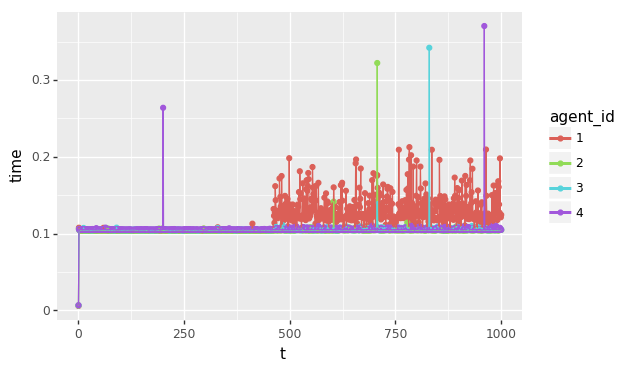

<ggplot: (8787424132469)>


In [9]:
plot_results(results)

In [10]:
results, cum_regrets = simple_compare([make_pgts_agent(),make_sagald_agent(), make_prec_sagald_agent_nowt(), make_prec_sagald_agent()], num_articles, dim, sparsity, 1000, seed=91, verbosity=1)

theta [-0.60612102 -1.05993975 -0.55091967 -0.27568627  1.22225373 -0.90585899
  0.06935217  2.17865566  0.14731691  0.51725713 -1.29397945 -1.0548876
  0.46476874  0.23410601  1.77886602  0.86387667 -0.02505936 -0.15748755
 -0.69803799 -0.17109056 -0.66477563]
Experiment: Step 0
 Sample: array([ 0.4069086 , -0.66559575,  0.70420242, -1.19472965, -0.68745079,
        1.45781671, -0.10055994,  0.25127425,  0.22675839, -1.32670927,
       -0.39560804, -0.17934096, -0.80176619,  1.15800719,  0.88340633,
       -0.63304348,  1.08046017, -0.67227637,  0.17390159,  0.23194091,
       -2.43413823])
 Sample: array([ 0.56349591, -0.84317054,  0.46633211, -0.10219626, -0.19858494,
        0.82760345, -0.00263897,  0.25520962, -0.41611404, -0.12258297,
       -2.00811208,  1.28863556,  0.22074159, -1.19372369,  0.88785407,
        0.66491217, -1.2092828 , -0.99436353,  0.22771244,  0.80804918,
       -1.25219393])
 Steps taken: 0
 Sample: array([ 1.25734242,  0.87035244,  0.1594317 , -0.34779687,

 Sample: array([ 0.15156439, -0.5484551 , -0.08537553, -1.07867283, -1.90229863,
       -0.71920671, -0.04729026,  0.51714845,  1.38950663, -0.45557842,
        0.58035735,  0.81480625, -1.49272757, -0.6457243 , -0.31914998,
        1.91336171, -0.25707704,  1.19821111, -0.39710233, -1.09940711,
        0.36987463])
 Steps taken: 950
 Sample: array([ 1.24100853,  0.53405066,  1.53800943, -0.75391478, -0.81576666,
       -0.07570594, -0.60912581, -0.19656607, -0.33480622, -0.56762314,
       -2.02583077,  0.84989118,  1.34035455, -0.61060297, -0.01077102,
       -0.40718426,  0.02126685,  0.17609409, -0.06632351, -0.15858156,
        0.48459407])
 Steps taken: 181
 Sample: array([-1.12865069, -0.21271133,  1.33242876, -0.87935631,  1.13146404,
        1.27543433,  1.3633788 , -0.1335478 ,  0.23197935,  0.08536267,
       -1.26601277,  1.73331621,  1.43794098, -1.20688468, -0.61520429,
       -0.65859247,  1.62800604,  0.41502118, -1.29387791,  0.28266893,
       -0.33755586])
 Steps tak

 Sample: array([-0.1068046 ,  0.57868222, -0.66535326, -0.38170276, -0.39129114,
        0.4594344 , -1.13346431, -0.72266102,  0.93117442,  0.41412237,
       -1.14386941, -0.31660667,  0.15219059, -0.35157295, -1.06600269,
        0.18823684, -1.7127744 ,  0.31124929,  0.61958866,  1.04567776,
        0.59909629])
 Steps taken: 174
Experiment: Step 13
 Steps taken: 337
 Sample: array([-0.87100503, -0.75188686,  0.19741825, -0.30855618,  1.1324106 ,
        0.25057291,  0.09523055,  1.20089774, -1.16536213,  1.11088516,
       -0.82783136, -0.31955742,  0.03464266,  0.09617412,  0.6151238 ,
        0.49490279, -0.49101529, -0.22156333, -0.04632222,  0.41461625,
        0.32664904])
 Sample: array([ 1.18201123,  0.01488134,  0.1785055 , -0.13094051,  0.31448772,
       -1.81925057, -1.45037501, -0.56907323,  0.6876797 , -0.45229186,
       -1.41313461,  0.39667417, -0.26514613,  1.03175454, -0.18946506,
        1.36090731,  0.22916349, -0.35777248, -0.74739419, -1.82295314,
       -1.0

 Sample: array([-0.05786982,  0.62213499,  0.14494746,  0.37650403, -0.86362167,
       -0.65260559, -0.28315963, -0.41994961,  0.4279295 ,  0.4981016 ,
       -0.69287639, -0.08468768, -0.33306782, -0.45774946,  0.22170738,
       -0.54897671, -1.45076692,  0.30835012,  0.10345597,  0.28712585,
       -0.94416091])
 Steps taken: 159
Experiment: Step 19
 Steps taken: 267
 Sample: array([ 0.52491775, -0.78958669, -0.28083991, -0.57106328, -0.90159164,
        1.33915854,  0.40771166,  2.70566539, -0.551768  , -0.52310626,
       -0.48855979, -0.83518115, -1.1580581 , -0.41878807,  1.58149501,
        0.6109946 , -0.46812223, -1.36610907, -1.42559104, -0.17286735,
       -1.81923682])
 Sample: array([ 0.57405399, -1.30675531, -0.14148231,  0.70203758, -0.70436624,
       -1.6098026 , -1.32843095,  0.28323938,  0.46169965,  0.63325971,
       -2.00874381, -0.92372501, -1.06444408,  0.3285484 ,  0.44640177,
        1.70664975,  0.6337211 ,  0.36360678, -1.50423796, -0.2227094 ,
       -2.0

 Sample: array([-0.72057604,  0.12090607, -0.86805647,  0.77995094,  0.20354154,
       -0.22164582,  0.08778919, -0.42521395,  0.55032301, -0.76314558,
       -0.67450994,  0.11561171,  0.19803593, -1.8482247 , -0.55035576,
       -0.28038793,  0.36576172, -0.48098744, -0.16666213,  0.61223742,
        0.03316989])
 Steps taken: 182
Experiment: Step 25
 Steps taken: 333
 Sample: array([-0.66305529, -0.65856125, -0.20011146, -0.47067962, -1.66362032,
        1.54264588, -0.7943881 ,  1.52614551,  0.3991338 ,  2.14647358,
        0.43254556, -1.48447757, -2.28245426, -0.492555  ,  1.00482864,
       -0.98598461, -1.22782148, -0.9683489 , -1.05149908, -0.17415365,
       -1.28577035])
 Sample: array([-0.56212848, -1.60591195,  1.1631464 ,  0.56673305,  0.16832001,
       -1.10382307, -1.65467975,  2.48054578, -0.44937009, -0.39942761,
       -0.93469985,  0.37606141,  0.68693422,  0.21565757, -0.38490399,
       -1.46160735,  0.17821415,  0.72930036, -0.03343492,  1.35001767,
        0.6

 Sample: array([-0.58802623,  0.1408686 ,  0.08956398, -0.63326116, -0.35284987,
        0.47683727, -0.09491497, -0.41021507,  0.06268232, -0.23939563,
       -0.42316459, -0.27917519,  0.36193521, -0.69035977, -1.31784256,
        0.2793652 , -0.36036191, -0.74836832,  0.05383528,  0.20718274,
        0.80738705])
 Steps taken: 173
Experiment: Step 31
 Steps taken: 316
 Sample: array([-0.84648042, -1.57476361,  0.29380343,  1.04569617,  0.43176435,
       -0.26040842, -0.49936155,  1.82566049,  1.12098953,  0.20865707,
       -1.65929838,  0.28039204, -0.78288496,  0.00982937, -0.38902766,
       -0.77967436,  0.46335038,  1.02798758,  0.12558602,  0.36192882,
       -3.18962211])
 Sample: array([ 0.55236184, -1.21323317,  0.60526174,  1.2483042 ,  2.23798254,
       -0.52342753,  0.29963498,  0.56980937, -0.8006444 ,  0.25678107,
       -1.44480575, -1.26925034,  0.48583289,  2.00627801, -0.52681147,
       -0.65947513, -1.37930506,  0.91720267, -1.1754236 ,  0.0738004 ,
       -1.2

 Sample: array([-0.60397469,  0.49935477,  0.2707224 , -0.4632189 , -0.33500916,
        0.2928526 , -0.50708814, -0.67420967,  0.14893437, -0.8559094 ,
        0.19608096, -0.75539837,  0.95746606, -0.22049949, -0.15716959,
        0.01080367, -0.15763556, -0.40592076, -0.69157124,  0.66944658,
       -0.36950665])
 Steps taken: 173
Experiment: Step 37
 Steps taken: 320
 Sample: array([-1.23217208, -1.57625189,  2.05404218,  1.12229978,  0.50355689,
        0.45921162, -1.20584325,  0.93193104,  1.245694  , -0.18456007,
       -0.57112331, -0.38382973,  0.96350062,  0.13122579, -0.48680878,
        0.11287364, -0.89233099,  0.66890458, -0.73003343,  0.83865216,
       -2.63929912])
 Sample: array([ 0.35490324, -1.0345614 ,  0.73315609, -2.49695943,  0.49635707,
       -1.69729231, -0.28365146,  1.95107802, -0.90474672, -1.34662745,
        0.21046501, -0.89992038, -0.89558022, -0.37384271, -0.60637033,
        0.60232268,  0.78868356,  0.15981054, -0.80428206,  0.78592323,
        0.4

 Sample: array([ 0.09968175, -0.26721085, -0.99242291, -0.78191083, -0.07127334,
       -0.53067035,  0.37673501,  0.19948337,  0.70433582, -0.73713375,
        0.52577333,  0.51004508,  1.08901017, -0.60533455, -0.28485004,
       -0.12967354, -0.28192199, -0.8664735 , -1.25811783,  0.50866845,
       -1.09977265])
 Steps taken: 169
Experiment: Step 43
 Steps taken: 316
 Sample: array([-1.27964622, -0.56314685, -0.70119319, -0.21988638,  0.53660049,
       -0.41745314,  0.24491015,  2.64980705, -0.29200858, -0.01299119,
       -0.13837041, -0.53508688, -1.96842698,  0.10651243, -0.30907802,
        1.53581434,  0.81421398,  0.59323314, -0.30110212,  0.75956368,
       -0.63449294])
 Sample: array([ 0.94447159, -1.57148201, -1.00518085, -1.13920268,  1.02077857,
       -1.23494513, -0.02816364,  0.98611938,  0.51290996, -1.07688159,
       -0.9775057 ,  0.01516614,  0.84623685, -0.00498811,  1.30328059,
        0.46446644, -0.95048757,  0.79144366,  0.30597891, -0.63064675,
       -0.5

 Sample: array([-1.18496167,  0.77110667,  0.48194781,  0.3492524 ,  0.96272766,
        0.10513947, -0.9677867 ,  1.40536554, -1.09916503,  0.13593205,
       -0.69822196, -0.58278455, -1.10374488,  0.79615119,  1.70020789,
        0.53993306, -0.02141441,  0.0021529 ,  0.19034935,  0.11794193,
       -1.71094703])
 Steps taken: 761
 Sample: array([ 1.6389896 , -1.47138295, -0.40477638, -0.09610307,  0.45956594,
        1.04022713, -0.51306258, -0.11584116,  0.40535838, -0.75691752,
        0.30296415, -1.49460029, -0.35192189,  0.34003103, -0.07152699,
       -0.00829358,  0.84211061, -1.11848808,  0.33041456, -0.0509853 ,
       -0.44232536])
 Steps taken: 171
 Sample: array([ 0.0402254 , -0.21848494, -1.391718  , -0.15737075,  1.337611  ,
        0.02439498, -1.3918667 , -0.77224149, -0.44001769, -1.06435492,
        0.17972718, -0.09282322, -0.00561125,  0.04211108,  0.67025766,
        0.73004756, -0.18377942, -0.48572436, -1.22880945,  1.38679433,
       -1.47186677])
 Steps tak

 Sample: array([-0.3367511 , -0.4992342 , -0.48135203, -0.04619417,  1.40984689,
        0.61632841, -1.05644833, -0.18386087, -0.69269929, -1.09608349,
        0.49892939, -0.56277877, -0.44914325,  0.50651141,  0.6999596 ,
        0.2530219 , -0.51997287,  0.134011  , -1.10055948,  0.94204676,
       -1.71731819])
 Steps taken: 169
Experiment: Step 56
 Steps taken: 309
 Sample: array([-0.71724599, -2.87716733,  0.73159256,  0.42400816, -0.32137189,
        0.49121912, -2.09934033,  1.89137411,  0.32250798, -1.24148301,
       -1.19640317, -0.5833371 ,  0.31044537, -1.32194865,  0.91124018,
        1.93535022,  1.08990241,  0.23599165,  1.1134038 ,  0.71549361,
       -1.48007123])
 Sample: array([ 0.52978613, -1.62547349,  0.16317703, -0.20932775,  0.39423399,
       -1.03536424, -0.50191444,  1.53025516, -1.15322997, -0.76716206,
       -2.47054464, -1.43690045,  0.32896495,  0.78445706,  1.02756534,
        0.70835494, -0.64730355, -1.02122649, -0.14314581,  0.32983906,
       -1.3

 Sample: array([ 0.2894972 , -1.33381572,  0.46218965, -0.59381555,  0.32067327,
       -2.08602125,  0.2715178 ,  0.45361592, -0.29841662, -0.18389993,
       -0.13131245, -0.75572895,  1.20903201,  1.03379856,  0.95707243,
       -0.59255841,  0.23611437, -0.05406688, -0.36830645, -1.20931878,
       -1.61018008])
 Steps taken: 708
 Sample: array([ 0.26242941, -1.29554208, -0.26987366,  0.71064895,  0.92092482,
       -0.48269816,  0.44082862,  0.4691286 ,  0.37150454, -0.19611395,
       -1.01076057, -0.80501692,  0.6660553 ,  0.69094426,  0.84409288,
        0.35448683,  0.32122034, -0.03555581,  0.10775316,  0.73779896,
       -0.6474669 ])
 Steps taken: 170
 Sample: array([ 0.05122778, -0.69208736, -0.80585515, -0.06558362,  0.92512429,
        1.08001227, -1.18468973,  0.24669116, -0.83757176, -0.84922856,
       -0.1961937 , -0.80326356, -0.58465428,  0.40365767,  1.03635159,
        0.56495576, -0.73367253, -0.32645626, -0.98675553,  0.49247234,
       -1.306613  ])
 Steps tak

 Sample: array([ 0.23255666, -1.4493572 , -0.3048223 , -0.50364262,  0.49027639,
        1.08385968, -1.15927603,  0.13812223, -0.83024128, -0.76483769,
       -0.83140853, -1.09708263, -0.12259852,  1.12018974,  0.9644967 ,
        0.73262098, -0.32752924, -0.29649724, -1.43509469,  0.57352863,
       -1.4705704 ])
 Steps taken: 151
Experiment: Step 69
 Steps taken: 297
 Sample: array([-1.19434122, -0.34302864,  0.67681306,  1.85286983,  0.78986632,
       -0.28572481, -0.41980476,  0.95233248,  0.58725893,  0.02393728,
        0.26838675, -0.42025843, -0.68754754,  0.0128247 ,  1.88274397,
        0.16862562, -0.65424194, -0.42330498, -0.43564208,  0.35314192,
       -1.66760917])
 Sample: array([-0.37242171, -0.91314605, -0.73825009, -1.34374481, -0.84631852,
       -1.77953884, -0.71599675,  1.81061645, -0.20465468, -1.04098882,
        0.31440986, -0.80500844,  0.80686551,  0.94120455,  1.33022316,
        1.12605218,  0.87741587, -0.87561772, -1.25569122, -0.02766057,
       -0.0

 Sample: array([ 9.87304906e-01, -1.21781474e+00, -1.26433774e-01, -1.07939124e+00,
        1.16805826e-03, -7.68258576e-01, -7.87192299e-01,  6.86634057e-01,
       -2.37785052e-02,  4.50241724e-01, -1.90141178e+00, -1.06367808e+00,
        2.63016405e-02, -3.05554990e-01,  9.02685940e-01, -1.72905465e-02,
        3.85150891e-01,  2.26586921e-01, -7.12246608e-01, -4.66988326e-01,
       -3.29390761e-01])
 Steps taken: 494
 Sample: array([ 0.11104985, -1.49588136, -0.04532188, -0.05810428,  0.753341  ,
       -0.8448753 , -0.51659012,  1.33543491,  1.05717839,  0.08905832,
       -1.21859325, -0.66770425, -0.19495402,  0.46845442,  1.16335903,
        0.47828297,  1.06284827,  0.32444247, -0.79244616,  0.85861603,
       -0.42300516])
 Steps taken: 152
 Sample: array([ 0.15184171, -1.85438057,  0.11608086, -1.07341855,  0.89635153,
        0.4542765 , -0.9776838 ,  0.28063089, -0.67200328, -0.37454642,
       -0.90475774, -0.69530237, -0.12329784,  0.84727798,  1.28568086,
        0.26

 Sample: array([-0.06751515, -0.89233011,  0.12751236,  0.00908318,  0.39733587,
       -1.64553463, -0.44957108,  1.46589605,  0.06563714,  0.7201411 ,
       -1.28830261, -1.00132461,  0.62237808, -0.36289498,  0.77861321,
        0.60325456,  0.40037686,  0.00330834, -0.53500604, -0.42160155,
       -0.90634183])
 Steps taken: 494
 Sample: array([ 0.94038845, -1.54282669, -0.56111211,  0.36830308,  1.00255775,
       -0.628929  , -1.1638125 ,  0.42319299,  1.02675056,  0.23403959,
       -1.05853772, -0.68062055, -0.37763731,  0.2668315 ,  1.23847125,
        0.33202321,  0.13618219,  0.12738487, -0.90398994, -0.06748471,
       -0.19451905])
 Steps taken: 156
 Sample: array([-0.44516795, -1.32421146, -0.15217183, -1.3330707 ,  0.96845607,
        0.66560734, -1.05649368,  0.9429295 , -0.41669727, -0.14060461,
       -0.73906775, -0.50284728, -0.60123022,  0.73121168,  1.49835247,
        0.70349609, -0.75484811,  0.30010009, -1.28971796, -0.0609191 ,
       -0.56619807])
 Steps tak

 Sample: array([ 0.28968041, -2.38314105,  0.31246005, -1.40004155,  1.07219274,
        0.28636833, -1.26405448,  1.54690403, -0.66082164, -0.07107877,
       -0.92761726, -0.01246025, -0.24956848,  0.78743466,  1.62003825,
        1.13206072, -1.48482149, -0.28111033, -1.32572397, -0.16798563,
       -0.98537942])
 Steps taken: 148
Experiment: Step 88
 Steps taken: 283
 Sample: array([-1.71574425, -1.31608568,  1.94141589,  1.26639496,  1.43158124,
       -0.03452774, -1.40393069,  0.2484695 ,  1.19372426, -0.77070188,
        0.16706234, -0.80995267,  0.69883439, -0.79569386,  1.93613334,
        0.80569806,  1.89264177, -0.57766144, -0.33685265,  0.68348586,
       -2.35657219])
 Sample: array([-0.09763061, -0.81684167, -0.01059192, -0.30536326, -0.11894352,
       -1.096882  ,  0.11836808,  1.22707146, -0.47304498, -0.20466361,
       -0.73156964, -1.11301846, -0.0745286 ,  0.45237645,  1.46757332,
        0.71107941,  1.24389445, -0.26852456, -0.99305678, -0.26760662,
       -0.2

 Sample: array([ 0.20492299, -1.64644779, -0.15477331, -1.08291824,  1.13549214,
        0.77070866, -1.39947562,  1.65567629, -0.50971587, -0.42767915,
       -0.60625556,  0.37970504, -0.54411649, -0.18825539,  1.26977321,
        0.85226722, -1.03007956, -0.07220403, -1.71852862, -0.11942507,
       -0.80104089])
 Steps taken: 154
Experiment: Step 94
 Steps taken: 282
 Sample: array([ 0.76204653, -1.17809387,  1.16457367,  0.67906341,  0.8584357 ,
       -0.22199542, -0.87998162,  1.11080437, -0.18843283, -1.34801223,
       -0.79357087, -1.07568679, -0.74886267, -0.32245346,  1.08355319,
       -0.00476316,  0.07562391, -0.5628521 , -1.42413674, -0.03841749,
        0.79183989])
 Sample: array([ 0.66273265, -1.63421969, -0.88150222, -0.75369034, -0.13794633,
       -1.37019141, -0.61155985,  1.16102616,  0.22553502, -0.19199912,
       -1.13168671, -0.18011921,  1.59944298,  0.21585439,  0.69039779,
        0.56104581,  0.90411338, -0.17281593, -1.04122961, -0.25565691,
       -0.6

 Sample: array([ 0.79476451, -1.4624106 , -0.64680798, -1.07489917,  0.47737803,
       -0.7263081 ,  0.13850161,  1.33155119, -0.27530406, -0.03990782,
       -0.44564418, -0.95490207,  1.56396781, -0.15061668,  0.04628449,
        0.50365539,  0.51178463,  0.46813639, -1.37988444, -1.74272055,
       -0.96752898])
 Steps taken: 487
 Sample: array([ 1.21964616, -1.54292199, -0.36970009,  0.46385699,  0.60407475,
       -0.11731338, -0.4385761 ,  0.44323954,  0.63088316,  0.34521239,
       -0.16034998, -0.93935755, -0.07181497,  0.08360657,  1.25449489,
        0.55948985, -0.67331867, -0.27998502, -1.67263622, -0.36567017,
       -0.29620232])
 Steps taken: 155
 Sample: array([-0.3081646 , -1.7348875 ,  0.30706768, -1.49025717,  1.5524515 ,
        1.00763131, -1.2174204 ,  1.93922689, -0.35488389, -0.55206663,
       -0.50519206,  0.31858115,  0.25464192,  0.01009296,  1.72926631,
        0.87099947, -0.92751995, -0.16559834, -1.5016982 , -0.54897682,
       -0.94967675])
 Steps tak

 Sample: array([-0.38110412, -1.50444866,  0.66300641, -1.26545959,  1.24130527,
        0.7211168 , -1.02565323,  2.03509063, -0.485542  , -0.47811276,
       -0.21298536,  0.33222922,  0.42522732, -0.18667027,  1.6882846 ,
        0.75424408, -1.23744124,  0.29647382, -1.25705309, -0.79256476,
       -1.27738466])
 Steps taken: 151
Experiment: Step 107
 Steps taken: 273
 Sample: array([-1.68532255, -0.73866524,  1.23111928,  0.78081603,  1.64356821,
       -0.77333935, -1.35792819,  1.54702612,  0.3107236 , -0.57623738,
       -0.24211525,  0.00398691, -0.79828049,  0.52848725,  1.76896282,
        1.06021317,  1.31442181,  0.6863774 ,  0.24143048, -0.31317782,
       -2.9892522 ])
 Sample: array([ 1.2686417 , -2.10054823, -0.44217214, -1.0199092 , -0.93597753,
       -1.03219912, -0.88108839,  2.1645762 , -0.85661857,  0.45968176,
       -0.10434401, -1.10157056,  0.87379423, -0.30443793,  0.24037156,
        0.27430048,  0.44369813,  0.18949488, -0.26191754, -1.2528301 ,
       -0.

 Sample: array([ 0.51938008, -0.97264666, -0.35232333, -0.7726404 , -0.58118874,
       -1.685548  , -1.00654996,  1.89037597, -1.00238329,  0.44462384,
       -1.15829242, -0.79420218, -0.084753  ,  0.48748859,  1.21721382,
        0.5416334 ,  0.33916861,  0.06925655, -0.28863783, -1.33002211,
        0.22386582])
 Steps taken: 491
 Sample: array([ 0.24637934, -1.5775097 , -0.37475606,  1.26347707,  1.20127073,
        0.12345205,  0.06628932,  1.19820447,  1.04985106,  0.57947427,
       -0.06192551, -0.34460065, -0.33587054,  0.62457107,  1.13114218,
        0.47222367, -0.7402315 , -1.22667417, -1.69542277, -0.58253614,
       -0.20927669])
 Steps taken: 153
 Sample: array([-0.23875106, -1.0348787 , -0.00444332, -1.53702531,  0.99547894,
        1.18698299, -0.93887361,  1.96246975, -0.79082025, -0.52745944,
        0.1896407 , -0.70629093,  0.34806613, -0.07966595,  1.26349122,
        0.82078275, -0.83474884,  0.57413191, -1.52506608,  0.04730658,
       -1.14153168])
 Steps tak

 Sample: array([-0.52565948, -0.77735802, -0.05247358, -1.39832445,  0.94334576,
        0.61913046, -1.21782501,  1.79443544, -0.20155395, -0.52397506,
        0.2313345 , -0.75553536,  0.44933209, -0.27676165,  2.13349673,
        0.86667299, -0.41133151,  0.5742581 , -1.12303195, -0.26540176,
       -1.09608868])
 Steps taken: 151
Experiment: Step 120
 Steps taken: 267
 Sample: array([-1.06924422, -1.1547104 ,  1.65423468,  0.58101992,  0.95327137,
       -0.53810607, -0.82220215,  1.9546007 ,  0.43269646, -0.33661988,
       -1.0259913 ,  0.54605362, -0.30326493, -0.60989313,  1.31022755,
        0.65201336,  0.72076165, -0.22058098,  0.177498  , -0.4638551 ,
       -3.18780243])
 Sample: array([-0.02679023, -1.65730779,  0.44680942, -0.61470416,  0.01895093,
       -0.34314415, -0.31272745,  1.69285829, -0.48283028,  0.51204064,
       -1.94077212, -1.18123327,  0.89434607, -0.03043039,  1.023935  ,
        0.61219679,  0.67664927, -0.4025068 , -0.56118881, -0.4375937 ,
       -0.

 Sample: array([-1.15332186, -1.12356311,  0.18384923, -0.99415859,  0.88894311,
        0.78885015, -0.46300284,  1.70026802, -0.63338042, -0.29961849,
       -0.05463032, -0.82555797,  0.31538737,  0.12412911,  2.19706103,
        1.31812938, -0.58875607,  0.26549123, -0.93245892,  0.55884699,
       -1.10472096])
 Steps taken: 155
Experiment: Step 126
 Steps taken: 264
 Sample: array([-1.483425  , -1.30599837, -0.07786112,  1.26209429,  1.29503667,
       -0.97323508, -0.6183476 ,  1.88917834,  0.76191548,  0.03824603,
       -0.87087781, -1.21073297,  0.37086625,  0.1571549 ,  0.89336112,
        0.12985817,  0.08954495,  0.68846215, -1.25093936, -0.02123928,
       -1.39854993])
 Sample: array([ 0.77376275, -0.95095967,  0.35457501,  0.0497121 , -1.00913283,
       -1.20771433, -0.75303511,  1.58230701, -0.19595545,  0.00680445,
       -0.9777185 , -1.87002161,  0.9194774 , -0.15944168,  0.52015341,
        0.41843499,  0.29194526,  0.19872533, -1.61868557, -0.47727667,
       -0.

 Sample: array([-0.6995963 , -0.93869012, -0.26503479, -0.47454589,  1.15223823,
        0.77793391, -0.5823913 ,  0.98680747, -0.83204253, -0.60078168,
       -0.35141497, -0.65137623, -0.19235748, -0.32308537,  2.10186557,
        1.41183605, -0.60804815,  0.53583228, -0.95979966,  0.38687802,
       -1.29837969])
 Steps taken: 153
Experiment: Step 132
 Steps taken: 258
 Sample: array([ 0.27029732, -0.80172016,  0.50117764,  0.41598861,  0.79564294,
       -0.69395092, -1.25517931,  0.63193832,  0.76196513, -0.1263889 ,
       -0.90579566, -0.8988165 ,  1.12372426,  0.01585477,  1.47433337,
       -0.29579572,  0.04949013,  0.14257585, -0.22084143, -0.19699251,
       -2.14925603])
 Sample: array([ 0.89658525, -1.11290861, -0.60149504, -1.19899273, -0.75819157,
       -0.73764181, -0.15819079,  1.88817447, -0.30543191, -0.251636  ,
       -1.4081832 , -0.84893158,  1.30343274,  0.09513232,  0.18202074,
        0.55755797,  0.60924388, -0.35593418, -0.88335198, -0.88276406,
       -0.

 Sample: array([ 0.72196809, -1.85350588, -0.28597323, -0.87751309, -0.52464119,
       -1.01483395, -0.42019128,  1.84650969, -0.70661213,  0.24020678,
       -0.75559313, -0.16528209,  0.9417426 ,  0.01713165,  1.15435475,
       -0.1115899 ,  0.36560505,  0.06609557, -1.4462521 , -0.34498593,
       -0.48084445])
 Steps taken: 491
 Sample: array([ 0.80692487, -2.29725287, -0.31354807, -0.028452  ,  1.07610222,
        0.33202532,  0.64059714,  0.63159126,  0.67038974,  0.27558708,
        0.390898  , -0.25924738, -0.35985102,  0.7713889 ,  1.07076958,
       -0.29310456,  0.01665116, -1.1046814 , -1.80622686, -0.31320886,
        0.67246363])
 Steps taken: 161
 Sample: array([-0.43572414, -1.32787914, -0.13946398, -0.38572901,  0.70678488,
        0.95373301, -0.67927903,  0.51064033, -0.50145005, -1.13584721,
       -0.53801287, -0.50104959, -0.23084584, -0.09046766,  1.60820431,
        1.59928715, -0.26121335,  0.37881472, -0.03118343,  0.28725335,
       -1.36541433])
 Steps tak

 Sample: array([ 0.73146794, -1.36532599,  0.18114182, -0.45665751,  0.33210798,
       -1.56275877, -1.05925955,  1.45690175,  0.40790618,  0.2247551 ,
       -1.42406464, -0.70340932,  1.02100485, -0.33360996,  0.2732083 ,
       -0.10596348,  0.70701673,  0.31125622, -1.09367551, -0.75558228,
       -0.68558437])
 Steps taken: 488
 Sample: array([ 0.17507262, -2.27141831,  0.03874639,  0.04839268,  0.90449611,
        0.51879163,  0.21772991,  1.01862616,  1.07552758,  0.92310515,
        0.32721488, -0.41750935, -0.2672716 ,  1.14971169,  1.44346292,
       -0.40071024,  0.14103227, -0.81459018, -1.95225704, -0.33036598,
        0.5034985 ])
 Steps taken: 157
 Sample: array([ 0.09159269, -1.24952911, -0.15557212, -0.66273172,  0.49275814,
        0.69839554, -0.71429161,  0.70418457, -0.81235392, -0.78828209,
       -0.47279519, -0.77123498,  0.16931443,  0.05851332,  1.88722912,
        1.4351445 , -0.30397146, -0.09110514, -0.47732483, -0.12853164,
       -1.39490331])
 Steps tak

 Sample: array([ 0.86299648, -1.67375829, -0.25162168, -0.73084959, -0.5338311 ,
       -0.29252184, -0.201666  ,  2.07678049,  0.27959014, -0.36219634,
       -0.88683327, -0.91109444,  1.4190245 , -0.89690317,  0.46190808,
        0.60274968,  0.2954256 , -0.10145259, -1.20682312, -0.52685049,
       -0.99329656])
 Steps taken: 490
 Sample: array([ 0.3681678 , -2.6027423 , -0.06493436,  0.33292835,  0.57241658,
        0.48814647,  0.34854158,  0.76869396,  0.64608403,  1.03617309,
       -0.48129739, -0.12726861, -0.02648827,  1.27938157,  1.3960714 ,
        0.42768847, -0.07295674, -0.77412559, -1.7158349 , -0.78641394,
        0.43226423])
 Steps taken: 156
 Sample: array([-0.00485123, -1.22705295, -0.62223488, -0.52059583,  0.90433315,
        0.88471302, -0.61667358,  1.07878905, -0.45168623, -0.28843607,
       -0.62900101, -0.59571357, -0.05083372,  0.28717867,  1.56762608,
        1.20020624, -0.08940648, -0.01531171, -0.730713  , -0.20889598,
       -1.34850628])
 Steps tak

 Sample: array([ 0.02472411, -1.14126482, -0.4777295 , -0.47266328,  1.22075985,
        0.50134031, -0.4846426 ,  1.29514441, -0.61661342, -0.24711819,
       -1.04256755, -0.69849969,  0.05463371,  0.00970256,  1.37486025,
        1.38939014,  0.01863899,  0.33751702, -1.02958238, -0.08813729,
       -0.97962858])
 Steps taken: 133
Experiment: Step 157
 Steps taken: 215
 Sample: array([ 0.17553024, -1.52458709,  0.69567796,  0.24214866,  0.7285504 ,
       -1.40453809, -0.75173766,  1.72493573, -0.13798087,  0.43057332,
       -1.18086852, -1.79421395,  2.02500519, -0.94486295,  2.09803262,
       -0.42840359, -0.21617716, -0.37874557, -1.0547626 , -0.26590153,
       -1.0997611 ])
 Sample: array([ 2.498599  , -2.83643154,  0.62575536, -1.16440912, -0.45353759,
       -1.04466642, -0.82662033,  1.45726421, -0.4571758 , -0.93257691,
       -1.22301464, -1.53879597,  1.00922836, -0.13253523,  0.25901013,
       -0.23776389,  0.54850758, -0.75286485, -1.01932607, -1.29206244,
       -0.

 Sample: array([-0.38245483, -1.15716945, -0.28054289, -0.56987755,  1.33471638,
        0.59616475, -0.19516939,  1.00726308, -0.2888214 , -0.57585985,
       -1.142097  , -0.530214  ,  0.40819382,  0.16490553,  1.61742037,
        1.45452816, -0.45413555,  0.36133561, -0.95106687,  0.19548599,
       -0.88748107])
 Steps taken: 154
Experiment: Step 163
 Steps taken: 242
 Sample: array([ 0.79058572, -0.73312516,  0.06197922,  0.5127725 ,  0.44033546,
       -0.9263654 , -0.21195254,  1.12175468,  0.35920118, -0.41179925,
       -0.80011166, -0.81045643,  0.84951651, -0.72751446,  1.41697639,
       -0.17496543,  0.06449331, -1.18768442, -0.23361143, -0.72160801,
       -1.81177038])
 Sample: array([-0.14273381, -2.41812272, -0.07808075, -0.86385934, -0.12940199,
       -0.28306542, -0.86345009,  2.10411357,  0.11530515, -0.02825291,
       -1.09114275, -1.59995064,  1.07553671, -0.12240467,  1.00271382,
        0.96552662,  0.80669473,  0.63585953, -1.44234426, -0.91676595,
       -0.

 Sample: array([-0.05437951, -2.02897107,  0.14337341, -0.71277279,  1.06106183,
       -1.39836825, -0.81752654,  2.56680249, -0.60759068,  0.2367502 ,
       -2.12318478, -0.93568061,  1.10639162,  0.27500236,  0.39693601,
        0.45874751,  0.55917481,  0.22036902, -1.08883318, -0.91268913,
       -0.57003235])
 Steps taken: 485
 Sample: array([ 1.01230203, -1.87057434, -0.00475806,  0.84048695,  0.72840584,
       -0.48236044, -0.20355817,  0.7782063 ,  0.16381751,  1.93357763,
       -0.83042113, -0.83816295, -0.02626351,  0.53561432,  1.47533596,
        0.76528519, -0.11459702, -1.22971633, -1.98228295, -0.16741285,
       -0.45325774])
 Steps taken: 156
 Sample: array([-1.16991082e-03, -1.01506054e+00, -3.36035151e-01, -6.68049227e-01,
        7.31767189e-01,  3.39157144e-01, -5.83098041e-01,  7.63782984e-01,
       -7.07755681e-01, -3.88697095e-01, -9.82001466e-01, -7.04758548e-01,
        4.50364991e-01,  3.37069031e-02,  1.58545878e+00,  1.50517445e+00,
       -5.77838660e

 Sample: array([ 0.94980732, -0.8046635 ,  0.21361037,  0.44268272, -0.32785755,
       -0.88373155, -0.99510689,  1.42439525, -0.42902086,  0.31508104,
       -2.17210322, -1.7516077 ,  0.35445998, -0.07692992,  1.12419639,
        0.47003595,  0.97119552,  0.7708434 , -1.85795051, -0.76601321,
       -1.31211195])
 Steps taken: 422
 Sample: array([ 1.00536175, -1.80289795,  0.03809422,  0.49686353,  1.10419975,
       -0.54141872, -0.13531874,  0.89396131,  0.06634119,  1.58661081,
       -0.74524437, -0.70887404, -0.33838622,  0.36784214,  1.11726363,
        0.65184146,  0.11148724, -1.05808514, -1.63586944, -0.39858092,
        0.00197241])
 Steps taken: 134
 Sample: array([-0.20880169, -1.1861966 , -0.27792941, -0.54164876,  0.29362527,
        0.28646606, -0.6629375 ,  1.25814453, -0.5724008 , -0.35026179,
       -0.85776227, -0.49293656,  0.41213587, -0.43907844,  1.80383725,
        1.37590333,  0.56329547,  0.20184752, -1.36620609,  0.63905562,
       -0.71881382])
 Steps tak

 Sample: array([-0.44332299, -1.07587394, -0.05917373, -0.66484843,  0.45623562,
       -0.11601061, -0.74129215,  1.5710093 , -0.30957033, -0.37672091,
       -1.0760543 , -0.50099698,  0.5187541 , -0.02219431,  1.80155144,
        1.21006121,  0.5004182 ,  0.43475582, -0.93001449,  0.38459139,
       -0.46855996])
 Steps taken: 156
Experiment: Step 182
 Steps taken: 234
 Sample: array([-0.1361778 , -0.18443685,  0.92053601,  0.0823962 ,  0.65874053,
       -0.38919423, -0.8350765 ,  1.50568747,  0.34644603, -0.71855335,
       -1.60234573, -1.70597074, -0.30705481, -0.2699255 ,  1.75313283,
        0.13241077, -0.20179651, -0.11957152, -0.68448275, -0.09546828,
       -0.93989999])
 Sample: array([ 0.31916874, -2.45709098,  0.40597777, -0.55022656,  0.21435976,
        0.29533744, -0.90441419,  1.56194678,  0.09717757,  0.69719384,
       -0.93309615, -0.72669002,  0.84146584,  0.03602601,  0.49257287,
        0.44547132,  0.40290342,  0.29922712, -1.25318611, -0.53868573,
       -0.

 Sample: array([ 0.46566669, -2.09050805, -0.25720104, -1.28640169, -0.02123075,
       -0.54635305, -1.2317379 ,  2.0236899 ,  0.04077606,  0.32344121,
       -0.87124739, -1.66753792,  1.00630016, -0.65696037,  0.99218965,
        0.59601455,  0.59117563,  0.55220338, -0.2837199 , -0.36657476,
       -0.59485802])
 Steps taken: 481
 Sample: array([ 1.42110352, -0.86179054,  0.60086354,  0.06486741,  0.61558454,
       -0.37901099, -1.07783294,  1.09950084, -0.01181116,  0.79065651,
       -1.08498728, -0.84903609,  0.4625721 , -0.05251104,  0.93984076,
        0.46265592, -0.36541039, -0.86768889, -1.49318616, -0.62163332,
        0.08287814])
 Steps taken: 157
 Sample: array([ 0.11981287, -0.97102653, -0.26169315, -0.37131398,  0.4650933 ,
        0.23984183, -0.8906605 ,  0.92410085, -0.22777652, -0.6729969 ,
       -1.53383015, -0.9327413 ,  0.61086903,  0.09958206,  1.28901821,
        1.48442294,  0.42679813,  0.25349026, -1.17881977,  0.13798714,
       -0.68439419])
 Steps tak

 Sample: array([ 0.00411878, -2.37760047, -0.19137277, -1.2987811 ,  0.78551291,
       -1.14755183, -0.64788372,  2.56764454, -0.08682734,  0.26292902,
       -2.13476235, -1.18918995,  0.87015506, -0.63212894,  0.82712125,
        0.61974675,  0.18319397,  0.48000713, -1.19935485, -0.76253299,
       -0.60332272])
 Steps taken: 478
 Sample: array([ 1.33283933, -0.40920297,  0.28581172,  0.21935944,  0.28571237,
       -0.37216316, -1.27934061,  1.40269042,  0.63149121,  0.33431814,
       -1.41350543, -0.6739057 ,  0.28699611,  0.23306816,  1.19160594,
        0.72373508, -0.06005267, -0.98102574, -1.93377283, -0.44604833,
        0.10292662])
 Steps taken: 159
 Sample: array([ 0.03154197, -0.99745523, -0.13614729, -0.11265747,  0.39340005,
        0.31814041, -1.00772397,  1.0150464 , -0.2202122 , -0.45273853,
       -1.41505564, -1.08958221,  0.47878565,  0.13005798,  1.38262316,
        1.3842187 , -0.17589538,  0.36471288, -0.87947112,  0.26018077,
       -0.67235494])
 Steps tak

 Sample: array([-0.04585467, -1.02403169, -0.22432681, -0.10302456,  0.46336531,
        0.40930661, -1.12593105,  1.45077234, -0.33177666, -0.62283176,
       -1.38580613, -1.17734354,  0.15121265,  0.30885432,  1.46011263,
        1.27106968, -0.06382125,  0.36365597, -1.13700928,  0.57283229,
       -0.48984017])
 Steps taken: 150
Experiment: Step 201
 Steps taken: 225
 Sample: array([-2.24827874, -0.11845952,  0.16414415,  0.27311209,  1.34828553,
       -0.49173135, -0.06894798,  1.81173532,  0.96267972, -0.35157997,
       -1.2787105 , -1.21825584,  0.88853469, -0.20667893,  2.05965026,
        0.8064033 ,  0.20586891,  0.37393137, -0.20258709,  0.33910492,
       -1.30336838])
 Sample: array([-0.05776648, -2.67216913, -0.18055488, -0.83808833,  0.03581607,
       -1.45221724, -1.40282866,  2.01023184, -0.32792304, -0.08059912,
       -1.00282032, -0.89879232,  0.92824442,  0.40051451,  1.12159505,
        1.0490072 ,  0.62181023,  0.35641431, -1.04264292, -0.68778692,
       -0.

 Sample: array([ 0.08318965, -1.32675595,  0.07094987, -0.45560647,  0.46794421,
        0.66571324, -1.11988058,  1.32469477, -0.33537689, -0.59963185,
       -1.39440379, -0.97754377, -0.02450501, -0.02916686,  1.50486491,
        1.21563623, -0.105506  ,  0.47654226, -0.55204798,  0.17341128,
       -0.46406226])
 Steps taken: 152
Experiment: Step 207
 Steps taken: 224
 Sample: array([ 0.60965625, -1.5626247 , -0.39696298,  1.14260956,  1.25330198,
       -0.73509873,  0.20636125,  1.50488601,  0.13852282, -0.49510109,
       -0.99054031, -0.44046384,  0.28613217, -0.29757533,  1.12541457,
        0.69218093, -0.12470571, -0.88943945, -1.26137321,  0.02926588,
       -1.88567684])
 Sample: array([-0.03506626, -2.14970986,  0.05000379, -1.78486627,  0.06361037,
       -0.10242739, -1.78450501,  2.46284864,  0.0322236 ,  0.40080706,
       -1.52110184, -1.01224432,  1.20371345,  0.17001445,  1.28192857,
        0.45580179,  0.06681553,  0.70999222, -1.55673036, -0.93576381,
       -0.

 Sample: array([ 0.37802179, -1.6027417 , -0.31296108, -0.79368647,  0.0203857 ,
        0.46180737, -0.2336428 ,  1.65939536, -0.69622022, -0.6856443 ,
       -1.26147352, -1.74575835,  0.48782625,  0.13111652,  1.181326  ,
        1.12654871,  0.86706712,  0.20476612, -0.58529098, -0.35837984,
       -1.52889331])
 Steps taken: 483
 Sample: array([ 1.78098532, -1.17968671,  0.70532806, -0.52560019,  1.16437243,
       -0.66836453, -1.41090035,  1.58105957,  0.50932534,  0.04630807,
       -1.17606989, -0.44303816,  0.02931828,  0.34057475,  0.81169643,
        0.34333088, -0.12095881, -0.78578612, -1.93472421, -0.68840549,
       -0.75697383])
 Steps taken: 157
 Sample: array([-0.12305215, -1.19837498, -0.23833083, -0.42413704,  0.06007316,
        0.53280415, -0.88257299,  1.66458411, -0.77881193, -0.61814261,
       -1.51689366, -0.91221191, -0.44225829,  0.37154409,  1.57480755,
        1.69583043,  0.1226055 ,  0.40431728, -0.08705752,  0.31325602,
       -0.80781289])
 Steps tak

 Sample: array([ 1.12136396, -1.20465327,  0.02554246, -0.12786791, -0.09840701,
       -0.06670692, -1.08177643,  0.74906842, -0.30675275, -0.1589752 ,
       -1.09861222, -0.77248877,  0.67199915, -0.17294017,  1.04539303,
        0.21278781,  0.6019458 ,  0.88388798, -1.1690451 , -1.32852433,
       -0.92578963])
 Steps taken: 480
 Sample: array([ 1.53001698, -0.8059547 ,  0.75330835, -0.56250189,  1.15912173,
       -1.09169145, -1.53975003,  1.45264676,  0.63464302,  0.35121475,
       -1.15991948, -0.66032744,  0.34971384,  0.10995296,  0.879458  ,
        0.43931049,  0.24783674, -0.47776262, -1.88148459, -0.60213742,
       -0.35752303])
 Steps taken: 155
 Sample: array([-0.10545029, -1.20021267, -0.45240372, -0.42405458,  0.32444781,
        0.49056635, -1.13263354,  1.40333387, -0.6319692 , -0.95016834,
       -1.59595236, -0.98949147, -0.32614885,  0.07785475,  1.68040404,
        1.48254459,  0.29551007,  0.77498242,  0.07121166,  0.48717215,
       -0.92007087])
 Steps tak

 Sample: array([-0.15961913, -1.42755488, -0.35526312, -0.45012979,  0.62802209,
        0.35728944, -0.56449603,  1.3488452 , -0.65938948, -0.96566269,
       -1.67158199, -1.01631746, -0.24739721,  0.12971983,  1.46358541,
        1.15150774, -0.09456988,  0.71660732,  0.00473123,  0.63756416,
       -0.79372118])
 Steps taken: 152
Experiment: Step 226
 Steps taken: 214
 Sample: array([ 0.23541346, -1.15732576, -0.13120806, -0.53695981,  0.84731206,
       -0.35564789, -0.34027939,  1.8746054 ,  0.56213509,  0.19631615,
       -0.75219284, -0.61018675, -0.22403521, -0.23668497,  1.04051744,
        0.92853212,  0.13953752, -0.08780078, -0.47928803, -0.16029412,
       -1.44039392])
 Sample: array([-1.31682928, -1.81165915,  0.2381485 , -0.82248707, -0.00998777,
       -0.63090841, -0.47993426,  2.65632553, -0.19022526,  0.15118294,
       -0.40440971, -1.06247109,  0.97735462,  0.02993382,  1.86682139,
        0.8973185 ,  0.89519837,  0.33784394, -0.74830482, -0.18775128,
       -0.

 Sample: array([-0.34162882, -1.20511318, -0.17957113, -0.25478385,  0.69256723,
        0.43765016, -0.86309904,  1.07881283, -1.34347872, -0.68152627,
       -1.95340149, -0.7509748 ,  0.16795168,  0.53327023,  1.66968968,
        1.08543667, -0.62057088,  0.65200424, -0.38650049,  0.6253513 ,
       -0.99559432])
 Steps taken: 157
Experiment: Step 232
 Steps taken: 214
 Sample: array([-0.78316837, -0.02851963,  0.03232915,  0.04893381,  0.67272938,
       -0.20859299, -0.93683634,  1.41518134,  1.52459923, -1.08576186,
       -1.14133515,  0.41791445,  0.3239522 , -0.28550484,  1.60518929,
        0.6406538 , -0.35742752, -0.13332495, -0.88153507,  0.45285604,
       -2.57249424])
 Sample: array([-0.75652342, -1.56964869, -0.23023454, -0.36713239,  0.38723548,
       -0.45693981, -0.61832586,  1.73361613, -0.03011212,  0.45391447,
       -0.70772964, -1.6039409 ,  0.53431127,  0.62555948,  1.60003262,
        0.96974031,  0.91063761,  0.65824915, -0.95096132, -0.34202381,
       -0.

 Sample: array([-0.64027475, -0.94990212, -0.14142015, -0.18077695,  1.21871862,
        0.57054665, -0.83140371,  1.35280238, -1.41649861, -0.79442491,
       -1.86333867, -0.49352326,  0.35234347,  0.4583378 ,  1.83540399,
        0.90184876, -0.49743812,  0.65079405, -0.72792126,  0.32458428,
       -0.8197569 ])
 Steps taken: 151
Experiment: Step 238
 Steps taken: 210
 Sample: array([-1.54470767, -0.45446691,  0.48199892,  0.31385168,  0.39468099,
       -0.337985  , -0.23726806,  1.77930268,  0.65605662, -0.2197624 ,
       -0.89631268, -0.52270025,  1.07670225,  0.37618715,  1.93151371,
        0.90358332, -0.54608035,  0.6174327 , -1.02470604,  0.32357457,
       -0.86808006])
 Sample: array([-0.25220301, -1.61687805,  0.53675448, -0.54421203,  0.24254757,
       -0.81972529,  0.22684208,  2.43110731, -0.59304394,  0.24589705,
       -0.49968047, -1.68175678,  0.39195087,  0.12821865,  0.9589757 ,
        0.73046662,  0.84239731,  0.08248041, -1.33934651, -1.29603672,
       -0.

 Sample: array([-0.79864471, -0.79762204,  0.2956359 , -0.26473469,  1.43391624,
        0.64820519, -1.09712924,  1.34631363, -1.22179309, -0.92591425,
       -1.75846093, -0.78356428,  0.76021661,  0.49858105,  1.79769686,
        1.41976101, -0.35876548,  0.79021303, -1.01463355,  0.01377138,
       -1.07105058])
 Steps taken: 155
Experiment: Step 244
 Steps taken: 208
 Sample: array([-1.66662783, -0.55292774,  0.35163826,  0.33435604,  1.15774489,
       -1.32312192,  0.05965528,  1.51964362,  1.20115616,  0.40257665,
       -1.77690918, -1.82913805, -0.13726265, -0.42381352,  2.55874408,
        0.42299121,  0.05010593,  0.54472182, -0.7819776 ,  0.2982631 ,
       -1.47227723])
 Sample: array([ 0.12045821, -0.90689616, -0.29900616, -0.59706184,  0.06912396,
       -0.64097994,  0.00930061,  2.02345931,  0.54690249, -0.26224544,
       -1.87013674, -1.78744862,  0.20861407, -0.15921239,  1.57341   ,
        0.64571286,  0.78343025,  0.26126798, -0.52177698, -0.82557281,
       -0.

 Sample: array([-0.7200302 , -0.75217792,  0.17519363, -0.53180501,  1.61270248,
        0.60248168, -0.94096936,  1.68172801, -1.41306724, -0.81837442,
       -1.73775913, -0.35764862,  0.89424781,  0.35655107,  1.26901916,
        1.30603105, -0.13362461,  1.12883005, -1.28195274, -0.01233628,
       -0.90528619])
 Steps taken: 152
Experiment: Step 250
 Steps taken: 204
 Sample: array([-1.36026832, -0.07937123, -0.13806185,  0.26378302,  0.91010332,
       -1.57751568, -0.03938844,  1.6444812 ,  0.88910172, -0.29834357,
       -0.79635131, -0.98599774, -0.39304912,  0.3159226 ,  2.63966562,
        0.46140527,  0.23167506,  0.89611212, -0.74781257, -0.38529296,
       -1.1839954 ])
 Sample: array([ 0.42325724, -1.69228233, -0.35460394, -0.50393232,  0.4163394 ,
       -0.43392758, -0.84753757,  1.1792161 , -0.5003514 , -0.74334256,
       -0.99453598, -0.88665572,  1.2353057 , -0.0441462 ,  0.78980568,
        0.99592549,  0.64041213,  0.18851837, -0.76843292, -0.34511386,
       -0.

 Sample: array([-0.61613018, -1.09609401,  0.15158343, -0.26527753,  1.59402931,
        0.5877419 , -1.13523035,  1.3278037 , -1.41664828, -0.8997106 ,
       -1.99765403, -0.32886054,  0.69897326,  0.53914861,  1.71948571,
        1.33534513,  0.0078625 ,  0.99139908, -1.6296735 ,  0.00476853,
       -0.58983142])
 Steps taken: 141
Experiment: Step 256
 Steps taken: 193
 Sample: array([ 0.79755455, -0.39903355, -0.36865327,  0.56821583,  0.78936285,
       -1.35302084, -0.34299683,  1.2369374 ,  1.53766772, -1.2750752 ,
       -1.35493076, -0.38010966,  0.13644792,  0.32342987,  1.78112111,
        0.36669043, -0.11936466, -0.62787103, -1.06005131, -0.37748226,
       -1.99235629])
 Sample: array([-0.08148557, -2.13099506, -0.05440096, -0.59198929,  0.06111794,
       -0.48508291, -0.70470698,  1.6892094 , -0.28539411, -0.03737727,
       -1.15726266, -1.08044251,  1.13280208, -0.08530637,  1.23805961,
        1.11165201,  0.66779021,  0.29211588, -0.74005272, -0.20374255,
       -0.

 Sample: array([-0.31497226, -1.07485876,  0.06336348, -0.44690962,  1.4534469 ,
        0.56364025, -1.08072405,  1.04668845, -1.60886908, -0.82304263,
       -1.88073699, -0.33026738,  0.50218759,  0.23758164,  1.80766178,
        1.52755229, -0.17566135,  0.79172341, -1.31292805,  0.12353884,
       -0.58911526])
 Steps taken: 145
Experiment: Step 262
 Steps taken: 185
 Sample: array([-0.64048501,  0.18857746, -0.4779893 , -0.23024983,  0.67036762,
       -0.9984812 ,  0.14639211,  2.33903969,  1.10647283, -0.42905735,
       -1.12193585, -1.71096233, -0.09841841,  0.27757624,  1.85051704,
        0.93830434,  0.25556617, -0.6714708 , -1.50689296,  0.28208933,
       -0.60123351])
 Sample: array([ 1.57968131, -0.98263656, -1.05537504, -0.78387667, -0.10735304,
       -0.35079852, -1.12141468,  1.21073337, -0.16771278, -0.06185254,
       -1.6850547 , -1.65126617,  0.86040979,  0.15116003,  0.33333576,
        0.29189196,  0.7912884 ,  0.05119341, -1.62336032, -0.99755634,
       -0.

 Sample: array([ 0.16324785, -1.23550943, -0.4589344 , -1.13121397, -0.01301737,
       -0.68379251, -0.96375524,  2.41815711,  0.4622812 , -0.43690613,
       -1.91852146, -1.23044037,  0.51955278,  0.4254757 ,  1.21317415,
        0.73160054,  0.7362166 , -0.208755  , -0.79264325, -1.35328006,
       -1.14742076])
 Steps taken: 457
 Sample: array([ 0.83665178, -1.31607953,  0.39179689, -0.07761529,  1.78899589,
       -0.52702411, -1.05800331,  1.59715588,  0.64769829,  0.25368305,
       -1.3131706 , -0.52388011, -0.65992103, -0.18540855,  0.81177071,
        0.22229277,  0.0937647 , -0.30400437, -1.05192515, -0.26997991,
       -0.13470271])
 Steps taken: 152
 Sample: array([ 0.10848701, -1.31252767,  0.21245889, -0.49548033,  1.35637799,
        0.49908088, -1.19836909,  0.77064563, -1.58122486, -1.04182316,
       -2.05533515, -0.20199475,  0.34151913, -0.01142568,  1.1858427 ,
        1.18447155, -0.27773044,  0.78510985, -1.28447414,  0.18918809,
       -0.32366431])
 Steps tak

 Sample: array([ 0.05596268, -1.81934674, -0.72969565, -0.90787747, -0.4273288 ,
       -0.45949132, -1.08159015,  2.26376588, -0.52324718,  0.44396061,
       -0.02319652, -1.30473867,  0.36291109,  0.5781504 ,  1.23193989,
        1.17485196, -0.03997046,  0.45629022, -0.8833248 , -1.08479983,
        0.11455009])
 Steps taken: 472
 Sample: array([ 0.61845141, -1.34776069,  0.56098198, -0.10265975,  1.46010065,
       -0.76054848, -0.69533081,  1.65975016,  0.96235478,  0.30985927,
       -1.08773017, -0.4836132 , -0.16412958, -0.20032346,  0.61782346,
        0.4148923 ,  0.06483276, -0.54366202, -1.1536869 , -0.21200793,
       -0.25461509])
 Steps taken: 154
 Sample: array([-0.28324999, -1.36181489,  0.37565892, -0.3747884 ,  1.37500888,
        0.80599012, -1.12419249,  0.48839907, -1.27026852, -0.7976404 ,
       -1.78745563, -0.57668532,  0.00688695,  0.3589512 ,  1.59119225,
        1.41585841, -0.45108226,  0.60439901, -1.07935441,  0.26072958,
       -0.07038714])
 Steps tak

 Sample: array([-0.70239718, -1.30966971,  0.08909594, -0.11021863,  1.72825783,
        0.44979889, -0.86267605,  1.15058885, -1.37604649, -0.9393822 ,
       -1.17390646, -0.74325683, -0.00215087,  0.22455805,  1.39268787,
        1.33117958, -0.23682825,  0.49672139, -0.95219234,  0.44344905,
        0.14345504])
 Steps taken: 149
Experiment: Step 281
 Steps taken: 195
 Sample: array([-2.01210625, -0.46498514,  0.60237187,  0.60937655,  1.4305703 ,
       -0.66371641,  0.56419322,  2.28821993,  1.13093176, -0.22664734,
       -1.69528063, -1.05763568,  0.35202668,  0.04273172,  2.21184611,
       -0.24520866,  0.4019525 ,  0.26872798, -0.90798203, -0.19289313,
       -1.18629311])
 Sample: array([ 0.44598139, -2.83364079, -0.39846425, -0.5797407 ,  0.00500707,
       -0.4100739 , -0.93140937,  1.87619886,  0.04220053,  0.19746167,
       -0.79696142, -0.36975971,  0.48001018, -0.26523589,  0.97619611,
        0.82816823,  1.1210544 , -0.36731626, -0.96830694, -0.85627027,
       -0.

 Sample: array([-0.45232002, -1.19665506,  0.47420697, -0.06272357,  1.40875105,
        0.55143052, -0.80272757,  0.99153064, -1.55485059, -0.81475219,
       -0.99969109, -0.44348859,  0.2315371 , -0.15797421,  1.20116239,
        1.29079884, -0.20251966,  0.26174842, -1.3066126 ,  0.19918672,
       -0.12381578])
 Steps taken: 152
Experiment: Step 287
 Steps taken: 194
 Sample: array([-0.56795975, -0.24587009, -0.05262441, -0.41590896,  1.14211001,
       -1.41573367,  0.35994982,  1.90813438,  0.35830361, -0.59807614,
       -1.19779132, -1.16707345, -0.04857039,  0.45679996,  1.64761711,
        0.10644632,  0.66210014,  0.22310474, -0.57981349,  0.06775621,
       -1.81917039])
 Sample: array([ 0.34680769, -1.33143119, -0.11152551, -0.45539315, -0.53520716,
       -0.58302321, -0.79893547,  2.03973638, -0.13684462, -0.40477638,
       -2.03220231, -1.11218019,  0.76570002, -0.26764585,  1.1654662 ,
        0.75023171,  0.37437789,  0.7750593 , -0.94116364, -1.13858565,
       -0.

 Sample: array([-8.68805936e-01, -1.03873953e+00,  2.40633745e-01, -1.25653271e-01,
        1.79393028e+00,  9.03729374e-01, -7.21132609e-01,  1.28231299e+00,
       -1.60048228e+00, -4.42469295e-01, -1.23300203e+00, -8.91658964e-01,
        2.86385993e-01, -1.09706177e-05,  1.62597475e+00,  1.15923729e+00,
       -7.72829081e-02,  5.13887735e-01, -1.31032888e+00,  5.45570977e-02,
       -3.31667668e-01])
 Steps taken: 147
Experiment: Step 293
 Steps taken: 192
 Sample: array([-0.93131874, -0.18012048,  0.63519086,  0.71437557,  0.6898655 ,
        0.1059571 ,  1.1156199 ,  2.0518271 ,  0.98750788, -0.90063312,
       -1.51923071, -0.2177614 ,  0.4741476 ,  0.59224554,  1.30255748,
        0.24410215, -0.33363424, -0.04959532, -1.55089395, -0.14203357,
       -0.5506696 ])
 Sample: array([ 0.32758825, -1.78894975,  0.34711809, -0.62887929,  0.09923762,
       -1.24078499, -1.41172588,  2.28107654,  0.27877213, -0.61928854,
       -1.31947044, -2.16013081,  0.32546447, -0.03422788,  1.1

 Sample: array([-1.20265547, -0.99187323, -0.13269477,  0.06946875,  1.6975409 ,
        0.80317132, -0.83104023,  1.62550322, -1.35369699, -0.2069603 ,
       -1.25367677, -0.90275952,  0.62288871,  0.14223636,  1.59765283,
        1.10081267,  0.11653739,  0.13960419, -1.30323406,  0.62358939,
       -0.25693577])
 Steps taken: 151
Experiment: Step 299
 Steps taken: 193
 Sample: array([ 0.0763796 , -0.79676966,  0.80715509,  0.26200893,  0.71803585,
       -0.58981664, -0.24207058,  1.56611302,  0.07111061, -1.00223487,
       -1.84293319, -1.14233231,  0.16921718, -0.33812731,  2.21537974,
        0.33623092, -0.25086396, -0.11663711, -1.02082607,  0.44199403,
       -1.18786388])
 Sample: array([-0.68878082, -1.5585434 , -0.30799479, -0.70083415, -0.2219765 ,
       -0.27895881, -0.5513877 ,  2.22975212, -0.0578478 , -0.2055812 ,
       -1.50657318, -1.03060187,  0.95652229,  0.77488324,  1.26554593,
        1.03784345,  1.16011754,  0.64154083, -1.26434326, -0.5020705 ,
       -0.

 Sample: array([-1.05915896, -1.20999308,  0.00269233, -0.02481067,  1.67839995,
        0.78434603, -0.67241928,  1.2219161 , -1.22476507, -0.34731168,
       -0.92450832, -0.84326732,  0.48052982,  0.07444027,  1.4695837 ,
        1.10569257,  0.04527563,  0.16009778, -1.42749069,  0.28862155,
        0.01836901])
 Steps taken: 142
Experiment: Step 305
 Steps taken: 189
 Sample: array([-0.56505956, -0.85265901,  0.03358891,  0.07051349,  1.03358128,
       -0.733156  ,  0.27334284,  1.46006742,  0.95696461, -0.53004336,
       -1.11746289, -1.15247   ,  0.91008133,  0.71013655,  1.59855997,
        0.29064035,  0.25763644, -0.15097149, -0.83810578, -0.47978626,
       -1.04945097])
 Sample: array([ 0.00509714, -1.91180299, -0.56102646, -0.82846556,  0.03908634,
       -0.56684252, -0.65908597,  2.03722466,  0.90699233, -0.48283424,
       -1.01207434, -0.89069225,  1.25756609, -0.32563992,  1.52468807,
        1.04019021,  0.3902903 ,  0.40638956, -0.75679652, -1.03190468,
       -1.

 Sample: array([-0.8958849 , -1.25961771, -0.19694103, -0.44829871,  1.75077837,
        0.77244365, -0.61032377,  1.51754695, -1.22799531, -0.55853666,
       -1.02313154, -1.26205679,  0.31772415,  0.54413605,  1.70278926,
        1.15587448,  0.13826128, -0.03292958, -1.31258258,  0.06907814,
       -0.16505608])
 Steps taken: 150
Experiment: Step 311
 Steps taken: 187
 Sample: array([-0.1465917 , -0.42723503,  0.06960316,  0.15734053,  0.71229588,
       -1.64280195, -1.24426986,  2.05430666,  0.36331294, -0.44524817,
       -1.54212796, -0.8663753 ,  0.2303176 ,  1.10933463,  1.5970996 ,
       -0.18620787, -0.71711879,  0.80055739, -1.24017619,  0.6007929 ,
       -1.13869063])
 Sample: array([ 4.51942126e-01, -1.10546853e+00, -4.89773635e-01, -9.12131504e-01,
        2.57149643e-02, -5.29285233e-01, -1.75130227e-01,  1.75387364e+00,
       -1.89610548e-02, -3.92122417e-01, -7.03534994e-01, -1.40376405e+00,
        5.90955297e-01, -3.70106976e-01,  1.27030573e+00,  1.07629071e+00

 Sample: array([-0.98185399, -1.13759112, -0.39724519, -0.46265523,  1.79085917,
        0.80418404, -0.44241819,  1.36540776, -0.91210816, -0.54825516,
       -1.26004877, -1.12542902,  0.2991202 ,  0.29107767,  1.92692954,
        1.06718854,  0.02860627,  0.27845897, -1.33028065,  0.27023627,
       -0.35221491])
 Steps taken: 149
Experiment: Step 317
 Steps taken: 186
 Sample: array([-1.52620558, -0.02753206,  0.16757582,  0.31131015,  1.22095613,
       -0.61482914,  0.16281074,  1.49185812,  1.19760412, -0.72495889,
       -0.8667068 , -0.83938442,  0.54865559,  0.53560611,  2.37194479,
        0.13105914, -0.3148186 ,  0.24069302, -0.1023532 , -0.16508418,
       -1.93148659])
 Sample: array([ 7.88860025e-01, -1.56751185e+00, -8.04316156e-01, -1.33191344e+00,
       -1.56096747e-01, -1.29388196e-01, -1.49816123e+00,  1.04393633e+00,
       -1.46417818e-01, -1.00867059e-01, -1.03668740e+00, -1.13231125e+00,
        1.18550037e+00,  4.46378156e-01,  1.07010136e+00,  7.98467059e-01

 Sample: array([-1.06734233, -1.17336756, -0.60464883, -0.62877725,  1.9105808 ,
        0.66845225, -0.19923696,  1.62102599, -0.95458573, -0.54908577,
       -1.21137078, -1.09096295,  0.40826612,  0.28433058,  2.00825392,
        1.20291177, -0.07029246, -0.00899185, -1.16544619,  0.05528251,
       -0.14487171])
 Steps taken: 143
Experiment: Step 323
 Steps taken: 178
 Sample: array([-0.44823906, -0.79172   ,  0.1575463 ,  0.13273925,  1.53046457,
       -0.72225691,  0.29859606,  1.56234976,  0.64727186, -0.00178669,
       -1.04771165, -0.74010344, -0.14255624,  0.26040594,  1.65976353,
       -0.01772097, -0.27418544, -0.51948661, -1.07777407,  0.38758896,
       -1.56253455])
 Sample: array([ 0.62487827, -1.69294343, -0.5444139 , -1.04792339, -0.3478308 ,
        0.06695516,  0.00993003,  1.62987138,  0.44348672, -0.63183696,
       -0.93300897, -0.53499289,  1.29432384, -0.29573789,  1.38625811,
        0.94244259,  1.10691031, -0.68508964, -0.89181751, -0.90272769,
       -0.

 Sample: array([-0.8469904 , -1.21190681, -0.6696399 , -0.41442585,  1.71071146,
        0.72812384, -0.3568729 ,  1.62756558, -1.05713955, -0.63617232,
       -1.4249195 , -0.94364983, -0.06517589,  0.10518069,  2.06687722,
        1.36531756, -0.23609863,  0.17780965, -1.23212895,  0.1912544 ,
       -0.20098565])
 Steps taken: 148
Experiment: Step 329
 Steps taken: 184
 Sample: array([-0.99347136, -0.09309757,  0.24230209,  0.29298942,  1.18445783,
       -0.2595361 , -0.40078599,  2.06195892,  1.07696447, -0.93074315,
       -1.00924616, -1.13723826,  0.14101571, -0.12722719,  2.123891  ,
        0.2711917 ,  0.03881232,  0.29439618, -1.03008845, -0.50152124,
       -1.98414659])
 Sample: array([ 0.22028476, -1.87803857, -0.53379724, -1.05823616,  0.18110349,
       -0.119878  , -0.82779466,  1.70020339,  0.60125222, -0.54553084,
       -0.87978294, -0.88211449,  0.50676619,  0.00351129,  0.98855112,
        1.26120551,  0.50873759,  0.35015172, -0.86195862, -0.33846953,
       -0.

 Sample: array([ 9.74347886e-02, -8.20926529e-01, -6.81603422e-01, -8.59475101e-01,
        1.93544274e-01,  4.02973692e-04, -1.23171979e+00,  2.05816460e+00,
        5.30577596e-01, -5.23603043e-01, -1.51290029e+00, -8.28814729e-01,
        1.31623938e+00, -2.88403910e-01,  1.13193858e+00,  1.11105233e+00,
        3.37898021e-01, -1.78489638e-01, -9.80606109e-01, -9.44914457e-01,
       -3.16853255e-01])
 Steps taken: 445
 Sample: array([ 1.19510206, -1.16808257, -0.27762878, -0.22938656,  1.5288625 ,
       -0.99597284,  0.45492659,  1.10078132,  0.83533519,  0.62527202,
       -1.55624501, -0.86783084, -0.63006449, -0.04771321,  0.57167505,
        0.4755224 ,  0.16715344, -0.73935949, -1.20232694, -0.36009388,
        0.21498911])
 Steps taken: 151
 Sample: array([-0.87726274, -1.70518214, -0.77518672, -0.34369217,  1.73579599,
        0.55831587, -0.04767746,  1.77191548, -1.01685271, -0.34898193,
       -1.22409223, -1.04401373,  0.32123258,  0.17654601,  1.74204491,
        1.14

 Sample: array([ 8.55573123e-01, -1.54349416e+00, -3.62493993e-01, -1.07422994e+00,
        1.74315957e-01, -2.30042927e-01, -1.01275800e+00,  1.39610559e+00,
        3.88116163e-01, -5.22200467e-01, -1.35697927e+00, -7.20827944e-01,
        5.87451969e-01, -2.81353172e-01,  1.09805419e+00,  7.92357703e-01,
        1.13473685e+00, -5.90721059e-01, -8.94021545e-01,  1.76805402e-04,
       -5.50183945e-01])
 Steps taken: 445
 Sample: array([ 1.031062  , -1.20378261, -0.30824585, -0.14260756,  1.65934032,
       -1.01213305,  0.58234059,  1.24867785,  0.29194969,  0.46208708,
       -1.30817966, -0.91641995, -0.33075015, -0.62559723,  0.84894493,
        0.314975  ,  0.1608496 , -0.42763324, -1.21302946, -0.02499018,
        0.23758899])
 Steps taken: 148
 Sample: array([-1.19325145, -1.61885131, -1.07018468, -0.47288384,  1.66016567,
        0.61192725, -0.18079924,  1.9020564 , -0.90739682,  0.09939091,
       -1.62961533, -1.03980608,  0.64292173,  0.40226581,  1.81250533,
        1.25

 Sample: array([-0.01161404, -1.62159513, -0.28564167, -1.03799564, -0.0211913 ,
       -0.24646244, -0.47047066,  1.86582379, -0.35707652, -0.40978621,
       -0.651512  , -1.79461285,  0.99321966, -0.07369509,  1.2747403 ,
        1.49308469,  0.75619934, -0.11458472, -0.81648141, -0.78896823,
       -0.16036128])
 Steps taken: 449
 Sample: array([ 1.16221917, -0.99164395, -0.2860037 , -0.03435702,  1.51352743,
       -1.05000677,  0.42945378,  1.41546063,  0.55317474,  0.26001956,
       -1.34030202, -0.8170005 , -0.52848719, -0.47046117,  0.8932013 ,
        0.18164074,  0.23586058, -0.89237968, -1.3660871 , -0.22599449,
        0.35120718])
 Steps taken: 158
 Sample: array([-0.98173271, -1.50645799, -1.22039671, -0.30624832,  1.65070165,
        0.56738893,  0.11133039,  1.87034114, -0.95805077, -0.18507999,
       -1.4836365 , -0.89793569,  0.49845803,  0.42591579,  1.94922276,
        1.28432699, -0.01773922,  0.07753842, -1.09136325, -0.27516852,
       -0.36064534])
 Steps tak

 Sample: array([ 0.97996812, -1.10782323, -0.11688687, -0.10524842,  1.36557107,
       -0.88908245,  0.27663208,  1.4499434 ,  0.49963442, -0.03773746,
       -1.29794912, -0.93800989, -0.73066575, -0.39486918,  1.1355553 ,
        0.37789619,  0.34601448, -0.74477942, -0.87716481, -0.02124549,
        0.25159394])
 Steps taken: 147
 Sample: array([-1.40518289, -1.45355309, -1.02299421, -0.34179606,  1.67319115,
        0.83590271,  0.01029603,  2.0318302 , -0.66446372, -0.03478011,
       -1.5421307 , -0.67750711,  0.65840581,  0.47200401,  1.91411902,
        0.98410045, -0.11720762, -0.18220554, -0.66362207, -0.23225343,
       -0.03260445])
 Steps taken: 150
Experiment: Step 354
 Steps taken: 174
 Sample: array([-1.43748104, -0.46468289,  0.12802478,  0.58068429,  1.28524776,
       -1.00697452,  0.26561009,  2.20762569,  0.31966261, -0.29557738,
       -0.60106862, -1.3163047 ,  0.36586048,  0.59234373,  1.40127252,
        0.44412751, -0.36200853,  0.91621402, -0.21504974, -0.28

 Sample: array([ 0.96680959, -1.03160361, -0.18927733,  0.09785281,  1.4947526 ,
       -0.96601108,  0.3301273 ,  1.34811519,  0.4502172 ,  0.1250334 ,
       -1.08181024, -0.72650595, -0.70642988, -0.45952884,  1.16709873,
        0.07508887,  0.37633333, -0.67601923, -1.12985793, -0.55105633,
        0.30242317])
 Steps taken: 143
 Sample: array([-1.38363964, -1.36019122, -0.76926995, -0.64574489,  1.69909709,
        0.79591371, -0.36449504,  1.79024585, -0.62789534, -0.15760934,
       -1.65902583, -0.60731958,  0.49277856,  0.79885498,  2.07027764,
        1.14862863, -0.02031895, -0.18165176, -0.35175568, -0.06118779,
        0.13746368])
 Steps taken: 151
Experiment: Step 360
 Steps taken: 172
 Sample: array([ 0.32832242, -0.36020858, -0.42938242,  0.26366393,  0.88027005,
       -0.41226808, -0.47172731,  1.64775078, -0.24754733, -0.27016573,
       -0.63077098, -0.74676766,  0.79986863, -0.30332177,  1.28278234,
        0.02729985, -0.72191751, -0.11853853, -1.06344907,  0.05

 Steps taken: 112
 Sample: array([-1.11577813, -0.37361549,  0.68706076, -0.13038504,  1.37115184,
       -1.33070834, -0.11159597,  1.90130143,  0.66565811,  0.36532282,
       -0.87114372, -1.0965612 ,  0.04603778,  0.10553359,  1.97589753,
        0.0902284 , -0.73883707,  0.84832541, -0.53034485, -0.15179309,
       -1.58933595])
 Sample: array([ 0.34477268, -0.69321394, -0.72168639, -1.11930817,  0.09403318,
       -0.36575352, -1.07358256,  1.90444883, -0.10243103, -0.41563811,
       -0.8443558 , -1.13362362,  0.42133632,  0.08790745,  1.17242242,
        0.82365658,  0.76342799,  0.3642536 , -0.08570041, -0.83594892,
       -0.77281962])
 Steps taken: 295
 Sample: array([ 0.98649534, -1.10799102, -0.16980146, -0.02403176,  1.54124098,
       -0.86882176,  0.30030958,  1.61242932,  0.09924148,  0.26242155,
       -0.95342648, -0.29016326, -0.8234621 , -0.61149505,  1.132659  ,
       -0.13335297,  0.40296465, -0.60949084, -0.81662945, -0.43999607,
        0.01039649])
 Steps tak

 Steps taken: 174
 Sample: array([-0.76057102,  0.20738819, -0.24192671,  0.35164427,  1.04330065,
       -1.15282925,  0.02935126,  2.42481341,  0.28693504, -0.06286108,
       -0.69291462, -0.09538227,  0.14077783, -0.1669873 ,  1.48938892,
        0.39170056, -0.10027484, -0.07401659, -1.0556288 , -0.15337804,
       -1.56399314])
 Sample: array([-0.08082535, -1.82494328, -0.41613615, -0.22737666,  0.11384935,
       -0.52158166, -0.43411404,  1.96037123,  0.32114702, -0.15076102,
       -1.4892895 , -1.27322452,  0.8978845 , -0.19350739,  1.32152469,
        1.10205229,  0.68620329, -0.32565514, -1.74762124, -0.47268459,
       -0.16612091])
 Steps taken: 458
 Sample: array([ 0.96751063, -1.26959934, -0.2418743 , -0.0538024 ,  1.62270324,
       -0.73911339,  0.1586339 ,  1.59333664,  0.30278274,  0.32162624,
       -0.64873457, -0.21258272, -1.04528269, -0.81220522,  1.27992742,
        0.12440321,  0.20797213, -0.60139748, -0.77620488, -0.52418504,
        0.01121558])
 Steps tak

 Steps taken: 171
 Sample: array([-1.40288247,  0.19418334, -0.02500462,  0.36081824,  1.74430548,
       -1.21778417,  0.98609638,  1.84100774,  0.63118097, -0.01371665,
       -1.2201857 , -0.5348484 ,  0.71803696,  0.16081845,  1.71753476,
        0.08911965, -0.15285484, -0.57325891, -0.96893276,  0.38560222,
       -2.05337495])
 Sample: array([-0.61503014, -1.50044331, -0.76522372, -0.82873126, -0.28752476,
       -1.16894051, -0.45926081,  2.34590017,  0.38284408, -0.17775844,
       -1.43136622, -0.88523555,  1.28918188, -0.25452201,  1.23289415,
        1.74400305,  0.59658   , -0.01918132, -0.29000622, -0.50019651,
       -0.4910118 ])
 Steps taken: 457
 Sample: array([ 1.11115765, -1.41378384, -0.49578705, -0.16171034,  1.59934396,
       -0.54170594,  0.54691426,  1.2644189 ,  0.27497135,  0.48794069,
       -0.55843801, -0.29821764, -1.20743558, -0.69779239,  1.19166721,
        0.26860933,  0.52494944, -0.57098874, -0.7814282 , -0.78086297,
       -0.10716561])
 Steps tak

 Sample: array([ 0.750169  , -1.11725843, -0.5677857 ,  0.17423931,  1.52917785,
       -0.14075674,  0.53618667,  1.29667308,  0.16968811,  0.63912925,
       -0.45614126, -0.0619904 , -1.13777998, -0.49131231,  0.97980583,
        0.19647018,  0.66319348, -0.40050728, -0.62831959, -0.67165086,
       -0.24663882])
 Steps taken: 155
 Sample: array([-1.15478825, -1.78493424, -0.36479978, -0.68472087,  1.61657831,
        0.39452621, -0.3897165 ,  1.69304226, -0.31674183,  0.28362881,
       -1.7093144 , -0.63445695,  0.38346135,  0.41662721,  2.09258965,
        1.34652717,  0.01588614,  0.01757424, -0.66048943, -0.25125504,
        0.37919059])
 Steps taken: 156
Experiment: Step 385
 Steps taken: 172
 Sample: array([-0.12903449, -0.30608078, -0.00821747,  0.09256772,  1.26200801,
       -1.36428679, -0.20570773,  1.36325998,  1.01570783,  0.06824253,
       -1.37040001, -0.86981852,  0.71411106, -0.47405227,  1.63118441,
       -0.16870728, -0.24331915,  0.24288029, -1.2306711 , -0.51

 Sample: array([ 0.90226915, -1.15491327, -0.53094036,  0.16495111,  1.41226955,
        0.01964385,  0.30557531,  1.29254476,  0.34944062,  0.83551852,
       -0.58495328, -0.36191857, -1.07693542, -0.3799282 ,  0.88075253,
        0.08277499,  0.52883141, -0.13093583, -0.81255273, -0.94480773,
       -0.08561993])
 Steps taken: 153
 Sample: array([-1.37037173, -2.16790788, -0.40328059, -0.37474228,  1.73194153,
        0.58174858, -0.07623361,  1.61017325, -0.32728886,  0.19330456,
       -1.68586856, -0.43679351,  0.41368749,  0.41516741,  2.01070316,
        1.35831403, -0.03433667,  0.21211889, -0.55944435, -0.18508763,
        0.1548235 ])
 Steps taken: 155
Experiment: Step 391
 Steps taken: 171
 Sample: array([ 0.84644206, -0.34789263, -0.45060883, -0.2563202 ,  1.06358306,
       -1.27578793,  0.14005896,  0.96810859,  0.25824537,  0.11168889,
       -1.39911663, -1.88794106,  0.38096645, -0.16508804,  1.46701492,
       -0.33826158, -0.5838618 ,  0.18436053, -1.57704388,  0.19

 Steps taken: 167
 Sample: array([-0.79900891, -0.0989201 , -0.17520154, -0.4734589 ,  1.86098299,
       -0.49693516,  0.01340437,  1.49656454,  0.88657131,  0.09277585,
       -1.60891495, -1.87399321,  0.37156172,  0.04954755,  1.64696731,
        0.50592904, -1.13024312,  0.33291636,  0.10508244,  0.95894315,
       -2.01127883])
 Sample: array([ 0.12581148, -1.14251744, -0.07258948,  0.10944295, -0.31120952,
       -1.09660214,  0.09558128,  1.96550414,  0.05035006, -0.60851286,
       -0.89576752, -0.86869236,  1.23987256, -0.39638843,  1.04955898,
        0.89772703,  0.54271759,  0.0091974 , -1.13492176, -0.56146915,
       -0.51104619])
 Steps taken: 455
 Sample: array([ 1.2136676 , -1.08323814, -0.61215665, -0.11207819,  1.21873266,
       -0.13579522, -0.01498034,  1.18473007,  0.34304215,  0.7534409 ,
       -0.59413777, -0.33625881, -0.92337861, -0.34586264,  0.87874171,
       -0.05433484,  0.60336346, -0.47645581, -0.81071549, -0.77664168,
       -0.12184905])
 Steps tak

 Steps taken: 167
 Sample: array([ 0.46771644, -1.24146551, -0.36700872,  0.29332711,  0.90353971,
       -1.42457873, -0.6291489 ,  1.36989774,  0.11101064, -0.96593695,
       -1.42288263, -0.98287101,  1.37992612, -0.15466792,  2.20563932,
       -0.27973696, -0.90582949, -0.30220584, -0.88671378,  0.14541755,
       -1.47912753])
 Sample: array([ 0.0614921 , -1.42168491, -0.39800756, -0.92829819,  0.13404867,
       -0.29045195, -0.72103345,  2.01111471,  0.14567453, -0.4254841 ,
       -1.68883755, -1.38402468,  1.08430521,  0.09751762,  0.98776689,
        0.56865765,  0.93540524,  0.15722331, -1.25963567, -0.10819845,
       -0.5861359 ])
 Steps taken: 455
 Sample: array([ 1.18875412, -0.79915248, -0.57739833, -0.01554884,  1.38149816,
       -0.11414125, -0.28925027,  1.0182603 ,  0.57927117,  0.76702215,
       -0.8030439 , -0.52819005, -0.8305691 , -0.31345842,  1.00980871,
       -0.34338365,  0.57021306, -0.4909739 , -0.61464265, -0.96218856,
       -0.03973893])
 Steps tak

 Steps taken: 155
 Sample: array([-0.92144013,  0.62357352, -0.03656286,  0.27769798,  0.92794586,
       -0.95563276,  0.03224614,  1.93649888,  0.27479858,  0.03611941,
       -0.84632443, -0.88483817,  0.98811347,  0.87878366,  1.26281258,
        0.27594209,  0.70463402, -0.14459989, -0.55910354,  0.14216781,
       -2.17092459])
 Sample: array([ 0.08189023, -0.8136894 , -0.55113756, -1.13433057, -0.19104144,
       -0.72721768, -1.09982321,  2.33200446,  0.15935169, -0.13594198,
       -0.95589882, -0.84736001,  0.85796286, -0.35070883,  0.82406285,
        0.8890001 ,  1.03130026, -0.02218878, -0.9499276 , -1.08549426,
       -0.45644063])
 Steps taken: 296
 Sample: array([ 1.21993074, -1.15700574, -0.6678161 ,  0.15221572,  1.23412382,
       -0.31601182, -0.14988758,  1.11732968,  0.40651614,  1.00124965,
       -0.56272996, -0.92293391, -0.60319213, -0.16503038,  0.96410428,
       -0.31267308,  0.57374044, -0.50263934, -0.67236786, -0.84757509,
       -0.07476355])
 Steps tak

 Sample: array([ 1.34598119, -1.14898311, -0.45993697, -0.16564118,  1.51097404,
       -0.74106069, -0.10290438,  1.04202997,  0.55984274,  0.9808577 ,
       -0.68622238, -0.87436521, -0.60634734, -0.10509467,  0.79198494,
       -0.06488661,  0.57609968, -0.18741176, -0.94305719, -0.81554964,
       -0.17136406])
 Steps taken: 148
 Sample: array([-0.81978333, -2.12097693, -0.69203623, -0.64157147,  1.45586744,
        0.7381838 , -0.63103595,  1.76039425, -0.7068483 , -0.03442315,
       -1.39535749, -0.70269393,  0.47967093,  0.7343244 ,  1.68316476,
        0.97740036,  0.15704393,  0.14534356, -0.87803248, -0.18688226,
       -0.69332202])
 Steps taken: 151
Experiment: Step 416
 Steps taken: 164
 Sample: array([-1.41240212,  0.20319514, -0.04230111,  0.67015743,  1.44667019,
       -0.74720737,  0.25206355,  1.92128716,  1.02005418, -1.07568668,
       -1.69901858, -1.30957324,  1.16098869,  0.41892087,  2.02608704,
        0.18549651,  0.18480201, -0.08251142, -0.66410097,  0.37

 Steps taken: 162
 Sample: array([-1.87123509, -0.40333667,  0.72735069,  0.07236972,  2.05132042,
       -2.12790679,  0.41833913,  1.89442268,  0.59866499,  0.32924115,
       -1.54115946, -0.60118431,  1.32791141,  0.68023735,  2.23505633,
        0.0160191 , -0.49560327, -0.34419301, -0.95263374,  0.56769156,
       -0.80375085])
 Sample: array([-0.25111376, -1.15054422, -0.45735063, -1.16262161,  0.44637364,
       -0.28175688,  0.26123026,  1.96077413, -0.23321962, -0.1025827 ,
       -0.9078501 , -0.46067367,  1.22311457,  0.1225561 ,  1.04064869,
        0.95900177,  0.70605212,  0.06743288, -1.2572547 , -0.3827617 ,
       -0.25665753])
 Steps taken: 447
 Sample: array([ 1.10902907, -0.92320371, -0.48402234, -0.04041547,  1.34168121,
       -0.76670591, -0.13058693,  0.88711295,  0.59296828,  0.72831152,
       -0.55469407, -0.61873619, -0.47694148,  0.00846806,  0.77949103,
        0.11501632,  0.19587419, -0.17116481, -0.97889161, -0.1521738 ,
       -0.3523982 ])
 Steps tak

 Sample: array([ 0.84298605, -1.02935167, -0.5019909 ,  0.06946463,  1.15138798,
       -0.72977405,  0.14847433,  1.01231819,  0.53641922,  0.67218694,
       -0.5144577 , -0.74089262, -0.3351362 , -0.00927137,  1.07525067,
        0.16457217,  0.55357312, -0.17255478, -0.65070119, -0.16000474,
       -0.40371608])
 Steps taken: 152
 Sample: array([-1.03329766, -1.8399629 , -0.69783058, -0.27850608,  1.17606033,
        0.8075    , -0.64811639,  2.00087308, -0.81947723,  0.11111917,
       -1.29742604, -0.92956671,  0.53303701,  0.61461018,  1.53659762,
        1.50834374, -0.02292176,  0.14424941, -0.78183735,  0.09760169,
       -0.68388589])
 Steps taken: 145
Experiment: Step 429
 Steps taken: 160
 Sample: array([-0.51859567, -0.87675528, -0.05892133, -0.15712375,  1.05449147,
       -0.76295141,  0.13900519,  1.0969328 ,  0.64462448,  0.17840494,
       -0.78699551, -1.38250838,  0.92672271, -0.39499433,  2.50992023,
        0.28236174, -0.50559999, -0.31531861,  0.2332109 ,  0.17

 Steps taken: 159
 Sample: array([-0.67156122, -0.99575873,  0.48163762,  0.26793891,  1.35286814,
       -1.30613242,  0.09255674,  1.915149  ,  0.22997272, -0.02727196,
       -0.38420086, -0.57063144,  0.23367262,  0.01084914,  1.40918641,
        0.49371254, -0.28197443, -0.09815736, -0.38654753,  0.32668878,
       -0.27419782])
 Sample: array([-0.23940513, -1.16753073, -0.17687771, -0.17434376,  0.02870039,
       -0.38497014, -0.7979124 ,  1.55375106,  0.71309212, -0.23939707,
       -1.93545558, -1.22171088,  1.38714364,  0.14009447,  1.10624292,
        1.17430327,  0.53939203,  0.5841506 , -0.92549164, -0.51115261,
       -0.24622808])
 Steps taken: 444
 Sample: array([ 1.00957255, -1.17923022, -0.54667793,  0.06728664,  0.99721439,
       -0.9077234 ,  0.17381354,  0.9438721 ,  0.90343072,  0.62309031,
       -0.53450862, -1.074921  , -0.36613995, -0.18138156,  0.8742795 ,
        0.4076701 ,  0.60670128,  0.00284318, -0.72294965, -0.15094828,
       -0.44552653])
 Steps tak

 Sample: array([ 0.79222645, -1.1593497 , -0.3547977 ,  0.07696829,  0.9193405 ,
       -0.88384072,  0.13455256,  1.42009168,  1.11468794,  0.22243748,
       -0.53979151, -1.29065615, -0.25210489,  0.33634737,  0.69080323,
        0.47641462,  0.57026474, -0.21460825, -0.56230471, -0.05416857,
       -0.38083863])
 Steps taken: 151
 Sample: array([-1.14726772, -1.8793337 , -0.69146761, -0.19681933,  0.86392676,
        0.80808631, -0.57513509,  2.26428434, -0.91477017,  0.53732157,
       -1.33064059, -0.91610254,  0.64064605,  0.19943618,  1.53183631,
        1.57118497, -0.12992923,  0.07695181, -0.64357526,  0.35916024,
       -0.66900102])
 Steps taken: 153
Experiment: Step 442
 Steps taken: 150
 Sample: array([-1.00482154,  0.66991169,  0.37868224,  0.60718566,  1.52103965,
       -1.22649428,  0.35069182,  1.49404028,  0.68430731, -0.25601353,
       -1.04245367, -1.13299315,  1.05909464, -0.0922219 ,  1.14275751,
        0.82689855, -0.12426169,  0.13434558, -1.20387362,  0.04

 Sample: array([ 0.80014218, -0.99300398, -0.4333818 ,  0.05038658,  0.77856249,
       -0.60703376,  0.1886783 ,  1.37472263,  1.04828353,  0.28140735,
       -0.59885351, -1.05805092, -0.20241187,  0.02505596,  1.16574597,
        0.35784752,  0.36282919, -0.11550227, -0.56553654, -0.10113544,
       -0.46668216])
 Steps taken: 147
 Sample: array([-1.45409514, -1.7901648 , -0.60698216, -0.29457868,  1.16946441,
        0.53726076, -0.6496405 ,  2.19154172, -1.00674134,  0.62450508,
       -1.24628048, -0.98131984,  0.93247645,  0.3675632 ,  1.22366314,
        1.7007112 ,  0.27261562,  0.35452616, -0.95349663,  0.61201678,
       -0.40401449])
 Steps taken: 156
Experiment: Step 448
 Steps taken: 148
 Sample: array([-0.89593755, -0.20518725,  0.27619262,  0.15152008,  1.53516955,
       -0.56567516,  0.84389813,  1.82977583,  0.43141535, -0.7763203 ,
       -0.9710925 , -0.85116991,  1.11485039,  0.56931778,  1.6131861 ,
       -0.14954491,  0.246659  , -0.30155673, -0.62508103, -0.38

 Steps taken: 148
 Sample: array([-0.40988949, -0.19598651, -0.57711693, -0.26859952,  0.46951264,
       -0.95887235,  0.53422757,  2.20148797,  0.05131808, -0.01309026,
       -0.5367645 , -1.10898571,  0.73618545, -0.2788969 ,  1.3362277 ,
        0.34246045,  0.07239415,  0.72652747, -0.84229684, -0.17967584,
       -2.04923756])
 Sample: array([-0.43686718, -1.66982681, -0.86025674, -1.02194364,  0.22306835,
       -0.35474272, -0.56706085,  2.2673069 ,  0.2724941 , -0.71476434,
       -0.56298503, -1.2177342 ,  1.54438411,  0.31892752,  0.97181771,
        1.65144866,  0.75309568,  0.09615304, -0.98588116, -1.02815112,
       -1.00213169])
 Steps taken: 446
 Sample: array([ 1.38244233, -1.03637899, -0.73836596,  0.22967207,  0.73543462,
       -0.66565351, -0.03710016,  1.21229336,  1.07921159, -0.09483888,
       -0.81968454, -0.98804595, -0.11457933, -0.07556346,  1.38038038,
        0.16270341, -0.02548365, -0.13714609, -0.70135511, -0.38691398,
       -0.3389358 ])
 Steps tak

 Steps taken: 147
 Sample: array([-0.54393973,  0.9500603 ,  0.16716484, -0.08629987,  1.16839193,
       -1.20165091, -0.46323703,  1.63663093,  0.37037473,  0.14111006,
       -1.25782514, -1.79912694,  0.69222315,  0.11323686,  1.8038245 ,
        0.96150986, -0.11056706, -0.31923728, -0.08078215, -0.47109619,
       -1.46872964])
 Sample: array([ 0.69042495, -1.64927107, -0.726886  , -0.7727722 , -0.15880847,
       -0.05204083, -0.47000045,  1.32919599,  0.02640186, -0.69811035,
       -1.16413843, -0.7701233 ,  1.2065857 ,  0.41808145,  1.45340786,
        0.66206623,  0.48360207, -0.23006626, -1.23877492, -0.53086835,
       -0.04627871])
 Steps taken: 449
 Sample: array([ 1.66526347, -1.05418401, -0.7171762 ,  0.29441952,  0.71617159,
       -0.70788472,  0.08867112,  1.02389349,  0.72536162,  0.08213229,
       -1.02423878, -0.89265391, -0.1950246 , -0.25584307,  1.76565051,
        0.09572808, -0.10679627, -0.13385847, -0.99125579, -0.46363381,
       -0.69196628])
 Steps tak

 Sample: array([ 1.56578654, -1.01025418, -0.81106766,  0.1285624 ,  0.53169277,
       -0.3873079 , -0.08743552,  0.9369738 ,  0.69946605,  0.17543581,
       -1.15777791, -0.83406071, -0.26982948, -0.23768581,  1.75801302,
        0.47746924, -0.25101496, -0.05525007, -0.65674204, -0.37716641,
       -0.53311301])
 Steps taken: 132
 Sample: array([-0.77566347, -1.77489569, -0.46865586, -0.76654124,  1.03485495,
        0.62713804, -0.46977429,  2.26887406, -1.16227534,  0.02708263,
       -1.16646433, -0.96340623,  0.63597819,  0.19916991,  1.46687425,
        1.09612548,  0.26564106,  0.05202527, -0.80796874,  0.52986469,
       -0.81023798])
 Steps taken: 153
Experiment: Step 467
 Steps taken: 1
 Sample: array([-1.51145513, -0.67975501,  0.4985038 ,  0.6992877 ,  1.74200797,
       -1.31109897, -0.13903789,  2.2975021 ,  1.02591123, -1.52375087,
       -0.82917617, -1.83332861,  0.30530629,  0.09438301,  2.47206507,
        0.36691615, -0.00459319, -0.29342688, -0.83909406, -0.6763

 Steps taken: 3
 Sample: array([-2.02706222,  0.23735818,  0.4122116 ,  0.29386632,  1.80792185,
       -0.4585027 ,  0.42358342,  1.81864174,  0.92106998, -0.58376002,
       -1.22826967, -0.7082293 ,  0.52448203,  0.27617124,  1.93149204,
        0.26060786,  0.7611246 , -0.13809628, -0.78776489,  0.05434473,
        0.10182588])
 Sample: array([-0.02874639, -1.99032613, -0.28885307, -0.66307728,  0.57770009,
       -0.49225326,  0.05624567,  2.13457018, -0.24577775, -0.19956325,
       -0.62499613, -1.8193661 ,  1.21889777, -0.06510718,  0.72413662,
        1.01858376,  0.63834924, -0.13024998, -1.49476612, -0.99381071,
        0.27164788])
 Steps taken: 106
 Sample: array([ 1.6684086 , -0.96325235, -0.77869073, -0.11283922,  0.60958085,
       -0.15997166, -0.07500817,  1.1894584 ,  0.33038767,  0.1184679 ,
       -1.21060145, -0.4397036 , -0.46547273, -0.32340629,  1.8820369 ,
        0.24949015, -0.23654231, -0.09005565, -0.75409254, -0.17093881,
       -0.556827  ])
 Steps taken

 Sample: array([ 1.39712123, -0.95833771, -0.77370636, -0.24312267,  0.59650462,
       -0.0889173 ,  0.03012326,  1.12236601,  0.40649567,  0.07669197,
       -1.12782818, -0.36337138, -0.37926707, -0.09968435,  1.86777009,
        0.36616467, -0.20611979, -0.0397347 , -0.71981351, -0.29546136,
       -0.3862303 ])
 Steps taken: 150
 Sample: array([-4.79913168e-01, -1.97136061e+00, -6.04367342e-01, -9.16839572e-01,
        1.20883832e+00,  8.43139293e-01, -4.12250649e-01,  2.05290230e+00,
       -1.39971527e+00, -9.12867705e-02, -9.50019708e-01, -1.16759416e+00,
        4.13965118e-01,  2.36496890e-01,  1.43137243e+00,  1.31026844e+00,
        6.95499045e-02, -1.84340514e-03, -5.47042906e-01,  7.58762787e-02,
       -1.25966939e+00])
 Steps taken: 149
Experiment: Step 480
 Steps taken: 19
 Sample: array([-0.31716019, -0.90045121,  0.10376538,  0.02142079,  0.74044698,
       -0.96042265, -0.20905041,  1.94934483,  0.2743336 , -0.5953188 ,
       -0.90419699, -0.62410773,  0.80996533, 

 Sample: array([ 1.46010893, -1.14375056, -0.74674486,  0.03202654,  0.74172407,
        0.03977885,  0.16895845,  1.35262349,  0.58763604, -0.10628362,
       -1.31012027, -0.65667177, -0.4830973 , -0.14342299,  1.67558247,
        0.16767094, -0.0909166 , -0.21503903, -0.75565021, -0.48778485,
       -0.30208529])
 Steps taken: 127
 Sample: array([-0.52018042, -1.78720295, -0.69294803, -0.85464505,  1.08971907,
        0.59811529, -0.30548068,  1.89154605, -1.24044057,  0.07273163,
       -0.73734939, -1.13496371,  0.55211288,  0.14579982,  1.55218625,
        1.46212588, -0.14645582, -0.12352237, -0.35856181, -0.00555371,
       -1.32765863])
 Steps taken: 154
Experiment: Step 486
 Steps taken: 1
 Sample: array([-2.41850038, -0.68888758,  0.18096181,  0.17952867,  1.59752252,
       -1.0108379 ,  0.20359002,  2.91684311,  0.51485424,  0.30385465,
       -1.50183572, -0.47172135,  0.08228066, -0.0572381 ,  2.67918368,
        0.48056468, -0.12955152,  0.17872269,  0.21704676,  0.0111

 Steps taken: 1
 Sample: array([-1.73104719, -0.84857855,  0.35560753,  0.55297659,  1.67040868,
       -1.34661543, -0.0067168 ,  2.03062651,  0.88264414, -0.0405715 ,
       -1.36679417, -0.81177036,  0.96103678, -0.41560639,  2.56855773,
       -0.01765191, -0.18869712, -0.32284588, -0.87823828, -0.01168099,
       -0.51095974])
 Sample: array([-0.37223456, -1.46917941, -0.0862245 , -0.93557215,  0.28819165,
       -0.17357046, -0.6622974 ,  2.07937613,  0.30560377, -0.31444256,
       -0.35513174, -1.03858057,  1.24317376,  0.34988738,  1.34389339,
        1.11322723,  0.98080004, -0.10939679, -0.86371694, -0.71216115,
       -0.76148337])
 Steps taken: 414
 Sample: array([ 1.59415198, -0.73760416, -0.66184719, -0.13604561,  0.74698088,
        0.01427632, -0.13034617,  1.36201302,  0.44510896, -0.19287053,
       -1.20423519, -0.70138551, -0.4134834 , -0.33224741,  1.49993734,
        0.12485616, -0.18951695, -0.20659803, -0.58519764, -0.54274188,
       -0.32983255])
 Steps taken

 Sample: array([ 2.04439399, -0.79900369, -0.65003604, -0.0726811 ,  0.81870261,
       -0.25034193, -0.09489685,  1.19919062,  0.28359639, -0.30058508,
       -1.0203344 , -0.73736751, -0.42893727, -0.43542962,  1.16527306,
       -0.16974188, -0.26317767, -0.29633625, -0.95697908, -0.60226315,
       -0.22058024])
 Steps taken: 148
 Sample: array([-0.35203714, -1.9701719 , -0.53896476, -0.50266596,  1.03570235,
        0.57808787, -0.10406948,  1.84679604, -1.24448854, -0.15128837,
       -0.51484637, -1.18661513,  0.59594236,  0.38293084,  1.66553104,
        0.98111448, -0.48207373, -0.12605789, -0.62634177,  0.12970125,
       -1.41487711])
 Steps taken: 143
Experiment: Step 499
 Steps taken: 1
 Sample: array([ 0.22427632, -0.09005245,  0.24388314,  0.47054585,  0.36961682,
       -1.09101842,  0.44257182,  1.8222256 ,  0.0848017 , -0.76544875,
       -1.16063145, -1.58060269,  0.16772638,  0.49213981,  1.20548362,
        0.45305209, -0.17557651,  0.55104707, -0.70453266, -0.3373

 Steps taken: 1
 Sample: array([-0.24381838, -0.07330378,  0.35189567,  0.3917967 ,  1.03156612,
       -0.72896066,  0.15943595,  2.14862484,  0.2377426 , -0.06481621,
       -2.33105606, -0.5873304 ,  0.92584785,  0.75618445,  1.16848264,
       -0.03122709, -0.14314956,  0.55618025, -1.51448045, -0.57843632,
       -1.55328709])
 Sample: array([ 0.06898264, -0.84414111, -0.1931462 , -0.11629595, -0.11693917,
       -0.54365745, -0.47655431,  2.37230847,  0.00761837,  0.21821156,
       -1.07529122, -2.59474984,  0.75457343, -0.14322231,  0.72482135,
        0.93751471,  0.69710693,  0.62623489, -1.56654311, -1.04225525,
       -0.55600756])
 Steps taken: 439
 Sample: array([ 1.76988064, -0.77495067, -0.44327607, -0.01927635,  0.76085129,
       -0.09124898, -0.1219523 ,  1.20902766,  0.49081078, -0.35489584,
       -0.74407618, -0.59305015, -0.3277571 , -0.08308081,  0.9690245 ,
        0.15509704, -0.35452481, -0.22629047, -0.9997566 , -0.75119323,
       -0.23662454])
 Steps taken

 Steps taken: 1
 Sample: array([-0.79769604,  0.60967811,  0.73107258,  0.67931272,  1.89265132,
       -1.10321895, -0.45924092,  1.64379866, -0.01891351, -0.04545582,
       -1.06073329, -0.94787505,  1.19822268,  0.91752579,  1.56244874,
       -0.61451897,  0.12315268, -0.23444229, -1.11594094,  0.46315127,
       -1.15032853])
 Sample: array([ 0.50273432, -1.5941114 ,  0.1089068 , -0.56107924,  0.13704771,
        0.44855409, -0.38922266,  1.46253289,  0.67473775,  0.0264936 ,
       -1.43325343, -1.77689088,  0.6604836 , -0.61118953,  1.15981598,
        1.19000625,  0.71972884,  0.31391095, -1.92043912, -1.05598521,
       -0.60306432])
 Steps taken: 303
 Sample: array([ 1.62075293, -0.76120885, -0.41538483,  0.09215205,  0.99015218,
       -0.08335112, -0.06098557,  1.2702422 ,  0.53708246, -0.413874  ,
       -1.06213925, -0.33068942, -0.3684839 , -0.02247105,  1.10184051,
        0.00193717, -0.30194754, -0.31048087, -0.86814682, -0.70963849,
        0.03480572])
 Steps taken

 Steps taken: 1
 Sample: array([ 0.10216659, -0.55562697, -0.14731408,  0.16745211,  1.27383264,
       -1.83343085,  0.95063113,  1.59784788,  0.48576673,  0.30612145,
       -2.2618824 , -0.54940495,  0.4831353 , -0.4362296 ,  1.8490157 ,
        0.35799167, -0.46793982, -0.15902049, -1.41276625, -0.20006299,
       -1.36074217])
 Sample: array([-0.02038018, -1.68555515, -0.28949348, -0.93149471,  0.2253372 ,
       -0.1965071 , -0.21871812,  2.2384693 , -0.20122476, -0.23682469,
       -0.82818486, -2.01401181,  1.2634558 ,  0.02067128,  0.70737072,
        1.35478657,  1.2204704 ,  0.12895784, -1.6017123 , -0.46583393,
       -1.42443152])
 Steps taken: 373
 Sample: array([ 1.72265926, -0.84717162, -0.61264038,  0.09594619,  0.99231661,
        0.01504741, -0.10850785,  1.21880698,  0.49365031, -0.54083342,
       -1.01581947, -0.20326311, -0.50239858, -0.04558268,  1.18926477,
        0.05636528, -0.16110986, -0.35501439, -0.91719575, -0.96334117,
       -0.16244344])
 Steps taken

 Sample: array([ 1.33178433, -0.91734267, -0.58300024,  0.12332892,  1.20423276,
       -0.0730933 , -0.26444975,  1.36800165,  0.56129502, -0.42057741,
       -1.05650555,  0.02732149, -0.46855951,  0.07559678,  1.32961644,
        0.06124193,  0.00538388, -0.22994153, -0.67511172, -0.81488174,
       -0.29655774])
 Steps taken: 99
 Sample: array([-0.39584616, -1.45352486, -0.50121548, -0.68404411,  1.24055758,
        0.22308331,  0.16715751,  1.97674227, -0.95094872, -0.22322134,
       -1.19106954, -1.12108961,  0.39922268,  0.35485845,  1.87992599,
        1.16208327,  0.33722479,  0.2538612 , -0.79072637,  0.07742052,
       -1.2145509 ])
 Steps taken: 152
Experiment: Step 524
 Steps taken: 1
 Sample: array([-1.13743616, -0.75940264, -0.39234585,  0.41339607,  1.35504984,
       -0.97683431,  0.78877128,  2.07565589,  0.97416192,  0.27782824,
       -1.27287108, -0.48667107,  0.51071537, -0.06426743,  2.31658   ,
        0.34301263, -0.42054207, -0.28302498, -1.41083435, -0.29721

 Steps taken: 9
 Sample: array([-1.33979913, -0.01596178,  1.19575585, -0.19712045,  1.01351365,
       -1.22774567,  0.28365327,  1.41761484,  0.05769697, -0.23206332,
       -1.89143273, -0.90812809,  0.62631899,  0.44685358,  2.30119502,
        0.53739211,  0.39040572,  0.64514401, -0.03648944,  0.28260362,
       -1.53751641])
 Sample: array([ 0.60301423, -1.38412925,  0.04334281, -0.81053823, -0.60405341,
       -0.8800941 , -0.86675346,  1.97066622,  0.38443361,  0.04754413,
       -1.13436685, -0.96316409,  1.30880871,  0.28649499,  0.8482775 ,
        0.35892409,  0.734546  ,  0.28395061, -1.02781153, -1.1043846 ,
       -1.47006247])
 Steps taken: 245
 Sample: array([ 1.47914467, -1.1535082 , -0.66914023,  0.15715561,  1.20630391,
       -0.26745538, -0.175014  ,  1.13921154,  0.68622203, -0.32309873,
       -1.02403326, -0.09103316, -0.46686103,  0.16264806,  1.51658142,
       -0.04341893, -0.19175394, -0.37093019, -0.96827379, -0.88006861,
       -0.15799649])
 Steps taken

 Sample: array([ 1.17219749, -1.26756276, -0.60278083,  0.18867787,  1.21928263,
       -0.54107556,  0.0747614 ,  1.3463856 ,  0.86439394, -0.18963942,
       -1.08040616,  0.09413346, -0.48424319,  0.21749185,  1.44952156,
       -0.1321331 , -0.30883845, -0.12107447, -0.71502695, -0.77543183,
       -0.20115721])
 Steps taken: 109
 Sample: array([-8.93868832e-01, -1.36507926e+00, -5.88449337e-01, -5.59118476e-01,
        1.36712651e+00,  1.28456601e-01,  1.02968868e-01,  1.66446459e+00,
       -5.52941844e-01, -1.52875215e-03, -1.11195779e+00, -7.47039526e-01,
        5.17325916e-01,  5.58619567e-01,  1.57946655e+00,  1.06217406e+00,
        5.55620503e-01,  4.66939033e-01, -3.90077589e-01,  5.40945543e-01,
       -9.90162921e-01])
 Steps taken: 133
Experiment: Step 537
 Steps taken: 10
 Sample: array([-0.42700591, -0.66767428,  0.20879271, -0.32725129,  1.20319369,
       -0.97074044, -0.48593102,  2.0083525 ,  0.33607226, -0.04563831,
       -1.64114982, -1.3043869 ,  0.49822171, 

 Sample: array([ 1.26935836, -1.20785155, -0.71693503,  0.39651595,  1.24256267,
       -0.63010482,  0.12107815,  1.25064417,  0.98774072, -0.08526409,
       -1.18673529,  0.30374953, -0.71741507,  0.09534233,  1.4853707 ,
       -0.29970717, -0.38454794, -0.26043623, -0.69383538, -0.94755466,
       -0.24151577])
 Steps taken: 83
 Sample: array([-0.74571309, -1.25149782, -0.68116974, -0.43871826,  1.39348877,
        0.04330913,  0.07670874,  1.64561892, -0.36660797,  0.03427011,
       -1.44148187, -0.94578112,  0.4442092 ,  0.52080635,  1.28425154,
        1.17630307,  0.32575059,  0.41771598, -0.44910559,  0.54767819,
       -0.86708751])
 Steps taken: 150
Experiment: Step 543
 Steps taken: 18
 Sample: array([-1.01772307, -1.32001587, -0.27493238, -0.43472024,  1.14726686,
       -0.70381361,  0.37521722,  2.33876514,  0.42583196, -0.06877589,
       -1.44580339, -1.29436394,  0.91481636,  0.11430619,  2.16793047,
        0.38217157, -0.21841886, -0.03272693,  0.35507427, -0.1820

 Steps taken: 1
 Sample: array([-1.83567544, -0.69708279,  0.28056418,  0.62570749,  1.86234529,
       -1.52037991,  1.08909026,  2.2973577 ,  1.05563541,  0.25167594,
       -1.05677888, -1.05191584,  0.45955783, -0.02264792,  1.82268065,
        0.50099097,  0.27139435, -0.58987169, -0.22016917,  0.22989585,
       -0.94462478])
 Sample: array([ 0.59485826, -2.11763235, -0.61096591, -0.93086745,  0.39515027,
       -0.37182209, -0.65945941,  1.43754717, -0.27314264,  0.04123878,
       -0.61581208, -0.78409662,  0.88124273,  0.16038799,  1.19568222,
        0.88428977,  0.55298427, -0.29118253, -0.7900455 , -0.75463541,
        0.0132325 ])
 Steps taken: 404
 Sample: array([ 0.87383315, -1.09662232, -0.52824163,  0.58330526,  1.36796034,
       -0.73807612,  0.10099551,  1.20587682,  1.09917811, -0.14021274,
       -1.22807994,  0.37785885, -0.58002432,  0.05115801,  1.34922107,
       -0.22453001, -0.05509066, -0.29325176, -0.62341078, -1.17397811,
        0.14861286])
 Steps taken

 Sample: array([ 1.13120568, -1.18530413, -0.49341321,  0.39081238,  1.28799691,
       -1.00970069, -0.10475821,  1.24663679,  0.93037786, -0.20017436,
       -1.36106816,  0.13614927, -0.45569664,  0.33768608,  1.3584751 ,
       -0.2803279 ,  0.07997512, -0.25458659, -0.7144645 , -1.17394232,
        0.08469439])
 Steps taken: 130
 Sample: array([-0.72744256, -1.12121207, -0.84021306, -0.44750238,  1.66790194,
        0.20904565,  0.11648038,  1.30694548, -0.56632841, -0.18692842,
       -1.52521013, -0.7628556 ,  0.48158222,  0.43888237,  1.61435978,
        1.22255883,  0.46402299,  0.30901858, -0.49474475,  0.57541887,
       -1.00957513])
 Steps taken: 144
Experiment: Step 556
 Steps taken: 17
 Sample: array([ 0.21238053,  0.10562174, -0.03311071,  0.60504997,  1.11813625,
       -1.07791561, -0.39969383,  1.65609253,  0.10101686, -0.07852462,
       -1.28168286, -1.22063668,  0.23975619,  0.44107452,  1.5492134 ,
        0.29795812, -0.15717827, -0.47799424, -0.85367299, -0.372

 Steps taken: 16
 Sample: array([-0.53308002, -0.05947808,  0.21169128, -0.75679944,  1.30224205,
       -1.54337714, -0.13840553,  2.23965006, -0.12317253, -0.77276704,
       -0.8719376 , -0.42674482,  0.15528486,  0.54084257,  2.0871114 ,
        0.17407402,  0.51972221, -0.29116212, -0.55083014, -0.37752698,
       -1.69231198])
 Sample: array([-0.13317938, -2.32405283, -0.89184803, -0.81614219,  0.65823744,
       -0.58749066,  0.20189202,  2.04786854,  0.1586054 , -0.62383991,
       -1.16435   , -1.38927415,  1.36695452,  0.16832271,  0.94838278,
        1.15224427,  0.62053161, -0.14750944, -1.47869712, -0.60232494,
        0.29200202])
 Steps taken: 115
 Sample: array([ 1.40003162, -1.0654855 , -0.7253804 ,  0.2770336 ,  1.20023334,
       -1.01811439, -0.29217051,  1.25706659,  0.84940558, -0.36701289,
       -1.33474101, -0.00552576, -0.54603919,  0.4581395 ,  1.25404986,
       -0.31315277,  0.23687766, -0.53319835, -0.6740238 , -1.21246812,
        0.04210654])
 Steps take

 Steps taken: 2
 Sample: array([-0.60865767, -0.06544505,  0.1292751 ,  0.27569046,  1.00253554,
       -0.63471048,  0.11255096,  1.97849981,  0.51463607, -0.28684132,
       -0.98693596, -1.2969428 ,  0.82951162,  0.28462963,  1.60405473,
        0.46194943, -0.12379602,  0.13833817, -0.58923305, -0.78356487,
       -1.59368926])
 Sample: array([ 0.03157263, -2.29953996, -0.35377432, -0.65203626,  0.48779878,
       -0.49067851,  0.0472572 ,  1.75934   ,  0.62263894, -0.12413901,
       -0.59808785, -1.15777781,  0.98046386,  0.42277272,  0.98518271,
        0.75369019,  0.39612347,  0.17431684, -1.17760214, -0.26904971,
       -0.32290247])
 Steps taken: 216
 Sample: array([ 1.39520342, -1.12539812, -0.72917759,  0.09527962,  1.08794191,
       -1.13896703, -0.08044315,  1.18947226,  0.81647365, -0.12080823,
       -1.42780106,  0.04055517, -0.55810094,  0.37625199,  1.36415627,
       -0.14009097,  0.11526348, -0.51957   , -0.67626759, -1.07965549,
       -0.09915183])
 Steps taken

 Sample: array([ 1.55063363, -0.76809472, -0.83590053, -0.03641846,  1.19677995,
       -1.24932178, -0.35917036,  1.43073012,  0.78166707, -0.2300781 ,
       -1.68593947, -0.07844134, -0.5014353 ,  0.38188975,  1.41221626,
       -0.32437158,  0.07865594, -0.5056195 , -0.75512002, -0.99972356,
       -0.0952798 ])
 Steps taken: 147
 Sample: array([-0.58695337, -1.24059063, -0.74306083, -0.60967995,  1.75697826,
        0.12148686, -0.5011601 ,  1.34729005, -0.61507836, -0.07008401,
       -1.70734146, -0.93046185,  0.33073057,  0.38599865,  1.25985548,
        1.0779369 ,  0.35744678,  0.56018509, -0.66387892,  0.43266799,
       -0.86196211])
 Steps taken: 133
Experiment: Step 575
 Steps taken: 1
 Sample: array([-0.28180987, -0.7303405 , -0.34558135, -0.16005814,  1.32244476,
       -0.82639996,  0.67816173,  1.94851864,  0.23145204, -0.04218355,
       -1.70318623, -1.65942242, -0.16536298,  0.09047343,  2.06679995,
        0.70276646, -0.26806214,  0.05090381,  0.03757081, -0.4170

 Steps taken: 1
 Sample: array([-1.5884972 , -1.43580589,  0.03736651,  0.01209115,  1.74955217,
       -1.29784612,  0.0903206 ,  2.29222722,  0.6677602 ,  0.42168885,
       -1.1510261 , -1.21572062,  0.63840599, -0.38045065,  2.16381622,
        0.2825833 ,  0.84544843, -0.19946774, -0.91705328, -0.36016225,
       -1.61319553])
 Sample: array([ 0.153717  , -2.43807605, -0.22522129, -0.27730415,  0.63479674,
       -0.83294129, -0.48317055,  1.64294767,  0.30185435, -0.0110995 ,
       -0.78549306, -0.92231196,  1.01091657, -0.0066257 ,  0.82661211,
        0.86828291,  0.60191952,  0.06525341, -0.93127755, -0.33304835,
       -0.18701721])
 Steps taken: 291
 Sample: array([ 1.28154985, -0.81221755, -0.625048  , -0.17838142,  1.21745741,
       -1.25505034, -0.23256599,  1.41293679,  0.65501435, -0.04682304,
       -1.60422898, -0.05051566, -0.4854581 ,  0.54292548,  1.47406202,
       -0.12142888, -0.04620289, -0.40041592, -0.71488284, -0.95526755,
        0.04085503])
 Steps taken

 Sample: array([ 1.34942095, -0.79062033, -0.56227226, -0.24557775,  1.35608905,
       -1.07270023, -0.37425692,  1.16938219,  0.57790809,  0.18837687,
       -1.5159959 ,  0.04985657, -0.43756981,  0.31708522,  1.21977702,
       -0.27969277, -0.06836483, -0.3537661 , -0.75569605, -0.87135349,
        0.21715979])
 Steps taken: 147
 Sample: array([-0.90548007, -0.77949179, -0.70944821, -0.71336657,  1.79529222,
        0.0589856 , -0.30384895,  1.55914761, -0.49290155, -0.1692194 ,
       -1.75268295, -0.64801783,  0.35352259,  0.53506717,  1.53539597,
        1.2610904 ,  0.16410895,  0.3207481 , -0.6003945 ,  0.20197372,
       -0.88790627])
 Steps taken: 151
Experiment: Step 588
 Steps taken: 1
 Sample: array([ 0.10507987, -0.30026803,  0.01226325,  0.086322  ,  1.25983498,
       -0.90444124,  0.54131959,  1.00456552,  0.21071987, -0.13086227,
       -1.78727638, -0.82611142,  0.81254533,  0.50306388,  1.33123512,
        0.34672509,  0.15621459,  0.03970777, -0.53655896, -0.3158

 Steps taken: 1
 Sample: array([ 0.01776399, -0.87000586,  0.08185084, -0.63052366,  1.08634234,
       -0.79436552,  0.1897044 ,  1.64301425, -0.08916939, -0.45606408,
       -2.27578635, -1.43562746,  0.63276396,  0.35500378,  2.11360709,
        0.68638652, -0.17456273,  0.17487763, -0.08152752, -0.49753988,
       -2.5360134 ])
 Sample: array([ 0.78164832, -1.5973742 , -0.54820994, -0.809534  ,  0.33973815,
       -0.74791796, -0.37864626,  1.97647307,  0.44054225, -0.68341213,
       -1.27795197, -1.33530672,  0.74758488, -0.08637042,  0.9652145 ,
        0.84075032,  0.47738571, -0.43129594, -0.93760792, -0.50445404,
       -0.40581458])
 Steps taken: 359
 Sample: array([ 1.37783486, -0.86197015, -0.62123509, -0.04461228,  1.36472132,
       -1.21160414, -0.41773618,  0.9225974 ,  0.6220536 ,  0.13498753,
       -1.38318333,  0.04119695, -0.50356129,  0.53315031,  1.27526551,
       -0.39165121, -0.18817335, -0.28134225, -0.54568004, -0.75521904,
        0.08480461])
 Steps taken

 Sample: array([ 1.50114295, -1.09160328, -0.5467969 , -0.00417235,  1.48459184,
       -1.41231729, -0.26308725,  0.8377653 ,  0.83197388,  0.14811297,
       -1.18636383,  0.15201985, -0.33990674,  0.35202448,  1.39082736,
       -0.37651217, -0.43604893, -0.46705044, -0.65276341, -0.93563417,
       -0.0710357 ])
 Steps taken: 140
 Sample: array([-0.82111288, -1.02177726, -0.63590442, -0.64578666,  1.75362   ,
        0.17716108, -0.27039085,  1.72470029, -0.2307011 , -0.29358567,
       -1.67547908, -0.52406377,  0.56987147,  0.83193963,  1.56544332,
        1.19982562, -0.18142669,  0.10748639, -0.96894375,  0.08945706,
       -0.90692207])
 Steps taken: 149
Experiment: Step 601
 Steps taken: 1
 Sample: array([-1.39734091, -0.60641055,  0.07198586,  1.18380388,  1.42498829,
       -0.70200502, -0.72614631,  2.71179854,  0.22556127,  0.54074487,
       -1.30739077, -1.27204087,  1.01091506,  0.32485225,  1.51216676,
        0.44363951, -0.04954015, -0.32712326,  0.12334103, -0.3881

 Steps taken: 1
 Sample: array([ 0.00827972, -0.46671405, -0.24783841, -0.18753607,  0.91332417,
       -1.36336371, -0.18868732,  1.85080613, -0.30980318, -0.10136047,
       -2.15406079,  0.01353488,  0.1308528 ,  0.65313902,  1.28049497,
        0.5492296 ,  0.74176417,  0.4393603 , -0.82879216,  0.24691087,
       -1.98762281])
 Sample: array([ 0.15858491, -1.4081574 , -0.25785855, -0.7751498 ,  0.51998632,
       -0.33192098, -0.89067049,  1.68967535, -0.00811774, -0.4274413 ,
       -0.90894049, -0.80927564,  1.49108543,  0.26509149,  0.88504653,
        0.77142929,  0.74278498, -0.41709604, -1.39883646, -0.74947119,
       -0.60806113])
 Steps taken: 374
 Sample: array([ 1.48460661, -0.87379758, -0.65334484,  0.05305237,  1.42910093,
       -1.28410768, -0.25970883,  0.76221672,  0.81623873,  0.0296524 ,
       -1.09686759,  0.10118537, -0.25094061,  0.36131232,  1.0883175 ,
       -0.12935474, -0.44598346, -0.54044154, -0.71679791, -1.17648191,
       -0.10807423])
 Steps taken

 Steps taken: 1
 Sample: array([-0.13481367, -0.35836811,  0.18425178,  0.1474039 ,  1.27809152,
       -0.96140502, -0.45979027,  1.66463282,  0.392429  ,  0.11269483,
       -1.08206907, -0.8204791 ,  0.45843825,  0.57197764,  0.89596333,
        1.12869543,  0.59225703,  0.05288005, -0.03487445, -0.59737775,
       -2.30812416])
 Sample: array([-0.44372753, -1.76644154,  0.15762888,  0.14669096,  0.29084052,
       -0.72607951, -0.44140213,  2.12393046,  0.27443778, -0.10970482,
       -0.32748859, -0.60224738,  1.36595996, -0.17372908,  0.97510271,
        1.12209314,  0.48358796,  0.05027779, -0.99943462, -0.88940469,
       -0.70405305])
 Steps taken: 409
 Sample: array([ 1.39581322e+00, -8.69369038e-01, -5.27831638e-01, -1.72926030e-01,
        1.43932591e+00, -1.09223698e+00, -2.80984873e-01,  8.90723324e-01,
        8.26749946e-01,  6.64409105e-02, -1.33488152e+00, -6.21800714e-02,
       -1.73847877e-01,  1.38247168e-01,  1.20153092e+00,  1.49439000e-01,
       -4.06893259e-0

 Steps taken: 1
 Sample: array([ 0.02846041, -0.45810115,  0.18694999, -0.1483877 ,  1.39502023,
       -1.19387839,  0.8653535 ,  1.66113918, -0.25142142, -0.03738736,
       -1.23069757, -0.97288187,  0.60343352, -0.31631506,  1.59054494,
        0.05233112, -0.12036795,  0.0190518 , -0.6368246 , -0.7088634 ,
       -2.06021905])
 Sample: array([-0.32874022, -1.93540845, -0.0538641 , -0.44950256,  0.47183207,
       -0.51399383, -0.40009491,  1.92767702,  0.49201672, -0.13302186,
       -1.33063044, -2.02532779,  0.81733743,  0.78359267,  1.31110342,
        1.03522186,  0.53141667,  0.01721988, -0.78433741, -0.56185015,
        0.05383448])
 Steps taken: 317
 Sample: array([ 1.53500468, -0.98407015, -0.62732011, -0.14346692,  1.19677243,
       -1.03799895, -0.43078862,  1.15706741,  0.83576718, -0.25333158,
       -1.16394625, -0.0019699 , -0.14820438, -0.0404013 ,  1.2863119 ,
        0.11564734, -0.14785603, -0.65788663, -1.07596727, -0.84318857,
       -0.17754604])
 Steps taken

 Steps taken: 5
 Sample: array([-0.9628357 , -0.57588741,  0.6051055 , -0.02216989,  1.43487348,
       -1.09533311,  0.43436478,  1.73203457,  0.69698295, -0.23135953,
       -1.8378065 , -0.63064049,  1.46606934, -0.16603591,  1.44742791,
        0.14131299,  0.16636118, -0.0390982 , -0.71437585,  0.34394103,
       -2.25287703])
 Sample: array([ 0.15267381, -1.77874509,  0.11429159, -0.52211459,  0.70874479,
       -0.45868864, -0.80615458,  2.12885682, -0.22047985,  0.08808328,
       -1.12952951, -1.45851989,  0.55319847,  0.11377075,  1.23970892,
        0.7331579 ,  0.59528901, -0.58402697, -1.81247522, -0.3117011 ,
        0.02400336])
 Steps taken: 380
 Sample: array([ 1.63984502, -1.11433732, -0.74999834, -0.00474877,  1.11767335,
       -0.88535498, -0.33997972,  1.34592117,  0.99863824, -0.11461904,
       -1.21641593,  0.0237858 , -0.08230069, -0.02018325,  1.30429122,
       -0.06170054, -0.23926644, -0.78262441, -1.16394597, -0.89107743,
       -0.49586634])
 Steps taken

 Steps taken: 1
 Sample: array([-0.48824232, -0.38814325, -0.7799382 ,  0.21117022,  1.19275725,
       -0.81949554,  1.04375001,  1.53325329,  0.52948868,  0.63549295,
       -1.77361107,  0.2324233 ,  0.86963848, -0.36371785,  1.74987284,
        0.26348193, -0.43717121, -0.39985577, -0.58573944,  0.32790905,
       -1.01524839])
 Sample: array([ 0.15337218, -1.54595803, -0.45372416, -0.50137899,  0.47355697,
       -0.53078879, -0.02813799,  1.78929842, -0.12916486, -0.52407904,
       -0.643866  , -1.01444579,  1.14333228, -0.25151768,  1.28505675,
        0.44044815,  0.68389202, -0.29192068, -0.95526596, -1.05051966,
        0.01477802])
 Steps taken: 432
 Sample: array([ 1.61042641, -0.76149428, -0.64888106, -0.05243044,  1.09320989,
       -1.08951113, -0.44642997,  1.10312387,  1.00084487, -0.17688402,
       -1.01486713, -0.02107068, -0.36169984, -0.05006767,  1.30241375,
        0.07346684, -0.35938492, -0.75985641, -1.00400568, -0.76059773,
       -0.39560195])
 Steps taken

 Sample: array([ 1.65611192, -0.99040458, -0.64191134, -0.21687057,  1.0720529 ,
       -1.0583044 , -0.51499205,  1.09989165,  0.73421074,  0.06608669,
       -1.04300535,  0.18232055, -0.39166944,  0.02777421,  1.20888965,
       -0.03633986, -0.38027288, -0.71059509, -1.0058501 , -0.6295525 ,
       -0.30778849])
 Steps taken: 129
 Sample: array([-0.77794065, -1.30573733, -0.14001894, -0.75429833,  1.72075032,
       -0.21729842, -0.47240875,  2.04931143, -0.36277865,  0.01853407,
       -1.09782626, -0.21202629,  0.73526025,  0.48030854,  1.39094712,
        1.49416473, -0.34769392, -0.05044122, -1.10120093,  0.19038935,
       -1.56522006])
 Steps taken: 130
Experiment: Step 638
 Steps taken: 1
 Sample: array([-0.89318572, -0.40093353, -0.26525025,  0.18416852,  1.63642175,
       -0.40401377,  0.22791874,  1.65392869, -0.03349338,  0.22073067,
       -1.76704176, -0.32683929,  0.67371103,  0.70555631,  1.69699752,
        0.54556004, -0.15484143, -0.1665289 , -0.08130935, -0.2588

 Steps taken: 1
 Sample: array([-0.32126432,  0.25754035,  0.06655746, -0.35796302,  1.68869604,
       -1.44645628, -0.20755089,  1.75426456,  0.39357567, -0.16143432,
       -1.87446246, -1.84847754,  0.50402135,  0.48886461,  1.98795763,
        0.13242269,  0.21000958, -0.13246742, -0.3901094 , -0.04298463,
       -1.80949921])
 Sample: array([ 0.12517032, -1.44427106,  0.02458759, -0.09933485,  0.4782501 ,
       -1.26355575, -0.36787632,  1.66604251,  0.88153881, -0.37322631,
       -1.02265994, -0.85495849,  0.87290436,  0.05588286,  0.72970338,
        0.81054943,  0.80708932,  0.21776922, -0.87398915, -0.50730073,
       -0.1709607 ])
 Steps taken: 343
 Sample: array([ 1.61825542, -1.14090096, -0.64752944, -0.01975123,  1.12254659,
       -1.10457743, -0.43839709,  1.14878216,  0.53623478,  0.19527093,
       -1.12221541,  0.23786306, -0.11916621, -0.02047796,  1.29646965,
       -0.1372896 , -0.39274763, -0.87866561, -1.25963504, -0.47131614,
       -0.2618242 ])
 Steps taken

 Steps taken: 2
 Sample: array([ 0.30020279, -0.92497732, -0.77804389,  0.38708801,  0.44136853,
       -1.00977932, -0.0941213 ,  2.44351728,  0.04889512, -0.37677462,
       -1.24485694, -0.72607812,  0.31204704,  0.00798928,  1.84750273,
        0.54423475,  0.23925558, -0.00301368, -1.19703627, -0.6871444 ,
       -1.81995662])
 Sample: array([-0.00259114, -1.12316688, -0.42827696, -0.61586234,  0.74045783,
       -0.94291542, -0.51626729,  2.12923817,  0.42499474, -0.50635156,
       -1.41969963, -1.40155515,  0.9157076 ,  0.02597823,  1.35626557,
        0.64405322,  0.94909583, -0.1842816 , -1.01588531, -0.71103134,
       -0.34285138])
 Steps taken: 108
 Sample: array([ 1.56419659, -0.89545452, -0.56577776, -0.14506935,  1.12174953,
       -0.96901235, -0.3884193 ,  1.12870681,  0.44248294,  0.17986294,
       -1.11167891,  0.05652955, -0.22169803, -0.07080142,  1.15039348,
        0.06125017, -0.20751643, -0.72386178, -1.18210762, -0.53435788,
       -0.43856184])
 Steps taken

 Steps taken: 1
 Sample: array([-1.09209627, -0.87563354, -0.34886618,  0.56673426,  1.1660406 ,
       -1.43562956,  0.20576563,  2.01086641,  0.4018126 ,  0.39483167,
       -1.25459917, -1.03495111,  0.4035494 ,  0.55634599,  1.84564716,
        1.3615758 ,  0.55423748, -0.0626964 , -0.47780819, -0.4754039 ,
       -2.22938138])
 Sample: array([ 0.10468691, -1.5488519 , -0.61435405, -0.9053954 ,  0.01594483,
       -0.75475375, -0.25203428,  2.04299971,  0.25243266, -0.32555338,
       -1.59706698, -1.4876299 ,  0.92199553,  0.11774559,  1.3676052 ,
        0.83760352,  0.79157433, -0.19085504, -0.97989778, -0.00792967,
       -0.26639827])
 Steps taken: 333
 Sample: array([ 1.57236485, -1.18425761, -0.60165098,  0.15053195,  1.19087312,
       -1.12172695, -0.56450293,  1.39526816,  0.45403925,  0.17824103,
       -1.07790544, -0.00984908, -0.43080723,  0.08288898,  1.23804979,
       -0.01373072, -0.26408018, -0.92976718, -1.19865734, -0.3418578 ,
       -0.36105592])
 Steps taken

 Sample: array([ 1.437752  , -1.15635798, -0.48124801,  0.27043855,  1.12824206,
       -1.11461845, -0.70593422,  1.3195412 ,  0.60495694,  0.08107759,
       -1.09561859, -0.1135262 , -0.48157824,  0.06418312,  1.31033425,
        0.03444998, -0.2163657 , -0.91319765, -1.00974912, -0.50388833,
       -0.1770806 ])
 Steps taken: 127
 Sample: array([-0.73958426, -1.52811456, -0.15057689, -0.64140203,  1.59177655,
       -0.01062292, -0.36486578,  2.31646454, -0.60517492,  0.20641807,
       -1.49016624, -0.67756151,  0.81302125,  0.52482789,  1.2985649 ,
        1.43488863, -0.25129995,  0.1919705 , -1.1782121 , -0.1586819 ,
       -1.43542551])
 Steps taken: 150
Experiment: Step 663
 Steps taken: 1
 Sample: array([-0.70043079, -0.77335562, -0.06065817,  0.64120641,  1.45815215,
       -0.59856834, -0.19027194,  2.04311006,  0.98805732, -0.04092098,
       -1.75638026, -1.4309499 ,  0.84623668,  0.73690536,  1.55727413,
       -0.14643473, -0.14016145, -0.11045637, -1.153647  , -0.5404

 Sample: array([ 1.28789538, -1.21970448, -0.38577635,  0.20155536,  1.04294957,
       -1.08216786, -0.60308593,  1.30992682,  0.5677468 , -0.11464112,
       -1.20068412, -0.19758488, -0.45361845,  0.05268358,  1.56943942,
        0.20504217,  0.0331127 , -0.777489  , -0.9263066 , -0.49507802,
       -0.13082333])
 Steps taken: 129
 Sample: array([-0.78050119, -1.6060328 , -0.12809808, -0.54258459,  1.88397724,
        0.11833122, -0.53818677,  2.21316864, -0.59403267,  0.28645876,
       -1.43364878, -0.81091719,  0.76119668,  0.66991904,  1.44725345,
        1.40347869, -0.34572548,  0.21105285, -1.19143768, -0.18010684,
       -1.27928679])
 Steps taken: 126
Experiment: Step 669
 Steps taken: 1
 Sample: array([-1.10902952, -0.74922093,  0.50596888,  0.50280683,  0.83438969,
       -1.40410986,  0.61736592,  2.0185967 ,  0.70021734, -0.4727162 ,
       -1.25605096, -0.45440459,  0.11864253, -0.02744747,  2.24357653,
        0.70794162,  0.26297106, -0.65974307,  0.07040291, -0.9004

 Steps taken: 1
 Sample: array([-1.02669305, -0.94498687,  0.50250681,  0.18014082,  1.64449142,
       -1.88724077,  0.25183966,  2.16858871,  0.22971941, -0.04675851,
       -1.60506821, -0.05729011,  0.5187826 ,  1.34775972,  1.5800072 ,
       -0.07065389,  0.16894677,  0.1467022 , -0.79301001, -0.19503454,
       -1.69810548])
 Sample: array([-5.21664067e-01, -1.56603159e+00,  1.36467296e-01, -7.62385629e-01,
       -5.88198779e-01, -5.10414208e-01,  5.42135178e-02,  2.43359794e+00,
        3.14978765e-01,  4.54033455e-02, -1.30128113e+00, -2.02470097e+00,
        1.39658616e+00,  5.75011753e-01,  1.52234056e+00,  9.70007210e-01,
        4.79295965e-01,  7.64186356e-04, -1.57690689e+00, -6.83330826e-01,
       -2.84001503e-01])
 Steps taken: 334
 Sample: array([ 1.14410105, -1.08014989, -0.34616959,  0.36256794,  0.90585588,
       -0.92075518, -0.72464893,  1.39789107,  0.43144313, -0.45095252,
       -1.33364525, -0.08693995, -0.54889792,  0.28043853,  1.46486565,
        0.2157

 Steps taken: 1
 Sample: array([-0.74179222, -0.58516087,  0.33294244,  0.43880063,  1.40457774,
       -1.34224239,  0.15373635,  1.50483518,  0.20740887, -0.0729525 ,
       -1.28169707, -0.77610572,  0.59543136,  0.96051457,  1.81453984,
        0.3196315 , -0.40947134, -0.06764775, -0.70558851, -0.05904915,
       -1.46545551])
 Sample: array([ 0.48168477, -1.75423114,  0.03658964, -0.84522862,  0.09599696,
       -0.62715271, -0.16495292,  1.5508304 , -0.23930638, -0.56320616,
       -1.371363  , -1.04424922,  0.93415164,  0.46487567,  1.23483609,
        0.85828525,  1.10429432,  0.14458752, -1.47018332, -0.39657417,
       -0.40215395])
 Steps taken: 330
 Sample: array([ 1.29791105, -0.96835729, -0.35820403,  0.33387673,  0.9621183 ,
       -0.77273266, -0.99391598,  1.64227393,  0.32844896, -0.31752118,
       -1.48492291, -0.18495399, -0.26795707,  0.38591152,  1.377755  ,
        0.11221627, -0.00910435, -0.81706888, -1.08797493, -0.62124925,
        0.12344793])
 Steps taken

 Steps taken: 2
 Sample: array([-1.47674986, -0.92198344, -0.0788758 ,  0.09807297,  1.77653503,
       -0.42255181,  0.18878922,  2.34896826,  0.46701592,  0.52230436,
       -1.02844196, -1.28738065,  0.74460123, -0.13695306,  1.95590416,
       -0.03487311, -0.02611705, -0.81109723,  0.20553962, -0.03453405,
       -1.65558259])
 Sample: array([ 0.09969955, -1.76208388, -0.21152781, -0.53515089,  0.45472184,
       -0.29906678, -0.18484089,  1.72188595,  0.35076589, -0.09478112,
       -1.0675485 , -1.04819787,  0.89378867, -0.26509928,  0.90673745,
        0.6496596 ,  0.72403898,  0.04549348, -0.89015023, -0.02835117,
        0.07224287])
 Steps taken: 174
 Sample: array([ 1.24219175, -0.76737137, -0.40891104,  0.23542214,  0.97830249,
       -0.71004805, -0.79886752,  1.69387825,  0.41776   , -0.09921565,
       -1.44631107, -0.2039665 , -0.25262784,  0.346469  ,  1.2753074 ,
       -0.0617981 , -0.08070973, -0.81508798, -1.12251733, -0.55092382,
       -0.03716562])
 Steps taken

 Steps taken: 5
 Sample: array([-0.90527675, -0.75433148, -0.2510391 , -0.28373631,  1.98882975,
       -1.42820332,  0.56582616,  1.8638313 ,  0.02633733, -0.01488486,
       -1.1520501 , -0.90354075,  0.81170958,  0.31986654,  2.0903096 ,
        0.52016245, -0.60452048, -0.18668556, -1.01561366, -0.3693532 ,
       -0.56064717])
 Sample: array([ 0.73492255, -1.11170885, -0.99796722, -0.70458843,  0.68349486,
       -0.72840185, -0.19158297,  1.77879717, -0.17084225, -0.36078725,
       -1.28426451, -1.83053679,  1.2789213 , -0.18791276,  0.95277586,
        0.46511896,  0.62601467,  0.50712766, -1.76521778, -0.07805935,
       -0.0715581 ])
 Steps taken: 246
 Sample: array([ 1.16798632, -0.68767623, -0.3279381 ,  0.06418358,  1.06243453,
       -0.8242152 , -0.80898269,  1.79826103,  0.58083401, -0.07520542,
       -1.3215279 , -0.34184674, -0.30490267,  0.34102964,  1.27543801,
       -0.12682357, -0.14479357, -0.60005659, -1.14795152, -0.54139201,
       -0.11761281])
 Steps taken

 Steps taken: 1
 Sample: array([-0.59555963, -0.76307196, -0.13557785,  0.45083887,  1.12518853,
       -0.74672934,  0.23659827,  1.56592216, -0.01619892, -0.03688959,
       -1.68514945, -1.23671542,  0.63186179,  0.39332407,  2.18821672,
        0.17896466,  0.23801184,  0.21551592, -0.92156698,  0.08269563,
       -1.41815304])
 Sample: array([ 0.16391183, -1.88960074, -0.15585688, -0.83065378,  0.32999595,
       -1.05898456, -0.22713201,  1.97990654,  0.25667456, -0.46859654,
       -0.80092508, -0.98278372,  1.48909131,  0.51584733,  0.95855432,
        1.06026619,  0.44396381, -0.45108707, -1.92897695, -0.33350113,
       -0.6974763 ])
 Steps taken: 413
 Sample: array([ 1.17539905, -0.6770219 , -0.3741034 , -0.1865387 ,  0.96862973,
       -0.78106823, -0.86801297,  1.79294452,  0.61057647,  0.01831041,
       -1.50921394, -0.47598623, -0.20813029,  0.38958235,  1.58605506,
        0.10692947, -0.00362389, -0.7192211 , -1.20972346, -0.52637892,
        0.01801198])
 Steps taken

 Steps taken: 1
 Sample: array([-1.36038021, -0.77658107,  0.14008286,  0.70814776,  1.07256428,
       -1.10181348,  0.1943364 ,  2.14883623,  0.36660878,  0.6086954 ,
       -1.65826108, -0.65966363,  0.68463903,  0.45473059,  1.89102664,
        0.88860414,  0.65992727, -0.46323772, -0.81425092, -0.03074791,
       -1.84439159])
 Sample: array([ 1.00967917, -1.47290762, -0.39673975, -1.15853284,  0.29317692,
       -0.79239301, -0.33753097,  1.42656694, -0.03000511, -0.10084479,
       -0.6740421 , -0.80809654,  0.90764027,  0.12214223,  0.9613286 ,
        0.84998799,  0.66003364, -0.24011735, -1.1890932 , -0.3282069 ,
       -0.57517254])
 Steps taken: 382
 Sample: array([ 0.883825  , -0.76777047, -0.26073268, -0.13976528,  0.94037443,
       -0.69832892, -0.98922527,  1.53934669,  0.55173538,  0.12259301,
       -1.27833408, -0.54357062, -0.31907647,  0.40772886,  1.4911492 ,
        0.46703021,  0.0199135 , -0.55107357, -0.89356902, -0.30410159,
        0.02163   ])
 Steps taken

 Steps taken: 1
 Sample: array([-1.24696213, -0.50308275,  0.37280901,  0.64831475,  1.49396389,
        0.16968593, -0.10162729,  2.06424177,  0.51731262, -0.54990614,
       -1.04140988, -1.38010758,  0.78331771,  0.4709455 ,  1.85827758,
        0.33050083, -0.84818159,  0.16575453, -0.91451785, -0.07632349,
       -2.07421921])
 Sample: array([ 0.71578129, -2.0139859 , -0.45716473, -0.62639984,  0.85008399,
       -1.1782503 ,  0.00587406,  1.77503118,  0.23670787, -0.2534274 ,
       -1.33744512, -0.89201016,  0.67055414, -0.3224765 ,  1.1506816 ,
        0.79019518,  0.28123556, -0.12949651, -0.68230621, -0.11772701,
       -0.3526632 ])
 Steps taken: 318
 Sample: array([ 0.5927164 , -0.7456242 , -0.48842885, -0.03757417,  0.97469984,
       -0.68690658, -0.83248717,  1.60222529,  0.4772639 ,  0.1855029 ,
       -1.17188452, -0.56886213, -0.3052519 ,  0.44312747,  1.48221822,
        0.62597204,  0.12921401, -0.56051083, -0.88495201, -0.1769898 ,
        0.14817113])
 Steps taken

 Steps taken: 1
 Sample: array([-0.74708048, -0.28064596, -0.23024705,  0.18767207,  1.00127957,
       -1.18618734,  0.15594638,  1.94559121,  0.44755594, -0.52811007,
       -1.69531002, -0.10688125,  0.67231236,  0.10478067,  2.29633487,
        0.482113  , -0.6368723 ,  0.45040955, -0.75964975,  0.08031952,
       -1.83757064])
 Sample: array([-0.54612093, -2.1291467 , -0.06893731, -0.72495883,  0.83870803,
       -0.56682444, -0.40100199,  1.62377828,  0.28747745, -0.63637223,
       -1.43096225, -0.87663306,  1.38309374,  0.33642974,  1.04878484,
        1.02992361,  1.04628742,  0.2749719 , -0.79648026, -0.68710083,
       -0.31150316])
 Steps taken: 412
 Sample: array([ 0.49081979, -0.44060034, -0.38986409,  0.0062396 ,  0.87983519,
       -0.75183694, -0.65103889,  1.50563588,  0.5113655 ,  0.27216839,
       -1.31799438, -0.63054545, -0.27848434,  0.53202661,  1.29321953,
        0.63673711,  0.39308715, -0.63742557, -1.0100309 , -0.08537083,
        0.19045705])
 Steps taken

 Sample: array([ 0.40330445, -0.27285911, -0.29731005, -0.12092275,  1.00993947,
       -0.87677586, -0.58595103,  1.42483791,  0.6555153 ,  0.34982066,
       -1.09270224, -0.48991028, -0.34885682,  0.33271465,  1.17574294,
        0.66543335,  0.37719162, -0.79467645, -1.18166069, -0.19645864,
        0.26712154])
 Steps taken: 144
 Sample: array([-0.41223204, -1.19761779, -0.42374403, -0.6580042 ,  1.12479976,
        0.15940543, -0.45468091,  1.77771306, -0.9416998 ,  0.94591497,
       -1.25280325, -0.80558974,  0.42410455,  0.15517715,  1.40421912,
        1.5000496 , -0.31083851,  0.47349733, -1.34283973, -0.0739885 ,
       -0.48025401])
 Steps taken: 143
Experiment: Step 724
 Steps taken: 1
 Sample: array([ 0.82416134,  0.34565181, -0.15206937, -0.39258938,  1.20540545,
       -1.52636052, -0.36999019,  1.37263734,  0.31755868, -0.86446687,
       -1.86805605, -0.55484131,  0.93986643,  0.00792728,  1.34378001,
        0.56127049,  0.4779848 ,  0.28422262, -0.4908687 , -0.4894

 Steps taken: 15
 Sample: array([-1.15834981, -0.12778516,  0.24224104,  0.15028538,  1.64127024,
       -0.83601919,  0.00934987,  1.90882065,  0.56862602, -0.27178001,
       -1.19413432, -0.87170321,  0.93054936,  0.88862169,  1.52670511,
        0.30550867,  0.02408067, -0.43351367, -0.06921117, -0.1183443 ,
       -2.07735968])
 Sample: array([-0.55276107, -1.29429984, -0.20503151, -1.09014107,  0.37774049,
       -0.16134577, -0.10259034,  2.26183829,  0.38728213,  0.40095766,
       -0.42237177, -1.08348105,  0.77860895,  0.19083535,  0.98156455,
        0.95675557,  0.61731841, -0.08760432, -1.28591081, -0.57226182,
       -0.04615695])
 Steps taken: 118
 Sample: array([ 0.48353691, -0.18518829, -0.28615042,  0.16557423,  0.9698716 ,
       -1.06137342, -0.59465496,  1.45455549,  0.61731154,  0.35046164,
       -0.97274518, -0.56870738, -0.37482833,  0.20654928,  0.97083692,
        0.80930355,  0.32443158, -0.47727283, -1.32295914, -0.11906549,
        0.09088293])
 Steps take

 Sample: array([ 0.41102985, -0.30364336, -0.30714265,  0.21456355,  1.18754279,
       -0.90487252, -0.52389624,  1.65701919,  0.63202366,  0.26226097,
       -0.94057719, -0.68757772, -0.44135024,  0.16667384,  0.9608167 ,
        0.71790442,  0.33093994, -0.35898588, -1.42588889, -0.04077983,
        0.1016679 ])
 Steps taken: 99
 Sample: array([-0.24458885, -1.37866745, -0.54788215, -0.35621578,  1.18303423,
       -0.21006527, -0.50153389,  1.61429477, -0.81471555,  0.83675379,
       -1.54732187, -0.69695253,  0.37957703,  0.45592129,  1.42900482,
        1.40035055, -0.141894  ,  0.47028705, -1.36975812, -0.0673066 ,
       -0.67537863])
 Steps taken: 93
Experiment: Step 737
 Steps taken: 40
 Sample: array([-0.65788745, -1.18245192, -0.39345785,  0.16821668,  0.86487477,
       -0.90473905,  0.53870757,  2.08285974, -0.02424618, -0.10776802,
       -1.24651986, -0.17758161,  0.96113037,  0.73799181,  1.86245309,
        0.94177373, -0.29940868,  0.07694369, -0.83536373, -0.19180

 Sample: array([ 0.42220775, -0.29281592, -0.23443824,  0.17508378,  1.1457232 ,
       -0.84565356, -0.46517611,  1.64924886,  0.58810966,  0.27809651,
       -1.02522367, -0.67997646, -0.41208396,  0.14382938,  0.98155097,
        0.70643191,  0.44868956, -0.36142753, -1.51180943, -0.08246861,
        0.19626299])
 Steps taken: 147
 Sample: array([-0.27592958, -1.38628352, -0.62684478, -0.38479549,  1.19543403,
       -0.11405076, -0.58845344,  1.7167075 , -0.77503182,  0.86460637,
       -1.51433833, -0.645416  ,  0.30729039,  0.41992713,  1.51639184,
        1.40531067, -0.14861232,  0.22418527, -1.42165197,  0.00827095,
       -0.61950067])
 Steps taken: 123
Experiment: Step 743
 Steps taken: 1
 Sample: array([-0.29365128, -0.37045809, -0.39719884, -0.3463059 ,  1.02347964,
       -0.53644447,  0.22188836,  1.80408887,  0.44974613, -0.59409323,
       -0.98725051, -1.5986565 ,  0.74201855,  0.57270745,  1.60344093,
        0.20376128,  0.91393887, -0.05111063, -0.06246994, -0.1080

 Steps taken: 1
 Sample: array([-0.43034164, -1.0513601 ,  0.31551583,  0.62932987,  1.74340031,
       -1.5747451 , -0.16855106,  2.08483864,  0.37567784, -0.45637025,
       -1.38088627, -1.2687178 ,  0.98202008,  0.38014456,  1.32148329,
        0.05987807,  0.2743995 ,  0.2245364 , -0.98161588, -0.25854566,
       -2.33895923])
 Sample: array([-0.55224035, -1.33397462, -0.23000788, -0.29812789,  0.3847682 ,
       -0.23136618, -0.37294885,  1.83336408,  0.35783355, -0.47543328,
       -0.59732322, -0.47008648,  1.51089138,  0.30832211,  1.21398995,
        1.02205036,  0.57876568, -0.1696801 , -0.59263752, -0.86500283,
        0.05891335])
 Steps taken: 327
 Sample: array([ 0.72481741, -0.40878882, -0.21264534, -0.02866671,  0.8137349 ,
       -0.72820794, -0.41869951,  1.52194621,  0.56561014,  0.32355071,
       -1.167126  , -0.66747429, -0.34168238,  0.23673799,  1.23237405,
        0.63739625,  0.11019465, -0.48069126, -1.66535023, -0.10917417,
       -0.01259786])
 Steps taken

 Steps taken: 1
 Sample: array([-0.9408932 , -1.0209955 , -0.12816014,  0.43414123,  0.86141349,
       -1.21399835,  0.25179545,  1.9106065 ,  0.52070616,  0.00637996,
       -1.34732863, -0.73321545,  0.96707686,  0.17151242,  1.42205861,
        0.35676451,  0.29290264,  0.16640059, -0.08781037,  0.05041708,
       -0.94169559])
 Sample: array([-0.66150797, -1.43137084,  0.43559411, -0.69458687,  0.60038514,
       -0.68418363,  0.01861928,  2.008236  ,  0.00315526,  0.10975373,
       -0.76595558, -1.65278413,  1.10462624,  0.40937643,  1.4219449 ,
        1.12631211,  0.29726593,  0.10333472, -0.8084386 ,  0.06451034,
       -0.16630897])
 Steps taken: 410
 Sample: array([ 0.92806861, -0.52187189, -0.26511596, -0.04354957,  0.90519123,
       -0.91512196, -0.52096452,  1.51209679,  0.42705454,  0.27505952,
       -0.98444871, -0.62413378, -0.41153502,  0.16130011,  1.34229944,
        0.53237769,  0.30960091, -0.48590948, -1.84709946, -0.10182952,
       -0.1240747 ])
 Steps taken

 Sample: array([ 0.78823507, -0.44984373, -0.14598988,  0.13146357,  0.90795317,
       -0.89881069, -0.77176177,  1.84339799,  0.21501912,  0.56962722,
       -0.93325997, -0.59805963, -0.50900202,  0.34565558,  1.27300852,
        0.7627704 ,  0.31875903, -0.45705733, -1.99630535, -0.2529649 ,
       -0.27453251])
 Steps taken: 145
 Sample: array([ 0.15173148, -1.53478457, -0.80598889, -0.45933797,  1.00540683,
       -0.23400477, -0.75506574,  1.70922778, -0.56003463,  0.27959812,
       -1.1504162 , -0.63426953,  0.31105389,  0.46230263,  1.55267145,
        1.16217775, -0.19046115,  0.06456383, -1.22623629, -0.14555266,
       -0.6390485 ])
 Steps taken: 147
Experiment: Step 762
 Steps taken: 1
 Sample: array([-0.40020823, -0.34746566,  0.33544808,  0.08642247,  0.73824623,
       -0.77601189, -0.33164451,  2.21309307,  0.19223295, -0.3008304 ,
       -0.96595375, -1.04518065,  1.06459645,  0.43321006,  1.91045028,
       -0.10930118, -0.04627319, -0.1103501 , -1.18812105, -0.6233

 Sample: array([ 0.62315123, -0.42181274, -0.01146145,  0.03720879,  0.82366275,
       -1.14992139, -0.71409415,  1.90398501,  0.30901786,  0.5360581 ,
       -0.82428049, -0.69024743, -0.29997178,  0.30721831,  1.31828543,
        0.72195832,  0.54044802, -0.44997441, -1.8411269 , -0.33151378,
       -0.4425011 ])
 Steps taken: 150
 Sample: array([ 0.29762029, -1.48822802, -0.7640983 , -0.36213867,  1.12001609,
       -0.32256884, -0.90987818,  1.64081948, -0.51049939,  0.34257272,
       -1.20222216, -0.570921  ,  0.39103019,  0.34767878,  1.5344812 ,
        1.18676229, -0.25377118, -0.05608984, -0.96995707, -0.44991757,
       -0.89613159])
 Steps taken: 151
Experiment: Step 768
 Steps taken: 43
 Sample: array([-0.3767147 , -0.69846375, -0.27032099,  0.23821302,  1.43296389,
       -0.93190214, -0.01708716,  2.10769869,  0.28366311, -0.51452285,
       -1.18082336, -1.10783992,  1.08790175,  0.2912786 ,  1.42494217,
       -0.01076712,  0.25281478, -0.36619879, -0.74697705,  0.033

 Steps taken: 12
 Sample: array([-1.31831705, -0.62280618, -0.06196938,  1.18724395,  1.28631789,
       -1.31206366, -0.06735267,  2.39418452,  0.09269421,  0.25646232,
       -1.63692313, -0.56470055,  0.47245619,  1.07586101,  1.74989897,
        0.93031172,  0.00594063,  0.31773334, -0.75307884, -0.18873528,
       -1.92863639])
 Sample: array([-0.60434476, -1.59436647, -0.17594296, -0.05624615,  0.64489156,
       -0.6114404 , -0.43821454,  1.91899443,  0.1893576 , -0.17468915,
       -0.78475545, -0.79703981,  0.95849937,  0.41601836,  1.38196893,
        1.38051916,  0.41521232,  0.24805797, -1.39095703, -1.02138759,
        0.02537179])
 Steps taken: 114
 Sample: array([ 0.58321497, -0.47810415, -0.22515974,  0.04878041,  0.88427651,
       -1.34925296, -0.78674044,  1.67909697,  0.48885421,  0.52625841,
       -0.91320872, -0.82937592, -0.16112089,  0.17174483,  1.43334719,
        0.94163414,  0.63306395, -0.39170722, -1.69501971, -0.11738258,
       -0.36522779])
 Steps take

 Sample: array([ 0.41310995, -0.38769445, -0.21886763,  0.06033738,  0.74645285,
       -1.05538462, -0.69984318,  1.43661363,  0.43954468,  0.58905792,
       -1.04033912, -0.65515065, -0.11247524,  0.46887222,  1.40293221,
        1.02850591,  0.50321069, -0.37654718, -1.37549106, -0.18572736,
       -0.40395879])
 Steps taken: 95
 Sample: array([ 1.71555910e-01, -1.85874768e+00, -8.73923194e-01, -5.89745995e-01,
        1.34680203e+00,  1.71746085e-03, -5.84850591e-01,  1.63465371e+00,
       -6.61005631e-01,  5.21090578e-01, -1.43756326e+00, -5.30329006e-01,
        4.50332508e-01,  3.20799505e-01,  1.46752710e+00,  1.25004065e+00,
       -2.71686742e-01,  1.84117550e-01, -8.18200454e-01, -5.46382874e-01,
       -7.83939272e-01])
 Steps taken: 145
Experiment: Step 781
 Steps taken: 1
 Sample: array([ 0.29451516, -0.76576562, -0.43922044,  0.42394688,  0.92646832,
       -1.46963459, -0.30910522,  1.98219653,  0.02893757,  0.08198105,
       -0.99439062, -0.02573251,  0.69808711,  0

 Sample: array([ 0.45290752, -0.48292534, -0.41693523,  0.05061036,  0.9748389 ,
       -1.08957387, -0.68717588,  1.32385665,  0.45450238,  0.75270972,
       -0.89881163, -0.80152737, -0.29778582,  0.43176686,  1.56044121,
        0.92069532,  0.34177298, -0.23372412, -1.17443734, -0.22079069,
       -0.39405189])
 Steps taken: 100
 Sample: array([ 0.14673029, -1.80766339, -1.05982811, -0.5384025 ,  1.21433531,
       -0.03555786, -0.68545883,  1.55135461, -0.55118088,  0.51435029,
       -1.46519698, -0.43893841,  0.50107989,  0.02156039,  1.52682702,
        1.32729788, -0.16986712,  0.24030938, -1.02597053, -0.46932523,
       -0.70724297])
 Steps taken: 121
Experiment: Step 787
 Steps taken: 1
 Sample: array([ 0.24281019, -0.80566836, -0.01380719, -0.30004746,  1.47891092,
       -1.25144741, -0.34804019,  1.87815915, -0.48044593, -0.42088359,
       -0.91754064, -1.10316304,  0.65343703,  0.47708512,  1.1872127 ,
       -0.01546569,  0.18622307, -0.13442735, -0.42024106, -0.2258

 Sample: array([ 0.65287618, -0.43749744, -0.59424952,  0.1284381 ,  0.96004352,
       -1.06509221, -0.66390375,  1.50102509,  0.38712557,  0.65550822,
       -0.86483287, -0.77827677, -0.39498624,  0.08373474,  1.56616061,
        0.80777458,  0.25186684, -0.18392411, -1.21753474, -0.47204869,
       -0.33327395])
 Steps taken: 100
 Sample: array([ 7.16885988e-02, -1.96311769e+00, -1.08185386e+00, -3.93716133e-01,
        1.40036762e+00,  1.80456452e-01, -8.20732259e-01,  1.42390877e+00,
       -7.41526700e-01,  3.56279232e-01, -1.47478179e+00, -4.15308066e-01,
        4.43901858e-01, -3.00492080e-04,  1.51251062e+00,  1.56115141e+00,
       -1.38624054e-01,  2.05170169e-01, -1.10536016e+00, -4.62446303e-01,
       -6.42615226e-01])
 Steps taken: 152
Experiment: Step 793
 Steps taken: 6
 Sample: array([-1.70425296, -0.78321402,  0.37847584, -0.15679048,  1.54027731,
       -1.02138826, -0.0921229 ,  2.39855204,  0.36972666,  0.27539771,
       -1.4028131 , -1.06075849,  1.16427911,  

 Sample: array([ 0.55558441, -0.39051187, -0.59693734,  0.20583249,  1.05203621,
       -1.04764915, -0.7102977 ,  1.44882686,  0.48395268,  0.74185324,
       -0.68707091, -0.70236515, -0.53354243,  0.0702135 ,  1.50416372,
        0.86607795,  0.17697962, -0.14773031, -1.27140584, -0.54689856,
       -0.22035595])
 Steps taken: 127
 Sample: array([ 0.1090068 , -1.75251786, -1.06332136, -0.55237024,  1.08304976,
        0.18791455, -0.69631869,  1.47742596, -0.48682871,  0.26869878,
       -1.2588893 , -0.41978883,  0.39279219, -0.05948665,  1.51986154,
        1.40349806, -0.17465072, -0.08114894, -0.85539972, -0.42675378,
       -0.50398299])
 Steps taken: 108
Experiment: Step 799
 Steps taken: 1
 Sample: array([-0.91764368, -1.4521393 , -0.0895236 ,  0.15312706,  1.27400696,
       -1.19526368,  0.34715583,  2.15316189,  0.5531308 , -0.23155069,
       -1.84017448, -1.19188591,  0.70859384,  0.65890672,  1.62450627,
        0.52322176,  0.2600628 ,  0.56904026, -1.52317171,  0.7915

 Sample: array([ 0.58635646, -0.27383694, -0.67451653,  0.03078652,  1.1139358 ,
       -1.15732109, -0.8472467 ,  1.55943576,  0.56119737,  0.77791556,
       -0.56486378, -0.63188936, -0.51838065,  0.12024787,  1.38819837,
        0.81658886,  0.3787219 , -0.2021045 , -1.32904014, -0.47041023,
       -0.34223129])
 Steps taken: 138
 Sample: array([-0.18098539, -1.64954651, -1.11427864, -0.42490859,  1.06800122,
        0.23733116, -0.63379495,  1.52415763, -0.34094521,  0.32236601,
       -1.11932551, -0.37022832,  0.68545634,  0.0253059 ,  1.55609262,
        1.46967245, -0.03702868, -0.11580778, -0.72765035, -0.56961923,
       -0.59898414])
 Steps taken: 139
Experiment: Step 805
 Steps taken: 1
 Sample: array([-0.54761729, -0.83101951, -0.45366302,  0.06954034,  1.47218731,
       -0.68922368,  0.26977364,  2.0971337 ,  0.07938889,  0.32724352,
       -1.34747416, -0.78714314,  0.55800706,  0.274131  ,  1.64355321,
        0.37317279, -0.30427128,  0.02786475, -0.95451432, -0.3814

 Steps taken: 2
 Sample: array([-1.94623146, -0.95946869,  0.23117076,  0.54755063,  1.04263601,
       -0.96723523,  0.42294837,  2.30652427,  1.25389932, -0.71300525,
       -1.00859679, -1.17844236,  1.21475838,  0.35533257,  2.32746699,
        0.17855157,  0.32864357,  0.47254195, -1.01285599, -0.08545896,
       -1.50776654])
 Sample: array([-0.49347488, -1.67717747, -0.27261374, -0.45992679,  1.00231254,
       -1.29757854, -0.22768982,  2.18294774,  0.04909942, -0.20465477,
       -0.82561445, -1.00334837,  1.42099311,  0.79626997,  1.33307788,
        0.80185919,  0.91066153,  0.02670819, -1.80191062, -1.09772106,
       -0.72734744])
 Steps taken: 115
 Sample: array([ 0.69616599, -0.41882056, -0.53715397,  0.05993792,  0.88228017,
       -0.89366131, -0.98490747,  1.54965398,  0.42827657,  1.07394616,
       -0.66543209, -0.65262111, -0.56549918,  0.11660982,  1.28709903,
        0.99313063,  0.42223493, -0.39007032, -1.36044145, -0.58046261,
       -0.37892569])
 Steps taken

 Steps taken: 31
 Sample: array([-0.82917421, -0.24880888,  0.08976643,  0.88868945,  0.86818188,
       -0.63851707,  0.2947992 ,  2.2169228 , -0.01663395,  0.52900543,
       -2.16413982, -1.32029565,  0.41110272,  0.04968176,  1.74923721,
        0.31217593,  0.60047786, -0.06119944, -0.74801312, -0.22619928,
       -2.12512566])
 Sample: array([-0.60452562, -1.89839322, -0.51786193, -0.32218197,  0.65930938,
       -0.84332459, -0.1839167 ,  1.99937968,  0.36788191, -0.17654496,
       -0.60631549, -1.45815388,  1.00707746,  0.27426522,  1.65984812,
        1.2076886 ,  0.47856497,  0.05163491, -1.85548199, -0.65569822,
       -0.35410829])
 Steps taken: 265
 Sample: array([ 0.6722396 , -0.46218206, -0.46741576,  0.25510462,  0.70610674,
       -0.87636056, -0.89285124,  1.40601836,  0.46689606,  1.05863734,
       -0.8095118 , -0.69544687, -0.70905116,  0.05975742,  1.40021232,
        0.91456132,  0.54448924, -0.31247813, -1.31990239, -0.42658432,
       -0.40082138])
 Steps take

 Steps taken: 1
 Sample: array([ 0.16219714, -1.00732919, -0.2396566 , -0.29169471,  1.15053344,
       -1.81274567,  0.40280826,  2.24250114,  0.64599608, -0.34912424,
       -1.91970196, -1.54568446,  0.90915979, -0.20541051,  1.43502   ,
       -0.18163225,  0.52924451,  0.20775668, -0.64507001,  0.0053673 ,
       -1.56985946])
 Sample: array([-0.13784863, -1.18495002, -0.13872163, -0.67279935,  0.64221299,
       -0.03805699, -0.07946834,  1.90603236,  0.19005957,  0.12286   ,
       -0.94162277, -1.24967278,  0.9467971 ,  0.33151311,  1.22923998,
        0.86758273,  0.42546186, -0.39176229, -0.68758987, -1.06320797,
       -0.41721833])
 Steps taken: 379
 Sample: array([ 0.75421677, -0.48629105, -0.56881115,  0.45650219,  0.89642593,
       -1.0614633 , -0.92525237,  1.50456649,  0.53893795,  1.07404622,
       -1.13783247, -0.8505832 , -0.70049219, -0.08806147,  1.58745403,
        1.02075434,  0.53844054, -0.29029449, -1.29932522, -0.22446652,
       -0.66609327])
 Steps taken

 Sample: array([ 0.82910661, -0.36654426, -0.54931883,  0.41738309,  0.84676479,
       -0.99678569, -0.82553387,  1.34047494,  0.56271282,  1.14290144,
       -1.05803313, -0.69803753, -0.64475043, -0.16664751,  1.40146791,
        1.04536054,  0.42750161, -0.35507499, -1.33551737, -0.51941384,
       -0.69918288])
 Steps taken: 123
 Sample: array([-0.27666516, -1.63292925, -0.95562671, -0.61778325,  1.39537673,
       -0.05004141, -0.42695188,  1.43490876, -0.16073476,  0.39177463,
       -1.25470869, -0.51431565,  0.72753793,  0.16326907,  1.14460286,
        1.52570412,  0.22625936, -0.08128924, -0.41120129, -0.2389617 ,
       -0.5978344 ])
 Steps taken: 147
Experiment: Step 830
 Steps taken: 1
 Sample: array([-1.39875087, -0.5986158 ,  0.49587084,  0.05713161,  1.02601148,
       -1.00848222,  0.22927   ,  1.71049904,  0.80383865, -0.22537301,
       -1.74049721, -0.4003924 ,  0.88518868,  0.66589297,  1.68209652,
        0.93782987, -0.08798334,  0.47541219, -0.22861941,  0.3444

 Steps taken: 1
 Sample: array([ 0.22282976, -0.32099099, -0.09465403,  0.21732206,  0.64643459,
       -1.04759575,  0.23907776,  1.80645051,  0.31092722, -0.31318008,
       -1.03834837, -0.90625103,  0.9412797 ,  0.31463845,  1.42757278,
        0.07660132, -0.39274188, -0.00245878, -0.48913782, -0.03704677,
       -1.19825968])
 Sample: array([ 0.07216962, -1.87061332, -0.22255523, -0.45601685,  0.3298404 ,
       -0.84996734, -0.76985895,  1.55778468, -0.36391894,  0.00236236,
       -0.57305145, -1.43940619,  1.31735329,  0.42771642,  1.35684559,
        0.93954587,  0.31768901,  0.04464581, -0.94748108, -0.68203093,
       -0.40758249])
 Steps taken: 364
 Sample: array([ 0.53995492, -0.37559593, -0.64690192,  0.57982881,  0.91683828,
       -0.96265081, -0.55996666,  1.56923556,  0.63542309,  1.14746099,
       -0.89823093, -0.45969049, -0.91730599,  0.03340616,  1.74590479,
        0.73417737,  0.54514477, -0.49998029, -1.43762626, -0.60927244,
       -0.59864086])
 Steps taken

 Sample: array([ 0.50145422, -0.50543293, -0.80548389,  0.55823077,  0.91889409,
       -0.99474104, -0.41359547,  1.46115268,  0.62675365,  1.23995169,
       -0.80651383, -0.39430346, -0.68064465, -0.00975064,  1.69261533,
        0.65134583,  0.43366375, -0.4005971 , -1.35540389, -0.58975925,
       -0.55023746])
 Steps taken: 104
 Sample: array([-0.1296433 , -1.22874355, -1.03251168, -0.58181596,  1.46944855,
       -0.05333774, -0.41362379,  1.3971981 , -0.17588154, -0.03585967,
       -1.23183977, -0.48759539,  0.52464918,  0.03631236,  1.41014569,
        1.42946866,  0.01336734,  0.01872436, -0.63314675, -0.16546975,
       -0.73674286])
 Steps taken: 144
Experiment: Step 843
 Steps taken: 1
 Sample: array([-0.78393911, -0.33715172, -0.24033378, -0.45705978,  1.44394099,
       -1.60583374,  0.06744918,  1.83860036,  0.31762223,  0.24070985,
       -1.21654834, -1.35593174,  0.81243435,  0.23599   ,  1.58641578,
        0.92115744,  0.56363508,  0.50975374, -0.87210661, -0.0154

 Sample: array([ 0.53541417, -0.47276905, -0.7064223 ,  0.35767024,  0.90057431,
       -0.97685842, -0.2219625 ,  1.46586654,  0.53282825,  1.36609603,
       -0.84685488, -0.48125547, -0.52317277, -0.26563622,  1.86514   ,
        0.69651791,  0.46322419, -0.53410236, -1.3577812 , -0.70726432,
       -0.68008086])
 Steps taken: 114
 Sample: array([-0.22996962, -1.22299726, -1.0442426 , -0.54301123,  1.50158831,
       -0.17048517, -0.5047865 ,  1.32714364, -0.08682279,  0.0145146 ,
       -1.02911556, -0.43326983,  0.46034935,  0.22673093,  1.60698018,
        1.5358223 , -0.06080915, -0.01881517, -0.79369701, -0.02219884,
       -0.74167993])
 Steps taken: 148
Experiment: Step 849
 Steps taken: 1
 Sample: array([-0.78025941, -0.52487575, -0.02507558,  0.66911851,  1.32390412,
       -1.06105555, -0.0129015 ,  1.84616948,  0.35099144, -0.00811861,
       -0.96284564, -0.78708604,  0.74607678,  0.08053219,  1.56960169,
        0.61166349,  0.52690206, -0.13131237, -0.51320166, -0.1785

 Sample: array([ 0.51089755, -0.63987296, -0.61037622,  0.29744487,  0.78961583,
       -0.88089267, -0.42585618,  1.51145859,  0.40467501,  1.08971464,
       -0.86713524, -0.46343415, -0.2688331 , -0.4209202 ,  1.68899788,
        0.82869231,  0.43067972, -0.47481992, -1.18430317, -0.66856907,
       -0.51174058])
 Steps taken: 139
 Sample: array([-0.08539516, -1.30377728, -0.94504418, -0.53305941,  1.60252183,
       -0.13680121, -0.53804198,  1.37672137, -0.24797206, -0.13539254,
       -1.1829849 , -0.48669865,  0.36841971,  0.09454748,  1.61039854,
        1.34105197,  0.05979005, -0.04673035, -0.90993142, -0.19622849,
       -0.51164811])
 Steps taken: 150
Experiment: Step 855
 Steps taken: 1
 Sample: array([-0.11417506, -0.26724386, -0.49878143, -0.06875724,  1.01237399,
       -0.62350307,  0.31439988,  1.57375468,  0.14055561, -0.17266964,
       -1.01767455, -0.90956352,  0.41411255,  0.41175681,  1.22061532,
        0.55313665, -0.00474902, -0.07477445, -0.27682196, -0.2029

 Sample: array([ 0.52265441, -0.7632218 , -0.68836516,  0.37412304,  0.74353522,
       -0.92890459, -0.4386632 ,  1.5034132 ,  0.34058032,  0.85603693,
       -0.77725079, -0.62025038, -0.2100659 , -0.47640527,  1.90063116,
        0.69514106,  0.57152444, -0.47732513, -1.15442203, -0.49446301,
       -0.38372936])
 Steps taken: 148
 Sample: array([-0.28147237, -1.43772126, -0.95790817, -0.49324701,  1.62172922,
        0.0946396 , -0.50805341,  1.54427954, -0.49235004,  0.00220229,
       -1.18845535, -0.48890892,  0.5261576 ,  0.07686203,  1.62250899,
        1.38917266,  0.22934556, -0.01914256, -0.82209386, -0.19538807,
       -0.56307631])
 Steps taken: 147
Experiment: Step 861
 Steps taken: 4
 Sample: array([-1.17976308,  0.11695265,  0.08053883, -0.00806157,  1.38771979,
       -0.57851916, -0.49645101,  2.39028781,  0.21405806,  0.07487509,
       -0.89701244, -1.02629235,  0.77724227,  0.9185794 ,  1.93922731,
        0.14697985, -0.20852518, -0.09432739, -0.67193202, -0.1979

 Sample: array([ 0.58060171, -0.63962457, -0.94069929,  0.23702596,  0.91807877,
       -0.89069952, -0.38984288,  1.46216831,  0.31572213,  0.7692967 ,
       -0.73057135, -0.5746901 , -0.27621874, -0.35464094,  1.87010054,
        0.61853194,  0.42533037, -0.41065784, -1.09423389, -0.62782195,
       -0.42930701])
 Steps taken: 148
 Sample: array([-0.12304663, -1.30755012, -1.05194629, -0.72300689,  1.35695332,
       -0.07686585, -0.70011367,  1.3619181 , -0.37630238, -0.03366361,
       -1.15542333, -0.61099959,  0.57227913, -0.07201404,  1.60694255,
        1.217916  ,  0.48022661,  0.13173101, -0.6555142 , -0.15920664,
       -0.549895  ])
 Steps taken: 147
Experiment: Step 867
 Steps taken: 1
 Sample: array([-0.68071767, -1.14004576, -0.305694  ,  0.7853413 ,  0.75696058,
       -1.65218669, -0.07280187,  2.42149015,  0.36811293, -0.33904667,
       -1.62964828, -1.54124217,  0.93265507,  0.61159842,  2.06642747,
        0.35608089,  0.79128231, -0.13670943,  0.23446886, -0.0845

 Sample: array([ 0.59250828, -0.71484388, -0.89865343,  0.23847127,  0.86781933,
       -0.90125592, -0.40681234,  1.38637208,  0.25640542,  0.57431513,
       -0.60238705, -0.52649999, -0.3369568 , -0.27679511,  2.04015034,
        0.67492114,  0.39116462, -0.3572253 , -1.17778894, -0.58033616,
       -0.5278118 ])
 Steps taken: 129
 Sample: array([ 1.38736391e-03, -1.41650361e+00, -1.00296814e+00, -6.15675294e-01,
        1.32229580e+00, -9.22445655e-02, -7.60520898e-01,  1.41909339e+00,
       -4.90196876e-01, -8.97084767e-02, -1.36307593e+00, -5.77553998e-01,
        5.52425241e-01,  8.45520575e-02,  1.59137210e+00,  1.27989679e+00,
        4.18580849e-01,  1.78444025e-02, -8.56063600e-01, -2.47045061e-01,
       -7.38698643e-01])
 Steps taken: 148
Experiment: Step 873
 Steps taken: 1
 Sample: array([ 0.25274442, -1.32074894, -0.02317529,  0.497188  ,  0.88855236,
       -1.3984558 ,  0.16885399,  2.22603043,  0.47383418, -0.17252518,
       -1.27031228, -1.78906652,  0.84930559,  

 Sample: array([ 0.33895971, -0.95651903, -0.69108996,  0.14072494,  0.7618728 ,
       -0.79103275, -0.42506792,  1.51016762,  0.46163309,  0.51792282,
       -0.42519802, -0.52410263, -0.23945824, -0.22725903,  2.08224265,
        0.81844512,  0.57385521, -0.43352725, -1.10871256, -0.72438286,
       -0.4376598 ])
 Steps taken: 146
 Sample: array([ 0.08906238, -1.4896348 , -1.13972488, -0.44459708,  1.50581726,
       -0.08351155, -0.7576828 ,  1.37904259, -0.63229735, -0.13198872,
       -1.3759245 , -0.53494307,  0.55795014, -0.00914503,  1.70040237,
        1.19380232,  0.36628532, -0.20264973, -0.90090227, -0.42883648,
       -0.41696623])
 Steps taken: 149
Experiment: Step 879
 Steps taken: 5
 Sample: array([-0.00696072, -0.80907036,  0.14246338, -0.35274536,  1.30636709,
       -1.21457962,  0.38786757,  2.1129884 ,  0.05672073, -0.26956394,
       -2.07559682, -1.38977919,  1.07878121, -0.35464626,  1.43916879,
        0.56170181, -0.28241021,  0.14759452, -0.8273583 , -0.3826

 Steps taken: 1
 Sample: array([-0.2908244 , -1.18242532, -0.14834513,  0.35324581,  0.90466186,
       -0.58656418,  0.40768768,  2.15288371,  0.35311672, -0.66657743,
       -1.4904857 , -1.7903036 ,  0.75865032,  0.40685839,  1.91798531,
        0.83958947,  0.24680818, -0.68487054, -0.41681503, -0.27173351,
       -1.66070638])
 Sample: array([ 0.14040984, -1.61492128, -0.19108884, -0.50043457,  0.78186863,
       -0.4866657 , -0.20709131,  1.96111539, -0.11775593, -0.14435806,
       -0.82378179, -1.66724415,  0.87473665,  0.34750866,  0.6395019 ,
        0.71626135,  0.43631631,  0.37156587, -1.2536349 , -0.64221097,
       -0.26069158])
 Steps taken: 356
 Sample: array([ 0.38079214, -1.07272351, -0.72539651,  0.11089132,  0.76513451,
       -0.82542953, -0.35296954,  1.46736851,  0.5007898 ,  0.55059972,
       -0.38530569, -0.75362674, -0.33440388,  0.0053852 ,  2.01097207,
        0.77404036,  0.53492324, -0.2958077 , -1.17785995, -0.61257829,
       -0.40069344])
 Steps taken

 Steps taken: 1
 Sample: array([-0.76444923, -0.74967225, -0.09881854,  0.44772598,  1.36680652,
       -1.11167632, -0.07324947,  2.32440369,  0.5261542 ,  0.24762446,
       -0.66656996, -1.60025152,  0.71474761,  0.07649595,  1.46394604,
        0.17026208,  0.39412836, -0.17733361, -0.3644353 , -0.22709811,
       -1.88924828])
 Sample: array([-0.89184051, -1.31187121, -0.00636431, -0.46105545,  0.68803171,
       -0.58004903, -0.593269  ,  2.35518579,  0.14829266, -0.0168207 ,
       -1.33681175, -1.06912325,  0.97376715,  0.36693625,  1.4839093 ,
        0.99689293,  0.33035549, -0.06747209, -0.97683416, -0.65984069,
       -0.36431125])
 Steps taken: 302
 Sample: array([ 0.49312653, -0.91751113, -0.82980253, -0.01824726,  0.77834078,
       -0.84692038, -0.3767186 ,  1.49730262,  0.49081176,  0.41713995,
       -0.58000071, -0.70781167, -0.44813828, -0.06137193,  1.83625193,
        0.68054157,  0.3597803 , -0.21101977, -1.13828715, -0.60209868,
       -0.34907106])
 Steps taken

 Sample: array([ 0.66526455, -1.14609648, -0.94542145, -0.05905878,  0.80202024,
       -0.88755424, -0.5056181 ,  1.7270612 ,  0.42106182,  0.39180554,
       -0.51268517, -0.82974594, -0.45310907,  0.05041958,  1.78233039,
        0.60246128,  0.32044282, -0.25659683, -1.17181194, -0.65348413,
       -0.32027192])
 Steps taken: 147
 Sample: array([-0.12840363, -1.04350739, -0.84815535, -0.58355807,  1.45928077,
       -0.17000249, -0.67651075,  1.23166227, -0.41818524,  0.04086936,
       -0.96041207, -0.68125572,  0.49691788,  0.28101114,  1.72879255,
        1.28791835,  0.42962173, -0.10313479, -0.63723381, -0.36002443,
       -0.24998781])
 Steps taken: 149
Experiment: Step 898
 Steps taken: 1
 Sample: array([-0.56219573, -0.73417326, -0.01797912,  0.40137071,  1.07416694,
       -0.89642185, -0.18640098,  1.89729148,  0.46793784, -0.43840601,
       -1.04885217, -0.69868218,  0.82810975,  0.21861501,  1.56148403,
        0.15824431, -0.23487037,  0.17047157, -0.26740826, -0.6820

 Steps taken: 1
 Sample: array([-0.49342669, -0.59369294, -0.07710557,  0.1662901 ,  1.02464179,
       -1.1446562 ,  0.16019823,  2.23664277,  0.78836773,  0.04529589,
       -1.83709632, -1.35455497,  1.04944513,  0.391196  ,  1.49356981,
        0.84382054, -0.12895091,  0.5193801 , -1.70966941, -0.97525414,
       -1.60554557])
 Sample: array([ 0.82760782, -1.85039013, -0.16954636, -0.9247575 ,  0.71618228,
       -0.5156444 , -0.28778012,  1.20894355, -0.68144039, -0.27418714,
        0.14743031, -0.61847578,  0.74339826,  0.14438613,  1.10851802,
        1.07701424,  0.18260435, -0.03150959, -0.4528692 , -0.95037381,
       -0.14375536])
 Steps taken: 288
 Sample: array([ 0.45264412, -1.11596408, -0.92495626,  0.01452526,  1.08645001,
       -0.81656874, -0.35753557,  1.9188202 ,  0.57081738,  0.53380145,
       -0.7269749 , -0.77241987, -0.29962496,  0.08738549,  1.81117776,
        0.65677692,  0.13900142, -0.37301872, -1.32938241, -0.60596983,
       -0.40100843])
 Steps taken

 Steps taken: 1
 Sample: array([-0.05634249, -0.97827167,  0.17313828, -0.27573382,  0.52563946,
       -1.16169499,  0.45936433,  2.17569205,  0.1893099 ,  0.49753132,
       -1.9427843 , -1.5262206 ,  0.79230725,  0.58056052,  1.09250017,
        0.69995998,  0.71675419,  0.26023453, -0.82281292, -0.01009507,
       -1.32490345])
 Sample: array([ 0.65207096, -1.3676916 , -0.64502717, -0.86977113,  0.21818687,
       -0.51764355, -0.15786132,  1.31624904, -0.20130169, -0.1976168 ,
       -0.70566923, -0.70587451,  0.87393334,  0.53249605,  1.35804434,
        0.69405531,  0.32426186, -0.18793377, -0.05901366, -0.31833157,
       -0.55759564])
 Steps taken: 413
 Sample: array([ 0.24740933, -0.99975823, -0.8434826 ,  0.0082901 ,  1.01036832,
       -0.66256336, -0.34782121,  1.96207096,  0.48029086,  0.56992217,
       -0.57217463, -0.59460372, -0.29460658,  0.10390172,  1.65698694,
        0.70234598,  0.10661025, -0.30906129, -0.93741958, -0.50312165,
       -0.61748364])
 Steps taken

 Sample: array([ 0.14791968, -0.99361516, -0.89552339,  0.11090962,  1.20442473,
       -0.54623772, -0.25031947,  1.82218736,  0.58733051,  0.44308634,
       -0.46602351, -0.62482601, -0.0662263 ,  0.11129011,  1.66046363,
        0.56274132,  0.21933407, -0.39241925, -1.21133755, -0.56476704,
       -0.55225731])
 Steps taken: 97
 Sample: array([-0.23374727, -0.96739943, -0.64162472, -0.78956431,  1.44687627,
        0.03165736, -0.68071935,  1.29990486, -0.27346096,  0.40270093,
       -0.98388096, -0.63060413,  0.09167485,  0.42151856,  1.73501578,
        1.29123196,  0.12418042, -0.13836884, -0.73203132,  0.07851019,
       -0.01892816])
 Steps taken: 102
Experiment: Step 917
 Steps taken: 1
 Sample: array([-0.97598314, -0.49341186, -0.28141335,  0.22037245,  1.27385142,
       -0.72813974,  0.18997649,  2.12396495,  0.84172693, -0.43458978,
       -1.00316206, -0.93466355,  1.03831748, -0.34201491,  2.09730348,
        0.45365167,  0.20804866, -0.37230208, -0.32686085, -0.43705

 Steps taken: 3
 Sample: array([-0.73592664, -1.08276631, -0.4363049 ,  0.38901052,  1.93779408,
       -1.4109114 , -0.1307386 ,  2.39888459,  0.31674356, -0.0339932 ,
       -1.8437504 , -1.68350356,  1.12790447,  0.60561805,  1.51608602,
        0.07206304, -0.19246327, -0.18782541, -0.81299545, -0.5143696 ,
       -1.69175783])
 Sample: array([-0.35856839, -2.27900022, -0.08717416, -0.32091955,  0.8477922 ,
       -0.2952565 , -0.29734002,  1.99380084, -0.1874984 , -0.50939566,
       -0.37376268, -1.16716061,  0.93182955, -0.11429543,  1.51084878,
        1.21803963,  0.68447011, -0.29357281, -0.57472983, -0.82154128,
       -0.35278583])
 Steps taken: 113
 Sample: array([ 0.32319096, -0.9788183 , -0.87297109,  0.17198037,  1.21639715,
       -0.77206715, -0.31228136,  1.7869173 ,  0.72993046,  0.35508783,
       -0.49301619, -0.76037383, -0.06752983,  0.01801782,  1.69054869,
        0.71735579, -0.01164645, -0.32521148, -1.20744873, -0.64378516,
       -0.65446344])
 Steps taken

 Steps taken: 1
 Sample: array([-0.20877651, -0.83267168, -0.18399329,  0.15518271,  1.23917487,
       -1.20682193,  0.16391696,  2.15231508,  0.29692175, -0.46223792,
       -1.56102945, -0.90634078,  0.51908285,  0.8911522 ,  1.21303786,
        0.50379177,  0.05464297, -0.28045656, -0.9693588 , -0.4879467 ,
       -1.50175755])
 Sample: array([-0.74788659, -1.72501786, -0.65278147, -1.00192091,  0.62633263,
       -1.14710123,  0.41114443,  1.95711704,  0.22907055,  0.04598318,
       -0.6643363 , -1.45439768,  1.08151211,  0.69862585,  1.86009517,
        1.26307662,  0.66306233,  0.2782846 , -1.24218772, -0.53013393,
       -0.38736785])
 Steps taken: 398
 Sample: array([ 0.23230665, -0.84421406, -0.88062297,  0.08123866,  1.15811596,
       -0.77830024, -0.30099497,  1.82667138,  0.70905393,  0.2204104 ,
       -0.29964902, -0.95634708, -0.13073225,  0.15357706,  1.80001935,
        0.8034873 ,  0.13684923, -0.319032  , -1.54265978, -0.53176428,
       -0.49013653])
 Steps taken

 Sample: array([ 0.19900233, -0.69888058, -0.89726402,  0.03319025,  0.98229701,
       -0.74042892, -0.22771632,  1.80456412,  0.71462077,  0.13282992,
       -0.39293239, -1.18090577, -0.2536482 ,  0.14481715,  1.69369221,
        0.96593851,  0.23972971, -0.27089713, -1.37255135, -0.48517491,
       -0.34387948])
 Steps taken: 145
 Sample: array([ 0.02933775, -1.0896413 , -0.58066483, -0.92076045,  1.38351919,
       -0.17534924, -0.69391107,  1.20614055, -0.61038496,  0.54078281,
       -0.76587919, -0.32403095, -0.05293534,  0.34390787,  1.73941414,
        1.08301825,  0.34692801, -0.2393292 , -1.24807599,  0.03810119,
        0.11698532])
 Steps taken: 148
Experiment: Step 936
 Steps taken: 1
 Sample: array([-0.06206191, -0.5663949 , -0.23337738,  0.14717872,  1.1935622 ,
       -0.92390653, -0.22657885,  1.91406242,  0.64728648, -0.07672982,
       -1.53311386, -0.94240156,  0.81611994,  0.08350006,  1.52191423,
        0.52528093,  0.42348814, -0.24856055, -0.53263882, -0.8364

 Sample: array([ 0.05876773, -0.66744636, -0.80166887, -0.08395807,  1.05098334,
       -0.66974298, -0.04659857,  1.98365797,  0.62482228,  0.3130186 ,
       -0.49782468, -1.30809218, -0.33207148,  0.07982759,  1.77954799,
        1.06591999,  0.04595306, -0.10940516, -1.24796048, -0.39988644,
       -0.37396191])
 Steps taken: 136
 Sample: array([ 0.17133182, -1.18063305, -0.66757731, -0.85982299,  1.26577886,
       -0.16381625, -0.78208297,  1.26930537, -0.67540757,  0.64436005,
       -0.82544286, -0.47252461, -0.09195802,  0.34998357,  1.64506051,
        0.99597446,  0.309445  , -0.1916687 , -1.12023689, -0.02261336,
        0.16525367])
 Steps taken: 136
Experiment: Step 942
 Steps taken: 5
 Sample: array([-0.01932365, -0.9509985 , -0.32212261, -0.18705084,  1.38754977,
       -1.77708795,  0.12856625,  2.07043579,  0.13852274, -0.15659366,
       -2.01504747, -1.14057807,  1.14348089,  0.12114085,  1.51634075,
        0.33477277, -0.22964538, -0.09380573, -1.02738064,  0.3946

 Sample: array([-0.14019011, -0.49149549, -0.87651308,  0.11861537,  1.03755679,
       -0.64427353,  0.13483968,  1.99380498,  0.67682051,  0.29327668,
       -0.45698542, -1.25863083, -0.26951321,  0.07909453,  1.77758823,
        0.99249701,  0.08708584, -0.08532171, -1.33275133, -0.38725738,
       -0.28706941])
 Steps taken: 127
 Sample: array([-0.02159324, -1.0784425 , -0.9128201 , -0.8023522 ,  1.1965346 ,
       -0.06706109, -0.76279016,  1.55675848, -0.71967916,  0.62475858,
       -0.81818987, -0.24039098,  0.11233045,  0.35517384,  1.59524146,
        1.0766605 ,  0.50884294, -0.08139352, -1.09246002, -0.13775777,
        0.14040104])
 Steps taken: 141
Experiment: Step 948
 Steps taken: 25
 Sample: array([-0.79284085, -0.70130267,  0.11894232,  0.33403685,  1.46946308,
       -1.0824437 , -0.4466629 ,  2.16439   ,  0.51238154, -0.59987026,
       -1.51231649, -1.27302995,  1.37916463, -0.00688272,  1.56423721,
        0.13491354,  0.48709153,  0.71029482, -0.91706072, -0.764

 Sample: array([-0.05511263, -0.5706111 , -0.86555859, -0.0550074 ,  1.25914452,
       -0.59206955,  0.10662319,  2.11025483,  0.71152814,  0.33478232,
       -0.34624635, -1.12951097, -0.30539589,  0.15305226,  1.72537349,
        1.1456074 , -0.09021538, -0.18131014, -1.33902622, -0.5716084 ,
       -0.3650817 ])
 Steps taken: 124
 Sample: array([ 0.01047259, -1.09337699, -1.01000124, -0.75644776,  1.03560892,
        0.0520185 , -0.76940055,  1.45693088, -0.48158656,  0.67570255,
       -0.81427375, -0.28896159,  0.10760144,  0.44784768,  1.66136869,
        0.93493492,  0.49991899,  0.03896322, -1.06810347, -0.23429007,
        0.00801024])
 Steps taken: 118
Experiment: Step 954
 Steps taken: 5
 Sample: array([ 0.80820717, -0.875011  , -0.27407697,  0.65574709,  0.59776683,
       -1.56525275, -0.08460442,  1.8379356 , -0.10439102, -0.07922315,
       -1.205451  , -0.70828006,  0.51145251, -0.09927902,  0.81684593,
        0.56101528, -0.48711069, -0.09424233, -1.25580596, -0.0812

 Sample: array([ 0.02033416, -0.61346718, -0.69992511, -0.1434515 ,  1.31314868,
       -0.67570292,  0.05938736,  1.9651562 ,  0.76832063,  0.33232219,
       -0.3774304 , -1.03042792, -0.19390439,  0.15455188,  1.65549275,
        1.2466605 , -0.10694347, -0.07840999, -1.37304427, -0.63755407,
       -0.2861084 ])
 Steps taken: 146
 Sample: array([ 0.15341144, -1.32497406, -1.03753168, -0.63279999,  1.19273754,
       -0.09875597, -0.73075385,  1.35288338, -0.46719871,  0.59885621,
       -0.93865131, -0.21776532,  0.13163647,  0.38291472,  1.61043165,
        0.83384605,  0.324185  ,  0.23099802, -1.06634505, -0.17457297,
        0.18083884])
 Steps taken: 144
Experiment: Step 960
 Steps taken: 5
 Sample: array([-0.59630115, -0.65365454, -0.40836747,  0.58481742,  1.42177323,
       -0.74831158,  0.20667342,  2.31109819,  0.6023674 ,  0.53485465,
       -1.9970296 , -2.22691843,  0.98762079, -0.10619479,  1.58819499,
        0.49482132,  0.60843564,  0.21405888, -1.54715807, -0.0482

 Sample: array([-7.32498143e-04, -5.98239673e-01, -7.69716017e-01, -2.05394860e-01,
        1.31721965e+00, -7.75616936e-01,  4.40811440e-02,  1.77722538e+00,
        8.56724536e-01,  3.98417692e-01, -6.13337288e-01, -8.73299442e-01,
       -1.52093068e-01,  2.76307567e-01,  1.77355000e+00,  1.07765601e+00,
        1.51813567e-01, -1.35715907e-01, -1.30011122e+00, -7.40369572e-01,
       -4.32056623e-01])
 Steps taken: 147
 Sample: array([ 0.15802468, -1.39696585, -0.92622225, -0.63552438,  1.4131447 ,
       -0.19687242, -0.82487737,  1.35453085, -0.45520366,  0.69562438,
       -1.03176695, -0.37222502,  0.16066939,  0.39697476,  1.50996592,
        0.97971473,  0.33533343,  0.28567733, -0.99347097, -0.23724658,
        0.07132388])
 Steps taken: 149
Experiment: Step 966
 Steps taken: 1
 Sample: array([-1.65304081, -0.93782053,  0.16728058,  0.17837885,  1.46670694,
       -1.39021195, -0.1193797 ,  2.1199396 ,  0.29171391,  0.00456906,
       -1.18935902, -0.77063159,  1.22775441,  

 Sample: array([ 1.18112170e-01, -7.03153493e-01, -7.13022960e-01, -1.66193571e-01,
        1.31483656e+00, -8.21366164e-01,  1.96284402e-01,  1.86993864e+00,
        6.56503572e-01,  2.82535371e-01, -8.24907731e-01, -8.30150277e-01,
       -1.17935590e-03,  2.36015644e-01,  1.69125830e+00,  1.11032940e+00,
        1.64627914e-01, -9.79080420e-02, -1.24349798e+00, -7.26435969e-01,
       -6.64982565e-01])
 Steps taken: 127
 Sample: array([ 0.23015057, -1.30336458, -0.81843967, -0.69557738,  1.22628043,
       -0.07598657, -0.80979172,  1.21802398, -0.47369221,  0.84066941,
       -1.21300717, -0.35676528,  0.10789299,  0.33996755,  1.48404013,
        1.05757923,  0.34847737,  0.32827938, -0.95810467, -0.14472051,
       -0.04662374])
 Steps taken: 147
Experiment: Step 972
 Steps taken: 1
 Sample: array([-1.02935794, -0.87531555, -0.30170263,  0.123081  ,  1.69095117,
       -1.34992834,  0.9366597 ,  2.28468228,  0.66451669, -0.42182619,
       -0.50850798, -0.27413236,  0.62459924,  

 Sample: array([ 0.0377601 , -0.84262563, -0.59252671, -0.07885461,  1.25412019,
       -0.77901801,  0.29966016,  1.71986934,  0.76134861,  0.33718256,
       -0.67001183, -0.87384873, -0.10144589,  0.37988789,  1.38260849,
        1.15993227,  0.1786699 , -0.02210154, -1.30887914, -0.71952328,
       -0.64437989])
 Steps taken: 140
 Sample: array([ 0.24484776, -1.1732648 , -0.86631606, -0.66034143,  1.04856241,
       -0.0429783 , -0.75797067,  1.18497231, -0.41032712,  0.82379404,
       -1.07571403, -0.51519171,  0.38902519,  0.23369945,  1.46897164,
        1.00921339,  0.55385271,  0.28531061, -1.07749265, -0.35873112,
        0.07115818])
 Steps taken: 139
Experiment: Step 978
 Steps taken: 11
 Sample: array([-8.17100262e-01, -1.04470489e+00, -2.10286364e-01,  6.55765075e-04,
        1.05810129e+00, -1.02938491e+00, -1.42816490e-01,  2.32918362e+00,
        4.07244614e-01,  3.78044585e-01, -9.86598485e-01, -5.62364360e-01,
        8.55436763e-01,  6.09140693e-01,  1.63881844e+00

 Sample: array([ 0.07999622, -0.94703847, -0.71849519,  0.05094051,  1.36888179,
       -0.73452624,  0.42566319,  1.68474972,  0.8389844 ,  0.20769063,
       -0.71755035, -0.75019266, -0.04698747,  0.23284393,  1.37038601,
        0.88069518,  0.19787244, -0.0269039 , -1.11459157, -0.78733189,
       -0.50631143])
 Steps taken: 137
 Sample: array([ 0.43490471, -1.28431791, -0.61798265, -0.81200995,  0.90396778,
       -0.07618664, -0.91325496,  1.19637021, -0.45797388,  0.78700576,
       -1.17036726, -0.68072135,  0.26863361,  0.23868666,  1.28439927,
        1.06717451,  0.37179498,  0.26932621, -1.17131168, -0.21063938,
        0.09199024])
 Steps taken: 128
Experiment: Step 984
 Steps taken: 1
 Sample: array([-0.777735  , -0.32513123, -0.58931347,  0.05955766,  1.16740079,
       -0.71579233,  0.18282141,  2.88504617, -0.10411655, -0.46483861,
       -1.17700552, -0.61107242,  0.79769745,  0.19105037,  2.00892715,
        0.58916515, -0.58034203, -0.17522055, -0.69547522, -0.6061

 Sample: array([ 0.17409734, -1.05842559, -0.5261175 , -0.01312883,  1.41295337,
       -0.71076353,  0.46704333,  1.7253649 ,  0.69806558,  0.26102647,
       -0.84340014, -0.78531068, -0.15843508,  0.17999977,  1.3571071 ,
        0.79919196,  0.21538556, -0.09665484, -1.26282463, -0.63109117,
       -0.48020614])
 Steps taken: 124
 Sample: array([ 0.49848364, -1.46418083, -0.64868802, -0.78055652,  0.85378723,
       -0.1212841 , -0.97303527,  1.21856096, -0.30319722,  0.66671403,
       -1.07692284, -0.52857717,  0.3147045 ,  0.30813333,  1.40923272,
        1.01022698,  0.38964101,  0.19114684, -1.37659747, -0.3224084 ,
        0.02792392])
 Steps taken: 129
Experiment: Step 990
 Steps taken: 4
 Sample: array([-0.75348695, -0.8856747 , -0.47519858,  0.81626216,  0.87679619,
       -0.90084276,  0.12666738,  1.88417236,  0.65656639, -0.01512534,
       -1.44188539, -0.95426045,  0.7153719 ,  0.30825202,  1.62949582,
        0.39232266,  0.70739505,  0.64559884, -0.42682127, -0.4878

 Sample: array([ 0.14716932, -1.04124903, -0.5911163 , -0.02093237,  1.25124483,
       -0.59835373,  0.73606559,  1.60435865,  0.68630705,  0.5441552 ,
       -0.90732859, -0.87173396, -0.03123956,  0.29602722,  1.39020699,
        0.78262606,  0.15437876, -0.20525758, -1.17262056, -0.6820119 ,
       -0.51710511])
 Steps taken: 142
 Sample: array([ 0.29429149, -1.59501903, -0.64523053, -0.73762042,  0.75490336,
       -0.05394962, -0.84090494,  1.36708786, -0.31657681,  0.69180707,
       -1.06013431, -0.63701694,  0.37685588,  0.51122838,  1.38342546,
        1.19783565,  0.38802881,  0.1966469 , -1.28236097, -0.13955103,
       -0.16978882])
 Steps taken: 143
Experiment: Step 996
 Steps taken: 2
 Sample: array([-9.14765113e-01, -7.70312434e-01, -3.98937515e-01,  1.88835445e-01,
        8.46005712e-01, -1.29029487e+00, -1.01341542e-01,  2.51965862e+00,
        6.78680426e-01,  6.77056822e-04, -1.61145156e+00, -1.16723965e+00,
        7.83342310e-01,  7.52662381e-01,  2.04256049e+00,

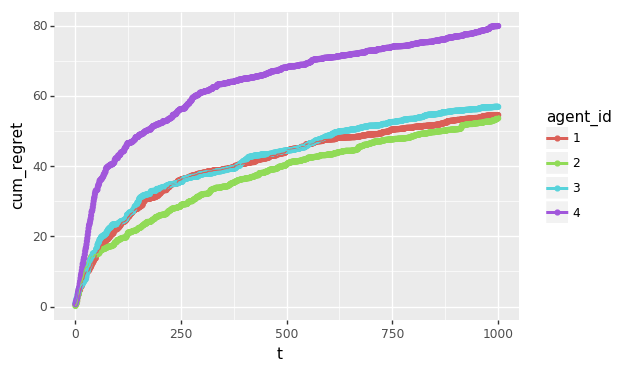

<ggplot: (8787424238473)>


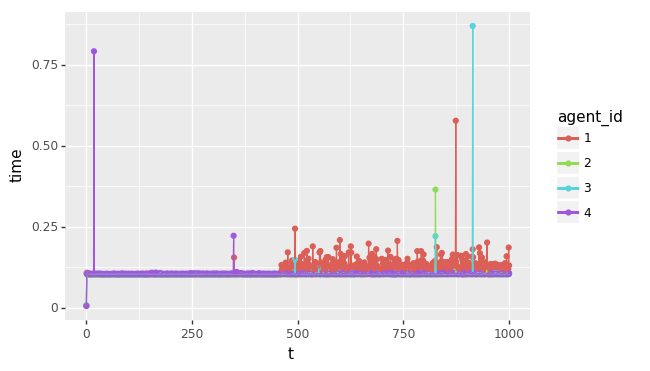

<ggplot: (8787252928905)>


In [11]:
plot_results(results)

In [2]:
rw = RandomWeights()
pickle.dump(rw, open('../outputs/test.p', 'wb'))